In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (EfficientNetB4)

2024-02-20 19:21:24.904896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 19:21:24.905000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 19:21:25.030074: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'/train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(EfficientNetB4(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("EfficientNetB4"+s+".keras")
    

    # save model to disk
    filename = "EfficientNetB4" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetb4 (Functional  (None, 4)                 17680995  


 )                                                               


Total params: 17680995 (67.45 MB)


Trainable params: 17555788 (66.97 MB)


Non-trainable params: 125207 (489.09 KB)


_________________________________________________________________


Epoch 1/30


2024-02-20 19:22:33.682323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


I0000 00:00:1708456961.418249      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 3:08:19 - loss: 5.0408 - accuracy: 0.2188

  2/140 [..............................] - ETA: 51s - loss: 10.7118 - accuracy: 0.2344   

  3/140 [..............................] - ETA: 49s - loss: 11.3450 - accuracy: 0.2292

  4/140 [..............................] - ETA: 49s - loss: 9.4652 - accuracy: 0.2734 

  5/140 [>.............................] - ETA: 49s - loss: 9.2372 - accuracy: 0.3000

  6/140 [>.............................] - ETA: 48s - loss: 8.6577 - accuracy: 0.2969

  7/140 [>.............................] - ETA: 48s - loss: 7.8205 - accuracy: 0.3125

  8/140 [>.............................] - ETA: 48s - loss: 7.9218 - accuracy: 0.2930

  9/140 [>.............................] - ETA: 47s - loss: 7.4733 - accuracy: 0.2986

 10/140 [=>............................] - ETA: 47s - loss: 7.5934 - accuracy: 0.3125

 11/140 [=>............................] - ETA: 47s - loss: 7.1919 - accuracy: 0.3182

 12/140 [=>............................] - ETA: 46s - loss: 7.2189 - accuracy: 0.3177

 13/140 [=>............................] - ETA: 46s - loss: 6.9534 - accuracy: 0.3245

 14/140 [==>...........................] - ETA: 46s - loss: 6.6879 - accuracy: 0.3393

 15/140 [==>...........................] - ETA: 45s - loss: 6.3883 - accuracy: 0.3438

 16/140 [==>...........................] - ETA: 45s - loss: 6.1884 - accuracy: 0.3398

 17/140 [==>...........................] - ETA: 44s - loss: 6.2198 - accuracy: 0.3456

 18/140 [==>...........................] - ETA: 44s - loss: 6.1823 - accuracy: 0.3403

 19/140 [===>..........................] - ETA: 44s - loss: 6.0211 - accuracy: 0.3372

 20/140 [===>..........................] - ETA: 43s - loss: 5.8943 - accuracy: 0.3344

 21/140 [===>..........................] - ETA: 43s - loss: 5.7923 - accuracy: 0.3393

 22/140 [===>..........................] - ETA: 43s - loss: 5.7139 - accuracy: 0.3409

 23/140 [===>..........................] - ETA: 42s - loss: 5.5893 - accuracy: 0.3451

 24/140 [====>.........................] - ETA: 42s - loss: 5.5640 - accuracy: 0.3464

 25/140 [====>.........................] - ETA: 42s - loss: 5.4770 - accuracy: 0.3462

 26/140 [====>.........................] - ETA: 41s - loss: 5.3721 - accuracy: 0.3450

 27/140 [====>.........................] - ETA: 41s - loss: 5.3627 - accuracy: 0.3472

 28/140 [=====>........................] - ETA: 41s - loss: 5.3163 - accuracy: 0.3504

 29/140 [=====>........................] - ETA: 40s - loss: 5.2140 - accuracy: 0.3513

 30/140 [=====>........................] - ETA: 40s - loss: 5.1006 - accuracy: 0.3510

 31/140 [=====>........................] - ETA: 40s - loss: 4.9803 - accuracy: 0.3518

 32/140 [=====>........................] - ETA: 39s - loss: 4.9174 - accuracy: 0.3506

 33/140 [======>.......................] - ETA: 39s - loss: 4.8997 - accuracy: 0.3494

 34/140 [======>.......................] - ETA: 39s - loss: 4.8075 - accuracy: 0.3447

 35/140 [======>.......................] - ETA: 38s - loss: 4.8182 - accuracy: 0.3429

 36/140 [======>.......................] - ETA: 38s - loss: 4.7335 - accuracy: 0.3446

 37/140 [======>.......................] - ETA: 37s - loss: 4.7964 - accuracy: 0.3471

 38/140 [=======>......................] - ETA: 37s - loss: 4.7088 - accuracy: 0.3512

 39/140 [=======>......................] - ETA: 37s - loss: 4.7312 - accuracy: 0.3502

 40/140 [=======>......................] - ETA: 36s - loss: 4.6727 - accuracy: 0.3492

 41/140 [=======>......................] - ETA: 36s - loss: 4.5870 - accuracy: 0.3544

 42/140 [========>.....................] - ETA: 36s - loss: 4.5606 - accuracy: 0.3542

 43/140 [========>.....................] - ETA: 35s - loss: 4.4825 - accuracy: 0.3554

 44/140 [========>.....................] - ETA: 35s - loss: 4.4391 - accuracy: 0.3580

 45/140 [========>.....................] - ETA: 34s - loss: 4.4047 - accuracy: 0.3590

 46/140 [========>.....................] - ETA: 34s - loss: 4.3991 - accuracy: 0.3573

 47/140 [=========>....................] - ETA: 34s - loss: 4.3342 - accuracy: 0.3597

 48/140 [=========>....................] - ETA: 33s - loss: 4.3319 - accuracy: 0.3639

 49/140 [=========>....................] - ETA: 33s - loss: 4.3392 - accuracy: 0.3654

 50/140 [=========>....................] - ETA: 33s - loss: 4.2784 - accuracy: 0.3663

 51/140 [=========>....................] - ETA: 32s - loss: 4.2339 - accuracy: 0.3664

 52/140 [==========>...................] - ETA: 32s - loss: 4.2199 - accuracy: 0.3648

 53/140 [==========>...................] - ETA: 31s - loss: 4.1911 - accuracy: 0.3667

 54/140 [==========>...................] - ETA: 31s - loss: 4.1896 - accuracy: 0.3663

 55/140 [==========>...................] - ETA: 31s - loss: 4.1517 - accuracy: 0.3693

 56/140 [===========>..................] - ETA: 30s - loss: 4.1134 - accuracy: 0.3722

 57/140 [===========>..................] - ETA: 30s - loss: 4.0742 - accuracy: 0.3734

 58/140 [===========>..................] - ETA: 30s - loss: 4.0218 - accuracy: 0.3745

 59/140 [===========>..................] - ETA: 29s - loss: 4.0483 - accuracy: 0.3718

 60/140 [===========>..................] - ETA: 29s - loss: 4.0021 - accuracy: 0.3734

 61/140 [============>.................] - ETA: 29s - loss: 3.9699 - accuracy: 0.3750

 62/140 [============>.................] - ETA: 28s - loss: 3.9242 - accuracy: 0.3780

 63/140 [============>.................] - ETA: 28s - loss: 3.8789 - accuracy: 0.3814

 64/140 [============>.................] - ETA: 27s - loss: 3.8591 - accuracy: 0.3818

 65/140 [============>.................] - ETA: 27s - loss: 3.8286 - accuracy: 0.3832

 66/140 [=============>................] - ETA: 27s - loss: 3.8052 - accuracy: 0.3840

 67/140 [=============>................] - ETA: 26s - loss: 3.7673 - accuracy: 0.3848

 68/140 [=============>................] - ETA: 26s - loss: 3.7591 - accuracy: 0.3837

 69/140 [=============>................] - ETA: 26s - loss: 3.7216 - accuracy: 0.3841

 70/140 [==============>...............] - ETA: 25s - loss: 3.6852 - accuracy: 0.3835

 71/140 [==============>...............] - ETA: 25s - loss: 3.6967 - accuracy: 0.3838

 72/140 [==============>...............] - ETA: 24s - loss: 3.6775 - accuracy: 0.3828

 73/140 [==============>...............] - ETA: 24s - loss: 3.6639 - accuracy: 0.3836

 74/140 [==============>...............] - ETA: 24s - loss: 3.6708 - accuracy: 0.3851

 75/140 [===============>..............] - ETA: 23s - loss: 3.6416 - accuracy: 0.3837

 76/140 [===============>..............] - ETA: 23s - loss: 3.6114 - accuracy: 0.3845

 77/140 [===============>..............] - ETA: 23s - loss: 3.6021 - accuracy: 0.3847

 78/140 [===============>..............] - ETA: 22s - loss: 3.5739 - accuracy: 0.3854

 79/140 [===============>..............] - ETA: 22s - loss: 3.5490 - accuracy: 0.3837

 80/140 [================>.............] - ETA: 21s - loss: 3.5193 - accuracy: 0.3844

 81/140 [================>.............] - ETA: 21s - loss: 3.4873 - accuracy: 0.3870

 82/140 [================>.............] - ETA: 21s - loss: 3.4838 - accuracy: 0.3872

 83/140 [================>.............] - ETA: 20s - loss: 3.4616 - accuracy: 0.3874

 84/140 [=================>............] - ETA: 20s - loss: 3.4565 - accuracy: 0.3858

 85/140 [=================>............] - ETA: 20s - loss: 3.4271 - accuracy: 0.3871

 86/140 [=================>............] - ETA: 19s - loss: 3.4018 - accuracy: 0.3884

 87/140 [=================>............] - ETA: 19s - loss: 3.3799 - accuracy: 0.3894

 88/140 [=================>............] - ETA: 19s - loss: 3.3788 - accuracy: 0.3899

 89/140 [==================>...........] - ETA: 18s - loss: 3.3538 - accuracy: 0.3922

 90/140 [==================>...........] - ETA: 18s - loss: 3.3298 - accuracy: 0.3934

 91/140 [==================>...........] - ETA: 17s - loss: 3.3300 - accuracy: 0.3915

 92/140 [==================>...........] - ETA: 17s - loss: 3.3444 - accuracy: 0.3893

 93/140 [==================>...........] - ETA: 17s - loss: 3.3255 - accuracy: 0.3915

 94/140 [===================>..........] - ETA: 16s - loss: 3.3015 - accuracy: 0.3930

 95/140 [===================>..........] - ETA: 16s - loss: 3.2794 - accuracy: 0.3931

 96/140 [===================>..........] - ETA: 16s - loss: 3.2692 - accuracy: 0.3952

 97/140 [===================>..........] - ETA: 15s - loss: 3.2476 - accuracy: 0.3966

 98/140 [====================>.........] - ETA: 15s - loss: 3.2357 - accuracy: 0.3954

 99/140 [====================>.........] - ETA: 15s - loss: 3.2170 - accuracy: 0.3984

100/140 [====================>.........] - ETA: 14s - loss: 3.2324 - accuracy: 0.3984

101/140 [====================>.........] - ETA: 14s - loss: 3.2152 - accuracy: 0.3988

102/140 [====================>.........] - ETA: 13s - loss: 3.1933 - accuracy: 0.4010

103/140 [=====================>........] - ETA: 13s - loss: 3.1904 - accuracy: 0.4017

104/140 [=====================>........] - ETA: 13s - loss: 3.1782 - accuracy: 0.4032

105/140 [=====================>........] - ETA: 12s - loss: 3.1861 - accuracy: 0.4048

106/140 [=====================>........] - ETA: 12s - loss: 3.1696 - accuracy: 0.4060

107/140 [=====================>........] - ETA: 12s - loss: 3.1524 - accuracy: 0.4065

108/140 [======================>.......] - ETA: 11s - loss: 3.1448 - accuracy: 0.4057

109/140 [======================>.......] - ETA: 11s - loss: 3.1314 - accuracy: 0.4057

110/140 [======================>.......] - ETA: 10s - loss: 3.1177 - accuracy: 0.4057

111/140 [======================>.......] - ETA: 10s - loss: 3.1006 - accuracy: 0.4043

112/140 [=======================>......] - ETA: 10s - loss: 3.0902 - accuracy: 0.4043

113/140 [=======================>......] - ETA: 9s - loss: 3.0718 - accuracy: 0.4051 

114/140 [=======================>......] - ETA: 9s - loss: 3.0668 - accuracy: 0.4057

115/140 [=======================>......] - ETA: 9s - loss: 3.0603 - accuracy: 0.4065

116/140 [=======================>......] - ETA: 8s - loss: 3.0419 - accuracy: 0.4079

117/140 [========================>.....] - ETA: 8s - loss: 3.0393 - accuracy: 0.4089

118/140 [========================>.....] - ETA: 8s - loss: 3.0244 - accuracy: 0.4092

119/140 [========================>.....] - ETA: 7s - loss: 3.0114 - accuracy: 0.4094

120/140 [========================>.....] - ETA: 7s - loss: 3.0020 - accuracy: 0.4096

121/140 [========================>.....] - ETA: 6s - loss: 2.9861 - accuracy: 0.4109

122/140 [=========================>....] - ETA: 6s - loss: 2.9702 - accuracy: 0.4119

123/140 [=========================>....] - ETA: 6s - loss: 2.9664 - accuracy: 0.4123

124/140 [=========================>....] - ETA: 5s - loss: 2.9520 - accuracy: 0.4131

125/140 [=========================>....] - ETA: 5s - loss: 2.9553 - accuracy: 0.4142

126/140 [==========================>...] - ETA: 5s - loss: 2.9487 - accuracy: 0.4144

127/140 [==========================>...] - ETA: 4s - loss: 2.9372 - accuracy: 0.4146

128/140 [==========================>...] - ETA: 4s - loss: 2.9239 - accuracy: 0.4143

129/140 [==========================>...] - ETA: 4s - loss: 2.9092 - accuracy: 0.4155

130/140 [==========================>...] - ETA: 3s - loss: 2.8971 - accuracy: 0.4147

131/140 [===========================>..] - ETA: 3s - loss: 2.8978 - accuracy: 0.4151

132/140 [===========================>..] - ETA: 2s - loss: 2.8861 - accuracy: 0.4148

133/140 [===========================>..] - ETA: 2s - loss: 2.8719 - accuracy: 0.4156

134/140 [===========================>..] - ETA: 2s - loss: 2.8735 - accuracy: 0.4153

135/140 [===========================>..] - ETA: 1s - loss: 2.8690 - accuracy: 0.4139

136/140 [============================>.] - ETA: 1s - loss: 2.8610 - accuracy: 0.4141

137/140 [============================>.] - ETA: 1s - loss: 2.8483 - accuracy: 0.4145

138/140 [============================>.] - ETA: 0s - loss: 2.8484 - accuracy: 0.4144

139/140 [============================>.] - ETA: 0s - loss: 2.8368 - accuracy: 0.4139

140/140 [==============================] - ETA: 0s - loss: 2.8344 - accuracy: 0.4140

140/140 [==============================] - 141s 429ms/step - loss: 2.8344 - accuracy: 0.4140 - val_loss: 1.0830 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 1:10 - loss: 1.2638 - accuracy: 0.5000

  2/140 [..............................] - ETA: 52s - loss: 1.5095 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 51s - loss: 1.4067 - accuracy: 0.3854

  4/140 [..............................] - ETA: 51s - loss: 1.3463 - accuracy: 0.4062

  5/140 [>.............................] - ETA: 50s - loss: 1.2943 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 50s - loss: 1.3745 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 49s - loss: 1.3811 - accuracy: 0.4196

  8/140 [>.............................] - ETA: 49s - loss: 1.3937 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 48s - loss: 1.4337 - accuracy: 0.4410

 10/140 [=>............................] - ETA: 48s - loss: 1.3986 - accuracy: 0.4375

 11/140 [=>............................] - ETA: 47s - loss: 1.3972 - accuracy: 0.4375

 12/140 [=>............................] - ETA: 47s - loss: 1.4064 - accuracy: 0.4453

 13/140 [=>............................] - ETA: 46s - loss: 1.4664 - accuracy: 0.4351

 14/140 [==>...........................] - ETA: 46s - loss: 1.4396 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 45s - loss: 1.4138 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 45s - loss: 1.4184 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 45s - loss: 1.3963 - accuracy: 0.4467

 18/140 [==>...........................] - ETA: 44s - loss: 1.4111 - accuracy: 0.4462

 19/140 [===>..........................] - ETA: 44s - loss: 1.4021 - accuracy: 0.4474

 20/140 [===>..........................] - ETA: 44s - loss: 1.3928 - accuracy: 0.4406

 21/140 [===>..........................] - ETA: 43s - loss: 1.3977 - accuracy: 0.4375

 22/140 [===>..........................] - ETA: 43s - loss: 1.3934 - accuracy: 0.4332

 23/140 [===>..........................] - ETA: 42s - loss: 1.5306 - accuracy: 0.4239

 24/140 [====>.........................] - ETA: 42s - loss: 1.5630 - accuracy: 0.4206

 25/140 [====>.........................] - ETA: 42s - loss: 1.5630 - accuracy: 0.4200

 26/140 [====>.........................] - ETA: 41s - loss: 1.5826 - accuracy: 0.4183

 27/140 [====>.........................] - ETA: 41s - loss: 1.5815 - accuracy: 0.4236

 28/140 [=====>........................] - ETA: 40s - loss: 1.5671 - accuracy: 0.4263

 29/140 [=====>........................] - ETA: 40s - loss: 1.5599 - accuracy: 0.4235

 30/140 [=====>........................] - ETA: 40s - loss: 1.5762 - accuracy: 0.4187

 31/140 [=====>........................] - ETA: 39s - loss: 1.5765 - accuracy: 0.4224

 32/140 [=====>........................] - ETA: 39s - loss: 1.5877 - accuracy: 0.4219

 33/140 [======>.......................] - ETA: 39s - loss: 1.6062 - accuracy: 0.4223

 34/140 [======>.......................] - ETA: 38s - loss: 1.5911 - accuracy: 0.4246

 35/140 [======>.......................] - ETA: 38s - loss: 1.5899 - accuracy: 0.4214

 36/140 [======>.......................] - ETA: 37s - loss: 1.6020 - accuracy: 0.4227

 37/140 [======>.......................] - ETA: 37s - loss: 1.6020 - accuracy: 0.4223

 38/140 [=======>......................] - ETA: 37s - loss: 1.5850 - accuracy: 0.4227

 39/140 [=======>......................] - ETA: 36s - loss: 1.5715 - accuracy: 0.4223

 40/140 [=======>......................] - ETA: 36s - loss: 1.5557 - accuracy: 0.4219

 41/140 [=======>......................] - ETA: 36s - loss: 1.5468 - accuracy: 0.4276

 42/140 [========>.....................] - ETA: 35s - loss: 1.5397 - accuracy: 0.4293

 43/140 [========>.....................] - ETA: 35s - loss: 1.5400 - accuracy: 0.4302

 44/140 [========>.....................] - ETA: 34s - loss: 1.5418 - accuracy: 0.4268

 45/140 [========>.....................] - ETA: 34s - loss: 1.5335 - accuracy: 0.4257

 46/140 [========>.....................] - ETA: 34s - loss: 1.5357 - accuracy: 0.4260

 47/140 [=========>....................] - ETA: 33s - loss: 1.5311 - accuracy: 0.4249

 48/140 [=========>....................] - ETA: 33s - loss: 1.5384 - accuracy: 0.4258

 49/140 [=========>....................] - ETA: 33s - loss: 1.5308 - accuracy: 0.4267

 50/140 [=========>....................] - ETA: 32s - loss: 1.5291 - accuracy: 0.4269

 51/140 [=========>....................] - ETA: 32s - loss: 1.5216 - accuracy: 0.4259

 52/140 [==========>...................] - ETA: 32s - loss: 1.5123 - accuracy: 0.4261

 53/140 [==========>...................] - ETA: 31s - loss: 1.5230 - accuracy: 0.4263

 54/140 [==========>...................] - ETA: 31s - loss: 1.5104 - accuracy: 0.4294

 55/140 [==========>...................] - ETA: 30s - loss: 1.5083 - accuracy: 0.4295

 56/140 [===========>..................] - ETA: 30s - loss: 1.5150 - accuracy: 0.4286

 57/140 [===========>..................] - ETA: 30s - loss: 1.5135 - accuracy: 0.4271

 58/140 [===========>..................] - ETA: 29s - loss: 1.5065 - accuracy: 0.4246

 59/140 [===========>..................] - ETA: 29s - loss: 1.4974 - accuracy: 0.4274

 60/140 [===========>..................] - ETA: 29s - loss: 1.4887 - accuracy: 0.4281

 61/140 [============>.................] - ETA: 28s - loss: 1.4842 - accuracy: 0.4283

 62/140 [============>.................] - ETA: 28s - loss: 1.4752 - accuracy: 0.4294

 63/140 [============>.................] - ETA: 28s - loss: 1.4930 - accuracy: 0.4286

 64/140 [============>.................] - ETA: 27s - loss: 1.4870 - accuracy: 0.4297

 65/140 [============>.................] - ETA: 27s - loss: 1.4820 - accuracy: 0.4327

 66/140 [=============>................] - ETA: 26s - loss: 1.4853 - accuracy: 0.4299

 67/140 [=============>................] - ETA: 26s - loss: 1.4797 - accuracy: 0.4296

 68/140 [=============>................] - ETA: 26s - loss: 1.4881 - accuracy: 0.4278

 69/140 [=============>................] - ETA: 25s - loss: 1.4889 - accuracy: 0.4271

 70/140 [==============>...............] - ETA: 25s - loss: 1.4830 - accuracy: 0.4268

 71/140 [==============>...............] - ETA: 25s - loss: 1.4765 - accuracy: 0.4265

 72/140 [==============>...............] - ETA: 24s - loss: 1.4762 - accuracy: 0.4249

 73/140 [==============>...............] - ETA: 24s - loss: 1.4806 - accuracy: 0.4238

 74/140 [==============>...............] - ETA: 24s - loss: 1.4841 - accuracy: 0.4227

 75/140 [===============>..............] - ETA: 23s - loss: 1.4861 - accuracy: 0.4225

 76/140 [===============>..............] - ETA: 23s - loss: 1.4948 - accuracy: 0.4227

 77/140 [===============>..............] - ETA: 23s - loss: 1.4989 - accuracy: 0.4229

 78/140 [===============>..............] - ETA: 22s - loss: 1.4935 - accuracy: 0.4247

 79/140 [===============>..............] - ETA: 22s - loss: 1.5120 - accuracy: 0.4256

 80/140 [================>.............] - ETA: 21s - loss: 1.5380 - accuracy: 0.4250

 81/140 [================>.............] - ETA: 21s - loss: 1.5505 - accuracy: 0.4252

 82/140 [================>.............] - ETA: 21s - loss: 1.5559 - accuracy: 0.4253

 83/140 [================>.............] - ETA: 20s - loss: 1.5607 - accuracy: 0.4273

 84/140 [=================>............] - ETA: 20s - loss: 1.5547 - accuracy: 0.4293

 85/140 [=================>............] - ETA: 20s - loss: 1.5538 - accuracy: 0.4283

 86/140 [=================>............] - ETA: 19s - loss: 1.5542 - accuracy: 0.4284

 87/140 [=================>............] - ETA: 19s - loss: 1.5490 - accuracy: 0.4289

 88/140 [=================>............] - ETA: 19s - loss: 1.5433 - accuracy: 0.4293

 89/140 [==================>...........] - ETA: 18s - loss: 1.5612 - accuracy: 0.4287

 90/140 [==================>...........] - ETA: 18s - loss: 1.5535 - accuracy: 0.4309

 91/140 [==================>...........] - ETA: 17s - loss: 1.5490 - accuracy: 0.4313

 92/140 [==================>...........] - ETA: 17s - loss: 1.5435 - accuracy: 0.4321

 93/140 [==================>...........] - ETA: 17s - loss: 1.5373 - accuracy: 0.4335

 94/140 [===================>..........] - ETA: 16s - loss: 1.5328 - accuracy: 0.4348

 95/140 [===================>..........] - ETA: 16s - loss: 1.5337 - accuracy: 0.4349

 96/140 [===================>..........] - ETA: 16s - loss: 1.5267 - accuracy: 0.4359

 97/140 [===================>..........] - ETA: 15s - loss: 1.5306 - accuracy: 0.4365

 98/140 [====================>.........] - ETA: 15s - loss: 1.5363 - accuracy: 0.4369

 99/140 [====================>.........] - ETA: 15s - loss: 1.5339 - accuracy: 0.4359

100/140 [====================>.........] - ETA: 14s - loss: 1.5356 - accuracy: 0.4363

101/140 [====================>.........] - ETA: 14s - loss: 1.5320 - accuracy: 0.4363

102/140 [====================>.........] - ETA: 13s - loss: 1.5265 - accuracy: 0.4366

103/140 [=====================>........] - ETA: 13s - loss: 1.5208 - accuracy: 0.4375

104/140 [=====================>........] - ETA: 13s - loss: 1.5137 - accuracy: 0.4396

105/140 [=====================>........] - ETA: 12s - loss: 1.5082 - accuracy: 0.4408

106/140 [=====================>........] - ETA: 12s - loss: 1.5182 - accuracy: 0.4404

107/140 [=====================>........] - ETA: 12s - loss: 1.5130 - accuracy: 0.4407

108/140 [======================>.......] - ETA: 11s - loss: 1.5082 - accuracy: 0.4407

109/140 [======================>.......] - ETA: 11s - loss: 1.5077 - accuracy: 0.4407

110/140 [======================>.......] - ETA: 10s - loss: 1.5146 - accuracy: 0.4401

111/140 [======================>.......] - ETA: 10s - loss: 1.5284 - accuracy: 0.4400

112/140 [=======================>......] - ETA: 10s - loss: 1.5261 - accuracy: 0.4406

113/140 [=======================>......] - ETA: 9s - loss: 1.5215 - accuracy: 0.4397 

114/140 [=======================>......] - ETA: 9s - loss: 1.5388 - accuracy: 0.4402

115/140 [=======================>......] - ETA: 9s - loss: 1.5351 - accuracy: 0.4399

116/140 [=======================>......] - ETA: 8s - loss: 1.5375 - accuracy: 0.4415

117/140 [========================>.....] - ETA: 8s - loss: 1.5370 - accuracy: 0.4420

118/140 [========================>.....] - ETA: 8s - loss: 1.5382 - accuracy: 0.4417

119/140 [========================>.....] - ETA: 7s - loss: 1.5348 - accuracy: 0.4433

120/140 [========================>.....] - ETA: 7s - loss: 1.5302 - accuracy: 0.4443

121/140 [========================>.....] - ETA: 6s - loss: 1.5312 - accuracy: 0.4442

122/140 [=========================>....] - ETA: 6s - loss: 1.5373 - accuracy: 0.4429

123/140 [=========================>....] - ETA: 6s - loss: 1.5407 - accuracy: 0.4421

124/140 [=========================>....] - ETA: 5s - loss: 1.5384 - accuracy: 0.4425

125/140 [=========================>....] - ETA: 5s - loss: 1.5354 - accuracy: 0.4428

126/140 [==========================>...] - ETA: 5s - loss: 1.5335 - accuracy: 0.4415

127/140 [==========================>...] - ETA: 4s - loss: 1.5297 - accuracy: 0.4414

128/140 [==========================>...] - ETA: 4s - loss: 1.5253 - accuracy: 0.4424

129/140 [==========================>...] - ETA: 4s - loss: 1.5251 - accuracy: 0.4423

130/140 [==========================>...] - ETA: 3s - loss: 1.5213 - accuracy: 0.4421

131/140 [===========================>..] - ETA: 3s - loss: 1.5247 - accuracy: 0.4416

132/140 [===========================>..] - ETA: 2s - loss: 1.5213 - accuracy: 0.4418

133/140 [===========================>..] - ETA: 2s - loss: 1.5185 - accuracy: 0.4415

134/140 [===========================>..] - ETA: 2s - loss: 1.5157 - accuracy: 0.4412

135/140 [===========================>..] - ETA: 1s - loss: 1.5205 - accuracy: 0.4403

136/140 [============================>.] - ETA: 1s - loss: 1.5208 - accuracy: 0.4398

137/140 [============================>.] - ETA: 1s - loss: 1.5223 - accuracy: 0.4389

138/140 [============================>.] - ETA: 0s - loss: 1.5192 - accuracy: 0.4393

139/140 [============================>.] - ETA: 0s - loss: 1.5153 - accuracy: 0.4388

140/140 [==============================] - ETA: 0s - loss: 1.5180 - accuracy: 0.4387

140/140 [==============================] - 54s 386ms/step - loss: 1.5180 - accuracy: 0.4387 - val_loss: 1.0472 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 1:07 - loss: 1.0244 - accuracy: 0.4062

  2/140 [..............................] - ETA: 49s - loss: 0.9678 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 49s - loss: 1.2748 - accuracy: 0.5833

  4/140 [..............................] - ETA: 49s - loss: 1.1929 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 48s - loss: 1.3141 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 48s - loss: 1.3102 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 48s - loss: 1.2936 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 48s - loss: 1.3838 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 47s - loss: 1.3229 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 47s - loss: 1.2972 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 47s - loss: 1.3043 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 46s - loss: 1.3800 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 46s - loss: 1.4111 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 46s - loss: 1.3872 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 45s - loss: 1.3878 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 45s - loss: 1.4163 - accuracy: 0.4824

 17/140 [==>...........................] - ETA: 45s - loss: 1.3913 - accuracy: 0.4835

 18/140 [==>...........................] - ETA: 44s - loss: 1.3695 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 44s - loss: 1.4096 - accuracy: 0.4918

 20/140 [===>..........................] - ETA: 43s - loss: 1.4219 - accuracy: 0.4891

 21/140 [===>..........................] - ETA: 43s - loss: 1.4364 - accuracy: 0.4851

 22/140 [===>..........................] - ETA: 43s - loss: 1.4295 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 42s - loss: 1.4113 - accuracy: 0.4823

 24/140 [====>.........................] - ETA: 42s - loss: 1.4146 - accuracy: 0.4818

 25/140 [====>.........................] - ETA: 42s - loss: 1.4161 - accuracy: 0.4737

 26/140 [====>.........................] - ETA: 41s - loss: 1.4273 - accuracy: 0.4627

 27/140 [====>.........................] - ETA: 41s - loss: 1.4197 - accuracy: 0.4630

 28/140 [=====>........................] - ETA: 40s - loss: 1.4054 - accuracy: 0.4621

 29/140 [=====>........................] - ETA: 40s - loss: 1.3900 - accuracy: 0.4644

 30/140 [=====>........................] - ETA: 40s - loss: 1.3755 - accuracy: 0.4667

 31/140 [=====>........................] - ETA: 39s - loss: 1.3790 - accuracy: 0.4657

 32/140 [=====>........................] - ETA: 39s - loss: 1.4011 - accuracy: 0.4639

 33/140 [======>.......................] - ETA: 39s - loss: 1.4076 - accuracy: 0.4640

 34/140 [======>.......................] - ETA: 38s - loss: 1.3944 - accuracy: 0.4669

 35/140 [======>.......................] - ETA: 38s - loss: 1.3947 - accuracy: 0.4688

 36/140 [======>.......................] - ETA: 38s - loss: 1.4010 - accuracy: 0.4670

 37/140 [======>.......................] - ETA: 37s - loss: 1.4115 - accuracy: 0.4704

 38/140 [=======>......................] - ETA: 37s - loss: 1.4109 - accuracy: 0.4663

 39/140 [=======>......................] - ETA: 36s - loss: 1.4072 - accuracy: 0.4639

 40/140 [=======>......................] - ETA: 36s - loss: 1.4185 - accuracy: 0.4648

 41/140 [=======>......................] - ETA: 36s - loss: 1.4125 - accuracy: 0.4619

 42/140 [========>.....................] - ETA: 35s - loss: 1.4015 - accuracy: 0.4643

 43/140 [========>.....................] - ETA: 35s - loss: 1.4150 - accuracy: 0.4622

 44/140 [========>.....................] - ETA: 35s - loss: 1.4151 - accuracy: 0.4595

 45/140 [========>.....................] - ETA: 34s - loss: 1.4044 - accuracy: 0.4604

 46/140 [========>.....................] - ETA: 34s - loss: 1.4014 - accuracy: 0.4592

 47/140 [=========>....................] - ETA: 34s - loss: 1.4086 - accuracy: 0.4568

 48/140 [=========>....................] - ETA: 33s - loss: 1.4020 - accuracy: 0.4583

 49/140 [=========>....................] - ETA: 33s - loss: 1.3915 - accuracy: 0.4611

 50/140 [=========>....................] - ETA: 33s - loss: 1.3825 - accuracy: 0.4606

 51/140 [=========>....................] - ETA: 32s - loss: 1.3758 - accuracy: 0.4602

 52/140 [==========>...................] - ETA: 32s - loss: 1.3803 - accuracy: 0.4621

 53/140 [==========>...................] - ETA: 31s - loss: 1.3751 - accuracy: 0.4605

 54/140 [==========>...................] - ETA: 31s - loss: 1.3708 - accuracy: 0.4589

 55/140 [==========>...................] - ETA: 31s - loss: 1.3767 - accuracy: 0.4574

 56/140 [===========>..................] - ETA: 30s - loss: 1.3687 - accuracy: 0.4587

 57/140 [===========>..................] - ETA: 30s - loss: 1.3608 - accuracy: 0.4594

 58/140 [===========>..................] - ETA: 30s - loss: 1.3569 - accuracy: 0.4585

 59/140 [===========>..................] - ETA: 29s - loss: 1.3709 - accuracy: 0.4603

 60/140 [===========>..................] - ETA: 29s - loss: 1.3666 - accuracy: 0.4615

 61/140 [============>.................] - ETA: 28s - loss: 1.3683 - accuracy: 0.4616

 62/140 [============>.................] - ETA: 28s - loss: 1.3740 - accuracy: 0.4602

 63/140 [============>.................] - ETA: 28s - loss: 1.3706 - accuracy: 0.4618

 64/140 [============>.................] - ETA: 27s - loss: 1.3720 - accuracy: 0.4609

 65/140 [============>.................] - ETA: 27s - loss: 1.3714 - accuracy: 0.4596

 66/140 [=============>................] - ETA: 27s - loss: 1.3757 - accuracy: 0.4593

 67/140 [=============>................] - ETA: 26s - loss: 1.3806 - accuracy: 0.4608

 68/140 [=============>................] - ETA: 26s - loss: 1.3754 - accuracy: 0.4609

 69/140 [=============>................] - ETA: 25s - loss: 1.3707 - accuracy: 0.4624

 70/140 [==============>...............] - ETA: 25s - loss: 1.3661 - accuracy: 0.4634

 71/140 [==============>...............] - ETA: 25s - loss: 1.3649 - accuracy: 0.4635

 72/140 [==============>...............] - ETA: 24s - loss: 1.3606 - accuracy: 0.4644

 73/140 [==============>...............] - ETA: 24s - loss: 1.3580 - accuracy: 0.4662

 74/140 [==============>...............] - ETA: 24s - loss: 1.3567 - accuracy: 0.4662

 75/140 [===============>..............] - ETA: 23s - loss: 1.3692 - accuracy: 0.4671

 76/140 [===============>..............] - ETA: 23s - loss: 1.3749 - accuracy: 0.4671

 77/140 [===============>..............] - ETA: 23s - loss: 1.3908 - accuracy: 0.4659

 78/140 [===============>..............] - ETA: 22s - loss: 1.3893 - accuracy: 0.4639

 79/140 [===============>..............] - ETA: 22s - loss: 1.3872 - accuracy: 0.4644

 80/140 [================>.............] - ETA: 21s - loss: 1.3867 - accuracy: 0.4633

 81/140 [================>.............] - ETA: 21s - loss: 1.3806 - accuracy: 0.4637

 82/140 [================>.............] - ETA: 21s - loss: 1.3805 - accuracy: 0.4653

 83/140 [================>.............] - ETA: 20s - loss: 1.3751 - accuracy: 0.4676

 84/140 [=================>............] - ETA: 20s - loss: 1.3770 - accuracy: 0.4669

 85/140 [=================>............] - ETA: 20s - loss: 1.3782 - accuracy: 0.4676

 86/140 [=================>............] - ETA: 19s - loss: 1.3727 - accuracy: 0.4677

 87/140 [=================>............] - ETA: 19s - loss: 1.3696 - accuracy: 0.4670

 88/140 [=================>............] - ETA: 19s - loss: 1.3661 - accuracy: 0.4670

 89/140 [==================>...........] - ETA: 18s - loss: 1.3614 - accuracy: 0.4684

 90/140 [==================>...........] - ETA: 18s - loss: 1.3583 - accuracy: 0.4677

 91/140 [==================>...........] - ETA: 17s - loss: 1.3610 - accuracy: 0.4674

 92/140 [==================>...........] - ETA: 17s - loss: 1.3581 - accuracy: 0.4677

 93/140 [==================>...........] - ETA: 17s - loss: 1.3611 - accuracy: 0.4688

 94/140 [===================>..........] - ETA: 16s - loss: 1.3599 - accuracy: 0.4691

 95/140 [===================>..........] - ETA: 16s - loss: 1.3571 - accuracy: 0.4684

 96/140 [===================>..........] - ETA: 16s - loss: 1.3552 - accuracy: 0.4678

 97/140 [===================>..........] - ETA: 15s - loss: 1.3532 - accuracy: 0.4678

 98/140 [====================>.........] - ETA: 15s - loss: 1.3480 - accuracy: 0.4694

 99/140 [====================>.........] - ETA: 15s - loss: 1.3467 - accuracy: 0.4706

100/140 [====================>.........] - ETA: 14s - loss: 1.3430 - accuracy: 0.4706

101/140 [====================>.........] - ETA: 14s - loss: 1.3460 - accuracy: 0.4706

102/140 [====================>.........] - ETA: 13s - loss: 1.3520 - accuracy: 0.4706

103/140 [=====================>........] - ETA: 13s - loss: 1.3577 - accuracy: 0.4703

104/140 [=====================>........] - ETA: 13s - loss: 1.3634 - accuracy: 0.4712

105/140 [=====================>........] - ETA: 12s - loss: 1.3596 - accuracy: 0.4717

106/140 [=====================>........] - ETA: 12s - loss: 1.3569 - accuracy: 0.4729

107/140 [=====================>........] - ETA: 12s - loss: 1.3617 - accuracy: 0.4728

108/140 [======================>.......] - ETA: 11s - loss: 1.3596 - accuracy: 0.4740

109/140 [======================>.......] - ETA: 11s - loss: 1.3565 - accuracy: 0.4748

110/140 [======================>.......] - ETA: 10s - loss: 1.3540 - accuracy: 0.4753

111/140 [======================>.......] - ETA: 10s - loss: 1.3647 - accuracy: 0.4747

112/140 [=======================>......] - ETA: 10s - loss: 1.3633 - accuracy: 0.4735

113/140 [=======================>......] - ETA: 9s - loss: 1.3636 - accuracy: 0.4729 

114/140 [=======================>......] - ETA: 9s - loss: 1.3615 - accuracy: 0.4731

115/140 [=======================>......] - ETA: 9s - loss: 1.3597 - accuracy: 0.4742

116/140 [=======================>......] - ETA: 8s - loss: 1.3590 - accuracy: 0.4758

117/140 [========================>.....] - ETA: 8s - loss: 1.3601 - accuracy: 0.4754

118/140 [========================>.....] - ETA: 8s - loss: 1.3587 - accuracy: 0.4762

119/140 [========================>.....] - ETA: 7s - loss: 1.3552 - accuracy: 0.4761

120/140 [========================>.....] - ETA: 7s - loss: 1.3559 - accuracy: 0.4750

121/140 [========================>.....] - ETA: 6s - loss: 1.3536 - accuracy: 0.4768

122/140 [=========================>....] - ETA: 6s - loss: 1.3557 - accuracy: 0.4757

123/140 [=========================>....] - ETA: 6s - loss: 1.3580 - accuracy: 0.4754

124/140 [=========================>....] - ETA: 5s - loss: 1.3578 - accuracy: 0.4745

125/140 [=========================>....] - ETA: 5s - loss: 1.3550 - accuracy: 0.4737

126/140 [==========================>...] - ETA: 5s - loss: 1.3551 - accuracy: 0.4737

127/140 [==========================>...] - ETA: 4s - loss: 1.3632 - accuracy: 0.4729

128/140 [==========================>...] - ETA: 4s - loss: 1.3607 - accuracy: 0.4724

129/140 [==========================>...] - ETA: 4s - loss: 1.3575 - accuracy: 0.4726

130/140 [==========================>...] - ETA: 3s - loss: 1.3553 - accuracy: 0.4719

131/140 [===========================>..] - ETA: 3s - loss: 1.3567 - accuracy: 0.4714

132/140 [===========================>..] - ETA: 2s - loss: 1.3579 - accuracy: 0.4702

133/140 [===========================>..] - ETA: 2s - loss: 1.3563 - accuracy: 0.4709

134/140 [===========================>..] - ETA: 2s - loss: 1.3555 - accuracy: 0.4713

135/140 [===========================>..] - ETA: 1s - loss: 1.3606 - accuracy: 0.4718

136/140 [============================>.] - ETA: 1s - loss: 1.3581 - accuracy: 0.4713

137/140 [============================>.] - ETA: 1s - loss: 1.3556 - accuracy: 0.4726

138/140 [============================>.] - ETA: 0s - loss: 1.3626 - accuracy: 0.4726

139/140 [============================>.] - ETA: 0s - loss: 1.3669 - accuracy: 0.4723

140/140 [==============================] - ETA: 0s - loss: 1.3679 - accuracy: 0.4722

140/140 [==============================] - 54s 386ms/step - loss: 1.3679 - accuracy: 0.4722 - val_loss: 419.2339 - val_accuracy: 0.3503


Epoch 4/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.9257 - accuracy: 0.5625

  2/140 [..............................] - ETA: 50s - loss: 0.9370 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 49s - loss: 1.0147 - accuracy: 0.5417

  4/140 [..............................] - ETA: 49s - loss: 0.9892 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 48s - loss: 1.0327 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 48s - loss: 1.0288 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 48s - loss: 1.0197 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 48s - loss: 1.0075 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 47s - loss: 0.9974 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 47s - loss: 1.0285 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 47s - loss: 1.0302 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 46s - loss: 1.1050 - accuracy: 0.5052

 13/140 [=>............................] - ETA: 46s - loss: 1.1038 - accuracy: 0.5216

 14/140 [==>...........................] - ETA: 46s - loss: 1.0911 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 45s - loss: 1.0823 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 45s - loss: 1.0898 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 44s - loss: 1.0897 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 44s - loss: 1.0792 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 44s - loss: 1.1310 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 43s - loss: 1.1754 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 43s - loss: 1.2212 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 43s - loss: 1.2464 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 42s - loss: 1.2656 - accuracy: 0.4878

 24/140 [====>.........................] - ETA: 42s - loss: 1.2781 - accuracy: 0.4844

 25/140 [====>.........................] - ETA: 42s - loss: 1.2828 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 41s - loss: 1.2732 - accuracy: 0.4760

 27/140 [====>.........................] - ETA: 41s - loss: 1.2858 - accuracy: 0.4757

 28/140 [=====>........................] - ETA: 41s - loss: 1.2858 - accuracy: 0.4699

 29/140 [=====>........................] - ETA: 40s - loss: 1.2878 - accuracy: 0.4731

 30/140 [=====>........................] - ETA: 40s - loss: 1.2834 - accuracy: 0.4677

 31/140 [=====>........................] - ETA: 40s - loss: 1.2791 - accuracy: 0.4647

 32/140 [=====>........................] - ETA: 39s - loss: 1.2735 - accuracy: 0.4629

 33/140 [======>.......................] - ETA: 39s - loss: 1.2707 - accuracy: 0.4621

 34/140 [======>.......................] - ETA: 38s - loss: 1.2691 - accuracy: 0.4596

 35/140 [======>.......................] - ETA: 38s - loss: 1.2667 - accuracy: 0.4607

 36/140 [======>.......................] - ETA: 38s - loss: 1.2715 - accuracy: 0.4601

 37/140 [======>.......................] - ETA: 37s - loss: 1.2704 - accuracy: 0.4586

 38/140 [=======>......................] - ETA: 37s - loss: 1.2733 - accuracy: 0.4581

 39/140 [=======>......................] - ETA: 37s - loss: 1.2669 - accuracy: 0.4615

 40/140 [=======>......................] - ETA: 36s - loss: 1.2566 - accuracy: 0.4664

 41/140 [=======>......................] - ETA: 36s - loss: 1.2494 - accuracy: 0.4710

 42/140 [========>.....................] - ETA: 36s - loss: 1.2456 - accuracy: 0.4732

 43/140 [========>.....................] - ETA: 35s - loss: 1.2395 - accuracy: 0.4724

 44/140 [========>.....................] - ETA: 35s - loss: 1.2324 - accuracy: 0.4730

 45/140 [========>.....................] - ETA: 34s - loss: 1.2299 - accuracy: 0.4708

 46/140 [========>.....................] - ETA: 34s - loss: 1.2385 - accuracy: 0.4715

 47/140 [=========>....................] - ETA: 34s - loss: 1.2399 - accuracy: 0.4714

 48/140 [=========>....................] - ETA: 33s - loss: 1.2466 - accuracy: 0.4733

 49/140 [=========>....................] - ETA: 33s - loss: 1.2525 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 33s - loss: 1.2559 - accuracy: 0.4706

 51/140 [=========>....................] - ETA: 32s - loss: 1.2523 - accuracy: 0.4688

 52/140 [==========>...................] - ETA: 32s - loss: 1.2466 - accuracy: 0.4700

 53/140 [==========>...................] - ETA: 31s - loss: 1.2475 - accuracy: 0.4693

 54/140 [==========>...................] - ETA: 31s - loss: 1.2418 - accuracy: 0.4711

 55/140 [==========>...................] - ETA: 31s - loss: 1.2397 - accuracy: 0.4722

 56/140 [===========>..................] - ETA: 30s - loss: 1.2499 - accuracy: 0.4704

 57/140 [===========>..................] - ETA: 30s - loss: 1.2496 - accuracy: 0.4698

 58/140 [===========>..................] - ETA: 30s - loss: 1.2448 - accuracy: 0.4688

 59/140 [===========>..................] - ETA: 29s - loss: 1.2460 - accuracy: 0.4677

 60/140 [===========>..................] - ETA: 29s - loss: 1.2467 - accuracy: 0.4682

 61/140 [============>.................] - ETA: 28s - loss: 1.2412 - accuracy: 0.4693

 62/140 [============>.................] - ETA: 28s - loss: 1.2442 - accuracy: 0.4667

 63/140 [============>.................] - ETA: 28s - loss: 1.2530 - accuracy: 0.4653

 64/140 [============>.................] - ETA: 27s - loss: 1.2495 - accuracy: 0.4648

 65/140 [============>.................] - ETA: 27s - loss: 1.2430 - accuracy: 0.4663

 66/140 [=============>................] - ETA: 27s - loss: 1.2487 - accuracy: 0.4673

 67/140 [=============>................] - ETA: 26s - loss: 1.2425 - accuracy: 0.4706

 68/140 [=============>................] - ETA: 26s - loss: 1.2434 - accuracy: 0.4710

 69/140 [=============>................] - ETA: 26s - loss: 1.2474 - accuracy: 0.4706

 70/140 [==============>...............] - ETA: 25s - loss: 1.2448 - accuracy: 0.4701

 71/140 [==============>...............] - ETA: 25s - loss: 1.2452 - accuracy: 0.4696

 72/140 [==============>...............] - ETA: 24s - loss: 1.2390 - accuracy: 0.4714

 73/140 [==============>...............] - ETA: 24s - loss: 1.2538 - accuracy: 0.4717

 74/140 [==============>...............] - ETA: 24s - loss: 1.2500 - accuracy: 0.4726

 75/140 [===============>..............] - ETA: 23s - loss: 1.2586 - accuracy: 0.4717

 76/140 [===============>..............] - ETA: 23s - loss: 1.2568 - accuracy: 0.4716

 77/140 [===============>..............] - ETA: 23s - loss: 1.2596 - accuracy: 0.4716

 78/140 [===============>..............] - ETA: 22s - loss: 1.2683 - accuracy: 0.4724

 79/140 [===============>..............] - ETA: 22s - loss: 1.2685 - accuracy: 0.4719

 80/140 [================>.............] - ETA: 21s - loss: 1.2663 - accuracy: 0.4719

 81/140 [================>.............] - ETA: 21s - loss: 1.2636 - accuracy: 0.4726

 82/140 [================>.............] - ETA: 21s - loss: 1.2688 - accuracy: 0.4729

 83/140 [================>.............] - ETA: 20s - loss: 1.2753 - accuracy: 0.4725

 84/140 [=================>............] - ETA: 20s - loss: 1.2721 - accuracy: 0.4728

 85/140 [=================>............] - ETA: 20s - loss: 1.2673 - accuracy: 0.4743

 86/140 [=================>............] - ETA: 19s - loss: 1.2635 - accuracy: 0.4749

 87/140 [=================>............] - ETA: 19s - loss: 1.2619 - accuracy: 0.4763

 88/140 [=================>............] - ETA: 19s - loss: 1.2590 - accuracy: 0.4762

 89/140 [==================>...........] - ETA: 18s - loss: 1.2561 - accuracy: 0.4765

 90/140 [==================>...........] - ETA: 18s - loss: 1.2529 - accuracy: 0.4781

 91/140 [==================>...........] - ETA: 17s - loss: 1.2526 - accuracy: 0.4780

 92/140 [==================>...........] - ETA: 17s - loss: 1.2564 - accuracy: 0.4783

 93/140 [==================>...........] - ETA: 17s - loss: 1.2612 - accuracy: 0.4775

 94/140 [===================>..........] - ETA: 16s - loss: 1.2588 - accuracy: 0.4781

 95/140 [===================>..........] - ETA: 16s - loss: 1.2573 - accuracy: 0.4789

 96/140 [===================>..........] - ETA: 16s - loss: 1.2595 - accuracy: 0.4788

 97/140 [===================>..........] - ETA: 15s - loss: 1.2565 - accuracy: 0.4791

 98/140 [====================>.........] - ETA: 15s - loss: 1.2526 - accuracy: 0.4805

 99/140 [====================>.........] - ETA: 15s - loss: 1.2501 - accuracy: 0.4817

100/140 [====================>.........] - ETA: 14s - loss: 1.2531 - accuracy: 0.4822

101/140 [====================>.........] - ETA: 14s - loss: 1.2516 - accuracy: 0.4824

102/140 [====================>.........] - ETA: 13s - loss: 1.2495 - accuracy: 0.4819

103/140 [=====================>........] - ETA: 13s - loss: 1.2477 - accuracy: 0.4818

104/140 [=====================>........] - ETA: 13s - loss: 1.2536 - accuracy: 0.4814

105/140 [=====================>........] - ETA: 12s - loss: 1.2544 - accuracy: 0.4798

106/140 [=====================>........] - ETA: 12s - loss: 1.2536 - accuracy: 0.4794

107/140 [=====================>........] - ETA: 12s - loss: 1.2519 - accuracy: 0.4801

108/140 [======================>.......] - ETA: 11s - loss: 1.2495 - accuracy: 0.4795

109/140 [======================>.......] - ETA: 11s - loss: 1.2471 - accuracy: 0.4794

110/140 [======================>.......] - ETA: 10s - loss: 1.2455 - accuracy: 0.4793

111/140 [======================>.......] - ETA: 10s - loss: 1.2522 - accuracy: 0.4780

112/140 [=======================>......] - ETA: 10s - loss: 1.2496 - accuracy: 0.4799

113/140 [=======================>......] - ETA: 9s - loss: 1.2494 - accuracy: 0.4804 

114/140 [=======================>......] - ETA: 9s - loss: 1.2491 - accuracy: 0.4803

115/140 [=======================>......] - ETA: 9s - loss: 1.2485 - accuracy: 0.4804

116/140 [=======================>......] - ETA: 8s - loss: 1.2481 - accuracy: 0.4817

117/140 [========================>.....] - ETA: 8s - loss: 1.2460 - accuracy: 0.4818

118/140 [========================>.....] - ETA: 8s - loss: 1.2455 - accuracy: 0.4807

119/140 [========================>.....] - ETA: 7s - loss: 1.2430 - accuracy: 0.4819

120/140 [========================>.....] - ETA: 7s - loss: 1.2403 - accuracy: 0.4823

121/140 [========================>.....] - ETA: 6s - loss: 1.2383 - accuracy: 0.4832

122/140 [=========================>....] - ETA: 6s - loss: 1.2365 - accuracy: 0.4841

123/140 [=========================>....] - ETA: 6s - loss: 1.2366 - accuracy: 0.4842

124/140 [=========================>....] - ETA: 5s - loss: 1.2349 - accuracy: 0.4844

125/140 [=========================>....] - ETA: 5s - loss: 1.2332 - accuracy: 0.4845

126/140 [==========================>...] - ETA: 5s - loss: 1.2347 - accuracy: 0.4839

127/140 [==========================>...] - ETA: 4s - loss: 1.2363 - accuracy: 0.4828

128/140 [==========================>...] - ETA: 4s - loss: 1.2420 - accuracy: 0.4824

129/140 [==========================>...] - ETA: 4s - loss: 1.2426 - accuracy: 0.4835

130/140 [==========================>...] - ETA: 3s - loss: 1.2431 - accuracy: 0.4834

131/140 [===========================>..] - ETA: 3s - loss: 1.2410 - accuracy: 0.4840

132/140 [===========================>..] - ETA: 2s - loss: 1.2412 - accuracy: 0.4839

133/140 [===========================>..] - ETA: 2s - loss: 1.2396 - accuracy: 0.4838

134/140 [===========================>..] - ETA: 2s - loss: 1.2382 - accuracy: 0.4832

135/140 [===========================>..] - ETA: 1s - loss: 1.2362 - accuracy: 0.4831

136/140 [============================>.] - ETA: 1s - loss: 1.2354 - accuracy: 0.4823

137/140 [============================>.] - ETA: 1s - loss: 1.2352 - accuracy: 0.4815

138/140 [============================>.] - ETA: 0s - loss: 1.2353 - accuracy: 0.4819

139/140 [============================>.] - ETA: 0s - loss: 1.2333 - accuracy: 0.4822

140/140 [==============================] - ETA: 0s - loss: 1.2337 - accuracy: 0.4825

140/140 [==============================] - 54s 387ms/step - loss: 1.2337 - accuracy: 0.4825 - val_loss: 1.0022 - val_accuracy: 0.5215


Epoch 5/30


  1/140 [..............................] - ETA: 1:12 - loss: 1.1004 - accuracy: 0.4062

  2/140 [..............................] - ETA: 50s - loss: 1.2419 - accuracy: 0.4375 

  3/140 [..............................] - ETA: 49s - loss: 1.2467 - accuracy: 0.4688

  4/140 [..............................] - ETA: 49s - loss: 1.1969 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 49s - loss: 1.2475 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 48s - loss: 1.2315 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 48s - loss: 1.2055 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 48s - loss: 1.1891 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 47s - loss: 1.2081 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 47s - loss: 1.1781 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 47s - loss: 1.1521 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 46s - loss: 1.2196 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 46s - loss: 1.2025 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 46s - loss: 1.1890 - accuracy: 0.5045

 15/140 [==>...........................] - ETA: 45s - loss: 1.1897 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 45s - loss: 1.1844 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 45s - loss: 1.1707 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 44s - loss: 1.1841 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 44s - loss: 1.1762 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 44s - loss: 1.1920 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 43s - loss: 1.1853 - accuracy: 0.4985

 22/140 [===>..........................] - ETA: 43s - loss: 1.1885 - accuracy: 0.4943

 23/140 [===>..........................] - ETA: 42s - loss: 1.1797 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 42s - loss: 1.1889 - accuracy: 0.4961

 25/140 [====>.........................] - ETA: 42s - loss: 1.1867 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 41s - loss: 1.1809 - accuracy: 0.4880

 27/140 [====>.........................] - ETA: 41s - loss: 1.1770 - accuracy: 0.4850

 28/140 [=====>........................] - ETA: 41s - loss: 1.1881 - accuracy: 0.4821

 29/140 [=====>........................] - ETA: 40s - loss: 1.1811 - accuracy: 0.4838

 30/140 [=====>........................] - ETA: 40s - loss: 1.1982 - accuracy: 0.4865

 31/140 [=====>........................] - ETA: 40s - loss: 1.1958 - accuracy: 0.4899

 32/140 [=====>........................] - ETA: 39s - loss: 1.1930 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 39s - loss: 1.1890 - accuracy: 0.4848

 34/140 [======>.......................] - ETA: 39s - loss: 1.1824 - accuracy: 0.4862

 35/140 [======>.......................] - ETA: 38s - loss: 1.1819 - accuracy: 0.4911

 36/140 [======>.......................] - ETA: 38s - loss: 1.1799 - accuracy: 0.4878

 37/140 [======>.......................] - ETA: 37s - loss: 1.1790 - accuracy: 0.4882

 38/140 [=======>......................] - ETA: 37s - loss: 1.1729 - accuracy: 0.4885

 39/140 [=======>......................] - ETA: 37s - loss: 1.1690 - accuracy: 0.4888

 40/140 [=======>......................] - ETA: 36s - loss: 1.1640 - accuracy: 0.4891

 41/140 [=======>......................] - ETA: 36s - loss: 1.1652 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 36s - loss: 1.1702 - accuracy: 0.4933

 43/140 [========>.....................] - ETA: 35s - loss: 1.1645 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 35s - loss: 1.1681 - accuracy: 0.4901

 45/140 [========>.....................] - ETA: 34s - loss: 1.1666 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 34s - loss: 1.1647 - accuracy: 0.4891

 47/140 [=========>....................] - ETA: 34s - loss: 1.1644 - accuracy: 0.4874

 48/140 [=========>....................] - ETA: 33s - loss: 1.1587 - accuracy: 0.4883

 49/140 [=========>....................] - ETA: 33s - loss: 1.1607 - accuracy: 0.4866

 50/140 [=========>....................] - ETA: 33s - loss: 1.1587 - accuracy: 0.4856

 51/140 [=========>....................] - ETA: 32s - loss: 1.1627 - accuracy: 0.4841

 52/140 [==========>...................] - ETA: 32s - loss: 1.1601 - accuracy: 0.4850

 53/140 [==========>...................] - ETA: 31s - loss: 1.1586 - accuracy: 0.4858

 54/140 [==========>...................] - ETA: 31s - loss: 1.1605 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 31s - loss: 1.1643 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 30s - loss: 1.1638 - accuracy: 0.4833

 57/140 [===========>..................] - ETA: 30s - loss: 1.1650 - accuracy: 0.4863

 58/140 [===========>..................] - ETA: 30s - loss: 1.1642 - accuracy: 0.4865

 59/140 [===========>..................] - ETA: 29s - loss: 1.1624 - accuracy: 0.4846

 60/140 [===========>..................] - ETA: 29s - loss: 1.1629 - accuracy: 0.4849

 61/140 [============>.................] - ETA: 29s - loss: 1.1634 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 28s - loss: 1.1619 - accuracy: 0.4869

 63/140 [============>.................] - ETA: 28s - loss: 1.1610 - accuracy: 0.4866

 64/140 [============>.................] - ETA: 27s - loss: 1.1624 - accuracy: 0.4868

 65/140 [============>.................] - ETA: 27s - loss: 1.1612 - accuracy: 0.4851

 66/140 [=============>................] - ETA: 27s - loss: 1.1631 - accuracy: 0.4863

 67/140 [=============>................] - ETA: 26s - loss: 1.1646 - accuracy: 0.4860

 68/140 [=============>................] - ETA: 26s - loss: 1.1625 - accuracy: 0.4862

 69/140 [=============>................] - ETA: 26s - loss: 1.1601 - accuracy: 0.4873

 70/140 [==============>...............] - ETA: 25s - loss: 1.1598 - accuracy: 0.4871

 71/140 [==============>...............] - ETA: 25s - loss: 1.1615 - accuracy: 0.4855

 72/140 [==============>...............] - ETA: 24s - loss: 1.1683 - accuracy: 0.4848

 73/140 [==============>...............] - ETA: 24s - loss: 1.1707 - accuracy: 0.4842

 74/140 [==============>...............] - ETA: 24s - loss: 1.1688 - accuracy: 0.4835

 75/140 [===============>..............] - ETA: 23s - loss: 1.1647 - accuracy: 0.4842

 76/140 [===============>..............] - ETA: 23s - loss: 1.1644 - accuracy: 0.4852

 77/140 [===============>..............] - ETA: 23s - loss: 1.1635 - accuracy: 0.4866

 78/140 [===============>..............] - ETA: 22s - loss: 1.1758 - accuracy: 0.4852

 79/140 [===============>..............] - ETA: 22s - loss: 1.1793 - accuracy: 0.4838

 80/140 [================>.............] - ETA: 22s - loss: 1.1791 - accuracy: 0.4848

 81/140 [================>.............] - ETA: 21s - loss: 1.1772 - accuracy: 0.4853

 82/140 [================>.............] - ETA: 21s - loss: 1.1767 - accuracy: 0.4863

 83/140 [================>.............] - ETA: 20s - loss: 1.1753 - accuracy: 0.4857

 84/140 [=================>............] - ETA: 20s - loss: 1.1768 - accuracy: 0.4866

 85/140 [=================>............] - ETA: 20s - loss: 1.1755 - accuracy: 0.4882

 86/140 [=================>............] - ETA: 19s - loss: 1.1765 - accuracy: 0.4891

 87/140 [=================>............] - ETA: 19s - loss: 1.1749 - accuracy: 0.4885

 88/140 [=================>............] - ETA: 19s - loss: 1.1775 - accuracy: 0.4879

 89/140 [==================>...........] - ETA: 18s - loss: 1.1759 - accuracy: 0.4874

 90/140 [==================>...........] - ETA: 18s - loss: 1.1814 - accuracy: 0.4861

 91/140 [==================>...........] - ETA: 18s - loss: 1.1807 - accuracy: 0.4870

 92/140 [==================>...........] - ETA: 17s - loss: 1.1833 - accuracy: 0.4874

 93/140 [==================>...........] - ETA: 17s - loss: 1.1805 - accuracy: 0.4889

 94/140 [===================>..........] - ETA: 16s - loss: 1.1788 - accuracy: 0.4887

 95/140 [===================>..........] - ETA: 16s - loss: 1.1761 - accuracy: 0.4898

 96/140 [===================>..........] - ETA: 16s - loss: 1.1742 - accuracy: 0.4899

 97/140 [===================>..........] - ETA: 15s - loss: 1.1727 - accuracy: 0.4900

 98/140 [====================>.........] - ETA: 15s - loss: 1.1750 - accuracy: 0.4901

 99/140 [====================>.........] - ETA: 15s - loss: 1.1769 - accuracy: 0.4902

100/140 [====================>.........] - ETA: 14s - loss: 1.1811 - accuracy: 0.4888

101/140 [====================>.........] - ETA: 14s - loss: 1.1788 - accuracy: 0.4882

102/140 [====================>.........] - ETA: 13s - loss: 1.1788 - accuracy: 0.4881

103/140 [=====================>........] - ETA: 13s - loss: 1.1763 - accuracy: 0.4879

104/140 [=====================>........] - ETA: 13s - loss: 1.1740 - accuracy: 0.4892

105/140 [=====================>........] - ETA: 12s - loss: 1.1743 - accuracy: 0.4893

106/140 [=====================>........] - ETA: 12s - loss: 1.1799 - accuracy: 0.4885

107/140 [=====================>........] - ETA: 12s - loss: 1.1819 - accuracy: 0.4892

108/140 [======================>.......] - ETA: 11s - loss: 1.1808 - accuracy: 0.4910

109/140 [======================>.......] - ETA: 11s - loss: 1.1803 - accuracy: 0.4914

110/140 [======================>.......] - ETA: 11s - loss: 1.1818 - accuracy: 0.4903

111/140 [======================>.......] - ETA: 10s - loss: 1.1829 - accuracy: 0.4893

112/140 [=======================>......] - ETA: 10s - loss: 1.1812 - accuracy: 0.4886

113/140 [=======================>......] - ETA: 9s - loss: 1.1792 - accuracy: 0.4887 

114/140 [=======================>......] - ETA: 9s - loss: 1.1783 - accuracy: 0.4885

115/140 [=======================>......] - ETA: 9s - loss: 1.1775 - accuracy: 0.4880

116/140 [=======================>......] - ETA: 8s - loss: 1.1765 - accuracy: 0.4887

117/140 [========================>.....] - ETA: 8s - loss: 1.1764 - accuracy: 0.4888

118/140 [========================>.....] - ETA: 8s - loss: 1.1778 - accuracy: 0.4889

119/140 [========================>.....] - ETA: 7s - loss: 1.1780 - accuracy: 0.4890

120/140 [========================>.....] - ETA: 7s - loss: 1.1748 - accuracy: 0.4904

121/140 [========================>.....] - ETA: 6s - loss: 1.1741 - accuracy: 0.4910

122/140 [=========================>....] - ETA: 6s - loss: 1.1722 - accuracy: 0.4903

123/140 [=========================>....] - ETA: 6s - loss: 1.1789 - accuracy: 0.4901

124/140 [=========================>....] - ETA: 5s - loss: 1.1771 - accuracy: 0.4904

125/140 [=========================>....] - ETA: 5s - loss: 1.1787 - accuracy: 0.4902

126/140 [==========================>...] - ETA: 5s - loss: 1.1804 - accuracy: 0.4896

127/140 [==========================>...] - ETA: 4s - loss: 1.1797 - accuracy: 0.4899

128/140 [==========================>...] - ETA: 4s - loss: 1.1795 - accuracy: 0.4907

129/140 [==========================>...] - ETA: 4s - loss: 1.1791 - accuracy: 0.4913

130/140 [==========================>...] - ETA: 3s - loss: 1.1808 - accuracy: 0.4909

131/140 [===========================>..] - ETA: 3s - loss: 1.1781 - accuracy: 0.4921

132/140 [===========================>..] - ETA: 2s - loss: 1.1769 - accuracy: 0.4936

133/140 [===========================>..] - ETA: 2s - loss: 1.1759 - accuracy: 0.4937

134/140 [===========================>..] - ETA: 2s - loss: 1.1734 - accuracy: 0.4953

135/140 [===========================>..] - ETA: 1s - loss: 1.1725 - accuracy: 0.4951

136/140 [============================>.] - ETA: 1s - loss: 1.1727 - accuracy: 0.4945

137/140 [============================>.] - ETA: 1s - loss: 1.1729 - accuracy: 0.4950

138/140 [============================>.] - ETA: 0s - loss: 1.1723 - accuracy: 0.4946

139/140 [============================>.] - ETA: 0s - loss: 1.1715 - accuracy: 0.4955

140/140 [==============================] - ETA: 0s - loss: 1.1706 - accuracy: 0.4960

140/140 [==============================] - 55s 389ms/step - loss: 1.1706 - accuracy: 0.4960 - val_loss: 0.9700 - val_accuracy: 0.5121


Epoch 6/30


  1/140 [..............................] - ETA: 1:11 - loss: 1.0797 - accuracy: 0.4688

  2/140 [..............................] - ETA: 51s - loss: 1.1964 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 51s - loss: 1.1127 - accuracy: 0.5104

  4/140 [..............................] - ETA: 50s - loss: 1.2997 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 49s - loss: 1.2162 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 48s - loss: 1.1724 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 48s - loss: 1.1618 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 47s - loss: 1.1203 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 47s - loss: 1.1027 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 47s - loss: 1.1091 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 46s - loss: 1.1013 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 46s - loss: 1.0886 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 46s - loss: 1.1274 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 45s - loss: 1.1138 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 45s - loss: 1.0997 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 45s - loss: 1.0913 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 44s - loss: 1.0861 - accuracy: 0.5221

 18/140 [==>...........................] - ETA: 44s - loss: 1.0713 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 44s - loss: 1.0948 - accuracy: 0.5296

 20/140 [===>..........................] - ETA: 43s - loss: 1.0924 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 43s - loss: 1.0912 - accuracy: 0.5342

 22/140 [===>..........................] - ETA: 42s - loss: 1.0875 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 42s - loss: 1.0871 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 42s - loss: 1.0854 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 41s - loss: 1.0941 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 41s - loss: 1.0937 - accuracy: 0.5312

 27/140 [====>.........................] - ETA: 41s - loss: 1.1014 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 40s - loss: 1.0914 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 40s - loss: 1.0966 - accuracy: 0.5291

 30/140 [=====>........................] - ETA: 40s - loss: 1.0975 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 39s - loss: 1.1022 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 39s - loss: 1.1009 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 39s - loss: 1.0941 - accuracy: 0.5208

 34/140 [======>.......................] - ETA: 38s - loss: 1.0903 - accuracy: 0.5248

 35/140 [======>.......................] - ETA: 38s - loss: 1.0920 - accuracy: 0.5259

 36/140 [======>.......................] - ETA: 37s - loss: 1.0916 - accuracy: 0.5260

 37/140 [======>.......................] - ETA: 37s - loss: 1.0928 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 37s - loss: 1.0860 - accuracy: 0.5271

 39/140 [=======>......................] - ETA: 36s - loss: 1.0852 - accuracy: 0.5240

 40/140 [=======>......................] - ETA: 36s - loss: 1.0800 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 36s - loss: 1.0830 - accuracy: 0.5312

 42/140 [========>.....................] - ETA: 35s - loss: 1.0782 - accuracy: 0.5305

 43/140 [========>.....................] - ETA: 35s - loss: 1.0853 - accuracy: 0.5269

 44/140 [========>.....................] - ETA: 35s - loss: 1.0850 - accuracy: 0.5241

 45/140 [========>.....................] - ETA: 34s - loss: 1.0808 - accuracy: 0.5250

 46/140 [========>.....................] - ETA: 34s - loss: 1.0778 - accuracy: 0.5251

 47/140 [=========>....................] - ETA: 33s - loss: 1.0851 - accuracy: 0.5253

 48/140 [=========>....................] - ETA: 33s - loss: 1.0879 - accuracy: 0.5241

 49/140 [=========>....................] - ETA: 33s - loss: 1.0963 - accuracy: 0.5255

 50/140 [=========>....................] - ETA: 32s - loss: 1.0954 - accuracy: 0.5250

 51/140 [=========>....................] - ETA: 32s - loss: 1.0917 - accuracy: 0.5251

 52/140 [==========>...................] - ETA: 32s - loss: 1.0866 - accuracy: 0.5252

 53/140 [==========>...................] - ETA: 31s - loss: 1.0858 - accuracy: 0.5236

 54/140 [==========>...................] - ETA: 31s - loss: 1.0894 - accuracy: 0.5220

 55/140 [==========>...................] - ETA: 31s - loss: 1.0857 - accuracy: 0.5222

 56/140 [===========>..................] - ETA: 30s - loss: 1.0862 - accuracy: 0.5218

 57/140 [===========>..................] - ETA: 30s - loss: 1.0816 - accuracy: 0.5247

 58/140 [===========>..................] - ETA: 29s - loss: 1.0798 - accuracy: 0.5253

 59/140 [===========>..................] - ETA: 29s - loss: 1.0776 - accuracy: 0.5249

 60/140 [===========>..................] - ETA: 29s - loss: 1.0726 - accuracy: 0.5276

 61/140 [============>.................] - ETA: 28s - loss: 1.0716 - accuracy: 0.5297

 62/140 [============>.................] - ETA: 28s - loss: 1.0714 - accuracy: 0.5282

 63/140 [============>.................] - ETA: 28s - loss: 1.0737 - accuracy: 0.5308

 64/140 [============>.................] - ETA: 27s - loss: 1.0743 - accuracy: 0.5303

 65/140 [============>.................] - ETA: 27s - loss: 1.0730 - accuracy: 0.5298

 66/140 [=============>................] - ETA: 27s - loss: 1.0741 - accuracy: 0.5322

 67/140 [=============>................] - ETA: 26s - loss: 1.0730 - accuracy: 0.5331

 68/140 [=============>................] - ETA: 26s - loss: 1.0757 - accuracy: 0.5322

 69/140 [=============>................] - ETA: 25s - loss: 1.0797 - accuracy: 0.5335

 70/140 [==============>...............] - ETA: 25s - loss: 1.0815 - accuracy: 0.5326

 71/140 [==============>...............] - ETA: 25s - loss: 1.0812 - accuracy: 0.5321

 72/140 [==============>...............] - ETA: 24s - loss: 1.0825 - accuracy: 0.5317

 73/140 [==============>...............] - ETA: 24s - loss: 1.0800 - accuracy: 0.5321

 74/140 [==============>...............] - ETA: 24s - loss: 1.0763 - accuracy: 0.5334

 75/140 [===============>..............] - ETA: 23s - loss: 1.0732 - accuracy: 0.5342

 76/140 [===============>..............] - ETA: 23s - loss: 1.0777 - accuracy: 0.5341

 77/140 [===============>..............] - ETA: 23s - loss: 1.0775 - accuracy: 0.5333

 78/140 [===============>..............] - ETA: 22s - loss: 1.0807 - accuracy: 0.5345

 79/140 [===============>..............] - ETA: 22s - loss: 1.0841 - accuracy: 0.5316

 80/140 [================>.............] - ETA: 21s - loss: 1.0803 - accuracy: 0.5340

 81/140 [================>.............] - ETA: 21s - loss: 1.0790 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 21s - loss: 1.0785 - accuracy: 0.5324

 83/140 [================>.............] - ETA: 20s - loss: 1.0832 - accuracy: 0.5324

 84/140 [=================>............] - ETA: 20s - loss: 1.0858 - accuracy: 0.5327

 85/140 [=================>............] - ETA: 20s - loss: 1.0865 - accuracy: 0.5324

 86/140 [=================>............] - ETA: 19s - loss: 1.0850 - accuracy: 0.5320

 87/140 [=================>............] - ETA: 19s - loss: 1.0814 - accuracy: 0.5334

 88/140 [=================>............] - ETA: 19s - loss: 1.0806 - accuracy: 0.5337

 89/140 [==================>...........] - ETA: 18s - loss: 1.0813 - accuracy: 0.5341

 90/140 [==================>...........] - ETA: 18s - loss: 1.0793 - accuracy: 0.5351

 91/140 [==================>...........] - ETA: 17s - loss: 1.0795 - accuracy: 0.5340

 92/140 [==================>...........] - ETA: 17s - loss: 1.0829 - accuracy: 0.5319

 93/140 [==================>...........] - ETA: 17s - loss: 1.0824 - accuracy: 0.5302

 94/140 [===================>..........] - ETA: 16s - loss: 1.0844 - accuracy: 0.5303

 95/140 [===================>..........] - ETA: 16s - loss: 1.0832 - accuracy: 0.5316

 96/140 [===================>..........] - ETA: 16s - loss: 1.0845 - accuracy: 0.5312

 97/140 [===================>..........] - ETA: 15s - loss: 1.0831 - accuracy: 0.5316

 98/140 [====================>.........] - ETA: 15s - loss: 1.0839 - accuracy: 0.5303

 99/140 [====================>.........] - ETA: 15s - loss: 1.0847 - accuracy: 0.5297

100/140 [====================>.........] - ETA: 14s - loss: 1.0850 - accuracy: 0.5303

101/140 [====================>.........] - ETA: 14s - loss: 1.0836 - accuracy: 0.5309

102/140 [====================>.........] - ETA: 13s - loss: 1.0813 - accuracy: 0.5322

103/140 [=====================>........] - ETA: 13s - loss: 1.0796 - accuracy: 0.5322

104/140 [=====================>........] - ETA: 13s - loss: 1.0763 - accuracy: 0.5328

105/140 [=====================>........] - ETA: 12s - loss: 1.0802 - accuracy: 0.5333

106/140 [=====================>........] - ETA: 12s - loss: 1.0817 - accuracy: 0.5339

107/140 [=====================>........] - ETA: 12s - loss: 1.0801 - accuracy: 0.5350

108/140 [======================>.......] - ETA: 11s - loss: 1.0796 - accuracy: 0.5362

109/140 [======================>.......] - ETA: 11s - loss: 1.0764 - accuracy: 0.5381

110/140 [======================>.......] - ETA: 10s - loss: 1.0773 - accuracy: 0.5381

111/140 [======================>.......] - ETA: 10s - loss: 1.0753 - accuracy: 0.5386

112/140 [=======================>......] - ETA: 10s - loss: 1.0748 - accuracy: 0.5385

113/140 [=======================>......] - ETA: 9s - loss: 1.0760 - accuracy: 0.5373 

114/140 [=======================>......] - ETA: 9s - loss: 1.0755 - accuracy: 0.5365

115/140 [=======================>......] - ETA: 9s - loss: 1.0804 - accuracy: 0.5361

116/140 [=======================>......] - ETA: 8s - loss: 1.0799 - accuracy: 0.5356

117/140 [========================>.....] - ETA: 8s - loss: 1.0797 - accuracy: 0.5353

118/140 [========================>.....] - ETA: 8s - loss: 1.0805 - accuracy: 0.5352

119/140 [========================>.....] - ETA: 7s - loss: 1.0784 - accuracy: 0.5362

120/140 [========================>.....] - ETA: 7s - loss: 1.0774 - accuracy: 0.5370

121/140 [========================>.....] - ETA: 6s - loss: 1.0742 - accuracy: 0.5382

122/140 [=========================>....] - ETA: 6s - loss: 1.0754 - accuracy: 0.5387

123/140 [=========================>....] - ETA: 6s - loss: 1.0764 - accuracy: 0.5386

124/140 [=========================>....] - ETA: 5s - loss: 1.0790 - accuracy: 0.5388

125/140 [=========================>....] - ETA: 5s - loss: 1.0795 - accuracy: 0.5390

126/140 [==========================>...] - ETA: 5s - loss: 1.0803 - accuracy: 0.5389

127/140 [==========================>...] - ETA: 4s - loss: 1.0775 - accuracy: 0.5399

128/140 [==========================>...] - ETA: 4s - loss: 1.0778 - accuracy: 0.5393

129/140 [==========================>...] - ETA: 4s - loss: 1.0772 - accuracy: 0.5392

130/140 [==========================>...] - ETA: 3s - loss: 1.0743 - accuracy: 0.5409

131/140 [===========================>..] - ETA: 3s - loss: 1.0738 - accuracy: 0.5406

132/140 [===========================>..] - ETA: 2s - loss: 1.0727 - accuracy: 0.5419

133/140 [===========================>..] - ETA: 2s - loss: 1.0709 - accuracy: 0.5430

134/140 [===========================>..] - ETA: 2s - loss: 1.0710 - accuracy: 0.5445

135/140 [===========================>..] - ETA: 1s - loss: 1.0698 - accuracy: 0.5451

136/140 [============================>.] - ETA: 1s - loss: 1.0674 - accuracy: 0.5460

137/140 [============================>.] - ETA: 1s - loss: 1.0687 - accuracy: 0.5449

138/140 [============================>.] - ETA: 0s - loss: 1.0670 - accuracy: 0.5455

139/140 [============================>.] - ETA: 0s - loss: 1.0679 - accuracy: 0.5456

140/140 [==============================] - ETA: 0s - loss: 1.0675 - accuracy: 0.5458

140/140 [==============================] - 54s 387ms/step - loss: 1.0675 - accuracy: 0.5458 - val_loss: 0.9469 - val_accuracy: 0.5645


Epoch 7/30


  1/140 [..............................] - ETA: 1:10 - loss: 1.1872 - accuracy: 0.5625

  2/140 [..............................] - ETA: 51s - loss: 1.1096 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 50s - loss: 0.9217 - accuracy: 0.6354

  4/140 [..............................] - ETA: 49s - loss: 1.0186 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 49s - loss: 1.0051 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 49s - loss: 0.9417 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 48s - loss: 0.9288 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 48s - loss: 0.9637 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 48s - loss: 0.9720 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 47s - loss: 0.9527 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 47s - loss: 0.9641 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 47s - loss: 0.9644 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 46s - loss: 0.9642 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 46s - loss: 1.0039 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 45s - loss: 0.9832 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 45s - loss: 0.9692 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 45s - loss: 0.9680 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 44s - loss: 0.9675 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 44s - loss: 0.9654 - accuracy: 0.6036

 20/140 [===>..........................] - ETA: 44s - loss: 0.9783 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 43s - loss: 0.9694 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 43s - loss: 0.9643 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 42s - loss: 0.9614 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 42s - loss: 0.9696 - accuracy: 0.5938

 25/140 [====>.........................] - ETA: 42s - loss: 0.9693 - accuracy: 0.5925

 26/140 [====>.........................] - ETA: 41s - loss: 0.9638 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 41s - loss: 0.9646 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 41s - loss: 0.9857 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 40s - loss: 0.9784 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 40s - loss: 0.9959 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 40s - loss: 0.9912 - accuracy: 0.5867

 32/140 [=====>........................] - ETA: 39s - loss: 0.9852 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 39s - loss: 0.9845 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 38s - loss: 0.9814 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 38s - loss: 0.9908 - accuracy: 0.5857

 36/140 [======>.......................] - ETA: 38s - loss: 0.9912 - accuracy: 0.5868

 37/140 [======>.......................] - ETA: 37s - loss: 0.9854 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 37s - loss: 0.9884 - accuracy: 0.5872

 39/140 [=======>......................] - ETA: 37s - loss: 0.9838 - accuracy: 0.5873

 40/140 [=======>......................] - ETA: 36s - loss: 0.9818 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 36s - loss: 0.9730 - accuracy: 0.5884

 42/140 [========>.....................] - ETA: 36s - loss: 0.9730 - accuracy: 0.5863

 43/140 [========>.....................] - ETA: 35s - loss: 0.9662 - accuracy: 0.5901

 44/140 [========>.....................] - ETA: 35s - loss: 0.9705 - accuracy: 0.5909

 45/140 [========>.....................] - ETA: 34s - loss: 0.9819 - accuracy: 0.5861

 46/140 [========>.....................] - ETA: 34s - loss: 0.9839 - accuracy: 0.5856

 47/140 [=========>....................] - ETA: 34s - loss: 0.9867 - accuracy: 0.5871

 48/140 [=========>....................] - ETA: 33s - loss: 0.9858 - accuracy: 0.5879

 49/140 [=========>....................] - ETA: 33s - loss: 0.9830 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 33s - loss: 0.9820 - accuracy: 0.5900

 51/140 [=========>....................] - ETA: 32s - loss: 0.9875 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 32s - loss: 0.9868 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 31s - loss: 0.9814 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 31s - loss: 0.9814 - accuracy: 0.5880

 55/140 [==========>...................] - ETA: 31s - loss: 0.9836 - accuracy: 0.5886

 56/140 [===========>..................] - ETA: 30s - loss: 0.9809 - accuracy: 0.5904

 57/140 [===========>..................] - ETA: 30s - loss: 0.9852 - accuracy: 0.5927

 58/140 [===========>..................] - ETA: 30s - loss: 0.9851 - accuracy: 0.5938

 59/140 [===========>..................] - ETA: 29s - loss: 0.9839 - accuracy: 0.5927

 60/140 [===========>..................] - ETA: 29s - loss: 0.9841 - accuracy: 0.5932

 61/140 [============>.................] - ETA: 29s - loss: 0.9857 - accuracy: 0.5932

 62/140 [============>.................] - ETA: 28s - loss: 0.9832 - accuracy: 0.5948

 63/140 [============>.................] - ETA: 28s - loss: 0.9762 - accuracy: 0.5972

 64/140 [============>.................] - ETA: 27s - loss: 0.9776 - accuracy: 0.5957

 65/140 [============>.................] - ETA: 27s - loss: 0.9760 - accuracy: 0.5971

 66/140 [=============>................] - ETA: 27s - loss: 0.9754 - accuracy: 0.5985

 67/140 [=============>................] - ETA: 26s - loss: 0.9882 - accuracy: 0.5961

 68/140 [=============>................] - ETA: 26s - loss: 0.9970 - accuracy: 0.5960

 69/140 [=============>................] - ETA: 26s - loss: 0.9937 - accuracy: 0.5974

 70/140 [==============>...............] - ETA: 25s - loss: 0.9945 - accuracy: 0.5955

 71/140 [==============>...............] - ETA: 25s - loss: 0.9891 - accuracy: 0.5977

 72/140 [==============>...............] - ETA: 24s - loss: 0.9860 - accuracy: 0.5977

 73/140 [==============>...............] - ETA: 24s - loss: 0.9836 - accuracy: 0.5976

 74/140 [==============>...............] - ETA: 24s - loss: 0.9795 - accuracy: 0.5980

 75/140 [===============>..............] - ETA: 23s - loss: 0.9780 - accuracy: 0.5983

 76/140 [===============>..............] - ETA: 23s - loss: 0.9760 - accuracy: 0.5999

 77/140 [===============>..............] - ETA: 23s - loss: 0.9747 - accuracy: 0.6006

 78/140 [===============>..............] - ETA: 22s - loss: 0.9714 - accuracy: 0.6034

 79/140 [===============>..............] - ETA: 22s - loss: 0.9678 - accuracy: 0.6060

 80/140 [================>.............] - ETA: 22s - loss: 0.9643 - accuracy: 0.6078

 81/140 [================>.............] - ETA: 21s - loss: 0.9641 - accuracy: 0.6076

 82/140 [================>.............] - ETA: 21s - loss: 0.9639 - accuracy: 0.6071

 83/140 [================>.............] - ETA: 20s - loss: 0.9595 - accuracy: 0.6088

 84/140 [=================>............] - ETA: 20s - loss: 0.9687 - accuracy: 0.6094

 85/140 [=================>............] - ETA: 20s - loss: 0.9709 - accuracy: 0.6088

 86/140 [=================>............] - ETA: 19s - loss: 0.9722 - accuracy: 0.6090

 87/140 [=================>............] - ETA: 19s - loss: 0.9723 - accuracy: 0.6074

 88/140 [=================>............] - ETA: 19s - loss: 0.9701 - accuracy: 0.6087

 89/140 [==================>...........] - ETA: 18s - loss: 0.9714 - accuracy: 0.6088

 90/140 [==================>...........] - ETA: 18s - loss: 0.9675 - accuracy: 0.6097

 91/140 [==================>...........] - ETA: 17s - loss: 0.9703 - accuracy: 0.6099

 92/140 [==================>...........] - ETA: 17s - loss: 0.9715 - accuracy: 0.6097

 93/140 [==================>...........] - ETA: 17s - loss: 0.9741 - accuracy: 0.6089

 94/140 [===================>..........] - ETA: 16s - loss: 0.9761 - accuracy: 0.6087

 95/140 [===================>..........] - ETA: 16s - loss: 0.9746 - accuracy: 0.6092

 96/140 [===================>..........] - ETA: 16s - loss: 0.9770 - accuracy: 0.6071

 97/140 [===================>..........] - ETA: 15s - loss: 0.9756 - accuracy: 0.6082

 98/140 [====================>.........] - ETA: 15s - loss: 0.9729 - accuracy: 0.6094

 99/140 [====================>.........] - ETA: 15s - loss: 0.9746 - accuracy: 0.6098

100/140 [====================>.........] - ETA: 14s - loss: 0.9759 - accuracy: 0.6103

101/140 [====================>.........] - ETA: 14s - loss: 0.9745 - accuracy: 0.6111

102/140 [====================>.........] - ETA: 13s - loss: 0.9731 - accuracy: 0.6109

103/140 [=====================>........] - ETA: 13s - loss: 0.9726 - accuracy: 0.6107

104/140 [=====================>........] - ETA: 13s - loss: 0.9690 - accuracy: 0.6124

105/140 [=====================>........] - ETA: 12s - loss: 0.9670 - accuracy: 0.6125

106/140 [=====================>........] - ETA: 12s - loss: 0.9702 - accuracy: 0.6120

107/140 [=====================>........] - ETA: 12s - loss: 0.9667 - accuracy: 0.6133

108/140 [======================>.......] - ETA: 11s - loss: 0.9629 - accuracy: 0.6143

109/140 [======================>.......] - ETA: 11s - loss: 0.9691 - accuracy: 0.6132

110/140 [======================>.......] - ETA: 11s - loss: 0.9683 - accuracy: 0.6136

111/140 [======================>.......] - ETA: 10s - loss: 0.9650 - accuracy: 0.6146

112/140 [=======================>......] - ETA: 10s - loss: 0.9688 - accuracy: 0.6141

113/140 [=======================>......] - ETA: 9s - loss: 0.9668 - accuracy: 0.6148 

114/140 [=======================>......] - ETA: 9s - loss: 0.9647 - accuracy: 0.6154

115/140 [=======================>......] - ETA: 9s - loss: 0.9664 - accuracy: 0.6141

116/140 [=======================>......] - ETA: 8s - loss: 0.9704 - accuracy: 0.6140

117/140 [========================>.....] - ETA: 8s - loss: 0.9683 - accuracy: 0.6143

118/140 [========================>.....] - ETA: 8s - loss: 0.9669 - accuracy: 0.6149

119/140 [========================>.....] - ETA: 7s - loss: 0.9651 - accuracy: 0.6155

120/140 [========================>.....] - ETA: 7s - loss: 0.9630 - accuracy: 0.6164

121/140 [========================>.....] - ETA: 6s - loss: 0.9656 - accuracy: 0.6165

122/140 [=========================>....] - ETA: 6s - loss: 0.9641 - accuracy: 0.6160

123/140 [=========================>....] - ETA: 6s - loss: 0.9617 - accuracy: 0.6164

124/140 [=========================>....] - ETA: 5s - loss: 0.9653 - accuracy: 0.6164

125/140 [=========================>....] - ETA: 5s - loss: 0.9624 - accuracy: 0.6168

126/140 [==========================>...] - ETA: 5s - loss: 0.9617 - accuracy: 0.6173

127/140 [==========================>...] - ETA: 4s - loss: 0.9613 - accuracy: 0.6179

128/140 [==========================>...] - ETA: 4s - loss: 0.9632 - accuracy: 0.6169

129/140 [==========================>...] - ETA: 4s - loss: 0.9632 - accuracy: 0.6185

130/140 [==========================>...] - ETA: 3s - loss: 0.9637 - accuracy: 0.6192

131/140 [===========================>..] - ETA: 3s - loss: 0.9644 - accuracy: 0.6190

132/140 [===========================>..] - ETA: 2s - loss: 0.9645 - accuracy: 0.6193

133/140 [===========================>..] - ETA: 2s - loss: 0.9627 - accuracy: 0.6203

134/140 [===========================>..] - ETA: 2s - loss: 0.9621 - accuracy: 0.6194

135/140 [===========================>..] - ETA: 1s - loss: 0.9588 - accuracy: 0.6201

136/140 [============================>.] - ETA: 1s - loss: 0.9585 - accuracy: 0.6199

137/140 [============================>.] - ETA: 1s - loss: 0.9577 - accuracy: 0.6207

138/140 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.6212

139/140 [============================>.] - ETA: 0s - loss: 0.9567 - accuracy: 0.6221

140/140 [==============================] - ETA: 0s - loss: 0.9578 - accuracy: 0.6219

140/140 [==============================] - 54s 388ms/step - loss: 0.9578 - accuracy: 0.6219 - val_loss: 1.0700 - val_accuracy: 0.5410


Epoch 8/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.6883 - accuracy: 0.8125

  2/140 [..............................] - ETA: 49s - loss: 0.6210 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 50s - loss: 0.8442 - accuracy: 0.7188

  4/140 [..............................] - ETA: 49s - loss: 0.8588 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 49s - loss: 0.9022 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 49s - loss: 0.9383 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 48s - loss: 0.9252 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 48s - loss: 0.8873 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 47s - loss: 0.8799 - accuracy: 0.6771

 10/140 [=>............................] - ETA: 47s - loss: 0.9218 - accuracy: 0.6750

 11/140 [=>............................] - ETA: 47s - loss: 0.9143 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 46s - loss: 0.9362 - accuracy: 0.6693

 13/140 [=>............................] - ETA: 46s - loss: 0.9481 - accuracy: 0.6683

 14/140 [==>...........................] - ETA: 45s - loss: 0.9707 - accuracy: 0.6652

 15/140 [==>...........................] - ETA: 45s - loss: 0.9664 - accuracy: 0.6646

 16/140 [==>...........................] - ETA: 45s - loss: 0.9520 - accuracy: 0.6641

 17/140 [==>...........................] - ETA: 44s - loss: 0.9725 - accuracy: 0.6581

 18/140 [==>...........................] - ETA: 44s - loss: 0.9673 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 44s - loss: 1.0054 - accuracy: 0.6447

 20/140 [===>..........................] - ETA: 43s - loss: 0.9992 - accuracy: 0.6438

 21/140 [===>..........................] - ETA: 43s - loss: 0.9929 - accuracy: 0.6399

 22/140 [===>..........................] - ETA: 43s - loss: 1.0046 - accuracy: 0.6420

 23/140 [===>..........................] - ETA: 42s - loss: 0.9975 - accuracy: 0.6440

 24/140 [====>.........................] - ETA: 42s - loss: 1.0233 - accuracy: 0.6406

 25/140 [====>.........................] - ETA: 41s - loss: 1.0268 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 41s - loss: 1.0175 - accuracy: 0.6346

 27/140 [====>.........................] - ETA: 41s - loss: 1.0438 - accuracy: 0.6273

 28/140 [=====>........................] - ETA: 40s - loss: 1.0521 - accuracy: 0.6295

 29/140 [=====>........................] - ETA: 40s - loss: 1.0649 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 40s - loss: 1.0669 - accuracy: 0.6219

 31/140 [=====>........................] - ETA: 39s - loss: 1.0654 - accuracy: 0.6190

 32/140 [=====>........................] - ETA: 39s - loss: 1.0574 - accuracy: 0.6211

 33/140 [======>.......................] - ETA: 39s - loss: 1.0451 - accuracy: 0.6231

 34/140 [======>.......................] - ETA: 38s - loss: 1.0356 - accuracy: 0.6232

 35/140 [======>.......................] - ETA: 38s - loss: 1.0415 - accuracy: 0.6223

 36/140 [======>.......................] - ETA: 38s - loss: 1.0423 - accuracy: 0.6189

 37/140 [======>.......................] - ETA: 37s - loss: 1.0321 - accuracy: 0.6208

 38/140 [=======>......................] - ETA: 37s - loss: 1.0353 - accuracy: 0.6209

 39/140 [=======>......................] - ETA: 36s - loss: 1.0311 - accuracy: 0.6194

 40/140 [=======>......................] - ETA: 36s - loss: 1.0249 - accuracy: 0.6187

 41/140 [=======>......................] - ETA: 36s - loss: 1.0221 - accuracy: 0.6189

 42/140 [========>.....................] - ETA: 35s - loss: 1.0226 - accuracy: 0.6190

 43/140 [========>.....................] - ETA: 35s - loss: 1.0193 - accuracy: 0.6199

 44/140 [========>.....................] - ETA: 35s - loss: 1.0149 - accuracy: 0.6151

 45/140 [========>.....................] - ETA: 34s - loss: 1.0091 - accuracy: 0.6167

 46/140 [========>.....................] - ETA: 34s - loss: 1.0091 - accuracy: 0.6155

 47/140 [=========>....................] - ETA: 34s - loss: 1.0129 - accuracy: 0.6150

 48/140 [=========>....................] - ETA: 33s - loss: 1.0094 - accuracy: 0.6152

 49/140 [=========>....................] - ETA: 33s - loss: 1.0128 - accuracy: 0.6154

 50/140 [=========>....................] - ETA: 32s - loss: 1.0101 - accuracy: 0.6150

 51/140 [=========>....................] - ETA: 32s - loss: 1.0155 - accuracy: 0.6115

 52/140 [==========>...................] - ETA: 32s - loss: 1.0171 - accuracy: 0.6076

 53/140 [==========>...................] - ETA: 31s - loss: 1.0170 - accuracy: 0.6079

 54/140 [==========>...................] - ETA: 31s - loss: 1.0254 - accuracy: 0.6053

 55/140 [==========>...................] - ETA: 31s - loss: 1.0236 - accuracy: 0.6045

 56/140 [===========>..................] - ETA: 30s - loss: 1.0217 - accuracy: 0.6038

 57/140 [===========>..................] - ETA: 30s - loss: 1.0225 - accuracy: 0.6020

 58/140 [===========>..................] - ETA: 30s - loss: 1.0267 - accuracy: 0.6002

 59/140 [===========>..................] - ETA: 29s - loss: 1.0285 - accuracy: 0.5980

 60/140 [===========>..................] - ETA: 29s - loss: 1.0304 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 28s - loss: 1.0277 - accuracy: 0.5963

 62/140 [============>.................] - ETA: 28s - loss: 1.0288 - accuracy: 0.5958

 63/140 [============>.................] - ETA: 28s - loss: 1.0259 - accuracy: 0.5942

 64/140 [============>.................] - ETA: 27s - loss: 1.0240 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 27s - loss: 1.0227 - accuracy: 0.5933

 66/140 [=============>................] - ETA: 27s - loss: 1.0209 - accuracy: 0.5942

 67/140 [=============>................] - ETA: 26s - loss: 1.0188 - accuracy: 0.5942

 68/140 [=============>................] - ETA: 26s - loss: 1.0184 - accuracy: 0.5933

 69/140 [=============>................] - ETA: 26s - loss: 1.0187 - accuracy: 0.5947

 70/140 [==============>...............] - ETA: 25s - loss: 1.0160 - accuracy: 0.5955

 71/140 [==============>...............] - ETA: 25s - loss: 1.0158 - accuracy: 0.5946

 72/140 [==============>...............] - ETA: 24s - loss: 1.0148 - accuracy: 0.5946

 73/140 [==============>...............] - ETA: 24s - loss: 1.0139 - accuracy: 0.5938

 74/140 [==============>...............] - ETA: 24s - loss: 1.0157 - accuracy: 0.5933

 75/140 [===============>..............] - ETA: 23s - loss: 1.0117 - accuracy: 0.5938

 76/140 [===============>..............] - ETA: 23s - loss: 1.0094 - accuracy: 0.5933

 77/140 [===============>..............] - ETA: 23s - loss: 1.0105 - accuracy: 0.5925

 78/140 [===============>..............] - ETA: 22s - loss: 1.0095 - accuracy: 0.5913

 79/140 [===============>..............] - ETA: 22s - loss: 1.0085 - accuracy: 0.5926

 80/140 [================>.............] - ETA: 21s - loss: 1.0056 - accuracy: 0.5922

 81/140 [================>.............] - ETA: 21s - loss: 1.0036 - accuracy: 0.5934

 82/140 [================>.............] - ETA: 21s - loss: 1.0126 - accuracy: 0.5907

 83/140 [================>.............] - ETA: 20s - loss: 1.0108 - accuracy: 0.5911

 84/140 [=================>............] - ETA: 20s - loss: 1.0095 - accuracy: 0.5923

 85/140 [=================>............] - ETA: 20s - loss: 1.0058 - accuracy: 0.5930

 86/140 [=================>............] - ETA: 19s - loss: 1.0028 - accuracy: 0.5952

 87/140 [=================>............] - ETA: 19s - loss: 1.0070 - accuracy: 0.5923

 88/140 [=================>............] - ETA: 19s - loss: 1.0067 - accuracy: 0.5920

 89/140 [==================>...........] - ETA: 18s - loss: 1.0060 - accuracy: 0.5920

 90/140 [==================>...........] - ETA: 18s - loss: 1.0075 - accuracy: 0.5927

 91/140 [==================>...........] - ETA: 17s - loss: 1.0069 - accuracy: 0.5924

 92/140 [==================>...........] - ETA: 17s - loss: 1.0061 - accuracy: 0.5921

 93/140 [==================>...........] - ETA: 17s - loss: 1.0037 - accuracy: 0.5927

 94/140 [===================>..........] - ETA: 16s - loss: 1.0060 - accuracy: 0.5921

 95/140 [===================>..........] - ETA: 16s - loss: 1.0057 - accuracy: 0.5911

 96/140 [===================>..........] - ETA: 16s - loss: 1.0028 - accuracy: 0.5915

 97/140 [===================>..........] - ETA: 15s - loss: 1.0034 - accuracy: 0.5905

 98/140 [====================>.........] - ETA: 15s - loss: 1.0052 - accuracy: 0.5909

 99/140 [====================>.........] - ETA: 15s - loss: 1.0032 - accuracy: 0.5919

100/140 [====================>.........] - ETA: 14s - loss: 1.0010 - accuracy: 0.5919

101/140 [====================>.........] - ETA: 14s - loss: 0.9997 - accuracy: 0.5928

102/140 [====================>.........] - ETA: 13s - loss: 0.9975 - accuracy: 0.5938

103/140 [=====================>........] - ETA: 13s - loss: 0.9972 - accuracy: 0.5941

104/140 [=====================>........] - ETA: 13s - loss: 0.9950 - accuracy: 0.5947

105/140 [=====================>........] - ETA: 12s - loss: 0.9938 - accuracy: 0.5935

106/140 [=====================>........] - ETA: 12s - loss: 0.9938 - accuracy: 0.5929

107/140 [=====================>........] - ETA: 12s - loss: 0.9932 - accuracy: 0.5926

108/140 [======================>.......] - ETA: 11s - loss: 0.9907 - accuracy: 0.5938

109/140 [======================>.......] - ETA: 11s - loss: 0.9896 - accuracy: 0.5938

110/140 [======================>.......] - ETA: 11s - loss: 0.9889 - accuracy: 0.5946

111/140 [======================>.......] - ETA: 10s - loss: 0.9847 - accuracy: 0.5968

112/140 [=======================>......] - ETA: 10s - loss: 0.9830 - accuracy: 0.5979

113/140 [=======================>......] - ETA: 9s - loss: 0.9823 - accuracy: 0.5979 

114/140 [=======================>......] - ETA: 9s - loss: 0.9848 - accuracy: 0.5973

115/140 [=======================>......] - ETA: 9s - loss: 0.9854 - accuracy: 0.5976

116/140 [=======================>......] - ETA: 8s - loss: 0.9847 - accuracy: 0.5973

117/140 [========================>.....] - ETA: 8s - loss: 0.9831 - accuracy: 0.5975

118/140 [========================>.....] - ETA: 8s - loss: 0.9831 - accuracy: 0.5972

119/140 [========================>.....] - ETA: 7s - loss: 0.9821 - accuracy: 0.5980

120/140 [========================>.....] - ETA: 7s - loss: 0.9816 - accuracy: 0.5971

121/140 [========================>.....] - ETA: 6s - loss: 0.9809 - accuracy: 0.5971

122/140 [=========================>....] - ETA: 6s - loss: 0.9834 - accuracy: 0.5973

123/140 [=========================>....] - ETA: 6s - loss: 0.9808 - accuracy: 0.5976

124/140 [=========================>....] - ETA: 5s - loss: 0.9789 - accuracy: 0.5980

125/140 [=========================>....] - ETA: 5s - loss: 0.9777 - accuracy: 0.5982

126/140 [==========================>...] - ETA: 5s - loss: 0.9763 - accuracy: 0.5982

127/140 [==========================>...] - ETA: 4s - loss: 0.9775 - accuracy: 0.5977

128/140 [==========================>...] - ETA: 4s - loss: 0.9762 - accuracy: 0.5984

129/140 [==========================>...] - ETA: 4s - loss: 0.9746 - accuracy: 0.5996

130/140 [==========================>...] - ETA: 3s - loss: 0.9727 - accuracy: 0.6002

131/140 [===========================>..] - ETA: 3s - loss: 0.9710 - accuracy: 0.6009

132/140 [===========================>..] - ETA: 2s - loss: 0.9692 - accuracy: 0.6023

133/140 [===========================>..] - ETA: 2s - loss: 0.9684 - accuracy: 0.6024

134/140 [===========================>..] - ETA: 2s - loss: 0.9661 - accuracy: 0.6026

135/140 [===========================>..] - ETA: 1s - loss: 0.9658 - accuracy: 0.6021

136/140 [============================>.] - ETA: 1s - loss: 0.9651 - accuracy: 0.6027

137/140 [============================>.] - ETA: 1s - loss: 0.9647 - accuracy: 0.6031

138/140 [============================>.] - ETA: 0s - loss: 0.9624 - accuracy: 0.6042

139/140 [============================>.] - ETA: 0s - loss: 0.9605 - accuracy: 0.6048

140/140 [==============================] - ETA: 0s - loss: 0.9601 - accuracy: 0.6050

140/140 [==============================] - 54s 387ms/step - loss: 0.9601 - accuracy: 0.6050 - val_loss: 1.0981 - val_accuracy: 0.5481


Epoch 9/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.8280 - accuracy: 0.6250

  2/140 [..............................] - ETA: 51s - loss: 0.7814 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 52s - loss: 0.8442 - accuracy: 0.6042

  4/140 [..............................] - ETA: 51s - loss: 0.8239 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 51s - loss: 0.8508 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 50s - loss: 0.8468 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 49s - loss: 0.8379 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 49s - loss: 0.8299 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 48s - loss: 0.8166 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 48s - loss: 0.8563 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 47s - loss: 0.8413 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 47s - loss: 0.8177 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 47s - loss: 0.8121 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 46s - loss: 0.8100 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 46s - loss: 0.7938 - accuracy: 0.6354

 16/140 [==>...........................] - ETA: 45s - loss: 0.7756 - accuracy: 0.6445

 17/140 [==>...........................] - ETA: 45s - loss: 0.7716 - accuracy: 0.6507

 18/140 [==>...........................] - ETA: 44s - loss: 0.7743 - accuracy: 0.6476

 19/140 [===>..........................] - ETA: 44s - loss: 0.7823 - accuracy: 0.6447

 20/140 [===>..........................] - ETA: 44s - loss: 0.7767 - accuracy: 0.6500

 21/140 [===>..........................] - ETA: 43s - loss: 0.7730 - accuracy: 0.6518

 22/140 [===>..........................] - ETA: 43s - loss: 0.7765 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 43s - loss: 0.7750 - accuracy: 0.6454

 24/140 [====>.........................] - ETA: 42s - loss: 0.7745 - accuracy: 0.6471

 25/140 [====>.........................] - ETA: 42s - loss: 0.7748 - accuracy: 0.6450

 26/140 [====>.........................] - ETA: 42s - loss: 0.7665 - accuracy: 0.6490

 27/140 [====>.........................] - ETA: 41s - loss: 0.7599 - accuracy: 0.6528

 28/140 [=====>........................] - ETA: 41s - loss: 0.7536 - accuracy: 0.6551

 29/140 [=====>........................] - ETA: 40s - loss: 0.7500 - accuracy: 0.6595

 30/140 [=====>........................] - ETA: 40s - loss: 0.7459 - accuracy: 0.6594

 31/140 [=====>........................] - ETA: 40s - loss: 0.7562 - accuracy: 0.6522

 32/140 [=====>........................] - ETA: 39s - loss: 0.7631 - accuracy: 0.6523

 33/140 [======>.......................] - ETA: 39s - loss: 0.7577 - accuracy: 0.6515

 34/140 [======>.......................] - ETA: 39s - loss: 0.7562 - accuracy: 0.6517

 35/140 [======>.......................] - ETA: 38s - loss: 0.7527 - accuracy: 0.6545

 36/140 [======>.......................] - ETA: 38s - loss: 0.7465 - accuracy: 0.6562

 37/140 [======>.......................] - ETA: 37s - loss: 0.7453 - accuracy: 0.6571

 38/140 [=======>......................] - ETA: 37s - loss: 0.7460 - accuracy: 0.6579

 39/140 [=======>......................] - ETA: 37s - loss: 0.7445 - accuracy: 0.6603

 40/140 [=======>......................] - ETA: 36s - loss: 0.7470 - accuracy: 0.6586

 41/140 [=======>......................] - ETA: 36s - loss: 0.7541 - accuracy: 0.6562

 42/140 [========>.....................] - ETA: 36s - loss: 0.7650 - accuracy: 0.6533

 43/140 [========>.....................] - ETA: 35s - loss: 0.7633 - accuracy: 0.6548

 44/140 [========>.....................] - ETA: 35s - loss: 0.7583 - accuracy: 0.6577

 45/140 [========>.....................] - ETA: 34s - loss: 0.7544 - accuracy: 0.6597

 46/140 [========>.....................] - ETA: 34s - loss: 0.7523 - accuracy: 0.6590

 47/140 [=========>....................] - ETA: 34s - loss: 0.7549 - accuracy: 0.6589

 48/140 [=========>....................] - ETA: 33s - loss: 0.7520 - accuracy: 0.6608

 49/140 [=========>....................] - ETA: 33s - loss: 0.7469 - accuracy: 0.6633

 50/140 [=========>....................] - ETA: 33s - loss: 0.7438 - accuracy: 0.6619

 51/140 [=========>....................] - ETA: 32s - loss: 0.7425 - accuracy: 0.6618

 52/140 [==========>...................] - ETA: 32s - loss: 0.7443 - accuracy: 0.6611

 53/140 [==========>...................] - ETA: 32s - loss: 0.7440 - accuracy: 0.6610

 54/140 [==========>...................] - ETA: 31s - loss: 0.7450 - accuracy: 0.6609

 55/140 [==========>...................] - ETA: 31s - loss: 0.7443 - accuracy: 0.6614

 56/140 [===========>..................] - ETA: 30s - loss: 0.7431 - accuracy: 0.6618

 57/140 [===========>..................] - ETA: 30s - loss: 0.7450 - accuracy: 0.6612

 58/140 [===========>..................] - ETA: 30s - loss: 0.7422 - accuracy: 0.6638

 59/140 [===========>..................] - ETA: 29s - loss: 0.7394 - accuracy: 0.6647

 60/140 [===========>..................] - ETA: 29s - loss: 0.7356 - accuracy: 0.6661

 61/140 [============>.................] - ETA: 29s - loss: 0.7343 - accuracy: 0.6675

 62/140 [============>.................] - ETA: 28s - loss: 0.7311 - accuracy: 0.6694

 63/140 [============>.................] - ETA: 28s - loss: 0.7344 - accuracy: 0.6706

 64/140 [============>.................] - ETA: 27s - loss: 0.7341 - accuracy: 0.6704

 65/140 [============>.................] - ETA: 27s - loss: 0.7313 - accuracy: 0.6712

 66/140 [=============>................] - ETA: 27s - loss: 0.7352 - accuracy: 0.6709

 67/140 [=============>................] - ETA: 26s - loss: 0.7339 - accuracy: 0.6726

 68/140 [=============>................] - ETA: 26s - loss: 0.7360 - accuracy: 0.6723

 69/140 [=============>................] - ETA: 26s - loss: 0.7326 - accuracy: 0.6748

 70/140 [==============>...............] - ETA: 25s - loss: 0.7339 - accuracy: 0.6750

 71/140 [==============>...............] - ETA: 25s - loss: 0.7328 - accuracy: 0.6752

 72/140 [==============>...............] - ETA: 25s - loss: 0.7317 - accuracy: 0.6745

 73/140 [==============>...............] - ETA: 24s - loss: 0.7317 - accuracy: 0.6742

 74/140 [==============>...............] - ETA: 24s - loss: 0.7290 - accuracy: 0.6765

 75/140 [===============>..............] - ETA: 23s - loss: 0.7273 - accuracy: 0.6762

 76/140 [===============>..............] - ETA: 23s - loss: 0.7249 - accuracy: 0.6776

 77/140 [===============>..............] - ETA: 23s - loss: 0.7242 - accuracy: 0.6782

 78/140 [===============>..............] - ETA: 22s - loss: 0.7212 - accuracy: 0.6791

 79/140 [===============>..............] - ETA: 22s - loss: 0.7224 - accuracy: 0.6780

 80/140 [================>.............] - ETA: 22s - loss: 0.7240 - accuracy: 0.6773

 81/140 [================>.............] - ETA: 21s - loss: 0.7233 - accuracy: 0.6782

 82/140 [================>.............] - ETA: 21s - loss: 0.7223 - accuracy: 0.6787

 83/140 [================>.............] - ETA: 20s - loss: 0.7258 - accuracy: 0.6766

 84/140 [=================>............] - ETA: 20s - loss: 0.7322 - accuracy: 0.6756

 85/140 [=================>............] - ETA: 20s - loss: 0.7336 - accuracy: 0.6746

 86/140 [=================>............] - ETA: 19s - loss: 0.7355 - accuracy: 0.6748

 87/140 [=================>............] - ETA: 19s - loss: 0.7357 - accuracy: 0.6746

 88/140 [=================>............] - ETA: 19s - loss: 0.7350 - accuracy: 0.6754

 89/140 [==================>...........] - ETA: 18s - loss: 0.7349 - accuracy: 0.6752

 90/140 [==================>...........] - ETA: 18s - loss: 0.7343 - accuracy: 0.6760

 91/140 [==================>...........] - ETA: 18s - loss: 0.7326 - accuracy: 0.6765

 92/140 [==================>...........] - ETA: 17s - loss: 0.7324 - accuracy: 0.6776

 93/140 [==================>...........] - ETA: 17s - loss: 0.7366 - accuracy: 0.6774

 94/140 [===================>..........] - ETA: 16s - loss: 0.7363 - accuracy: 0.6782

 95/140 [===================>..........] - ETA: 16s - loss: 0.7343 - accuracy: 0.6783

 96/140 [===================>..........] - ETA: 16s - loss: 0.7338 - accuracy: 0.6787

 97/140 [===================>..........] - ETA: 15s - loss: 0.7351 - accuracy: 0.6788

 98/140 [====================>.........] - ETA: 15s - loss: 0.7344 - accuracy: 0.6789

 99/140 [====================>.........] - ETA: 15s - loss: 0.7338 - accuracy: 0.6790

100/140 [====================>.........] - ETA: 14s - loss: 0.7333 - accuracy: 0.6784

101/140 [====================>.........] - ETA: 14s - loss: 0.7316 - accuracy: 0.6801

102/140 [====================>.........] - ETA: 13s - loss: 0.7315 - accuracy: 0.6801

103/140 [=====================>........] - ETA: 13s - loss: 0.7310 - accuracy: 0.6805

104/140 [=====================>........] - ETA: 13s - loss: 0.7313 - accuracy: 0.6806

105/140 [=====================>........] - ETA: 12s - loss: 0.7320 - accuracy: 0.6798

106/140 [=====================>........] - ETA: 12s - loss: 0.7309 - accuracy: 0.6798

107/140 [=====================>........] - ETA: 12s - loss: 0.7312 - accuracy: 0.6796

108/140 [======================>.......] - ETA: 11s - loss: 0.7323 - accuracy: 0.6791

109/140 [======================>.......] - ETA: 11s - loss: 0.7329 - accuracy: 0.6786

110/140 [======================>.......] - ETA: 11s - loss: 0.7331 - accuracy: 0.6787

111/140 [======================>.......] - ETA: 10s - loss: 0.7336 - accuracy: 0.6782

112/140 [=======================>......] - ETA: 10s - loss: 0.7323 - accuracy: 0.6789

113/140 [=======================>......] - ETA: 9s - loss: 0.7313 - accuracy: 0.6798 

114/140 [=======================>......] - ETA: 9s - loss: 0.7304 - accuracy: 0.6809

115/140 [=======================>......] - ETA: 9s - loss: 0.7284 - accuracy: 0.6826

116/140 [=======================>......] - ETA: 8s - loss: 0.7283 - accuracy: 0.6829

117/140 [========================>.....] - ETA: 8s - loss: 0.7269 - accuracy: 0.6843

118/140 [========================>.....] - ETA: 8s - loss: 0.7265 - accuracy: 0.6846

119/140 [========================>.....] - ETA: 7s - loss: 0.7249 - accuracy: 0.6851

120/140 [========================>.....] - ETA: 7s - loss: 0.7227 - accuracy: 0.6865

121/140 [========================>.....] - ETA: 6s - loss: 0.7224 - accuracy: 0.6867

122/140 [=========================>....] - ETA: 6s - loss: 0.7215 - accuracy: 0.6867

123/140 [=========================>....] - ETA: 6s - loss: 0.7213 - accuracy: 0.6878

124/140 [=========================>....] - ETA: 5s - loss: 0.7199 - accuracy: 0.6888

125/140 [=========================>....] - ETA: 5s - loss: 0.7196 - accuracy: 0.6890

126/140 [==========================>...] - ETA: 5s - loss: 0.7180 - accuracy: 0.6897

127/140 [==========================>...] - ETA: 4s - loss: 0.7161 - accuracy: 0.6902

128/140 [==========================>...] - ETA: 4s - loss: 0.7150 - accuracy: 0.6902

129/140 [==========================>...] - ETA: 4s - loss: 0.7135 - accuracy: 0.6904

130/140 [==========================>...] - ETA: 3s - loss: 0.7114 - accuracy: 0.6916

131/140 [===========================>..] - ETA: 3s - loss: 0.7103 - accuracy: 0.6923

132/140 [===========================>..] - ETA: 2s - loss: 0.7100 - accuracy: 0.6927

133/140 [===========================>..] - ETA: 2s - loss: 0.7094 - accuracy: 0.6929

134/140 [===========================>..] - ETA: 2s - loss: 0.7104 - accuracy: 0.6922

135/140 [===========================>..] - ETA: 1s - loss: 0.7087 - accuracy: 0.6933

136/140 [============================>.] - ETA: 1s - loss: 0.7076 - accuracy: 0.6935

137/140 [============================>.] - ETA: 1s - loss: 0.7054 - accuracy: 0.6946

138/140 [============================>.] - ETA: 0s - loss: 0.7030 - accuracy: 0.6959

139/140 [============================>.] - ETA: 0s - loss: 0.7026 - accuracy: 0.6960

140/140 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.6961

140/140 [==============================] - 54s 387ms/step - loss: 0.7025 - accuracy: 0.6961 - val_loss: 1.3052 - val_accuracy: 0.5207


Epoch 10/30


  1/140 [..............................] - ETA: 1:16 - loss: 0.6080 - accuracy: 0.7812

  2/140 [..............................] - ETA: 51s - loss: 0.6244 - accuracy: 0.7656 

  3/140 [..............................] - ETA: 51s - loss: 0.5865 - accuracy: 0.7812

  4/140 [..............................] - ETA: 50s - loss: 0.5571 - accuracy: 0.7891

  5/140 [>.............................] - ETA: 49s - loss: 0.5606 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 49s - loss: 0.5632 - accuracy: 0.7708

  7/140 [>.............................] - ETA: 48s - loss: 0.5452 - accuracy: 0.7768

  8/140 [>.............................] - ETA: 48s - loss: 0.5511 - accuracy: 0.7773

  9/140 [>.............................] - ETA: 48s - loss: 0.5550 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 47s - loss: 0.5858 - accuracy: 0.7625

 11/140 [=>............................] - ETA: 47s - loss: 0.5723 - accuracy: 0.7642

 12/140 [=>............................] - ETA: 46s - loss: 0.5636 - accuracy: 0.7682

 13/140 [=>............................] - ETA: 46s - loss: 0.6069 - accuracy: 0.7620

 14/140 [==>...........................] - ETA: 46s - loss: 0.6034 - accuracy: 0.7589

 15/140 [==>...........................] - ETA: 45s - loss: 0.6135 - accuracy: 0.7542

 16/140 [==>...........................] - ETA: 45s - loss: 0.6049 - accuracy: 0.7539

 17/140 [==>...........................] - ETA: 45s - loss: 0.6026 - accuracy: 0.7592

 18/140 [==>...........................] - ETA: 44s - loss: 0.6080 - accuracy: 0.7587

 19/140 [===>..........................] - ETA: 44s - loss: 0.6189 - accuracy: 0.7467

 20/140 [===>..........................] - ETA: 43s - loss: 0.6150 - accuracy: 0.7453

 21/140 [===>..........................] - ETA: 43s - loss: 0.6180 - accuracy: 0.7411

 22/140 [===>..........................] - ETA: 43s - loss: 0.6084 - accuracy: 0.7472

 23/140 [===>..........................] - ETA: 42s - loss: 0.6186 - accuracy: 0.7391

 24/140 [====>.........................] - ETA: 42s - loss: 0.6324 - accuracy: 0.7344

 25/140 [====>.........................] - ETA: 42s - loss: 0.6266 - accuracy: 0.7375

 26/140 [====>.........................] - ETA: 41s - loss: 0.6285 - accuracy: 0.7368

 27/140 [====>.........................] - ETA: 41s - loss: 0.6289 - accuracy: 0.7407

 28/140 [=====>........................] - ETA: 40s - loss: 0.6247 - accuracy: 0.7422

 29/140 [=====>........................] - ETA: 40s - loss: 0.6302 - accuracy: 0.7392

 30/140 [=====>........................] - ETA: 40s - loss: 0.6326 - accuracy: 0.7396

 31/140 [=====>........................] - ETA: 39s - loss: 0.6256 - accuracy: 0.7450

 32/140 [=====>........................] - ETA: 39s - loss: 0.6226 - accuracy: 0.7471

 33/140 [======>.......................] - ETA: 39s - loss: 0.6296 - accuracy: 0.7434

 34/140 [======>.......................] - ETA: 38s - loss: 0.6264 - accuracy: 0.7454

 35/140 [======>.......................] - ETA: 38s - loss: 0.6248 - accuracy: 0.7429

 36/140 [======>.......................] - ETA: 38s - loss: 0.6263 - accuracy: 0.7439

 37/140 [======>.......................] - ETA: 37s - loss: 0.6252 - accuracy: 0.7458

 38/140 [=======>......................] - ETA: 37s - loss: 0.6247 - accuracy: 0.7451

 39/140 [=======>......................] - ETA: 36s - loss: 0.6244 - accuracy: 0.7444

 40/140 [=======>......................] - ETA: 36s - loss: 0.6204 - accuracy: 0.7477

 41/140 [=======>......................] - ETA: 36s - loss: 0.6155 - accuracy: 0.7508

 42/140 [========>.....................] - ETA: 35s - loss: 0.6122 - accuracy: 0.7500

 43/140 [========>.....................] - ETA: 35s - loss: 0.6112 - accuracy: 0.7485

 44/140 [========>.....................] - ETA: 35s - loss: 0.6086 - accuracy: 0.7486

 45/140 [========>.....................] - ETA: 34s - loss: 0.6112 - accuracy: 0.7465

 46/140 [========>.....................] - ETA: 34s - loss: 0.6079 - accuracy: 0.7459

 47/140 [=========>....................] - ETA: 33s - loss: 0.6101 - accuracy: 0.7460

 48/140 [=========>....................] - ETA: 33s - loss: 0.6043 - accuracy: 0.7500

 49/140 [=========>....................] - ETA: 33s - loss: 0.6080 - accuracy: 0.7481

 50/140 [=========>....................] - ETA: 32s - loss: 0.6118 - accuracy: 0.7450

 51/140 [=========>....................] - ETA: 32s - loss: 0.6108 - accuracy: 0.7445

 52/140 [==========>...................] - ETA: 32s - loss: 0.6099 - accuracy: 0.7434

 53/140 [==========>...................] - ETA: 31s - loss: 0.6069 - accuracy: 0.7447

 54/140 [==========>...................] - ETA: 31s - loss: 0.6056 - accuracy: 0.7465

 55/140 [==========>...................] - ETA: 31s - loss: 0.6009 - accuracy: 0.7489

 56/140 [===========>..................] - ETA: 30s - loss: 0.5996 - accuracy: 0.7494

 57/140 [===========>..................] - ETA: 30s - loss: 0.5997 - accuracy: 0.7489

 58/140 [===========>..................] - ETA: 29s - loss: 0.5963 - accuracy: 0.7511

 59/140 [===========>..................] - ETA: 29s - loss: 0.5989 - accuracy: 0.7500

 60/140 [===========>..................] - ETA: 29s - loss: 0.6000 - accuracy: 0.7490

 61/140 [============>.................] - ETA: 28s - loss: 0.5984 - accuracy: 0.7490

 62/140 [============>.................] - ETA: 28s - loss: 0.6000 - accuracy: 0.7480

 63/140 [============>.................] - ETA: 28s - loss: 0.6009 - accuracy: 0.7480

 64/140 [============>.................] - ETA: 27s - loss: 0.6028 - accuracy: 0.7480

 65/140 [============>.................] - ETA: 27s - loss: 0.5985 - accuracy: 0.7510

 66/140 [=============>................] - ETA: 27s - loss: 0.5973 - accuracy: 0.7505

 67/140 [=============>................] - ETA: 26s - loss: 0.5956 - accuracy: 0.7514

 68/140 [=============>................] - ETA: 26s - loss: 0.5923 - accuracy: 0.7541

 69/140 [=============>................] - ETA: 25s - loss: 0.5934 - accuracy: 0.7536

 70/140 [==============>...............] - ETA: 25s - loss: 0.5905 - accuracy: 0.7554

 71/140 [==============>...............] - ETA: 25s - loss: 0.5960 - accuracy: 0.7526

 72/140 [==============>...............] - ETA: 24s - loss: 0.5928 - accuracy: 0.7539

 73/140 [==============>...............] - ETA: 24s - loss: 0.5927 - accuracy: 0.7534

 74/140 [==============>...............] - ETA: 24s - loss: 0.5921 - accuracy: 0.7546

 75/140 [===============>..............] - ETA: 23s - loss: 0.5898 - accuracy: 0.7563

 76/140 [===============>..............] - ETA: 23s - loss: 0.5921 - accuracy: 0.7553

 77/140 [===============>..............] - ETA: 23s - loss: 0.5894 - accuracy: 0.7569

 78/140 [===============>..............] - ETA: 22s - loss: 0.5872 - accuracy: 0.7584

 79/140 [===============>..............] - ETA: 22s - loss: 0.5874 - accuracy: 0.7591

 80/140 [================>.............] - ETA: 21s - loss: 0.5854 - accuracy: 0.7590

 81/140 [================>.............] - ETA: 21s - loss: 0.5842 - accuracy: 0.7596

 82/140 [================>.............] - ETA: 21s - loss: 0.5819 - accuracy: 0.7603

 83/140 [================>.............] - ETA: 20s - loss: 0.5800 - accuracy: 0.7617

 84/140 [=================>............] - ETA: 20s - loss: 0.5806 - accuracy: 0.7608

 85/140 [=================>............] - ETA: 20s - loss: 0.5848 - accuracy: 0.7596

 86/140 [=================>............] - ETA: 19s - loss: 0.5832 - accuracy: 0.7602

 87/140 [=================>............] - ETA: 19s - loss: 0.5815 - accuracy: 0.7601

 88/140 [=================>............] - ETA: 19s - loss: 0.5827 - accuracy: 0.7592

 89/140 [==================>...........] - ETA: 18s - loss: 0.5811 - accuracy: 0.7605

 90/140 [==================>...........] - ETA: 18s - loss: 0.5799 - accuracy: 0.7608

 91/140 [==================>...........] - ETA: 17s - loss: 0.5776 - accuracy: 0.7613

 92/140 [==================>...........] - ETA: 17s - loss: 0.5808 - accuracy: 0.7599

 93/140 [==================>...........] - ETA: 17s - loss: 0.5805 - accuracy: 0.7597

 94/140 [===================>..........] - ETA: 16s - loss: 0.5808 - accuracy: 0.7590

 95/140 [===================>..........] - ETA: 16s - loss: 0.5829 - accuracy: 0.7582

 96/140 [===================>..........] - ETA: 16s - loss: 0.5843 - accuracy: 0.7585

 97/140 [===================>..........] - ETA: 15s - loss: 0.5831 - accuracy: 0.7590

 98/140 [====================>.........] - ETA: 15s - loss: 0.5812 - accuracy: 0.7605

 99/140 [====================>.........] - ETA: 15s - loss: 0.5794 - accuracy: 0.7614

100/140 [====================>.........] - ETA: 14s - loss: 0.5777 - accuracy: 0.7622

101/140 [====================>.........] - ETA: 14s - loss: 0.5797 - accuracy: 0.7602

102/140 [====================>.........] - ETA: 13s - loss: 0.5786 - accuracy: 0.7604

103/140 [=====================>........] - ETA: 13s - loss: 0.5773 - accuracy: 0.7609

104/140 [=====================>........] - ETA: 13s - loss: 0.5759 - accuracy: 0.7620

105/140 [=====================>........] - ETA: 12s - loss: 0.5754 - accuracy: 0.7619

106/140 [=====================>........] - ETA: 12s - loss: 0.5750 - accuracy: 0.7618

107/140 [=====================>........] - ETA: 12s - loss: 0.5821 - accuracy: 0.7608

108/140 [======================>.......] - ETA: 11s - loss: 0.5819 - accuracy: 0.7607

109/140 [======================>.......] - ETA: 11s - loss: 0.5807 - accuracy: 0.7612

110/140 [======================>.......] - ETA: 10s - loss: 0.5809 - accuracy: 0.7619

111/140 [======================>.......] - ETA: 10s - loss: 0.5802 - accuracy: 0.7624

112/140 [=======================>......] - ETA: 10s - loss: 0.5799 - accuracy: 0.7623

113/140 [=======================>......] - ETA: 9s - loss: 0.5785 - accuracy: 0.7633 

114/140 [=======================>......] - ETA: 9s - loss: 0.5781 - accuracy: 0.7634

115/140 [=======================>......] - ETA: 9s - loss: 0.5775 - accuracy: 0.7639

116/140 [=======================>......] - ETA: 8s - loss: 0.5774 - accuracy: 0.7640

117/140 [========================>.....] - ETA: 8s - loss: 0.5765 - accuracy: 0.7647

118/140 [========================>.....] - ETA: 8s - loss: 0.5747 - accuracy: 0.7651

119/140 [========================>.....] - ETA: 7s - loss: 0.5749 - accuracy: 0.7650

120/140 [========================>.....] - ETA: 7s - loss: 0.5737 - accuracy: 0.7654

121/140 [========================>.....] - ETA: 6s - loss: 0.5723 - accuracy: 0.7660

122/140 [=========================>....] - ETA: 6s - loss: 0.5709 - accuracy: 0.7661

123/140 [=========================>....] - ETA: 6s - loss: 0.5697 - accuracy: 0.7668

124/140 [=========================>....] - ETA: 5s - loss: 0.5703 - accuracy: 0.7669

125/140 [=========================>....] - ETA: 5s - loss: 0.5690 - accuracy: 0.7675

126/140 [==========================>...] - ETA: 5s - loss: 0.5686 - accuracy: 0.7681

127/140 [==========================>...] - ETA: 4s - loss: 0.5663 - accuracy: 0.7687

128/140 [==========================>...] - ETA: 4s - loss: 0.5669 - accuracy: 0.7676

129/140 [==========================>...] - ETA: 4s - loss: 0.5648 - accuracy: 0.7687

130/140 [==========================>...] - ETA: 3s - loss: 0.5644 - accuracy: 0.7692

131/140 [===========================>..] - ETA: 3s - loss: 0.5636 - accuracy: 0.7698

132/140 [===========================>..] - ETA: 2s - loss: 0.5662 - accuracy: 0.7682

133/140 [===========================>..] - ETA: 2s - loss: 0.5673 - accuracy: 0.7674

134/140 [===========================>..] - ETA: 2s - loss: 0.5651 - accuracy: 0.7687

135/140 [===========================>..] - ETA: 1s - loss: 0.5643 - accuracy: 0.7688

136/140 [============================>.] - ETA: 1s - loss: 0.5624 - accuracy: 0.7698

137/140 [============================>.] - ETA: 1s - loss: 0.5613 - accuracy: 0.7701

138/140 [============================>.] - ETA: 0s - loss: 0.5609 - accuracy: 0.7695

139/140 [============================>.] - ETA: 0s - loss: 0.5609 - accuracy: 0.7693

140/140 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.7695

140/140 [==============================] - 54s 386ms/step - loss: 0.5609 - accuracy: 0.7695 - val_loss: 1.5310 - val_accuracy: 0.4707


Epoch 11/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.3315 - accuracy: 0.9375

  2/140 [..............................] - ETA: 51s - loss: 0.4941 - accuracy: 0.8125 

  3/140 [..............................] - ETA: 50s - loss: 0.4747 - accuracy: 0.8125

  4/140 [..............................] - ETA: 50s - loss: 0.5003 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 50s - loss: 0.4640 - accuracy: 0.8250

  6/140 [>.............................] - ETA: 49s - loss: 0.4411 - accuracy: 0.8333

  7/140 [>.............................] - ETA: 49s - loss: 0.4587 - accuracy: 0.8214

  8/140 [>.............................] - ETA: 48s - loss: 0.4666 - accuracy: 0.8164

  9/140 [>.............................] - ETA: 48s - loss: 0.4505 - accuracy: 0.8299

 10/140 [=>............................] - ETA: 47s - loss: 0.4637 - accuracy: 0.8250

 11/140 [=>............................] - ETA: 47s - loss: 0.4563 - accuracy: 0.8295

 12/140 [=>............................] - ETA: 46s - loss: 0.4456 - accuracy: 0.8307

 13/140 [=>............................] - ETA: 46s - loss: 0.4430 - accuracy: 0.8293

 14/140 [==>...........................] - ETA: 46s - loss: 0.4498 - accuracy: 0.8237

 15/140 [==>...........................] - ETA: 45s - loss: 0.4498 - accuracy: 0.8271

 16/140 [==>...........................] - ETA: 45s - loss: 0.4534 - accuracy: 0.8242

 17/140 [==>...........................] - ETA: 45s - loss: 0.4560 - accuracy: 0.8235

 18/140 [==>...........................] - ETA: 44s - loss: 0.4569 - accuracy: 0.8212

 19/140 [===>..........................] - ETA: 44s - loss: 0.4505 - accuracy: 0.8273

 20/140 [===>..........................] - ETA: 44s - loss: 0.4509 - accuracy: 0.8250

 21/140 [===>..........................] - ETA: 43s - loss: 0.4472 - accuracy: 0.8289

 22/140 [===>..........................] - ETA: 43s - loss: 0.4615 - accuracy: 0.8253

 23/140 [===>..........................] - ETA: 43s - loss: 0.4606 - accuracy: 0.8274

 24/140 [====>.........................] - ETA: 42s - loss: 0.4586 - accuracy: 0.8281

 25/140 [====>.........................] - ETA: 42s - loss: 0.4514 - accuracy: 0.8313

 26/140 [====>.........................] - ETA: 41s - loss: 0.4527 - accuracy: 0.8305

 27/140 [====>.........................] - ETA: 41s - loss: 0.4471 - accuracy: 0.8322

 28/140 [=====>........................] - ETA: 41s - loss: 0.4455 - accuracy: 0.8326

 29/140 [=====>........................] - ETA: 40s - loss: 0.4426 - accuracy: 0.8319

 30/140 [=====>........................] - ETA: 40s - loss: 0.4504 - accuracy: 0.8281

 31/140 [=====>........................] - ETA: 40s - loss: 0.4435 - accuracy: 0.8306

 32/140 [=====>........................] - ETA: 39s - loss: 0.4457 - accuracy: 0.8311

 33/140 [======>.......................] - ETA: 39s - loss: 0.4442 - accuracy: 0.8314

 34/140 [======>.......................] - ETA: 38s - loss: 0.4511 - accuracy: 0.8290

 35/140 [======>.......................] - ETA: 38s - loss: 0.4465 - accuracy: 0.8321

 36/140 [======>.......................] - ETA: 38s - loss: 0.4431 - accuracy: 0.8333

 37/140 [======>.......................] - ETA: 37s - loss: 0.4470 - accuracy: 0.8269

 38/140 [=======>......................] - ETA: 37s - loss: 0.4533 - accuracy: 0.8240

 39/140 [=======>......................] - ETA: 37s - loss: 0.4522 - accuracy: 0.8245

 40/140 [=======>......................] - ETA: 36s - loss: 0.4486 - accuracy: 0.8258

 41/140 [=======>......................] - ETA: 36s - loss: 0.4483 - accuracy: 0.8255

 42/140 [========>.....................] - ETA: 35s - loss: 0.4442 - accuracy: 0.8266

 43/140 [========>.....................] - ETA: 35s - loss: 0.4521 - accuracy: 0.8241

 44/140 [========>.....................] - ETA: 35s - loss: 0.4500 - accuracy: 0.8253

 45/140 [========>.....................] - ETA: 34s - loss: 0.4579 - accuracy: 0.8236

 46/140 [========>.....................] - ETA: 34s - loss: 0.4567 - accuracy: 0.8234

 47/140 [=========>....................] - ETA: 34s - loss: 0.4568 - accuracy: 0.8238

 48/140 [=========>....................] - ETA: 33s - loss: 0.4560 - accuracy: 0.8242

 49/140 [=========>....................] - ETA: 33s - loss: 0.4547 - accuracy: 0.8259

 50/140 [=========>....................] - ETA: 32s - loss: 0.4536 - accuracy: 0.8263

 51/140 [=========>....................] - ETA: 32s - loss: 0.4572 - accuracy: 0.8260

 52/140 [==========>...................] - ETA: 32s - loss: 0.4538 - accuracy: 0.8281

 53/140 [==========>...................] - ETA: 31s - loss: 0.4516 - accuracy: 0.8290

 54/140 [==========>...................] - ETA: 31s - loss: 0.4500 - accuracy: 0.8304

 55/140 [==========>...................] - ETA: 31s - loss: 0.4511 - accuracy: 0.8301

 56/140 [===========>..................] - ETA: 30s - loss: 0.4525 - accuracy: 0.8287

 57/140 [===========>..................] - ETA: 30s - loss: 0.4489 - accuracy: 0.8306

 58/140 [===========>..................] - ETA: 29s - loss: 0.4477 - accuracy: 0.8319

 59/140 [===========>..................] - ETA: 29s - loss: 0.4493 - accuracy: 0.8305

 60/140 [===========>..................] - ETA: 29s - loss: 0.4471 - accuracy: 0.8318

 61/140 [============>.................] - ETA: 28s - loss: 0.4465 - accuracy: 0.8320

 62/140 [============>.................] - ETA: 28s - loss: 0.4448 - accuracy: 0.8332

 63/140 [============>.................] - ETA: 28s - loss: 0.4464 - accuracy: 0.8333

 64/140 [============>.................] - ETA: 27s - loss: 0.4492 - accuracy: 0.8330

 65/140 [============>.................] - ETA: 27s - loss: 0.4497 - accuracy: 0.8322

 66/140 [=============>................] - ETA: 27s - loss: 0.4465 - accuracy: 0.8333

 67/140 [=============>................] - ETA: 26s - loss: 0.4476 - accuracy: 0.8321

 68/140 [=============>................] - ETA: 26s - loss: 0.4485 - accuracy: 0.8313

 69/140 [=============>................] - ETA: 25s - loss: 0.4473 - accuracy: 0.8324

 70/140 [==============>...............] - ETA: 25s - loss: 0.4464 - accuracy: 0.8321

 71/140 [==============>...............] - ETA: 25s - loss: 0.4438 - accuracy: 0.8327

 72/140 [==============>...............] - ETA: 24s - loss: 0.4411 - accuracy: 0.8338

 73/140 [==============>...............] - ETA: 24s - loss: 0.4396 - accuracy: 0.8343

 74/140 [==============>...............] - ETA: 24s - loss: 0.4379 - accuracy: 0.8345

 75/140 [===============>..............] - ETA: 23s - loss: 0.4418 - accuracy: 0.8333

 76/140 [===============>..............] - ETA: 23s - loss: 0.4424 - accuracy: 0.8331

 77/140 [===============>..............] - ETA: 23s - loss: 0.4409 - accuracy: 0.8332

 78/140 [===============>..............] - ETA: 22s - loss: 0.4436 - accuracy: 0.8325

 79/140 [===============>..............] - ETA: 22s - loss: 0.4452 - accuracy: 0.8307

 80/140 [================>.............] - ETA: 21s - loss: 0.4443 - accuracy: 0.8313

 81/140 [================>.............] - ETA: 21s - loss: 0.4413 - accuracy: 0.8329

 82/140 [================>.............] - ETA: 21s - loss: 0.4392 - accuracy: 0.8342

 83/140 [================>.............] - ETA: 20s - loss: 0.4374 - accuracy: 0.8351

 84/140 [=================>............] - ETA: 20s - loss: 0.4363 - accuracy: 0.8356

 85/140 [=================>............] - ETA: 20s - loss: 0.4368 - accuracy: 0.8349

 86/140 [=================>............] - ETA: 19s - loss: 0.4357 - accuracy: 0.8358

 87/140 [=================>............] - ETA: 19s - loss: 0.4344 - accuracy: 0.8355

 88/140 [=================>............] - ETA: 19s - loss: 0.4346 - accuracy: 0.8356

 89/140 [==================>...........] - ETA: 18s - loss: 0.4351 - accuracy: 0.8350

 90/140 [==================>...........] - ETA: 18s - loss: 0.4342 - accuracy: 0.8344

 91/140 [==================>...........] - ETA: 17s - loss: 0.4356 - accuracy: 0.8338

 92/140 [==================>...........] - ETA: 17s - loss: 0.4355 - accuracy: 0.8346

 93/140 [==================>...........] - ETA: 17s - loss: 0.4375 - accuracy: 0.8337

 94/140 [===================>..........] - ETA: 16s - loss: 0.4373 - accuracy: 0.8331

 95/140 [===================>..........] - ETA: 16s - loss: 0.4358 - accuracy: 0.8339

 96/140 [===================>..........] - ETA: 16s - loss: 0.4359 - accuracy: 0.8337

 97/140 [===================>..........] - ETA: 15s - loss: 0.4342 - accuracy: 0.8344

 98/140 [====================>.........] - ETA: 15s - loss: 0.4334 - accuracy: 0.8348

 99/140 [====================>.........] - ETA: 15s - loss: 0.4330 - accuracy: 0.8346

100/140 [====================>.........] - ETA: 14s - loss: 0.4390 - accuracy: 0.8328

101/140 [====================>.........] - ETA: 14s - loss: 0.4370 - accuracy: 0.8342

102/140 [====================>.........] - ETA: 13s - loss: 0.4345 - accuracy: 0.8352

103/140 [=====================>........] - ETA: 13s - loss: 0.4347 - accuracy: 0.8356

104/140 [=====================>........] - ETA: 13s - loss: 0.4357 - accuracy: 0.8350

105/140 [=====================>........] - ETA: 12s - loss: 0.4350 - accuracy: 0.8348

106/140 [=====================>........] - ETA: 12s - loss: 0.4358 - accuracy: 0.8349

107/140 [=====================>........] - ETA: 12s - loss: 0.4348 - accuracy: 0.8353

108/140 [======================>.......] - ETA: 11s - loss: 0.4342 - accuracy: 0.8354

109/140 [======================>.......] - ETA: 11s - loss: 0.4329 - accuracy: 0.8357

110/140 [======================>.......] - ETA: 10s - loss: 0.4331 - accuracy: 0.8355

111/140 [======================>.......] - ETA: 10s - loss: 0.4354 - accuracy: 0.8353

112/140 [=======================>......] - ETA: 10s - loss: 0.4352 - accuracy: 0.8348

113/140 [=======================>......] - ETA: 9s - loss: 0.4362 - accuracy: 0.8346 

114/140 [=======================>......] - ETA: 9s - loss: 0.4346 - accuracy: 0.8355

115/140 [=======================>......] - ETA: 9s - loss: 0.4332 - accuracy: 0.8361

116/140 [=======================>......] - ETA: 8s - loss: 0.4321 - accuracy: 0.8365

117/140 [========================>.....] - ETA: 8s - loss: 0.4352 - accuracy: 0.8357

118/140 [========================>.....] - ETA: 8s - loss: 0.4342 - accuracy: 0.8358

119/140 [========================>.....] - ETA: 7s - loss: 0.4320 - accuracy: 0.8369

120/140 [========================>.....] - ETA: 7s - loss: 0.4316 - accuracy: 0.8372

121/140 [========================>.....] - ETA: 6s - loss: 0.4306 - accuracy: 0.8376

122/140 [=========================>....] - ETA: 6s - loss: 0.4323 - accuracy: 0.8368

123/140 [=========================>....] - ETA: 6s - loss: 0.4320 - accuracy: 0.8374

124/140 [=========================>....] - ETA: 5s - loss: 0.4309 - accuracy: 0.8380

125/140 [=========================>....] - ETA: 5s - loss: 0.4290 - accuracy: 0.8385

126/140 [==========================>...] - ETA: 5s - loss: 0.4291 - accuracy: 0.8385

127/140 [==========================>...] - ETA: 4s - loss: 0.4285 - accuracy: 0.8386

128/140 [==========================>...] - ETA: 4s - loss: 0.4334 - accuracy: 0.8359

129/140 [==========================>...] - ETA: 4s - loss: 0.4339 - accuracy: 0.8348

130/140 [==========================>...] - ETA: 3s - loss: 0.4325 - accuracy: 0.8353

131/140 [===========================>..] - ETA: 3s - loss: 0.4320 - accuracy: 0.8356

132/140 [===========================>..] - ETA: 2s - loss: 0.4305 - accuracy: 0.8362

133/140 [===========================>..] - ETA: 2s - loss: 0.4288 - accuracy: 0.8367

134/140 [===========================>..] - ETA: 2s - loss: 0.4298 - accuracy: 0.8361

135/140 [===========================>..] - ETA: 1s - loss: 0.4330 - accuracy: 0.8352

136/140 [============================>.] - ETA: 1s - loss: 0.4330 - accuracy: 0.8348

137/140 [============================>.] - ETA: 1s - loss: 0.4322 - accuracy: 0.8351

138/140 [============================>.] - ETA: 0s - loss: 0.4323 - accuracy: 0.8351

139/140 [============================>.] - ETA: 0s - loss: 0.4322 - accuracy: 0.8352

140/140 [==============================] - ETA: 0s - loss: 0.4322 - accuracy: 0.8351

140/140 [==============================] - 54s 387ms/step - loss: 0.4322 - accuracy: 0.8351 - val_loss: 1.5805 - val_accuracy: 0.5426


Epoch 12/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.3266 - accuracy: 0.8750

  2/140 [..............................] - ETA: 50s - loss: 0.4687 - accuracy: 0.8125 

  3/140 [..............................] - ETA: 50s - loss: 0.3723 - accuracy: 0.8542

  4/140 [..............................] - ETA: 50s - loss: 0.3815 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 49s - loss: 0.3955 - accuracy: 0.8500

  6/140 [>.............................] - ETA: 49s - loss: 0.3758 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 48s - loss: 0.3957 - accuracy: 0.8527

  8/140 [>.............................] - ETA: 48s - loss: 0.3815 - accuracy: 0.8555

  9/140 [>.............................] - ETA: 48s - loss: 0.3837 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 47s - loss: 0.3935 - accuracy: 0.8531

 11/140 [=>............................] - ETA: 47s - loss: 0.3921 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 46s - loss: 0.3915 - accuracy: 0.8594

 13/140 [=>............................] - ETA: 46s - loss: 0.3888 - accuracy: 0.8630

 14/140 [==>...........................] - ETA: 46s - loss: 0.3809 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 45s - loss: 0.3909 - accuracy: 0.8625

 16/140 [==>...........................] - ETA: 45s - loss: 0.3954 - accuracy: 0.8574

 17/140 [==>...........................] - ETA: 44s - loss: 0.3819 - accuracy: 0.8621

 18/140 [==>...........................] - ETA: 44s - loss: 0.3775 - accuracy: 0.8646

 19/140 [===>..........................] - ETA: 44s - loss: 0.3801 - accuracy: 0.8602

 20/140 [===>..........................] - ETA: 43s - loss: 0.3729 - accuracy: 0.8625

 21/140 [===>..........................] - ETA: 43s - loss: 0.3757 - accuracy: 0.8601

 22/140 [===>..........................] - ETA: 43s - loss: 0.3682 - accuracy: 0.8636

 23/140 [===>..........................] - ETA: 42s - loss: 0.3674 - accuracy: 0.8628

 24/140 [====>.........................] - ETA: 42s - loss: 0.3687 - accuracy: 0.8620

 25/140 [====>.........................] - ETA: 42s - loss: 0.3683 - accuracy: 0.8625

 26/140 [====>.........................] - ETA: 41s - loss: 0.3647 - accuracy: 0.8594

 27/140 [====>.........................] - ETA: 41s - loss: 0.3573 - accuracy: 0.8623

 28/140 [=====>........................] - ETA: 40s - loss: 0.3566 - accuracy: 0.8638

 29/140 [=====>........................] - ETA: 40s - loss: 0.3619 - accuracy: 0.8599

 30/140 [=====>........................] - ETA: 40s - loss: 0.3577 - accuracy: 0.8615

 31/140 [=====>........................] - ETA: 39s - loss: 0.3565 - accuracy: 0.8619

 32/140 [=====>........................] - ETA: 39s - loss: 0.3560 - accuracy: 0.8613

 33/140 [======>.......................] - ETA: 39s - loss: 0.3584 - accuracy: 0.8598

 34/140 [======>.......................] - ETA: 38s - loss: 0.3603 - accuracy: 0.8594

 35/140 [======>.......................] - ETA: 38s - loss: 0.3629 - accuracy: 0.8589

 36/140 [======>.......................] - ETA: 38s - loss: 0.3559 - accuracy: 0.8628

 37/140 [======>.......................] - ETA: 37s - loss: 0.3603 - accuracy: 0.8615

 38/140 [=======>......................] - ETA: 37s - loss: 0.3605 - accuracy: 0.8618

 39/140 [=======>......................] - ETA: 36s - loss: 0.3583 - accuracy: 0.8630

 40/140 [=======>......................] - ETA: 36s - loss: 0.3630 - accuracy: 0.8602

 41/140 [=======>......................] - ETA: 36s - loss: 0.3661 - accuracy: 0.8613

 42/140 [========>.....................] - ETA: 35s - loss: 0.3613 - accuracy: 0.8624

 43/140 [========>.....................] - ETA: 35s - loss: 0.3667 - accuracy: 0.8597

 44/140 [========>.....................] - ETA: 35s - loss: 0.3663 - accuracy: 0.8587

 45/140 [========>.....................] - ETA: 34s - loss: 0.3695 - accuracy: 0.8576

 46/140 [========>.....................] - ETA: 34s - loss: 0.3662 - accuracy: 0.8587

 47/140 [=========>....................] - ETA: 34s - loss: 0.3620 - accuracy: 0.8604

 48/140 [=========>....................] - ETA: 33s - loss: 0.3607 - accuracy: 0.8613

 49/140 [=========>....................] - ETA: 33s - loss: 0.3602 - accuracy: 0.8622

 50/140 [=========>....................] - ETA: 32s - loss: 0.3594 - accuracy: 0.8625

 51/140 [=========>....................] - ETA: 32s - loss: 0.3648 - accuracy: 0.8609

 52/140 [==========>...................] - ETA: 32s - loss: 0.3636 - accuracy: 0.8612

 53/140 [==========>...................] - ETA: 31s - loss: 0.3630 - accuracy: 0.8614

 54/140 [==========>...................] - ETA: 31s - loss: 0.3633 - accuracy: 0.8605

 55/140 [==========>...................] - ETA: 31s - loss: 0.3637 - accuracy: 0.8608

 56/140 [===========>..................] - ETA: 30s - loss: 0.3617 - accuracy: 0.8616

 57/140 [===========>..................] - ETA: 30s - loss: 0.3621 - accuracy: 0.8613

 58/140 [===========>..................] - ETA: 30s - loss: 0.3618 - accuracy: 0.8610

 59/140 [===========>..................] - ETA: 29s - loss: 0.3614 - accuracy: 0.8612

 60/140 [===========>..................] - ETA: 29s - loss: 0.3658 - accuracy: 0.8589

 61/140 [============>.................] - ETA: 28s - loss: 0.3682 - accuracy: 0.8571

 62/140 [============>.................] - ETA: 28s - loss: 0.3710 - accuracy: 0.8569

 63/140 [============>.................] - ETA: 28s - loss: 0.3714 - accuracy: 0.8566

 64/140 [============>.................] - ETA: 27s - loss: 0.3756 - accuracy: 0.8555

 65/140 [============>.................] - ETA: 27s - loss: 0.3760 - accuracy: 0.8562

 66/140 [=============>................] - ETA: 27s - loss: 0.3736 - accuracy: 0.8570

 67/140 [=============>................] - ETA: 26s - loss: 0.3758 - accuracy: 0.8554

 68/140 [=============>................] - ETA: 26s - loss: 0.3766 - accuracy: 0.8543

 69/140 [=============>................] - ETA: 26s - loss: 0.3781 - accuracy: 0.8542

 70/140 [==============>...............] - ETA: 25s - loss: 0.3821 - accuracy: 0.8540

 71/140 [==============>...............] - ETA: 25s - loss: 0.3804 - accuracy: 0.8552

 72/140 [==============>...............] - ETA: 24s - loss: 0.3783 - accuracy: 0.8555

 73/140 [==============>...............] - ETA: 24s - loss: 0.3799 - accuracy: 0.8549

 74/140 [==============>...............] - ETA: 24s - loss: 0.3776 - accuracy: 0.8556

 75/140 [===============>..............] - ETA: 23s - loss: 0.3768 - accuracy: 0.8562

 76/140 [===============>..............] - ETA: 23s - loss: 0.3751 - accuracy: 0.8569

 77/140 [===============>..............] - ETA: 23s - loss: 0.3745 - accuracy: 0.8571

 78/140 [===============>..............] - ETA: 22s - loss: 0.3739 - accuracy: 0.8578

 79/140 [===============>..............] - ETA: 22s - loss: 0.3728 - accuracy: 0.8580

 80/140 [================>.............] - ETA: 22s - loss: 0.3721 - accuracy: 0.8582

 81/140 [================>.............] - ETA: 21s - loss: 0.3698 - accuracy: 0.8592

 82/140 [================>.............] - ETA: 21s - loss: 0.3709 - accuracy: 0.8590

 83/140 [================>.............] - ETA: 20s - loss: 0.3702 - accuracy: 0.8596

 84/140 [=================>............] - ETA: 20s - loss: 0.3680 - accuracy: 0.8609

 85/140 [=================>............] - ETA: 20s - loss: 0.3665 - accuracy: 0.8614

 86/140 [=================>............] - ETA: 19s - loss: 0.3648 - accuracy: 0.8619

 87/140 [=================>............] - ETA: 19s - loss: 0.3637 - accuracy: 0.8624

 88/140 [=================>............] - ETA: 19s - loss: 0.3624 - accuracy: 0.8629

 89/140 [==================>...........] - ETA: 18s - loss: 0.3609 - accuracy: 0.8631

 90/140 [==================>...........] - ETA: 18s - loss: 0.3612 - accuracy: 0.8622

 91/140 [==================>...........] - ETA: 17s - loss: 0.3600 - accuracy: 0.8623

 92/140 [==================>...........] - ETA: 17s - loss: 0.3585 - accuracy: 0.8624

 93/140 [==================>...........] - ETA: 17s - loss: 0.3572 - accuracy: 0.8632

 94/140 [===================>..........] - ETA: 16s - loss: 0.3589 - accuracy: 0.8634

 95/140 [===================>..........] - ETA: 16s - loss: 0.3617 - accuracy: 0.8625

 96/140 [===================>..........] - ETA: 16s - loss: 0.3601 - accuracy: 0.8626

 97/140 [===================>..........] - ETA: 15s - loss: 0.3587 - accuracy: 0.8628

 98/140 [====================>.........] - ETA: 15s - loss: 0.3617 - accuracy: 0.8622

 99/140 [====================>.........] - ETA: 15s - loss: 0.3620 - accuracy: 0.8621

100/140 [====================>.........] - ETA: 14s - loss: 0.3626 - accuracy: 0.8625

101/140 [====================>.........] - ETA: 14s - loss: 0.3637 - accuracy: 0.8623

102/140 [====================>.........] - ETA: 13s - loss: 0.3663 - accuracy: 0.8618

103/140 [=====================>........] - ETA: 13s - loss: 0.3652 - accuracy: 0.8623

104/140 [=====================>........] - ETA: 13s - loss: 0.3632 - accuracy: 0.8630

105/140 [=====================>........] - ETA: 12s - loss: 0.3623 - accuracy: 0.8631

106/140 [=====================>........] - ETA: 12s - loss: 0.3631 - accuracy: 0.8632

107/140 [=====================>........] - ETA: 12s - loss: 0.3621 - accuracy: 0.8633

108/140 [======================>.......] - ETA: 11s - loss: 0.3625 - accuracy: 0.8626

109/140 [======================>.......] - ETA: 11s - loss: 0.3620 - accuracy: 0.8630

110/140 [======================>.......] - ETA: 11s - loss: 0.3610 - accuracy: 0.8631

111/140 [======================>.......] - ETA: 10s - loss: 0.3619 - accuracy: 0.8632

112/140 [=======================>......] - ETA: 10s - loss: 0.3608 - accuracy: 0.8638

113/140 [=======================>......] - ETA: 9s - loss: 0.3605 - accuracy: 0.8639 

114/140 [=======================>......] - ETA: 9s - loss: 0.3598 - accuracy: 0.8640

115/140 [=======================>......] - ETA: 9s - loss: 0.3596 - accuracy: 0.8647

116/140 [=======================>......] - ETA: 8s - loss: 0.3611 - accuracy: 0.8642

117/140 [========================>.....] - ETA: 8s - loss: 0.3611 - accuracy: 0.8649

118/140 [========================>.....] - ETA: 8s - loss: 0.3624 - accuracy: 0.8647

119/140 [========================>.....] - ETA: 7s - loss: 0.3616 - accuracy: 0.8648

120/140 [========================>.....] - ETA: 7s - loss: 0.3621 - accuracy: 0.8646

121/140 [========================>.....] - ETA: 6s - loss: 0.3604 - accuracy: 0.8652

122/140 [=========================>....] - ETA: 6s - loss: 0.3587 - accuracy: 0.8660

123/140 [=========================>....] - ETA: 6s - loss: 0.3580 - accuracy: 0.8664

124/140 [=========================>....] - ETA: 5s - loss: 0.3566 - accuracy: 0.8672

125/140 [=========================>....] - ETA: 5s - loss: 0.3585 - accuracy: 0.8668

126/140 [==========================>...] - ETA: 5s - loss: 0.3579 - accuracy: 0.8666

127/140 [==========================>...] - ETA: 4s - loss: 0.3588 - accuracy: 0.8661

128/140 [==========================>...] - ETA: 4s - loss: 0.3597 - accuracy: 0.8662

129/140 [==========================>...] - ETA: 4s - loss: 0.3593 - accuracy: 0.8663

130/140 [==========================>...] - ETA: 3s - loss: 0.3580 - accuracy: 0.8666

131/140 [===========================>..] - ETA: 3s - loss: 0.3596 - accuracy: 0.8659

132/140 [===========================>..] - ETA: 2s - loss: 0.3589 - accuracy: 0.8662

133/140 [===========================>..] - ETA: 2s - loss: 0.3600 - accuracy: 0.8656

134/140 [===========================>..] - ETA: 2s - loss: 0.3589 - accuracy: 0.8659

135/140 [===========================>..] - ETA: 1s - loss: 0.3587 - accuracy: 0.8657

136/140 [============================>.] - ETA: 1s - loss: 0.3595 - accuracy: 0.8656

137/140 [============================>.] - ETA: 1s - loss: 0.3625 - accuracy: 0.8650

138/140 [============================>.] - ETA: 0s - loss: 0.3618 - accuracy: 0.8653

139/140 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8658

140/140 [==============================] - ETA: 0s - loss: 0.3609 - accuracy: 0.8660

140/140 [==============================] - 54s 387ms/step - loss: 0.3609 - accuracy: 0.8660 - val_loss: 1.4065 - val_accuracy: 0.5364


Epoch 13/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.1242 - accuracy: 0.9688

  2/140 [..............................] - ETA: 49s - loss: 0.2044 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 50s - loss: 0.2332 - accuracy: 0.9271

  4/140 [..............................] - ETA: 50s - loss: 0.2241 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 49s - loss: 0.2716 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 49s - loss: 0.3432 - accuracy: 0.8906

  7/140 [>.............................] - ETA: 48s - loss: 0.3565 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 48s - loss: 0.3650 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 48s - loss: 0.3619 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 47s - loss: 0.3705 - accuracy: 0.8750

 11/140 [=>............................] - ETA: 47s - loss: 0.3631 - accuracy: 0.8778

 12/140 [=>............................] - ETA: 47s - loss: 0.3639 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 46s - loss: 0.3682 - accuracy: 0.8774

 14/140 [==>...........................] - ETA: 46s - loss: 0.3664 - accuracy: 0.8772

 15/140 [==>...........................] - ETA: 45s - loss: 0.3677 - accuracy: 0.8750

 16/140 [==>...........................] - ETA: 45s - loss: 0.3695 - accuracy: 0.8711

 17/140 [==>...........................] - ETA: 45s - loss: 0.3677 - accuracy: 0.8713

 18/140 [==>...........................] - ETA: 44s - loss: 0.3669 - accuracy: 0.8681

 19/140 [===>..........................] - ETA: 44s - loss: 0.3608 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 43s - loss: 0.3545 - accuracy: 0.8719

 21/140 [===>..........................] - ETA: 43s - loss: 0.3551 - accuracy: 0.8720

 22/140 [===>..........................] - ETA: 43s - loss: 0.3458 - accuracy: 0.8764

 23/140 [===>..........................] - ETA: 42s - loss: 0.3412 - accuracy: 0.8777

 24/140 [====>.........................] - ETA: 42s - loss: 0.3383 - accuracy: 0.8802

 25/140 [====>.........................] - ETA: 42s - loss: 0.3369 - accuracy: 0.8813

 26/140 [====>.........................] - ETA: 41s - loss: 0.3374 - accuracy: 0.8786

 27/140 [====>.........................] - ETA: 41s - loss: 0.3345 - accuracy: 0.8796

 28/140 [=====>........................] - ETA: 41s - loss: 0.3311 - accuracy: 0.8806

 29/140 [=====>........................] - ETA: 40s - loss: 0.3243 - accuracy: 0.8825

 30/140 [=====>........................] - ETA: 40s - loss: 0.3223 - accuracy: 0.8823

 31/140 [=====>........................] - ETA: 40s - loss: 0.3209 - accuracy: 0.8831

 32/140 [=====>........................] - ETA: 39s - loss: 0.3229 - accuracy: 0.8818

 33/140 [======>.......................] - ETA: 39s - loss: 0.3219 - accuracy: 0.8835

 34/140 [======>.......................] - ETA: 38s - loss: 0.3199 - accuracy: 0.8842

 35/140 [======>.......................] - ETA: 38s - loss: 0.3217 - accuracy: 0.8839

 36/140 [======>.......................] - ETA: 38s - loss: 0.3159 - accuracy: 0.8872

 37/140 [======>.......................] - ETA: 37s - loss: 0.3159 - accuracy: 0.8860

 38/140 [=======>......................] - ETA: 37s - loss: 0.3125 - accuracy: 0.8865

 39/140 [=======>......................] - ETA: 37s - loss: 0.3136 - accuracy: 0.8862

 40/140 [=======>......................] - ETA: 36s - loss: 0.3202 - accuracy: 0.8836

 41/140 [=======>......................] - ETA: 36s - loss: 0.3205 - accuracy: 0.8834

 42/140 [========>.....................] - ETA: 35s - loss: 0.3257 - accuracy: 0.8810

 43/140 [========>.....................] - ETA: 35s - loss: 0.3233 - accuracy: 0.8823

 44/140 [========>.....................] - ETA: 35s - loss: 0.3249 - accuracy: 0.8821

 45/140 [========>.....................] - ETA: 34s - loss: 0.3235 - accuracy: 0.8819

 46/140 [========>.....................] - ETA: 34s - loss: 0.3233 - accuracy: 0.8825

 47/140 [=========>....................] - ETA: 34s - loss: 0.3247 - accuracy: 0.8797

 48/140 [=========>....................] - ETA: 33s - loss: 0.3239 - accuracy: 0.8802

 49/140 [=========>....................] - ETA: 33s - loss: 0.3268 - accuracy: 0.8795

 50/140 [=========>....................] - ETA: 32s - loss: 0.3246 - accuracy: 0.8806

 51/140 [=========>....................] - ETA: 32s - loss: 0.3244 - accuracy: 0.8817

 52/140 [==========>...................] - ETA: 32s - loss: 0.3247 - accuracy: 0.8822

 53/140 [==========>...................] - ETA: 31s - loss: 0.3236 - accuracy: 0.8827

 54/140 [==========>...................] - ETA: 31s - loss: 0.3241 - accuracy: 0.8814

 55/140 [==========>...................] - ETA: 31s - loss: 0.3224 - accuracy: 0.8818

 56/140 [===========>..................] - ETA: 30s - loss: 0.3221 - accuracy: 0.8823

 57/140 [===========>..................] - ETA: 30s - loss: 0.3247 - accuracy: 0.8810

 58/140 [===========>..................] - ETA: 30s - loss: 0.3257 - accuracy: 0.8820

 59/140 [===========>..................] - ETA: 29s - loss: 0.3238 - accuracy: 0.8824

 60/140 [===========>..................] - ETA: 29s - loss: 0.3215 - accuracy: 0.8839

 61/140 [============>.................] - ETA: 28s - loss: 0.3242 - accuracy: 0.8832

 62/140 [============>.................] - ETA: 28s - loss: 0.3206 - accuracy: 0.8846

 63/140 [============>.................] - ETA: 28s - loss: 0.3195 - accuracy: 0.8854

 64/140 [============>.................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8857

 65/140 [============>.................] - ETA: 27s - loss: 0.3181 - accuracy: 0.8865

 66/140 [=============>................] - ETA: 27s - loss: 0.3177 - accuracy: 0.8868

 67/140 [=============>................] - ETA: 26s - loss: 0.3157 - accuracy: 0.8871

 68/140 [=============>................] - ETA: 26s - loss: 0.3148 - accuracy: 0.8869

 69/140 [=============>................] - ETA: 26s - loss: 0.3166 - accuracy: 0.8854

 70/140 [==============>...............] - ETA: 25s - loss: 0.3190 - accuracy: 0.8853

 71/140 [==============>...............] - ETA: 25s - loss: 0.3178 - accuracy: 0.8847

 72/140 [==============>...............] - ETA: 24s - loss: 0.3202 - accuracy: 0.8845

 73/140 [==============>...............] - ETA: 24s - loss: 0.3179 - accuracy: 0.8853

 74/140 [==============>...............] - ETA: 24s - loss: 0.3185 - accuracy: 0.8856

 75/140 [===============>..............] - ETA: 23s - loss: 0.3181 - accuracy: 0.8854

 76/140 [===============>..............] - ETA: 23s - loss: 0.3159 - accuracy: 0.8861

 77/140 [===============>..............] - ETA: 23s - loss: 0.3156 - accuracy: 0.8856

 78/140 [===============>..............] - ETA: 22s - loss: 0.3139 - accuracy: 0.8862

 79/140 [===============>..............] - ETA: 22s - loss: 0.3122 - accuracy: 0.8869

 80/140 [================>.............] - ETA: 21s - loss: 0.3112 - accuracy: 0.8867

 81/140 [================>.............] - ETA: 21s - loss: 0.3088 - accuracy: 0.8877

 82/140 [================>.............] - ETA: 21s - loss: 0.3099 - accuracy: 0.8876

 83/140 [================>.............] - ETA: 20s - loss: 0.3085 - accuracy: 0.8878

 84/140 [=================>............] - ETA: 20s - loss: 0.3077 - accuracy: 0.8884

 85/140 [=================>............] - ETA: 20s - loss: 0.3071 - accuracy: 0.8879

 86/140 [=================>............] - ETA: 19s - loss: 0.3053 - accuracy: 0.8888

 87/140 [=================>............] - ETA: 19s - loss: 0.3031 - accuracy: 0.8894

 88/140 [=================>............] - ETA: 19s - loss: 0.3055 - accuracy: 0.8878

 89/140 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8880

 90/140 [==================>...........] - ETA: 18s - loss: 0.3041 - accuracy: 0.8882

 91/140 [==================>...........] - ETA: 17s - loss: 0.3037 - accuracy: 0.8887

 92/140 [==================>...........] - ETA: 17s - loss: 0.3014 - accuracy: 0.8896

 93/140 [==================>...........] - ETA: 17s - loss: 0.3024 - accuracy: 0.8898

 94/140 [===================>..........] - ETA: 16s - loss: 0.3046 - accuracy: 0.8890

 95/140 [===================>..........] - ETA: 16s - loss: 0.3052 - accuracy: 0.8888

 96/140 [===================>..........] - ETA: 16s - loss: 0.3036 - accuracy: 0.8893

 97/140 [===================>..........] - ETA: 15s - loss: 0.3026 - accuracy: 0.8892

 98/140 [====================>.........] - ETA: 15s - loss: 0.3012 - accuracy: 0.8900

 99/140 [====================>.........] - ETA: 14s - loss: 0.3009 - accuracy: 0.8898

100/140 [====================>.........] - ETA: 14s - loss: 0.2996 - accuracy: 0.8903

101/140 [====================>.........] - ETA: 14s - loss: 0.2984 - accuracy: 0.8908

102/140 [====================>.........] - ETA: 13s - loss: 0.2970 - accuracy: 0.8915

103/140 [=====================>........] - ETA: 13s - loss: 0.3025 - accuracy: 0.8917

104/140 [=====================>........] - ETA: 13s - loss: 0.3024 - accuracy: 0.8915

105/140 [=====================>........] - ETA: 12s - loss: 0.3021 - accuracy: 0.8917

106/140 [=====================>........] - ETA: 12s - loss: 0.3037 - accuracy: 0.8909

107/140 [=====================>........] - ETA: 12s - loss: 0.3021 - accuracy: 0.8916

108/140 [======================>.......] - ETA: 11s - loss: 0.3013 - accuracy: 0.8921

109/140 [======================>.......] - ETA: 11s - loss: 0.3000 - accuracy: 0.8925

110/140 [======================>.......] - ETA: 10s - loss: 0.3001 - accuracy: 0.8918

111/140 [======================>.......] - ETA: 10s - loss: 0.2995 - accuracy: 0.8913

112/140 [=======================>......] - ETA: 10s - loss: 0.2989 - accuracy: 0.8917

113/140 [=======================>......] - ETA: 9s - loss: 0.2983 - accuracy: 0.8921 

114/140 [=======================>......] - ETA: 9s - loss: 0.3001 - accuracy: 0.8917

115/140 [=======================>......] - ETA: 9s - loss: 0.3002 - accuracy: 0.8913

116/140 [=======================>......] - ETA: 8s - loss: 0.2990 - accuracy: 0.8920

117/140 [========================>.....] - ETA: 8s - loss: 0.2987 - accuracy: 0.8918

118/140 [========================>.....] - ETA: 8s - loss: 0.2980 - accuracy: 0.8922

119/140 [========================>.....] - ETA: 7s - loss: 0.2970 - accuracy: 0.8926

120/140 [========================>.....] - ETA: 7s - loss: 0.2959 - accuracy: 0.8932

121/140 [========================>.....] - ETA: 6s - loss: 0.2957 - accuracy: 0.8936

122/140 [=========================>....] - ETA: 6s - loss: 0.2947 - accuracy: 0.8942

123/140 [=========================>....] - ETA: 6s - loss: 0.2940 - accuracy: 0.8948

124/140 [=========================>....] - ETA: 5s - loss: 0.2925 - accuracy: 0.8957

125/140 [=========================>....] - ETA: 5s - loss: 0.2909 - accuracy: 0.8960

126/140 [==========================>...] - ETA: 5s - loss: 0.2925 - accuracy: 0.8956

127/140 [==========================>...] - ETA: 4s - loss: 0.2925 - accuracy: 0.8954

128/140 [==========================>...] - ETA: 4s - loss: 0.2915 - accuracy: 0.8958

129/140 [==========================>...] - ETA: 4s - loss: 0.2903 - accuracy: 0.8963

130/140 [==========================>...] - ETA: 3s - loss: 0.2887 - accuracy: 0.8971

131/140 [===========================>..] - ETA: 3s - loss: 0.2876 - accuracy: 0.8974

132/140 [===========================>..] - ETA: 2s - loss: 0.2864 - accuracy: 0.8980

133/140 [===========================>..] - ETA: 2s - loss: 0.2871 - accuracy: 0.8980

134/140 [===========================>..] - ETA: 2s - loss: 0.2889 - accuracy: 0.8976

135/140 [===========================>..] - ETA: 1s - loss: 0.2876 - accuracy: 0.8981

136/140 [============================>.] - ETA: 1s - loss: 0.2872 - accuracy: 0.8984

137/140 [============================>.] - ETA: 1s - loss: 0.2863 - accuracy: 0.8987

138/140 [============================>.] - ETA: 0s - loss: 0.2853 - accuracy: 0.8990

139/140 [============================>.] - ETA: 0s - loss: 0.2860 - accuracy: 0.8991

140/140 [==============================] - ETA: 0s - loss: 0.2856 - accuracy: 0.8992

140/140 [==============================] - 54s 385ms/step - loss: 0.2856 - accuracy: 0.8992 - val_loss: 1.8785 - val_accuracy: 0.5676


Epoch 14/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.2168 - accuracy: 0.8750

  2/140 [..............................] - ETA: 49s - loss: 0.2279 - accuracy: 0.8906 

  3/140 [..............................] - ETA: 49s - loss: 0.1885 - accuracy: 0.9167

  4/140 [..............................] - ETA: 49s - loss: 0.2372 - accuracy: 0.9141

  5/140 [>.............................] - ETA: 49s - loss: 0.2096 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 48s - loss: 0.2282 - accuracy: 0.9115

  7/140 [>.............................] - ETA: 48s - loss: 0.2684 - accuracy: 0.8929

  8/140 [>.............................] - ETA: 48s - loss: 0.3026 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 48s - loss: 0.3042 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 47s - loss: 0.3102 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 47s - loss: 0.3274 - accuracy: 0.8864

 12/140 [=>............................] - ETA: 47s - loss: 0.3126 - accuracy: 0.8906

 13/140 [=>............................] - ETA: 46s - loss: 0.3134 - accuracy: 0.8870

 14/140 [==>...........................] - ETA: 46s - loss: 0.3199 - accuracy: 0.8839

 15/140 [==>...........................] - ETA: 45s - loss: 0.3109 - accuracy: 0.8875

 16/140 [==>...........................] - ETA: 45s - loss: 0.3033 - accuracy: 0.8906

 17/140 [==>...........................] - ETA: 45s - loss: 0.2977 - accuracy: 0.8934

 18/140 [==>...........................] - ETA: 44s - loss: 0.3002 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 44s - loss: 0.2936 - accuracy: 0.8947

 20/140 [===>..........................] - ETA: 44s - loss: 0.2952 - accuracy: 0.8969

 21/140 [===>..........................] - ETA: 43s - loss: 0.3080 - accuracy: 0.8943

 22/140 [===>..........................] - ETA: 43s - loss: 0.3023 - accuracy: 0.8949

 23/140 [===>..........................] - ETA: 42s - loss: 0.2967 - accuracy: 0.8981

 24/140 [====>.........................] - ETA: 42s - loss: 0.2966 - accuracy: 0.8971

 25/140 [====>.........................] - ETA: 42s - loss: 0.2940 - accuracy: 0.8988

 26/140 [====>.........................] - ETA: 41s - loss: 0.2880 - accuracy: 0.9002

 27/140 [====>.........................] - ETA: 41s - loss: 0.2818 - accuracy: 0.9028

 28/140 [=====>........................] - ETA: 41s - loss: 0.2868 - accuracy: 0.8996

 29/140 [=====>........................] - ETA: 40s - loss: 0.2799 - accuracy: 0.9030

 30/140 [=====>........................] - ETA: 40s - loss: 0.2814 - accuracy: 0.9031

 31/140 [=====>........................] - ETA: 40s - loss: 0.2779 - accuracy: 0.9032

 32/140 [=====>........................] - ETA: 39s - loss: 0.2849 - accuracy: 0.9014

 33/140 [======>.......................] - ETA: 39s - loss: 0.2790 - accuracy: 0.9034

 34/140 [======>.......................] - ETA: 38s - loss: 0.2851 - accuracy: 0.9017

 35/140 [======>.......................] - ETA: 38s - loss: 0.2821 - accuracy: 0.9027

 36/140 [======>.......................] - ETA: 38s - loss: 0.2815 - accuracy: 0.9019

 37/140 [======>.......................] - ETA: 37s - loss: 0.2785 - accuracy: 0.9037

 38/140 [=======>......................] - ETA: 37s - loss: 0.2761 - accuracy: 0.9046

 39/140 [=======>......................] - ETA: 37s - loss: 0.2738 - accuracy: 0.9054

 40/140 [=======>......................] - ETA: 36s - loss: 0.2712 - accuracy: 0.9062

 41/140 [=======>......................] - ETA: 36s - loss: 0.2729 - accuracy: 0.9047

 42/140 [========>.....................] - ETA: 36s - loss: 0.2727 - accuracy: 0.9055

 43/140 [========>.....................] - ETA: 35s - loss: 0.2708 - accuracy: 0.9070

 44/140 [========>.....................] - ETA: 35s - loss: 0.2703 - accuracy: 0.9077

 45/140 [========>.....................] - ETA: 34s - loss: 0.2674 - accuracy: 0.9090

 46/140 [========>.....................] - ETA: 34s - loss: 0.2685 - accuracy: 0.9083

 47/140 [=========>....................] - ETA: 34s - loss: 0.2646 - accuracy: 0.9096

 48/140 [=========>....................] - ETA: 33s - loss: 0.2653 - accuracy: 0.9089

 49/140 [=========>....................] - ETA: 33s - loss: 0.2654 - accuracy: 0.9075

 50/140 [=========>....................] - ETA: 33s - loss: 0.2624 - accuracy: 0.9087

 51/140 [=========>....................] - ETA: 32s - loss: 0.2614 - accuracy: 0.9093

 52/140 [==========>...................] - ETA: 32s - loss: 0.2585 - accuracy: 0.9105

 53/140 [==========>...................] - ETA: 31s - loss: 0.2577 - accuracy: 0.9116

 54/140 [==========>...................] - ETA: 31s - loss: 0.2549 - accuracy: 0.9126

 55/140 [==========>...................] - ETA: 31s - loss: 0.2560 - accuracy: 0.9125

 56/140 [===========>..................] - ETA: 30s - loss: 0.2551 - accuracy: 0.9124

 57/140 [===========>..................] - ETA: 30s - loss: 0.2562 - accuracy: 0.9123

 58/140 [===========>..................] - ETA: 30s - loss: 0.2525 - accuracy: 0.9138

 59/140 [===========>..................] - ETA: 29s - loss: 0.2566 - accuracy: 0.9126

 60/140 [===========>..................] - ETA: 29s - loss: 0.2552 - accuracy: 0.9130

 61/140 [============>.................] - ETA: 29s - loss: 0.2541 - accuracy: 0.9139

 62/140 [============>.................] - ETA: 28s - loss: 0.2555 - accuracy: 0.9133

 63/140 [============>.................] - ETA: 28s - loss: 0.2541 - accuracy: 0.9142

 64/140 [============>.................] - ETA: 27s - loss: 0.2536 - accuracy: 0.9141

 65/140 [============>.................] - ETA: 27s - loss: 0.2509 - accuracy: 0.9149

 66/140 [=============>................] - ETA: 27s - loss: 0.2498 - accuracy: 0.9152

 67/140 [=============>................] - ETA: 26s - loss: 0.2480 - accuracy: 0.9156

 68/140 [=============>................] - ETA: 26s - loss: 0.2454 - accuracy: 0.9168

 69/140 [=============>................] - ETA: 26s - loss: 0.2457 - accuracy: 0.9162

 70/140 [==============>...............] - ETA: 25s - loss: 0.2480 - accuracy: 0.9152

 71/140 [==============>...............] - ETA: 25s - loss: 0.2462 - accuracy: 0.9159

 72/140 [==============>...............] - ETA: 25s - loss: 0.2457 - accuracy: 0.9162

 73/140 [==============>...............] - ETA: 24s - loss: 0.2450 - accuracy: 0.9165

 74/140 [==============>...............] - ETA: 24s - loss: 0.2437 - accuracy: 0.9168

 75/140 [===============>..............] - ETA: 23s - loss: 0.2435 - accuracy: 0.9167

 76/140 [===============>..............] - ETA: 23s - loss: 0.2415 - accuracy: 0.9178

 77/140 [===============>..............] - ETA: 23s - loss: 0.2450 - accuracy: 0.9164

 78/140 [===============>..............] - ETA: 22s - loss: 0.2452 - accuracy: 0.9163

 79/140 [===============>..............] - ETA: 22s - loss: 0.2468 - accuracy: 0.9157

 80/140 [================>.............] - ETA: 22s - loss: 0.2458 - accuracy: 0.9164

 81/140 [================>.............] - ETA: 21s - loss: 0.2440 - accuracy: 0.9171

 82/140 [================>.............] - ETA: 21s - loss: 0.2454 - accuracy: 0.9162

 83/140 [================>.............] - ETA: 20s - loss: 0.2471 - accuracy: 0.9153

 84/140 [=================>............] - ETA: 20s - loss: 0.2492 - accuracy: 0.9148

 85/140 [=================>............] - ETA: 20s - loss: 0.2488 - accuracy: 0.9154

 86/140 [=================>............] - ETA: 19s - loss: 0.2481 - accuracy: 0.9157

 87/140 [=================>............] - ETA: 19s - loss: 0.2473 - accuracy: 0.9163

 88/140 [=================>............] - ETA: 19s - loss: 0.2488 - accuracy: 0.9158

 89/140 [==================>...........] - ETA: 18s - loss: 0.2478 - accuracy: 0.9164

 90/140 [==================>...........] - ETA: 18s - loss: 0.2502 - accuracy: 0.9156

 91/140 [==================>...........] - ETA: 17s - loss: 0.2511 - accuracy: 0.9148

 92/140 [==================>...........] - ETA: 17s - loss: 0.2529 - accuracy: 0.9144

 93/140 [==================>...........] - ETA: 17s - loss: 0.2515 - accuracy: 0.9147

 94/140 [===================>..........] - ETA: 16s - loss: 0.2512 - accuracy: 0.9146

 95/140 [===================>..........] - ETA: 16s - loss: 0.2502 - accuracy: 0.9148

 96/140 [===================>..........] - ETA: 16s - loss: 0.2493 - accuracy: 0.9154

 97/140 [===================>..........] - ETA: 15s - loss: 0.2475 - accuracy: 0.9162

 98/140 [====================>.........] - ETA: 15s - loss: 0.2459 - accuracy: 0.9171

 99/140 [====================>.........] - ETA: 15s - loss: 0.2446 - accuracy: 0.9176

100/140 [====================>.........] - ETA: 14s - loss: 0.2443 - accuracy: 0.9175

101/140 [====================>.........] - ETA: 14s - loss: 0.2437 - accuracy: 0.9174

102/140 [====================>.........] - ETA: 13s - loss: 0.2464 - accuracy: 0.9157

103/140 [=====================>........] - ETA: 13s - loss: 0.2471 - accuracy: 0.9154

104/140 [=====================>........] - ETA: 13s - loss: 0.2471 - accuracy: 0.9153

105/140 [=====================>........] - ETA: 12s - loss: 0.2456 - accuracy: 0.9158

106/140 [=====================>........] - ETA: 12s - loss: 0.2454 - accuracy: 0.9160

107/140 [=====================>........] - ETA: 12s - loss: 0.2446 - accuracy: 0.9162

108/140 [======================>.......] - ETA: 11s - loss: 0.2448 - accuracy: 0.9158

109/140 [======================>.......] - ETA: 11s - loss: 0.2452 - accuracy: 0.9151

110/140 [======================>.......] - ETA: 11s - loss: 0.2459 - accuracy: 0.9145

111/140 [======================>.......] - ETA: 10s - loss: 0.2453 - accuracy: 0.9144

112/140 [=======================>......] - ETA: 10s - loss: 0.2446 - accuracy: 0.9146

113/140 [=======================>......] - ETA: 9s - loss: 0.2449 - accuracy: 0.9145 

114/140 [=======================>......] - ETA: 9s - loss: 0.2466 - accuracy: 0.9147

115/140 [=======================>......] - ETA: 9s - loss: 0.2468 - accuracy: 0.9147

116/140 [=======================>......] - ETA: 8s - loss: 0.2454 - accuracy: 0.9149

117/140 [========================>.....] - ETA: 8s - loss: 0.2446 - accuracy: 0.9153

118/140 [========================>.....] - ETA: 8s - loss: 0.2443 - accuracy: 0.9153

119/140 [========================>.....] - ETA: 7s - loss: 0.2455 - accuracy: 0.9154

120/140 [========================>.....] - ETA: 7s - loss: 0.2443 - accuracy: 0.9156

121/140 [========================>.....] - ETA: 6s - loss: 0.2437 - accuracy: 0.9158

122/140 [=========================>....] - ETA: 6s - loss: 0.2452 - accuracy: 0.9152

123/140 [=========================>....] - ETA: 6s - loss: 0.2465 - accuracy: 0.9146

124/140 [=========================>....] - ETA: 5s - loss: 0.2460 - accuracy: 0.9151

125/140 [=========================>....] - ETA: 5s - loss: 0.2446 - accuracy: 0.9155

126/140 [==========================>...] - ETA: 5s - loss: 0.2436 - accuracy: 0.9157

127/140 [==========================>...] - ETA: 4s - loss: 0.2436 - accuracy: 0.9156

128/140 [==========================>...] - ETA: 4s - loss: 0.2433 - accuracy: 0.9155

129/140 [==========================>...] - ETA: 4s - loss: 0.2427 - accuracy: 0.9157

130/140 [==========================>...] - ETA: 3s - loss: 0.2429 - accuracy: 0.9159

131/140 [===========================>..] - ETA: 3s - loss: 0.2417 - accuracy: 0.9165

132/140 [===========================>..] - ETA: 2s - loss: 0.2406 - accuracy: 0.9169

133/140 [===========================>..] - ETA: 2s - loss: 0.2401 - accuracy: 0.9171

134/140 [===========================>..] - ETA: 2s - loss: 0.2395 - accuracy: 0.9170

135/140 [===========================>..] - ETA: 1s - loss: 0.2407 - accuracy: 0.9164

136/140 [============================>.] - ETA: 1s - loss: 0.2407 - accuracy: 0.9164

137/140 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9163

138/140 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9169

139/140 [============================>.] - ETA: 0s - loss: 0.2401 - accuracy: 0.9173

140/140 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9172

140/140 [==============================] - 54s 387ms/step - loss: 0.2399 - accuracy: 0.9172 - val_loss: 2.3949 - val_accuracy: 0.5418


Epoch 15/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.0757 - accuracy: 0.9688

  2/140 [..............................] - ETA: 51s - loss: 0.1606 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 50s - loss: 0.1543 - accuracy: 0.9375

  4/140 [..............................] - ETA: 50s - loss: 0.1615 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 49s - loss: 0.1791 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 49s - loss: 0.1595 - accuracy: 0.9427

  7/140 [>.............................] - ETA: 49s - loss: 0.1547 - accuracy: 0.9420

  8/140 [>.............................] - ETA: 48s - loss: 0.1655 - accuracy: 0.9414

  9/140 [>.............................] - ETA: 48s - loss: 0.1642 - accuracy: 0.9410

 10/140 [=>............................] - ETA: 47s - loss: 0.1520 - accuracy: 0.9438

 11/140 [=>............................] - ETA: 47s - loss: 0.1791 - accuracy: 0.9375

 12/140 [=>............................] - ETA: 47s - loss: 0.1882 - accuracy: 0.9323

 13/140 [=>............................] - ETA: 46s - loss: 0.1901 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 46s - loss: 0.1955 - accuracy: 0.9308

 15/140 [==>...........................] - ETA: 45s - loss: 0.1916 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 45s - loss: 0.1932 - accuracy: 0.9277

 17/140 [==>...........................] - ETA: 45s - loss: 0.1991 - accuracy: 0.9265

 18/140 [==>...........................] - ETA: 44s - loss: 0.1924 - accuracy: 0.9306

 19/140 [===>..........................] - ETA: 44s - loss: 0.1874 - accuracy: 0.9342

 20/140 [===>..........................] - ETA: 44s - loss: 0.1902 - accuracy: 0.9328

 21/140 [===>..........................] - ETA: 43s - loss: 0.1863 - accuracy: 0.9330

 22/140 [===>..........................] - ETA: 43s - loss: 0.1890 - accuracy: 0.9332

 23/140 [===>..........................] - ETA: 42s - loss: 0.1852 - accuracy: 0.9361

 24/140 [====>.........................] - ETA: 42s - loss: 0.1820 - accuracy: 0.9375

 25/140 [====>.........................] - ETA: 42s - loss: 0.2052 - accuracy: 0.9312

 26/140 [====>.........................] - ETA: 41s - loss: 0.2076 - accuracy: 0.9315

 27/140 [====>.........................] - ETA: 41s - loss: 0.2029 - accuracy: 0.9329

 28/140 [=====>........................] - ETA: 41s - loss: 0.2004 - accuracy: 0.9319

 29/140 [=====>........................] - ETA: 40s - loss: 0.1989 - accuracy: 0.9310

 30/140 [=====>........................] - ETA: 40s - loss: 0.1992 - accuracy: 0.9302

 31/140 [=====>........................] - ETA: 40s - loss: 0.1966 - accuracy: 0.9325

 32/140 [=====>........................] - ETA: 39s - loss: 0.1960 - accuracy: 0.9326

 33/140 [======>.......................] - ETA: 39s - loss: 0.2001 - accuracy: 0.9299

 34/140 [======>.......................] - ETA: 39s - loss: 0.1993 - accuracy: 0.9301

 35/140 [======>.......................] - ETA: 38s - loss: 0.2024 - accuracy: 0.9295

 36/140 [======>.......................] - ETA: 38s - loss: 0.2041 - accuracy: 0.9297

 37/140 [======>.......................] - ETA: 37s - loss: 0.2011 - accuracy: 0.9299

 38/140 [=======>......................] - ETA: 37s - loss: 0.1991 - accuracy: 0.9309

 39/140 [=======>......................] - ETA: 37s - loss: 0.1982 - accuracy: 0.9311

 40/140 [=======>......................] - ETA: 36s - loss: 0.1976 - accuracy: 0.9305

 41/140 [=======>......................] - ETA: 36s - loss: 0.1982 - accuracy: 0.9299

 42/140 [========>.....................] - ETA: 36s - loss: 0.2004 - accuracy: 0.9293

 43/140 [========>.....................] - ETA: 35s - loss: 0.2082 - accuracy: 0.9288

 44/140 [========>.....................] - ETA: 35s - loss: 0.2129 - accuracy: 0.9283

 45/140 [========>.....................] - ETA: 34s - loss: 0.2134 - accuracy: 0.9278

 46/140 [========>.....................] - ETA: 34s - loss: 0.2211 - accuracy: 0.9260

 47/140 [=========>....................] - ETA: 34s - loss: 0.2311 - accuracy: 0.9209

 48/140 [=========>....................] - ETA: 33s - loss: 0.2326 - accuracy: 0.9199

 49/140 [=========>....................] - ETA: 33s - loss: 0.2331 - accuracy: 0.9196

 50/140 [=========>....................] - ETA: 33s - loss: 0.2330 - accuracy: 0.9206

 51/140 [=========>....................] - ETA: 32s - loss: 0.2319 - accuracy: 0.9210

 52/140 [==========>...................] - ETA: 32s - loss: 0.2310 - accuracy: 0.9201

 53/140 [==========>...................] - ETA: 32s - loss: 0.2287 - accuracy: 0.9210

 54/140 [==========>...................] - ETA: 31s - loss: 0.2297 - accuracy: 0.9207

 55/140 [==========>...................] - ETA: 31s - loss: 0.2274 - accuracy: 0.9210

 56/140 [===========>..................] - ETA: 30s - loss: 0.2259 - accuracy: 0.9219

 57/140 [===========>..................] - ETA: 30s - loss: 0.2249 - accuracy: 0.9221

 58/140 [===========>..................] - ETA: 30s - loss: 0.2249 - accuracy: 0.9219

 59/140 [===========>..................] - ETA: 29s - loss: 0.2234 - accuracy: 0.9227

 60/140 [===========>..................] - ETA: 29s - loss: 0.2214 - accuracy: 0.9234

 61/140 [============>.................] - ETA: 29s - loss: 0.2214 - accuracy: 0.9226

 62/140 [============>.................] - ETA: 28s - loss: 0.2203 - accuracy: 0.9229

 63/140 [============>.................] - ETA: 28s - loss: 0.2247 - accuracy: 0.9206

 64/140 [============>.................] - ETA: 28s - loss: 0.2249 - accuracy: 0.9209

 65/140 [============>.................] - ETA: 27s - loss: 0.2247 - accuracy: 0.9212

 66/140 [=============>................] - ETA: 27s - loss: 0.2253 - accuracy: 0.9205

 67/140 [=============>................] - ETA: 26s - loss: 0.2231 - accuracy: 0.9216

 68/140 [=============>................] - ETA: 26s - loss: 0.2213 - accuracy: 0.9223

 69/140 [=============>................] - ETA: 26s - loss: 0.2193 - accuracy: 0.9230

 70/140 [==============>...............] - ETA: 25s - loss: 0.2207 - accuracy: 0.9232

 71/140 [==============>...............] - ETA: 25s - loss: 0.2221 - accuracy: 0.9225

 72/140 [==============>...............] - ETA: 25s - loss: 0.2218 - accuracy: 0.9219

 73/140 [==============>...............] - ETA: 24s - loss: 0.2209 - accuracy: 0.9221

 74/140 [==============>...............] - ETA: 24s - loss: 0.2204 - accuracy: 0.9223

 75/140 [===============>..............] - ETA: 23s - loss: 0.2191 - accuracy: 0.9229

 76/140 [===============>..............] - ETA: 23s - loss: 0.2196 - accuracy: 0.9227

 77/140 [===============>..............] - ETA: 23s - loss: 0.2178 - accuracy: 0.9237

 78/140 [===============>..............] - ETA: 22s - loss: 0.2172 - accuracy: 0.9239

 79/140 [===============>..............] - ETA: 22s - loss: 0.2160 - accuracy: 0.9244

 80/140 [================>.............] - ETA: 22s - loss: 0.2143 - accuracy: 0.9254

 81/140 [================>.............] - ETA: 21s - loss: 0.2143 - accuracy: 0.9255

 82/140 [================>.............] - ETA: 21s - loss: 0.2126 - accuracy: 0.9264

 83/140 [================>.............] - ETA: 21s - loss: 0.2109 - accuracy: 0.9273

 84/140 [=================>............] - ETA: 20s - loss: 0.2100 - accuracy: 0.9275

 85/140 [=================>............] - ETA: 20s - loss: 0.2096 - accuracy: 0.9276

 86/140 [=================>............] - ETA: 19s - loss: 0.2095 - accuracy: 0.9270

 87/140 [=================>............] - ETA: 19s - loss: 0.2078 - accuracy: 0.9274

 88/140 [=================>............] - ETA: 19s - loss: 0.2063 - accuracy: 0.9279

 89/140 [==================>...........] - ETA: 18s - loss: 0.2064 - accuracy: 0.9280

 90/140 [==================>...........] - ETA: 18s - loss: 0.2048 - accuracy: 0.9285

 91/140 [==================>...........] - ETA: 18s - loss: 0.2046 - accuracy: 0.9282

 92/140 [==================>...........] - ETA: 17s - loss: 0.2029 - accuracy: 0.9287

 93/140 [==================>...........] - ETA: 17s - loss: 0.2052 - accuracy: 0.9284

 94/140 [===================>..........] - ETA: 16s - loss: 0.2052 - accuracy: 0.9285

 95/140 [===================>..........] - ETA: 16s - loss: 0.2047 - accuracy: 0.9286

 96/140 [===================>..........] - ETA: 16s - loss: 0.2031 - accuracy: 0.9290

 97/140 [===================>..........] - ETA: 15s - loss: 0.2015 - accuracy: 0.9294

 98/140 [====================>.........] - ETA: 15s - loss: 0.2001 - accuracy: 0.9298

 99/140 [====================>.........] - ETA: 15s - loss: 0.2012 - accuracy: 0.9296

100/140 [====================>.........] - ETA: 14s - loss: 0.2027 - accuracy: 0.9294

101/140 [====================>.........] - ETA: 14s - loss: 0.2013 - accuracy: 0.9301

102/140 [====================>.........] - ETA: 14s - loss: 0.2006 - accuracy: 0.9305

103/140 [=====================>........] - ETA: 13s - loss: 0.2011 - accuracy: 0.9302

104/140 [=====================>........] - ETA: 13s - loss: 0.2024 - accuracy: 0.9297

105/140 [=====================>........] - ETA: 12s - loss: 0.2042 - accuracy: 0.9292

106/140 [=====================>........] - ETA: 12s - loss: 0.2063 - accuracy: 0.9290

107/140 [=====================>........] - ETA: 12s - loss: 0.2076 - accuracy: 0.9287

108/140 [======================>.......] - ETA: 11s - loss: 0.2074 - accuracy: 0.9288

109/140 [======================>.......] - ETA: 11s - loss: 0.2085 - accuracy: 0.9283

110/140 [======================>.......] - ETA: 11s - loss: 0.2121 - accuracy: 0.9281

111/140 [======================>.......] - ETA: 10s - loss: 0.2104 - accuracy: 0.9288

112/140 [=======================>......] - ETA: 10s - loss: 0.2098 - accuracy: 0.9291

113/140 [=======================>......] - ETA: 9s - loss: 0.2102 - accuracy: 0.9287 

114/140 [=======================>......] - ETA: 9s - loss: 0.2121 - accuracy: 0.9287

115/140 [=======================>......] - ETA: 9s - loss: 0.2119 - accuracy: 0.9283

116/140 [=======================>......] - ETA: 8s - loss: 0.2117 - accuracy: 0.9286

117/140 [========================>.....] - ETA: 8s - loss: 0.2115 - accuracy: 0.9290

118/140 [========================>.....] - ETA: 8s - loss: 0.2117 - accuracy: 0.9288

119/140 [========================>.....] - ETA: 7s - loss: 0.2118 - accuracy: 0.9286

120/140 [========================>.....] - ETA: 7s - loss: 0.2104 - accuracy: 0.9292

121/140 [========================>.....] - ETA: 7s - loss: 0.2115 - accuracy: 0.9285

122/140 [=========================>....] - ETA: 6s - loss: 0.2104 - accuracy: 0.9290

123/140 [=========================>....] - ETA: 6s - loss: 0.2090 - accuracy: 0.9296

124/140 [=========================>....] - ETA: 5s - loss: 0.2111 - accuracy: 0.9294

125/140 [=========================>....] - ETA: 5s - loss: 0.2103 - accuracy: 0.9298

126/140 [==========================>...] - ETA: 5s - loss: 0.2094 - accuracy: 0.9301

127/140 [==========================>...] - ETA: 4s - loss: 0.2095 - accuracy: 0.9304

128/140 [==========================>...] - ETA: 4s - loss: 0.2108 - accuracy: 0.9299

129/140 [==========================>...] - ETA: 4s - loss: 0.2098 - accuracy: 0.9302

130/140 [==========================>...] - ETA: 3s - loss: 0.2090 - accuracy: 0.9305

131/140 [===========================>..] - ETA: 3s - loss: 0.2078 - accuracy: 0.9311

132/140 [===========================>..] - ETA: 2s - loss: 0.2079 - accuracy: 0.9309

133/140 [===========================>..] - ETA: 2s - loss: 0.2074 - accuracy: 0.9312

134/140 [===========================>..] - ETA: 2s - loss: 0.2063 - accuracy: 0.9317

135/140 [===========================>..] - ETA: 1s - loss: 0.2068 - accuracy: 0.9317

136/140 [============================>.] - ETA: 1s - loss: 0.2060 - accuracy: 0.9320

137/140 [============================>.] - ETA: 1s - loss: 0.2052 - accuracy: 0.9325

138/140 [============================>.] - ETA: 0s - loss: 0.2041 - accuracy: 0.9330

139/140 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9332

140/140 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9327

140/140 [==============================] - 55s 390ms/step - loss: 0.2053 - accuracy: 0.9327 - val_loss: 1.7238 - val_accuracy: 0.5293


Epoch 16/30


  1/140 [..............................] - ETA: 1:14 - loss: 0.2206 - accuracy: 0.8750

  2/140 [..............................] - ETA: 51s - loss: 0.1973 - accuracy: 0.9062 

  3/140 [..............................] - ETA: 51s - loss: 0.3100 - accuracy: 0.8854

  4/140 [..............................] - ETA: 50s - loss: 0.2962 - accuracy: 0.8828

  5/140 [>.............................] - ETA: 49s - loss: 0.2424 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 49s - loss: 0.2130 - accuracy: 0.9167

  7/140 [>.............................] - ETA: 49s - loss: 0.1961 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 48s - loss: 0.1940 - accuracy: 0.9297

  9/140 [>.............................] - ETA: 48s - loss: 0.1836 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 47s - loss: 0.1792 - accuracy: 0.9375

 11/140 [=>............................] - ETA: 47s - loss: 0.1743 - accuracy: 0.9403

 12/140 [=>............................] - ETA: 47s - loss: 0.1671 - accuracy: 0.9427

 13/140 [=>............................] - ETA: 46s - loss: 0.1766 - accuracy: 0.9399

 14/140 [==>...........................] - ETA: 46s - loss: 0.1704 - accuracy: 0.9442

 15/140 [==>...........................] - ETA: 46s - loss: 0.1662 - accuracy: 0.9458

 16/140 [==>...........................] - ETA: 45s - loss: 0.1665 - accuracy: 0.9434

 17/140 [==>...........................] - ETA: 45s - loss: 0.1750 - accuracy: 0.9393

 18/140 [==>...........................] - ETA: 44s - loss: 0.1784 - accuracy: 0.9410

 19/140 [===>..........................] - ETA: 44s - loss: 0.1978 - accuracy: 0.9375

 20/140 [===>..........................] - ETA: 44s - loss: 0.2043 - accuracy: 0.9375

 21/140 [===>..........................] - ETA: 43s - loss: 0.2065 - accuracy: 0.9360

 22/140 [===>..........................] - ETA: 43s - loss: 0.2196 - accuracy: 0.9332

 23/140 [===>..........................] - ETA: 42s - loss: 0.2155 - accuracy: 0.9334

 24/140 [====>.........................] - ETA: 42s - loss: 0.2097 - accuracy: 0.9362

 25/140 [====>.........................] - ETA: 42s - loss: 0.2055 - accuracy: 0.9375

 26/140 [====>.........................] - ETA: 41s - loss: 0.2092 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 41s - loss: 0.2085 - accuracy: 0.9363

 28/140 [=====>........................] - ETA: 41s - loss: 0.2079 - accuracy: 0.9364

 29/140 [=====>........................] - ETA: 40s - loss: 0.2131 - accuracy: 0.9343

 30/140 [=====>........................] - ETA: 40s - loss: 0.2106 - accuracy: 0.9344

 31/140 [=====>........................] - ETA: 40s - loss: 0.2080 - accuracy: 0.9355

 32/140 [=====>........................] - ETA: 39s - loss: 0.2095 - accuracy: 0.9346

 33/140 [======>.......................] - ETA: 39s - loss: 0.2126 - accuracy: 0.9328

 34/140 [======>.......................] - ETA: 38s - loss: 0.2145 - accuracy: 0.9311

 35/140 [======>.......................] - ETA: 38s - loss: 0.2160 - accuracy: 0.9304

 36/140 [======>.......................] - ETA: 38s - loss: 0.2165 - accuracy: 0.9297

 37/140 [======>.......................] - ETA: 37s - loss: 0.2142 - accuracy: 0.9299

 38/140 [=======>......................] - ETA: 37s - loss: 0.2106 - accuracy: 0.9317

 39/140 [=======>......................] - ETA: 37s - loss: 0.2146 - accuracy: 0.9311

 40/140 [=======>......................] - ETA: 36s - loss: 0.2105 - accuracy: 0.9320

 41/140 [=======>......................] - ETA: 36s - loss: 0.2073 - accuracy: 0.9329

 42/140 [========>.....................] - ETA: 35s - loss: 0.2052 - accuracy: 0.9330

 43/140 [========>.....................] - ETA: 35s - loss: 0.2037 - accuracy: 0.9331

 44/140 [========>.....................] - ETA: 35s - loss: 0.2043 - accuracy: 0.9332

 45/140 [========>.....................] - ETA: 34s - loss: 0.2035 - accuracy: 0.9333

 46/140 [========>.....................] - ETA: 34s - loss: 0.2008 - accuracy: 0.9341

 47/140 [=========>....................] - ETA: 34s - loss: 0.1999 - accuracy: 0.9342

 48/140 [=========>....................] - ETA: 33s - loss: 0.2004 - accuracy: 0.9336

 49/140 [=========>....................] - ETA: 33s - loss: 0.1970 - accuracy: 0.9349

 50/140 [=========>....................] - ETA: 32s - loss: 0.1952 - accuracy: 0.9356

 51/140 [=========>....................] - ETA: 32s - loss: 0.1938 - accuracy: 0.9363

 52/140 [==========>...................] - ETA: 32s - loss: 0.1938 - accuracy: 0.9369

 53/140 [==========>...................] - ETA: 31s - loss: 0.1946 - accuracy: 0.9357

 54/140 [==========>...................] - ETA: 31s - loss: 0.1963 - accuracy: 0.9340

 55/140 [==========>...................] - ETA: 31s - loss: 0.1981 - accuracy: 0.9335

 56/140 [===========>..................] - ETA: 30s - loss: 0.1980 - accuracy: 0.9330

 57/140 [===========>..................] - ETA: 30s - loss: 0.2000 - accuracy: 0.9326

 58/140 [===========>..................] - ETA: 30s - loss: 0.1987 - accuracy: 0.9327

 59/140 [===========>..................] - ETA: 29s - loss: 0.1972 - accuracy: 0.9333

 60/140 [===========>..................] - ETA: 29s - loss: 0.1976 - accuracy: 0.9328

 61/140 [============>.................] - ETA: 28s - loss: 0.1954 - accuracy: 0.9334

 62/140 [============>.................] - ETA: 28s - loss: 0.1966 - accuracy: 0.9330

 63/140 [============>.................] - ETA: 28s - loss: 0.1998 - accuracy: 0.9315

 64/140 [============>.................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9316

 65/140 [============>.................] - ETA: 27s - loss: 0.1974 - accuracy: 0.9322

 66/140 [=============>................] - ETA: 27s - loss: 0.1955 - accuracy: 0.9328

 67/140 [=============>................] - ETA: 26s - loss: 0.1967 - accuracy: 0.9328

 68/140 [=============>................] - ETA: 26s - loss: 0.1949 - accuracy: 0.9338

 69/140 [=============>................] - ETA: 26s - loss: 0.1954 - accuracy: 0.9339

 70/140 [==============>...............] - ETA: 25s - loss: 0.1958 - accuracy: 0.9344

 71/140 [==============>...............] - ETA: 25s - loss: 0.1956 - accuracy: 0.9349

 72/140 [==============>...............] - ETA: 24s - loss: 0.1983 - accuracy: 0.9349

 73/140 [==============>...............] - ETA: 24s - loss: 0.1993 - accuracy: 0.9345

 74/140 [==============>...............] - ETA: 24s - loss: 0.1972 - accuracy: 0.9354

 75/140 [===============>..............] - ETA: 23s - loss: 0.1995 - accuracy: 0.9350

 76/140 [===============>..............] - ETA: 23s - loss: 0.2027 - accuracy: 0.9342

 77/140 [===============>..............] - ETA: 23s - loss: 0.2015 - accuracy: 0.9343

 78/140 [===============>..............] - ETA: 22s - loss: 0.2004 - accuracy: 0.9347

 79/140 [===============>..............] - ETA: 22s - loss: 0.1998 - accuracy: 0.9351

 80/140 [================>.............] - ETA: 22s - loss: 0.2002 - accuracy: 0.9348

 81/140 [================>.............] - ETA: 21s - loss: 0.1993 - accuracy: 0.9348

 82/140 [================>.............] - ETA: 21s - loss: 0.1985 - accuracy: 0.9348

 83/140 [================>.............] - ETA: 20s - loss: 0.1977 - accuracy: 0.9349

 84/140 [=================>............] - ETA: 20s - loss: 0.1977 - accuracy: 0.9349

 85/140 [=================>............] - ETA: 20s - loss: 0.1958 - accuracy: 0.9357

 86/140 [=================>............] - ETA: 19s - loss: 0.1945 - accuracy: 0.9360

 87/140 [=================>............] - ETA: 19s - loss: 0.1942 - accuracy: 0.9361

 88/140 [=================>............] - ETA: 19s - loss: 0.1924 - accuracy: 0.9368

 89/140 [==================>...........] - ETA: 18s - loss: 0.1911 - accuracy: 0.9368

 90/140 [==================>...........] - ETA: 18s - loss: 0.1917 - accuracy: 0.9368

 91/140 [==================>...........] - ETA: 18s - loss: 0.1921 - accuracy: 0.9368

 92/140 [==================>...........] - ETA: 17s - loss: 0.1933 - accuracy: 0.9365

 93/140 [==================>...........] - ETA: 17s - loss: 0.1916 - accuracy: 0.9372

 94/140 [===================>..........] - ETA: 16s - loss: 0.1908 - accuracy: 0.9372

 95/140 [===================>..........] - ETA: 16s - loss: 0.1912 - accuracy: 0.9368

 96/140 [===================>..........] - ETA: 16s - loss: 0.1893 - accuracy: 0.9375

 97/140 [===================>..........] - ETA: 15s - loss: 0.1884 - accuracy: 0.9378

 98/140 [====================>.........] - ETA: 15s - loss: 0.1880 - accuracy: 0.9378

 99/140 [====================>.........] - ETA: 15s - loss: 0.1869 - accuracy: 0.9381

100/140 [====================>.........] - ETA: 14s - loss: 0.1871 - accuracy: 0.9378

101/140 [====================>.........] - ETA: 14s - loss: 0.1884 - accuracy: 0.9372

102/140 [====================>.........] - ETA: 13s - loss: 0.1882 - accuracy: 0.9369

103/140 [=====================>........] - ETA: 13s - loss: 0.1885 - accuracy: 0.9369

104/140 [=====================>........] - ETA: 13s - loss: 0.1879 - accuracy: 0.9369

105/140 [=====================>........] - ETA: 12s - loss: 0.1872 - accuracy: 0.9366

106/140 [=====================>........] - ETA: 12s - loss: 0.1869 - accuracy: 0.9369

107/140 [=====================>........] - ETA: 12s - loss: 0.1862 - accuracy: 0.9369

108/140 [======================>.......] - ETA: 11s - loss: 0.1864 - accuracy: 0.9363

109/140 [======================>.......] - ETA: 11s - loss: 0.1866 - accuracy: 0.9361

110/140 [======================>.......] - ETA: 11s - loss: 0.1862 - accuracy: 0.9364

111/140 [======================>.......] - ETA: 10s - loss: 0.1888 - accuracy: 0.9358

112/140 [=======================>......] - ETA: 10s - loss: 0.1876 - accuracy: 0.9361

113/140 [=======================>......] - ETA: 9s - loss: 0.1898 - accuracy: 0.9361 

114/140 [=======================>......] - ETA: 9s - loss: 0.1889 - accuracy: 0.9364

115/140 [=======================>......] - ETA: 9s - loss: 0.1885 - accuracy: 0.9364

116/140 [=======================>......] - ETA: 8s - loss: 0.1878 - accuracy: 0.9364

117/140 [========================>.....] - ETA: 8s - loss: 0.1879 - accuracy: 0.9362

118/140 [========================>.....] - ETA: 8s - loss: 0.1877 - accuracy: 0.9362

119/140 [========================>.....] - ETA: 7s - loss: 0.1873 - accuracy: 0.9359

120/140 [========================>.....] - ETA: 7s - loss: 0.1866 - accuracy: 0.9362

121/140 [========================>.....] - ETA: 6s - loss: 0.1861 - accuracy: 0.9362

122/140 [=========================>....] - ETA: 6s - loss: 0.1853 - accuracy: 0.9365

123/140 [=========================>....] - ETA: 6s - loss: 0.1853 - accuracy: 0.9362

124/140 [=========================>....] - ETA: 5s - loss: 0.1853 - accuracy: 0.9365

125/140 [=========================>....] - ETA: 5s - loss: 0.1856 - accuracy: 0.9365

126/140 [==========================>...] - ETA: 5s - loss: 0.1845 - accuracy: 0.9370

127/140 [==========================>...] - ETA: 4s - loss: 0.1849 - accuracy: 0.9370

128/140 [==========================>...] - ETA: 4s - loss: 0.1837 - accuracy: 0.9375

129/140 [==========================>...] - ETA: 4s - loss: 0.1833 - accuracy: 0.9375

130/140 [==========================>...] - ETA: 3s - loss: 0.1831 - accuracy: 0.9375

131/140 [===========================>..] - ETA: 3s - loss: 0.1820 - accuracy: 0.9380

132/140 [===========================>..] - ETA: 2s - loss: 0.1825 - accuracy: 0.9377

133/140 [===========================>..] - ETA: 2s - loss: 0.1825 - accuracy: 0.9377

134/140 [===========================>..] - ETA: 2s - loss: 0.1819 - accuracy: 0.9380

135/140 [===========================>..] - ETA: 1s - loss: 0.1820 - accuracy: 0.9377

136/140 [============================>.] - ETA: 1s - loss: 0.1808 - accuracy: 0.9382

137/140 [============================>.] - ETA: 1s - loss: 0.1802 - accuracy: 0.9382

138/140 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9384

139/140 [============================>.] - ETA: 0s - loss: 0.1798 - accuracy: 0.9386

140/140 [==============================] - ETA: 0s - loss: 0.1796 - accuracy: 0.9387

140/140 [==============================] - 54s 388ms/step - loss: 0.1796 - accuracy: 0.9387 - val_loss: 1.5330 - val_accuracy: 0.5809


Epoch 17/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.1784 - accuracy: 0.9375

  2/140 [..............................] - ETA: 51s - loss: 0.2893 - accuracy: 0.9062 

  3/140 [..............................] - ETA: 50s - loss: 0.2724 - accuracy: 0.9167

  4/140 [..............................] - ETA: 49s - loss: 0.2114 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 49s - loss: 0.1929 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 48s - loss: 0.1756 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 48s - loss: 0.1530 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 48s - loss: 0.1535 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 47s - loss: 0.1590 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 47s - loss: 0.1655 - accuracy: 0.9469

 11/140 [=>............................] - ETA: 47s - loss: 0.1860 - accuracy: 0.9347

 12/140 [=>............................] - ETA: 46s - loss: 0.1809 - accuracy: 0.9349

 13/140 [=>............................] - ETA: 46s - loss: 0.1767 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 45s - loss: 0.1762 - accuracy: 0.9330

 15/140 [==>...........................] - ETA: 45s - loss: 0.1782 - accuracy: 0.9333

 16/140 [==>...........................] - ETA: 45s - loss: 0.1794 - accuracy: 0.9297

 17/140 [==>...........................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9320

 18/140 [==>...........................] - ETA: 44s - loss: 0.1735 - accuracy: 0.9306

 19/140 [===>..........................] - ETA: 44s - loss: 0.1675 - accuracy: 0.9326

 20/140 [===>..........................] - ETA: 43s - loss: 0.1632 - accuracy: 0.9344

 21/140 [===>..........................] - ETA: 43s - loss: 0.1693 - accuracy: 0.9330

 22/140 [===>..........................] - ETA: 43s - loss: 0.1632 - accuracy: 0.9361

 23/140 [===>..........................] - ETA: 42s - loss: 0.1765 - accuracy: 0.9361

 24/140 [====>.........................] - ETA: 42s - loss: 0.1723 - accuracy: 0.9375

 25/140 [====>.........................] - ETA: 41s - loss: 0.1698 - accuracy: 0.9388

 26/140 [====>.........................] - ETA: 41s - loss: 0.1668 - accuracy: 0.9387

 27/140 [====>.........................] - ETA: 41s - loss: 0.1650 - accuracy: 0.9398

 28/140 [=====>........................] - ETA: 40s - loss: 0.1608 - accuracy: 0.9420

 29/140 [=====>........................] - ETA: 40s - loss: 0.1590 - accuracy: 0.9429

 30/140 [=====>........................] - ETA: 40s - loss: 0.1556 - accuracy: 0.9448

 31/140 [=====>........................] - ETA: 39s - loss: 0.1511 - accuracy: 0.9466

 32/140 [=====>........................] - ETA: 39s - loss: 0.1487 - accuracy: 0.9473

 33/140 [======>.......................] - ETA: 39s - loss: 0.1481 - accuracy: 0.9479

 34/140 [======>.......................] - ETA: 38s - loss: 0.1462 - accuracy: 0.9485

 35/140 [======>.......................] - ETA: 38s - loss: 0.1442 - accuracy: 0.9491

 36/140 [======>.......................] - ETA: 37s - loss: 0.1444 - accuracy: 0.9470

 37/140 [======>.......................] - ETA: 37s - loss: 0.1438 - accuracy: 0.9476

 38/140 [=======>......................] - ETA: 37s - loss: 0.1471 - accuracy: 0.9474

 39/140 [=======>......................] - ETA: 36s - loss: 0.1461 - accuracy: 0.9471

 40/140 [=======>......................] - ETA: 36s - loss: 0.1549 - accuracy: 0.9453

 41/140 [=======>......................] - ETA: 36s - loss: 0.1564 - accuracy: 0.9451

 42/140 [========>.....................] - ETA: 35s - loss: 0.1545 - accuracy: 0.9457

 43/140 [========>.....................] - ETA: 35s - loss: 0.1514 - accuracy: 0.9469

 44/140 [========>.....................] - ETA: 35s - loss: 0.1537 - accuracy: 0.9467

 45/140 [========>.....................] - ETA: 34s - loss: 0.1535 - accuracy: 0.9465

 46/140 [========>.....................] - ETA: 34s - loss: 0.1523 - accuracy: 0.9470

 47/140 [=========>....................] - ETA: 33s - loss: 0.1511 - accuracy: 0.9468

 48/140 [=========>....................] - ETA: 33s - loss: 0.1553 - accuracy: 0.9460

 49/140 [=========>....................] - ETA: 33s - loss: 0.1532 - accuracy: 0.9471

 50/140 [=========>....................] - ETA: 32s - loss: 0.1610 - accuracy: 0.9456

 51/140 [=========>....................] - ETA: 32s - loss: 0.1603 - accuracy: 0.9461

 52/140 [==========>...................] - ETA: 32s - loss: 0.1601 - accuracy: 0.9459

 53/140 [==========>...................] - ETA: 31s - loss: 0.1611 - accuracy: 0.9452

 54/140 [==========>...................] - ETA: 31s - loss: 0.1594 - accuracy: 0.9450

 55/140 [==========>...................] - ETA: 31s - loss: 0.1632 - accuracy: 0.9432

 56/140 [===========>..................] - ETA: 30s - loss: 0.1613 - accuracy: 0.9436

 57/140 [===========>..................] - ETA: 30s - loss: 0.1603 - accuracy: 0.9441

 58/140 [===========>..................] - ETA: 29s - loss: 0.1603 - accuracy: 0.9440

 59/140 [===========>..................] - ETA: 29s - loss: 0.1605 - accuracy: 0.9439

 60/140 [===========>..................] - ETA: 29s - loss: 0.1650 - accuracy: 0.9422

 61/140 [============>.................] - ETA: 28s - loss: 0.1654 - accuracy: 0.9421

 62/140 [============>.................] - ETA: 28s - loss: 0.1662 - accuracy: 0.9415

 63/140 [============>.................] - ETA: 28s - loss: 0.1647 - accuracy: 0.9425

 64/140 [============>.................] - ETA: 27s - loss: 0.1641 - accuracy: 0.9424

 65/140 [============>.................] - ETA: 27s - loss: 0.1650 - accuracy: 0.9423

 66/140 [=============>................] - ETA: 27s - loss: 0.1632 - accuracy: 0.9427

 67/140 [=============>................] - ETA: 26s - loss: 0.1619 - accuracy: 0.9431

 68/140 [=============>................] - ETA: 26s - loss: 0.1639 - accuracy: 0.9430

 69/140 [=============>................] - ETA: 25s - loss: 0.1624 - accuracy: 0.9438

 70/140 [==============>...............] - ETA: 25s - loss: 0.1655 - accuracy: 0.9429

 71/140 [==============>...............] - ETA: 25s - loss: 0.1642 - accuracy: 0.9437

 72/140 [==============>...............] - ETA: 24s - loss: 0.1643 - accuracy: 0.9436

 73/140 [==============>...............] - ETA: 24s - loss: 0.1633 - accuracy: 0.9439

 74/140 [==============>...............] - ETA: 24s - loss: 0.1628 - accuracy: 0.9443

 75/140 [===============>..............] - ETA: 23s - loss: 0.1613 - accuracy: 0.9446

 76/140 [===============>..............] - ETA: 23s - loss: 0.1600 - accuracy: 0.9453

 77/140 [===============>..............] - ETA: 23s - loss: 0.1610 - accuracy: 0.9448

 78/140 [===============>..............] - ETA: 22s - loss: 0.1623 - accuracy: 0.9443

 79/140 [===============>..............] - ETA: 22s - loss: 0.1619 - accuracy: 0.9446

 80/140 [================>.............] - ETA: 21s - loss: 0.1612 - accuracy: 0.9449

 81/140 [================>.............] - ETA: 21s - loss: 0.1602 - accuracy: 0.9452

 82/140 [================>.............] - ETA: 21s - loss: 0.1592 - accuracy: 0.9455

 83/140 [================>.............] - ETA: 20s - loss: 0.1581 - accuracy: 0.9458

 84/140 [=================>............] - ETA: 20s - loss: 0.1573 - accuracy: 0.9461

 85/140 [=================>............] - ETA: 20s - loss: 0.1582 - accuracy: 0.9456

 86/140 [=================>............] - ETA: 19s - loss: 0.1565 - accuracy: 0.9462

 87/140 [=================>............] - ETA: 19s - loss: 0.1560 - accuracy: 0.9461

 88/140 [=================>............] - ETA: 19s - loss: 0.1579 - accuracy: 0.9446

 89/140 [==================>...........] - ETA: 18s - loss: 0.1591 - accuracy: 0.9442

 90/140 [==================>...........] - ETA: 18s - loss: 0.1591 - accuracy: 0.9438

 91/140 [==================>...........] - ETA: 17s - loss: 0.1583 - accuracy: 0.9440

 92/140 [==================>...........] - ETA: 17s - loss: 0.1578 - accuracy: 0.9440

 93/140 [==================>...........] - ETA: 17s - loss: 0.1572 - accuracy: 0.9442

 94/140 [===================>..........] - ETA: 16s - loss: 0.1567 - accuracy: 0.9445

 95/140 [===================>..........] - ETA: 16s - loss: 0.1563 - accuracy: 0.9447

 96/140 [===================>..........] - ETA: 16s - loss: 0.1559 - accuracy: 0.9447

 97/140 [===================>..........] - ETA: 15s - loss: 0.1557 - accuracy: 0.9449

 98/140 [====================>.........] - ETA: 15s - loss: 0.1555 - accuracy: 0.9452

 99/140 [====================>.........] - ETA: 15s - loss: 0.1556 - accuracy: 0.9451

100/140 [====================>.........] - ETA: 14s - loss: 0.1543 - accuracy: 0.9456

101/140 [====================>.........] - ETA: 14s - loss: 0.1540 - accuracy: 0.9455

102/140 [====================>.........] - ETA: 13s - loss: 0.1527 - accuracy: 0.9461

103/140 [=====================>........] - ETA: 13s - loss: 0.1529 - accuracy: 0.9460

104/140 [=====================>........] - ETA: 13s - loss: 0.1544 - accuracy: 0.9462

105/140 [=====================>........] - ETA: 12s - loss: 0.1532 - accuracy: 0.9467

106/140 [=====================>........] - ETA: 12s - loss: 0.1542 - accuracy: 0.9463

107/140 [=====================>........] - ETA: 12s - loss: 0.1538 - accuracy: 0.9463

108/140 [======================>.......] - ETA: 11s - loss: 0.1549 - accuracy: 0.9456

109/140 [======================>.......] - ETA: 11s - loss: 0.1545 - accuracy: 0.9455

110/140 [======================>.......] - ETA: 10s - loss: 0.1537 - accuracy: 0.9457

111/140 [======================>.......] - ETA: 10s - loss: 0.1540 - accuracy: 0.9451

112/140 [=======================>......] - ETA: 10s - loss: 0.1539 - accuracy: 0.9450

113/140 [=======================>......] - ETA: 9s - loss: 0.1528 - accuracy: 0.9455 

114/140 [=======================>......] - ETA: 9s - loss: 0.1530 - accuracy: 0.9452

115/140 [=======================>......] - ETA: 9s - loss: 0.1522 - accuracy: 0.9454

116/140 [=======================>......] - ETA: 8s - loss: 0.1514 - accuracy: 0.9459

117/140 [========================>.....] - ETA: 8s - loss: 0.1505 - accuracy: 0.9460

118/140 [========================>.....] - ETA: 8s - loss: 0.1500 - accuracy: 0.9462

119/140 [========================>.....] - ETA: 7s - loss: 0.1494 - accuracy: 0.9464

120/140 [========================>.....] - ETA: 7s - loss: 0.1503 - accuracy: 0.9458

121/140 [========================>.....] - ETA: 6s - loss: 0.1512 - accuracy: 0.9458

122/140 [=========================>....] - ETA: 6s - loss: 0.1506 - accuracy: 0.9460

123/140 [=========================>....] - ETA: 6s - loss: 0.1527 - accuracy: 0.9454

124/140 [=========================>....] - ETA: 5s - loss: 0.1526 - accuracy: 0.9451

125/140 [=========================>....] - ETA: 5s - loss: 0.1530 - accuracy: 0.9450

126/140 [==========================>...] - ETA: 5s - loss: 0.1532 - accuracy: 0.9452

127/140 [==========================>...] - ETA: 4s - loss: 0.1527 - accuracy: 0.9454

128/140 [==========================>...] - ETA: 4s - loss: 0.1524 - accuracy: 0.9453

129/140 [==========================>...] - ETA: 4s - loss: 0.1529 - accuracy: 0.9453

130/140 [==========================>...] - ETA: 3s - loss: 0.1519 - accuracy: 0.9457

131/140 [===========================>..] - ETA: 3s - loss: 0.1510 - accuracy: 0.9461

132/140 [===========================>..] - ETA: 2s - loss: 0.1502 - accuracy: 0.9465

133/140 [===========================>..] - ETA: 2s - loss: 0.1498 - accuracy: 0.9467

134/140 [===========================>..] - ETA: 2s - loss: 0.1501 - accuracy: 0.9466

135/140 [===========================>..] - ETA: 1s - loss: 0.1491 - accuracy: 0.9470

136/140 [============================>.] - ETA: 1s - loss: 0.1491 - accuracy: 0.9467

137/140 [============================>.] - ETA: 1s - loss: 0.1492 - accuracy: 0.9466

138/140 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9470

139/140 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9472

140/140 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9470

140/140 [==============================] - 54s 387ms/step - loss: 0.1487 - accuracy: 0.9470 - val_loss: 2.2827 - val_accuracy: 0.5192


Epoch 18/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.1564 - accuracy: 0.9375

  2/140 [..............................] - ETA: 50s - loss: 0.1386 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 50s - loss: 0.2418 - accuracy: 0.9062

  4/140 [..............................] - ETA: 50s - loss: 0.1855 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 49s - loss: 0.1740 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 49s - loss: 0.1737 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 48s - loss: 0.1643 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 48s - loss: 0.1475 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 47s - loss: 0.1412 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 47s - loss: 0.1281 - accuracy: 0.9531

 11/140 [=>............................] - ETA: 47s - loss: 0.1322 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 46s - loss: 0.1473 - accuracy: 0.9453

 13/140 [=>............................] - ETA: 46s - loss: 0.1443 - accuracy: 0.9447

 14/140 [==>...........................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9420

 15/140 [==>...........................] - ETA: 45s - loss: 0.1585 - accuracy: 0.9417

 16/140 [==>...........................] - ETA: 45s - loss: 0.1610 - accuracy: 0.9375

 17/140 [==>...........................] - ETA: 45s - loss: 0.1601 - accuracy: 0.9393

 18/140 [==>...........................] - ETA: 44s - loss: 0.1595 - accuracy: 0.9392

 19/140 [===>..........................] - ETA: 44s - loss: 0.1610 - accuracy: 0.9391

 20/140 [===>..........................] - ETA: 44s - loss: 0.1552 - accuracy: 0.9406

 21/140 [===>..........................] - ETA: 43s - loss: 0.1495 - accuracy: 0.9435

 22/140 [===>..........................] - ETA: 43s - loss: 0.1503 - accuracy: 0.9432

 23/140 [===>..........................] - ETA: 42s - loss: 0.1578 - accuracy: 0.9429

 24/140 [====>.........................] - ETA: 42s - loss: 0.1542 - accuracy: 0.9440

 25/140 [====>.........................] - ETA: 42s - loss: 0.1519 - accuracy: 0.9450

 26/140 [====>.........................] - ETA: 41s - loss: 0.1480 - accuracy: 0.9471

 27/140 [====>.........................] - ETA: 41s - loss: 0.1503 - accuracy: 0.9444

 28/140 [=====>........................] - ETA: 40s - loss: 0.1616 - accuracy: 0.9431

 29/140 [=====>........................] - ETA: 40s - loss: 0.1591 - accuracy: 0.9440

 30/140 [=====>........................] - ETA: 40s - loss: 0.1581 - accuracy: 0.9427

 31/140 [=====>........................] - ETA: 39s - loss: 0.1588 - accuracy: 0.9425

 32/140 [=====>........................] - ETA: 39s - loss: 0.1595 - accuracy: 0.9414

 33/140 [======>.......................] - ETA: 39s - loss: 0.1560 - accuracy: 0.9432

 34/140 [======>.......................] - ETA: 38s - loss: 0.1564 - accuracy: 0.9430

 35/140 [======>.......................] - ETA: 38s - loss: 0.1582 - accuracy: 0.9411

 36/140 [======>.......................] - ETA: 38s - loss: 0.1601 - accuracy: 0.9392

 37/140 [======>.......................] - ETA: 37s - loss: 0.1588 - accuracy: 0.9400

 38/140 [=======>......................] - ETA: 37s - loss: 0.1572 - accuracy: 0.9400

 39/140 [=======>......................] - ETA: 37s - loss: 0.1538 - accuracy: 0.9415

 40/140 [=======>......................] - ETA: 36s - loss: 0.1524 - accuracy: 0.9422

 41/140 [=======>......................] - ETA: 36s - loss: 0.1509 - accuracy: 0.9421

 42/140 [========>.....................] - ETA: 35s - loss: 0.1497 - accuracy: 0.9427

 43/140 [========>.....................] - ETA: 35s - loss: 0.1497 - accuracy: 0.9426

 44/140 [========>.....................] - ETA: 35s - loss: 0.1499 - accuracy: 0.9425

 45/140 [========>.....................] - ETA: 34s - loss: 0.1491 - accuracy: 0.9424

 46/140 [========>.....................] - ETA: 34s - loss: 0.1504 - accuracy: 0.9416

 47/140 [=========>....................] - ETA: 34s - loss: 0.1504 - accuracy: 0.9422

 48/140 [=========>....................] - ETA: 33s - loss: 0.1479 - accuracy: 0.9434

 49/140 [=========>....................] - ETA: 33s - loss: 0.1486 - accuracy: 0.9426

 50/140 [=========>....................] - ETA: 33s - loss: 0.1473 - accuracy: 0.9431

 51/140 [=========>....................] - ETA: 32s - loss: 0.1480 - accuracy: 0.9424

 52/140 [==========>...................] - ETA: 32s - loss: 0.1473 - accuracy: 0.9429

 53/140 [==========>...................] - ETA: 31s - loss: 0.1481 - accuracy: 0.9428

 54/140 [==========>...................] - ETA: 31s - loss: 0.1456 - accuracy: 0.9439

 55/140 [==========>...................] - ETA: 31s - loss: 0.1443 - accuracy: 0.9443

 56/140 [===========>..................] - ETA: 30s - loss: 0.1446 - accuracy: 0.9442

 57/140 [===========>..................] - ETA: 30s - loss: 0.1430 - accuracy: 0.9452

 58/140 [===========>..................] - ETA: 30s - loss: 0.1417 - accuracy: 0.9456

 59/140 [===========>..................] - ETA: 29s - loss: 0.1426 - accuracy: 0.9449

 60/140 [===========>..................] - ETA: 29s - loss: 0.1424 - accuracy: 0.9448

 61/140 [============>.................] - ETA: 28s - loss: 0.1411 - accuracy: 0.9457

 62/140 [============>.................] - ETA: 28s - loss: 0.1395 - accuracy: 0.9466

 63/140 [============>.................] - ETA: 28s - loss: 0.1415 - accuracy: 0.9459

 64/140 [============>.................] - ETA: 27s - loss: 0.1405 - accuracy: 0.9458

 65/140 [============>.................] - ETA: 27s - loss: 0.1394 - accuracy: 0.9462

 66/140 [=============>................] - ETA: 27s - loss: 0.1375 - accuracy: 0.9470

 67/140 [=============>................] - ETA: 26s - loss: 0.1373 - accuracy: 0.9468

 68/140 [=============>................] - ETA: 26s - loss: 0.1365 - accuracy: 0.9467

 69/140 [=============>................] - ETA: 26s - loss: 0.1369 - accuracy: 0.9466

 70/140 [==============>...............] - ETA: 25s - loss: 0.1364 - accuracy: 0.9469

 71/140 [==============>...............] - ETA: 25s - loss: 0.1373 - accuracy: 0.9472

 72/140 [==============>...............] - ETA: 24s - loss: 0.1365 - accuracy: 0.9475

 73/140 [==============>...............] - ETA: 24s - loss: 0.1368 - accuracy: 0.9473

 74/140 [==============>...............] - ETA: 24s - loss: 0.1363 - accuracy: 0.9476

 75/140 [===============>..............] - ETA: 23s - loss: 0.1349 - accuracy: 0.9483

 76/140 [===============>..............] - ETA: 23s - loss: 0.1347 - accuracy: 0.9486

 77/140 [===============>..............] - ETA: 23s - loss: 0.1347 - accuracy: 0.9485

 78/140 [===============>..............] - ETA: 22s - loss: 0.1348 - accuracy: 0.9483

 79/140 [===============>..............] - ETA: 22s - loss: 0.1336 - accuracy: 0.9490

 80/140 [================>.............] - ETA: 22s - loss: 0.1322 - accuracy: 0.9496

 81/140 [================>.............] - ETA: 21s - loss: 0.1309 - accuracy: 0.9502

 82/140 [================>.............] - ETA: 21s - loss: 0.1319 - accuracy: 0.9497

 83/140 [================>.............] - ETA: 20s - loss: 0.1321 - accuracy: 0.9492

 84/140 [=================>............] - ETA: 20s - loss: 0.1309 - accuracy: 0.9494

 85/140 [=================>............] - ETA: 20s - loss: 0.1311 - accuracy: 0.9493

 86/140 [=================>............] - ETA: 19s - loss: 0.1305 - accuracy: 0.9499

 87/140 [=================>............] - ETA: 19s - loss: 0.1302 - accuracy: 0.9497

 88/140 [=================>............] - ETA: 19s - loss: 0.1307 - accuracy: 0.9499

 89/140 [==================>...........] - ETA: 18s - loss: 0.1302 - accuracy: 0.9501

 90/140 [==================>...........] - ETA: 18s - loss: 0.1304 - accuracy: 0.9503

 91/140 [==================>...........] - ETA: 17s - loss: 0.1295 - accuracy: 0.9505

 92/140 [==================>...........] - ETA: 17s - loss: 0.1293 - accuracy: 0.9504

 93/140 [==================>...........] - ETA: 17s - loss: 0.1301 - accuracy: 0.9503

 94/140 [===================>..........] - ETA: 16s - loss: 0.1324 - accuracy: 0.9501

 95/140 [===================>..........] - ETA: 16s - loss: 0.1311 - accuracy: 0.9507

 96/140 [===================>..........] - ETA: 16s - loss: 0.1300 - accuracy: 0.9512

 97/140 [===================>..........] - ETA: 15s - loss: 0.1288 - accuracy: 0.9517

 98/140 [====================>.........] - ETA: 15s - loss: 0.1283 - accuracy: 0.9518

 99/140 [====================>.........] - ETA: 15s - loss: 0.1289 - accuracy: 0.9514

100/140 [====================>.........] - ETA: 14s - loss: 0.1287 - accuracy: 0.9513

101/140 [====================>.........] - ETA: 14s - loss: 0.1277 - accuracy: 0.9517

102/140 [====================>.........] - ETA: 13s - loss: 0.1276 - accuracy: 0.9519

103/140 [=====================>........] - ETA: 13s - loss: 0.1268 - accuracy: 0.9521

104/140 [=====================>........] - ETA: 13s - loss: 0.1258 - accuracy: 0.9525

105/140 [=====================>........] - ETA: 12s - loss: 0.1253 - accuracy: 0.9524

106/140 [=====================>........] - ETA: 12s - loss: 0.1250 - accuracy: 0.9525

107/140 [=====================>........] - ETA: 12s - loss: 0.1244 - accuracy: 0.9530

108/140 [======================>.......] - ETA: 11s - loss: 0.1238 - accuracy: 0.9531

109/140 [======================>.......] - ETA: 11s - loss: 0.1229 - accuracy: 0.9536

110/140 [======================>.......] - ETA: 11s - loss: 0.1223 - accuracy: 0.9537

111/140 [======================>.......] - ETA: 10s - loss: 0.1216 - accuracy: 0.9541

112/140 [=======================>......] - ETA: 10s - loss: 0.1216 - accuracy: 0.9540

113/140 [=======================>......] - ETA: 9s - loss: 0.1217 - accuracy: 0.9538 

114/140 [=======================>......] - ETA: 9s - loss: 0.1214 - accuracy: 0.9539

115/140 [=======================>......] - ETA: 9s - loss: 0.1219 - accuracy: 0.9541

116/140 [=======================>......] - ETA: 8s - loss: 0.1211 - accuracy: 0.9545

117/140 [========================>.....] - ETA: 8s - loss: 0.1208 - accuracy: 0.9546

118/140 [========================>.....] - ETA: 8s - loss: 0.1220 - accuracy: 0.9544

119/140 [========================>.....] - ETA: 7s - loss: 0.1217 - accuracy: 0.9546

120/140 [========================>.....] - ETA: 7s - loss: 0.1209 - accuracy: 0.9549

121/140 [========================>.....] - ETA: 6s - loss: 0.1211 - accuracy: 0.9548

122/140 [=========================>....] - ETA: 6s - loss: 0.1202 - accuracy: 0.9552

123/140 [=========================>....] - ETA: 6s - loss: 0.1208 - accuracy: 0.9548

124/140 [=========================>....] - ETA: 5s - loss: 0.1203 - accuracy: 0.9551

125/140 [=========================>....] - ETA: 5s - loss: 0.1195 - accuracy: 0.9555

126/140 [==========================>...] - ETA: 5s - loss: 0.1208 - accuracy: 0.9551

127/140 [==========================>...] - ETA: 4s - loss: 0.1200 - accuracy: 0.9555

128/140 [==========================>...] - ETA: 4s - loss: 0.1213 - accuracy: 0.9548

129/140 [==========================>...] - ETA: 4s - loss: 0.1214 - accuracy: 0.9547

130/140 [==========================>...] - ETA: 3s - loss: 0.1227 - accuracy: 0.9546

131/140 [===========================>..] - ETA: 3s - loss: 0.1220 - accuracy: 0.9549

132/140 [===========================>..] - ETA: 2s - loss: 0.1219 - accuracy: 0.9545

133/140 [===========================>..] - ETA: 2s - loss: 0.1218 - accuracy: 0.9547

134/140 [===========================>..] - ETA: 2s - loss: 0.1214 - accuracy: 0.9548

135/140 [===========================>..] - ETA: 1s - loss: 0.1220 - accuracy: 0.9544

136/140 [============================>.] - ETA: 1s - loss: 0.1239 - accuracy: 0.9538

137/140 [============================>.] - ETA: 1s - loss: 0.1241 - accuracy: 0.9539

138/140 [============================>.] - ETA: 0s - loss: 0.1244 - accuracy: 0.9536

139/140 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9537

140/140 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9538

140/140 [==============================] - 54s 387ms/step - loss: 0.1238 - accuracy: 0.9538 - val_loss: 2.2083 - val_accuracy: 0.5715


Epoch 19/30


  1/140 [..............................] - ETA: 1:14 - loss: 0.3159 - accuracy: 0.9062

  2/140 [..............................] - ETA: 50s - loss: 0.2026 - accuracy: 0.9219 

  3/140 [..............................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9479

  4/140 [..............................] - ETA: 49s - loss: 0.1924 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 49s - loss: 0.1788 - accuracy: 0.9375

  6/140 [>.............................] - ETA: 48s - loss: 0.1606 - accuracy: 0.9479

  7/140 [>.............................] - ETA: 48s - loss: 0.1502 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 48s - loss: 0.1439 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 47s - loss: 0.1307 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 47s - loss: 0.1356 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 47s - loss: 0.1342 - accuracy: 0.9517

 12/140 [=>............................] - ETA: 46s - loss: 0.1373 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 46s - loss: 0.1284 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 46s - loss: 0.1267 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 45s - loss: 0.1318 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 45s - loss: 0.1378 - accuracy: 0.9551

 17/140 [==>...........................] - ETA: 44s - loss: 0.1405 - accuracy: 0.9540

 18/140 [==>...........................] - ETA: 44s - loss: 0.1362 - accuracy: 0.9566

 19/140 [===>..........................] - ETA: 44s - loss: 0.1382 - accuracy: 0.9572

 20/140 [===>..........................] - ETA: 43s - loss: 0.1379 - accuracy: 0.9563

 21/140 [===>..........................] - ETA: 43s - loss: 0.1364 - accuracy: 0.9568

 22/140 [===>..........................] - ETA: 43s - loss: 0.1330 - accuracy: 0.9574

 23/140 [===>..........................] - ETA: 42s - loss: 0.1326 - accuracy: 0.9565

 24/140 [====>.........................] - ETA: 42s - loss: 0.1308 - accuracy: 0.9570

 25/140 [====>.........................] - ETA: 41s - loss: 0.1309 - accuracy: 0.9575

 26/140 [====>.........................] - ETA: 41s - loss: 0.1283 - accuracy: 0.9579

 27/140 [====>.........................] - ETA: 41s - loss: 0.1261 - accuracy: 0.9583

 28/140 [=====>........................] - ETA: 40s - loss: 0.1263 - accuracy: 0.9587

 29/140 [=====>........................] - ETA: 40s - loss: 0.1253 - accuracy: 0.9591

 30/140 [=====>........................] - ETA: 40s - loss: 0.1253 - accuracy: 0.9583

 31/140 [=====>........................] - ETA: 39s - loss: 0.1222 - accuracy: 0.9597

 32/140 [=====>........................] - ETA: 39s - loss: 0.1215 - accuracy: 0.9600

 33/140 [======>.......................] - ETA: 39s - loss: 0.1180 - accuracy: 0.9612

 34/140 [======>.......................] - ETA: 38s - loss: 0.1161 - accuracy: 0.9614

 35/140 [======>.......................] - ETA: 38s - loss: 0.1142 - accuracy: 0.9616

 36/140 [======>.......................] - ETA: 38s - loss: 0.1123 - accuracy: 0.9627

 37/140 [======>.......................] - ETA: 37s - loss: 0.1129 - accuracy: 0.9620

 38/140 [=======>......................] - ETA: 37s - loss: 0.1103 - accuracy: 0.9630

 39/140 [=======>......................] - ETA: 36s - loss: 0.1149 - accuracy: 0.9623

 40/140 [=======>......................] - ETA: 36s - loss: 0.1135 - accuracy: 0.9625

 41/140 [=======>......................] - ETA: 36s - loss: 0.1117 - accuracy: 0.9634

 42/140 [========>.....................] - ETA: 35s - loss: 0.1136 - accuracy: 0.9628

 43/140 [========>.....................] - ETA: 35s - loss: 0.1117 - accuracy: 0.9637

 44/140 [========>.....................] - ETA: 35s - loss: 0.1103 - accuracy: 0.9638

 45/140 [========>.....................] - ETA: 34s - loss: 0.1092 - accuracy: 0.9639

 46/140 [========>.....................] - ETA: 34s - loss: 0.1093 - accuracy: 0.9633

 47/140 [=========>....................] - ETA: 33s - loss: 0.1074 - accuracy: 0.9641

 48/140 [=========>....................] - ETA: 33s - loss: 0.1111 - accuracy: 0.9635

 49/140 [=========>....................] - ETA: 33s - loss: 0.1097 - accuracy: 0.9636

 50/140 [=========>....................] - ETA: 32s - loss: 0.1087 - accuracy: 0.9638

 51/140 [=========>....................] - ETA: 32s - loss: 0.1111 - accuracy: 0.9632

 52/140 [==========>...................] - ETA: 32s - loss: 0.1136 - accuracy: 0.9633

 53/140 [==========>...................] - ETA: 31s - loss: 0.1129 - accuracy: 0.9634

 54/140 [==========>...................] - ETA: 31s - loss: 0.1117 - accuracy: 0.9641

 55/140 [==========>...................] - ETA: 31s - loss: 0.1127 - accuracy: 0.9636

 56/140 [===========>..................] - ETA: 30s - loss: 0.1131 - accuracy: 0.9637

 57/140 [===========>..................] - ETA: 30s - loss: 0.1131 - accuracy: 0.9638

 58/140 [===========>..................] - ETA: 30s - loss: 0.1129 - accuracy: 0.9634

 59/140 [===========>..................] - ETA: 29s - loss: 0.1113 - accuracy: 0.9640

 60/140 [===========>..................] - ETA: 29s - loss: 0.1111 - accuracy: 0.9641

 61/140 [============>.................] - ETA: 28s - loss: 0.1097 - accuracy: 0.9647

 62/140 [============>.................] - ETA: 28s - loss: 0.1092 - accuracy: 0.9647

 63/140 [============>.................] - ETA: 28s - loss: 0.1115 - accuracy: 0.9638

 64/140 [============>.................] - ETA: 27s - loss: 0.1101 - accuracy: 0.9644

 65/140 [============>.................] - ETA: 27s - loss: 0.1098 - accuracy: 0.9639

 66/140 [=============>................] - ETA: 27s - loss: 0.1101 - accuracy: 0.9635

 67/140 [=============>................] - ETA: 26s - loss: 0.1094 - accuracy: 0.9636

 68/140 [=============>................] - ETA: 26s - loss: 0.1091 - accuracy: 0.9637

 69/140 [=============>................] - ETA: 26s - loss: 0.1088 - accuracy: 0.9638

 70/140 [==============>...............] - ETA: 25s - loss: 0.1079 - accuracy: 0.9643

 71/140 [==============>...............] - ETA: 25s - loss: 0.1147 - accuracy: 0.9626

 72/140 [==============>...............] - ETA: 24s - loss: 0.1174 - accuracy: 0.9614

 73/140 [==============>...............] - ETA: 24s - loss: 0.1161 - accuracy: 0.9619

 74/140 [==============>...............] - ETA: 24s - loss: 0.1198 - accuracy: 0.9603

 75/140 [===============>..............] - ETA: 23s - loss: 0.1200 - accuracy: 0.9596

 76/140 [===============>..............] - ETA: 23s - loss: 0.1210 - accuracy: 0.9589

 77/140 [===============>..............] - ETA: 23s - loss: 0.1209 - accuracy: 0.9590

 78/140 [===============>..............] - ETA: 22s - loss: 0.1203 - accuracy: 0.9591

 79/140 [===============>..............] - ETA: 22s - loss: 0.1198 - accuracy: 0.9593

 80/140 [================>.............] - ETA: 21s - loss: 0.1199 - accuracy: 0.9590

 81/140 [================>.............] - ETA: 21s - loss: 0.1243 - accuracy: 0.9583

 82/140 [================>.............] - ETA: 21s - loss: 0.1282 - accuracy: 0.9581

 83/140 [================>.............] - ETA: 20s - loss: 0.1298 - accuracy: 0.9575

 84/140 [=================>............] - ETA: 20s - loss: 0.1293 - accuracy: 0.9576

 85/140 [=================>............] - ETA: 20s - loss: 0.1291 - accuracy: 0.9577

 86/140 [=================>............] - ETA: 19s - loss: 0.1288 - accuracy: 0.9575

 87/140 [=================>............] - ETA: 19s - loss: 0.1284 - accuracy: 0.9576

 88/140 [=================>............] - ETA: 19s - loss: 0.1315 - accuracy: 0.9567

 89/140 [==================>...........] - ETA: 18s - loss: 0.1327 - accuracy: 0.9558

 90/140 [==================>...........] - ETA: 18s - loss: 0.1341 - accuracy: 0.9556

 91/140 [==================>...........] - ETA: 17s - loss: 0.1367 - accuracy: 0.9547

 92/140 [==================>...........] - ETA: 17s - loss: 0.1372 - accuracy: 0.9545

 93/140 [==================>...........] - ETA: 17s - loss: 0.1378 - accuracy: 0.9543

 94/140 [===================>..........] - ETA: 16s - loss: 0.1395 - accuracy: 0.9535

 95/140 [===================>..........] - ETA: 16s - loss: 0.1399 - accuracy: 0.9533

 96/140 [===================>..........] - ETA: 16s - loss: 0.1432 - accuracy: 0.9521

 97/140 [===================>..........] - ETA: 15s - loss: 0.1426 - accuracy: 0.9526

 98/140 [====================>.........] - ETA: 15s - loss: 0.1421 - accuracy: 0.9528

 99/140 [====================>.........] - ETA: 15s - loss: 0.1412 - accuracy: 0.9533

100/140 [====================>.........] - ETA: 14s - loss: 0.1418 - accuracy: 0.9528

101/140 [====================>.........] - ETA: 14s - loss: 0.1414 - accuracy: 0.9527

102/140 [====================>.........] - ETA: 13s - loss: 0.1418 - accuracy: 0.9525

103/140 [=====================>........] - ETA: 13s - loss: 0.1422 - accuracy: 0.9521

104/140 [=====================>........] - ETA: 13s - loss: 0.1421 - accuracy: 0.9522

105/140 [=====================>........] - ETA: 12s - loss: 0.1420 - accuracy: 0.9524

106/140 [=====================>........] - ETA: 12s - loss: 0.1415 - accuracy: 0.9525

107/140 [=====================>........] - ETA: 12s - loss: 0.1410 - accuracy: 0.9527

108/140 [======================>.......] - ETA: 11s - loss: 0.1398 - accuracy: 0.9531

109/140 [======================>.......] - ETA: 11s - loss: 0.1395 - accuracy: 0.9530

110/140 [======================>.......] - ETA: 11s - loss: 0.1427 - accuracy: 0.9526

111/140 [======================>.......] - ETA: 10s - loss: 0.1436 - accuracy: 0.9524

112/140 [=======================>......] - ETA: 10s - loss: 0.1437 - accuracy: 0.9520

113/140 [=======================>......] - ETA: 9s - loss: 0.1435 - accuracy: 0.9522 

114/140 [=======================>......] - ETA: 9s - loss: 0.1429 - accuracy: 0.9523

115/140 [=======================>......] - ETA: 9s - loss: 0.1433 - accuracy: 0.9522

116/140 [=======================>......] - ETA: 8s - loss: 0.1427 - accuracy: 0.9523

117/140 [========================>.....] - ETA: 8s - loss: 0.1424 - accuracy: 0.9525

118/140 [========================>.....] - ETA: 8s - loss: 0.1416 - accuracy: 0.9529

119/140 [========================>.....] - ETA: 7s - loss: 0.1439 - accuracy: 0.9525

120/140 [========================>.....] - ETA: 7s - loss: 0.1443 - accuracy: 0.9523

121/140 [========================>.....] - ETA: 6s - loss: 0.1452 - accuracy: 0.9517

122/140 [=========================>....] - ETA: 6s - loss: 0.1463 - accuracy: 0.9513

123/140 [=========================>....] - ETA: 6s - loss: 0.1462 - accuracy: 0.9515

124/140 [=========================>....] - ETA: 5s - loss: 0.1453 - accuracy: 0.9519

125/140 [=========================>....] - ETA: 5s - loss: 0.1447 - accuracy: 0.9520

126/140 [==========================>...] - ETA: 5s - loss: 0.1446 - accuracy: 0.9519

127/140 [==========================>...] - ETA: 4s - loss: 0.1458 - accuracy: 0.9518

128/140 [==========================>...] - ETA: 4s - loss: 0.1453 - accuracy: 0.9519

129/140 [==========================>...] - ETA: 4s - loss: 0.1447 - accuracy: 0.9520

130/140 [==========================>...] - ETA: 3s - loss: 0.1441 - accuracy: 0.9524

131/140 [===========================>..] - ETA: 3s - loss: 0.1447 - accuracy: 0.9523

132/140 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9522

133/140 [===========================>..] - ETA: 2s - loss: 0.1448 - accuracy: 0.9523

134/140 [===========================>..] - ETA: 2s - loss: 0.1464 - accuracy: 0.9515

135/140 [===========================>..] - ETA: 1s - loss: 0.1455 - accuracy: 0.9519

136/140 [============================>.] - ETA: 1s - loss: 0.1450 - accuracy: 0.9520

137/140 [============================>.] - ETA: 1s - loss: 0.1444 - accuracy: 0.9521

138/140 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.9518

139/140 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9512

140/140 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9513

140/140 [==============================] - 54s 387ms/step - loss: 0.1457 - accuracy: 0.9513 - val_loss: 1.7771 - val_accuracy: 0.5301


Epoch 20/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.1053 - accuracy: 0.9688

  2/140 [..............................] - ETA: 51s - loss: 0.0907 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 51s - loss: 0.0777 - accuracy: 0.9688

  4/140 [..............................] - ETA: 50s - loss: 0.0866 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 50s - loss: 0.0810 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 49s - loss: 0.0815 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 49s - loss: 0.0753 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 48s - loss: 0.0686 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 48s - loss: 0.0673 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 47s - loss: 0.0699 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 47s - loss: 0.0722 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 46s - loss: 0.0668 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 46s - loss: 0.0678 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 46s - loss: 0.0900 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 45s - loss: 0.0882 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 45s - loss: 0.0935 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 45s - loss: 0.1013 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 44s - loss: 0.1049 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 44s - loss: 0.1004 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 44s - loss: 0.1051 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 43s - loss: 0.1044 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 43s - loss: 0.1020 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 42s - loss: 0.1076 - accuracy: 0.9660

 24/140 [====>.........................] - ETA: 42s - loss: 0.1144 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 42s - loss: 0.1123 - accuracy: 0.9638

 26/140 [====>.........................] - ETA: 41s - loss: 0.1125 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 41s - loss: 0.1116 - accuracy: 0.9618

 28/140 [=====>........................] - ETA: 41s - loss: 0.1108 - accuracy: 0.9621

 29/140 [=====>........................] - ETA: 40s - loss: 0.1075 - accuracy: 0.9634

 30/140 [=====>........................] - ETA: 40s - loss: 0.1086 - accuracy: 0.9635

 31/140 [=====>........................] - ETA: 39s - loss: 0.1119 - accuracy: 0.9607

 32/140 [=====>........................] - ETA: 39s - loss: 0.1126 - accuracy: 0.9600

 33/140 [======>.......................] - ETA: 39s - loss: 0.1101 - accuracy: 0.9612

 34/140 [======>.......................] - ETA: 38s - loss: 0.1080 - accuracy: 0.9623

 35/140 [======>.......................] - ETA: 38s - loss: 0.1081 - accuracy: 0.9625

 36/140 [======>.......................] - ETA: 38s - loss: 0.1063 - accuracy: 0.9627

 37/140 [======>.......................] - ETA: 37s - loss: 0.1108 - accuracy: 0.9603

 38/140 [=======>......................] - ETA: 37s - loss: 0.1093 - accuracy: 0.9605

 39/140 [=======>......................] - ETA: 37s - loss: 0.1118 - accuracy: 0.9599

 40/140 [=======>......................] - ETA: 36s - loss: 0.1141 - accuracy: 0.9594

 41/140 [=======>......................] - ETA: 36s - loss: 0.1125 - accuracy: 0.9596

 42/140 [========>.....................] - ETA: 35s - loss: 0.1108 - accuracy: 0.9606

 43/140 [========>.....................] - ETA: 35s - loss: 0.1099 - accuracy: 0.9615

 44/140 [========>.....................] - ETA: 35s - loss: 0.1104 - accuracy: 0.9616

 45/140 [========>.....................] - ETA: 34s - loss: 0.1087 - accuracy: 0.9625

 46/140 [========>.....................] - ETA: 34s - loss: 0.1072 - accuracy: 0.9633

 47/140 [=========>....................] - ETA: 34s - loss: 0.1053 - accuracy: 0.9641

 48/140 [=========>....................] - ETA: 33s - loss: 0.1060 - accuracy: 0.9629

 49/140 [=========>....................] - ETA: 33s - loss: 0.1064 - accuracy: 0.9624

 50/140 [=========>....................] - ETA: 32s - loss: 0.1076 - accuracy: 0.9619

 51/140 [=========>....................] - ETA: 32s - loss: 0.1067 - accuracy: 0.9620

 52/140 [==========>...................] - ETA: 32s - loss: 0.1048 - accuracy: 0.9627

 53/140 [==========>...................] - ETA: 31s - loss: 0.1079 - accuracy: 0.9623

 54/140 [==========>...................] - ETA: 31s - loss: 0.1095 - accuracy: 0.9618

 55/140 [==========>...................] - ETA: 31s - loss: 0.1086 - accuracy: 0.9619

 56/140 [===========>..................] - ETA: 30s - loss: 0.1111 - accuracy: 0.9609

 57/140 [===========>..................] - ETA: 30s - loss: 0.1113 - accuracy: 0.9605

 58/140 [===========>..................] - ETA: 30s - loss: 0.1118 - accuracy: 0.9601

 59/140 [===========>..................] - ETA: 29s - loss: 0.1100 - accuracy: 0.9608

 60/140 [===========>..................] - ETA: 29s - loss: 0.1112 - accuracy: 0.9599

 61/140 [============>.................] - ETA: 28s - loss: 0.1102 - accuracy: 0.9606

 62/140 [============>.................] - ETA: 28s - loss: 0.1094 - accuracy: 0.9607

 63/140 [============>.................] - ETA: 28s - loss: 0.1089 - accuracy: 0.9608

 64/140 [============>.................] - ETA: 27s - loss: 0.1082 - accuracy: 0.9609

 65/140 [============>.................] - ETA: 27s - loss: 0.1070 - accuracy: 0.9615

 66/140 [=============>................] - ETA: 27s - loss: 0.1067 - accuracy: 0.9616

 67/140 [=============>................] - ETA: 26s - loss: 0.1055 - accuracy: 0.9622

 68/140 [=============>................] - ETA: 26s - loss: 0.1045 - accuracy: 0.9628

 69/140 [=============>................] - ETA: 26s - loss: 0.1032 - accuracy: 0.9633

 70/140 [==============>...............] - ETA: 25s - loss: 0.1031 - accuracy: 0.9634

 71/140 [==============>...............] - ETA: 25s - loss: 0.1029 - accuracy: 0.9630

 72/140 [==============>...............] - ETA: 24s - loss: 0.1016 - accuracy: 0.9635

 73/140 [==============>...............] - ETA: 24s - loss: 0.1017 - accuracy: 0.9632

 74/140 [==============>...............] - ETA: 24s - loss: 0.1006 - accuracy: 0.9637

 75/140 [===============>..............] - ETA: 23s - loss: 0.1004 - accuracy: 0.9638

 76/140 [===============>..............] - ETA: 23s - loss: 0.0998 - accuracy: 0.9638

 77/140 [===============>..............] - ETA: 23s - loss: 0.1005 - accuracy: 0.9639

 78/140 [===============>..............] - ETA: 22s - loss: 0.1038 - accuracy: 0.9631

 79/140 [===============>..............] - ETA: 22s - loss: 0.1057 - accuracy: 0.9628

 80/140 [================>.............] - ETA: 21s - loss: 0.1057 - accuracy: 0.9629

 81/140 [================>.............] - ETA: 21s - loss: 0.1071 - accuracy: 0.9626

 82/140 [================>.............] - ETA: 21s - loss: 0.1091 - accuracy: 0.9619

 83/140 [================>.............] - ETA: 20s - loss: 0.1079 - accuracy: 0.9623

 84/140 [=================>............] - ETA: 20s - loss: 0.1076 - accuracy: 0.9621

 85/140 [=================>............] - ETA: 20s - loss: 0.1079 - accuracy: 0.9621

 86/140 [=================>............] - ETA: 19s - loss: 0.1067 - accuracy: 0.9626

 87/140 [=================>............] - ETA: 19s - loss: 0.1080 - accuracy: 0.9626

 88/140 [=================>............] - ETA: 19s - loss: 0.1073 - accuracy: 0.9627

 89/140 [==================>...........] - ETA: 18s - loss: 0.1064 - accuracy: 0.9631

 90/140 [==================>...........] - ETA: 18s - loss: 0.1068 - accuracy: 0.9628

 91/140 [==================>...........] - ETA: 17s - loss: 0.1073 - accuracy: 0.9626

 92/140 [==================>...........] - ETA: 17s - loss: 0.1074 - accuracy: 0.9623

 93/140 [==================>...........] - ETA: 17s - loss: 0.1076 - accuracy: 0.9620

 94/140 [===================>..........] - ETA: 16s - loss: 0.1097 - accuracy: 0.9618

 95/140 [===================>..........] - ETA: 16s - loss: 0.1089 - accuracy: 0.9622

 96/140 [===================>..........] - ETA: 16s - loss: 0.1089 - accuracy: 0.9619

 97/140 [===================>..........] - ETA: 15s - loss: 0.1082 - accuracy: 0.9623

 98/140 [====================>.........] - ETA: 15s - loss: 0.1084 - accuracy: 0.9624

 99/140 [====================>.........] - ETA: 15s - loss: 0.1089 - accuracy: 0.9618

100/140 [====================>.........] - ETA: 14s - loss: 0.1092 - accuracy: 0.9616

101/140 [====================>.........] - ETA: 14s - loss: 0.1095 - accuracy: 0.9616

102/140 [====================>.........] - ETA: 13s - loss: 0.1094 - accuracy: 0.9617

103/140 [=====================>........] - ETA: 13s - loss: 0.1086 - accuracy: 0.9621

104/140 [=====================>........] - ETA: 13s - loss: 0.1096 - accuracy: 0.9618

105/140 [=====================>........] - ETA: 12s - loss: 0.1090 - accuracy: 0.9622

106/140 [=====================>........] - ETA: 12s - loss: 0.1099 - accuracy: 0.9617

107/140 [=====================>........] - ETA: 12s - loss: 0.1097 - accuracy: 0.9617

108/140 [======================>.......] - ETA: 11s - loss: 0.1105 - accuracy: 0.9612

109/140 [======================>.......] - ETA: 11s - loss: 0.1110 - accuracy: 0.9610

110/140 [======================>.......] - ETA: 10s - loss: 0.1110 - accuracy: 0.9608

111/140 [======================>.......] - ETA: 10s - loss: 0.1101 - accuracy: 0.9611

112/140 [=======================>......] - ETA: 10s - loss: 0.1094 - accuracy: 0.9615

113/140 [=======================>......] - ETA: 9s - loss: 0.1100 - accuracy: 0.9613 

114/140 [=======================>......] - ETA: 9s - loss: 0.1095 - accuracy: 0.9613

115/140 [=======================>......] - ETA: 9s - loss: 0.1123 - accuracy: 0.9609

116/140 [=======================>......] - ETA: 8s - loss: 0.1120 - accuracy: 0.9609

117/140 [========================>.....] - ETA: 8s - loss: 0.1111 - accuracy: 0.9613

118/140 [========================>.....] - ETA: 8s - loss: 0.1105 - accuracy: 0.9616

119/140 [========================>.....] - ETA: 7s - loss: 0.1097 - accuracy: 0.9619

120/140 [========================>.....] - ETA: 7s - loss: 0.1089 - accuracy: 0.9622

121/140 [========================>.....] - ETA: 6s - loss: 0.1090 - accuracy: 0.9623

122/140 [=========================>....] - ETA: 6s - loss: 0.1082 - accuracy: 0.9626

123/140 [=========================>....] - ETA: 6s - loss: 0.1091 - accuracy: 0.9624

124/140 [=========================>....] - ETA: 5s - loss: 0.1100 - accuracy: 0.9619

125/140 [=========================>....] - ETA: 5s - loss: 0.1096 - accuracy: 0.9620

126/140 [==========================>...] - ETA: 5s - loss: 0.1089 - accuracy: 0.9623

127/140 [==========================>...] - ETA: 4s - loss: 0.1096 - accuracy: 0.9619

128/140 [==========================>...] - ETA: 4s - loss: 0.1092 - accuracy: 0.9619

129/140 [==========================>...] - ETA: 4s - loss: 0.1090 - accuracy: 0.9620

130/140 [==========================>...] - ETA: 3s - loss: 0.1084 - accuracy: 0.9623

131/140 [===========================>..] - ETA: 3s - loss: 0.1082 - accuracy: 0.9623

132/140 [===========================>..] - ETA: 2s - loss: 0.1080 - accuracy: 0.9624

133/140 [===========================>..] - ETA: 2s - loss: 0.1077 - accuracy: 0.9624

134/140 [===========================>..] - ETA: 2s - loss: 0.1078 - accuracy: 0.9625

135/140 [===========================>..] - ETA: 1s - loss: 0.1077 - accuracy: 0.9625

136/140 [============================>.] - ETA: 1s - loss: 0.1071 - accuracy: 0.9628

137/140 [============================>.] - ETA: 1s - loss: 0.1064 - accuracy: 0.9630

138/140 [============================>.] - ETA: 0s - loss: 0.1062 - accuracy: 0.9631

139/140 [============================>.] - ETA: 0s - loss: 0.1057 - accuracy: 0.9634

140/140 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9634

140/140 [==============================] - 54s 386ms/step - loss: 0.1056 - accuracy: 0.9634 - val_loss: 2.0302 - val_accuracy: 0.5520


Epoch 21/30


  1/140 [..............................] - ETA: 1:20 - loss: 0.1157 - accuracy: 0.9688

  2/140 [..............................] - ETA: 50s - loss: 0.0638 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 50s - loss: 0.1130 - accuracy: 0.9792

  4/140 [..............................] - ETA: 50s - loss: 0.1113 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 49s - loss: 0.1109 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 49s - loss: 0.1555 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 49s - loss: 0.1400 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 48s - loss: 0.1267 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 48s - loss: 0.1329 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 47s - loss: 0.1202 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 47s - loss: 0.1113 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 47s - loss: 0.1132 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 46s - loss: 0.1074 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 46s - loss: 0.1052 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 45s - loss: 0.0995 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 45s - loss: 0.1064 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 44s - loss: 0.1059 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 44s - loss: 0.1096 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 44s - loss: 0.1218 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 43s - loss: 0.1175 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 43s - loss: 0.1133 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 43s - loss: 0.1136 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 42s - loss: 0.1179 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 42s - loss: 0.1165 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 42s - loss: 0.1272 - accuracy: 0.9600

 26/140 [====>.........................] - ETA: 41s - loss: 0.1244 - accuracy: 0.9603

 27/140 [====>.........................] - ETA: 41s - loss: 0.1217 - accuracy: 0.9618

 28/140 [=====>........................] - ETA: 40s - loss: 0.1186 - accuracy: 0.9632

 29/140 [=====>........................] - ETA: 40s - loss: 0.1198 - accuracy: 0.9623

 30/140 [=====>........................] - ETA: 40s - loss: 0.1174 - accuracy: 0.9625

 31/140 [=====>........................] - ETA: 39s - loss: 0.1214 - accuracy: 0.9607

 32/140 [=====>........................] - ETA: 39s - loss: 0.1225 - accuracy: 0.9590

 33/140 [======>.......................] - ETA: 39s - loss: 0.1220 - accuracy: 0.9583

 34/140 [======>.......................] - ETA: 38s - loss: 0.1197 - accuracy: 0.9596

 35/140 [======>.......................] - ETA: 38s - loss: 0.1238 - accuracy: 0.9589

 36/140 [======>.......................] - ETA: 37s - loss: 0.1214 - accuracy: 0.9601

 37/140 [======>.......................] - ETA: 37s - loss: 0.1205 - accuracy: 0.9603

 38/140 [=======>......................] - ETA: 37s - loss: 0.1190 - accuracy: 0.9605

 39/140 [=======>......................] - ETA: 36s - loss: 0.1189 - accuracy: 0.9607

 40/140 [=======>......................] - ETA: 36s - loss: 0.1175 - accuracy: 0.9609

 41/140 [=======>......................] - ETA: 36s - loss: 0.1156 - accuracy: 0.9611

 42/140 [========>.....................] - ETA: 35s - loss: 0.1140 - accuracy: 0.9613

 43/140 [========>.....................] - ETA: 35s - loss: 0.1134 - accuracy: 0.9615

 44/140 [========>.....................] - ETA: 35s - loss: 0.1145 - accuracy: 0.9616

 45/140 [========>.....................] - ETA: 34s - loss: 0.1135 - accuracy: 0.9618

 46/140 [========>.....................] - ETA: 34s - loss: 0.1114 - accuracy: 0.9626

 47/140 [=========>....................] - ETA: 34s - loss: 0.1171 - accuracy: 0.9594

 48/140 [=========>....................] - ETA: 33s - loss: 0.1157 - accuracy: 0.9603

 49/140 [=========>....................] - ETA: 33s - loss: 0.1162 - accuracy: 0.9605

 50/140 [=========>....................] - ETA: 32s - loss: 0.1144 - accuracy: 0.9613

 51/140 [=========>....................] - ETA: 32s - loss: 0.1135 - accuracy: 0.9614

 52/140 [==========>...................] - ETA: 32s - loss: 0.1143 - accuracy: 0.9603

 53/140 [==========>...................] - ETA: 31s - loss: 0.1127 - accuracy: 0.9611

 54/140 [==========>...................] - ETA: 31s - loss: 0.1108 - accuracy: 0.9618

 55/140 [==========>...................] - ETA: 31s - loss: 0.1098 - accuracy: 0.9625

 56/140 [===========>..................] - ETA: 30s - loss: 0.1083 - accuracy: 0.9632

 57/140 [===========>..................] - ETA: 30s - loss: 0.1076 - accuracy: 0.9633

 58/140 [===========>..................] - ETA: 30s - loss: 0.1081 - accuracy: 0.9628

 59/140 [===========>..................] - ETA: 29s - loss: 0.1065 - accuracy: 0.9635

 60/140 [===========>..................] - ETA: 29s - loss: 0.1064 - accuracy: 0.9635

 61/140 [============>.................] - ETA: 28s - loss: 0.1070 - accuracy: 0.9636

 62/140 [============>.................] - ETA: 28s - loss: 0.1056 - accuracy: 0.9642

 63/140 [============>.................] - ETA: 28s - loss: 0.1041 - accuracy: 0.9648

 64/140 [============>.................] - ETA: 27s - loss: 0.1033 - accuracy: 0.9648

 65/140 [============>.................] - ETA: 27s - loss: 0.1036 - accuracy: 0.9649

 66/140 [=============>................] - ETA: 27s - loss: 0.1047 - accuracy: 0.9650

 67/140 [=============>................] - ETA: 26s - loss: 0.1045 - accuracy: 0.9646

 68/140 [=============>................] - ETA: 26s - loss: 0.1051 - accuracy: 0.9642

 69/140 [=============>................] - ETA: 25s - loss: 0.1042 - accuracy: 0.9642

 70/140 [==============>...............] - ETA: 25s - loss: 0.1050 - accuracy: 0.9638

 71/140 [==============>...............] - ETA: 25s - loss: 0.1037 - accuracy: 0.9643

 72/140 [==============>...............] - ETA: 24s - loss: 0.1027 - accuracy: 0.9648

 73/140 [==============>...............] - ETA: 24s - loss: 0.1015 - accuracy: 0.9653

 74/140 [==============>...............] - ETA: 24s - loss: 0.1002 - accuracy: 0.9658

 75/140 [===============>..............] - ETA: 23s - loss: 0.0989 - accuracy: 0.9663

 76/140 [===============>..............] - ETA: 23s - loss: 0.0983 - accuracy: 0.9667

 77/140 [===============>..............] - ETA: 23s - loss: 0.0980 - accuracy: 0.9667

 78/140 [===============>..............] - ETA: 22s - loss: 0.0970 - accuracy: 0.9671

 79/140 [===============>..............] - ETA: 22s - loss: 0.0959 - accuracy: 0.9676

 80/140 [================>.............] - ETA: 21s - loss: 0.0965 - accuracy: 0.9676

 81/140 [================>.............] - ETA: 21s - loss: 0.0957 - accuracy: 0.9680

 82/140 [================>.............] - ETA: 21s - loss: 0.0959 - accuracy: 0.9676

 83/140 [================>.............] - ETA: 20s - loss: 0.0980 - accuracy: 0.9676

 84/140 [=================>............] - ETA: 20s - loss: 0.0991 - accuracy: 0.9673

 85/140 [=================>............] - ETA: 20s - loss: 0.0981 - accuracy: 0.9676

 86/140 [=================>............] - ETA: 19s - loss: 0.0982 - accuracy: 0.9677

 87/140 [=================>............] - ETA: 19s - loss: 0.0984 - accuracy: 0.9673

 88/140 [=================>............] - ETA: 19s - loss: 0.0984 - accuracy: 0.9673

 89/140 [==================>...........] - ETA: 18s - loss: 0.0977 - accuracy: 0.9677

 90/140 [==================>...........] - ETA: 18s - loss: 0.0981 - accuracy: 0.9674

 91/140 [==================>...........] - ETA: 17s - loss: 0.0974 - accuracy: 0.9677

 92/140 [==================>...........] - ETA: 17s - loss: 0.0967 - accuracy: 0.9677

 93/140 [==================>...........] - ETA: 17s - loss: 0.0973 - accuracy: 0.9677

 94/140 [===================>..........] - ETA: 16s - loss: 0.0981 - accuracy: 0.9674

 95/140 [===================>..........] - ETA: 16s - loss: 0.0975 - accuracy: 0.9678

 96/140 [===================>..........] - ETA: 16s - loss: 0.0979 - accuracy: 0.9671

 97/140 [===================>..........] - ETA: 15s - loss: 0.0971 - accuracy: 0.9675

 98/140 [====================>.........] - ETA: 15s - loss: 0.0962 - accuracy: 0.9678

 99/140 [====================>.........] - ETA: 15s - loss: 0.0973 - accuracy: 0.9672

100/140 [====================>.........] - ETA: 14s - loss: 0.0965 - accuracy: 0.9675

101/140 [====================>.........] - ETA: 14s - loss: 0.0961 - accuracy: 0.9675

102/140 [====================>.........] - ETA: 13s - loss: 0.0957 - accuracy: 0.9675

103/140 [=====================>........] - ETA: 13s - loss: 0.0949 - accuracy: 0.9678

104/140 [=====================>........] - ETA: 13s - loss: 0.0961 - accuracy: 0.9675

105/140 [=====================>........] - ETA: 12s - loss: 0.0972 - accuracy: 0.9673

106/140 [=====================>........] - ETA: 12s - loss: 0.0972 - accuracy: 0.9670

107/140 [=====================>........] - ETA: 12s - loss: 0.0964 - accuracy: 0.9673

108/140 [======================>.......] - ETA: 11s - loss: 0.0956 - accuracy: 0.9676

109/140 [======================>.......] - ETA: 11s - loss: 0.0950 - accuracy: 0.9679

110/140 [======================>.......] - ETA: 10s - loss: 0.0942 - accuracy: 0.9682

111/140 [======================>.......] - ETA: 10s - loss: 0.0961 - accuracy: 0.9673

112/140 [=======================>......] - ETA: 10s - loss: 0.0954 - accuracy: 0.9676

113/140 [=======================>......] - ETA: 9s - loss: 0.0994 - accuracy: 0.9671 

114/140 [=======================>......] - ETA: 9s - loss: 0.0996 - accuracy: 0.9668

115/140 [=======================>......] - ETA: 9s - loss: 0.0999 - accuracy: 0.9666

116/140 [=======================>......] - ETA: 8s - loss: 0.1005 - accuracy: 0.9661

117/140 [========================>.....] - ETA: 8s - loss: 0.1014 - accuracy: 0.9658

118/140 [========================>.....] - ETA: 8s - loss: 0.1017 - accuracy: 0.9656

119/140 [========================>.....] - ETA: 7s - loss: 0.1030 - accuracy: 0.9648

120/140 [========================>.....] - ETA: 7s - loss: 0.1036 - accuracy: 0.9648

121/140 [========================>.....] - ETA: 6s - loss: 0.1032 - accuracy: 0.9651

122/140 [=========================>....] - ETA: 6s - loss: 0.1027 - accuracy: 0.9654

123/140 [=========================>....] - ETA: 6s - loss: 0.1024 - accuracy: 0.9657

124/140 [=========================>....] - ETA: 5s - loss: 0.1022 - accuracy: 0.9657

125/140 [=========================>....] - ETA: 5s - loss: 0.1022 - accuracy: 0.9657

126/140 [==========================>...] - ETA: 5s - loss: 0.1031 - accuracy: 0.9650

127/140 [==========================>...] - ETA: 4s - loss: 0.1025 - accuracy: 0.9653

128/140 [==========================>...] - ETA: 4s - loss: 0.1021 - accuracy: 0.9656

129/140 [==========================>...] - ETA: 4s - loss: 0.1023 - accuracy: 0.9656

130/140 [==========================>...] - ETA: 3s - loss: 0.1020 - accuracy: 0.9656

131/140 [===========================>..] - ETA: 3s - loss: 0.1015 - accuracy: 0.9659

132/140 [===========================>..] - ETA: 2s - loss: 0.1014 - accuracy: 0.9659

133/140 [===========================>..] - ETA: 2s - loss: 0.1020 - accuracy: 0.9655

134/140 [===========================>..] - ETA: 2s - loss: 0.1015 - accuracy: 0.9657

135/140 [===========================>..] - ETA: 1s - loss: 0.1012 - accuracy: 0.9657

136/140 [============================>.] - ETA: 1s - loss: 0.1006 - accuracy: 0.9660

137/140 [============================>.] - ETA: 1s - loss: 0.1002 - accuracy: 0.9660

138/140 [============================>.] - ETA: 0s - loss: 0.0999 - accuracy: 0.9660

139/140 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9656

140/140 [==============================] - ETA: 0s - loss: 0.1012 - accuracy: 0.9657

140/140 [==============================] - 54s 387ms/step - loss: 0.1012 - accuracy: 0.9657 - val_loss: 1.7556 - val_accuracy: 0.5168


Epoch 22/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.0161 - accuracy: 1.0000

  2/140 [..............................] - ETA: 51s - loss: 0.0275 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 51s - loss: 0.0469 - accuracy: 0.9792

  4/140 [..............................] - ETA: 50s - loss: 0.1017 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 50s - loss: 0.0928 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 49s - loss: 0.1295 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 49s - loss: 0.1291 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 49s - loss: 0.1188 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 48s - loss: 0.1235 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 48s - loss: 0.1164 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 47s - loss: 0.1264 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 47s - loss: 0.1184 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 46s - loss: 0.1099 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 46s - loss: 0.1043 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 46s - loss: 0.1009 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 45s - loss: 0.0981 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 45s - loss: 0.1001 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 44s - loss: 0.1050 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 44s - loss: 0.1086 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 44s - loss: 0.1080 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 43s - loss: 0.1119 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 43s - loss: 0.1119 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 43s - loss: 0.1094 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 42s - loss: 0.1061 - accuracy: 0.9661

 25/140 [====>.........................] - ETA: 42s - loss: 0.1052 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 41s - loss: 0.1017 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 41s - loss: 0.1041 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 41s - loss: 0.1015 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 40s - loss: 0.1000 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 40s - loss: 0.0997 - accuracy: 0.9688

 31/140 [=====>........................] - ETA: 39s - loss: 0.1022 - accuracy: 0.9688

 32/140 [=====>........................] - ETA: 39s - loss: 0.0998 - accuracy: 0.9697

 33/140 [======>.......................] - ETA: 39s - loss: 0.0984 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 38s - loss: 0.1015 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 38s - loss: 0.1017 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 38s - loss: 0.0992 - accuracy: 0.9688

 37/140 [======>.......................] - ETA: 37s - loss: 0.1014 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 37s - loss: 0.0995 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 37s - loss: 0.0985 - accuracy: 0.9688

 40/140 [=======>......................] - ETA: 36s - loss: 0.0988 - accuracy: 0.9680

 41/140 [=======>......................] - ETA: 36s - loss: 0.0975 - accuracy: 0.9680

 42/140 [========>.....................] - ETA: 35s - loss: 0.0974 - accuracy: 0.9680

 43/140 [========>.....................] - ETA: 35s - loss: 0.0960 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 35s - loss: 0.0950 - accuracy: 0.9695

 45/140 [========>.....................] - ETA: 34s - loss: 0.0997 - accuracy: 0.9660

 46/140 [========>.....................] - ETA: 34s - loss: 0.0998 - accuracy: 0.9660

 47/140 [=========>....................] - ETA: 34s - loss: 0.0993 - accuracy: 0.9661

 48/140 [=========>....................] - ETA: 33s - loss: 0.0983 - accuracy: 0.9661

 49/140 [=========>....................] - ETA: 33s - loss: 0.0981 - accuracy: 0.9656

 50/140 [=========>....................] - ETA: 33s - loss: 0.0981 - accuracy: 0.9650

 51/140 [=========>....................] - ETA: 32s - loss: 0.0967 - accuracy: 0.9657

 52/140 [==========>...................] - ETA: 32s - loss: 0.0963 - accuracy: 0.9657

 53/140 [==========>...................] - ETA: 31s - loss: 0.0949 - accuracy: 0.9664

 54/140 [==========>...................] - ETA: 31s - loss: 0.0935 - accuracy: 0.9670

 55/140 [==========>...................] - ETA: 31s - loss: 0.0928 - accuracy: 0.9670

 56/140 [===========>..................] - ETA: 30s - loss: 0.0930 - accuracy: 0.9671

 57/140 [===========>..................] - ETA: 30s - loss: 0.0922 - accuracy: 0.9671

 58/140 [===========>..................] - ETA: 30s - loss: 0.0909 - accuracy: 0.9677

 59/140 [===========>..................] - ETA: 29s - loss: 0.0902 - accuracy: 0.9677

 60/140 [===========>..................] - ETA: 29s - loss: 0.0888 - accuracy: 0.9682

 61/140 [============>.................] - ETA: 29s - loss: 0.0880 - accuracy: 0.9682

 62/140 [============>.................] - ETA: 28s - loss: 0.0871 - accuracy: 0.9688

 63/140 [============>.................] - ETA: 28s - loss: 0.0877 - accuracy: 0.9683

 64/140 [============>.................] - ETA: 27s - loss: 0.0865 - accuracy: 0.9688

 65/140 [============>.................] - ETA: 27s - loss: 0.0853 - accuracy: 0.9692

 66/140 [=============>................] - ETA: 27s - loss: 0.0842 - accuracy: 0.9697

 67/140 [=============>................] - ETA: 26s - loss: 0.0830 - accuracy: 0.9701

 68/140 [=============>................] - ETA: 26s - loss: 0.0836 - accuracy: 0.9697

 69/140 [=============>................] - ETA: 26s - loss: 0.0825 - accuracy: 0.9701

 70/140 [==============>...............] - ETA: 25s - loss: 0.0853 - accuracy: 0.9696

 71/140 [==============>...............] - ETA: 25s - loss: 0.0855 - accuracy: 0.9696

 72/140 [==============>...............] - ETA: 25s - loss: 0.0844 - accuracy: 0.9701

 73/140 [==============>...............] - ETA: 24s - loss: 0.0841 - accuracy: 0.9700

 74/140 [==============>...............] - ETA: 24s - loss: 0.0832 - accuracy: 0.9704

 75/140 [===============>..............] - ETA: 23s - loss: 0.0825 - accuracy: 0.9708

 76/140 [===============>..............] - ETA: 23s - loss: 0.0816 - accuracy: 0.9712

 77/140 [===============>..............] - ETA: 23s - loss: 0.0812 - accuracy: 0.9712

 78/140 [===============>..............] - ETA: 22s - loss: 0.0830 - accuracy: 0.9708

 79/140 [===============>..............] - ETA: 22s - loss: 0.0833 - accuracy: 0.9703

 80/140 [================>.............] - ETA: 22s - loss: 0.0824 - accuracy: 0.9707

 81/140 [================>.............] - ETA: 21s - loss: 0.0817 - accuracy: 0.9711

 82/140 [================>.............] - ETA: 21s - loss: 0.0808 - accuracy: 0.9714

 83/140 [================>.............] - ETA: 20s - loss: 0.0816 - accuracy: 0.9706

 84/140 [=================>............] - ETA: 20s - loss: 0.0809 - accuracy: 0.9710

 85/140 [=================>............] - ETA: 20s - loss: 0.0855 - accuracy: 0.9706

 86/140 [=================>............] - ETA: 19s - loss: 0.0854 - accuracy: 0.9702

 87/140 [=================>............] - ETA: 19s - loss: 0.0850 - accuracy: 0.9705

 88/140 [=================>............] - ETA: 19s - loss: 0.0845 - accuracy: 0.9705

 89/140 [==================>...........] - ETA: 18s - loss: 0.0837 - accuracy: 0.9709

 90/140 [==================>...........] - ETA: 18s - loss: 0.0833 - accuracy: 0.9708

 91/140 [==================>...........] - ETA: 17s - loss: 0.0835 - accuracy: 0.9705

 92/140 [==================>...........] - ETA: 17s - loss: 0.0828 - accuracy: 0.9708

 93/140 [==================>...........] - ETA: 17s - loss: 0.0824 - accuracy: 0.9708

 94/140 [===================>..........] - ETA: 16s - loss: 0.0817 - accuracy: 0.9711

 95/140 [===================>..........] - ETA: 16s - loss: 0.0815 - accuracy: 0.9714

 96/140 [===================>..........] - ETA: 16s - loss: 0.0812 - accuracy: 0.9717

 97/140 [===================>..........] - ETA: 15s - loss: 0.0810 - accuracy: 0.9716

 98/140 [====================>.........] - ETA: 15s - loss: 0.0804 - accuracy: 0.9719

 99/140 [====================>.........] - ETA: 15s - loss: 0.0799 - accuracy: 0.9722

100/140 [====================>.........] - ETA: 14s - loss: 0.0795 - accuracy: 0.9722

101/140 [====================>.........] - ETA: 14s - loss: 0.0793 - accuracy: 0.9722

102/140 [====================>.........] - ETA: 13s - loss: 0.0797 - accuracy: 0.9715

103/140 [=====================>........] - ETA: 13s - loss: 0.0790 - accuracy: 0.9718

104/140 [=====================>........] - ETA: 13s - loss: 0.0797 - accuracy: 0.9715

105/140 [=====================>........] - ETA: 12s - loss: 0.0790 - accuracy: 0.9717

106/140 [=====================>........] - ETA: 12s - loss: 0.0788 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 12s - loss: 0.0781 - accuracy: 0.9720

108/140 [======================>.......] - ETA: 11s - loss: 0.0796 - accuracy: 0.9719

109/140 [======================>.......] - ETA: 11s - loss: 0.0795 - accuracy: 0.9716

110/140 [======================>.......] - ETA: 11s - loss: 0.0791 - accuracy: 0.9716

111/140 [======================>.......] - ETA: 10s - loss: 0.0801 - accuracy: 0.9710

112/140 [=======================>......] - ETA: 10s - loss: 0.0855 - accuracy: 0.9701

113/140 [=======================>......] - ETA: 9s - loss: 0.0848 - accuracy: 0.9704 

114/140 [=======================>......] - ETA: 9s - loss: 0.0854 - accuracy: 0.9704

115/140 [=======================>......] - ETA: 9s - loss: 0.0858 - accuracy: 0.9701

116/140 [=======================>......] - ETA: 8s - loss: 0.0878 - accuracy: 0.9698

117/140 [========================>.....] - ETA: 8s - loss: 0.0910 - accuracy: 0.9693

118/140 [========================>.....] - ETA: 8s - loss: 0.0914 - accuracy: 0.9693

119/140 [========================>.....] - ETA: 7s - loss: 0.0921 - accuracy: 0.9688

120/140 [========================>.....] - ETA: 7s - loss: 0.0915 - accuracy: 0.9690

121/140 [========================>.....] - ETA: 6s - loss: 0.0925 - accuracy: 0.9685

122/140 [=========================>....] - ETA: 6s - loss: 0.0926 - accuracy: 0.9685

123/140 [=========================>....] - ETA: 6s - loss: 0.0926 - accuracy: 0.9682

124/140 [=========================>....] - ETA: 5s - loss: 0.0924 - accuracy: 0.9682

125/140 [=========================>....] - ETA: 5s - loss: 0.0928 - accuracy: 0.9682

126/140 [==========================>...] - ETA: 5s - loss: 0.0937 - accuracy: 0.9683

127/140 [==========================>...] - ETA: 4s - loss: 0.0956 - accuracy: 0.9680

128/140 [==========================>...] - ETA: 4s - loss: 0.0957 - accuracy: 0.9678

129/140 [==========================>...] - ETA: 4s - loss: 0.0957 - accuracy: 0.9678

130/140 [==========================>...] - ETA: 3s - loss: 0.0957 - accuracy: 0.9675

131/140 [===========================>..] - ETA: 3s - loss: 0.0961 - accuracy: 0.9676

132/140 [===========================>..] - ETA: 2s - loss: 0.0963 - accuracy: 0.9676

133/140 [===========================>..] - ETA: 2s - loss: 0.0960 - accuracy: 0.9676

134/140 [===========================>..] - ETA: 2s - loss: 0.0964 - accuracy: 0.9674

135/140 [===========================>..] - ETA: 1s - loss: 0.0974 - accuracy: 0.9669

136/140 [============================>.] - ETA: 1s - loss: 0.0972 - accuracy: 0.9669

137/140 [============================>.] - ETA: 1s - loss: 0.0981 - accuracy: 0.9667

138/140 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.9665

139/140 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9665

140/140 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9666

140/140 [==============================] - 54s 387ms/step - loss: 0.0995 - accuracy: 0.9666 - val_loss: 1.6438 - val_accuracy: 0.5536


Epoch 23/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.1295 - accuracy: 0.9688

  2/140 [..............................] - ETA: 50s - loss: 0.1937 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 49s - loss: 0.1689 - accuracy: 0.9375

  4/140 [..............................] - ETA: 49s - loss: 0.1391 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 49s - loss: 0.1224 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 49s - loss: 0.1076 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 48s - loss: 0.1021 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 48s - loss: 0.1109 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 47s - loss: 0.1047 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 47s - loss: 0.0983 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 47s - loss: 0.0958 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 46s - loss: 0.0941 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 46s - loss: 0.0911 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 46s - loss: 0.0899 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 45s - loss: 0.0949 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 45s - loss: 0.0946 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 45s - loss: 0.0925 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 44s - loss: 0.0919 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 44s - loss: 0.0953 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 44s - loss: 0.0935 - accuracy: 0.9688

 21/140 [===>..........................] - ETA: 43s - loss: 0.0933 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 43s - loss: 0.0915 - accuracy: 0.9688

 23/140 [===>..........................] - ETA: 42s - loss: 0.0933 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 42s - loss: 0.0998 - accuracy: 0.9661

 25/140 [====>.........................] - ETA: 42s - loss: 0.0984 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 41s - loss: 0.0971 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 41s - loss: 0.0955 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 41s - loss: 0.0926 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 40s - loss: 0.0986 - accuracy: 0.9655

 30/140 [=====>........................] - ETA: 40s - loss: 0.1020 - accuracy: 0.9656

 31/140 [=====>........................] - ETA: 39s - loss: 0.1001 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 39s - loss: 0.1054 - accuracy: 0.9648

 33/140 [======>.......................] - ETA: 39s - loss: 0.1023 - accuracy: 0.9659

 34/140 [======>.......................] - ETA: 38s - loss: 0.1038 - accuracy: 0.9642

 35/140 [======>.......................] - ETA: 38s - loss: 0.1017 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 38s - loss: 0.1002 - accuracy: 0.9661

 37/140 [======>.......................] - ETA: 37s - loss: 0.0993 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 37s - loss: 0.0993 - accuracy: 0.9663

 39/140 [=======>......................] - ETA: 37s - loss: 0.1005 - accuracy: 0.9655

 40/140 [=======>......................] - ETA: 36s - loss: 0.1002 - accuracy: 0.9656

 41/140 [=======>......................] - ETA: 36s - loss: 0.0989 - accuracy: 0.9665

 42/140 [========>.....................] - ETA: 36s - loss: 0.0990 - accuracy: 0.9665

 43/140 [========>.....................] - ETA: 35s - loss: 0.0990 - accuracy: 0.9651

 44/140 [========>.....................] - ETA: 35s - loss: 0.0971 - accuracy: 0.9659

 45/140 [========>.....................] - ETA: 34s - loss: 0.0975 - accuracy: 0.9646

 46/140 [========>.....................] - ETA: 34s - loss: 0.0990 - accuracy: 0.9640

 47/140 [=========>....................] - ETA: 34s - loss: 0.0977 - accuracy: 0.9641

 48/140 [=========>....................] - ETA: 33s - loss: 0.0959 - accuracy: 0.9648

 49/140 [=========>....................] - ETA: 33s - loss: 0.0941 - accuracy: 0.9656

 50/140 [=========>....................] - ETA: 33s - loss: 0.0935 - accuracy: 0.9656

 51/140 [=========>....................] - ETA: 32s - loss: 0.0940 - accuracy: 0.9657

 52/140 [==========>...................] - ETA: 32s - loss: 0.0947 - accuracy: 0.9651

 53/140 [==========>...................] - ETA: 31s - loss: 0.0953 - accuracy: 0.9646

 54/140 [==========>...................] - ETA: 31s - loss: 0.1007 - accuracy: 0.9647

 55/140 [==========>...................] - ETA: 31s - loss: 0.0990 - accuracy: 0.9653

 56/140 [===========>..................] - ETA: 30s - loss: 0.0976 - accuracy: 0.9660

 57/140 [===========>..................] - ETA: 30s - loss: 0.0961 - accuracy: 0.9666

 58/140 [===========>..................] - ETA: 30s - loss: 0.0984 - accuracy: 0.9661

 59/140 [===========>..................] - ETA: 29s - loss: 0.0986 - accuracy: 0.9656

 60/140 [===========>..................] - ETA: 29s - loss: 0.0996 - accuracy: 0.9651

 61/140 [============>.................] - ETA: 28s - loss: 0.0986 - accuracy: 0.9657

 62/140 [============>.................] - ETA: 28s - loss: 0.0987 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 28s - loss: 0.0973 - accuracy: 0.9658

 64/140 [============>.................] - ETA: 27s - loss: 0.0979 - accuracy: 0.9653

 65/140 [============>.................] - ETA: 27s - loss: 0.0982 - accuracy: 0.9654

 66/140 [=============>................] - ETA: 27s - loss: 0.0978 - accuracy: 0.9654

 67/140 [=============>................] - ETA: 26s - loss: 0.0971 - accuracy: 0.9660

 68/140 [=============>................] - ETA: 26s - loss: 0.0970 - accuracy: 0.9660

 69/140 [=============>................] - ETA: 26s - loss: 0.0957 - accuracy: 0.9665

 70/140 [==============>...............] - ETA: 25s - loss: 0.0958 - accuracy: 0.9661

 71/140 [==============>...............] - ETA: 25s - loss: 0.0971 - accuracy: 0.9657

 72/140 [==============>...............] - ETA: 24s - loss: 0.0974 - accuracy: 0.9653

 73/140 [==============>...............] - ETA: 24s - loss: 0.0979 - accuracy: 0.9653

 74/140 [==============>...............] - ETA: 24s - loss: 0.0977 - accuracy: 0.9654

 75/140 [===============>..............] - ETA: 23s - loss: 0.0971 - accuracy: 0.9654

 76/140 [===============>..............] - ETA: 23s - loss: 0.0983 - accuracy: 0.9646

 77/140 [===============>..............] - ETA: 23s - loss: 0.0978 - accuracy: 0.9647

 78/140 [===============>..............] - ETA: 22s - loss: 0.0972 - accuracy: 0.9651

 79/140 [===============>..............] - ETA: 22s - loss: 0.0971 - accuracy: 0.9652

 80/140 [================>.............] - ETA: 22s - loss: 0.0988 - accuracy: 0.9648

 81/140 [================>.............] - ETA: 21s - loss: 0.0987 - accuracy: 0.9649

 82/140 [================>.............] - ETA: 21s - loss: 0.0979 - accuracy: 0.9653

 83/140 [================>.............] - ETA: 20s - loss: 0.0995 - accuracy: 0.9650

 84/140 [=================>............] - ETA: 20s - loss: 0.0986 - accuracy: 0.9654

 85/140 [=================>............] - ETA: 20s - loss: 0.0977 - accuracy: 0.9658

 86/140 [=================>............] - ETA: 19s - loss: 0.0992 - accuracy: 0.9655

 87/140 [=================>............] - ETA: 19s - loss: 0.0982 - accuracy: 0.9659

 88/140 [=================>............] - ETA: 19s - loss: 0.0978 - accuracy: 0.9659

 89/140 [==================>...........] - ETA: 18s - loss: 0.0990 - accuracy: 0.9656

 90/140 [==================>...........] - ETA: 18s - loss: 0.0993 - accuracy: 0.9656

 91/140 [==================>...........] - ETA: 17s - loss: 0.0984 - accuracy: 0.9660

 92/140 [==================>...........] - ETA: 17s - loss: 0.0975 - accuracy: 0.9664

 93/140 [==================>...........] - ETA: 17s - loss: 0.0968 - accuracy: 0.9667

 94/140 [===================>..........] - ETA: 16s - loss: 0.0964 - accuracy: 0.9668

 95/140 [===================>..........] - ETA: 16s - loss: 0.0963 - accuracy: 0.9668

 96/140 [===================>..........] - ETA: 16s - loss: 0.0969 - accuracy: 0.9661

 97/140 [===================>..........] - ETA: 15s - loss: 0.0962 - accuracy: 0.9662

 98/140 [====================>.........] - ETA: 15s - loss: 0.0963 - accuracy: 0.9659

 99/140 [====================>.........] - ETA: 15s - loss: 0.0954 - accuracy: 0.9662

100/140 [====================>.........] - ETA: 14s - loss: 0.0957 - accuracy: 0.9656

101/140 [====================>.........] - ETA: 14s - loss: 0.0952 - accuracy: 0.9660

102/140 [====================>.........] - ETA: 13s - loss: 0.0948 - accuracy: 0.9660

103/140 [=====================>........] - ETA: 13s - loss: 0.0952 - accuracy: 0.9657

104/140 [=====================>........] - ETA: 13s - loss: 0.0945 - accuracy: 0.9660

105/140 [=====================>........] - ETA: 12s - loss: 0.0940 - accuracy: 0.9664

106/140 [=====================>........] - ETA: 12s - loss: 0.0935 - accuracy: 0.9667

107/140 [=====================>........] - ETA: 12s - loss: 0.0939 - accuracy: 0.9661

108/140 [======================>.......] - ETA: 11s - loss: 0.0941 - accuracy: 0.9661

109/140 [======================>.......] - ETA: 11s - loss: 0.0936 - accuracy: 0.9665

110/140 [======================>.......] - ETA: 10s - loss: 0.0929 - accuracy: 0.9668

111/140 [======================>.......] - ETA: 10s - loss: 0.0922 - accuracy: 0.9671

112/140 [=======================>......] - ETA: 10s - loss: 0.0932 - accuracy: 0.9668

113/140 [=======================>......] - ETA: 9s - loss: 0.0925 - accuracy: 0.9671 

114/140 [=======================>......] - ETA: 9s - loss: 0.0927 - accuracy: 0.9668

115/140 [=======================>......] - ETA: 9s - loss: 0.0938 - accuracy: 0.9666

116/140 [=======================>......] - ETA: 8s - loss: 0.0931 - accuracy: 0.9669

117/140 [========================>.....] - ETA: 8s - loss: 0.0929 - accuracy: 0.9669

118/140 [========================>.....] - ETA: 8s - loss: 0.0926 - accuracy: 0.9669

119/140 [========================>.....] - ETA: 7s - loss: 0.0920 - accuracy: 0.9672

120/140 [========================>.....] - ETA: 7s - loss: 0.0929 - accuracy: 0.9672

121/140 [========================>.....] - ETA: 6s - loss: 0.0923 - accuracy: 0.9675

122/140 [=========================>....] - ETA: 6s - loss: 0.0922 - accuracy: 0.9675

123/140 [=========================>....] - ETA: 6s - loss: 0.0919 - accuracy: 0.9675

124/140 [=========================>....] - ETA: 5s - loss: 0.0916 - accuracy: 0.9675

125/140 [=========================>....] - ETA: 5s - loss: 0.0926 - accuracy: 0.9670

126/140 [==========================>...] - ETA: 5s - loss: 0.0921 - accuracy: 0.9673

127/140 [==========================>...] - ETA: 4s - loss: 0.0918 - accuracy: 0.9673

128/140 [==========================>...] - ETA: 4s - loss: 0.0915 - accuracy: 0.9673

129/140 [==========================>...] - ETA: 4s - loss: 0.0911 - accuracy: 0.9673

130/140 [==========================>...] - ETA: 3s - loss: 0.0906 - accuracy: 0.9675

131/140 [===========================>..] - ETA: 3s - loss: 0.0908 - accuracy: 0.9676

132/140 [===========================>..] - ETA: 2s - loss: 0.0903 - accuracy: 0.9678

133/140 [===========================>..] - ETA: 2s - loss: 0.0897 - accuracy: 0.9680

134/140 [===========================>..] - ETA: 2s - loss: 0.0894 - accuracy: 0.9683

135/140 [===========================>..] - ETA: 1s - loss: 0.0894 - accuracy: 0.9683

136/140 [============================>.] - ETA: 1s - loss: 0.0888 - accuracy: 0.9685

137/140 [============================>.] - ETA: 1s - loss: 0.0883 - accuracy: 0.9688

138/140 [============================>.] - ETA: 0s - loss: 0.0877 - accuracy: 0.9690

139/140 [============================>.] - ETA: 0s - loss: 0.0880 - accuracy: 0.9688

140/140 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9688

140/140 [==============================] - 54s 387ms/step - loss: 0.0879 - accuracy: 0.9688 - val_loss: 1.9048 - val_accuracy: 0.5614


Epoch 24/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.0092 - accuracy: 1.0000

  2/140 [..............................] - ETA: 51s - loss: 0.0553 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 49s - loss: 0.0850 - accuracy: 0.9583

  4/140 [..............................] - ETA: 49s - loss: 0.0932 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 49s - loss: 0.0791 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 49s - loss: 0.0832 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 48s - loss: 0.0728 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 48s - loss: 0.0676 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 48s - loss: 0.0782 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 47s - loss: 0.1023 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 47s - loss: 0.1093 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 47s - loss: 0.1032 - accuracy: 0.9583

 13/140 [=>............................] - ETA: 46s - loss: 0.0956 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 46s - loss: 0.0956 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 45s - loss: 0.0966 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 45s - loss: 0.1024 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 45s - loss: 0.1030 - accuracy: 0.9614

 18/140 [==>...........................] - ETA: 44s - loss: 0.0990 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 44s - loss: 0.1022 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 43s - loss: 0.0997 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 43s - loss: 0.1056 - accuracy: 0.9613

 22/140 [===>..........................] - ETA: 43s - loss: 0.1016 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 42s - loss: 0.1024 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 42s - loss: 0.1003 - accuracy: 0.9622

 25/140 [====>.........................] - ETA: 42s - loss: 0.0988 - accuracy: 0.9625

 26/140 [====>.........................] - ETA: 41s - loss: 0.0981 - accuracy: 0.9627

 27/140 [====>.........................] - ETA: 41s - loss: 0.1042 - accuracy: 0.9606

 28/140 [=====>........................] - ETA: 41s - loss: 0.1013 - accuracy: 0.9621

 29/140 [=====>........................] - ETA: 40s - loss: 0.1011 - accuracy: 0.9612

 30/140 [=====>........................] - ETA: 40s - loss: 0.0996 - accuracy: 0.9625

 31/140 [=====>........................] - ETA: 40s - loss: 0.0972 - accuracy: 0.9637

 32/140 [=====>........................] - ETA: 39s - loss: 0.0951 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 39s - loss: 0.0961 - accuracy: 0.9631

 34/140 [======>.......................] - ETA: 38s - loss: 0.0999 - accuracy: 0.9623

 35/140 [======>.......................] - ETA: 38s - loss: 0.1060 - accuracy: 0.9607

 36/140 [======>.......................] - ETA: 38s - loss: 0.1034 - accuracy: 0.9618

 37/140 [======>.......................] - ETA: 37s - loss: 0.1020 - accuracy: 0.9620

 38/140 [=======>......................] - ETA: 37s - loss: 0.0997 - accuracy: 0.9630

 39/140 [=======>......................] - ETA: 37s - loss: 0.0993 - accuracy: 0.9631

 40/140 [=======>......................] - ETA: 36s - loss: 0.1030 - accuracy: 0.9633

 41/140 [=======>......................] - ETA: 36s - loss: 0.1024 - accuracy: 0.9634

 42/140 [========>.....................] - ETA: 35s - loss: 0.1042 - accuracy: 0.9635

 43/140 [========>.....................] - ETA: 35s - loss: 0.1028 - accuracy: 0.9644

 44/140 [========>.....................] - ETA: 35s - loss: 0.1029 - accuracy: 0.9645

 45/140 [========>.....................] - ETA: 34s - loss: 0.1033 - accuracy: 0.9646

 46/140 [========>.....................] - ETA: 34s - loss: 0.1016 - accuracy: 0.9654

 47/140 [=========>....................] - ETA: 34s - loss: 0.1065 - accuracy: 0.9641

 48/140 [=========>....................] - ETA: 33s - loss: 0.1053 - accuracy: 0.9648

 49/140 [=========>....................] - ETA: 33s - loss: 0.1081 - accuracy: 0.9636

 50/140 [=========>....................] - ETA: 32s - loss: 0.1094 - accuracy: 0.9631

 51/140 [=========>....................] - ETA: 32s - loss: 0.1073 - accuracy: 0.9638

 52/140 [==========>...................] - ETA: 32s - loss: 0.1064 - accuracy: 0.9639

 53/140 [==========>...................] - ETA: 31s - loss: 0.1047 - accuracy: 0.9646

 54/140 [==========>...................] - ETA: 31s - loss: 0.1076 - accuracy: 0.9641

 55/140 [==========>...................] - ETA: 31s - loss: 0.1083 - accuracy: 0.9636

 56/140 [===========>..................] - ETA: 30s - loss: 0.1070 - accuracy: 0.9643

 57/140 [===========>..................] - ETA: 30s - loss: 0.1059 - accuracy: 0.9649

 58/140 [===========>..................] - ETA: 30s - loss: 0.1044 - accuracy: 0.9655

 59/140 [===========>..................] - ETA: 29s - loss: 0.1051 - accuracy: 0.9656

 60/140 [===========>..................] - ETA: 29s - loss: 0.1057 - accuracy: 0.9651

 61/140 [============>.................] - ETA: 28s - loss: 0.1067 - accuracy: 0.9636

 62/140 [============>.................] - ETA: 28s - loss: 0.1053 - accuracy: 0.9642

 63/140 [============>.................] - ETA: 28s - loss: 0.1043 - accuracy: 0.9648

 64/140 [============>.................] - ETA: 27s - loss: 0.1031 - accuracy: 0.9653

 65/140 [============>.................] - ETA: 27s - loss: 0.1028 - accuracy: 0.9649

 66/140 [=============>................] - ETA: 27s - loss: 0.1016 - accuracy: 0.9654

 67/140 [=============>................] - ETA: 26s - loss: 0.1009 - accuracy: 0.9660

 68/140 [=============>................] - ETA: 26s - loss: 0.1000 - accuracy: 0.9660

 69/140 [=============>................] - ETA: 25s - loss: 0.1008 - accuracy: 0.9656

 70/140 [==============>...............] - ETA: 25s - loss: 0.0995 - accuracy: 0.9661

 71/140 [==============>...............] - ETA: 25s - loss: 0.0982 - accuracy: 0.9665

 72/140 [==============>...............] - ETA: 24s - loss: 0.0973 - accuracy: 0.9670

 73/140 [==============>...............] - ETA: 24s - loss: 0.0962 - accuracy: 0.9675

 74/140 [==============>...............] - ETA: 24s - loss: 0.0967 - accuracy: 0.9675

 75/140 [===============>..............] - ETA: 23s - loss: 0.0993 - accuracy: 0.9667

 76/140 [===============>..............] - ETA: 23s - loss: 0.0981 - accuracy: 0.9671

 77/140 [===============>..............] - ETA: 23s - loss: 0.0990 - accuracy: 0.9671

 78/140 [===============>..............] - ETA: 22s - loss: 0.0985 - accuracy: 0.9671

 79/140 [===============>..............] - ETA: 22s - loss: 0.0979 - accuracy: 0.9672

 80/140 [================>.............] - ETA: 21s - loss: 0.0970 - accuracy: 0.9676

 81/140 [================>.............] - ETA: 21s - loss: 0.0962 - accuracy: 0.9680

 82/140 [================>.............] - ETA: 21s - loss: 0.0955 - accuracy: 0.9684

 83/140 [================>.............] - ETA: 20s - loss: 0.0946 - accuracy: 0.9688

 84/140 [=================>............] - ETA: 20s - loss: 0.0954 - accuracy: 0.9688

 85/140 [=================>............] - ETA: 20s - loss: 0.0945 - accuracy: 0.9691

 86/140 [=================>............] - ETA: 19s - loss: 0.0935 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 19s - loss: 0.0934 - accuracy: 0.9695

 88/140 [=================>............] - ETA: 19s - loss: 0.0978 - accuracy: 0.9684

 89/140 [==================>...........] - ETA: 18s - loss: 0.0973 - accuracy: 0.9684

 90/140 [==================>...........] - ETA: 18s - loss: 0.0964 - accuracy: 0.9688

 91/140 [==================>...........] - ETA: 17s - loss: 0.0959 - accuracy: 0.9688

 92/140 [==================>...........] - ETA: 17s - loss: 0.0951 - accuracy: 0.9691

 93/140 [==================>...........] - ETA: 17s - loss: 0.0942 - accuracy: 0.9694

 94/140 [===================>..........] - ETA: 16s - loss: 0.0947 - accuracy: 0.9691

 95/140 [===================>..........] - ETA: 16s - loss: 0.0961 - accuracy: 0.9688

 96/140 [===================>..........] - ETA: 16s - loss: 0.0965 - accuracy: 0.9688

 97/140 [===================>..........] - ETA: 15s - loss: 0.0966 - accuracy: 0.9684

 98/140 [====================>.........] - ETA: 15s - loss: 0.0980 - accuracy: 0.9681

 99/140 [====================>.........] - ETA: 15s - loss: 0.0981 - accuracy: 0.9678

100/140 [====================>.........] - ETA: 14s - loss: 0.0977 - accuracy: 0.9678

101/140 [====================>.........] - ETA: 14s - loss: 0.0968 - accuracy: 0.9681

102/140 [====================>.........] - ETA: 13s - loss: 0.0961 - accuracy: 0.9684

103/140 [=====================>........] - ETA: 13s - loss: 0.0955 - accuracy: 0.9688

104/140 [=====================>........] - ETA: 13s - loss: 0.0970 - accuracy: 0.9681

105/140 [=====================>........] - ETA: 12s - loss: 0.0976 - accuracy: 0.9682

106/140 [=====================>........] - ETA: 12s - loss: 0.0968 - accuracy: 0.9685

107/140 [=====================>........] - ETA: 12s - loss: 0.0964 - accuracy: 0.9685

108/140 [======================>.......] - ETA: 11s - loss: 0.0957 - accuracy: 0.9688

109/140 [======================>.......] - ETA: 11s - loss: 0.0973 - accuracy: 0.9682

110/140 [======================>.......] - ETA: 10s - loss: 0.0972 - accuracy: 0.9682

111/140 [======================>.......] - ETA: 10s - loss: 0.0964 - accuracy: 0.9685

112/140 [=======================>......] - ETA: 10s - loss: 0.0959 - accuracy: 0.9685

113/140 [=======================>......] - ETA: 9s - loss: 0.0951 - accuracy: 0.9688 

114/140 [=======================>......] - ETA: 9s - loss: 0.0972 - accuracy: 0.9682

115/140 [=======================>......] - ETA: 9s - loss: 0.0969 - accuracy: 0.9682

116/140 [=======================>......] - ETA: 8s - loss: 0.0971 - accuracy: 0.9677

117/140 [========================>.....] - ETA: 8s - loss: 0.0965 - accuracy: 0.9677

118/140 [========================>.....] - ETA: 8s - loss: 0.0977 - accuracy: 0.9672

119/140 [========================>.....] - ETA: 7s - loss: 0.0974 - accuracy: 0.9672

120/140 [========================>.....] - ETA: 7s - loss: 0.0967 - accuracy: 0.9674

121/140 [========================>.....] - ETA: 6s - loss: 0.0961 - accuracy: 0.9677

122/140 [=========================>....] - ETA: 6s - loss: 0.0982 - accuracy: 0.9670

123/140 [=========================>....] - ETA: 6s - loss: 0.0981 - accuracy: 0.9670

124/140 [=========================>....] - ETA: 5s - loss: 0.0977 - accuracy: 0.9670

125/140 [=========================>....] - ETA: 5s - loss: 0.0979 - accuracy: 0.9670

126/140 [==========================>...] - ETA: 5s - loss: 0.0973 - accuracy: 0.9673

127/140 [==========================>...] - ETA: 4s - loss: 0.0967 - accuracy: 0.9675

128/140 [==========================>...] - ETA: 4s - loss: 0.0960 - accuracy: 0.9678

129/140 [==========================>...] - ETA: 4s - loss: 0.0959 - accuracy: 0.9678

130/140 [==========================>...] - ETA: 3s - loss: 0.0958 - accuracy: 0.9678

131/140 [===========================>..] - ETA: 3s - loss: 0.0951 - accuracy: 0.9680

132/140 [===========================>..] - ETA: 2s - loss: 0.0955 - accuracy: 0.9678

133/140 [===========================>..] - ETA: 2s - loss: 0.0953 - accuracy: 0.9678

134/140 [===========================>..] - ETA: 2s - loss: 0.0953 - accuracy: 0.9676

135/140 [===========================>..] - ETA: 1s - loss: 0.0946 - accuracy: 0.9678

136/140 [============================>.] - ETA: 1s - loss: 0.0942 - accuracy: 0.9681

137/140 [============================>.] - ETA: 1s - loss: 0.0937 - accuracy: 0.9683

138/140 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9683

139/140 [============================>.] - ETA: 0s - loss: 0.0936 - accuracy: 0.9683

140/140 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9681

140/140 [==============================] - 54s 387ms/step - loss: 0.0942 - accuracy: 0.9681 - val_loss: 1.9987 - val_accuracy: 0.5293


Epoch 25/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.1270 - accuracy: 0.9375

  2/140 [..............................] - ETA: 49s - loss: 0.1036 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 49s - loss: 0.1477 - accuracy: 0.9375

  4/140 [..............................] - ETA: 49s - loss: 0.1240 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 49s - loss: 0.1121 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 48s - loss: 0.1037 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 48s - loss: 0.1110 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 47s - loss: 0.1227 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 47s - loss: 0.1453 - accuracy: 0.9375

 10/140 [=>............................] - ETA: 47s - loss: 0.1338 - accuracy: 0.9438

 11/140 [=>............................] - ETA: 46s - loss: 0.1247 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 46s - loss: 0.1160 - accuracy: 0.9505

 13/140 [=>............................] - ETA: 46s - loss: 0.1077 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 45s - loss: 0.1009 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 45s - loss: 0.0974 - accuracy: 0.9583

 16/140 [==>...........................] - ETA: 45s - loss: 0.0949 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 44s - loss: 0.0918 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 44s - loss: 0.0939 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 44s - loss: 0.0929 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 43s - loss: 0.0950 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 43s - loss: 0.0918 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 43s - loss: 0.0909 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 42s - loss: 0.0889 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 42s - loss: 0.0927 - accuracy: 0.9622

 25/140 [====>.........................] - ETA: 41s - loss: 0.0939 - accuracy: 0.9625

 26/140 [====>.........................] - ETA: 41s - loss: 0.0910 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 41s - loss: 0.0930 - accuracy: 0.9641

 28/140 [=====>........................] - ETA: 40s - loss: 0.0911 - accuracy: 0.9643

 29/140 [=====>........................] - ETA: 40s - loss: 0.0889 - accuracy: 0.9655

 30/140 [=====>........................] - ETA: 40s - loss: 0.0896 - accuracy: 0.9646

 31/140 [=====>........................] - ETA: 39s - loss: 0.0903 - accuracy: 0.9647

 32/140 [=====>........................] - ETA: 39s - loss: 0.0878 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 39s - loss: 0.0854 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 38s - loss: 0.0836 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 38s - loss: 0.0814 - accuracy: 0.9688

 36/140 [======>.......................] - ETA: 38s - loss: 0.0795 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 37s - loss: 0.0949 - accuracy: 0.9671

 38/140 [=======>......................] - ETA: 37s - loss: 0.0938 - accuracy: 0.9679

 39/140 [=======>......................] - ETA: 36s - loss: 0.0940 - accuracy: 0.9671

 40/140 [=======>......................] - ETA: 36s - loss: 0.0956 - accuracy: 0.9664

 41/140 [=======>......................] - ETA: 36s - loss: 0.0943 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 35s - loss: 0.0925 - accuracy: 0.9680

 43/140 [========>.....................] - ETA: 35s - loss: 0.0907 - accuracy: 0.9688

 44/140 [========>.....................] - ETA: 35s - loss: 0.0914 - accuracy: 0.9688

 45/140 [========>.....................] - ETA: 34s - loss: 0.0899 - accuracy: 0.9694

 46/140 [========>.....................] - ETA: 34s - loss: 0.0899 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 33s - loss: 0.0890 - accuracy: 0.9694

 48/140 [=========>....................] - ETA: 33s - loss: 0.0900 - accuracy: 0.9694

 49/140 [=========>....................] - ETA: 33s - loss: 0.0896 - accuracy: 0.9694

 50/140 [=========>....................] - ETA: 32s - loss: 0.0895 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 32s - loss: 0.0892 - accuracy: 0.9694

 52/140 [==========>...................] - ETA: 32s - loss: 0.0882 - accuracy: 0.9700

 53/140 [==========>...................] - ETA: 31s - loss: 0.0884 - accuracy: 0.9699

 54/140 [==========>...................] - ETA: 31s - loss: 0.0884 - accuracy: 0.9699

 55/140 [==========>...................] - ETA: 31s - loss: 0.0876 - accuracy: 0.9705

 56/140 [===========>..................] - ETA: 30s - loss: 0.0866 - accuracy: 0.9710

 57/140 [===========>..................] - ETA: 30s - loss: 0.0859 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 29s - loss: 0.0848 - accuracy: 0.9720

 59/140 [===========>..................] - ETA: 29s - loss: 0.0839 - accuracy: 0.9725

 60/140 [===========>..................] - ETA: 29s - loss: 0.0827 - accuracy: 0.9729

 61/140 [============>.................] - ETA: 28s - loss: 0.0815 - accuracy: 0.9734

 62/140 [============>.................] - ETA: 28s - loss: 0.0862 - accuracy: 0.9723

 63/140 [============>.................] - ETA: 28s - loss: 0.0873 - accuracy: 0.9722

 64/140 [============>.................] - ETA: 27s - loss: 0.0862 - accuracy: 0.9727

 65/140 [============>.................] - ETA: 27s - loss: 0.0859 - accuracy: 0.9726

 66/140 [=============>................] - ETA: 27s - loss: 0.0879 - accuracy: 0.9716

 67/140 [=============>................] - ETA: 26s - loss: 0.0867 - accuracy: 0.9720

 68/140 [=============>................] - ETA: 26s - loss: 0.0860 - accuracy: 0.9720

 69/140 [=============>................] - ETA: 25s - loss: 0.0881 - accuracy: 0.9710

 70/140 [==============>...............] - ETA: 25s - loss: 0.0870 - accuracy: 0.9714

 71/140 [==============>...............] - ETA: 25s - loss: 0.0859 - accuracy: 0.9718

 72/140 [==============>...............] - ETA: 24s - loss: 0.0856 - accuracy: 0.9718

 73/140 [==============>...............] - ETA: 24s - loss: 0.0857 - accuracy: 0.9713

 74/140 [==============>...............] - ETA: 24s - loss: 0.0851 - accuracy: 0.9717

 75/140 [===============>..............] - ETA: 23s - loss: 0.0854 - accuracy: 0.9717

 76/140 [===============>..............] - ETA: 23s - loss: 0.0863 - accuracy: 0.9712

 77/140 [===============>..............] - ETA: 23s - loss: 0.0858 - accuracy: 0.9716

 78/140 [===============>..............] - ETA: 22s - loss: 0.0873 - accuracy: 0.9716

 79/140 [===============>..............] - ETA: 22s - loss: 0.0865 - accuracy: 0.9719

 80/140 [================>.............] - ETA: 21s - loss: 0.0857 - accuracy: 0.9723

 81/140 [================>.............] - ETA: 21s - loss: 0.0854 - accuracy: 0.9722

 82/140 [================>.............] - ETA: 21s - loss: 0.0845 - accuracy: 0.9726

 83/140 [================>.............] - ETA: 20s - loss: 0.0837 - accuracy: 0.9729

 84/140 [=================>............] - ETA: 20s - loss: 0.0837 - accuracy: 0.9728

 85/140 [=================>............] - ETA: 20s - loss: 0.0832 - accuracy: 0.9732

 86/140 [=================>............] - ETA: 19s - loss: 0.0825 - accuracy: 0.9735

 87/140 [=================>............] - ETA: 19s - loss: 0.0825 - accuracy: 0.9731

 88/140 [=================>............] - ETA: 18s - loss: 0.0818 - accuracy: 0.9734

 89/140 [==================>...........] - ETA: 18s - loss: 0.0817 - accuracy: 0.9733

 90/140 [==================>...........] - ETA: 18s - loss: 0.0809 - accuracy: 0.9736

 91/140 [==================>...........] - ETA: 17s - loss: 0.0808 - accuracy: 0.9736

 92/140 [==================>...........] - ETA: 17s - loss: 0.0805 - accuracy: 0.9735

 93/140 [==================>...........] - ETA: 17s - loss: 0.0797 - accuracy: 0.9738

 94/140 [===================>..........] - ETA: 16s - loss: 0.0797 - accuracy: 0.9734

 95/140 [===================>..........] - ETA: 16s - loss: 0.0794 - accuracy: 0.9734

 96/140 [===================>..........] - ETA: 16s - loss: 0.0788 - accuracy: 0.9736

 97/140 [===================>..........] - ETA: 15s - loss: 0.0780 - accuracy: 0.9739

 98/140 [====================>.........] - ETA: 15s - loss: 0.0775 - accuracy: 0.9742

 99/140 [====================>.........] - ETA: 14s - loss: 0.0772 - accuracy: 0.9741

100/140 [====================>.........] - ETA: 14s - loss: 0.0775 - accuracy: 0.9741

101/140 [====================>.........] - ETA: 14s - loss: 0.0768 - accuracy: 0.9743

102/140 [====================>.........] - ETA: 13s - loss: 0.0781 - accuracy: 0.9740

103/140 [=====================>........] - ETA: 13s - loss: 0.0783 - accuracy: 0.9739

104/140 [=====================>........] - ETA: 13s - loss: 0.0775 - accuracy: 0.9742

105/140 [=====================>........] - ETA: 12s - loss: 0.0775 - accuracy: 0.9741

106/140 [=====================>........] - ETA: 12s - loss: 0.0768 - accuracy: 0.9744

107/140 [=====================>........] - ETA: 12s - loss: 0.0770 - accuracy: 0.9740

108/140 [======================>.......] - ETA: 11s - loss: 0.0765 - accuracy: 0.9742

109/140 [======================>.......] - ETA: 11s - loss: 0.0761 - accuracy: 0.9745

110/140 [======================>.......] - ETA: 10s - loss: 0.0755 - accuracy: 0.9747

111/140 [======================>.......] - ETA: 10s - loss: 0.0772 - accuracy: 0.9744

112/140 [=======================>......] - ETA: 10s - loss: 0.0783 - accuracy: 0.9743

113/140 [=======================>......] - ETA: 9s - loss: 0.0779 - accuracy: 0.9746 

114/140 [=======================>......] - ETA: 9s - loss: 0.0778 - accuracy: 0.9745

115/140 [=======================>......] - ETA: 9s - loss: 0.0776 - accuracy: 0.9745

116/140 [=======================>......] - ETA: 8s - loss: 0.0770 - accuracy: 0.9747

117/140 [========================>.....] - ETA: 8s - loss: 0.0768 - accuracy: 0.9746

118/140 [========================>.....] - ETA: 8s - loss: 0.0764 - accuracy: 0.9748

119/140 [========================>.....] - ETA: 7s - loss: 0.0766 - accuracy: 0.9745

120/140 [========================>.....] - ETA: 7s - loss: 0.0763 - accuracy: 0.9747

121/140 [========================>.....] - ETA: 6s - loss: 0.0763 - accuracy: 0.9747

122/140 [=========================>....] - ETA: 6s - loss: 0.0759 - accuracy: 0.9749

123/140 [=========================>....] - ETA: 6s - loss: 0.0770 - accuracy: 0.9748

124/140 [=========================>....] - ETA: 5s - loss: 0.0767 - accuracy: 0.9751

125/140 [=========================>....] - ETA: 5s - loss: 0.0762 - accuracy: 0.9753

126/140 [==========================>...] - ETA: 5s - loss: 0.0759 - accuracy: 0.9754

127/140 [==========================>...] - ETA: 4s - loss: 0.0754 - accuracy: 0.9756

128/140 [==========================>...] - ETA: 4s - loss: 0.0749 - accuracy: 0.9758

129/140 [==========================>...] - ETA: 4s - loss: 0.0750 - accuracy: 0.9755

130/140 [==========================>...] - ETA: 3s - loss: 0.0754 - accuracy: 0.9752

131/140 [===========================>..] - ETA: 3s - loss: 0.0751 - accuracy: 0.9754

132/140 [===========================>..] - ETA: 2s - loss: 0.0748 - accuracy: 0.9754

133/140 [===========================>..] - ETA: 2s - loss: 0.0745 - accuracy: 0.9756

134/140 [===========================>..] - ETA: 2s - loss: 0.0744 - accuracy: 0.9757

135/140 [===========================>..] - ETA: 1s - loss: 0.0740 - accuracy: 0.9759

136/140 [============================>.] - ETA: 1s - loss: 0.0737 - accuracy: 0.9759

137/140 [============================>.] - ETA: 1s - loss: 0.0739 - accuracy: 0.9758

138/140 [============================>.] - ETA: 0s - loss: 0.0738 - accuracy: 0.9758

139/140 [============================>.] - ETA: 0s - loss: 0.0735 - accuracy: 0.9759

140/140 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9760

140/140 [==============================] - 54s 386ms/step - loss: 0.0734 - accuracy: 0.9760 - val_loss: 1.8751 - val_accuracy: 0.5661


Epoch 26/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.0112 - accuracy: 1.0000

  2/140 [..............................] - ETA: 49s - loss: 0.0590 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 50s - loss: 0.0473 - accuracy: 0.9896

  4/140 [..............................] - ETA: 50s - loss: 0.0492 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 49s - loss: 0.0650 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 49s - loss: 0.0756 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 48s - loss: 0.0688 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 48s - loss: 0.0606 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 48s - loss: 0.0569 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 47s - loss: 0.0529 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 47s - loss: 0.0494 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 46s - loss: 0.0523 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 46s - loss: 0.0491 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 46s - loss: 0.0493 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 45s - loss: 0.0466 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 45s - loss: 0.0501 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 44s - loss: 0.0483 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 44s - loss: 0.0470 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 44s - loss: 0.0548 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 43s - loss: 0.0584 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 43s - loss: 0.0570 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 43s - loss: 0.0622 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 42s - loss: 0.0597 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 42s - loss: 0.0573 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 42s - loss: 0.0581 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 41s - loss: 0.0565 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 41s - loss: 0.0547 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 41s - loss: 0.0536 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 40s - loss: 0.0545 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 40s - loss: 0.0528 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 39s - loss: 0.0518 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 39s - loss: 0.0507 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 39s - loss: 0.0545 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 38s - loss: 0.0593 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 38s - loss: 0.0594 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 38s - loss: 0.0606 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 37s - loss: 0.0590 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 37s - loss: 0.0602 - accuracy: 0.9803

 39/140 [=======>......................] - ETA: 37s - loss: 0.0631 - accuracy: 0.9792

 40/140 [=======>......................] - ETA: 36s - loss: 0.0615 - accuracy: 0.9797

 41/140 [=======>......................] - ETA: 36s - loss: 0.0603 - accuracy: 0.9802

 42/140 [========>.....................] - ETA: 35s - loss: 0.0600 - accuracy: 0.9807

 43/140 [========>.....................] - ETA: 35s - loss: 0.0621 - accuracy: 0.9797

 44/140 [========>.....................] - ETA: 35s - loss: 0.0645 - accuracy: 0.9787

 45/140 [========>.....................] - ETA: 34s - loss: 0.0643 - accuracy: 0.9785

 46/140 [========>.....................] - ETA: 34s - loss: 0.0639 - accuracy: 0.9789

 47/140 [=========>....................] - ETA: 34s - loss: 0.0637 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 33s - loss: 0.0625 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 33s - loss: 0.0615 - accuracy: 0.9796

 50/140 [=========>....................] - ETA: 32s - loss: 0.0605 - accuracy: 0.9800

 51/140 [=========>....................] - ETA: 32s - loss: 0.0596 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 32s - loss: 0.0590 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 31s - loss: 0.0601 - accuracy: 0.9800

 54/140 [==========>...................] - ETA: 31s - loss: 0.0626 - accuracy: 0.9792

 55/140 [==========>...................] - ETA: 31s - loss: 0.0618 - accuracy: 0.9795

 56/140 [===========>..................] - ETA: 30s - loss: 0.0643 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 30s - loss: 0.0637 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 29s - loss: 0.0639 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 29s - loss: 0.0629 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 29s - loss: 0.0626 - accuracy: 0.9797

 61/140 [============>.................] - ETA: 28s - loss: 0.0630 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 28s - loss: 0.0621 - accuracy: 0.9798

 63/140 [============>.................] - ETA: 28s - loss: 0.0615 - accuracy: 0.9802

 64/140 [============>.................] - ETA: 27s - loss: 0.0611 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 27s - loss: 0.0608 - accuracy: 0.9798

 66/140 [=============>................] - ETA: 27s - loss: 0.0606 - accuracy: 0.9796

 67/140 [=============>................] - ETA: 26s - loss: 0.0600 - accuracy: 0.9799

 68/140 [=============>................] - ETA: 26s - loss: 0.0592 - accuracy: 0.9802

 69/140 [=============>................] - ETA: 25s - loss: 0.0608 - accuracy: 0.9796

 70/140 [==============>...............] - ETA: 25s - loss: 0.0614 - accuracy: 0.9790

 71/140 [==============>...............] - ETA: 25s - loss: 0.0606 - accuracy: 0.9793

 72/140 [==============>...............] - ETA: 24s - loss: 0.0631 - accuracy: 0.9792

 73/140 [==============>...............] - ETA: 24s - loss: 0.0632 - accuracy: 0.9790

 74/140 [==============>...............] - ETA: 24s - loss: 0.0623 - accuracy: 0.9793

 75/140 [===============>..............] - ETA: 23s - loss: 0.0618 - accuracy: 0.9796

 76/140 [===============>..............] - ETA: 23s - loss: 0.0615 - accuracy: 0.9794

 77/140 [===============>..............] - ETA: 23s - loss: 0.0612 - accuracy: 0.9797

 78/140 [===============>..............] - ETA: 22s - loss: 0.0646 - accuracy: 0.9788

 79/140 [===============>..............] - ETA: 22s - loss: 0.0643 - accuracy: 0.9786

 80/140 [================>.............] - ETA: 21s - loss: 0.0636 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 21s - loss: 0.0632 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 21s - loss: 0.0629 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 20s - loss: 0.0623 - accuracy: 0.9793

 84/140 [=================>............] - ETA: 20s - loss: 0.0618 - accuracy: 0.9795

 85/140 [=================>............] - ETA: 20s - loss: 0.0612 - accuracy: 0.9798

 86/140 [=================>............] - ETA: 19s - loss: 0.0616 - accuracy: 0.9797

 87/140 [=================>............] - ETA: 19s - loss: 0.0618 - accuracy: 0.9795

 88/140 [=================>............] - ETA: 19s - loss: 0.0622 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 18s - loss: 0.0617 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 18s - loss: 0.0617 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 17s - loss: 0.0612 - accuracy: 0.9797

 92/140 [==================>...........] - ETA: 17s - loss: 0.0608 - accuracy: 0.9800

 93/140 [==================>...........] - ETA: 17s - loss: 0.0602 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 16s - loss: 0.0615 - accuracy: 0.9801

 95/140 [===================>..........] - ETA: 16s - loss: 0.0610 - accuracy: 0.9803

 96/140 [===================>..........] - ETA: 16s - loss: 0.0613 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 15s - loss: 0.0609 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 15s - loss: 0.0620 - accuracy: 0.9799

 99/140 [====================>.........] - ETA: 15s - loss: 0.0635 - accuracy: 0.9792

100/140 [====================>.........] - ETA: 14s - loss: 0.0631 - accuracy: 0.9794

101/140 [====================>.........] - ETA: 14s - loss: 0.0630 - accuracy: 0.9793

102/140 [====================>.........] - ETA: 13s - loss: 0.0626 - accuracy: 0.9795

103/140 [=====================>........] - ETA: 13s - loss: 0.0621 - accuracy: 0.9797

104/140 [=====================>........] - ETA: 13s - loss: 0.0626 - accuracy: 0.9796

105/140 [=====================>........] - ETA: 12s - loss: 0.0622 - accuracy: 0.9798

106/140 [=====================>........] - ETA: 12s - loss: 0.0619 - accuracy: 0.9800

107/140 [=====================>........] - ETA: 12s - loss: 0.0620 - accuracy: 0.9798

108/140 [======================>.......] - ETA: 11s - loss: 0.0615 - accuracy: 0.9800

109/140 [======================>.......] - ETA: 11s - loss: 0.0613 - accuracy: 0.9802

110/140 [======================>.......] - ETA: 10s - loss: 0.0609 - accuracy: 0.9804

111/140 [======================>.......] - ETA: 10s - loss: 0.0623 - accuracy: 0.9800

112/140 [=======================>......] - ETA: 10s - loss: 0.0624 - accuracy: 0.9799

113/140 [=======================>......] - ETA: 9s - loss: 0.0619 - accuracy: 0.9801 

114/140 [=======================>......] - ETA: 9s - loss: 0.0620 - accuracy: 0.9800

115/140 [=======================>......] - ETA: 9s - loss: 0.0627 - accuracy: 0.9799

116/140 [=======================>......] - ETA: 8s - loss: 0.0624 - accuracy: 0.9801

117/140 [========================>.....] - ETA: 8s - loss: 0.0621 - accuracy: 0.9802

118/140 [========================>.....] - ETA: 8s - loss: 0.0629 - accuracy: 0.9799

119/140 [========================>.....] - ETA: 7s - loss: 0.0626 - accuracy: 0.9798

120/140 [========================>.....] - ETA: 7s - loss: 0.0625 - accuracy: 0.9797

121/140 [========================>.....] - ETA: 6s - loss: 0.0621 - accuracy: 0.9799

122/140 [=========================>....] - ETA: 6s - loss: 0.0618 - accuracy: 0.9800

123/140 [=========================>....] - ETA: 6s - loss: 0.0614 - accuracy: 0.9802

124/140 [=========================>....] - ETA: 5s - loss: 0.0611 - accuracy: 0.9803

125/140 [=========================>....] - ETA: 5s - loss: 0.0607 - accuracy: 0.9805

126/140 [==========================>...] - ETA: 5s - loss: 0.0606 - accuracy: 0.9804

127/140 [==========================>...] - ETA: 4s - loss: 0.0612 - accuracy: 0.9801

128/140 [==========================>...] - ETA: 4s - loss: 0.0608 - accuracy: 0.9802

129/140 [==========================>...] - ETA: 4s - loss: 0.0610 - accuracy: 0.9801

130/140 [==========================>...] - ETA: 3s - loss: 0.0620 - accuracy: 0.9798

131/140 [===========================>..] - ETA: 3s - loss: 0.0622 - accuracy: 0.9797

132/140 [===========================>..] - ETA: 2s - loss: 0.0618 - accuracy: 0.9799

133/140 [===========================>..] - ETA: 2s - loss: 0.0614 - accuracy: 0.9800

134/140 [===========================>..] - ETA: 2s - loss: 0.0625 - accuracy: 0.9797

135/140 [===========================>..] - ETA: 1s - loss: 0.0621 - accuracy: 0.9799

136/140 [============================>.] - ETA: 1s - loss: 0.0623 - accuracy: 0.9795

137/140 [============================>.] - ETA: 1s - loss: 0.0619 - accuracy: 0.9797

138/140 [============================>.] - ETA: 0s - loss: 0.0636 - accuracy: 0.9787

139/140 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9786

140/140 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9787

140/140 [==============================] - 54s 386ms/step - loss: 0.0636 - accuracy: 0.9787 - val_loss: 1.8470 - val_accuracy: 0.5590


Epoch 27/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.0162 - accuracy: 1.0000

  2/140 [..............................] - ETA: 49s - loss: 0.0940 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 49s - loss: 0.1251 - accuracy: 0.9688

  4/140 [..............................] - ETA: 48s - loss: 0.1085 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 49s - loss: 0.0969 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 48s - loss: 0.0879 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 48s - loss: 0.0760 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 48s - loss: 0.0701 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 47s - loss: 0.0654 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 47s - loss: 0.0650 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 46s - loss: 0.0706 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 46s - loss: 0.0928 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 46s - loss: 0.0896 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 46s - loss: 0.0895 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 45s - loss: 0.0863 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 45s - loss: 0.0822 - accuracy: 0.9746

 17/140 [==>...........................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 44s - loss: 0.0906 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 44s - loss: 0.0900 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 43s - loss: 0.0882 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 43s - loss: 0.0867 - accuracy: 0.9702

 22/140 [===>..........................] - ETA: 42s - loss: 0.0870 - accuracy: 0.9702

 23/140 [===>..........................] - ETA: 42s - loss: 0.0905 - accuracy: 0.9701

 24/140 [====>.........................] - ETA: 42s - loss: 0.0876 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 41s - loss: 0.0992 - accuracy: 0.9675

 26/140 [====>.........................] - ETA: 41s - loss: 0.1053 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 41s - loss: 0.1025 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 40s - loss: 0.1005 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 40s - loss: 0.0981 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 40s - loss: 0.0966 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 39s - loss: 0.0956 - accuracy: 0.9667

 32/140 [=====>........................] - ETA: 39s - loss: 0.0944 - accuracy: 0.9668

 33/140 [======>.......................] - ETA: 38s - loss: 0.0937 - accuracy: 0.9669

 34/140 [======>.......................] - ETA: 38s - loss: 0.0958 - accuracy: 0.9669

 35/140 [======>.......................] - ETA: 38s - loss: 0.0958 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 37s - loss: 0.0937 - accuracy: 0.9688

 37/140 [======>.......................] - ETA: 37s - loss: 0.0935 - accuracy: 0.9688

 38/140 [=======>......................] - ETA: 37s - loss: 0.0925 - accuracy: 0.9696

 39/140 [=======>......................] - ETA: 36s - loss: 0.0944 - accuracy: 0.9696

 40/140 [=======>......................] - ETA: 36s - loss: 0.0944 - accuracy: 0.9688

 41/140 [=======>......................] - ETA: 36s - loss: 0.0942 - accuracy: 0.9695

 42/140 [========>.....................] - ETA: 35s - loss: 0.0954 - accuracy: 0.9688

 43/140 [========>.....................] - ETA: 35s - loss: 0.0945 - accuracy: 0.9695

 44/140 [========>.....................] - ETA: 34s - loss: 0.0930 - accuracy: 0.9702

 45/140 [========>.....................] - ETA: 34s - loss: 0.0948 - accuracy: 0.9688

 46/140 [========>.....................] - ETA: 34s - loss: 0.0939 - accuracy: 0.9694

 47/140 [=========>....................] - ETA: 33s - loss: 0.0921 - accuracy: 0.9701

 48/140 [=========>....................] - ETA: 33s - loss: 0.0928 - accuracy: 0.9694

 49/140 [=========>....................] - ETA: 33s - loss: 0.0922 - accuracy: 0.9694

 50/140 [=========>....................] - ETA: 32s - loss: 0.0911 - accuracy: 0.9700

 51/140 [=========>....................] - ETA: 32s - loss: 0.0972 - accuracy: 0.9681

 52/140 [==========>...................] - ETA: 32s - loss: 0.0956 - accuracy: 0.9688

 53/140 [==========>...................] - ETA: 31s - loss: 0.0944 - accuracy: 0.9693

 54/140 [==========>...................] - ETA: 31s - loss: 0.0928 - accuracy: 0.9699

 55/140 [==========>...................] - ETA: 31s - loss: 0.0922 - accuracy: 0.9699

 56/140 [===========>..................] - ETA: 30s - loss: 0.0906 - accuracy: 0.9704

 57/140 [===========>..................] - ETA: 30s - loss: 0.0892 - accuracy: 0.9709

 58/140 [===========>..................] - ETA: 30s - loss: 0.0902 - accuracy: 0.9698

 59/140 [===========>..................] - ETA: 29s - loss: 0.0931 - accuracy: 0.9693

 60/140 [===========>..................] - ETA: 29s - loss: 0.0919 - accuracy: 0.9698

 61/140 [============>.................] - ETA: 28s - loss: 0.0943 - accuracy: 0.9693

 62/140 [============>.................] - ETA: 28s - loss: 0.0938 - accuracy: 0.9693

 63/140 [============>.................] - ETA: 28s - loss: 0.0929 - accuracy: 0.9697

 64/140 [============>.................] - ETA: 27s - loss: 0.0915 - accuracy: 0.9702

 65/140 [============>.................] - ETA: 27s - loss: 0.0910 - accuracy: 0.9702

 66/140 [=============>................] - ETA: 27s - loss: 0.0932 - accuracy: 0.9697

 67/140 [=============>................] - ETA: 26s - loss: 0.0941 - accuracy: 0.9692

 68/140 [=============>................] - ETA: 26s - loss: 0.0946 - accuracy: 0.9692

 69/140 [=============>................] - ETA: 25s - loss: 0.0938 - accuracy: 0.9697

 70/140 [==============>...............] - ETA: 25s - loss: 0.0927 - accuracy: 0.9701

 71/140 [==============>...............] - ETA: 25s - loss: 0.0920 - accuracy: 0.9705

 72/140 [==============>...............] - ETA: 24s - loss: 0.0924 - accuracy: 0.9705

 73/140 [==============>...............] - ETA: 24s - loss: 0.0912 - accuracy: 0.9709

 74/140 [==============>...............] - ETA: 24s - loss: 0.0922 - accuracy: 0.9704

 75/140 [===============>..............] - ETA: 23s - loss: 0.0937 - accuracy: 0.9704

 76/140 [===============>..............] - ETA: 23s - loss: 0.0928 - accuracy: 0.9708

 77/140 [===============>..............] - ETA: 23s - loss: 0.0917 - accuracy: 0.9712

 78/140 [===============>..............] - ETA: 22s - loss: 0.0915 - accuracy: 0.9712

 79/140 [===============>..............] - ETA: 22s - loss: 0.0918 - accuracy: 0.9711

 80/140 [================>.............] - ETA: 21s - loss: 0.0916 - accuracy: 0.9711

 81/140 [================>.............] - ETA: 21s - loss: 0.0908 - accuracy: 0.9715

 82/140 [================>.............] - ETA: 21s - loss: 0.0899 - accuracy: 0.9718

 83/140 [================>.............] - ETA: 20s - loss: 0.0888 - accuracy: 0.9721

 84/140 [=================>............] - ETA: 20s - loss: 0.0882 - accuracy: 0.9721

 85/140 [=================>............] - ETA: 20s - loss: 0.0878 - accuracy: 0.9721

 86/140 [=================>............] - ETA: 19s - loss: 0.0868 - accuracy: 0.9724

 87/140 [=================>............] - ETA: 19s - loss: 0.0904 - accuracy: 0.9713

 88/140 [=================>............] - ETA: 19s - loss: 0.0897 - accuracy: 0.9716

 89/140 [==================>...........] - ETA: 18s - loss: 0.0900 - accuracy: 0.9716

 90/140 [==================>...........] - ETA: 18s - loss: 0.0892 - accuracy: 0.9719

 91/140 [==================>...........] - ETA: 17s - loss: 0.0884 - accuracy: 0.9722

 92/140 [==================>...........] - ETA: 17s - loss: 0.0904 - accuracy: 0.9715

 93/140 [==================>...........] - ETA: 17s - loss: 0.0898 - accuracy: 0.9718

 94/140 [===================>..........] - ETA: 16s - loss: 0.0900 - accuracy: 0.9714

 95/140 [===================>..........] - ETA: 16s - loss: 0.0919 - accuracy: 0.9714

 96/140 [===================>..........] - ETA: 16s - loss: 0.0912 - accuracy: 0.9717

 97/140 [===================>..........] - ETA: 15s - loss: 0.0911 - accuracy: 0.9713

 98/140 [====================>.........] - ETA: 15s - loss: 0.0909 - accuracy: 0.9713

 99/140 [====================>.........] - ETA: 15s - loss: 0.0905 - accuracy: 0.9713

100/140 [====================>.........] - ETA: 14s - loss: 0.0901 - accuracy: 0.9712

101/140 [====================>.........] - ETA: 14s - loss: 0.0896 - accuracy: 0.9715

102/140 [====================>.........] - ETA: 13s - loss: 0.0889 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 13s - loss: 0.0882 - accuracy: 0.9721

104/140 [=====================>........] - ETA: 13s - loss: 0.0875 - accuracy: 0.9724

105/140 [=====================>........] - ETA: 12s - loss: 0.0879 - accuracy: 0.9720

106/140 [=====================>........] - ETA: 12s - loss: 0.0890 - accuracy: 0.9714

107/140 [=====================>........] - ETA: 12s - loss: 0.0901 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 11s - loss: 0.0895 - accuracy: 0.9714

109/140 [======================>.......] - ETA: 11s - loss: 0.0888 - accuracy: 0.9716

110/140 [======================>.......] - ETA: 10s - loss: 0.0885 - accuracy: 0.9716

111/140 [======================>.......] - ETA: 10s - loss: 0.0895 - accuracy: 0.9713

112/140 [=======================>......] - ETA: 10s - loss: 0.0893 - accuracy: 0.9713

113/140 [=======================>......] - ETA: 9s - loss: 0.0888 - accuracy: 0.9715 

114/140 [=======================>......] - ETA: 9s - loss: 0.0899 - accuracy: 0.9715

115/140 [=======================>......] - ETA: 9s - loss: 0.0899 - accuracy: 0.9715

116/140 [=======================>......] - ETA: 8s - loss: 0.0908 - accuracy: 0.9709

117/140 [========================>.....] - ETA: 8s - loss: 0.0905 - accuracy: 0.9709

118/140 [========================>.....] - ETA: 8s - loss: 0.0909 - accuracy: 0.9709

119/140 [========================>.....] - ETA: 7s - loss: 0.0920 - accuracy: 0.9709

120/140 [========================>.....] - ETA: 7s - loss: 0.0927 - accuracy: 0.9708

121/140 [========================>.....] - ETA: 6s - loss: 0.0926 - accuracy: 0.9708

122/140 [=========================>....] - ETA: 6s - loss: 0.0920 - accuracy: 0.9711

123/140 [=========================>....] - ETA: 6s - loss: 0.0915 - accuracy: 0.9710

124/140 [=========================>....] - ETA: 5s - loss: 0.0909 - accuracy: 0.9713

125/140 [=========================>....] - ETA: 5s - loss: 0.0904 - accuracy: 0.9715

126/140 [==========================>...] - ETA: 5s - loss: 0.0903 - accuracy: 0.9715

127/140 [==========================>...] - ETA: 4s - loss: 0.0896 - accuracy: 0.9717

128/140 [==========================>...] - ETA: 4s - loss: 0.0900 - accuracy: 0.9714

129/140 [==========================>...] - ETA: 4s - loss: 0.0895 - accuracy: 0.9717

130/140 [==========================>...] - ETA: 3s - loss: 0.0892 - accuracy: 0.9719

131/140 [===========================>..] - ETA: 3s - loss: 0.0888 - accuracy: 0.9721

132/140 [===========================>..] - ETA: 2s - loss: 0.0884 - accuracy: 0.9723

133/140 [===========================>..] - ETA: 2s - loss: 0.0883 - accuracy: 0.9723

134/140 [===========================>..] - ETA: 2s - loss: 0.0879 - accuracy: 0.9725

135/140 [===========================>..] - ETA: 1s - loss: 0.0873 - accuracy: 0.9727

136/140 [============================>.] - ETA: 1s - loss: 0.0868 - accuracy: 0.9729

137/140 [============================>.] - ETA: 1s - loss: 0.0862 - accuracy: 0.9731

138/140 [============================>.] - ETA: 0s - loss: 0.0858 - accuracy: 0.9733

139/140 [============================>.] - ETA: 0s - loss: 0.0857 - accuracy: 0.9732

140/140 [==============================] - ETA: 0s - loss: 0.0856 - accuracy: 0.9733

140/140 [==============================] - 54s 387ms/step - loss: 0.0856 - accuracy: 0.9733 - val_loss: 1.9168 - val_accuracy: 0.5708


Epoch 28/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.1397 - accuracy: 0.9688

  2/140 [..............................] - ETA: 49s - loss: 0.0872 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 49s - loss: 0.0614 - accuracy: 0.9896

  4/140 [..............................] - ETA: 49s - loss: 0.0495 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 48s - loss: 0.0426 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 48s - loss: 0.0381 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 48s - loss: 0.0556 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 47s - loss: 0.0636 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 48s - loss: 0.0636 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 47s - loss: 0.0815 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 47s - loss: 0.0807 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 47s - loss: 0.0811 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 46s - loss: 0.0770 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 46s - loss: 0.0820 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 45s - loss: 0.0824 - accuracy: 0.9729

 16/140 [==>...........................] - ETA: 45s - loss: 0.0883 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 45s - loss: 0.1012 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 44s - loss: 0.1036 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 44s - loss: 0.1011 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 44s - loss: 0.1026 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 43s - loss: 0.1088 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 43s - loss: 0.1256 - accuracy: 0.9588

 23/140 [===>..........................] - ETA: 42s - loss: 0.1214 - accuracy: 0.9606

 24/140 [====>.........................] - ETA: 42s - loss: 0.1307 - accuracy: 0.9583

 25/140 [====>.........................] - ETA: 42s - loss: 0.1354 - accuracy: 0.9575

 26/140 [====>.........................] - ETA: 41s - loss: 0.1322 - accuracy: 0.9579

 27/140 [====>.........................] - ETA: 41s - loss: 0.1312 - accuracy: 0.9572

 28/140 [=====>........................] - ETA: 41s - loss: 0.1316 - accuracy: 0.9565

 29/140 [=====>........................] - ETA: 40s - loss: 0.1322 - accuracy: 0.9537

 30/140 [=====>........................] - ETA: 40s - loss: 0.1351 - accuracy: 0.9521

 31/140 [=====>........................] - ETA: 40s - loss: 0.1342 - accuracy: 0.9526

 32/140 [=====>........................] - ETA: 39s - loss: 0.1342 - accuracy: 0.9512

 33/140 [======>.......................] - ETA: 39s - loss: 0.1314 - accuracy: 0.9527

 34/140 [======>.......................] - ETA: 38s - loss: 0.1291 - accuracy: 0.9540

 35/140 [======>.......................] - ETA: 38s - loss: 0.1284 - accuracy: 0.9545

 36/140 [======>.......................] - ETA: 38s - loss: 0.1263 - accuracy: 0.9557

 37/140 [======>.......................] - ETA: 37s - loss: 0.1266 - accuracy: 0.9552

 38/140 [=======>......................] - ETA: 37s - loss: 0.1256 - accuracy: 0.9556

 39/140 [=======>......................] - ETA: 37s - loss: 0.1240 - accuracy: 0.9559

 40/140 [=======>......................] - ETA: 36s - loss: 0.1241 - accuracy: 0.9555

 41/140 [=======>......................] - ETA: 36s - loss: 0.1225 - accuracy: 0.9566

 42/140 [========>.....................] - ETA: 36s - loss: 0.1228 - accuracy: 0.9561

 43/140 [========>.....................] - ETA: 35s - loss: 0.1216 - accuracy: 0.9564

 44/140 [========>.....................] - ETA: 35s - loss: 0.1190 - accuracy: 0.9574

 45/140 [========>.....................] - ETA: 34s - loss: 0.1173 - accuracy: 0.9583

 46/140 [========>.....................] - ETA: 34s - loss: 0.1159 - accuracy: 0.9592

 47/140 [=========>....................] - ETA: 34s - loss: 0.1190 - accuracy: 0.9581

 48/140 [=========>....................] - ETA: 33s - loss: 0.1200 - accuracy: 0.9577

 49/140 [=========>....................] - ETA: 33s - loss: 0.1195 - accuracy: 0.9579

 50/140 [=========>....................] - ETA: 33s - loss: 0.1184 - accuracy: 0.9588

 51/140 [=========>....................] - ETA: 32s - loss: 0.1177 - accuracy: 0.9589

 52/140 [==========>...................] - ETA: 32s - loss: 0.1171 - accuracy: 0.9591

 53/140 [==========>...................] - ETA: 31s - loss: 0.1173 - accuracy: 0.9587

 54/140 [==========>...................] - ETA: 31s - loss: 0.1158 - accuracy: 0.9589

 55/140 [==========>...................] - ETA: 31s - loss: 0.1157 - accuracy: 0.9591

 56/140 [===========>..................] - ETA: 30s - loss: 0.1145 - accuracy: 0.9593

 57/140 [===========>..................] - ETA: 30s - loss: 0.1127 - accuracy: 0.9600

 58/140 [===========>..................] - ETA: 30s - loss: 0.1114 - accuracy: 0.9601

 59/140 [===========>..................] - ETA: 29s - loss: 0.1115 - accuracy: 0.9603

 60/140 [===========>..................] - ETA: 29s - loss: 0.1107 - accuracy: 0.9604

 61/140 [============>.................] - ETA: 29s - loss: 0.1102 - accuracy: 0.9606

 62/140 [============>.................] - ETA: 28s - loss: 0.1110 - accuracy: 0.9607

 63/140 [============>.................] - ETA: 28s - loss: 0.1125 - accuracy: 0.9603

 64/140 [============>.................] - ETA: 27s - loss: 0.1113 - accuracy: 0.9604

 65/140 [============>.................] - ETA: 27s - loss: 0.1147 - accuracy: 0.9596

 66/140 [=============>................] - ETA: 27s - loss: 0.1157 - accuracy: 0.9598

 67/140 [=============>................] - ETA: 26s - loss: 0.1150 - accuracy: 0.9599

 68/140 [=============>................] - ETA: 26s - loss: 0.1137 - accuracy: 0.9600

 69/140 [=============>................] - ETA: 26s - loss: 0.1123 - accuracy: 0.9606

 70/140 [==============>...............] - ETA: 25s - loss: 0.1118 - accuracy: 0.9607

 71/140 [==============>...............] - ETA: 25s - loss: 0.1105 - accuracy: 0.9613

 72/140 [==============>...............] - ETA: 24s - loss: 0.1105 - accuracy: 0.9614

 73/140 [==============>...............] - ETA: 24s - loss: 0.1100 - accuracy: 0.9615

 74/140 [==============>...............] - ETA: 24s - loss: 0.1100 - accuracy: 0.9616

 75/140 [===============>..............] - ETA: 23s - loss: 0.1089 - accuracy: 0.9621

 76/140 [===============>..............] - ETA: 23s - loss: 0.1089 - accuracy: 0.9622

 77/140 [===============>..............] - ETA: 23s - loss: 0.1095 - accuracy: 0.9619

 78/140 [===============>..............] - ETA: 22s - loss: 0.1091 - accuracy: 0.9619

 79/140 [===============>..............] - ETA: 22s - loss: 0.1079 - accuracy: 0.9624

 80/140 [================>.............] - ETA: 22s - loss: 0.1077 - accuracy: 0.9621

 81/140 [================>.............] - ETA: 21s - loss: 0.1086 - accuracy: 0.9618

 82/140 [================>.............] - ETA: 21s - loss: 0.1074 - accuracy: 0.9623

 83/140 [================>.............] - ETA: 20s - loss: 0.1069 - accuracy: 0.9623

 84/140 [=================>............] - ETA: 20s - loss: 0.1059 - accuracy: 0.9628

 85/140 [=================>............] - ETA: 20s - loss: 0.1048 - accuracy: 0.9632

 86/140 [=================>............] - ETA: 19s - loss: 0.1042 - accuracy: 0.9633

 87/140 [=================>............] - ETA: 19s - loss: 0.1046 - accuracy: 0.9634

 88/140 [=================>............] - ETA: 19s - loss: 0.1039 - accuracy: 0.9634

 89/140 [==================>...........] - ETA: 18s - loss: 0.1035 - accuracy: 0.9631

 90/140 [==================>...........] - ETA: 18s - loss: 0.1024 - accuracy: 0.9635

 91/140 [==================>...........] - ETA: 17s - loss: 0.1016 - accuracy: 0.9639

 92/140 [==================>...........] - ETA: 17s - loss: 0.1007 - accuracy: 0.9643

 93/140 [==================>...........] - ETA: 17s - loss: 0.1001 - accuracy: 0.9644

 94/140 [===================>..........] - ETA: 16s - loss: 0.1002 - accuracy: 0.9644

 95/140 [===================>..........] - ETA: 16s - loss: 0.0999 - accuracy: 0.9645

 96/140 [===================>..........] - ETA: 16s - loss: 0.0992 - accuracy: 0.9648

 97/140 [===================>..........] - ETA: 15s - loss: 0.0984 - accuracy: 0.9652

 98/140 [====================>.........] - ETA: 15s - loss: 0.0974 - accuracy: 0.9656

 99/140 [====================>.........] - ETA: 15s - loss: 0.0966 - accuracy: 0.9659

100/140 [====================>.........] - ETA: 14s - loss: 0.0957 - accuracy: 0.9663

101/140 [====================>.........] - ETA: 14s - loss: 0.0965 - accuracy: 0.9663

102/140 [====================>.........] - ETA: 13s - loss: 0.0967 - accuracy: 0.9663

103/140 [=====================>........] - ETA: 13s - loss: 0.0963 - accuracy: 0.9666

104/140 [=====================>........] - ETA: 13s - loss: 0.0956 - accuracy: 0.9669

105/140 [=====================>........] - ETA: 12s - loss: 0.0955 - accuracy: 0.9670

106/140 [=====================>........] - ETA: 12s - loss: 0.0960 - accuracy: 0.9667

107/140 [=====================>........] - ETA: 12s - loss: 0.0954 - accuracy: 0.9670

108/140 [======================>.......] - ETA: 11s - loss: 0.0946 - accuracy: 0.9673

109/140 [======================>.......] - ETA: 11s - loss: 0.0942 - accuracy: 0.9673

110/140 [======================>.......] - ETA: 10s - loss: 0.0935 - accuracy: 0.9676

111/140 [======================>.......] - ETA: 10s - loss: 0.0928 - accuracy: 0.9679

112/140 [=======================>......] - ETA: 10s - loss: 0.0920 - accuracy: 0.9682

113/140 [=======================>......] - ETA: 9s - loss: 0.0914 - accuracy: 0.9685 

114/140 [=======================>......] - ETA: 9s - loss: 0.0914 - accuracy: 0.9685

115/140 [=======================>......] - ETA: 9s - loss: 0.0912 - accuracy: 0.9685

116/140 [=======================>......] - ETA: 8s - loss: 0.0904 - accuracy: 0.9688

117/140 [========================>.....] - ETA: 8s - loss: 0.0917 - accuracy: 0.9685

118/140 [========================>.....] - ETA: 8s - loss: 0.0911 - accuracy: 0.9688

119/140 [========================>.....] - ETA: 7s - loss: 0.0904 - accuracy: 0.9690

120/140 [========================>.....] - ETA: 7s - loss: 0.0899 - accuracy: 0.9690

121/140 [========================>.....] - ETA: 6s - loss: 0.0894 - accuracy: 0.9690

122/140 [=========================>....] - ETA: 6s - loss: 0.0887 - accuracy: 0.9693

123/140 [=========================>....] - ETA: 6s - loss: 0.0892 - accuracy: 0.9693

124/140 [=========================>....] - ETA: 5s - loss: 0.0917 - accuracy: 0.9693

125/140 [=========================>....] - ETA: 5s - loss: 0.0923 - accuracy: 0.9693

126/140 [==========================>...] - ETA: 5s - loss: 0.0919 - accuracy: 0.9695

127/140 [==========================>...] - ETA: 4s - loss: 0.0918 - accuracy: 0.9692

128/140 [==========================>...] - ETA: 4s - loss: 0.0945 - accuracy: 0.9688

129/140 [==========================>...] - ETA: 4s - loss: 0.0939 - accuracy: 0.9690

130/140 [==========================>...] - ETA: 3s - loss: 0.0933 - accuracy: 0.9692

131/140 [===========================>..] - ETA: 3s - loss: 0.0929 - accuracy: 0.9692

132/140 [===========================>..] - ETA: 2s - loss: 0.0923 - accuracy: 0.9695

133/140 [===========================>..] - ETA: 2s - loss: 0.0916 - accuracy: 0.9697

134/140 [===========================>..] - ETA: 2s - loss: 0.0918 - accuracy: 0.9694

135/140 [===========================>..] - ETA: 1s - loss: 0.0916 - accuracy: 0.9692

136/140 [============================>.] - ETA: 1s - loss: 0.0913 - accuracy: 0.9692

137/140 [============================>.] - ETA: 1s - loss: 0.0917 - accuracy: 0.9690

138/140 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9690

139/140 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9690

140/140 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9686

140/140 [==============================] - 54s 387ms/step - loss: 0.0928 - accuracy: 0.9686 - val_loss: 1.7460 - val_accuracy: 0.5317


Epoch 29/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.0054 - accuracy: 1.0000

  2/140 [..............................] - ETA: 51s - loss: 0.0838 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 50s - loss: 0.0752 - accuracy: 0.9688

  4/140 [..............................] - ETA: 50s - loss: 0.0732 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 50s - loss: 0.0600 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 49s - loss: 0.1056 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 49s - loss: 0.1025 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 48s - loss: 0.1011 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 48s - loss: 0.0990 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 47s - loss: 0.0943 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 47s - loss: 0.0954 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 46s - loss: 0.0920 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 46s - loss: 0.0877 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 46s - loss: 0.0832 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 45s - loss: 0.0896 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 45s - loss: 0.0895 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 45s - loss: 0.0922 - accuracy: 0.9669

 18/140 [==>...........................] - ETA: 44s - loss: 0.0879 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 44s - loss: 0.0853 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 43s - loss: 0.0822 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 43s - loss: 0.0826 - accuracy: 0.9688

 22/140 [===>..........................] - ETA: 43s - loss: 0.0829 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 42s - loss: 0.0804 - accuracy: 0.9688

 24/140 [====>.........................] - ETA: 42s - loss: 0.0785 - accuracy: 0.9701

 25/140 [====>.........................] - ETA: 42s - loss: 0.0849 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 41s - loss: 0.0821 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 41s - loss: 0.0794 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 40s - loss: 0.0767 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 40s - loss: 0.0746 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 40s - loss: 0.0749 - accuracy: 0.9729

 31/140 [=====>........................] - ETA: 39s - loss: 0.0738 - accuracy: 0.9728

 32/140 [=====>........................] - ETA: 39s - loss: 0.0718 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 39s - loss: 0.0732 - accuracy: 0.9735

 34/140 [======>.......................] - ETA: 38s - loss: 0.0712 - accuracy: 0.9743

 35/140 [======>.......................] - ETA: 38s - loss: 0.0717 - accuracy: 0.9741

 36/140 [======>.......................] - ETA: 37s - loss: 0.0703 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 37s - loss: 0.0688 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 37s - loss: 0.0673 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 36s - loss: 0.0660 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 36s - loss: 0.0682 - accuracy: 0.9766

 41/140 [=======>......................] - ETA: 36s - loss: 0.0675 - accuracy: 0.9771

 42/140 [========>.....................] - ETA: 35s - loss: 0.0662 - accuracy: 0.9777

 43/140 [========>.....................] - ETA: 35s - loss: 0.0654 - accuracy: 0.9782

 44/140 [========>.....................] - ETA: 35s - loss: 0.0648 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 34s - loss: 0.0636 - accuracy: 0.9785

 46/140 [========>.....................] - ETA: 34s - loss: 0.0627 - accuracy: 0.9789

 47/140 [=========>....................] - ETA: 33s - loss: 0.0622 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 33s - loss: 0.0613 - accuracy: 0.9792

 49/140 [=========>....................] - ETA: 33s - loss: 0.0617 - accuracy: 0.9790

 50/140 [=========>....................] - ETA: 32s - loss: 0.0608 - accuracy: 0.9794

 51/140 [=========>....................] - ETA: 32s - loss: 0.0598 - accuracy: 0.9798

 52/140 [==========>...................] - ETA: 32s - loss: 0.0593 - accuracy: 0.9796

 53/140 [==========>...................] - ETA: 31s - loss: 0.0584 - accuracy: 0.9800

 54/140 [==========>...................] - ETA: 31s - loss: 0.0591 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 31s - loss: 0.0649 - accuracy: 0.9790

 56/140 [===========>..................] - ETA: 30s - loss: 0.0640 - accuracy: 0.9794

 57/140 [===========>..................] - ETA: 30s - loss: 0.0630 - accuracy: 0.9797

 58/140 [===========>..................] - ETA: 29s - loss: 0.0620 - accuracy: 0.9801

 59/140 [===========>..................] - ETA: 29s - loss: 0.0620 - accuracy: 0.9799

 60/140 [===========>..................] - ETA: 29s - loss: 0.0611 - accuracy: 0.9802

 61/140 [============>.................] - ETA: 28s - loss: 0.0602 - accuracy: 0.9805

 62/140 [============>.................] - ETA: 28s - loss: 0.0615 - accuracy: 0.9803

 63/140 [============>.................] - ETA: 28s - loss: 0.0609 - accuracy: 0.9807

 64/140 [============>.................] - ETA: 27s - loss: 0.0627 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 27s - loss: 0.0621 - accuracy: 0.9803

 66/140 [=============>................] - ETA: 27s - loss: 0.0632 - accuracy: 0.9801

 67/140 [=============>................] - ETA: 26s - loss: 0.0627 - accuracy: 0.9804

 68/140 [=============>................] - ETA: 26s - loss: 0.0650 - accuracy: 0.9798

 69/140 [=============>................] - ETA: 25s - loss: 0.0641 - accuracy: 0.9801

 70/140 [==============>...............] - ETA: 25s - loss: 0.0636 - accuracy: 0.9804

 71/140 [==============>...............] - ETA: 25s - loss: 0.0627 - accuracy: 0.9806

 72/140 [==============>...............] - ETA: 24s - loss: 0.0622 - accuracy: 0.9809

 73/140 [==============>...............] - ETA: 24s - loss: 0.0615 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 24s - loss: 0.0615 - accuracy: 0.9810

 75/140 [===============>..............] - ETA: 23s - loss: 0.0609 - accuracy: 0.9812

 76/140 [===============>..............] - ETA: 23s - loss: 0.0605 - accuracy: 0.9815

 77/140 [===============>..............] - ETA: 22s - loss: 0.0622 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 22s - loss: 0.0622 - accuracy: 0.9812

 79/140 [===============>..............] - ETA: 22s - loss: 0.0615 - accuracy: 0.9814

 80/140 [================>.............] - ETA: 21s - loss: 0.0610 - accuracy: 0.9816

 81/140 [================>.............] - ETA: 21s - loss: 0.0606 - accuracy: 0.9819

 82/140 [================>.............] - ETA: 21s - loss: 0.0605 - accuracy: 0.9817

 83/140 [================>.............] - ETA: 20s - loss: 0.0614 - accuracy: 0.9816

 84/140 [=================>............] - ETA: 20s - loss: 0.0633 - accuracy: 0.9810

 85/140 [=================>............] - ETA: 20s - loss: 0.0632 - accuracy: 0.9809

 86/140 [=================>............] - ETA: 19s - loss: 0.0626 - accuracy: 0.9811

 87/140 [=================>............] - ETA: 19s - loss: 0.0623 - accuracy: 0.9813

 88/140 [=================>............] - ETA: 19s - loss: 0.0628 - accuracy: 0.9805

 89/140 [==================>...........] - ETA: 18s - loss: 0.0640 - accuracy: 0.9796

 90/140 [==================>...........] - ETA: 18s - loss: 0.0641 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 17s - loss: 0.0640 - accuracy: 0.9794

 92/140 [==================>...........] - ETA: 17s - loss: 0.0637 - accuracy: 0.9793

 93/140 [==================>...........] - ETA: 17s - loss: 0.0636 - accuracy: 0.9795

 94/140 [===================>..........] - ETA: 16s - loss: 0.0629 - accuracy: 0.9797

 95/140 [===================>..........] - ETA: 16s - loss: 0.0633 - accuracy: 0.9793

 96/140 [===================>..........] - ETA: 16s - loss: 0.0628 - accuracy: 0.9795

 97/140 [===================>..........] - ETA: 15s - loss: 0.0626 - accuracy: 0.9794

 98/140 [====================>.........] - ETA: 15s - loss: 0.0635 - accuracy: 0.9793

 99/140 [====================>.........] - ETA: 14s - loss: 0.0638 - accuracy: 0.9792

100/140 [====================>.........] - ETA: 14s - loss: 0.0636 - accuracy: 0.9794

101/140 [====================>.........] - ETA: 14s - loss: 0.0631 - accuracy: 0.9796

102/140 [====================>.........] - ETA: 13s - loss: 0.0629 - accuracy: 0.9795

103/140 [=====================>........] - ETA: 13s - loss: 0.0631 - accuracy: 0.9791

104/140 [=====================>........] - ETA: 13s - loss: 0.0626 - accuracy: 0.9793

105/140 [=====================>........] - ETA: 12s - loss: 0.0621 - accuracy: 0.9795

106/140 [=====================>........] - ETA: 12s - loss: 0.0621 - accuracy: 0.9794

107/140 [=====================>........] - ETA: 12s - loss: 0.0616 - accuracy: 0.9796

108/140 [======================>.......] - ETA: 11s - loss: 0.0614 - accuracy: 0.9797

109/140 [======================>.......] - ETA: 11s - loss: 0.0613 - accuracy: 0.9796

110/140 [======================>.......] - ETA: 10s - loss: 0.0607 - accuracy: 0.9798

111/140 [======================>.......] - ETA: 10s - loss: 0.0603 - accuracy: 0.9800

112/140 [=======================>......] - ETA: 10s - loss: 0.0605 - accuracy: 0.9799

113/140 [=======================>......] - ETA: 9s - loss: 0.0603 - accuracy: 0.9798 

114/140 [=======================>......] - ETA: 9s - loss: 0.0598 - accuracy: 0.9800

115/140 [=======================>......] - ETA: 9s - loss: 0.0593 - accuracy: 0.9802

116/140 [=======================>......] - ETA: 8s - loss: 0.0597 - accuracy: 0.9798

117/140 [========================>.....] - ETA: 8s - loss: 0.0594 - accuracy: 0.9800

118/140 [========================>.....] - ETA: 8s - loss: 0.0591 - accuracy: 0.9799

119/140 [========================>.....] - ETA: 7s - loss: 0.0597 - accuracy: 0.9798

120/140 [========================>.....] - ETA: 7s - loss: 0.0604 - accuracy: 0.9794

121/140 [========================>.....] - ETA: 6s - loss: 0.0617 - accuracy: 0.9791

122/140 [=========================>....] - ETA: 6s - loss: 0.0636 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 6s - loss: 0.0631 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 5s - loss: 0.0627 - accuracy: 0.9788

125/140 [=========================>....] - ETA: 5s - loss: 0.0623 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 5s - loss: 0.0619 - accuracy: 0.9792

127/140 [==========================>...] - ETA: 4s - loss: 0.0615 - accuracy: 0.9793

128/140 [==========================>...] - ETA: 4s - loss: 0.0612 - accuracy: 0.9795

129/140 [==========================>...] - ETA: 4s - loss: 0.0611 - accuracy: 0.9794

130/140 [==========================>...] - ETA: 3s - loss: 0.0609 - accuracy: 0.9796

131/140 [===========================>..] - ETA: 3s - loss: 0.0613 - accuracy: 0.9792

132/140 [===========================>..] - ETA: 2s - loss: 0.0610 - accuracy: 0.9794

133/140 [===========================>..] - ETA: 2s - loss: 0.0607 - accuracy: 0.9796

134/140 [===========================>..] - ETA: 2s - loss: 0.0606 - accuracy: 0.9795

135/140 [===========================>..] - ETA: 1s - loss: 0.0604 - accuracy: 0.9796

136/140 [============================>.] - ETA: 1s - loss: 0.0601 - accuracy: 0.9798

137/140 [============================>.] - ETA: 1s - loss: 0.0597 - accuracy: 0.9799

138/140 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9796

139/140 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9795

140/140 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 0.9796

140/140 [==============================] - 54s 386ms/step - loss: 0.0598 - accuracy: 0.9796 - val_loss: 2.0062 - val_accuracy: 0.5575


Epoch 30/30


  1/140 [..............................] - ETA: 1:16 - loss: 0.0250 - accuracy: 1.0000

  2/140 [..............................] - ETA: 51s - loss: 0.0630 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 50s - loss: 0.0969 - accuracy: 0.9479

  4/140 [..............................] - ETA: 49s - loss: 0.0758 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 49s - loss: 0.0621 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 48s - loss: 0.0683 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 48s - loss: 0.0613 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 48s - loss: 0.0766 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 47s - loss: 0.0690 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 47s - loss: 0.0637 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 47s - loss: 0.0581 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 46s - loss: 0.0551 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 46s - loss: 0.0559 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 45s - loss: 0.0528 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 45s - loss: 0.0517 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 45s - loss: 0.0503 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 44s - loss: 0.0493 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 44s - loss: 0.0471 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 44s - loss: 0.0462 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 43s - loss: 0.0440 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 43s - loss: 0.0421 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 43s - loss: 0.0421 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 42s - loss: 0.0431 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 42s - loss: 0.0428 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 42s - loss: 0.0413 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 41s - loss: 0.0419 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 41s - loss: 0.0434 - accuracy: 0.9826

 28/140 [=====>........................] - ETA: 41s - loss: 0.0495 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 40s - loss: 0.0483 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 40s - loss: 0.0471 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 39s - loss: 0.0456 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 39s - loss: 0.0448 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 39s - loss: 0.0435 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 38s - loss: 0.0451 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 38s - loss: 0.0438 - accuracy: 0.9830

 36/140 [======>.......................] - ETA: 38s - loss: 0.0471 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 37s - loss: 0.0470 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 37s - loss: 0.0464 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 36s - loss: 0.0461 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 36s - loss: 0.0454 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 36s - loss: 0.0444 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 35s - loss: 0.0433 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 35s - loss: 0.0429 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 35s - loss: 0.0420 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 34s - loss: 0.0413 - accuracy: 0.9861

 46/140 [========>.....................] - ETA: 34s - loss: 0.0461 - accuracy: 0.9851

 47/140 [=========>....................] - ETA: 34s - loss: 0.0455 - accuracy: 0.9854

 48/140 [=========>....................] - ETA: 33s - loss: 0.0470 - accuracy: 0.9850

 49/140 [=========>....................] - ETA: 33s - loss: 0.0477 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 32s - loss: 0.0470 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 32s - loss: 0.0471 - accuracy: 0.9847

 52/140 [==========>...................] - ETA: 32s - loss: 0.0474 - accuracy: 0.9844

 53/140 [==========>...................] - ETA: 31s - loss: 0.0467 - accuracy: 0.9847

 54/140 [==========>...................] - ETA: 31s - loss: 0.0459 - accuracy: 0.9850

 55/140 [==========>...................] - ETA: 31s - loss: 0.0451 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 30s - loss: 0.0482 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 30s - loss: 0.0477 - accuracy: 0.9852

 58/140 [===========>..................] - ETA: 29s - loss: 0.0496 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 29s - loss: 0.0493 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 29s - loss: 0.0487 - accuracy: 0.9849

 61/140 [============>.................] - ETA: 28s - loss: 0.0489 - accuracy: 0.9846

 62/140 [============>.................] - ETA: 28s - loss: 0.0491 - accuracy: 0.9844

 63/140 [============>.................] - ETA: 28s - loss: 0.0484 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 27s - loss: 0.0482 - accuracy: 0.9849

 65/140 [============>.................] - ETA: 27s - loss: 0.0476 - accuracy: 0.9851

 66/140 [=============>................] - ETA: 27s - loss: 0.0479 - accuracy: 0.9853

 67/140 [=============>................] - ETA: 26s - loss: 0.0477 - accuracy: 0.9851

 68/140 [=============>................] - ETA: 26s - loss: 0.0471 - accuracy: 0.9853

 69/140 [=============>................] - ETA: 25s - loss: 0.0469 - accuracy: 0.9851

 70/140 [==============>...............] - ETA: 25s - loss: 0.0464 - accuracy: 0.9853

 71/140 [==============>...............] - ETA: 25s - loss: 0.0463 - accuracy: 0.9850

 72/140 [==============>...............] - ETA: 24s - loss: 0.0457 - accuracy: 0.9852

 73/140 [==============>...............] - ETA: 24s - loss: 0.0476 - accuracy: 0.9842

 74/140 [==============>...............] - ETA: 24s - loss: 0.0471 - accuracy: 0.9844

 75/140 [===============>..............] - ETA: 23s - loss: 0.0473 - accuracy: 0.9842

 76/140 [===============>..............] - ETA: 23s - loss: 0.0480 - accuracy: 0.9836

 77/140 [===============>..............] - ETA: 23s - loss: 0.0474 - accuracy: 0.9838

 78/140 [===============>..............] - ETA: 22s - loss: 0.0469 - accuracy: 0.9840

 79/140 [===============>..............] - ETA: 22s - loss: 0.0463 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 21s - loss: 0.0475 - accuracy: 0.9832

 81/140 [================>.............] - ETA: 21s - loss: 0.0471 - accuracy: 0.9834

 82/140 [================>.............] - ETA: 21s - loss: 0.0480 - accuracy: 0.9832

 83/140 [================>.............] - ETA: 20s - loss: 0.0479 - accuracy: 0.9834

 84/140 [=================>............] - ETA: 20s - loss: 0.0474 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 20s - loss: 0.0469 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 19s - loss: 0.0469 - accuracy: 0.9836

 87/140 [=================>............] - ETA: 19s - loss: 0.0469 - accuracy: 0.9835

 88/140 [=================>............] - ETA: 19s - loss: 0.0471 - accuracy: 0.9833

 89/140 [==================>...........] - ETA: 18s - loss: 0.0486 - accuracy: 0.9824

 90/140 [==================>...........] - ETA: 18s - loss: 0.0492 - accuracy: 0.9823

 91/140 [==================>...........] - ETA: 17s - loss: 0.0486 - accuracy: 0.9825

 92/140 [==================>...........] - ETA: 17s - loss: 0.0489 - accuracy: 0.9823

 93/140 [==================>...........] - ETA: 17s - loss: 0.0485 - accuracy: 0.9825

 94/140 [===================>..........] - ETA: 16s - loss: 0.0483 - accuracy: 0.9827

 95/140 [===================>..........] - ETA: 16s - loss: 0.0486 - accuracy: 0.9826

 96/140 [===================>..........] - ETA: 16s - loss: 0.0482 - accuracy: 0.9827

 97/140 [===================>..........] - ETA: 15s - loss: 0.0485 - accuracy: 0.9826

 98/140 [====================>.........] - ETA: 15s - loss: 0.0483 - accuracy: 0.9828

 99/140 [====================>.........] - ETA: 14s - loss: 0.0482 - accuracy: 0.9826

100/140 [====================>.........] - ETA: 14s - loss: 0.0479 - accuracy: 0.9828

101/140 [====================>.........] - ETA: 14s - loss: 0.0492 - accuracy: 0.9827

102/140 [====================>.........] - ETA: 13s - loss: 0.0490 - accuracy: 0.9828

103/140 [=====================>........] - ETA: 13s - loss: 0.0492 - accuracy: 0.9827

104/140 [=====================>........] - ETA: 13s - loss: 0.0488 - accuracy: 0.9829

105/140 [=====================>........] - ETA: 12s - loss: 0.0488 - accuracy: 0.9827

106/140 [=====================>........] - ETA: 12s - loss: 0.0484 - accuracy: 0.9829

107/140 [=====================>........] - ETA: 12s - loss: 0.0482 - accuracy: 0.9828

108/140 [======================>.......] - ETA: 11s - loss: 0.0478 - accuracy: 0.9829

109/140 [======================>.......] - ETA: 11s - loss: 0.0518 - accuracy: 0.9822

110/140 [======================>.......] - ETA: 10s - loss: 0.0561 - accuracy: 0.9812

111/140 [======================>.......] - ETA: 10s - loss: 0.0572 - accuracy: 0.9811

112/140 [=======================>......] - ETA: 10s - loss: 0.0588 - accuracy: 0.9805

113/140 [=======================>......] - ETA: 9s - loss: 0.0584 - accuracy: 0.9806 

114/140 [=======================>......] - ETA: 9s - loss: 0.0592 - accuracy: 0.9805

115/140 [=======================>......] - ETA: 9s - loss: 0.0609 - accuracy: 0.9804

116/140 [=======================>......] - ETA: 8s - loss: 0.0611 - accuracy: 0.9803

117/140 [========================>.....] - ETA: 8s - loss: 0.0608 - accuracy: 0.9805

118/140 [========================>.....] - ETA: 8s - loss: 0.0605 - accuracy: 0.9807

119/140 [========================>.....] - ETA: 7s - loss: 0.0630 - accuracy: 0.9800

120/140 [========================>.....] - ETA: 7s - loss: 0.0632 - accuracy: 0.9799

121/140 [========================>.....] - ETA: 6s - loss: 0.0641 - accuracy: 0.9799

122/140 [=========================>....] - ETA: 6s - loss: 0.0667 - accuracy: 0.9793

123/140 [=========================>....] - ETA: 6s - loss: 0.0671 - accuracy: 0.9792

124/140 [=========================>....] - ETA: 5s - loss: 0.0681 - accuracy: 0.9783

125/140 [=========================>....] - ETA: 5s - loss: 0.0688 - accuracy: 0.9783

126/140 [==========================>...] - ETA: 5s - loss: 0.0687 - accuracy: 0.9782

127/140 [==========================>...] - ETA: 4s - loss: 0.0685 - accuracy: 0.9783

128/140 [==========================>...] - ETA: 4s - loss: 0.0688 - accuracy: 0.9783

129/140 [==========================>...] - ETA: 4s - loss: 0.0688 - accuracy: 0.9782

130/140 [==========================>...] - ETA: 3s - loss: 0.0690 - accuracy: 0.9779

131/140 [===========================>..] - ETA: 3s - loss: 0.0688 - accuracy: 0.9781

132/140 [===========================>..] - ETA: 2s - loss: 0.0687 - accuracy: 0.9780

133/140 [===========================>..] - ETA: 2s - loss: 0.0685 - accuracy: 0.9781

134/140 [===========================>..] - ETA: 2s - loss: 0.0686 - accuracy: 0.9781

135/140 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9773

136/140 [============================>.] - ETA: 1s - loss: 0.0709 - accuracy: 0.9775

137/140 [============================>.] - ETA: 1s - loss: 0.0718 - accuracy: 0.9774

138/140 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9776

139/140 [============================>.] - ETA: 0s - loss: 0.0717 - accuracy: 0.9775

140/140 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9776

140/140 [==============================] - 54s 386ms/step - loss: 0.0716 - accuracy: 0.9776 - val_loss: 1.7791 - val_accuracy: 0.5598


Accuracy | Precision | Recall | F1 score
0.9097744360902256 0.8640102321920504 0.7890362040466383 0.8197311479960642
(0.8640102321920504, 0.7890362040466383, 0.8197311479960642, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.94      0.71      0.81        87
 Moderate_Demented       0.71      0.56      0.63         9
      Non_Demented       0.94      0.95      0.95       347
Very_Mild_Demented       0.86      0.94      0.90       222

          accuracy                           0.91       665
         macro avg       0.86      0.79      0.82       665
      weighted avg       0.91      0.91      0.91       665



  1/140 [..............................] - ETA: 33s - loss: 0.0019 - accuracy: 1.0000

  2/140 [..............................] - ETA: 11s - loss: 0.0150 - accuracy: 1.0000

  3/140 [..............................] - ETA: 10s - loss: 0.0221 - accuracy: 1.0000

  4/140 [..............................] - ETA: 10s - loss: 0.0180 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 10s - loss: 0.0169 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 10s - loss: 0.0197 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 10s - loss: 0.0213 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 10s - loss: 0.0478 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 10s - loss: 0.0439 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 10s - loss: 0.0470 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 10s - loss: 0.0466 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 10s - loss: 0.0472 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 10s - loss: 0.0455 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 9s - loss: 0.0440 - accuracy: 0.9911 

 15/140 [==>...........................] - ETA: 9s - loss: 0.0434 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 9s - loss: 0.0428 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 9s - loss: 0.0428 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 9s - loss: 0.0410 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 9s - loss: 0.0423 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 9s - loss: 0.0441 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 9s - loss: 0.0422 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 9s - loss: 0.0430 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 9s - loss: 0.0451 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 9s - loss: 0.0488 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 9s - loss: 0.0474 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 8s - loss: 0.0460 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 8s - loss: 0.0445 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 8s - loss: 0.0458 - accuracy: 0.9855

 29/140 [=====>........................] - ETA: 8s - loss: 0.0482 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 8s - loss: 0.0468 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 8s - loss: 0.0462 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 8s - loss: 0.0453 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 8s - loss: 0.0456 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 8s - loss: 0.0450 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 8s - loss: 0.0503 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 8s - loss: 0.0494 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 8s - loss: 0.0487 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 8s - loss: 0.0488 - accuracy: 0.9852

 39/140 [=======>......................] - ETA: 7s - loss: 0.0478 - accuracy: 0.9856

 40/140 [=======>......................] - ETA: 7s - loss: 0.0472 - accuracy: 0.9859

 41/140 [=======>......................] - ETA: 7s - loss: 0.0479 - accuracy: 0.9855

 42/140 [========>.....................] - ETA: 7s - loss: 0.0474 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 7s - loss: 0.0467 - accuracy: 0.9862

 44/140 [========>.....................] - ETA: 7s - loss: 0.0459 - accuracy: 0.9865

 45/140 [========>.....................] - ETA: 7s - loss: 0.0450 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 7s - loss: 0.0442 - accuracy: 0.9871

 47/140 [=========>....................] - ETA: 7s - loss: 0.0439 - accuracy: 0.9874

 48/140 [=========>....................] - ETA: 7s - loss: 0.0434 - accuracy: 0.9876

 49/140 [=========>....................] - ETA: 7s - loss: 0.0429 - accuracy: 0.9879

 50/140 [=========>....................] - ETA: 7s - loss: 0.0451 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 6s - loss: 0.0461 - accuracy: 0.9871

 52/140 [==========>...................] - ETA: 6s - loss: 0.0453 - accuracy: 0.9874

 53/140 [==========>...................] - ETA: 6s - loss: 0.0475 - accuracy: 0.9864

 54/140 [==========>...................] - ETA: 6s - loss: 0.0468 - accuracy: 0.9867

 55/140 [==========>...................] - ETA: 6s - loss: 0.0465 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 6s - loss: 0.0462 - accuracy: 0.9866

 57/140 [===========>..................] - ETA: 6s - loss: 0.0460 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 6s - loss: 0.0453 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 6s - loss: 0.0474 - accuracy: 0.9868

 60/140 [===========>..................] - ETA: 6s - loss: 0.0472 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 6s - loss: 0.0470 - accuracy: 0.9867

 62/140 [============>.................] - ETA: 6s - loss: 0.0464 - accuracy: 0.9869

 63/140 [============>.................] - ETA: 6s - loss: 0.0460 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 5s - loss: 0.0453 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 5s - loss: 0.0450 - accuracy: 0.9875

 66/140 [=============>................] - ETA: 5s - loss: 0.0444 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 5s - loss: 0.0458 - accuracy: 0.9874

 68/140 [=============>................] - ETA: 5s - loss: 0.0453 - accuracy: 0.9876

 69/140 [=============>................] - ETA: 5s - loss: 0.0448 - accuracy: 0.9878

 70/140 [==============>...............] - ETA: 5s - loss: 0.0451 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 5s - loss: 0.0446 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 5s - loss: 0.0445 - accuracy: 0.9874

 73/140 [==============>...............] - ETA: 5s - loss: 0.0445 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 5s - loss: 0.0447 - accuracy: 0.9869

 75/140 [===============>..............] - ETA: 5s - loss: 0.0446 - accuracy: 0.9867

 76/140 [===============>..............] - ETA: 5s - loss: 0.0440 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 4s - loss: 0.0438 - accuracy: 0.9870

 78/140 [===============>..............] - ETA: 4s - loss: 0.0435 - accuracy: 0.9872

 79/140 [===============>..............] - ETA: 4s - loss: 0.0430 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 4s - loss: 0.0426 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 4s - loss: 0.0423 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 4s - loss: 0.0427 - accuracy: 0.9874

 83/140 [================>.............] - ETA: 4s - loss: 0.0425 - accuracy: 0.9876

 84/140 [=================>............] - ETA: 4s - loss: 0.0420 - accuracy: 0.9877

 85/140 [=================>............] - ETA: 4s - loss: 0.0425 - accuracy: 0.9875

 86/140 [=================>............] - ETA: 4s - loss: 0.0424 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 4s - loss: 0.0420 - accuracy: 0.9878

 88/140 [=================>............] - ETA: 4s - loss: 0.0417 - accuracy: 0.9879

 89/140 [==================>...........] - ETA: 4s - loss: 0.0412 - accuracy: 0.9881

 90/140 [==================>...........] - ETA: 3s - loss: 0.0415 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 3s - loss: 0.0416 - accuracy: 0.9876

 92/140 [==================>...........] - ETA: 3s - loss: 0.0413 - accuracy: 0.9878

 93/140 [==================>...........] - ETA: 3s - loss: 0.0411 - accuracy: 0.9879

 94/140 [===================>..........] - ETA: 3s - loss: 0.0410 - accuracy: 0.9880

 95/140 [===================>..........] - ETA: 3s - loss: 0.0410 - accuracy: 0.9878

 96/140 [===================>..........] - ETA: 3s - loss: 0.0406 - accuracy: 0.9880

 97/140 [===================>..........] - ETA: 3s - loss: 0.0405 - accuracy: 0.9881

 98/140 [====================>.........] - ETA: 3s - loss: 0.0402 - accuracy: 0.9882

 99/140 [====================>.........] - ETA: 3s - loss: 0.0400 - accuracy: 0.9883

100/140 [====================>.........] - ETA: 3s - loss: 0.0396 - accuracy: 0.9884

101/140 [====================>.........] - ETA: 3s - loss: 0.0395 - accuracy: 0.9882

102/140 [====================>.........] - ETA: 2s - loss: 0.0393 - accuracy: 0.9884

103/140 [=====================>........] - ETA: 2s - loss: 0.0391 - accuracy: 0.9885

104/140 [=====================>........] - ETA: 2s - loss: 0.0388 - accuracy: 0.9886

105/140 [=====================>........] - ETA: 2s - loss: 0.0385 - accuracy: 0.9887

106/140 [=====================>........] - ETA: 2s - loss: 0.0383 - accuracy: 0.9888

107/140 [=====================>........] - ETA: 2s - loss: 0.0380 - accuracy: 0.9889

108/140 [======================>.......] - ETA: 2s - loss: 0.0377 - accuracy: 0.9890

109/140 [======================>.......] - ETA: 2s - loss: 0.0375 - accuracy: 0.9891

110/140 [======================>.......] - ETA: 2s - loss: 0.0374 - accuracy: 0.9892

111/140 [======================>.......] - ETA: 2s - loss: 0.0371 - accuracy: 0.9893

112/140 [=======================>......] - ETA: 2s - loss: 0.0370 - accuracy: 0.9894

113/140 [=======================>......] - ETA: 2s - loss: 0.0368 - accuracy: 0.9895

114/140 [=======================>......] - ETA: 2s - loss: 0.0365 - accuracy: 0.9896

115/140 [=======================>......] - ETA: 1s - loss: 0.0363 - accuracy: 0.9897

116/140 [=======================>......] - ETA: 1s - loss: 0.0360 - accuracy: 0.9898

117/140 [========================>.....] - ETA: 1s - loss: 0.0358 - accuracy: 0.9899

118/140 [========================>.....] - ETA: 1s - loss: 0.0356 - accuracy: 0.9899

119/140 [========================>.....] - ETA: 1s - loss: 0.0354 - accuracy: 0.9900

120/140 [========================>.....] - ETA: 1s - loss: 0.0352 - accuracy: 0.9901

121/140 [========================>.....] - ETA: 1s - loss: 0.0350 - accuracy: 0.9902

122/140 [=========================>....] - ETA: 1s - loss: 0.0380 - accuracy: 0.9900

123/140 [=========================>....] - ETA: 1s - loss: 0.0377 - accuracy: 0.9901

124/140 [=========================>....] - ETA: 1s - loss: 0.0375 - accuracy: 0.9902

125/140 [=========================>....] - ETA: 1s - loss: 0.0378 - accuracy: 0.9900

126/140 [==========================>...] - ETA: 1s - loss: 0.0376 - accuracy: 0.9901

127/140 [==========================>...] - ETA: 1s - loss: 0.0374 - accuracy: 0.9902

128/140 [==========================>...] - ETA: 0s - loss: 0.0372 - accuracy: 0.9902

129/140 [==========================>...] - ETA: 0s - loss: 0.0372 - accuracy: 0.9901

130/140 [==========================>...] - ETA: 0s - loss: 0.0370 - accuracy: 0.9901

131/140 [===========================>..] - ETA: 0s - loss: 0.0377 - accuracy: 0.9900

132/140 [===========================>..] - ETA: 0s - loss: 0.0374 - accuracy: 0.9901

133/140 [===========================>..] - ETA: 0s - loss: 0.0371 - accuracy: 0.9901

134/140 [===========================>..] - ETA: 0s - loss: 0.0369 - accuracy: 0.9902

135/140 [===========================>..] - ETA: 0s - loss: 0.0366 - accuracy: 0.9903

136/140 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9901

137/140 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9902

138/140 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9903

139/140 [============================>.] - ETA: 0s - loss: 0.0362 - accuracy: 0.9903

140/140 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9904

140/140 [==============================] - 12s 86ms/step - loss: 0.0362 - accuracy: 0.9904


 1/40 [..............................] - ETA: 4s - loss: 3.4126 - accuracy: 0.2812

 2/40 [>.............................] - ETA: 2s - loss: 3.9039 - accuracy: 0.2656

 3/40 [=>............................] - ETA: 2s - loss: 4.1526 - accuracy: 0.2083

 4/40 [==>...........................] - ETA: 2s - loss: 4.3296 - accuracy: 0.1641

 5/40 [==>...........................] - ETA: 2s - loss: 4.4653 - accuracy: 0.1312

 6/40 [===>..........................] - ETA: 2s - loss: 4.7226 - accuracy: 0.1198

 7/40 [====>.........................] - ETA: 2s - loss: 4.0576 - accuracy: 0.2411

 8/40 [=====>........................] - ETA: 2s - loss: 3.6161 - accuracy: 0.3164

 9/40 [=====>........................] - ETA: 2s - loss: 3.2343 - accuracy: 0.3889

10/40 [======>.......................] - ETA: 2s - loss: 2.9564 - accuracy: 0.4313

11/40 [=======>......................] - ETA: 2s - loss: 2.7151 - accuracy: 0.4801

12/40 [========>.....................] - ETA: 2s - loss: 2.5429 - accuracy: 0.5130

13/40 [========>.....................] - ETA: 2s - loss: 2.3673 - accuracy: 0.5385

14/40 [=========>....................] - ETA: 2s - loss: 2.2623 - accuracy: 0.5536

15/40 [==========>...................] - ETA: 1s - loss: 2.1864 - accuracy: 0.5583

16/40 [===========>..................] - ETA: 1s - loss: 2.1368 - accuracy: 0.5684

17/40 [===========>..................] - ETA: 1s - loss: 2.0967 - accuracy: 0.5717

18/40 [============>.................] - ETA: 1s - loss: 2.0959 - accuracy: 0.5660

19/40 [=============>................] - ETA: 1s - loss: 2.0906 - accuracy: 0.5625

20/40 [==============>...............] - ETA: 1s - loss: 2.1150 - accuracy: 0.5516

21/40 [==============>...............] - ETA: 1s - loss: 2.1279 - accuracy: 0.5387

22/40 [===============>..............] - ETA: 1s - loss: 2.1630 - accuracy: 0.5284

23/40 [================>.............] - ETA: 1s - loss: 2.1901 - accuracy: 0.5190

24/40 [=================>............] - ETA: 1s - loss: 2.1815 - accuracy: 0.5143

25/40 [=================>............] - ETA: 1s - loss: 2.2019 - accuracy: 0.5075

26/40 [==================>...........] - ETA: 1s - loss: 2.1910 - accuracy: 0.5012

27/40 [===================>..........] - ETA: 1s - loss: 2.1303 - accuracy: 0.5127

28/40 [====================>.........] - ETA: 0s - loss: 2.0882 - accuracy: 0.5190

29/40 [====================>.........] - ETA: 0s - loss: 2.0665 - accuracy: 0.5194

30/40 [=====================>........] - ETA: 0s - loss: 2.0345 - accuracy: 0.5229

31/40 [======================>.......] - ETA: 0s - loss: 2.0453 - accuracy: 0.5242

32/40 [=======================>......] - ETA: 0s - loss: 2.0209 - accuracy: 0.5273

33/40 [=======================>......] - ETA: 0s - loss: 2.0029 - accuracy: 0.5256

34/40 [========================>.....] - ETA: 0s - loss: 1.9694 - accuracy: 0.5303

35/40 [=========================>....] - ETA: 0s - loss: 1.9243 - accuracy: 0.5393

36/40 [==========================>...] - ETA: 0s - loss: 1.8921 - accuracy: 0.5434

37/40 [==========================>...] - ETA: 0s - loss: 1.8574 - accuracy: 0.5498

38/40 [===========================>..] - ETA: 0s - loss: 1.8284 - accuracy: 0.5526

39/40 [============================>.] - ETA: 0s - loss: 1.8001 - accuracy: 0.5561

40/40 [==============================] - ETA: 0s - loss: 1.7791 - accuracy: 0.5598

40/40 [==============================] - 3s 78ms/step - loss: 1.7791 - accuracy: 0.5598


 1/21 [>.............................] - ETA: 4s - loss: 0.1302 - accuracy: 0.9375

 2/21 [=>............................] - ETA: 1s - loss: 0.1310 - accuracy: 0.9531

 3/21 [===>..........................] - ETA: 1s - loss: 0.2033 - accuracy: 0.9375

 4/21 [====>.........................] - ETA: 1s - loss: 0.2520 - accuracy: 0.9219

 5/21 [======>.......................] - ETA: 1s - loss: 0.2310 - accuracy: 0.9250

 6/21 [=======>......................] - ETA: 1s - loss: 0.2313 - accuracy: 0.9219

 7/21 [=========>....................] - ETA: 1s - loss: 0.2053 - accuracy: 0.9330

 8/21 [==========>...................] - ETA: 1s - loss: 0.2690 - accuracy: 0.9219

 9/21 [===========>..................] - ETA: 0s - loss: 0.2568 - accuracy: 0.9271

10/21 [=============>................] - ETA: 0s - loss: 0.2667 - accuracy: 0.9187

11/21 [==============>...............] - ETA: 0s - loss: 0.3056 - accuracy: 0.9091

12/21 [================>.............] - ETA: 0s - loss: 0.2965 - accuracy: 0.9115

13/21 [=================>............] - ETA: 0s - loss: 0.2909 - accuracy: 0.9135

14/21 [===================>..........] - ETA: 0s - loss: 0.2760 - accuracy: 0.9152

15/21 [====================>.........] - ETA: 0s - loss: 0.2714 - accuracy: 0.9167

16/21 [=====================>........] - ETA: 0s - loss: 0.2573 - accuracy: 0.9199

17/21 [=======================>......] - ETA: 0s - loss: 0.2826 - accuracy: 0.9191

18/21 [========================>.....] - ETA: 0s - loss: 0.3045 - accuracy: 0.9097

19/21 [==========================>...] - ETA: 0s - loss: 0.3011 - accuracy: 0.9079

20/21 [===========================>..] - ETA: 0s - loss: 0.2947 - accuracy: 0.9078

21/21 [==============================] - ETA: 0s - loss: 0.2862 - accuracy: 0.9098

21/21 [==============================] - 2s 79ms/step - loss: 0.2862 - accuracy: 0.9098


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 efficientnetb4 (Functional  (None, 4)                 17680995  


 )                                                               


Total params: 17680995 (67.45 MB)


Trainable params: 17555788 (66.97 MB)


Non-trainable params: 125207 (489.09 KB)


_________________________________________________________________


Epoch 1/30


2024-02-20 19:52:23.588439: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 2:49:38 - loss: 2.3948 - accuracy: 0.3438

  2/140 [..............................] - ETA: 54s - loss: 9.5468 - accuracy: 0.4062    

  3/140 [..............................] - ETA: 53s - loss: 8.5685 - accuracy: 0.3646

  4/140 [..............................] - ETA: 52s - loss: 10.1698 - accuracy: 0.2969

  5/140 [>.............................] - ETA: 51s - loss: 11.0466 - accuracy: 0.2812

  6/140 [>.............................] - ETA: 51s - loss: 9.9328 - accuracy: 0.2708 

  7/140 [>.............................] - ETA: 50s - loss: 9.3115 - accuracy: 0.2857

  8/140 [>.............................] - ETA: 49s - loss: 9.0159 - accuracy: 0.2891

  9/140 [>.............................] - ETA: 49s - loss: 8.5062 - accuracy: 0.2917

 10/140 [=>............................] - ETA: 49s - loss: 8.2868 - accuracy: 0.3094

 11/140 [=>............................] - ETA: 48s - loss: 8.0573 - accuracy: 0.3210

 12/140 [=>............................] - ETA: 47s - loss: 7.8831 - accuracy: 0.3281

 13/140 [=>............................] - ETA: 47s - loss: 7.5651 - accuracy: 0.3317

 14/140 [==>...........................] - ETA: 47s - loss: 7.2047 - accuracy: 0.3348

 15/140 [==>...........................] - ETA: 46s - loss: 6.9294 - accuracy: 0.3396

 16/140 [==>...........................] - ETA: 46s - loss: 6.6771 - accuracy: 0.3496

 17/140 [==>...........................] - ETA: 46s - loss: 6.5460 - accuracy: 0.3493

 18/140 [==>...........................] - ETA: 45s - loss: 6.3723 - accuracy: 0.3438

 19/140 [===>..........................] - ETA: 45s - loss: 6.2294 - accuracy: 0.3487

 20/140 [===>..........................] - ETA: 44s - loss: 6.1793 - accuracy: 0.3453

 21/140 [===>..........................] - ETA: 44s - loss: 5.9876 - accuracy: 0.3452

 22/140 [===>..........................] - ETA: 44s - loss: 5.8968 - accuracy: 0.3452

 23/140 [===>..........................] - ETA: 43s - loss: 5.9877 - accuracy: 0.3451

 24/140 [====>.........................] - ETA: 43s - loss: 5.8419 - accuracy: 0.3424

 25/140 [====>.........................] - ETA: 43s - loss: 5.6883 - accuracy: 0.3475

 26/140 [====>.........................] - ETA: 42s - loss: 5.5537 - accuracy: 0.3510

 27/140 [====>.........................] - ETA: 42s - loss: 5.5123 - accuracy: 0.3530

 28/140 [=====>........................] - ETA: 41s - loss: 5.3655 - accuracy: 0.3605

 29/140 [=====>........................] - ETA: 41s - loss: 5.2545 - accuracy: 0.3675

 30/140 [=====>........................] - ETA: 41s - loss: 5.2928 - accuracy: 0.3688

 31/140 [=====>........................] - ETA: 40s - loss: 5.2370 - accuracy: 0.3679

 32/140 [=====>........................] - ETA: 40s - loss: 5.1163 - accuracy: 0.3760

 33/140 [======>.......................] - ETA: 39s - loss: 5.0176 - accuracy: 0.3750

 34/140 [======>.......................] - ETA: 39s - loss: 4.9141 - accuracy: 0.3750

 35/140 [======>.......................] - ETA: 39s - loss: 4.8720 - accuracy: 0.3768

 36/140 [======>.......................] - ETA: 38s - loss: 4.7785 - accuracy: 0.3750

 37/140 [======>.......................] - ETA: 38s - loss: 4.7323 - accuracy: 0.3733

 38/140 [=======>......................] - ETA: 38s - loss: 4.6630 - accuracy: 0.3742

 39/140 [=======>......................] - ETA: 37s - loss: 4.5900 - accuracy: 0.3790

 40/140 [=======>......................] - ETA: 37s - loss: 4.5621 - accuracy: 0.3828

 41/140 [=======>......................] - ETA: 36s - loss: 4.5114 - accuracy: 0.3841

 42/140 [========>.....................] - ETA: 36s - loss: 4.4540 - accuracy: 0.3862

 43/140 [========>.....................] - ETA: 36s - loss: 4.3878 - accuracy: 0.3844

 44/140 [========>.....................] - ETA: 35s - loss: 4.3101 - accuracy: 0.3871

 45/140 [========>.....................] - ETA: 35s - loss: 4.2489 - accuracy: 0.3868

 46/140 [========>.....................] - ETA: 34s - loss: 4.2127 - accuracy: 0.3865

 47/140 [=========>....................] - ETA: 34s - loss: 4.1999 - accuracy: 0.3890

 48/140 [=========>....................] - ETA: 34s - loss: 4.2796 - accuracy: 0.3867

 49/140 [=========>....................] - ETA: 33s - loss: 4.2913 - accuracy: 0.3916

 50/140 [=========>....................] - ETA: 33s - loss: 4.2370 - accuracy: 0.3938

 51/140 [=========>....................] - ETA: 33s - loss: 4.1794 - accuracy: 0.3971

 52/140 [==========>...................] - ETA: 32s - loss: 4.1191 - accuracy: 0.4008

 53/140 [==========>...................] - ETA: 32s - loss: 4.1105 - accuracy: 0.4027

 54/140 [==========>...................] - ETA: 32s - loss: 4.1018 - accuracy: 0.4045

 55/140 [==========>...................] - ETA: 31s - loss: 4.0570 - accuracy: 0.4034

 56/140 [===========>..................] - ETA: 31s - loss: 4.0047 - accuracy: 0.4051

 57/140 [===========>..................] - ETA: 30s - loss: 3.9594 - accuracy: 0.4062

 58/140 [===========>..................] - ETA: 30s - loss: 3.9419 - accuracy: 0.4046

 59/140 [===========>..................] - ETA: 30s - loss: 3.9322 - accuracy: 0.4052

 60/140 [===========>..................] - ETA: 29s - loss: 3.9259 - accuracy: 0.4052

 61/140 [============>.................] - ETA: 29s - loss: 3.9441 - accuracy: 0.4062

 62/140 [============>.................] - ETA: 29s - loss: 3.9060 - accuracy: 0.4083

 63/140 [============>.................] - ETA: 28s - loss: 3.8644 - accuracy: 0.4082

 64/140 [============>.................] - ETA: 28s - loss: 3.8713 - accuracy: 0.4077

 65/140 [============>.................] - ETA: 27s - loss: 3.8554 - accuracy: 0.4087

 66/140 [=============>................] - ETA: 27s - loss: 3.8134 - accuracy: 0.4081

 67/140 [=============>................] - ETA: 27s - loss: 3.7883 - accuracy: 0.4081

 68/140 [=============>................] - ETA: 26s - loss: 3.7537 - accuracy: 0.4062

 69/140 [=============>................] - ETA: 26s - loss: 3.7159 - accuracy: 0.4053

 70/140 [==============>...............] - ETA: 26s - loss: 3.6976 - accuracy: 0.4036

 71/140 [==============>...............] - ETA: 25s - loss: 3.6658 - accuracy: 0.4036

 72/140 [==============>...............] - ETA: 25s - loss: 3.6625 - accuracy: 0.4032

 73/140 [==============>...............] - ETA: 24s - loss: 3.6527 - accuracy: 0.4037

 74/140 [==============>...............] - ETA: 24s - loss: 3.6226 - accuracy: 0.4029

 75/140 [===============>..............] - ETA: 24s - loss: 3.5915 - accuracy: 0.4021

 76/140 [===============>..............] - ETA: 23s - loss: 3.5907 - accuracy: 0.4030

 77/140 [===============>..............] - ETA: 23s - loss: 3.5806 - accuracy: 0.4038

 78/140 [===============>..............] - ETA: 23s - loss: 3.5512 - accuracy: 0.4046

 79/140 [===============>..............] - ETA: 22s - loss: 3.5306 - accuracy: 0.4051

 80/140 [================>.............] - ETA: 22s - loss: 3.5297 - accuracy: 0.4055

 81/140 [================>.............] - ETA: 21s - loss: 3.5062 - accuracy: 0.4074

 82/140 [================>.............] - ETA: 21s - loss: 3.4834 - accuracy: 0.4082

 83/140 [================>.............] - ETA: 21s - loss: 3.4542 - accuracy: 0.4089

 84/140 [=================>............] - ETA: 20s - loss: 3.4442 - accuracy: 0.4107

 85/140 [=================>............] - ETA: 20s - loss: 3.4166 - accuracy: 0.4107

 86/140 [=================>............] - ETA: 20s - loss: 3.3912 - accuracy: 0.4102

 87/140 [=================>............] - ETA: 19s - loss: 3.3648 - accuracy: 0.4102

 88/140 [=================>............] - ETA: 19s - loss: 3.3413 - accuracy: 0.4105

 89/140 [==================>...........] - ETA: 19s - loss: 3.3372 - accuracy: 0.4094

 90/140 [==================>...........] - ETA: 18s - loss: 3.3271 - accuracy: 0.4087

 91/140 [==================>...........] - ETA: 18s - loss: 3.3079 - accuracy: 0.4087

 92/140 [==================>...........] - ETA: 17s - loss: 3.2826 - accuracy: 0.4086

 93/140 [==================>...........] - ETA: 17s - loss: 3.2595 - accuracy: 0.4093

 94/140 [===================>..........] - ETA: 17s - loss: 3.2485 - accuracy: 0.4096

 95/140 [===================>..........] - ETA: 16s - loss: 3.2314 - accuracy: 0.4099

 96/140 [===================>..........] - ETA: 16s - loss: 3.2335 - accuracy: 0.4128

 97/140 [===================>..........] - ETA: 16s - loss: 3.2208 - accuracy: 0.4137

 98/140 [====================>.........] - ETA: 15s - loss: 3.1988 - accuracy: 0.4152

 99/140 [====================>.........] - ETA: 15s - loss: 3.1854 - accuracy: 0.4160

100/140 [====================>.........] - ETA: 14s - loss: 3.1677 - accuracy: 0.4156

101/140 [====================>.........] - ETA: 14s - loss: 3.1758 - accuracy: 0.4155

102/140 [====================>.........] - ETA: 14s - loss: 3.1657 - accuracy: 0.4161

103/140 [=====================>........] - ETA: 13s - loss: 3.1605 - accuracy: 0.4175

104/140 [=====================>........] - ETA: 13s - loss: 3.1400 - accuracy: 0.4186

105/140 [=====================>........] - ETA: 13s - loss: 3.1420 - accuracy: 0.4190

106/140 [=====================>........] - ETA: 12s - loss: 3.1327 - accuracy: 0.4183

107/140 [=====================>........] - ETA: 12s - loss: 3.1234 - accuracy: 0.4197

108/140 [======================>.......] - ETA: 11s - loss: 3.1190 - accuracy: 0.4187

109/140 [======================>.......] - ETA: 11s - loss: 3.1019 - accuracy: 0.4192

110/140 [======================>.......] - ETA: 11s - loss: 3.0875 - accuracy: 0.4187

111/140 [======================>.......] - ETA: 10s - loss: 3.0745 - accuracy: 0.4195

112/140 [=======================>......] - ETA: 10s - loss: 3.0591 - accuracy: 0.4180

113/140 [=======================>......] - ETA: 10s - loss: 3.0432 - accuracy: 0.4187

114/140 [=======================>......] - ETA: 9s - loss: 3.0374 - accuracy: 0.4186 

115/140 [=======================>......] - ETA: 9s - loss: 3.0342 - accuracy: 0.4177

116/140 [=======================>......] - ETA: 8s - loss: 3.0266 - accuracy: 0.4162

117/140 [========================>.....] - ETA: 8s - loss: 3.0215 - accuracy: 0.4161

118/140 [========================>.....] - ETA: 8s - loss: 3.0061 - accuracy: 0.4166

119/140 [========================>.....] - ETA: 7s - loss: 3.0012 - accuracy: 0.4162

120/140 [========================>.....] - ETA: 7s - loss: 2.9909 - accuracy: 0.4169

121/140 [========================>.....] - ETA: 7s - loss: 2.9786 - accuracy: 0.4166

122/140 [=========================>....] - ETA: 6s - loss: 2.9638 - accuracy: 0.4160

123/140 [=========================>....] - ETA: 6s - loss: 2.9577 - accuracy: 0.4162

124/140 [=========================>....] - ETA: 5s - loss: 2.9447 - accuracy: 0.4163

125/140 [=========================>....] - ETA: 5s - loss: 2.9290 - accuracy: 0.4165

126/140 [==========================>...] - ETA: 5s - loss: 2.9182 - accuracy: 0.4159

127/140 [==========================>...] - ETA: 4s - loss: 2.9100 - accuracy: 0.4161

128/140 [==========================>...] - ETA: 4s - loss: 2.8963 - accuracy: 0.4163

129/140 [==========================>...] - ETA: 4s - loss: 2.8852 - accuracy: 0.4164

130/140 [==========================>...] - ETA: 3s - loss: 2.8760 - accuracy: 0.4166

131/140 [===========================>..] - ETA: 3s - loss: 2.8621 - accuracy: 0.4177

132/140 [===========================>..] - ETA: 2s - loss: 2.8496 - accuracy: 0.4181

133/140 [===========================>..] - ETA: 2s - loss: 2.8375 - accuracy: 0.4189

134/140 [===========================>..] - ETA: 2s - loss: 2.8260 - accuracy: 0.4188

135/140 [===========================>..] - ETA: 1s - loss: 2.8194 - accuracy: 0.4187

136/140 [============================>.] - ETA: 1s - loss: 2.8214 - accuracy: 0.4187

137/140 [============================>.] - ETA: 1s - loss: 2.8089 - accuracy: 0.4183

138/140 [============================>.] - ETA: 0s - loss: 2.7965 - accuracy: 0.4185

139/140 [============================>.] - ETA: 0s - loss: 2.7926 - accuracy: 0.4177

140/140 [==============================] - ETA: 0s - loss: 2.7908 - accuracy: 0.4181

140/140 [==============================] - 131s 415ms/step - loss: 2.7908 - accuracy: 0.4181 - val_loss: 1.0507 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 1:11 - loss: 1.8749 - accuracy: 0.4375

  2/140 [..............................] - ETA: 50s - loss: 1.7015 - accuracy: 0.4375 

  3/140 [..............................] - ETA: 50s - loss: 1.5476 - accuracy: 0.4583

  4/140 [..............................] - ETA: 50s - loss: 1.4069 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 50s - loss: 1.6433 - accuracy: 0.4437

  6/140 [>.............................] - ETA: 49s - loss: 1.5684 - accuracy: 0.4427

  7/140 [>.............................] - ETA: 49s - loss: 1.5072 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 48s - loss: 1.4917 - accuracy: 0.4336

  9/140 [>.............................] - ETA: 48s - loss: 1.4563 - accuracy: 0.4340

 10/140 [=>............................] - ETA: 47s - loss: 1.4037 - accuracy: 0.4219

 11/140 [=>............................] - ETA: 47s - loss: 1.4782 - accuracy: 0.4205

 12/140 [=>............................] - ETA: 47s - loss: 1.4402 - accuracy: 0.4193

 13/140 [=>............................] - ETA: 46s - loss: 1.4478 - accuracy: 0.4207

 14/140 [==>...........................] - ETA: 46s - loss: 1.4155 - accuracy: 0.4196

 15/140 [==>...........................] - ETA: 45s - loss: 1.4698 - accuracy: 0.4187

 16/140 [==>...........................] - ETA: 45s - loss: 1.4848 - accuracy: 0.4180

 17/140 [==>...........................] - ETA: 45s - loss: 1.4642 - accuracy: 0.4154

 18/140 [==>...........................] - ETA: 44s - loss: 1.4501 - accuracy: 0.4132

 19/140 [===>..........................] - ETA: 44s - loss: 1.4342 - accuracy: 0.4095

 20/140 [===>..........................] - ETA: 44s - loss: 1.4286 - accuracy: 0.4125

 21/140 [===>..........................] - ETA: 43s - loss: 1.4128 - accuracy: 0.4167

 22/140 [===>..........................] - ETA: 43s - loss: 1.4038 - accuracy: 0.4176

 23/140 [===>..........................] - ETA: 43s - loss: 1.4179 - accuracy: 0.4171

 24/140 [====>.........................] - ETA: 42s - loss: 1.4277 - accuracy: 0.4206

 25/140 [====>.........................] - ETA: 42s - loss: 1.4203 - accuracy: 0.4200

 26/140 [====>.........................] - ETA: 42s - loss: 1.4321 - accuracy: 0.4159

 27/140 [====>.........................] - ETA: 41s - loss: 1.4704 - accuracy: 0.4225

 28/140 [=====>........................] - ETA: 41s - loss: 1.4607 - accuracy: 0.4275

 29/140 [=====>........................] - ETA: 40s - loss: 1.4805 - accuracy: 0.4267

 30/140 [=====>........................] - ETA: 40s - loss: 1.5118 - accuracy: 0.4260

 31/140 [=====>........................] - ETA: 40s - loss: 1.5030 - accuracy: 0.4224

 32/140 [=====>........................] - ETA: 39s - loss: 1.4931 - accuracy: 0.4229

 33/140 [======>.......................] - ETA: 39s - loss: 1.4787 - accuracy: 0.4242

 34/140 [======>.......................] - ETA: 39s - loss: 1.4881 - accuracy: 0.4246

 35/140 [======>.......................] - ETA: 38s - loss: 1.4838 - accuracy: 0.4268

 36/140 [======>.......................] - ETA: 38s - loss: 1.5178 - accuracy: 0.4262

 37/140 [======>.......................] - ETA: 38s - loss: 1.5055 - accuracy: 0.4291

 38/140 [=======>......................] - ETA: 37s - loss: 1.4954 - accuracy: 0.4301

 39/140 [=======>......................] - ETA: 37s - loss: 1.4839 - accuracy: 0.4287

 40/140 [=======>......................] - ETA: 36s - loss: 1.4973 - accuracy: 0.4266

 41/140 [=======>......................] - ETA: 36s - loss: 1.4884 - accuracy: 0.4284

 42/140 [========>.....................] - ETA: 36s - loss: 1.4853 - accuracy: 0.4241

 43/140 [========>.....................] - ETA: 35s - loss: 1.4871 - accuracy: 0.4201

 44/140 [========>.....................] - ETA: 35s - loss: 1.4776 - accuracy: 0.4219

 45/140 [========>.....................] - ETA: 35s - loss: 1.4797 - accuracy: 0.4229

 46/140 [========>.....................] - ETA: 34s - loss: 1.4710 - accuracy: 0.4246

 47/140 [=========>....................] - ETA: 34s - loss: 1.4726 - accuracy: 0.4249

 48/140 [=========>....................] - ETA: 34s - loss: 1.4654 - accuracy: 0.4271

 49/140 [=========>....................] - ETA: 33s - loss: 1.4572 - accuracy: 0.4279

 50/140 [=========>....................] - ETA: 33s - loss: 1.4491 - accuracy: 0.4250

 51/140 [=========>....................] - ETA: 32s - loss: 1.4485 - accuracy: 0.4259

 52/140 [==========>...................] - ETA: 32s - loss: 1.4510 - accuracy: 0.4237

 53/140 [==========>...................] - ETA: 32s - loss: 1.4441 - accuracy: 0.4257

 54/140 [==========>...................] - ETA: 31s - loss: 1.4420 - accuracy: 0.4259

 55/140 [==========>...................] - ETA: 31s - loss: 1.4341 - accuracy: 0.4273

 56/140 [===========>..................] - ETA: 31s - loss: 1.4269 - accuracy: 0.4275

 57/140 [===========>..................] - ETA: 30s - loss: 1.4393 - accuracy: 0.4276

 58/140 [===========>..................] - ETA: 30s - loss: 1.4366 - accuracy: 0.4289

 59/140 [===========>..................] - ETA: 29s - loss: 1.4569 - accuracy: 0.4264

 60/140 [===========>..................] - ETA: 29s - loss: 1.4583 - accuracy: 0.4266

 61/140 [============>.................] - ETA: 29s - loss: 1.4649 - accuracy: 0.4273

 62/140 [============>.................] - ETA: 28s - loss: 1.4811 - accuracy: 0.4264

 63/140 [============>.................] - ETA: 28s - loss: 1.4846 - accuracy: 0.4241

 64/140 [============>.................] - ETA: 28s - loss: 1.4845 - accuracy: 0.4238

 65/140 [============>.................] - ETA: 27s - loss: 1.4879 - accuracy: 0.4245

 66/140 [=============>................] - ETA: 27s - loss: 1.4815 - accuracy: 0.4242

 67/140 [=============>................] - ETA: 27s - loss: 1.4780 - accuracy: 0.4226

 68/140 [=============>................] - ETA: 26s - loss: 1.4904 - accuracy: 0.4219

 69/140 [=============>................] - ETA: 26s - loss: 1.4886 - accuracy: 0.4248

 70/140 [==============>...............] - ETA: 25s - loss: 1.4889 - accuracy: 0.4250

 71/140 [==============>...............] - ETA: 25s - loss: 1.4953 - accuracy: 0.4256

 72/140 [==============>...............] - ETA: 25s - loss: 1.4932 - accuracy: 0.4266

 73/140 [==============>...............] - ETA: 24s - loss: 1.4869 - accuracy: 0.4285

 74/140 [==============>...............] - ETA: 24s - loss: 1.4914 - accuracy: 0.4282

 75/140 [===============>..............] - ETA: 24s - loss: 1.4877 - accuracy: 0.4283

 76/140 [===============>..............] - ETA: 23s - loss: 1.4825 - accuracy: 0.4301

 77/140 [===============>..............] - ETA: 23s - loss: 1.4846 - accuracy: 0.4294

 78/140 [===============>..............] - ETA: 22s - loss: 1.4769 - accuracy: 0.4319

 79/140 [===============>..............] - ETA: 22s - loss: 1.4916 - accuracy: 0.4328

 80/140 [================>.............] - ETA: 22s - loss: 1.4860 - accuracy: 0.4344

 81/140 [================>.............] - ETA: 21s - loss: 1.4785 - accuracy: 0.4363

 82/140 [================>.............] - ETA: 21s - loss: 1.4823 - accuracy: 0.4367

 83/140 [================>.............] - ETA: 21s - loss: 1.4873 - accuracy: 0.4364

 84/140 [=================>............] - ETA: 20s - loss: 1.4798 - accuracy: 0.4386

 85/140 [=================>............] - ETA: 20s - loss: 1.4811 - accuracy: 0.4375

 86/140 [=================>............] - ETA: 19s - loss: 1.4902 - accuracy: 0.4371

 87/140 [=================>............] - ETA: 19s - loss: 1.4850 - accuracy: 0.4386

 88/140 [=================>............] - ETA: 19s - loss: 1.4796 - accuracy: 0.4396

 89/140 [==================>...........] - ETA: 18s - loss: 1.4759 - accuracy: 0.4410

 90/140 [==================>...........] - ETA: 18s - loss: 1.4693 - accuracy: 0.4434

 91/140 [==================>...........] - ETA: 18s - loss: 1.4629 - accuracy: 0.4464

 92/140 [==================>...........] - ETA: 17s - loss: 1.4713 - accuracy: 0.4467

 93/140 [==================>...........] - ETA: 17s - loss: 1.4676 - accuracy: 0.4476

 94/140 [===================>..........] - ETA: 17s - loss: 1.4615 - accuracy: 0.4485

 95/140 [===================>..........] - ETA: 16s - loss: 1.4591 - accuracy: 0.4477

 96/140 [===================>..........] - ETA: 16s - loss: 1.4632 - accuracy: 0.4479

 97/140 [===================>..........] - ETA: 15s - loss: 1.4628 - accuracy: 0.4481

 98/140 [====================>.........] - ETA: 15s - loss: 1.4642 - accuracy: 0.4487

 99/140 [====================>.........] - ETA: 15s - loss: 1.4648 - accuracy: 0.4489

100/140 [====================>.........] - ETA: 14s - loss: 1.4728 - accuracy: 0.4475

101/140 [====================>.........] - ETA: 14s - loss: 1.4701 - accuracy: 0.4480

102/140 [====================>.........] - ETA: 14s - loss: 1.4693 - accuracy: 0.4491

103/140 [=====================>........] - ETA: 13s - loss: 1.4671 - accuracy: 0.4487

104/140 [=====================>........] - ETA: 13s - loss: 1.4662 - accuracy: 0.4492

105/140 [=====================>........] - ETA: 12s - loss: 1.4613 - accuracy: 0.4485

106/140 [=====================>........] - ETA: 12s - loss: 1.4588 - accuracy: 0.4484

107/140 [=====================>........] - ETA: 12s - loss: 1.4580 - accuracy: 0.4480

108/140 [======================>.......] - ETA: 11s - loss: 1.4524 - accuracy: 0.4479

109/140 [======================>.......] - ETA: 11s - loss: 1.4523 - accuracy: 0.4478

110/140 [======================>.......] - ETA: 11s - loss: 1.4503 - accuracy: 0.4472

111/140 [======================>.......] - ETA: 10s - loss: 1.4486 - accuracy: 0.4465

112/140 [=======================>......] - ETA: 10s - loss: 1.4487 - accuracy: 0.4456

113/140 [=======================>......] - ETA: 9s - loss: 1.4495 - accuracy: 0.4444 

114/140 [=======================>......] - ETA: 9s - loss: 1.4523 - accuracy: 0.4438

115/140 [=======================>......] - ETA: 9s - loss: 1.4509 - accuracy: 0.4427

116/140 [=======================>......] - ETA: 8s - loss: 1.4557 - accuracy: 0.4423

117/140 [========================>.....] - ETA: 8s - loss: 1.4522 - accuracy: 0.4423

118/140 [========================>.....] - ETA: 8s - loss: 1.4487 - accuracy: 0.4431

119/140 [========================>.....] - ETA: 7s - loss: 1.4468 - accuracy: 0.4420

120/140 [========================>.....] - ETA: 7s - loss: 1.4643 - accuracy: 0.4430

121/140 [========================>.....] - ETA: 7s - loss: 1.4600 - accuracy: 0.4437

122/140 [=========================>....] - ETA: 6s - loss: 1.4661 - accuracy: 0.4434

123/140 [=========================>....] - ETA: 6s - loss: 1.4648 - accuracy: 0.4428

124/140 [=========================>....] - ETA: 5s - loss: 1.4735 - accuracy: 0.4430

125/140 [=========================>....] - ETA: 5s - loss: 1.4722 - accuracy: 0.4433

126/140 [==========================>...] - ETA: 5s - loss: 1.4684 - accuracy: 0.4430

127/140 [==========================>...] - ETA: 4s - loss: 1.4673 - accuracy: 0.4437

128/140 [==========================>...] - ETA: 4s - loss: 1.4688 - accuracy: 0.4436

129/140 [==========================>...] - ETA: 4s - loss: 1.4668 - accuracy: 0.4433

130/140 [==========================>...] - ETA: 3s - loss: 1.4714 - accuracy: 0.4435

131/140 [===========================>..] - ETA: 3s - loss: 1.4727 - accuracy: 0.4437

132/140 [===========================>..] - ETA: 2s - loss: 1.4699 - accuracy: 0.4444

133/140 [===========================>..] - ETA: 2s - loss: 1.4693 - accuracy: 0.4438

134/140 [===========================>..] - ETA: 2s - loss: 1.4657 - accuracy: 0.4438

135/140 [===========================>..] - ETA: 1s - loss: 1.4681 - accuracy: 0.4447

136/140 [============================>.] - ETA: 1s - loss: 1.4645 - accuracy: 0.4446

137/140 [============================>.] - ETA: 1s - loss: 1.4612 - accuracy: 0.4448

138/140 [============================>.] - ETA: 0s - loss: 1.4573 - accuracy: 0.4461

139/140 [============================>.] - ETA: 0s - loss: 1.4561 - accuracy: 0.4458

140/140 [==============================] - ETA: 0s - loss: 1.4598 - accuracy: 0.4457

140/140 [==============================] - 55s 391ms/step - loss: 1.4598 - accuracy: 0.4457 - val_loss: 1.0385 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 1:13 - loss: 1.0501 - accuracy: 0.5625

  2/140 [..............................] - ETA: 51s - loss: 1.1867 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 51s - loss: 1.1206 - accuracy: 0.5208

  4/140 [..............................] - ETA: 51s - loss: 1.1410 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 50s - loss: 1.1062 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 49s - loss: 1.0821 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 49s - loss: 1.1134 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 49s - loss: 1.1590 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 48s - loss: 1.1711 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 48s - loss: 1.2457 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 47s - loss: 1.2158 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 47s - loss: 1.1988 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 47s - loss: 1.1917 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 46s - loss: 1.1749 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 46s - loss: 1.1733 - accuracy: 0.5104

 16/140 [==>...........................] - ETA: 46s - loss: 1.1574 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 45s - loss: 1.1434 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 45s - loss: 1.1548 - accuracy: 0.4948

 19/140 [===>..........................] - ETA: 45s - loss: 1.1471 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 44s - loss: 1.1872 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 44s - loss: 1.1864 - accuracy: 0.4911

 22/140 [===>..........................] - ETA: 43s - loss: 1.1807 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 43s - loss: 1.1845 - accuracy: 0.4837

 24/140 [====>.........................] - ETA: 43s - loss: 1.2004 - accuracy: 0.4818

 25/140 [====>.........................] - ETA: 42s - loss: 1.1961 - accuracy: 0.4800

 26/140 [====>.........................] - ETA: 42s - loss: 1.1958 - accuracy: 0.4748

 27/140 [====>.........................] - ETA: 42s - loss: 1.2383 - accuracy: 0.4722

 28/140 [=====>........................] - ETA: 41s - loss: 1.2368 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 41s - loss: 1.2608 - accuracy: 0.4666

 30/140 [=====>........................] - ETA: 40s - loss: 1.2523 - accuracy: 0.4635

 31/140 [=====>........................] - ETA: 40s - loss: 1.2570 - accuracy: 0.4647

 32/140 [=====>........................] - ETA: 40s - loss: 1.2566 - accuracy: 0.4668

 33/140 [======>.......................] - ETA: 39s - loss: 1.2834 - accuracy: 0.4688

 34/140 [======>.......................] - ETA: 39s - loss: 1.2770 - accuracy: 0.4688

 35/140 [======>.......................] - ETA: 39s - loss: 1.2851 - accuracy: 0.4661

 36/140 [======>.......................] - ETA: 38s - loss: 1.2898 - accuracy: 0.4644

 37/140 [======>.......................] - ETA: 38s - loss: 1.2830 - accuracy: 0.4628

 38/140 [=======>......................] - ETA: 38s - loss: 1.2814 - accuracy: 0.4646

 39/140 [=======>......................] - ETA: 37s - loss: 1.2997 - accuracy: 0.4615

 40/140 [=======>......................] - ETA: 37s - loss: 1.3034 - accuracy: 0.4633

 41/140 [=======>......................] - ETA: 36s - loss: 1.3030 - accuracy: 0.4611

 42/140 [========>.....................] - ETA: 36s - loss: 1.3202 - accuracy: 0.4613

 43/140 [========>.....................] - ETA: 36s - loss: 1.3211 - accuracy: 0.4615

 44/140 [========>.....................] - ETA: 35s - loss: 1.3125 - accuracy: 0.4624

 45/140 [========>.....................] - ETA: 35s - loss: 1.3181 - accuracy: 0.4611

 46/140 [========>.....................] - ETA: 34s - loss: 1.3268 - accuracy: 0.4586

 47/140 [=========>....................] - ETA: 34s - loss: 1.3194 - accuracy: 0.4594

 48/140 [=========>....................] - ETA: 34s - loss: 1.3344 - accuracy: 0.4590

 49/140 [=========>....................] - ETA: 33s - loss: 1.3287 - accuracy: 0.4566

 50/140 [=========>....................] - ETA: 33s - loss: 1.3278 - accuracy: 0.4550

 51/140 [=========>....................] - ETA: 33s - loss: 1.3402 - accuracy: 0.4565

 52/140 [==========>...................] - ETA: 32s - loss: 1.3586 - accuracy: 0.4555

 53/140 [==========>...................] - ETA: 32s - loss: 1.3492 - accuracy: 0.4587

 54/140 [==========>...................] - ETA: 31s - loss: 1.3482 - accuracy: 0.4589

 55/140 [==========>...................] - ETA: 31s - loss: 1.3414 - accuracy: 0.4580

 56/140 [===========>..................] - ETA: 31s - loss: 1.3466 - accuracy: 0.4570

 57/140 [===========>..................] - ETA: 30s - loss: 1.3652 - accuracy: 0.4545

 58/140 [===========>..................] - ETA: 30s - loss: 1.3649 - accuracy: 0.4542

 59/140 [===========>..................] - ETA: 30s - loss: 1.3592 - accuracy: 0.4534

 60/140 [===========>..................] - ETA: 29s - loss: 1.3546 - accuracy: 0.4542

 61/140 [============>.................] - ETA: 29s - loss: 1.3488 - accuracy: 0.4549

 62/140 [============>.................] - ETA: 29s - loss: 1.3421 - accuracy: 0.4556

 63/140 [============>.................] - ETA: 28s - loss: 1.3469 - accuracy: 0.4563

 64/140 [============>.................] - ETA: 28s - loss: 1.3448 - accuracy: 0.4551

 65/140 [============>.................] - ETA: 27s - loss: 1.3480 - accuracy: 0.4567

 66/140 [=============>................] - ETA: 27s - loss: 1.3413 - accuracy: 0.4593

 67/140 [=============>................] - ETA: 27s - loss: 1.3362 - accuracy: 0.4594

 68/140 [=============>................] - ETA: 26s - loss: 1.3362 - accuracy: 0.4605

 69/140 [=============>................] - ETA: 26s - loss: 1.3384 - accuracy: 0.4606

 70/140 [==============>...............] - ETA: 26s - loss: 1.3346 - accuracy: 0.4607

 71/140 [==============>...............] - ETA: 25s - loss: 1.3350 - accuracy: 0.4613

 72/140 [==============>...............] - ETA: 25s - loss: 1.3494 - accuracy: 0.4596

 73/140 [==============>...............] - ETA: 24s - loss: 1.3490 - accuracy: 0.4602

 74/140 [==============>...............] - ETA: 24s - loss: 1.3465 - accuracy: 0.4599

 75/140 [===============>..............] - ETA: 24s - loss: 1.3543 - accuracy: 0.4583

 76/140 [===============>..............] - ETA: 23s - loss: 1.3490 - accuracy: 0.4593

 77/140 [===============>..............] - ETA: 23s - loss: 1.3438 - accuracy: 0.4602

 78/140 [===============>..............] - ETA: 23s - loss: 1.3406 - accuracy: 0.4599

 79/140 [===============>..............] - ETA: 22s - loss: 1.3393 - accuracy: 0.4589

 80/140 [================>.............] - ETA: 22s - loss: 1.3381 - accuracy: 0.4582

 81/140 [================>.............] - ETA: 21s - loss: 1.3384 - accuracy: 0.4579

 82/140 [================>.............] - ETA: 21s - loss: 1.3342 - accuracy: 0.4577

 83/140 [================>.............] - ETA: 21s - loss: 1.3432 - accuracy: 0.4571

 84/140 [=================>............] - ETA: 20s - loss: 1.3402 - accuracy: 0.4576

 85/140 [=================>............] - ETA: 20s - loss: 1.3344 - accuracy: 0.4596

 86/140 [=================>............] - ETA: 20s - loss: 1.3411 - accuracy: 0.4597

 87/140 [=================>............] - ETA: 19s - loss: 1.3364 - accuracy: 0.4598

 88/140 [=================>............] - ETA: 19s - loss: 1.3492 - accuracy: 0.4606

 89/140 [==================>...........] - ETA: 18s - loss: 1.3450 - accuracy: 0.4610

 90/140 [==================>...........] - ETA: 18s - loss: 1.3404 - accuracy: 0.4622

 91/140 [==================>...........] - ETA: 18s - loss: 1.3401 - accuracy: 0.4629

 92/140 [==================>...........] - ETA: 17s - loss: 1.3393 - accuracy: 0.4647

 93/140 [==================>...........] - ETA: 17s - loss: 1.3379 - accuracy: 0.4651

 94/140 [===================>..........] - ETA: 17s - loss: 1.3341 - accuracy: 0.4648

 95/140 [===================>..........] - ETA: 16s - loss: 1.3302 - accuracy: 0.4658

 96/140 [===================>..........] - ETA: 16s - loss: 1.3247 - accuracy: 0.4684

 97/140 [===================>..........] - ETA: 15s - loss: 1.3252 - accuracy: 0.4688

 98/140 [====================>.........] - ETA: 15s - loss: 1.3193 - accuracy: 0.4707

 99/140 [====================>.........] - ETA: 15s - loss: 1.3215 - accuracy: 0.4713

100/140 [====================>.........] - ETA: 14s - loss: 1.3190 - accuracy: 0.4694

101/140 [====================>.........] - ETA: 14s - loss: 1.3161 - accuracy: 0.4703

102/140 [====================>.........] - ETA: 14s - loss: 1.3160 - accuracy: 0.4697

103/140 [=====================>........] - ETA: 13s - loss: 1.3129 - accuracy: 0.4703

104/140 [=====================>........] - ETA: 13s - loss: 1.3118 - accuracy: 0.4712

105/140 [=====================>........] - ETA: 12s - loss: 1.3085 - accuracy: 0.4720

106/140 [=====================>........] - ETA: 12s - loss: 1.3199 - accuracy: 0.4726

107/140 [=====================>........] - ETA: 12s - loss: 1.3260 - accuracy: 0.4720

108/140 [======================>.......] - ETA: 11s - loss: 1.3235 - accuracy: 0.4716

109/140 [======================>.......] - ETA: 11s - loss: 1.3229 - accuracy: 0.4722

110/140 [======================>.......] - ETA: 11s - loss: 1.3274 - accuracy: 0.4716

111/140 [======================>.......] - ETA: 10s - loss: 1.3243 - accuracy: 0.4713

112/140 [=======================>......] - ETA: 10s - loss: 1.3225 - accuracy: 0.4710

113/140 [=======================>......] - ETA: 10s - loss: 1.3244 - accuracy: 0.4715

114/140 [=======================>......] - ETA: 9s - loss: 1.3211 - accuracy: 0.4715 

115/140 [=======================>......] - ETA: 9s - loss: 1.3207 - accuracy: 0.4707

116/140 [=======================>......] - ETA: 8s - loss: 1.3231 - accuracy: 0.4682

117/140 [========================>.....] - ETA: 8s - loss: 1.3291 - accuracy: 0.4671

118/140 [========================>.....] - ETA: 8s - loss: 1.3276 - accuracy: 0.4674

119/140 [========================>.....] - ETA: 7s - loss: 1.3259 - accuracy: 0.4664

120/140 [========================>.....] - ETA: 7s - loss: 1.3239 - accuracy: 0.4669

121/140 [========================>.....] - ETA: 7s - loss: 1.3215 - accuracy: 0.4667

122/140 [=========================>....] - ETA: 6s - loss: 1.3219 - accuracy: 0.4662

123/140 [=========================>....] - ETA: 6s - loss: 1.3194 - accuracy: 0.4667

124/140 [=========================>....] - ETA: 5s - loss: 1.3331 - accuracy: 0.4672

125/140 [=========================>....] - ETA: 5s - loss: 1.3320 - accuracy: 0.4670

126/140 [==========================>...] - ETA: 5s - loss: 1.3376 - accuracy: 0.4673

127/140 [==========================>...] - ETA: 4s - loss: 1.3382 - accuracy: 0.4675

128/140 [==========================>...] - ETA: 4s - loss: 1.3382 - accuracy: 0.4668

129/140 [==========================>...] - ETA: 4s - loss: 1.3353 - accuracy: 0.4675

130/140 [==========================>...] - ETA: 3s - loss: 1.3333 - accuracy: 0.4671

131/140 [===========================>..] - ETA: 3s - loss: 1.3316 - accuracy: 0.4671

132/140 [===========================>..] - ETA: 2s - loss: 1.3310 - accuracy: 0.4666

133/140 [===========================>..] - ETA: 2s - loss: 1.3329 - accuracy: 0.4662

134/140 [===========================>..] - ETA: 2s - loss: 1.3337 - accuracy: 0.4664

135/140 [===========================>..] - ETA: 1s - loss: 1.3312 - accuracy: 0.4669

136/140 [============================>.] - ETA: 1s - loss: 1.3363 - accuracy: 0.4660

137/140 [============================>.] - ETA: 1s - loss: 1.3331 - accuracy: 0.4665

138/140 [============================>.] - ETA: 0s - loss: 1.3395 - accuracy: 0.4667

139/140 [============================>.] - ETA: 0s - loss: 1.3370 - accuracy: 0.4670

140/140 [==============================] - ETA: 0s - loss: 1.3359 - accuracy: 0.4675

140/140 [==============================] - 55s 391ms/step - loss: 1.3359 - accuracy: 0.4675 - val_loss: 1.0327 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 1:14 - loss: 1.7360 - accuracy: 0.5625

  2/140 [..............................] - ETA: 51s - loss: 1.2771 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 50s - loss: 1.3645 - accuracy: 0.5312

  4/140 [..............................] - ETA: 50s - loss: 1.5623 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 50s - loss: 1.5967 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 50s - loss: 1.5219 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 50s - loss: 1.4808 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 49s - loss: 1.4511 - accuracy: 0.5078

  9/140 [>.............................] - ETA: 49s - loss: 1.4808 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 48s - loss: 1.4656 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 48s - loss: 1.4487 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 47s - loss: 1.4158 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 47s - loss: 1.3748 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 46s - loss: 1.3639 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 46s - loss: 1.3562 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 46s - loss: 1.3874 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 45s - loss: 1.4183 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 45s - loss: 1.4430 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 45s - loss: 1.4514 - accuracy: 0.4901

 20/140 [===>..........................] - ETA: 44s - loss: 1.4399 - accuracy: 0.4844

 21/140 [===>..........................] - ETA: 44s - loss: 1.4250 - accuracy: 0.4821

 22/140 [===>..........................] - ETA: 43s - loss: 1.4148 - accuracy: 0.4815

 23/140 [===>..........................] - ETA: 43s - loss: 1.4001 - accuracy: 0.4742

 24/140 [====>.........................] - ETA: 43s - loss: 1.3967 - accuracy: 0.4753

 25/140 [====>.........................] - ETA: 42s - loss: 1.4029 - accuracy: 0.4688

 26/140 [====>.........................] - ETA: 42s - loss: 1.4079 - accuracy: 0.4675

 27/140 [====>.........................] - ETA: 42s - loss: 1.4220 - accuracy: 0.4676

 28/140 [=====>........................] - ETA: 41s - loss: 1.4311 - accuracy: 0.4632

 29/140 [=====>........................] - ETA: 41s - loss: 1.4222 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 41s - loss: 1.4080 - accuracy: 0.4625

 31/140 [=====>........................] - ETA: 40s - loss: 1.3975 - accuracy: 0.4577

 32/140 [=====>........................] - ETA: 40s - loss: 1.3853 - accuracy: 0.4590

 33/140 [======>.......................] - ETA: 39s - loss: 1.3750 - accuracy: 0.4583

 34/140 [======>.......................] - ETA: 39s - loss: 1.3800 - accuracy: 0.4586

 35/140 [======>.......................] - ETA: 39s - loss: 1.3792 - accuracy: 0.4571

 36/140 [======>.......................] - ETA: 38s - loss: 1.3805 - accuracy: 0.4557

 37/140 [======>.......................] - ETA: 38s - loss: 1.3875 - accuracy: 0.4578

 38/140 [=======>......................] - ETA: 38s - loss: 1.3762 - accuracy: 0.4605

 39/140 [=======>......................] - ETA: 37s - loss: 1.3768 - accuracy: 0.4639

 40/140 [=======>......................] - ETA: 37s - loss: 1.3740 - accuracy: 0.4648

 41/140 [=======>......................] - ETA: 36s - loss: 1.3709 - accuracy: 0.4665

 42/140 [========>.....................] - ETA: 36s - loss: 1.3675 - accuracy: 0.4643

 43/140 [========>.....................] - ETA: 36s - loss: 1.3555 - accuracy: 0.4666

 44/140 [========>.....................] - ETA: 35s - loss: 1.3497 - accuracy: 0.4652

 45/140 [========>.....................] - ETA: 35s - loss: 1.3446 - accuracy: 0.4639

 46/140 [========>.....................] - ETA: 35s - loss: 1.3590 - accuracy: 0.4660

 47/140 [=========>....................] - ETA: 34s - loss: 1.3572 - accuracy: 0.4628

 48/140 [=========>....................] - ETA: 34s - loss: 1.3512 - accuracy: 0.4635

 49/140 [=========>....................] - ETA: 33s - loss: 1.3579 - accuracy: 0.4611

 50/140 [=========>....................] - ETA: 33s - loss: 1.3492 - accuracy: 0.4631

 51/140 [=========>....................] - ETA: 33s - loss: 1.3428 - accuracy: 0.4645

 52/140 [==========>...................] - ETA: 32s - loss: 1.3548 - accuracy: 0.4645

 53/140 [==========>...................] - ETA: 32s - loss: 1.3528 - accuracy: 0.4617

 54/140 [==========>...................] - ETA: 32s - loss: 1.3744 - accuracy: 0.4601

 55/140 [==========>...................] - ETA: 31s - loss: 1.3780 - accuracy: 0.4597

 56/140 [===========>..................] - ETA: 31s - loss: 1.3827 - accuracy: 0.4587

 57/140 [===========>..................] - ETA: 30s - loss: 1.3746 - accuracy: 0.4589

 58/140 [===========>..................] - ETA: 30s - loss: 1.3657 - accuracy: 0.4580

 59/140 [===========>..................] - ETA: 30s - loss: 1.3614 - accuracy: 0.4587

 60/140 [===========>..................] - ETA: 29s - loss: 1.3643 - accuracy: 0.4589

 61/140 [============>.................] - ETA: 29s - loss: 1.3583 - accuracy: 0.4575

 62/140 [============>.................] - ETA: 29s - loss: 1.3559 - accuracy: 0.4582

 63/140 [============>.................] - ETA: 28s - loss: 1.3604 - accuracy: 0.4588

 64/140 [============>.................] - ETA: 28s - loss: 1.3566 - accuracy: 0.4600

 65/140 [============>.................] - ETA: 27s - loss: 1.3498 - accuracy: 0.4620

 66/140 [=============>................] - ETA: 27s - loss: 1.3513 - accuracy: 0.4612

 67/140 [=============>................] - ETA: 27s - loss: 1.3573 - accuracy: 0.4636

 68/140 [=============>................] - ETA: 26s - loss: 1.3518 - accuracy: 0.4637

 69/140 [=============>................] - ETA: 26s - loss: 1.3486 - accuracy: 0.4638

 70/140 [==============>...............] - ETA: 26s - loss: 1.3509 - accuracy: 0.4638

 71/140 [==============>...............] - ETA: 25s - loss: 1.3451 - accuracy: 0.4657

 72/140 [==============>...............] - ETA: 25s - loss: 1.3425 - accuracy: 0.4653

 73/140 [==============>...............] - ETA: 24s - loss: 1.3417 - accuracy: 0.4666

 74/140 [==============>...............] - ETA: 24s - loss: 1.3431 - accuracy: 0.4633

 75/140 [===============>..............] - ETA: 24s - loss: 1.3387 - accuracy: 0.4646

 76/140 [===============>..............] - ETA: 23s - loss: 1.3387 - accuracy: 0.4638

 77/140 [===============>..............] - ETA: 23s - loss: 1.3340 - accuracy: 0.4655

 78/140 [===============>..............] - ETA: 23s - loss: 1.3383 - accuracy: 0.4643

 79/140 [===============>..............] - ETA: 22s - loss: 1.3477 - accuracy: 0.4656

 80/140 [================>.............] - ETA: 22s - loss: 1.3448 - accuracy: 0.4656

 81/140 [================>.............] - ETA: 21s - loss: 1.3476 - accuracy: 0.4668

 82/140 [================>.............] - ETA: 21s - loss: 1.3439 - accuracy: 0.4668

 83/140 [================>.............] - ETA: 21s - loss: 1.3392 - accuracy: 0.4672

 84/140 [=================>............] - ETA: 20s - loss: 1.3352 - accuracy: 0.4684

 85/140 [=================>............] - ETA: 20s - loss: 1.3318 - accuracy: 0.4702

 86/140 [=================>............] - ETA: 20s - loss: 1.3307 - accuracy: 0.4695

 87/140 [=================>............] - ETA: 19s - loss: 1.3254 - accuracy: 0.4713

 88/140 [=================>............] - ETA: 19s - loss: 1.3382 - accuracy: 0.4712

 89/140 [==================>...........] - ETA: 18s - loss: 1.3331 - accuracy: 0.4733

 90/140 [==================>...........] - ETA: 18s - loss: 1.3324 - accuracy: 0.4760

 91/140 [==================>...........] - ETA: 18s - loss: 1.3354 - accuracy: 0.4760

 92/140 [==================>...........] - ETA: 17s - loss: 1.3304 - accuracy: 0.4779

 93/140 [==================>...........] - ETA: 17s - loss: 1.3263 - accuracy: 0.4782

 94/140 [===================>..........] - ETA: 17s - loss: 1.3269 - accuracy: 0.4767

 95/140 [===================>..........] - ETA: 16s - loss: 1.3260 - accuracy: 0.4770

 96/140 [===================>..........] - ETA: 16s - loss: 1.3255 - accuracy: 0.4759

 97/140 [===================>..........] - ETA: 15s - loss: 1.3310 - accuracy: 0.4755

 98/140 [====================>.........] - ETA: 15s - loss: 1.3379 - accuracy: 0.4758

 99/140 [====================>.........] - ETA: 15s - loss: 1.3426 - accuracy: 0.4754

100/140 [====================>.........] - ETA: 14s - loss: 1.3388 - accuracy: 0.4762

101/140 [====================>.........] - ETA: 14s - loss: 1.3362 - accuracy: 0.4756

102/140 [====================>.........] - ETA: 14s - loss: 1.3329 - accuracy: 0.4764

103/140 [=====================>........] - ETA: 13s - loss: 1.3294 - accuracy: 0.4769

104/140 [=====================>........] - ETA: 13s - loss: 1.3299 - accuracy: 0.4772

105/140 [=====================>........] - ETA: 12s - loss: 1.3281 - accuracy: 0.4765

106/140 [=====================>........] - ETA: 12s - loss: 1.3256 - accuracy: 0.4761

107/140 [=====================>........] - ETA: 12s - loss: 1.3225 - accuracy: 0.4761

108/140 [======================>.......] - ETA: 11s - loss: 1.3265 - accuracy: 0.4763

109/140 [======================>.......] - ETA: 11s - loss: 1.3236 - accuracy: 0.4765

110/140 [======================>.......] - ETA: 11s - loss: 1.3246 - accuracy: 0.4770

111/140 [======================>.......] - ETA: 10s - loss: 1.3239 - accuracy: 0.4755

112/140 [=======================>......] - ETA: 10s - loss: 1.3216 - accuracy: 0.4752

113/140 [=======================>......] - ETA: 10s - loss: 1.3214 - accuracy: 0.4751

114/140 [=======================>......] - ETA: 9s - loss: 1.3237 - accuracy: 0.4742 

115/140 [=======================>......] - ETA: 9s - loss: 1.3227 - accuracy: 0.4745

116/140 [=======================>......] - ETA: 8s - loss: 1.3225 - accuracy: 0.4733

117/140 [========================>.....] - ETA: 8s - loss: 1.3197 - accuracy: 0.4728

118/140 [========================>.....] - ETA: 8s - loss: 1.3180 - accuracy: 0.4735

119/140 [========================>.....] - ETA: 7s - loss: 1.3168 - accuracy: 0.4748

120/140 [========================>.....] - ETA: 7s - loss: 1.3139 - accuracy: 0.4760

121/140 [========================>.....] - ETA: 7s - loss: 1.3160 - accuracy: 0.4742

122/140 [=========================>....] - ETA: 6s - loss: 1.3143 - accuracy: 0.4736

123/140 [=========================>....] - ETA: 6s - loss: 1.3138 - accuracy: 0.4731

124/140 [=========================>....] - ETA: 5s - loss: 1.3149 - accuracy: 0.4733

125/140 [=========================>....] - ETA: 5s - loss: 1.3122 - accuracy: 0.4737

126/140 [==========================>...] - ETA: 5s - loss: 1.3143 - accuracy: 0.4740

127/140 [==========================>...] - ETA: 4s - loss: 1.3122 - accuracy: 0.4742

128/140 [==========================>...] - ETA: 4s - loss: 1.3111 - accuracy: 0.4731

129/140 [==========================>...] - ETA: 4s - loss: 1.3078 - accuracy: 0.4738

130/140 [==========================>...] - ETA: 3s - loss: 1.3050 - accuracy: 0.4743

131/140 [===========================>..] - ETA: 3s - loss: 1.3027 - accuracy: 0.4747

132/140 [===========================>..] - ETA: 2s - loss: 1.3034 - accuracy: 0.4742

133/140 [===========================>..] - ETA: 2s - loss: 1.3063 - accuracy: 0.4734

134/140 [===========================>..] - ETA: 2s - loss: 1.3052 - accuracy: 0.4741

135/140 [===========================>..] - ETA: 1s - loss: 1.3035 - accuracy: 0.4731

136/140 [============================>.] - ETA: 1s - loss: 1.3100 - accuracy: 0.4733

137/140 [============================>.] - ETA: 1s - loss: 1.3084 - accuracy: 0.4731

138/140 [============================>.] - ETA: 0s - loss: 1.3068 - accuracy: 0.4737

139/140 [============================>.] - ETA: 0s - loss: 1.3067 - accuracy: 0.4730

140/140 [==============================] - ETA: 0s - loss: 1.3077 - accuracy: 0.4731

140/140 [==============================] - 55s 392ms/step - loss: 1.3077 - accuracy: 0.4731 - val_loss: 8.3190 - val_accuracy: 0.3925


Epoch 5/30


  1/140 [..............................] - ETA: 1:14 - loss: 0.9814 - accuracy: 0.5938

  2/140 [..............................] - ETA: 50s - loss: 1.1027 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 49s - loss: 1.0273 - accuracy: 0.5833

  4/140 [..............................] - ETA: 50s - loss: 1.0765 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 50s - loss: 1.0547 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 49s - loss: 1.1009 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 49s - loss: 1.0892 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 49s - loss: 1.1015 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 48s - loss: 1.0989 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 48s - loss: 1.1474 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 48s - loss: 1.1991 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 47s - loss: 1.1872 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 47s - loss: 1.2305 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 46s - loss: 1.2129 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 46s - loss: 1.2008 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 46s - loss: 1.2292 - accuracy: 0.4824

 17/140 [==>...........................] - ETA: 45s - loss: 1.2357 - accuracy: 0.4871

 18/140 [==>...........................] - ETA: 45s - loss: 1.2376 - accuracy: 0.4861

 19/140 [===>..........................] - ETA: 45s - loss: 1.2356 - accuracy: 0.4819

 20/140 [===>..........................] - ETA: 44s - loss: 1.2212 - accuracy: 0.4891

 21/140 [===>..........................] - ETA: 44s - loss: 1.2184 - accuracy: 0.4866

 22/140 [===>..........................] - ETA: 44s - loss: 1.2172 - accuracy: 0.4830

 23/140 [===>..........................] - ETA: 43s - loss: 1.2161 - accuracy: 0.4810

 24/140 [====>.........................] - ETA: 43s - loss: 1.2256 - accuracy: 0.4818

 25/140 [====>.........................] - ETA: 42s - loss: 1.2310 - accuracy: 0.4812

 26/140 [====>.........................] - ETA: 42s - loss: 1.2200 - accuracy: 0.4820

 27/140 [====>.........................] - ETA: 42s - loss: 1.2128 - accuracy: 0.4850

 28/140 [=====>........................] - ETA: 41s - loss: 1.2202 - accuracy: 0.4866

 29/140 [=====>........................] - ETA: 41s - loss: 1.2147 - accuracy: 0.4860

 30/140 [=====>........................] - ETA: 41s - loss: 1.2160 - accuracy: 0.4833

 31/140 [=====>........................] - ETA: 40s - loss: 1.2248 - accuracy: 0.4849

 32/140 [=====>........................] - ETA: 40s - loss: 1.2358 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 39s - loss: 1.2279 - accuracy: 0.4877

 34/140 [======>.......................] - ETA: 39s - loss: 1.2273 - accuracy: 0.4825

 35/140 [======>.......................] - ETA: 39s - loss: 1.2226 - accuracy: 0.4812

 36/140 [======>.......................] - ETA: 38s - loss: 1.2190 - accuracy: 0.4809

 37/140 [======>.......................] - ETA: 38s - loss: 1.2182 - accuracy: 0.4780

 38/140 [=======>......................] - ETA: 38s - loss: 1.2160 - accuracy: 0.4786

 39/140 [=======>......................] - ETA: 37s - loss: 1.2193 - accuracy: 0.4808

 40/140 [=======>......................] - ETA: 37s - loss: 1.2119 - accuracy: 0.4805

 41/140 [=======>......................] - ETA: 36s - loss: 1.2132 - accuracy: 0.4787

 42/140 [========>.....................] - ETA: 36s - loss: 1.2267 - accuracy: 0.4754

 43/140 [========>.....................] - ETA: 36s - loss: 1.2242 - accuracy: 0.4782

 44/140 [========>.....................] - ETA: 35s - loss: 1.2224 - accuracy: 0.4773

 45/140 [========>.....................] - ETA: 35s - loss: 1.2171 - accuracy: 0.4806

 46/140 [========>.....................] - ETA: 35s - loss: 1.2107 - accuracy: 0.4810

 47/140 [=========>....................] - ETA: 34s - loss: 1.2076 - accuracy: 0.4794

 48/140 [=========>....................] - ETA: 34s - loss: 1.2065 - accuracy: 0.4759

 49/140 [=========>....................] - ETA: 33s - loss: 1.2013 - accuracy: 0.4764

 50/140 [=========>....................] - ETA: 33s - loss: 1.2115 - accuracy: 0.4737

 51/140 [=========>....................] - ETA: 33s - loss: 1.2103 - accuracy: 0.4724

 52/140 [==========>...................] - ETA: 32s - loss: 1.2137 - accuracy: 0.4742

 53/140 [==========>...................] - ETA: 32s - loss: 1.2092 - accuracy: 0.4741

 54/140 [==========>...................] - ETA: 32s - loss: 1.2148 - accuracy: 0.4740

 55/140 [==========>...................] - ETA: 31s - loss: 1.2113 - accuracy: 0.4727

 56/140 [===========>..................] - ETA: 31s - loss: 1.2076 - accuracy: 0.4732

 57/140 [===========>..................] - ETA: 30s - loss: 1.2060 - accuracy: 0.4731

 58/140 [===========>..................] - ETA: 30s - loss: 1.2012 - accuracy: 0.4747

 59/140 [===========>..................] - ETA: 30s - loss: 1.2144 - accuracy: 0.4746

 60/140 [===========>..................] - ETA: 29s - loss: 1.2229 - accuracy: 0.4740

 61/140 [============>.................] - ETA: 29s - loss: 1.2218 - accuracy: 0.4739

 62/140 [============>.................] - ETA: 29s - loss: 1.2217 - accuracy: 0.4723

 63/140 [============>.................] - ETA: 28s - loss: 1.2204 - accuracy: 0.4712

 64/140 [============>.................] - ETA: 28s - loss: 1.2199 - accuracy: 0.4707

 65/140 [============>.................] - ETA: 27s - loss: 1.2139 - accuracy: 0.4731

 66/140 [=============>................] - ETA: 27s - loss: 1.2107 - accuracy: 0.4749

 67/140 [=============>................] - ETA: 27s - loss: 1.2080 - accuracy: 0.4767

 68/140 [=============>................] - ETA: 26s - loss: 1.2096 - accuracy: 0.4743

 69/140 [=============>................] - ETA: 26s - loss: 1.2064 - accuracy: 0.4769

 70/140 [==============>...............] - ETA: 26s - loss: 1.2031 - accuracy: 0.4768

 71/140 [==============>...............] - ETA: 25s - loss: 1.2008 - accuracy: 0.4776

 72/140 [==============>...............] - ETA: 25s - loss: 1.1960 - accuracy: 0.4787

 73/140 [==============>...............] - ETA: 24s - loss: 1.1924 - accuracy: 0.4790

 74/140 [==============>...............] - ETA: 24s - loss: 1.1917 - accuracy: 0.4789

 75/140 [===============>..............] - ETA: 24s - loss: 1.1882 - accuracy: 0.4783

 76/140 [===============>..............] - ETA: 23s - loss: 1.1897 - accuracy: 0.4774

 77/140 [===============>..............] - ETA: 23s - loss: 1.1869 - accuracy: 0.4781

 78/140 [===============>..............] - ETA: 23s - loss: 1.1888 - accuracy: 0.4772

 79/140 [===============>..............] - ETA: 22s - loss: 1.1872 - accuracy: 0.4767

 80/140 [================>.............] - ETA: 22s - loss: 1.1870 - accuracy: 0.4766

 81/140 [================>.............] - ETA: 21s - loss: 1.1847 - accuracy: 0.4765

 82/140 [================>.............] - ETA: 21s - loss: 1.1879 - accuracy: 0.4756

 83/140 [================>.............] - ETA: 21s - loss: 1.1869 - accuracy: 0.4748

 84/140 [=================>............] - ETA: 20s - loss: 1.1966 - accuracy: 0.4743

 85/140 [=================>............] - ETA: 20s - loss: 1.1954 - accuracy: 0.4743

 86/140 [=================>............] - ETA: 20s - loss: 1.1921 - accuracy: 0.4746

 87/140 [=================>............] - ETA: 19s - loss: 1.1889 - accuracy: 0.4752

 88/140 [=================>............] - ETA: 19s - loss: 1.1884 - accuracy: 0.4748

 89/140 [==================>...........] - ETA: 19s - loss: 1.1918 - accuracy: 0.4730

 90/140 [==================>...........] - ETA: 18s - loss: 1.1917 - accuracy: 0.4733

 91/140 [==================>...........] - ETA: 18s - loss: 1.1896 - accuracy: 0.4753

 92/140 [==================>...........] - ETA: 17s - loss: 1.1934 - accuracy: 0.4772

 93/140 [==================>...........] - ETA: 17s - loss: 1.1947 - accuracy: 0.4765

 94/140 [===================>..........] - ETA: 17s - loss: 1.1935 - accuracy: 0.4764

 95/140 [===================>..........] - ETA: 16s - loss: 1.2040 - accuracy: 0.4750

 96/140 [===================>..........] - ETA: 16s - loss: 1.2026 - accuracy: 0.4759

 97/140 [===================>..........] - ETA: 16s - loss: 1.2007 - accuracy: 0.4774

 98/140 [====================>.........] - ETA: 15s - loss: 1.1983 - accuracy: 0.4783

 99/140 [====================>.........] - ETA: 15s - loss: 1.1992 - accuracy: 0.4766

100/140 [====================>.........] - ETA: 14s - loss: 1.1968 - accuracy: 0.4787

101/140 [====================>.........] - ETA: 14s - loss: 1.1958 - accuracy: 0.4793

102/140 [====================>.........] - ETA: 14s - loss: 1.1947 - accuracy: 0.4782

103/140 [=====================>........] - ETA: 13s - loss: 1.1966 - accuracy: 0.4779

104/140 [=====================>........] - ETA: 13s - loss: 1.1969 - accuracy: 0.4769

105/140 [=====================>........] - ETA: 13s - loss: 1.1948 - accuracy: 0.4765

106/140 [=====================>........] - ETA: 12s - loss: 1.1924 - accuracy: 0.4770

107/140 [=====================>........] - ETA: 12s - loss: 1.1901 - accuracy: 0.4772

108/140 [======================>.......] - ETA: 11s - loss: 1.1886 - accuracy: 0.4783

109/140 [======================>.......] - ETA: 11s - loss: 1.1921 - accuracy: 0.4774

110/140 [======================>.......] - ETA: 11s - loss: 1.1946 - accuracy: 0.4767

111/140 [======================>.......] - ETA: 10s - loss: 1.1924 - accuracy: 0.4769

112/140 [=======================>......] - ETA: 10s - loss: 1.1906 - accuracy: 0.4771

113/140 [=======================>......] - ETA: 10s - loss: 1.1882 - accuracy: 0.4779

114/140 [=======================>......] - ETA: 9s - loss: 1.1877 - accuracy: 0.4772 

115/140 [=======================>......] - ETA: 9s - loss: 1.1853 - accuracy: 0.4774

116/140 [=======================>......] - ETA: 8s - loss: 1.1904 - accuracy: 0.4771

117/140 [========================>.....] - ETA: 8s - loss: 1.1892 - accuracy: 0.4770

118/140 [========================>.....] - ETA: 8s - loss: 1.1980 - accuracy: 0.4764

119/140 [========================>.....] - ETA: 7s - loss: 1.2039 - accuracy: 0.4745

120/140 [========================>.....] - ETA: 7s - loss: 1.2033 - accuracy: 0.4750

121/140 [========================>.....] - ETA: 7s - loss: 1.2020 - accuracy: 0.4749

122/140 [=========================>....] - ETA: 6s - loss: 1.1997 - accuracy: 0.4744

123/140 [=========================>....] - ETA: 6s - loss: 1.1993 - accuracy: 0.4741

124/140 [=========================>....] - ETA: 5s - loss: 1.1984 - accuracy: 0.4740

125/140 [=========================>....] - ETA: 5s - loss: 1.2016 - accuracy: 0.4745

126/140 [==========================>...] - ETA: 5s - loss: 1.2040 - accuracy: 0.4745

127/140 [==========================>...] - ETA: 4s - loss: 1.2028 - accuracy: 0.4744

128/140 [==========================>...] - ETA: 4s - loss: 1.2019 - accuracy: 0.4749

129/140 [==========================>...] - ETA: 4s - loss: 1.1997 - accuracy: 0.4755

130/140 [==========================>...] - ETA: 3s - loss: 1.1984 - accuracy: 0.4755

131/140 [===========================>..] - ETA: 3s - loss: 1.1964 - accuracy: 0.4759

132/140 [===========================>..] - ETA: 2s - loss: 1.1957 - accuracy: 0.4763

133/140 [===========================>..] - ETA: 2s - loss: 1.1938 - accuracy: 0.4760

134/140 [===========================>..] - ETA: 2s - loss: 1.1979 - accuracy: 0.4760

135/140 [===========================>..] - ETA: 1s - loss: 1.1968 - accuracy: 0.4771

136/140 [============================>.] - ETA: 1s - loss: 1.1951 - accuracy: 0.4766

137/140 [============================>.] - ETA: 1s - loss: 1.1961 - accuracy: 0.4767

138/140 [============================>.] - ETA: 0s - loss: 1.1942 - accuracy: 0.4771

139/140 [============================>.] - ETA: 0s - loss: 1.1977 - accuracy: 0.4773

140/140 [==============================] - ETA: 0s - loss: 1.1979 - accuracy: 0.4769

140/140 [==============================] - 55s 392ms/step - loss: 1.1979 - accuracy: 0.4769 - val_loss: 1.2146 - val_accuracy: 0.3526


Epoch 6/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.8729 - accuracy: 0.5000

  2/140 [..............................] - ETA: 50s - loss: 1.0040 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 49s - loss: 0.9888 - accuracy: 0.5000

  4/140 [..............................] - ETA: 50s - loss: 0.9643 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 49s - loss: 1.0199 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 49s - loss: 1.1049 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 48s - loss: 1.1932 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 48s - loss: 1.2212 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 47s - loss: 1.2057 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 47s - loss: 1.2145 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 47s - loss: 1.2348 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 46s - loss: 1.2269 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 46s - loss: 1.2065 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 46s - loss: 1.2056 - accuracy: 0.4933

 15/140 [==>...........................] - ETA: 45s - loss: 1.2052 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 45s - loss: 1.1888 - accuracy: 0.4980

 17/140 [==>...........................] - ETA: 45s - loss: 1.2357 - accuracy: 0.4853

 18/140 [==>...........................] - ETA: 44s - loss: 1.2385 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 44s - loss: 1.2238 - accuracy: 0.4655

 20/140 [===>..........................] - ETA: 43s - loss: 1.2171 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 43s - loss: 1.2071 - accuracy: 0.4598

 22/140 [===>..........................] - ETA: 43s - loss: 1.1959 - accuracy: 0.4631

 23/140 [===>..........................] - ETA: 42s - loss: 1.2161 - accuracy: 0.4606

 24/140 [====>.........................] - ETA: 42s - loss: 1.2032 - accuracy: 0.4622

 25/140 [====>.........................] - ETA: 42s - loss: 1.1980 - accuracy: 0.4613

 26/140 [====>.........................] - ETA: 41s - loss: 1.1897 - accuracy: 0.4651

 27/140 [====>.........................] - ETA: 41s - loss: 1.1779 - accuracy: 0.4734

 28/140 [=====>........................] - ETA: 41s - loss: 1.1743 - accuracy: 0.4721

 29/140 [=====>........................] - ETA: 40s - loss: 1.1680 - accuracy: 0.4720

 30/140 [=====>........................] - ETA: 40s - loss: 1.1643 - accuracy: 0.4708

 31/140 [=====>........................] - ETA: 40s - loss: 1.1621 - accuracy: 0.4677

 32/140 [=====>........................] - ETA: 39s - loss: 1.1593 - accuracy: 0.4658

 33/140 [======>.......................] - ETA: 39s - loss: 1.1819 - accuracy: 0.4621

 34/140 [======>.......................] - ETA: 38s - loss: 1.1812 - accuracy: 0.4605

 35/140 [======>.......................] - ETA: 38s - loss: 1.1781 - accuracy: 0.4616

 36/140 [======>.......................] - ETA: 38s - loss: 1.1716 - accuracy: 0.4627

 37/140 [======>.......................] - ETA: 37s - loss: 1.1937 - accuracy: 0.4637

 38/140 [=======>......................] - ETA: 37s - loss: 1.2053 - accuracy: 0.4630

 39/140 [=======>......................] - ETA: 37s - loss: 1.2007 - accuracy: 0.4631

 40/140 [=======>......................] - ETA: 36s - loss: 1.2205 - accuracy: 0.4641

 41/140 [=======>......................] - ETA: 36s - loss: 1.2141 - accuracy: 0.4665

 42/140 [========>.....................] - ETA: 35s - loss: 1.2077 - accuracy: 0.4695

 43/140 [========>.....................] - ETA: 35s - loss: 1.2047 - accuracy: 0.4702

 44/140 [========>.....................] - ETA: 35s - loss: 1.2005 - accuracy: 0.4709

 45/140 [========>.....................] - ETA: 34s - loss: 1.1937 - accuracy: 0.4729

 46/140 [========>.....................] - ETA: 34s - loss: 1.1863 - accuracy: 0.4735

 47/140 [=========>....................] - ETA: 34s - loss: 1.1822 - accuracy: 0.4741

 48/140 [=========>....................] - ETA: 33s - loss: 1.1787 - accuracy: 0.4746

 49/140 [=========>....................] - ETA: 33s - loss: 1.1770 - accuracy: 0.4758

 50/140 [=========>....................] - ETA: 33s - loss: 1.1722 - accuracy: 0.4750

 51/140 [=========>....................] - ETA: 32s - loss: 1.1712 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 32s - loss: 1.1782 - accuracy: 0.4766

 53/140 [==========>...................] - ETA: 31s - loss: 1.1726 - accuracy: 0.4782

 54/140 [==========>...................] - ETA: 31s - loss: 1.1686 - accuracy: 0.4797

 55/140 [==========>...................] - ETA: 31s - loss: 1.1720 - accuracy: 0.4801

 56/140 [===========>..................] - ETA: 30s - loss: 1.1772 - accuracy: 0.4777

 57/140 [===========>..................] - ETA: 30s - loss: 1.1769 - accuracy: 0.4759

 58/140 [===========>..................] - ETA: 30s - loss: 1.1734 - accuracy: 0.4752

 59/140 [===========>..................] - ETA: 29s - loss: 1.1686 - accuracy: 0.4756

 60/140 [===========>..................] - ETA: 29s - loss: 1.1678 - accuracy: 0.4755

 61/140 [============>.................] - ETA: 29s - loss: 1.1621 - accuracy: 0.4785

 62/140 [============>.................] - ETA: 28s - loss: 1.1727 - accuracy: 0.4783

 63/140 [============>.................] - ETA: 28s - loss: 1.1697 - accuracy: 0.4802

 64/140 [============>.................] - ETA: 27s - loss: 1.1705 - accuracy: 0.4814

 65/140 [============>.................] - ETA: 27s - loss: 1.1704 - accuracy: 0.4817

 66/140 [=============>................] - ETA: 27s - loss: 1.1664 - accuracy: 0.4839

 67/140 [=============>................] - ETA: 26s - loss: 1.1661 - accuracy: 0.4860

 68/140 [=============>................] - ETA: 26s - loss: 1.1652 - accuracy: 0.4876

 69/140 [=============>................] - ETA: 26s - loss: 1.1689 - accuracy: 0.4891

 70/140 [==============>...............] - ETA: 25s - loss: 1.1811 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 25s - loss: 1.1827 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 24s - loss: 1.1790 - accuracy: 0.4909

 73/140 [==============>...............] - ETA: 24s - loss: 1.1774 - accuracy: 0.4919

 74/140 [==============>...............] - ETA: 24s - loss: 1.1729 - accuracy: 0.4932

 75/140 [===============>..............] - ETA: 23s - loss: 1.1686 - accuracy: 0.4933

 76/140 [===============>..............] - ETA: 23s - loss: 1.1669 - accuracy: 0.4930

 77/140 [===============>..............] - ETA: 23s - loss: 1.1657 - accuracy: 0.4947

 78/140 [===============>..............] - ETA: 22s - loss: 1.1740 - accuracy: 0.4952

 79/140 [===============>..............] - ETA: 22s - loss: 1.1737 - accuracy: 0.4945

 80/140 [================>.............] - ETA: 22s - loss: 1.1784 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 21s - loss: 1.1747 - accuracy: 0.4973

 82/140 [================>.............] - ETA: 21s - loss: 1.1760 - accuracy: 0.4973

 83/140 [================>.............] - ETA: 20s - loss: 1.1794 - accuracy: 0.4966

 84/140 [=================>............] - ETA: 20s - loss: 1.1784 - accuracy: 0.4967

 85/140 [=================>............] - ETA: 20s - loss: 1.1754 - accuracy: 0.4967

 86/140 [=================>............] - ETA: 19s - loss: 1.1714 - accuracy: 0.4989

 87/140 [=================>............] - ETA: 19s - loss: 1.1700 - accuracy: 0.4993

 88/140 [=================>............] - ETA: 19s - loss: 1.1686 - accuracy: 0.5004

 89/140 [==================>...........] - ETA: 18s - loss: 1.1668 - accuracy: 0.5014

 90/140 [==================>...........] - ETA: 18s - loss: 1.1719 - accuracy: 0.5024

 91/140 [==================>...........] - ETA: 17s - loss: 1.1706 - accuracy: 0.5024

 92/140 [==================>...........] - ETA: 17s - loss: 1.1675 - accuracy: 0.5034

 93/140 [==================>...........] - ETA: 17s - loss: 1.1667 - accuracy: 0.5034

 94/140 [===================>..........] - ETA: 16s - loss: 1.1642 - accuracy: 0.5040

 95/140 [===================>..........] - ETA: 16s - loss: 1.1663 - accuracy: 0.5046

 96/140 [===================>..........] - ETA: 16s - loss: 1.1673 - accuracy: 0.5036

 97/140 [===================>..........] - ETA: 15s - loss: 1.1720 - accuracy: 0.5045

 98/140 [====================>.........] - ETA: 15s - loss: 1.1692 - accuracy: 0.5064

 99/140 [====================>.........] - ETA: 15s - loss: 1.1737 - accuracy: 0.5057

100/140 [====================>.........] - ETA: 14s - loss: 1.1715 - accuracy: 0.5056

101/140 [====================>.........] - ETA: 14s - loss: 1.1699 - accuracy: 0.5056

102/140 [====================>.........] - ETA: 13s - loss: 1.1703 - accuracy: 0.5052

103/140 [=====================>........] - ETA: 13s - loss: 1.1681 - accuracy: 0.5052

104/140 [=====================>........] - ETA: 13s - loss: 1.1678 - accuracy: 0.5048

105/140 [=====================>........] - ETA: 12s - loss: 1.1659 - accuracy: 0.5051

106/140 [=====================>........] - ETA: 12s - loss: 1.1645 - accuracy: 0.5053

107/140 [=====================>........] - ETA: 12s - loss: 1.1662 - accuracy: 0.5050

108/140 [======================>.......] - ETA: 11s - loss: 1.1655 - accuracy: 0.5043

109/140 [======================>.......] - ETA: 11s - loss: 1.1623 - accuracy: 0.5060

110/140 [======================>.......] - ETA: 11s - loss: 1.1595 - accuracy: 0.5065

111/140 [======================>.......] - ETA: 10s - loss: 1.1589 - accuracy: 0.5051

112/140 [=======================>......] - ETA: 10s - loss: 1.1581 - accuracy: 0.5053

113/140 [=======================>......] - ETA: 9s - loss: 1.1599 - accuracy: 0.5047 

114/140 [=======================>......] - ETA: 9s - loss: 1.1612 - accuracy: 0.5047

115/140 [=======================>......] - ETA: 9s - loss: 1.1582 - accuracy: 0.5054

116/140 [=======================>......] - ETA: 8s - loss: 1.1599 - accuracy: 0.5043

117/140 [========================>.....] - ETA: 8s - loss: 1.1597 - accuracy: 0.5040

118/140 [========================>.....] - ETA: 8s - loss: 1.1579 - accuracy: 0.5045

119/140 [========================>.....] - ETA: 7s - loss: 1.1612 - accuracy: 0.5047

120/140 [========================>.....] - ETA: 7s - loss: 1.1623 - accuracy: 0.5039

121/140 [========================>.....] - ETA: 6s - loss: 1.1613 - accuracy: 0.5039

122/140 [=========================>....] - ETA: 6s - loss: 1.1603 - accuracy: 0.5033

123/140 [=========================>....] - ETA: 6s - loss: 1.1586 - accuracy: 0.5033

124/140 [=========================>....] - ETA: 5s - loss: 1.1588 - accuracy: 0.5025

125/140 [=========================>....] - ETA: 5s - loss: 1.1561 - accuracy: 0.5038

126/140 [==========================>...] - ETA: 5s - loss: 1.1540 - accuracy: 0.5037

127/140 [==========================>...] - ETA: 4s - loss: 1.1530 - accuracy: 0.5030

128/140 [==========================>...] - ETA: 4s - loss: 1.1529 - accuracy: 0.5029

129/140 [==========================>...] - ETA: 4s - loss: 1.1515 - accuracy: 0.5029

130/140 [==========================>...] - ETA: 3s - loss: 1.1509 - accuracy: 0.5038

131/140 [===========================>..] - ETA: 3s - loss: 1.1493 - accuracy: 0.5045

132/140 [===========================>..] - ETA: 2s - loss: 1.1514 - accuracy: 0.5038

133/140 [===========================>..] - ETA: 2s - loss: 1.1496 - accuracy: 0.5040

134/140 [===========================>..] - ETA: 2s - loss: 1.1483 - accuracy: 0.5042

135/140 [===========================>..] - ETA: 1s - loss: 1.1475 - accuracy: 0.5044

136/140 [============================>.] - ETA: 1s - loss: 1.1466 - accuracy: 0.5044

137/140 [============================>.] - ETA: 1s - loss: 1.1443 - accuracy: 0.5059

138/140 [============================>.] - ETA: 0s - loss: 1.1422 - accuracy: 0.5057

139/140 [============================>.] - ETA: 0s - loss: 1.1446 - accuracy: 0.5056

140/140 [==============================] - ETA: 0s - loss: 1.1448 - accuracy: 0.5056

140/140 [==============================] - 54s 388ms/step - loss: 1.1448 - accuracy: 0.5056 - val_loss: 1.8855 - val_accuracy: 0.5199


Epoch 7/30


  1/140 [..............................] - ETA: 1:14 - loss: 0.9960 - accuracy: 0.6250

  2/140 [..............................] - ETA: 50s - loss: 1.0429 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 49s - loss: 1.1114 - accuracy: 0.5312

  4/140 [..............................] - ETA: 49s - loss: 1.1011 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 49s - loss: 1.0759 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 49s - loss: 1.0788 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 49s - loss: 1.0597 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 48s - loss: 1.0303 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 48s - loss: 1.0617 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 48s - loss: 1.0792 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 47s - loss: 1.1389 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 47s - loss: 1.1139 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 46s - loss: 1.1379 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 46s - loss: 1.1182 - accuracy: 0.5268

 15/140 [==>...........................] - ETA: 45s - loss: 1.1154 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 45s - loss: 1.1069 - accuracy: 0.5078

 17/140 [==>...........................] - ETA: 45s - loss: 1.1437 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 45s - loss: 1.1433 - accuracy: 0.5000

 19/140 [===>..........................] - ETA: 44s - loss: 1.1588 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 44s - loss: 1.1629 - accuracy: 0.4953

 21/140 [===>..........................] - ETA: 44s - loss: 1.1561 - accuracy: 0.4896

 22/140 [===>..........................] - ETA: 43s - loss: 1.1696 - accuracy: 0.4901

 23/140 [===>..........................] - ETA: 43s - loss: 1.1820 - accuracy: 0.4851

 24/140 [====>.........................] - ETA: 42s - loss: 1.1715 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 42s - loss: 1.1667 - accuracy: 0.4888

 26/140 [====>.........................] - ETA: 42s - loss: 1.1774 - accuracy: 0.4892

 27/140 [====>.........................] - ETA: 41s - loss: 1.1768 - accuracy: 0.4861

 28/140 [=====>........................] - ETA: 41s - loss: 1.1897 - accuracy: 0.4866

 29/140 [=====>........................] - ETA: 41s - loss: 1.1868 - accuracy: 0.4881

 30/140 [=====>........................] - ETA: 40s - loss: 1.1933 - accuracy: 0.4896

 31/140 [=====>........................] - ETA: 40s - loss: 1.1968 - accuracy: 0.4919

 32/140 [=====>........................] - ETA: 40s - loss: 1.2037 - accuracy: 0.4941

 33/140 [======>.......................] - ETA: 39s - loss: 1.2078 - accuracy: 0.4905

 34/140 [======>.......................] - ETA: 39s - loss: 1.1993 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 38s - loss: 1.1957 - accuracy: 0.4920

 36/140 [======>.......................] - ETA: 38s - loss: 1.1922 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 38s - loss: 1.1854 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 37s - loss: 1.1842 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 37s - loss: 1.1794 - accuracy: 0.4952

 40/140 [=======>......................] - ETA: 37s - loss: 1.1738 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 36s - loss: 1.1698 - accuracy: 0.4977

 42/140 [========>.....................] - ETA: 36s - loss: 1.1759 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 35s - loss: 1.1703 - accuracy: 0.5015

 44/140 [========>.....................] - ETA: 35s - loss: 1.1699 - accuracy: 0.5043

 45/140 [========>.....................] - ETA: 35s - loss: 1.1692 - accuracy: 0.5042

 46/140 [========>.....................] - ETA: 34s - loss: 1.1730 - accuracy: 0.5020

 47/140 [=========>....................] - ETA: 34s - loss: 1.1720 - accuracy: 0.4993

 48/140 [=========>....................] - ETA: 34s - loss: 1.1719 - accuracy: 0.5013

 49/140 [=========>....................] - ETA: 33s - loss: 1.1764 - accuracy: 0.4962

 50/140 [=========>....................] - ETA: 33s - loss: 1.1806 - accuracy: 0.4975

 51/140 [=========>....................] - ETA: 32s - loss: 1.1749 - accuracy: 0.4969

 52/140 [==========>...................] - ETA: 32s - loss: 1.1720 - accuracy: 0.4958

 53/140 [==========>...................] - ETA: 32s - loss: 1.1690 - accuracy: 0.4941

 54/140 [==========>...................] - ETA: 31s - loss: 1.1696 - accuracy: 0.4913

 55/140 [==========>...................] - ETA: 31s - loss: 1.1663 - accuracy: 0.4909

 56/140 [===========>..................] - ETA: 31s - loss: 1.1621 - accuracy: 0.4905

 57/140 [===========>..................] - ETA: 30s - loss: 1.1609 - accuracy: 0.4901

 58/140 [===========>..................] - ETA: 30s - loss: 1.1576 - accuracy: 0.4898

 59/140 [===========>..................] - ETA: 29s - loss: 1.1552 - accuracy: 0.4910

 60/140 [===========>..................] - ETA: 29s - loss: 1.1493 - accuracy: 0.4958

 61/140 [============>.................] - ETA: 29s - loss: 1.1457 - accuracy: 0.4964

 62/140 [============>.................] - ETA: 28s - loss: 1.1514 - accuracy: 0.4950

 63/140 [============>.................] - ETA: 28s - loss: 1.1538 - accuracy: 0.4945

 64/140 [============>.................] - ETA: 28s - loss: 1.1519 - accuracy: 0.4985

 65/140 [============>.................] - ETA: 27s - loss: 1.1527 - accuracy: 0.4986

 66/140 [=============>................] - ETA: 27s - loss: 1.1504 - accuracy: 0.4991

 67/140 [=============>................] - ETA: 27s - loss: 1.1512 - accuracy: 0.4981

 68/140 [=============>................] - ETA: 26s - loss: 1.1574 - accuracy: 0.4982

 69/140 [=============>................] - ETA: 26s - loss: 1.1659 - accuracy: 0.4982

 70/140 [==============>...............] - ETA: 25s - loss: 1.1634 - accuracy: 0.4982

 71/140 [==============>...............] - ETA: 25s - loss: 1.1600 - accuracy: 0.4991

 72/140 [==============>...............] - ETA: 25s - loss: 1.1564 - accuracy: 0.4987

 73/140 [==============>...............] - ETA: 24s - loss: 1.1546 - accuracy: 0.5009

 74/140 [==============>...............] - ETA: 24s - loss: 1.1586 - accuracy: 0.5004

 75/140 [===============>..............] - ETA: 24s - loss: 1.1546 - accuracy: 0.5008

 76/140 [===============>..............] - ETA: 23s - loss: 1.1525 - accuracy: 0.5000

 77/140 [===============>..............] - ETA: 23s - loss: 1.1481 - accuracy: 0.5020

 78/140 [===============>..............] - ETA: 22s - loss: 1.1476 - accuracy: 0.5028

 79/140 [===============>..............] - ETA: 22s - loss: 1.1492 - accuracy: 0.5036

 80/140 [================>.............] - ETA: 22s - loss: 1.1486 - accuracy: 0.5023

 81/140 [================>.............] - ETA: 21s - loss: 1.1457 - accuracy: 0.5031

 82/140 [================>.............] - ETA: 21s - loss: 1.1446 - accuracy: 0.5030

 83/140 [================>.............] - ETA: 21s - loss: 1.1425 - accuracy: 0.5038

 84/140 [=================>............] - ETA: 20s - loss: 1.1403 - accuracy: 0.5041

 85/140 [=================>............] - ETA: 20s - loss: 1.1380 - accuracy: 0.5040

 86/140 [=================>............] - ETA: 19s - loss: 1.1360 - accuracy: 0.5040

 87/140 [=================>............] - ETA: 19s - loss: 1.1326 - accuracy: 0.5057

 88/140 [=================>............] - ETA: 19s - loss: 1.1295 - accuracy: 0.5060

 89/140 [==================>...........] - ETA: 18s - loss: 1.1326 - accuracy: 0.5070

 90/140 [==================>...........] - ETA: 18s - loss: 1.1356 - accuracy: 0.5066

 91/140 [==================>...........] - ETA: 18s - loss: 1.1320 - accuracy: 0.5082

 92/140 [==================>...........] - ETA: 17s - loss: 1.1286 - accuracy: 0.5095

 93/140 [==================>...........] - ETA: 17s - loss: 1.1272 - accuracy: 0.5101

 94/140 [===================>..........] - ETA: 17s - loss: 1.1258 - accuracy: 0.5083

 95/140 [===================>..........] - ETA: 16s - loss: 1.1248 - accuracy: 0.5095

 96/140 [===================>..........] - ETA: 16s - loss: 1.1291 - accuracy: 0.5101

 97/140 [===================>..........] - ETA: 15s - loss: 1.1285 - accuracy: 0.5110

 98/140 [====================>.........] - ETA: 15s - loss: 1.1324 - accuracy: 0.5102

 99/140 [====================>.........] - ETA: 15s - loss: 1.1310 - accuracy: 0.5101

100/140 [====================>.........] - ETA: 14s - loss: 1.1306 - accuracy: 0.5094

101/140 [====================>.........] - ETA: 14s - loss: 1.1297 - accuracy: 0.5093

102/140 [====================>.........] - ETA: 14s - loss: 1.1376 - accuracy: 0.5095

103/140 [=====================>........] - ETA: 13s - loss: 1.1378 - accuracy: 0.5091

104/140 [=====================>........] - ETA: 13s - loss: 1.1370 - accuracy: 0.5084

105/140 [=====================>........] - ETA: 12s - loss: 1.1357 - accuracy: 0.5086

106/140 [=====================>........] - ETA: 12s - loss: 1.1359 - accuracy: 0.5077

107/140 [=====================>........] - ETA: 12s - loss: 1.1347 - accuracy: 0.5070

108/140 [======================>.......] - ETA: 11s - loss: 1.1348 - accuracy: 0.5067

109/140 [======================>.......] - ETA: 11s - loss: 1.1328 - accuracy: 0.5072

110/140 [======================>.......] - ETA: 11s - loss: 1.1323 - accuracy: 0.5091

111/140 [======================>.......] - ETA: 10s - loss: 1.1307 - accuracy: 0.5084

112/140 [=======================>......] - ETA: 10s - loss: 1.1288 - accuracy: 0.5092

113/140 [=======================>......] - ETA: 10s - loss: 1.1266 - accuracy: 0.5100

114/140 [=======================>......] - ETA: 9s - loss: 1.1234 - accuracy: 0.5115 

115/140 [=======================>......] - ETA: 9s - loss: 1.1216 - accuracy: 0.5117

116/140 [=======================>......] - ETA: 8s - loss: 1.1240 - accuracy: 0.5105

117/140 [========================>.....] - ETA: 8s - loss: 1.1240 - accuracy: 0.5107

118/140 [========================>.....] - ETA: 8s - loss: 1.1224 - accuracy: 0.5106

119/140 [========================>.....] - ETA: 7s - loss: 1.1270 - accuracy: 0.5095

120/140 [========================>.....] - ETA: 7s - loss: 1.1250 - accuracy: 0.5104

121/140 [========================>.....] - ETA: 7s - loss: 1.1259 - accuracy: 0.5090

122/140 [=========================>....] - ETA: 6s - loss: 1.1272 - accuracy: 0.5069

123/140 [=========================>....] - ETA: 6s - loss: 1.1276 - accuracy: 0.5066

124/140 [=========================>....] - ETA: 5s - loss: 1.1270 - accuracy: 0.5073

125/140 [=========================>....] - ETA: 5s - loss: 1.1261 - accuracy: 0.5073

126/140 [==========================>...] - ETA: 5s - loss: 1.1244 - accuracy: 0.5077

127/140 [==========================>...] - ETA: 4s - loss: 1.1235 - accuracy: 0.5081

128/140 [==========================>...] - ETA: 4s - loss: 1.1232 - accuracy: 0.5076

129/140 [==========================>...] - ETA: 4s - loss: 1.1222 - accuracy: 0.5080

130/140 [==========================>...] - ETA: 3s - loss: 1.1221 - accuracy: 0.5087

131/140 [===========================>..] - ETA: 3s - loss: 1.1235 - accuracy: 0.5093

132/140 [===========================>..] - ETA: 2s - loss: 1.1225 - accuracy: 0.5092

133/140 [===========================>..] - ETA: 2s - loss: 1.1214 - accuracy: 0.5092

134/140 [===========================>..] - ETA: 2s - loss: 1.1213 - accuracy: 0.5082

135/140 [===========================>..] - ETA: 1s - loss: 1.1188 - accuracy: 0.5100

136/140 [============================>.] - ETA: 1s - loss: 1.1193 - accuracy: 0.5097

137/140 [============================>.] - ETA: 1s - loss: 1.1200 - accuracy: 0.5089

138/140 [============================>.] - ETA: 0s - loss: 1.1180 - accuracy: 0.5100

139/140 [============================>.] - ETA: 0s - loss: 1.1160 - accuracy: 0.5106

140/140 [==============================] - ETA: 0s - loss: 1.1164 - accuracy: 0.5105

140/140 [==============================] - 55s 391ms/step - loss: 1.1164 - accuracy: 0.5105 - val_loss: 2.0206 - val_accuracy: 0.5145


Epoch 8/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.8920 - accuracy: 0.5000

  2/140 [..............................] - ETA: 49s - loss: 0.9673 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 49s - loss: 1.0122 - accuracy: 0.4688

  4/140 [..............................] - ETA: 49s - loss: 1.2579 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 49s - loss: 1.2662 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 49s - loss: 1.1955 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 48s - loss: 1.1807 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 48s - loss: 1.1669 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 48s - loss: 1.1512 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 47s - loss: 1.1291 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 47s - loss: 1.1525 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 46s - loss: 1.1633 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 46s - loss: 1.1495 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 46s - loss: 1.1608 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 45s - loss: 1.1525 - accuracy: 0.5063

 16/140 [==>...........................] - ETA: 45s - loss: 1.1365 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 45s - loss: 1.1209 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 44s - loss: 1.1093 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 44s - loss: 1.0990 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 44s - loss: 1.0911 - accuracy: 0.5141

 21/140 [===>..........................] - ETA: 43s - loss: 1.0980 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 43s - loss: 1.1004 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 43s - loss: 1.1006 - accuracy: 0.4959

 24/140 [====>.........................] - ETA: 42s - loss: 1.0936 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 42s - loss: 1.0902 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 41s - loss: 1.0865 - accuracy: 0.4904

 27/140 [====>.........................] - ETA: 41s - loss: 1.1050 - accuracy: 0.4907

 28/140 [=====>........................] - ETA: 41s - loss: 1.1025 - accuracy: 0.4877

 29/140 [=====>........................] - ETA: 40s - loss: 1.0967 - accuracy: 0.4881

 30/140 [=====>........................] - ETA: 40s - loss: 1.0927 - accuracy: 0.4917

 31/140 [=====>........................] - ETA: 40s - loss: 1.0868 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 39s - loss: 1.0885 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 39s - loss: 1.0866 - accuracy: 0.4830

 34/140 [======>.......................] - ETA: 39s - loss: 1.0797 - accuracy: 0.4890

 35/140 [======>.......................] - ETA: 38s - loss: 1.0902 - accuracy: 0.4875

 36/140 [======>.......................] - ETA: 38s - loss: 1.0870 - accuracy: 0.4878

 37/140 [======>.......................] - ETA: 38s - loss: 1.0932 - accuracy: 0.4882

 38/140 [=======>......................] - ETA: 37s - loss: 1.0915 - accuracy: 0.4877

 39/140 [=======>......................] - ETA: 37s - loss: 1.0944 - accuracy: 0.4864

 40/140 [=======>......................] - ETA: 37s - loss: 1.0946 - accuracy: 0.4844

 41/140 [=======>......................] - ETA: 36s - loss: 1.1055 - accuracy: 0.4832

 42/140 [========>.....................] - ETA: 36s - loss: 1.1112 - accuracy: 0.4799

 43/140 [========>.....................] - ETA: 35s - loss: 1.1068 - accuracy: 0.4818

 44/140 [========>.....................] - ETA: 35s - loss: 1.1026 - accuracy: 0.4815

 45/140 [========>.....................] - ETA: 35s - loss: 1.1315 - accuracy: 0.4826

 46/140 [========>.....................] - ETA: 34s - loss: 1.1288 - accuracy: 0.4823

 47/140 [=========>....................] - ETA: 34s - loss: 1.1251 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 34s - loss: 1.1238 - accuracy: 0.4857

 49/140 [=========>....................] - ETA: 33s - loss: 1.1221 - accuracy: 0.4847

 50/140 [=========>....................] - ETA: 33s - loss: 1.1201 - accuracy: 0.4831

 51/140 [=========>....................] - ETA: 32s - loss: 1.1200 - accuracy: 0.4828

 52/140 [==========>...................] - ETA: 32s - loss: 1.1156 - accuracy: 0.4844

 53/140 [==========>...................] - ETA: 32s - loss: 1.1116 - accuracy: 0.4841

 54/140 [==========>...................] - ETA: 31s - loss: 1.1119 - accuracy: 0.4826

 55/140 [==========>...................] - ETA: 31s - loss: 1.1131 - accuracy: 0.4835

 56/140 [===========>..................] - ETA: 31s - loss: 1.1088 - accuracy: 0.4855

 57/140 [===========>..................] - ETA: 30s - loss: 1.1132 - accuracy: 0.4830

 58/140 [===========>..................] - ETA: 30s - loss: 1.1114 - accuracy: 0.4844

 59/140 [===========>..................] - ETA: 29s - loss: 1.1098 - accuracy: 0.4846

 60/140 [===========>..................] - ETA: 29s - loss: 1.1083 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 29s - loss: 1.1036 - accuracy: 0.4882

 62/140 [============>.................] - ETA: 28s - loss: 1.1005 - accuracy: 0.4889

 63/140 [============>.................] - ETA: 28s - loss: 1.1036 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 28s - loss: 1.1159 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 27s - loss: 1.1182 - accuracy: 0.4870

 66/140 [=============>................] - ETA: 27s - loss: 1.1161 - accuracy: 0.4872

 67/140 [=============>................] - ETA: 27s - loss: 1.1126 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 26s - loss: 1.1142 - accuracy: 0.4890

 69/140 [=============>................] - ETA: 26s - loss: 1.1086 - accuracy: 0.4923

 70/140 [==============>...............] - ETA: 25s - loss: 1.1066 - accuracy: 0.4933

 71/140 [==============>...............] - ETA: 25s - loss: 1.1052 - accuracy: 0.4921

 72/140 [==============>...............] - ETA: 25s - loss: 1.1018 - accuracy: 0.4939

 73/140 [==============>...............] - ETA: 24s - loss: 1.1026 - accuracy: 0.4919

 74/140 [==============>...............] - ETA: 24s - loss: 1.1005 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 24s - loss: 1.0989 - accuracy: 0.4917

 76/140 [===============>..............] - ETA: 23s - loss: 1.1023 - accuracy: 0.4926

 77/140 [===============>..............] - ETA: 23s - loss: 1.1007 - accuracy: 0.4923

 78/140 [===============>..............] - ETA: 22s - loss: 1.0985 - accuracy: 0.4924

 79/140 [===============>..............] - ETA: 22s - loss: 1.0983 - accuracy: 0.4921

 80/140 [================>.............] - ETA: 22s - loss: 1.0970 - accuracy: 0.4918

 81/140 [================>.............] - ETA: 21s - loss: 1.0960 - accuracy: 0.4896

 82/140 [================>.............] - ETA: 21s - loss: 1.0937 - accuracy: 0.4897

 83/140 [================>.............] - ETA: 21s - loss: 1.0933 - accuracy: 0.4902

 84/140 [=================>............] - ETA: 20s - loss: 1.0907 - accuracy: 0.4903

 85/140 [=================>............] - ETA: 20s - loss: 1.0992 - accuracy: 0.4897

 86/140 [=================>............] - ETA: 20s - loss: 1.0986 - accuracy: 0.4891

 87/140 [=================>............] - ETA: 19s - loss: 1.0993 - accuracy: 0.4889

 88/140 [=================>............] - ETA: 19s - loss: 1.1004 - accuracy: 0.4883

 89/140 [==================>...........] - ETA: 18s - loss: 1.1021 - accuracy: 0.4877

 90/140 [==================>...........] - ETA: 18s - loss: 1.1004 - accuracy: 0.4878

 91/140 [==================>...........] - ETA: 18s - loss: 1.0974 - accuracy: 0.4897

 92/140 [==================>...........] - ETA: 17s - loss: 1.0953 - accuracy: 0.4908

 93/140 [==================>...........] - ETA: 17s - loss: 1.0935 - accuracy: 0.4913

 94/140 [===================>..........] - ETA: 17s - loss: 1.0937 - accuracy: 0.4907

 95/140 [===================>..........] - ETA: 16s - loss: 1.0971 - accuracy: 0.4901

 96/140 [===================>..........] - ETA: 16s - loss: 1.0941 - accuracy: 0.4915

 97/140 [===================>..........] - ETA: 15s - loss: 1.0940 - accuracy: 0.4926

 98/140 [====================>.........] - ETA: 15s - loss: 1.0941 - accuracy: 0.4923

 99/140 [====================>.........] - ETA: 15s - loss: 1.0923 - accuracy: 0.4931

100/140 [====================>.........] - ETA: 14s - loss: 1.0971 - accuracy: 0.4944

101/140 [====================>.........] - ETA: 14s - loss: 1.0953 - accuracy: 0.4954

102/140 [====================>.........] - ETA: 14s - loss: 1.0939 - accuracy: 0.4963

103/140 [=====================>........] - ETA: 13s - loss: 1.0935 - accuracy: 0.4958

104/140 [=====================>........] - ETA: 13s - loss: 1.0919 - accuracy: 0.4964

105/140 [=====================>........] - ETA: 12s - loss: 1.0895 - accuracy: 0.4973

106/140 [=====================>........] - ETA: 12s - loss: 1.0885 - accuracy: 0.4971

107/140 [=====================>........] - ETA: 12s - loss: 1.0968 - accuracy: 0.4962

108/140 [======================>.......] - ETA: 11s - loss: 1.1020 - accuracy: 0.4948

109/140 [======================>.......] - ETA: 11s - loss: 1.1014 - accuracy: 0.4943

110/140 [======================>.......] - ETA: 11s - loss: 1.1029 - accuracy: 0.4955

111/140 [======================>.......] - ETA: 10s - loss: 1.1017 - accuracy: 0.4963

112/140 [=======================>......] - ETA: 10s - loss: 1.0997 - accuracy: 0.4975

113/140 [=======================>......] - ETA: 10s - loss: 1.0983 - accuracy: 0.4989

114/140 [=======================>......] - ETA: 9s - loss: 1.0972 - accuracy: 0.4997 

115/140 [=======================>......] - ETA: 9s - loss: 1.0973 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 8s - loss: 1.0983 - accuracy: 0.4997

117/140 [========================>.....] - ETA: 8s - loss: 1.0971 - accuracy: 0.5005

118/140 [========================>.....] - ETA: 8s - loss: 1.0970 - accuracy: 0.4997

119/140 [========================>.....] - ETA: 7s - loss: 1.1001 - accuracy: 0.4982

120/140 [========================>.....] - ETA: 7s - loss: 1.1017 - accuracy: 0.4987

121/140 [========================>.....] - ETA: 7s - loss: 1.1016 - accuracy: 0.4982

122/140 [=========================>....] - ETA: 6s - loss: 1.1031 - accuracy: 0.4974

123/140 [=========================>....] - ETA: 6s - loss: 1.1040 - accuracy: 0.4970

124/140 [=========================>....] - ETA: 5s - loss: 1.1064 - accuracy: 0.4962

125/140 [=========================>....] - ETA: 5s - loss: 1.1044 - accuracy: 0.4965

126/140 [==========================>...] - ETA: 5s - loss: 1.1045 - accuracy: 0.4963

127/140 [==========================>...] - ETA: 4s - loss: 1.1033 - accuracy: 0.4961

128/140 [==========================>...] - ETA: 4s - loss: 1.1028 - accuracy: 0.4949

129/140 [==========================>...] - ETA: 4s - loss: 1.1016 - accuracy: 0.4942

130/140 [==========================>...] - ETA: 3s - loss: 1.1003 - accuracy: 0.4954

131/140 [===========================>..] - ETA: 3s - loss: 1.0996 - accuracy: 0.4950

132/140 [===========================>..] - ETA: 2s - loss: 1.0992 - accuracy: 0.4946

133/140 [===========================>..] - ETA: 2s - loss: 1.0993 - accuracy: 0.4944

134/140 [===========================>..] - ETA: 2s - loss: 1.0973 - accuracy: 0.4944

135/140 [===========================>..] - ETA: 1s - loss: 1.0949 - accuracy: 0.4954

136/140 [============================>.] - ETA: 1s - loss: 1.0941 - accuracy: 0.4949

137/140 [============================>.] - ETA: 1s - loss: 1.0932 - accuracy: 0.4954

138/140 [============================>.] - ETA: 0s - loss: 1.0914 - accuracy: 0.4959

139/140 [============================>.] - ETA: 0s - loss: 1.0901 - accuracy: 0.4960

140/140 [==============================] - ETA: 0s - loss: 1.0907 - accuracy: 0.4955

140/140 [==============================] - 55s 392ms/step - loss: 1.0907 - accuracy: 0.4955 - val_loss: 27.8465 - val_accuracy: 0.5215


Epoch 9/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.8778 - accuracy: 0.5000

  2/140 [..............................] - ETA: 50s - loss: 0.9169 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 50s - loss: 0.9096 - accuracy: 0.4583

  4/140 [..............................] - ETA: 50s - loss: 1.0768 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 50s - loss: 1.2034 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 49s - loss: 1.1696 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 49s - loss: 1.1407 - accuracy: 0.4732

  8/140 [>.............................] - ETA: 48s - loss: 1.1210 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 48s - loss: 1.1550 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 48s - loss: 1.1718 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 47s - loss: 1.1654 - accuracy: 0.4716

 12/140 [=>............................] - ETA: 47s - loss: 1.1535 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 47s - loss: 1.1357 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 46s - loss: 1.1592 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 46s - loss: 1.1523 - accuracy: 0.4771

 16/140 [==>...........................] - ETA: 46s - loss: 1.1367 - accuracy: 0.4805

 17/140 [==>...........................] - ETA: 45s - loss: 1.1395 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 45s - loss: 1.1252 - accuracy: 0.4792

 19/140 [===>..........................] - ETA: 44s - loss: 1.1292 - accuracy: 0.4803

 20/140 [===>..........................] - ETA: 44s - loss: 1.1248 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 44s - loss: 1.1222 - accuracy: 0.4777

 22/140 [===>..........................] - ETA: 43s - loss: 1.1154 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 43s - loss: 1.1076 - accuracy: 0.4823

 24/140 [====>.........................] - ETA: 42s - loss: 1.1046 - accuracy: 0.4870

 25/140 [====>.........................] - ETA: 42s - loss: 1.0989 - accuracy: 0.4875

 26/140 [====>.........................] - ETA: 42s - loss: 1.0924 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 41s - loss: 1.0834 - accuracy: 0.4954

 28/140 [=====>........................] - ETA: 41s - loss: 1.0788 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 41s - loss: 1.0783 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 40s - loss: 1.0794 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 40s - loss: 1.0901 - accuracy: 0.4859

 32/140 [=====>........................] - ETA: 40s - loss: 1.0869 - accuracy: 0.4824

 33/140 [======>.......................] - ETA: 39s - loss: 1.0832 - accuracy: 0.4858

 34/140 [======>.......................] - ETA: 39s - loss: 1.0764 - accuracy: 0.4890

 35/140 [======>.......................] - ETA: 38s - loss: 1.0688 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 38s - loss: 1.0638 - accuracy: 0.4922

 37/140 [======>.......................] - ETA: 38s - loss: 1.0647 - accuracy: 0.4907

 38/140 [=======>......................] - ETA: 37s - loss: 1.0591 - accuracy: 0.4942

 39/140 [=======>......................] - ETA: 37s - loss: 1.0545 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 37s - loss: 1.0510 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 36s - loss: 1.0495 - accuracy: 0.5023

 42/140 [========>.....................] - ETA: 36s - loss: 1.0480 - accuracy: 0.5052

 43/140 [========>.....................] - ETA: 35s - loss: 1.0480 - accuracy: 0.5080

 44/140 [========>.....................] - ETA: 35s - loss: 1.0423 - accuracy: 0.5099

 45/140 [========>.....................] - ETA: 35s - loss: 1.0420 - accuracy: 0.5104

 46/140 [========>.....................] - ETA: 34s - loss: 1.0417 - accuracy: 0.5115

 47/140 [=========>....................] - ETA: 34s - loss: 1.0404 - accuracy: 0.5093

 48/140 [=========>....................] - ETA: 34s - loss: 1.0368 - accuracy: 0.5130

 49/140 [=========>....................] - ETA: 33s - loss: 1.0355 - accuracy: 0.5166

 50/140 [=========>....................] - ETA: 33s - loss: 1.0348 - accuracy: 0.5169

 51/140 [=========>....................] - ETA: 33s - loss: 1.0387 - accuracy: 0.5178

 52/140 [==========>...................] - ETA: 32s - loss: 1.0372 - accuracy: 0.5180

 53/140 [==========>...................] - ETA: 32s - loss: 1.0353 - accuracy: 0.5177

 54/140 [==========>...................] - ETA: 31s - loss: 1.0409 - accuracy: 0.5145

 55/140 [==========>...................] - ETA: 31s - loss: 1.0388 - accuracy: 0.5148

 56/140 [===========>..................] - ETA: 31s - loss: 1.0427 - accuracy: 0.5156

 57/140 [===========>..................] - ETA: 30s - loss: 1.0429 - accuracy: 0.5159

 58/140 [===========>..................] - ETA: 30s - loss: 1.0427 - accuracy: 0.5151

 59/140 [===========>..................] - ETA: 30s - loss: 1.0414 - accuracy: 0.5154

 60/140 [===========>..................] - ETA: 29s - loss: 1.0400 - accuracy: 0.5146

 61/140 [============>.................] - ETA: 29s - loss: 1.0341 - accuracy: 0.5195

 62/140 [============>.................] - ETA: 28s - loss: 1.0332 - accuracy: 0.5171

 63/140 [============>.................] - ETA: 28s - loss: 1.0309 - accuracy: 0.5174

 64/140 [============>.................] - ETA: 28s - loss: 1.0303 - accuracy: 0.5186

 65/140 [============>.................] - ETA: 27s - loss: 1.0384 - accuracy: 0.5149

 66/140 [=============>................] - ETA: 27s - loss: 1.0370 - accuracy: 0.5147

 67/140 [=============>................] - ETA: 27s - loss: 1.0394 - accuracy: 0.5140

 68/140 [=============>................] - ETA: 26s - loss: 1.0384 - accuracy: 0.5142

 69/140 [=============>................] - ETA: 26s - loss: 1.0370 - accuracy: 0.5140

 70/140 [==============>...............] - ETA: 25s - loss: 1.0385 - accuracy: 0.5138

 71/140 [==============>...............] - ETA: 25s - loss: 1.0444 - accuracy: 0.5114

 72/140 [==============>...............] - ETA: 25s - loss: 1.0429 - accuracy: 0.5126

 73/140 [==============>...............] - ETA: 24s - loss: 1.0453 - accuracy: 0.5098

 74/140 [==============>...............] - ETA: 24s - loss: 1.0449 - accuracy: 0.5110

 75/140 [===============>..............] - ETA: 24s - loss: 1.0457 - accuracy: 0.5088

 76/140 [===============>..............] - ETA: 23s - loss: 1.0442 - accuracy: 0.5103

 77/140 [===============>..............] - ETA: 23s - loss: 1.0427 - accuracy: 0.5110

 78/140 [===============>..............] - ETA: 23s - loss: 1.0430 - accuracy: 0.5108

 79/140 [===============>..............] - ETA: 22s - loss: 1.0425 - accuracy: 0.5103

 80/140 [================>.............] - ETA: 22s - loss: 1.0422 - accuracy: 0.5090

 81/140 [================>.............] - ETA: 21s - loss: 1.0399 - accuracy: 0.5104

 82/140 [================>.............] - ETA: 21s - loss: 1.0474 - accuracy: 0.5099

 83/140 [================>.............] - ETA: 21s - loss: 1.0473 - accuracy: 0.5090

 84/140 [=================>............] - ETA: 20s - loss: 1.0465 - accuracy: 0.5089

 85/140 [=================>............] - ETA: 20s - loss: 1.0481 - accuracy: 0.5074

 86/140 [=================>............] - ETA: 20s - loss: 1.0457 - accuracy: 0.5091

 87/140 [=================>............] - ETA: 19s - loss: 1.0431 - accuracy: 0.5097

 88/140 [=================>............] - ETA: 19s - loss: 1.0409 - accuracy: 0.5114

 89/140 [==================>...........] - ETA: 18s - loss: 1.0403 - accuracy: 0.5112

 90/140 [==================>...........] - ETA: 18s - loss: 1.0388 - accuracy: 0.5108

 91/140 [==================>...........] - ETA: 18s - loss: 1.0374 - accuracy: 0.5117

 92/140 [==================>...........] - ETA: 17s - loss: 1.0347 - accuracy: 0.5129

 93/140 [==================>...........] - ETA: 17s - loss: 1.0339 - accuracy: 0.5138

 94/140 [===================>..........] - ETA: 17s - loss: 1.0317 - accuracy: 0.5143

 95/140 [===================>..........] - ETA: 16s - loss: 1.0303 - accuracy: 0.5148

 96/140 [===================>..........] - ETA: 16s - loss: 1.0283 - accuracy: 0.5166

 97/140 [===================>..........] - ETA: 15s - loss: 1.0409 - accuracy: 0.5164

 98/140 [====================>.........] - ETA: 15s - loss: 1.0402 - accuracy: 0.5172

 99/140 [====================>.........] - ETA: 15s - loss: 1.0466 - accuracy: 0.5167

100/140 [====================>.........] - ETA: 14s - loss: 1.0454 - accuracy: 0.5169

101/140 [====================>.........] - ETA: 14s - loss: 1.0436 - accuracy: 0.5173

102/140 [====================>.........] - ETA: 14s - loss: 1.0441 - accuracy: 0.5156

103/140 [=====================>........] - ETA: 13s - loss: 1.0447 - accuracy: 0.5137

104/140 [=====================>........] - ETA: 13s - loss: 1.0454 - accuracy: 0.5129

105/140 [=====================>........] - ETA: 13s - loss: 1.0436 - accuracy: 0.5134

106/140 [=====================>........] - ETA: 12s - loss: 1.0442 - accuracy: 0.5142

107/140 [=====================>........] - ETA: 12s - loss: 1.0450 - accuracy: 0.5131

108/140 [======================>.......] - ETA: 11s - loss: 1.0436 - accuracy: 0.5139

109/140 [======================>.......] - ETA: 11s - loss: 1.0428 - accuracy: 0.5149

110/140 [======================>.......] - ETA: 11s - loss: 1.0422 - accuracy: 0.5153

111/140 [======================>.......] - ETA: 10s - loss: 1.0411 - accuracy: 0.5163

112/140 [=======================>......] - ETA: 10s - loss: 1.0437 - accuracy: 0.5156

113/140 [=======================>......] - ETA: 10s - loss: 1.0431 - accuracy: 0.5155

114/140 [=======================>......] - ETA: 9s - loss: 1.0460 - accuracy: 0.5159 

115/140 [=======================>......] - ETA: 9s - loss: 1.0516 - accuracy: 0.5149

116/140 [=======================>......] - ETA: 8s - loss: 1.0527 - accuracy: 0.5145

117/140 [========================>.....] - ETA: 8s - loss: 1.0519 - accuracy: 0.5150

118/140 [========================>.....] - ETA: 8s - loss: 1.0521 - accuracy: 0.5138

119/140 [========================>.....] - ETA: 7s - loss: 1.0519 - accuracy: 0.5139

120/140 [========================>.....] - ETA: 7s - loss: 1.0522 - accuracy: 0.5138

121/140 [========================>.....] - ETA: 7s - loss: 1.0536 - accuracy: 0.5139

122/140 [=========================>....] - ETA: 6s - loss: 1.0548 - accuracy: 0.5133

123/140 [=========================>....] - ETA: 6s - loss: 1.0544 - accuracy: 0.5127

124/140 [=========================>....] - ETA: 5s - loss: 1.0534 - accuracy: 0.5134

125/140 [=========================>....] - ETA: 5s - loss: 1.0532 - accuracy: 0.5132

126/140 [==========================>...] - ETA: 5s - loss: 1.0526 - accuracy: 0.5129

127/140 [==========================>...] - ETA: 4s - loss: 1.0509 - accuracy: 0.5143

128/140 [==========================>...] - ETA: 4s - loss: 1.0526 - accuracy: 0.5137

129/140 [==========================>...] - ETA: 4s - loss: 1.0522 - accuracy: 0.5148

130/140 [==========================>...] - ETA: 3s - loss: 1.0521 - accuracy: 0.5151

131/140 [===========================>..] - ETA: 3s - loss: 1.0528 - accuracy: 0.5141

132/140 [===========================>..] - ETA: 2s - loss: 1.0512 - accuracy: 0.5154

133/140 [===========================>..] - ETA: 2s - loss: 1.0517 - accuracy: 0.5143

134/140 [===========================>..] - ETA: 2s - loss: 1.0508 - accuracy: 0.5154

135/140 [===========================>..] - ETA: 1s - loss: 1.0518 - accuracy: 0.5148

136/140 [============================>.] - ETA: 1s - loss: 1.0499 - accuracy: 0.5154

137/140 [============================>.] - ETA: 1s - loss: 1.0487 - accuracy: 0.5160

138/140 [============================>.] - ETA: 0s - loss: 1.0489 - accuracy: 0.5163

139/140 [============================>.] - ETA: 0s - loss: 1.0492 - accuracy: 0.5153

140/140 [==============================] - ETA: 0s - loss: 1.0492 - accuracy: 0.5150

140/140 [==============================] - 55s 391ms/step - loss: 1.0492 - accuracy: 0.5150 - val_loss: 1.0850 - val_accuracy: 0.5324


Epoch 10/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.9389 - accuracy: 0.6250

  2/140 [..............................] - ETA: 50s - loss: 0.9308 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 50s - loss: 0.9769 - accuracy: 0.5521

  4/140 [..............................] - ETA: 50s - loss: 0.9482 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 50s - loss: 0.9471 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 49s - loss: 0.9427 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 48s - loss: 0.9744 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 48s - loss: 0.9909 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 48s - loss: 0.9790 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 48s - loss: 0.9750 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 47s - loss: 0.9638 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 47s - loss: 0.9588 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 46s - loss: 0.9482 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 46s - loss: 1.0069 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 45s - loss: 0.9959 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 45s - loss: 0.9870 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 45s - loss: 0.9927 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 44s - loss: 0.9907 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 44s - loss: 0.9831 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 44s - loss: 0.9930 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 43s - loss: 0.9857 - accuracy: 0.5193

 22/140 [===>..........................] - ETA: 43s - loss: 0.9808 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 43s - loss: 0.9797 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 42s - loss: 0.9850 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 42s - loss: 0.9827 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 41s - loss: 0.9893 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 41s - loss: 0.9949 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 41s - loss: 0.9928 - accuracy: 0.5134

 29/140 [=====>........................] - ETA: 40s - loss: 0.9954 - accuracy: 0.5097

 30/140 [=====>........................] - ETA: 40s - loss: 0.9946 - accuracy: 0.5094

 31/140 [=====>........................] - ETA: 40s - loss: 0.9908 - accuracy: 0.5101

 32/140 [=====>........................] - ETA: 39s - loss: 0.9894 - accuracy: 0.5088

 33/140 [======>.......................] - ETA: 39s - loss: 0.9880 - accuracy: 0.5095

 34/140 [======>.......................] - ETA: 39s - loss: 0.9895 - accuracy: 0.5055

 35/140 [======>.......................] - ETA: 38s - loss: 0.9956 - accuracy: 0.5036

 36/140 [======>.......................] - ETA: 38s - loss: 0.9968 - accuracy: 0.5000

 37/140 [======>.......................] - ETA: 37s - loss: 0.9987 - accuracy: 0.5034

 38/140 [=======>......................] - ETA: 37s - loss: 0.9943 - accuracy: 0.5074

 39/140 [=======>......................] - ETA: 37s - loss: 0.9933 - accuracy: 0.5096

 40/140 [=======>......................] - ETA: 36s - loss: 0.9945 - accuracy: 0.5102

 41/140 [=======>......................] - ETA: 36s - loss: 0.9955 - accuracy: 0.5107

 42/140 [========>.....................] - ETA: 35s - loss: 0.9935 - accuracy: 0.5141

 43/140 [========>.....................] - ETA: 35s - loss: 0.9907 - accuracy: 0.5174

 44/140 [========>.....................] - ETA: 35s - loss: 0.9913 - accuracy: 0.5156

 45/140 [========>.....................] - ETA: 34s - loss: 1.0140 - accuracy: 0.5132

 46/140 [========>.....................] - ETA: 34s - loss: 1.0115 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 34s - loss: 1.0146 - accuracy: 0.5180

 48/140 [=========>....................] - ETA: 33s - loss: 1.0139 - accuracy: 0.5150

 49/140 [=========>....................] - ETA: 33s - loss: 1.0124 - accuracy: 0.5134

 50/140 [=========>....................] - ETA: 33s - loss: 1.0136 - accuracy: 0.5138

 51/140 [=========>....................] - ETA: 32s - loss: 1.0245 - accuracy: 0.5141

 52/140 [==========>...................] - ETA: 32s - loss: 1.0224 - accuracy: 0.5174

 53/140 [==========>...................] - ETA: 31s - loss: 1.0247 - accuracy: 0.5183

 54/140 [==========>...................] - ETA: 31s - loss: 1.0242 - accuracy: 0.5162

 55/140 [==========>...................] - ETA: 31s - loss: 1.0234 - accuracy: 0.5170

 56/140 [===========>..................] - ETA: 30s - loss: 1.0195 - accuracy: 0.5190

 57/140 [===========>..................] - ETA: 30s - loss: 1.0163 - accuracy: 0.5208

 58/140 [===========>..................] - ETA: 30s - loss: 1.0128 - accuracy: 0.5232

 59/140 [===========>..................] - ETA: 29s - loss: 1.0119 - accuracy: 0.5254

 60/140 [===========>..................] - ETA: 29s - loss: 1.0167 - accuracy: 0.5224

 61/140 [============>.................] - ETA: 29s - loss: 1.0180 - accuracy: 0.5220

 62/140 [============>.................] - ETA: 28s - loss: 1.0181 - accuracy: 0.5197

 63/140 [============>.................] - ETA: 28s - loss: 1.0181 - accuracy: 0.5208

 64/140 [============>.................] - ETA: 27s - loss: 1.0162 - accuracy: 0.5200

 65/140 [============>.................] - ETA: 27s - loss: 1.0137 - accuracy: 0.5202

 66/140 [=============>................] - ETA: 27s - loss: 1.0153 - accuracy: 0.5189

 67/140 [=============>................] - ETA: 26s - loss: 1.0140 - accuracy: 0.5201

 68/140 [=============>................] - ETA: 26s - loss: 1.0154 - accuracy: 0.5193

 69/140 [=============>................] - ETA: 26s - loss: 1.0144 - accuracy: 0.5199

 70/140 [==============>...............] - ETA: 25s - loss: 1.0133 - accuracy: 0.5214

 71/140 [==============>...............] - ETA: 25s - loss: 1.0149 - accuracy: 0.5194

 72/140 [==============>...............] - ETA: 24s - loss: 1.0126 - accuracy: 0.5200

 73/140 [==============>...............] - ETA: 24s - loss: 1.0112 - accuracy: 0.5210

 74/140 [==============>...............] - ETA: 24s - loss: 1.0087 - accuracy: 0.5245

 75/140 [===============>..............] - ETA: 23s - loss: 1.0113 - accuracy: 0.5238

 76/140 [===============>..............] - ETA: 23s - loss: 1.0079 - accuracy: 0.5259

 77/140 [===============>..............] - ETA: 23s - loss: 1.0083 - accuracy: 0.5252

 78/140 [===============>..............] - ETA: 22s - loss: 1.0095 - accuracy: 0.5244

 79/140 [===============>..............] - ETA: 22s - loss: 1.0074 - accuracy: 0.5261

 80/140 [================>.............] - ETA: 22s - loss: 1.0076 - accuracy: 0.5250

 81/140 [================>.............] - ETA: 21s - loss: 1.0079 - accuracy: 0.5247

 82/140 [================>.............] - ETA: 21s - loss: 1.0072 - accuracy: 0.5236

 83/140 [================>.............] - ETA: 20s - loss: 1.0049 - accuracy: 0.5256

 84/140 [=================>............] - ETA: 20s - loss: 1.0053 - accuracy: 0.5260

 85/140 [=================>............] - ETA: 20s - loss: 1.0031 - accuracy: 0.5257

 86/140 [=================>............] - ETA: 19s - loss: 1.0063 - accuracy: 0.5251

 87/140 [=================>............] - ETA: 19s - loss: 1.0038 - accuracy: 0.5266

 88/140 [=================>............] - ETA: 19s - loss: 1.0034 - accuracy: 0.5277

 89/140 [==================>...........] - ETA: 18s - loss: 1.0025 - accuracy: 0.5291

 90/140 [==================>...........] - ETA: 18s - loss: 1.0003 - accuracy: 0.5299

 91/140 [==================>...........] - ETA: 18s - loss: 1.0018 - accuracy: 0.5299

 92/140 [==================>...........] - ETA: 17s - loss: 0.9992 - accuracy: 0.5306

 93/140 [==================>...........] - ETA: 17s - loss: 0.9989 - accuracy: 0.5302

 94/140 [===================>..........] - ETA: 16s - loss: 0.9990 - accuracy: 0.5293

 95/140 [===================>..........] - ETA: 16s - loss: 1.0006 - accuracy: 0.5296

 96/140 [===================>..........] - ETA: 16s - loss: 1.0024 - accuracy: 0.5286

 97/140 [===================>..........] - ETA: 15s - loss: 1.0013 - accuracy: 0.5290

 98/140 [====================>.........] - ETA: 15s - loss: 1.0029 - accuracy: 0.5287

 99/140 [====================>.........] - ETA: 15s - loss: 1.0023 - accuracy: 0.5294

100/140 [====================>.........] - ETA: 14s - loss: 1.0005 - accuracy: 0.5306

101/140 [====================>.........] - ETA: 14s - loss: 1.0019 - accuracy: 0.5282

102/140 [====================>.........] - ETA: 13s - loss: 0.9998 - accuracy: 0.5300

103/140 [=====================>........] - ETA: 13s - loss: 1.0024 - accuracy: 0.5300

104/140 [=====================>........] - ETA: 13s - loss: 1.0053 - accuracy: 0.5309

105/140 [=====================>........] - ETA: 12s - loss: 1.0048 - accuracy: 0.5315

106/140 [=====================>........] - ETA: 12s - loss: 1.0028 - accuracy: 0.5330

107/140 [=====================>........] - ETA: 12s - loss: 1.0027 - accuracy: 0.5318

108/140 [======================>.......] - ETA: 11s - loss: 1.0061 - accuracy: 0.5318

109/140 [======================>.......] - ETA: 11s - loss: 1.0111 - accuracy: 0.5330

110/140 [======================>.......] - ETA: 11s - loss: 1.0095 - accuracy: 0.5341

111/140 [======================>.......] - ETA: 10s - loss: 1.0116 - accuracy: 0.5341

112/140 [=======================>......] - ETA: 10s - loss: 1.0117 - accuracy: 0.5338

113/140 [=======================>......] - ETA: 9s - loss: 1.0120 - accuracy: 0.5332 

114/140 [=======================>......] - ETA: 9s - loss: 1.0104 - accuracy: 0.5332

115/140 [=======================>......] - ETA: 9s - loss: 1.0138 - accuracy: 0.5321

116/140 [=======================>......] - ETA: 8s - loss: 1.0135 - accuracy: 0.5321

117/140 [========================>.....] - ETA: 8s - loss: 1.0115 - accuracy: 0.5326

118/140 [========================>.....] - ETA: 8s - loss: 1.0119 - accuracy: 0.5323

119/140 [========================>.....] - ETA: 7s - loss: 1.0146 - accuracy: 0.5310

120/140 [========================>.....] - ETA: 7s - loss: 1.0130 - accuracy: 0.5307

121/140 [========================>.....] - ETA: 6s - loss: 1.0137 - accuracy: 0.5297

122/140 [=========================>....] - ETA: 6s - loss: 1.0122 - accuracy: 0.5297

123/140 [=========================>....] - ETA: 6s - loss: 1.0129 - accuracy: 0.5287

124/140 [=========================>....] - ETA: 5s - loss: 1.0152 - accuracy: 0.5290

125/140 [=========================>....] - ETA: 5s - loss: 1.0135 - accuracy: 0.5300

126/140 [==========================>...] - ETA: 5s - loss: 1.0132 - accuracy: 0.5303

127/140 [==========================>...] - ETA: 4s - loss: 1.0133 - accuracy: 0.5300

128/140 [==========================>...] - ETA: 4s - loss: 1.0127 - accuracy: 0.5300

129/140 [==========================>...] - ETA: 4s - loss: 1.0120 - accuracy: 0.5291

130/140 [==========================>...] - ETA: 3s - loss: 1.0126 - accuracy: 0.5286

131/140 [===========================>..] - ETA: 3s - loss: 1.0146 - accuracy: 0.5286

132/140 [===========================>..] - ETA: 2s - loss: 1.0153 - accuracy: 0.5279

133/140 [===========================>..] - ETA: 2s - loss: 1.0159 - accuracy: 0.5270

134/140 [===========================>..] - ETA: 2s - loss: 1.0149 - accuracy: 0.5282

135/140 [===========================>..] - ETA: 1s - loss: 1.0138 - accuracy: 0.5296

136/140 [============================>.] - ETA: 1s - loss: 1.0130 - accuracy: 0.5301

137/140 [============================>.] - ETA: 1s - loss: 1.0127 - accuracy: 0.5287

138/140 [============================>.] - ETA: 0s - loss: 1.0156 - accuracy: 0.5283

139/140 [============================>.] - ETA: 0s - loss: 1.0147 - accuracy: 0.5290

140/140 [==============================] - ETA: 0s - loss: 1.0148 - accuracy: 0.5287

140/140 [==============================] - 54s 388ms/step - loss: 1.0148 - accuracy: 0.5287 - val_loss: 1.0560 - val_accuracy: 0.5309


Epoch 11/30


  1/140 [..............................] - ETA: 1:08 - loss: 1.1294 - accuracy: 0.4062

  2/140 [..............................] - ETA: 49s - loss: 0.9452 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 49s - loss: 1.2039 - accuracy: 0.5104

  4/140 [..............................] - ETA: 49s - loss: 1.1949 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 48s - loss: 1.1432 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 48s - loss: 1.0906 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 48s - loss: 1.0628 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 48s - loss: 1.0604 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 47s - loss: 1.0411 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 47s - loss: 1.0284 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 47s - loss: 1.0334 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 47s - loss: 1.0178 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 46s - loss: 1.0062 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 46s - loss: 0.9964 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 46s - loss: 0.9905 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 45s - loss: 0.9794 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 45s - loss: 0.9883 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 44s - loss: 0.9841 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 44s - loss: 0.9724 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 44s - loss: 0.9762 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 43s - loss: 0.9946 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 43s - loss: 0.9941 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 43s - loss: 0.9962 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 42s - loss: 0.9918 - accuracy: 0.5391

 25/140 [====>.........................] - ETA: 42s - loss: 0.9975 - accuracy: 0.5375

 26/140 [====>.........................] - ETA: 42s - loss: 1.0052 - accuracy: 0.5361

 27/140 [====>.........................] - ETA: 41s - loss: 1.0064 - accuracy: 0.5347

 28/140 [=====>........................] - ETA: 41s - loss: 1.0041 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 40s - loss: 1.0025 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 40s - loss: 1.0028 - accuracy: 0.5292

 31/140 [=====>........................] - ETA: 40s - loss: 1.0051 - accuracy: 0.5262

 32/140 [=====>........................] - ETA: 39s - loss: 0.9999 - accuracy: 0.5293

 33/140 [======>.......................] - ETA: 39s - loss: 1.0078 - accuracy: 0.5246

 34/140 [======>.......................] - ETA: 39s - loss: 1.0086 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 38s - loss: 1.0090 - accuracy: 0.5214

 36/140 [======>.......................] - ETA: 38s - loss: 1.0051 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 37s - loss: 1.0018 - accuracy: 0.5245

 38/140 [=======>......................] - ETA: 37s - loss: 0.9984 - accuracy: 0.5296

 39/140 [=======>......................] - ETA: 37s - loss: 1.0000 - accuracy: 0.5280

 40/140 [=======>......................] - ETA: 36s - loss: 0.9997 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 36s - loss: 0.9951 - accuracy: 0.5290

 42/140 [========>.....................] - ETA: 36s - loss: 0.9907 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 35s - loss: 0.9878 - accuracy: 0.5334

 44/140 [========>.....................] - ETA: 35s - loss: 0.9858 - accuracy: 0.5348

 45/140 [========>.....................] - ETA: 34s - loss: 0.9858 - accuracy: 0.5354

 46/140 [========>.....................] - ETA: 34s - loss: 0.9835 - accuracy: 0.5353

 47/140 [=========>....................] - ETA: 34s - loss: 0.9903 - accuracy: 0.5326

 48/140 [=========>....................] - ETA: 33s - loss: 0.9875 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 33s - loss: 0.9860 - accuracy: 0.5351

 50/140 [=========>....................] - ETA: 33s - loss: 0.9918 - accuracy: 0.5337

 51/140 [=========>....................] - ETA: 32s - loss: 0.9886 - accuracy: 0.5331

 52/140 [==========>...................] - ETA: 32s - loss: 0.9949 - accuracy: 0.5312

 53/140 [==========>...................] - ETA: 31s - loss: 0.9914 - accuracy: 0.5318

 54/140 [==========>...................] - ETA: 31s - loss: 0.9925 - accuracy: 0.5307

 55/140 [==========>...................] - ETA: 31s - loss: 0.9939 - accuracy: 0.5301

 56/140 [===========>..................] - ETA: 30s - loss: 0.9908 - accuracy: 0.5324

 57/140 [===========>..................] - ETA: 30s - loss: 0.9892 - accuracy: 0.5323

 58/140 [===========>..................] - ETA: 30s - loss: 0.9880 - accuracy: 0.5323

 59/140 [===========>..................] - ETA: 29s - loss: 0.9856 - accuracy: 0.5334

 60/140 [===========>..................] - ETA: 29s - loss: 0.9846 - accuracy: 0.5333

 61/140 [============>.................] - ETA: 29s - loss: 0.9819 - accuracy: 0.5359

 62/140 [============>.................] - ETA: 28s - loss: 0.9809 - accuracy: 0.5368

 63/140 [============>.................] - ETA: 28s - loss: 0.9798 - accuracy: 0.5367

 64/140 [============>.................] - ETA: 27s - loss: 0.9764 - accuracy: 0.5386

 65/140 [============>.................] - ETA: 27s - loss: 0.9789 - accuracy: 0.5375

 66/140 [=============>................] - ETA: 27s - loss: 0.9780 - accuracy: 0.5388

 67/140 [=============>................] - ETA: 26s - loss: 0.9753 - accuracy: 0.5401

 68/140 [=============>................] - ETA: 26s - loss: 0.9756 - accuracy: 0.5400

 69/140 [=============>................] - ETA: 26s - loss: 0.9745 - accuracy: 0.5408

 70/140 [==============>...............] - ETA: 25s - loss: 0.9729 - accuracy: 0.5424

 71/140 [==============>...............] - ETA: 25s - loss: 0.9694 - accuracy: 0.5436

 72/140 [==============>...............] - ETA: 24s - loss: 0.9685 - accuracy: 0.5451

 73/140 [==============>...............] - ETA: 24s - loss: 0.9683 - accuracy: 0.5454

 74/140 [==============>...............] - ETA: 24s - loss: 0.9688 - accuracy: 0.5460

 75/140 [===============>..............] - ETA: 23s - loss: 0.9753 - accuracy: 0.5446

 76/140 [===============>..............] - ETA: 23s - loss: 0.9723 - accuracy: 0.5444

 77/140 [===============>..............] - ETA: 23s - loss: 0.9710 - accuracy: 0.5446

 78/140 [===============>..............] - ETA: 22s - loss: 0.9712 - accuracy: 0.5433

 79/140 [===============>..............] - ETA: 22s - loss: 0.9714 - accuracy: 0.5435

 80/140 [================>.............] - ETA: 22s - loss: 0.9677 - accuracy: 0.5453

 81/140 [================>.............] - ETA: 21s - loss: 0.9691 - accuracy: 0.5424

 82/140 [================>.............] - ETA: 21s - loss: 0.9654 - accuracy: 0.5450

 83/140 [================>.............] - ETA: 20s - loss: 0.9668 - accuracy: 0.5433

 84/140 [=================>............] - ETA: 20s - loss: 0.9665 - accuracy: 0.5439

 85/140 [=================>............] - ETA: 20s - loss: 0.9670 - accuracy: 0.5452

 86/140 [=================>............] - ETA: 19s - loss: 0.9685 - accuracy: 0.5451

 87/140 [=================>............] - ETA: 19s - loss: 0.9709 - accuracy: 0.5438

 88/140 [=================>............] - ETA: 19s - loss: 0.9722 - accuracy: 0.5423

 89/140 [==================>...........] - ETA: 18s - loss: 0.9723 - accuracy: 0.5418

 90/140 [==================>...........] - ETA: 18s - loss: 0.9741 - accuracy: 0.5417

 91/140 [==================>...........] - ETA: 18s - loss: 0.9724 - accuracy: 0.5419

 92/140 [==================>...........] - ETA: 17s - loss: 0.9757 - accuracy: 0.5414

 93/140 [==================>...........] - ETA: 17s - loss: 0.9744 - accuracy: 0.5430

 94/140 [===================>..........] - ETA: 16s - loss: 0.9740 - accuracy: 0.5422

 95/140 [===================>..........] - ETA: 16s - loss: 0.9745 - accuracy: 0.5431

 96/140 [===================>..........] - ETA: 16s - loss: 0.9739 - accuracy: 0.5426

 97/140 [===================>..........] - ETA: 15s - loss: 0.9746 - accuracy: 0.5428

 98/140 [====================>.........] - ETA: 15s - loss: 0.9735 - accuracy: 0.5434

 99/140 [====================>.........] - ETA: 15s - loss: 0.9725 - accuracy: 0.5426

100/140 [====================>.........] - ETA: 14s - loss: 0.9712 - accuracy: 0.5425

101/140 [====================>.........] - ETA: 14s - loss: 0.9728 - accuracy: 0.5415

102/140 [====================>.........] - ETA: 13s - loss: 0.9720 - accuracy: 0.5414

103/140 [=====================>........] - ETA: 13s - loss: 0.9704 - accuracy: 0.5422

104/140 [=====================>........] - ETA: 13s - loss: 0.9692 - accuracy: 0.5433

105/140 [=====================>........] - ETA: 12s - loss: 0.9699 - accuracy: 0.5426

106/140 [=====================>........] - ETA: 12s - loss: 0.9687 - accuracy: 0.5425

107/140 [=====================>........] - ETA: 12s - loss: 0.9676 - accuracy: 0.5421

108/140 [======================>.......] - ETA: 11s - loss: 0.9662 - accuracy: 0.5420

109/140 [======================>.......] - ETA: 11s - loss: 0.9675 - accuracy: 0.5416

110/140 [======================>.......] - ETA: 11s - loss: 0.9671 - accuracy: 0.5418

111/140 [======================>.......] - ETA: 10s - loss: 0.9660 - accuracy: 0.5417

112/140 [=======================>......] - ETA: 10s - loss: 0.9660 - accuracy: 0.5413

113/140 [=======================>......] - ETA: 9s - loss: 0.9705 - accuracy: 0.5412 

114/140 [=======================>......] - ETA: 9s - loss: 0.9695 - accuracy: 0.5419

115/140 [=======================>......] - ETA: 9s - loss: 0.9686 - accuracy: 0.5424

116/140 [=======================>......] - ETA: 8s - loss: 0.9689 - accuracy: 0.5412

117/140 [========================>.....] - ETA: 8s - loss: 0.9698 - accuracy: 0.5409

118/140 [========================>.....] - ETA: 8s - loss: 0.9728 - accuracy: 0.5395

119/140 [========================>.....] - ETA: 7s - loss: 0.9719 - accuracy: 0.5391

120/140 [========================>.....] - ETA: 7s - loss: 0.9729 - accuracy: 0.5378

121/140 [========================>.....] - ETA: 6s - loss: 0.9734 - accuracy: 0.5374

122/140 [=========================>....] - ETA: 6s - loss: 0.9737 - accuracy: 0.5374

123/140 [=========================>....] - ETA: 6s - loss: 0.9741 - accuracy: 0.5368

124/140 [=========================>....] - ETA: 5s - loss: 0.9736 - accuracy: 0.5360

125/140 [=========================>....] - ETA: 5s - loss: 0.9742 - accuracy: 0.5350

126/140 [==========================>...] - ETA: 5s - loss: 0.9733 - accuracy: 0.5350

127/140 [==========================>...] - ETA: 4s - loss: 0.9732 - accuracy: 0.5349

128/140 [==========================>...] - ETA: 4s - loss: 0.9739 - accuracy: 0.5344

129/140 [==========================>...] - ETA: 4s - loss: 0.9725 - accuracy: 0.5356

130/140 [==========================>...] - ETA: 3s - loss: 0.9718 - accuracy: 0.5353

131/140 [===========================>..] - ETA: 3s - loss: 0.9755 - accuracy: 0.5344

132/140 [===========================>..] - ETA: 2s - loss: 0.9753 - accuracy: 0.5346

133/140 [===========================>..] - ETA: 2s - loss: 0.9789 - accuracy: 0.5341

134/140 [===========================>..] - ETA: 2s - loss: 0.9785 - accuracy: 0.5345

135/140 [===========================>..] - ETA: 1s - loss: 0.9785 - accuracy: 0.5345

136/140 [============================>.] - ETA: 1s - loss: 0.9787 - accuracy: 0.5340

137/140 [============================>.] - ETA: 1s - loss: 0.9783 - accuracy: 0.5335

138/140 [============================>.] - ETA: 0s - loss: 0.9779 - accuracy: 0.5337

139/140 [============================>.] - ETA: 0s - loss: 0.9785 - accuracy: 0.5348

140/140 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.5348

140/140 [==============================] - 54s 388ms/step - loss: 0.9787 - accuracy: 0.5348 - val_loss: 0.9977 - val_accuracy: 0.5176


Epoch 12/30


  1/140 [..............................] - ETA: 1:17 - loss: 0.8491 - accuracy: 0.5938

  2/140 [..............................] - ETA: 51s - loss: 0.8659 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 50s - loss: 0.9259 - accuracy: 0.5729

  4/140 [..............................] - ETA: 50s - loss: 0.9409 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 49s - loss: 0.9171 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 49s - loss: 1.0371 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 49s - loss: 1.0726 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 48s - loss: 1.0831 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 48s - loss: 1.0698 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 48s - loss: 1.0526 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 47s - loss: 1.0677 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 47s - loss: 1.0925 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 47s - loss: 1.0845 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 46s - loss: 1.0696 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 46s - loss: 1.0684 - accuracy: 0.5208

 16/140 [==>...........................] - ETA: 45s - loss: 1.0664 - accuracy: 0.5176

 17/140 [==>...........................] - ETA: 45s - loss: 1.0535 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 45s - loss: 1.0431 - accuracy: 0.5208

 19/140 [===>..........................] - ETA: 44s - loss: 1.0421 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 44s - loss: 1.0348 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 43s - loss: 1.0341 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 43s - loss: 1.0267 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 43s - loss: 1.0252 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 42s - loss: 1.0331 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 42s - loss: 1.0342 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 42s - loss: 1.0388 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 41s - loss: 1.0338 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 41s - loss: 1.0321 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 41s - loss: 1.0315 - accuracy: 0.4989

 30/140 [=====>........................] - ETA: 40s - loss: 1.0303 - accuracy: 0.4969

 31/140 [=====>........................] - ETA: 40s - loss: 1.0296 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 40s - loss: 1.0316 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 39s - loss: 1.0307 - accuracy: 0.4934

 34/140 [======>.......................] - ETA: 39s - loss: 1.0347 - accuracy: 0.4936

 35/140 [======>.......................] - ETA: 38s - loss: 1.0339 - accuracy: 0.4929

 36/140 [======>.......................] - ETA: 38s - loss: 1.0333 - accuracy: 0.4905

 37/140 [======>.......................] - ETA: 38s - loss: 1.0268 - accuracy: 0.4941

 38/140 [=======>......................] - ETA: 37s - loss: 1.0393 - accuracy: 0.4885

 39/140 [=======>......................] - ETA: 37s - loss: 1.0370 - accuracy: 0.4896

 40/140 [=======>......................] - ETA: 37s - loss: 1.0432 - accuracy: 0.4867

 41/140 [=======>......................] - ETA: 36s - loss: 1.0408 - accuracy: 0.4893

 42/140 [========>.....................] - ETA: 36s - loss: 1.0385 - accuracy: 0.4896

 43/140 [========>.....................] - ETA: 36s - loss: 1.0406 - accuracy: 0.4898

 44/140 [========>.....................] - ETA: 35s - loss: 1.0390 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 35s - loss: 1.0372 - accuracy: 0.4972

 46/140 [========>.....................] - ETA: 34s - loss: 1.0330 - accuracy: 0.4993

 47/140 [=========>....................] - ETA: 34s - loss: 1.0322 - accuracy: 0.5007

 48/140 [=========>....................] - ETA: 34s - loss: 1.0308 - accuracy: 0.4987

 49/140 [=========>....................] - ETA: 33s - loss: 1.0293 - accuracy: 0.4981

 50/140 [=========>....................] - ETA: 33s - loss: 1.0251 - accuracy: 0.4988

 51/140 [=========>....................] - ETA: 33s - loss: 1.0254 - accuracy: 0.5000

 52/140 [==========>...................] - ETA: 32s - loss: 1.0219 - accuracy: 0.5030

 53/140 [==========>...................] - ETA: 32s - loss: 1.0360 - accuracy: 0.5018

 54/140 [==========>...................] - ETA: 32s - loss: 1.0335 - accuracy: 0.5029

 55/140 [==========>...................] - ETA: 31s - loss: 1.0316 - accuracy: 0.5028

 56/140 [===========>..................] - ETA: 31s - loss: 1.0322 - accuracy: 0.5033

 57/140 [===========>..................] - ETA: 30s - loss: 1.0297 - accuracy: 0.5038

 58/140 [===========>..................] - ETA: 30s - loss: 1.0375 - accuracy: 0.5054

 59/140 [===========>..................] - ETA: 30s - loss: 1.0346 - accuracy: 0.5069

 60/140 [===========>..................] - ETA: 29s - loss: 1.0317 - accuracy: 0.5073

 61/140 [============>.................] - ETA: 29s - loss: 1.0340 - accuracy: 0.5072

 62/140 [============>.................] - ETA: 29s - loss: 1.0294 - accuracy: 0.5086

 63/140 [============>.................] - ETA: 28s - loss: 1.0280 - accuracy: 0.5104

 64/140 [============>.................] - ETA: 28s - loss: 1.0285 - accuracy: 0.5112

 65/140 [============>.................] - ETA: 27s - loss: 1.0246 - accuracy: 0.5149

 66/140 [=============>................] - ETA: 27s - loss: 1.0248 - accuracy: 0.5175

 67/140 [=============>................] - ETA: 27s - loss: 1.0215 - accuracy: 0.5201

 68/140 [=============>................] - ETA: 26s - loss: 1.0189 - accuracy: 0.5216

 69/140 [=============>................] - ETA: 26s - loss: 1.0153 - accuracy: 0.5226

 70/140 [==============>...............] - ETA: 26s - loss: 1.0140 - accuracy: 0.5246

 71/140 [==============>...............] - ETA: 25s - loss: 1.0141 - accuracy: 0.5251

 72/140 [==============>...............] - ETA: 25s - loss: 1.0181 - accuracy: 0.5221

 73/140 [==============>...............] - ETA: 24s - loss: 1.0219 - accuracy: 0.5218

 74/140 [==============>...............] - ETA: 24s - loss: 1.0217 - accuracy: 0.5211

 75/140 [===============>..............] - ETA: 24s - loss: 1.0209 - accuracy: 0.5217

 76/140 [===============>..............] - ETA: 23s - loss: 1.0191 - accuracy: 0.5222

 77/140 [===============>..............] - ETA: 23s - loss: 1.0195 - accuracy: 0.5219

 78/140 [===============>..............] - ETA: 23s - loss: 1.0239 - accuracy: 0.5232

 79/140 [===============>..............] - ETA: 22s - loss: 1.0299 - accuracy: 0.5229

 80/140 [================>.............] - ETA: 22s - loss: 1.0354 - accuracy: 0.5246

 81/140 [================>.............] - ETA: 21s - loss: 1.0343 - accuracy: 0.5243

 82/140 [================>.............] - ETA: 21s - loss: 1.0351 - accuracy: 0.5252

 83/140 [================>.............] - ETA: 21s - loss: 1.0332 - accuracy: 0.5256

 84/140 [=================>............] - ETA: 20s - loss: 1.0325 - accuracy: 0.5253

 85/140 [=================>............] - ETA: 20s - loss: 1.0303 - accuracy: 0.5261

 86/140 [=================>............] - ETA: 20s - loss: 1.0339 - accuracy: 0.5265

 87/140 [=================>............] - ETA: 19s - loss: 1.0318 - accuracy: 0.5266

 88/140 [=================>............] - ETA: 19s - loss: 1.0326 - accuracy: 0.5270

 89/140 [==================>...........] - ETA: 18s - loss: 1.0335 - accuracy: 0.5277

 90/140 [==================>...........] - ETA: 18s - loss: 1.0329 - accuracy: 0.5278

 91/140 [==================>...........] - ETA: 18s - loss: 1.0347 - accuracy: 0.5271

 92/140 [==================>...........] - ETA: 17s - loss: 1.0342 - accuracy: 0.5265

 93/140 [==================>...........] - ETA: 17s - loss: 1.0328 - accuracy: 0.5265

 94/140 [===================>..........] - ETA: 17s - loss: 1.0298 - accuracy: 0.5276

 95/140 [===================>..........] - ETA: 16s - loss: 1.0282 - accuracy: 0.5270

 96/140 [===================>..........] - ETA: 16s - loss: 1.0304 - accuracy: 0.5273

 97/140 [===================>..........] - ETA: 15s - loss: 1.0303 - accuracy: 0.5274

 98/140 [====================>.........] - ETA: 15s - loss: 1.0282 - accuracy: 0.5271

 99/140 [====================>.........] - ETA: 15s - loss: 1.0278 - accuracy: 0.5268

100/140 [====================>.........] - ETA: 14s - loss: 1.0284 - accuracy: 0.5259

101/140 [====================>.........] - ETA: 14s - loss: 1.0283 - accuracy: 0.5254

102/140 [====================>.........] - ETA: 14s - loss: 1.0283 - accuracy: 0.5257

103/140 [=====================>........] - ETA: 13s - loss: 1.0313 - accuracy: 0.5264

104/140 [=====================>........] - ETA: 13s - loss: 1.0310 - accuracy: 0.5261

105/140 [=====================>........] - ETA: 13s - loss: 1.0277 - accuracy: 0.5283

106/140 [=====================>........] - ETA: 12s - loss: 1.0268 - accuracy: 0.5289

107/140 [=====================>........] - ETA: 12s - loss: 1.0263 - accuracy: 0.5295

108/140 [======================>.......] - ETA: 11s - loss: 1.0244 - accuracy: 0.5304

109/140 [======================>.......] - ETA: 11s - loss: 1.0230 - accuracy: 0.5307

110/140 [======================>.......] - ETA: 11s - loss: 1.0219 - accuracy: 0.5295

111/140 [======================>.......] - ETA: 10s - loss: 1.0221 - accuracy: 0.5296

112/140 [=======================>......] - ETA: 10s - loss: 1.0218 - accuracy: 0.5293

113/140 [=======================>......] - ETA: 10s - loss: 1.0216 - accuracy: 0.5293

114/140 [=======================>......] - ETA: 9s - loss: 1.0205 - accuracy: 0.5293 

115/140 [=======================>......] - ETA: 9s - loss: 1.0202 - accuracy: 0.5285

116/140 [=======================>......] - ETA: 8s - loss: 1.0197 - accuracy: 0.5294

117/140 [========================>.....] - ETA: 8s - loss: 1.0190 - accuracy: 0.5307

118/140 [========================>.....] - ETA: 8s - loss: 1.0243 - accuracy: 0.5318

119/140 [========================>.....] - ETA: 7s - loss: 1.0269 - accuracy: 0.5310

120/140 [========================>.....] - ETA: 7s - loss: 1.0270 - accuracy: 0.5315

121/140 [========================>.....] - ETA: 7s - loss: 1.0249 - accuracy: 0.5320

122/140 [=========================>....] - ETA: 6s - loss: 1.0238 - accuracy: 0.5315

123/140 [=========================>....] - ETA: 6s - loss: 1.0238 - accuracy: 0.5318

124/140 [=========================>....] - ETA: 5s - loss: 1.0253 - accuracy: 0.5320

125/140 [=========================>....] - ETA: 5s - loss: 1.0242 - accuracy: 0.5322

126/140 [==========================>...] - ETA: 5s - loss: 1.0236 - accuracy: 0.5315

127/140 [==========================>...] - ETA: 4s - loss: 1.0259 - accuracy: 0.5312

128/140 [==========================>...] - ETA: 4s - loss: 1.0253 - accuracy: 0.5322

129/140 [==========================>...] - ETA: 4s - loss: 1.0257 - accuracy: 0.5322

130/140 [==========================>...] - ETA: 3s - loss: 1.0247 - accuracy: 0.5329

131/140 [===========================>..] - ETA: 3s - loss: 1.0248 - accuracy: 0.5329

132/140 [===========================>..] - ETA: 2s - loss: 1.0255 - accuracy: 0.5329

133/140 [===========================>..] - ETA: 2s - loss: 1.0254 - accuracy: 0.5329

134/140 [===========================>..] - ETA: 2s - loss: 1.0249 - accuracy: 0.5336

135/140 [===========================>..] - ETA: 1s - loss: 1.0244 - accuracy: 0.5322

136/140 [============================>.] - ETA: 1s - loss: 1.0253 - accuracy: 0.5326

137/140 [============================>.] - ETA: 1s - loss: 1.0237 - accuracy: 0.5331

138/140 [============================>.] - ETA: 0s - loss: 1.0226 - accuracy: 0.5335

139/140 [============================>.] - ETA: 0s - loss: 1.0222 - accuracy: 0.5330

140/140 [==============================] - ETA: 0s - loss: 1.0214 - accuracy: 0.5337

140/140 [==============================] - 55s 392ms/step - loss: 1.0214 - accuracy: 0.5337 - val_loss: 0.9553 - val_accuracy: 0.5426


Epoch 13/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.8011 - accuracy: 0.5312

  2/140 [..............................] - ETA: 52s - loss: 0.8715 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 51s - loss: 0.9105 - accuracy: 0.5208

  4/140 [..............................] - ETA: 51s - loss: 0.8954 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 50s - loss: 0.9477 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 49s - loss: 0.9919 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 49s - loss: 1.0109 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 49s - loss: 1.0016 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 49s - loss: 0.9992 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 48s - loss: 0.9854 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 48s - loss: 0.9733 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 47s - loss: 0.9634 - accuracy: 0.5000

 13/140 [=>............................] - ETA: 47s - loss: 0.9634 - accuracy: 0.4952

 14/140 [==>...........................] - ETA: 46s - loss: 0.9550 - accuracy: 0.4978

 15/140 [==>...........................] - ETA: 46s - loss: 0.9598 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 46s - loss: 0.9918 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 45s - loss: 0.9952 - accuracy: 0.4963

 18/140 [==>...........................] - ETA: 45s - loss: 0.9860 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 44s - loss: 0.9838 - accuracy: 0.5049

 20/140 [===>..........................] - ETA: 44s - loss: 0.9820 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 44s - loss: 0.9996 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 43s - loss: 0.9933 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 43s - loss: 0.9958 - accuracy: 0.5068

 24/140 [====>.........................] - ETA: 42s - loss: 0.9988 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 42s - loss: 0.9957 - accuracy: 0.5075

 26/140 [====>.........................] - ETA: 42s - loss: 0.9888 - accuracy: 0.5072

 27/140 [====>.........................] - ETA: 41s - loss: 1.0048 - accuracy: 0.5081

 28/140 [=====>........................] - ETA: 41s - loss: 1.0296 - accuracy: 0.5100

 29/140 [=====>........................] - ETA: 41s - loss: 1.0255 - accuracy: 0.5129

 30/140 [=====>........................] - ETA: 40s - loss: 1.0275 - accuracy: 0.5104

 31/140 [=====>........................] - ETA: 40s - loss: 1.0205 - accuracy: 0.5141

 32/140 [=====>........................] - ETA: 39s - loss: 1.0150 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 39s - loss: 1.0154 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 39s - loss: 1.0104 - accuracy: 0.5202

 35/140 [======>.......................] - ETA: 38s - loss: 1.0074 - accuracy: 0.5232

 36/140 [======>.......................] - ETA: 38s - loss: 1.0030 - accuracy: 0.5252

 37/140 [======>.......................] - ETA: 38s - loss: 0.9984 - accuracy: 0.5270

 38/140 [=======>......................] - ETA: 37s - loss: 1.0038 - accuracy: 0.5230

 39/140 [=======>......................] - ETA: 37s - loss: 1.0018 - accuracy: 0.5232

 40/140 [=======>......................] - ETA: 36s - loss: 1.0060 - accuracy: 0.5219

 41/140 [=======>......................] - ETA: 36s - loss: 1.0060 - accuracy: 0.5198

 42/140 [========>.....................] - ETA: 36s - loss: 1.0045 - accuracy: 0.5193

 43/140 [========>.....................] - ETA: 35s - loss: 1.0024 - accuracy: 0.5182

 44/140 [========>.....................] - ETA: 35s - loss: 0.9988 - accuracy: 0.5206

 45/140 [========>.....................] - ETA: 35s - loss: 0.9947 - accuracy: 0.5201

 46/140 [========>.....................] - ETA: 34s - loss: 0.9900 - accuracy: 0.5231

 47/140 [=========>....................] - ETA: 34s - loss: 0.9909 - accuracy: 0.5233

 48/140 [=========>....................] - ETA: 34s - loss: 0.9951 - accuracy: 0.5234

 49/140 [=========>....................] - ETA: 33s - loss: 0.9932 - accuracy: 0.5242

 50/140 [=========>....................] - ETA: 33s - loss: 0.9936 - accuracy: 0.5244

 51/140 [=========>....................] - ETA: 33s - loss: 1.0043 - accuracy: 0.5245

 52/140 [==========>...................] - ETA: 32s - loss: 1.0033 - accuracy: 0.5246

 53/140 [==========>...................] - ETA: 32s - loss: 1.0022 - accuracy: 0.5254

 54/140 [==========>...................] - ETA: 31s - loss: 0.9998 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 31s - loss: 1.0015 - accuracy: 0.5256

 56/140 [===========>..................] - ETA: 31s - loss: 1.0050 - accuracy: 0.5246

 57/140 [===========>..................] - ETA: 30s - loss: 1.0133 - accuracy: 0.5247

 58/140 [===========>..................] - ETA: 30s - loss: 1.0145 - accuracy: 0.5264

 59/140 [===========>..................] - ETA: 30s - loss: 1.0139 - accuracy: 0.5281

 60/140 [===========>..................] - ETA: 29s - loss: 1.0090 - accuracy: 0.5323

 61/140 [============>.................] - ETA: 29s - loss: 1.0068 - accuracy: 0.5307

 62/140 [============>.................] - ETA: 28s - loss: 1.0048 - accuracy: 0.5312

 63/140 [============>.................] - ETA: 28s - loss: 1.0049 - accuracy: 0.5317

 64/140 [============>.................] - ETA: 28s - loss: 1.0028 - accuracy: 0.5312

 65/140 [============>.................] - ETA: 27s - loss: 1.0006 - accuracy: 0.5322

 66/140 [=============>................] - ETA: 27s - loss: 0.9967 - accuracy: 0.5350

 67/140 [=============>................] - ETA: 27s - loss: 0.9959 - accuracy: 0.5340

 68/140 [=============>................] - ETA: 26s - loss: 0.9929 - accuracy: 0.5368

 69/140 [=============>................] - ETA: 26s - loss: 0.9918 - accuracy: 0.5376

 70/140 [==============>...............] - ETA: 25s - loss: 0.9918 - accuracy: 0.5388

 71/140 [==============>...............] - ETA: 25s - loss: 0.9917 - accuracy: 0.5383

 72/140 [==============>...............] - ETA: 25s - loss: 0.9926 - accuracy: 0.5399

 73/140 [==============>...............] - ETA: 24s - loss: 0.9910 - accuracy: 0.5402

 74/140 [==============>...............] - ETA: 24s - loss: 0.9936 - accuracy: 0.5405

 75/140 [===============>..............] - ETA: 24s - loss: 0.9916 - accuracy: 0.5408

 76/140 [===============>..............] - ETA: 23s - loss: 0.9880 - accuracy: 0.5428

 77/140 [===============>..............] - ETA: 23s - loss: 0.9887 - accuracy: 0.5426

 78/140 [===============>..............] - ETA: 22s - loss: 0.9889 - accuracy: 0.5429

 79/140 [===============>..............] - ETA: 22s - loss: 0.9888 - accuracy: 0.5427

 80/140 [================>.............] - ETA: 22s - loss: 0.9905 - accuracy: 0.5422

 81/140 [================>.............] - ETA: 21s - loss: 0.9971 - accuracy: 0.5417

 82/140 [================>.............] - ETA: 21s - loss: 0.9933 - accuracy: 0.5442

 83/140 [================>.............] - ETA: 21s - loss: 1.0076 - accuracy: 0.5452

 84/140 [=================>............] - ETA: 20s - loss: 1.0119 - accuracy: 0.5461

 85/140 [=================>............] - ETA: 20s - loss: 1.0095 - accuracy: 0.5449

 86/140 [=================>............] - ETA: 20s - loss: 1.0083 - accuracy: 0.5440

 87/140 [=================>............] - ETA: 19s - loss: 1.0081 - accuracy: 0.5449

 88/140 [=================>............] - ETA: 19s - loss: 1.0069 - accuracy: 0.5440

 89/140 [==================>...........] - ETA: 18s - loss: 1.0060 - accuracy: 0.5446

 90/140 [==================>...........] - ETA: 18s - loss: 1.0061 - accuracy: 0.5448

 91/140 [==================>...........] - ETA: 18s - loss: 1.0057 - accuracy: 0.5446

 92/140 [==================>...........] - ETA: 17s - loss: 1.0057 - accuracy: 0.5462

 93/140 [==================>...........] - ETA: 17s - loss: 1.0099 - accuracy: 0.5450

 94/140 [===================>..........] - ETA: 17s - loss: 1.0086 - accuracy: 0.5452

 95/140 [===================>..........] - ETA: 16s - loss: 1.0066 - accuracy: 0.5464

 96/140 [===================>..........] - ETA: 16s - loss: 1.0063 - accuracy: 0.5462

 97/140 [===================>..........] - ETA: 15s - loss: 1.0047 - accuracy: 0.5470

 98/140 [====================>.........] - ETA: 15s - loss: 1.0083 - accuracy: 0.5462

 99/140 [====================>.........] - ETA: 15s - loss: 1.0121 - accuracy: 0.5473

100/140 [====================>.........] - ETA: 14s - loss: 1.0117 - accuracy: 0.5478

101/140 [====================>.........] - ETA: 14s - loss: 1.0105 - accuracy: 0.5473

102/140 [====================>.........] - ETA: 14s - loss: 1.0079 - accuracy: 0.5496

103/140 [=====================>........] - ETA: 13s - loss: 1.0101 - accuracy: 0.5492

104/140 [=====================>........] - ETA: 13s - loss: 1.0094 - accuracy: 0.5493

105/140 [=====================>........] - ETA: 12s - loss: 1.0077 - accuracy: 0.5491

106/140 [=====================>........] - ETA: 12s - loss: 1.0068 - accuracy: 0.5489

107/140 [=====================>........] - ETA: 12s - loss: 1.0053 - accuracy: 0.5491

108/140 [======================>.......] - ETA: 11s - loss: 1.0051 - accuracy: 0.5483

109/140 [======================>.......] - ETA: 11s - loss: 1.0049 - accuracy: 0.5490

110/140 [======================>.......] - ETA: 11s - loss: 1.0092 - accuracy: 0.5474

111/140 [======================>.......] - ETA: 10s - loss: 1.0109 - accuracy: 0.5465

112/140 [=======================>......] - ETA: 10s - loss: 1.0106 - accuracy: 0.5460

113/140 [=======================>......] - ETA: 10s - loss: 1.0098 - accuracy: 0.5470

114/140 [=======================>......] - ETA: 9s - loss: 1.0092 - accuracy: 0.5458 

115/140 [=======================>......] - ETA: 9s - loss: 1.0092 - accuracy: 0.5465

116/140 [=======================>......] - ETA: 8s - loss: 1.0086 - accuracy: 0.5469

117/140 [========================>.....] - ETA: 8s - loss: 1.0115 - accuracy: 0.5451

118/140 [========================>.....] - ETA: 8s - loss: 1.0117 - accuracy: 0.5456

119/140 [========================>.....] - ETA: 7s - loss: 1.0121 - accuracy: 0.5465

120/140 [========================>.....] - ETA: 7s - loss: 1.0124 - accuracy: 0.5456

121/140 [========================>.....] - ETA: 7s - loss: 1.0121 - accuracy: 0.5449

122/140 [=========================>....] - ETA: 6s - loss: 1.0107 - accuracy: 0.5456

123/140 [=========================>....] - ETA: 6s - loss: 1.0092 - accuracy: 0.5462

124/140 [=========================>....] - ETA: 5s - loss: 1.0102 - accuracy: 0.5466

125/140 [=========================>....] - ETA: 5s - loss: 1.0103 - accuracy: 0.5465

126/140 [==========================>...] - ETA: 5s - loss: 1.0123 - accuracy: 0.5441

127/140 [==========================>...] - ETA: 4s - loss: 1.0118 - accuracy: 0.5443

128/140 [==========================>...] - ETA: 4s - loss: 1.0106 - accuracy: 0.5439

129/140 [==========================>...] - ETA: 4s - loss: 1.0121 - accuracy: 0.5429

130/140 [==========================>...] - ETA: 3s - loss: 1.0121 - accuracy: 0.5430

131/140 [===========================>..] - ETA: 3s - loss: 1.0111 - accuracy: 0.5432

132/140 [===========================>..] - ETA: 2s - loss: 1.0097 - accuracy: 0.5426

133/140 [===========================>..] - ETA: 2s - loss: 1.0084 - accuracy: 0.5430

134/140 [===========================>..] - ETA: 2s - loss: 1.0082 - accuracy: 0.5431

135/140 [===========================>..] - ETA: 1s - loss: 1.0076 - accuracy: 0.5433

136/140 [============================>.] - ETA: 1s - loss: 1.0077 - accuracy: 0.5432

137/140 [============================>.] - ETA: 1s - loss: 1.0071 - accuracy: 0.5424

138/140 [============================>.] - ETA: 0s - loss: 1.0061 - accuracy: 0.5430

139/140 [============================>.] - ETA: 0s - loss: 1.0058 - accuracy: 0.5423

140/140 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.5424

140/140 [==============================] - 55s 391ms/step - loss: 1.0056 - accuracy: 0.5424 - val_loss: 1.1331 - val_accuracy: 0.4089


Epoch 14/30


  1/140 [..............................] - ETA: 1:09 - loss: 1.1664 - accuracy: 0.4375

  2/140 [..............................] - ETA: 49s - loss: 1.1454 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 49s - loss: 1.0349 - accuracy: 0.5104

  4/140 [..............................] - ETA: 49s - loss: 1.0553 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 49s - loss: 0.9982 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 49s - loss: 1.0062 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 49s - loss: 0.9955 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 48s - loss: 1.0018 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 48s - loss: 0.9959 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 48s - loss: 0.9849 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 47s - loss: 0.9815 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 47s - loss: 0.9829 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 47s - loss: 0.9657 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 46s - loss: 0.9826 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 46s - loss: 1.0203 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 46s - loss: 1.0105 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 45s - loss: 1.0088 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 45s - loss: 1.0090 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 45s - loss: 1.0021 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 44s - loss: 1.0074 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 44s - loss: 1.0165 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 43s - loss: 1.0131 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 43s - loss: 1.0140 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 43s - loss: 1.0084 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 42s - loss: 1.0066 - accuracy: 0.5113

 26/140 [====>.........................] - ETA: 42s - loss: 1.0128 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 42s - loss: 1.0072 - accuracy: 0.5116

 28/140 [=====>........................] - ETA: 41s - loss: 1.0063 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 41s - loss: 1.0048 - accuracy: 0.5097

 30/140 [=====>........................] - ETA: 41s - loss: 1.0027 - accuracy: 0.5094

 31/140 [=====>........................] - ETA: 40s - loss: 1.0016 - accuracy: 0.5091

 32/140 [=====>........................] - ETA: 40s - loss: 0.9973 - accuracy: 0.5107

 33/140 [======>.......................] - ETA: 39s - loss: 0.9941 - accuracy: 0.5114

 34/140 [======>.......................] - ETA: 39s - loss: 0.9936 - accuracy: 0.5129

 35/140 [======>.......................] - ETA: 39s - loss: 0.9870 - accuracy: 0.5196

 36/140 [======>.......................] - ETA: 38s - loss: 0.9832 - accuracy: 0.5182

 37/140 [======>.......................] - ETA: 38s - loss: 0.9911 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 37s - loss: 0.9920 - accuracy: 0.5156

 39/140 [=======>......................] - ETA: 37s - loss: 0.9972 - accuracy: 0.5128

 40/140 [=======>......................] - ETA: 37s - loss: 0.9943 - accuracy: 0.5164

 41/140 [=======>......................] - ETA: 36s - loss: 0.9927 - accuracy: 0.5145

 42/140 [========>.....................] - ETA: 36s - loss: 0.9928 - accuracy: 0.5119

 43/140 [========>.....................] - ETA: 36s - loss: 0.9931 - accuracy: 0.5124

 44/140 [========>.....................] - ETA: 35s - loss: 0.9898 - accuracy: 0.5114

 45/140 [========>.....................] - ETA: 35s - loss: 0.9923 - accuracy: 0.5118

 46/140 [========>.....................] - ETA: 34s - loss: 0.9903 - accuracy: 0.5149

 47/140 [=========>....................] - ETA: 34s - loss: 0.9889 - accuracy: 0.5160

 48/140 [=========>....................] - ETA: 34s - loss: 0.9840 - accuracy: 0.5195

 49/140 [=========>....................] - ETA: 33s - loss: 0.9843 - accuracy: 0.5198

 50/140 [=========>....................] - ETA: 33s - loss: 0.9794 - accuracy: 0.5231

 51/140 [=========>....................] - ETA: 33s - loss: 0.9783 - accuracy: 0.5227

 52/140 [==========>...................] - ETA: 32s - loss: 0.9760 - accuracy: 0.5252

 53/140 [==========>...................] - ETA: 32s - loss: 0.9755 - accuracy: 0.5248

 54/140 [==========>...................] - ETA: 31s - loss: 0.9770 - accuracy: 0.5243

 55/140 [==========>...................] - ETA: 31s - loss: 0.9751 - accuracy: 0.5244

 56/140 [===========>..................] - ETA: 31s - loss: 0.9725 - accuracy: 0.5257

 57/140 [===========>..................] - ETA: 30s - loss: 0.9704 - accuracy: 0.5258

 58/140 [===========>..................] - ETA: 30s - loss: 0.9709 - accuracy: 0.5269

 59/140 [===========>..................] - ETA: 30s - loss: 0.9698 - accuracy: 0.5291

 60/140 [===========>..................] - ETA: 29s - loss: 0.9706 - accuracy: 0.5281

 61/140 [============>.................] - ETA: 29s - loss: 0.9699 - accuracy: 0.5297

 62/140 [============>.................] - ETA: 29s - loss: 0.9701 - accuracy: 0.5302

 63/140 [============>.................] - ETA: 28s - loss: 0.9683 - accuracy: 0.5303

 64/140 [============>.................] - ETA: 28s - loss: 0.9693 - accuracy: 0.5288

 65/140 [============>.................] - ETA: 27s - loss: 0.9664 - accuracy: 0.5312

 66/140 [=============>................] - ETA: 27s - loss: 0.9631 - accuracy: 0.5327

 67/140 [=============>................] - ETA: 27s - loss: 0.9635 - accuracy: 0.5312

 68/140 [=============>................] - ETA: 26s - loss: 0.9621 - accuracy: 0.5303

 69/140 [=============>................] - ETA: 26s - loss: 0.9616 - accuracy: 0.5326

 70/140 [==============>...............] - ETA: 26s - loss: 0.9630 - accuracy: 0.5321

 71/140 [==============>...............] - ETA: 25s - loss: 0.9631 - accuracy: 0.5321

 72/140 [==============>...............] - ETA: 25s - loss: 0.9618 - accuracy: 0.5321

 73/140 [==============>...............] - ETA: 24s - loss: 0.9603 - accuracy: 0.5334

 74/140 [==============>...............] - ETA: 24s - loss: 0.9647 - accuracy: 0.5317

 75/140 [===============>..............] - ETA: 24s - loss: 0.9659 - accuracy: 0.5329

 76/140 [===============>..............] - ETA: 23s - loss: 0.9656 - accuracy: 0.5329

 77/140 [===============>..............] - ETA: 23s - loss: 0.9659 - accuracy: 0.5329

 78/140 [===============>..............] - ETA: 23s - loss: 0.9641 - accuracy: 0.5345

 79/140 [===============>..............] - ETA: 22s - loss: 0.9643 - accuracy: 0.5344

 80/140 [================>.............] - ETA: 22s - loss: 0.9660 - accuracy: 0.5344

 81/140 [================>.............] - ETA: 21s - loss: 0.9628 - accuracy: 0.5367

 82/140 [================>.............] - ETA: 21s - loss: 0.9627 - accuracy: 0.5366

 83/140 [================>.............] - ETA: 21s - loss: 0.9601 - accuracy: 0.5377

 84/140 [=================>............] - ETA: 20s - loss: 0.9597 - accuracy: 0.5376

 85/140 [=================>............] - ETA: 20s - loss: 0.9591 - accuracy: 0.5390

 86/140 [=================>............] - ETA: 20s - loss: 0.9581 - accuracy: 0.5389

 87/140 [=================>............] - ETA: 19s - loss: 0.9567 - accuracy: 0.5402

 88/140 [=================>............] - ETA: 19s - loss: 0.9572 - accuracy: 0.5401

 89/140 [==================>...........] - ETA: 18s - loss: 0.9549 - accuracy: 0.5414

 90/140 [==================>...........] - ETA: 18s - loss: 0.9542 - accuracy: 0.5413

 91/140 [==================>...........] - ETA: 18s - loss: 0.9556 - accuracy: 0.5402

 92/140 [==================>...........] - ETA: 17s - loss: 0.9533 - accuracy: 0.5414

 93/140 [==================>...........] - ETA: 17s - loss: 0.9526 - accuracy: 0.5413

 94/140 [===================>..........] - ETA: 17s - loss: 0.9526 - accuracy: 0.5399

 95/140 [===================>..........] - ETA: 16s - loss: 0.9589 - accuracy: 0.5391

 96/140 [===================>..........] - ETA: 16s - loss: 0.9588 - accuracy: 0.5387

 97/140 [===================>..........] - ETA: 16s - loss: 0.9589 - accuracy: 0.5393

 98/140 [====================>.........] - ETA: 15s - loss: 0.9594 - accuracy: 0.5402

 99/140 [====================>.........] - ETA: 15s - loss: 0.9609 - accuracy: 0.5382

100/140 [====================>.........] - ETA: 14s - loss: 0.9656 - accuracy: 0.5375

101/140 [====================>.........] - ETA: 14s - loss: 0.9658 - accuracy: 0.5359

102/140 [====================>.........] - ETA: 14s - loss: 0.9681 - accuracy: 0.5352

103/140 [=====================>........] - ETA: 13s - loss: 0.9661 - accuracy: 0.5364

104/140 [=====================>........] - ETA: 13s - loss: 0.9644 - accuracy: 0.5373

105/140 [=====================>........] - ETA: 13s - loss: 0.9635 - accuracy: 0.5369

106/140 [=====================>........] - ETA: 12s - loss: 0.9632 - accuracy: 0.5374

107/140 [=====================>........] - ETA: 12s - loss: 0.9625 - accuracy: 0.5383

108/140 [======================>.......] - ETA: 11s - loss: 0.9656 - accuracy: 0.5370

109/140 [======================>.......] - ETA: 11s - loss: 0.9645 - accuracy: 0.5367

110/140 [======================>.......] - ETA: 11s - loss: 0.9632 - accuracy: 0.5375

111/140 [======================>.......] - ETA: 10s - loss: 0.9617 - accuracy: 0.5383

112/140 [=======================>......] - ETA: 10s - loss: 0.9604 - accuracy: 0.5393

113/140 [=======================>......] - ETA: 10s - loss: 0.9612 - accuracy: 0.5393

114/140 [=======================>......] - ETA: 9s - loss: 0.9612 - accuracy: 0.5395 

115/140 [=======================>......] - ETA: 9s - loss: 0.9642 - accuracy: 0.5394

116/140 [=======================>......] - ETA: 8s - loss: 0.9669 - accuracy: 0.5374

117/140 [========================>.....] - ETA: 8s - loss: 0.9673 - accuracy: 0.5371

118/140 [========================>.....] - ETA: 8s - loss: 0.9662 - accuracy: 0.5365

119/140 [========================>.....] - ETA: 7s - loss: 0.9651 - accuracy: 0.5376

120/140 [========================>.....] - ETA: 7s - loss: 0.9642 - accuracy: 0.5372

121/140 [========================>.....] - ETA: 7s - loss: 0.9644 - accuracy: 0.5364

122/140 [=========================>....] - ETA: 6s - loss: 0.9638 - accuracy: 0.5366

123/140 [=========================>....] - ETA: 6s - loss: 0.9651 - accuracy: 0.5358

124/140 [=========================>....] - ETA: 5s - loss: 0.9655 - accuracy: 0.5355

125/140 [=========================>....] - ETA: 5s - loss: 0.9648 - accuracy: 0.5360

126/140 [==========================>...] - ETA: 5s - loss: 0.9647 - accuracy: 0.5355

127/140 [==========================>...] - ETA: 4s - loss: 0.9648 - accuracy: 0.5349

128/140 [==========================>...] - ETA: 4s - loss: 0.9654 - accuracy: 0.5344

129/140 [==========================>...] - ETA: 4s - loss: 0.9643 - accuracy: 0.5354

130/140 [==========================>...] - ETA: 3s - loss: 0.9650 - accuracy: 0.5351

131/140 [===========================>..] - ETA: 3s - loss: 0.9639 - accuracy: 0.5358

132/140 [===========================>..] - ETA: 2s - loss: 0.9650 - accuracy: 0.5348

133/140 [===========================>..] - ETA: 2s - loss: 0.9645 - accuracy: 0.5343

134/140 [===========================>..] - ETA: 2s - loss: 0.9642 - accuracy: 0.5338

135/140 [===========================>..] - ETA: 1s - loss: 0.9675 - accuracy: 0.5331

136/140 [============================>.] - ETA: 1s - loss: 0.9662 - accuracy: 0.5335

137/140 [============================>.] - ETA: 1s - loss: 0.9660 - accuracy: 0.5335

138/140 [============================>.] - ETA: 0s - loss: 0.9650 - accuracy: 0.5342

139/140 [============================>.] - ETA: 0s - loss: 0.9648 - accuracy: 0.5339

140/140 [==============================] - ETA: 0s - loss: 0.9650 - accuracy: 0.5337

140/140 [==============================] - 55s 392ms/step - loss: 0.9650 - accuracy: 0.5337 - val_loss: 0.9428 - val_accuracy: 0.5426


Epoch 15/30


  1/140 [..............................] - ETA: 1:14 - loss: 0.8517 - accuracy: 0.5625

  2/140 [..............................] - ETA: 49s - loss: 0.8865 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 50s - loss: 0.9255 - accuracy: 0.5312

  4/140 [..............................] - ETA: 50s - loss: 0.9087 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 49s - loss: 0.9016 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 49s - loss: 0.9687 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 48s - loss: 0.9712 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 48s - loss: 0.9957 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 48s - loss: 0.9987 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 47s - loss: 1.0009 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 47s - loss: 1.0081 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 47s - loss: 0.9869 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 46s - loss: 0.9640 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 46s - loss: 0.9576 - accuracy: 0.5469

 15/140 [==>...........................] - ETA: 46s - loss: 0.9600 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 45s - loss: 0.9542 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 45s - loss: 0.9610 - accuracy: 0.5515

 18/140 [==>...........................] - ETA: 45s - loss: 0.9544 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 44s - loss: 0.9674 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 44s - loss: 0.9628 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 44s - loss: 0.9651 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 43s - loss: 0.9606 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 43s - loss: 0.9733 - accuracy: 0.5380

 24/140 [====>.........................] - ETA: 42s - loss: 0.9662 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 42s - loss: 0.9595 - accuracy: 0.5462

 26/140 [====>.........................] - ETA: 42s - loss: 0.9646 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 41s - loss: 0.9695 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 41s - loss: 0.9645 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 40s - loss: 0.9668 - accuracy: 0.5302

 30/140 [=====>........................] - ETA: 40s - loss: 0.9619 - accuracy: 0.5344

 31/140 [=====>........................] - ETA: 40s - loss: 0.9558 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 39s - loss: 0.9573 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 39s - loss: 0.9638 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 39s - loss: 0.9658 - accuracy: 0.5386

 35/140 [======>.......................] - ETA: 38s - loss: 0.9650 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 38s - loss: 0.9665 - accuracy: 0.5312

 37/140 [======>.......................] - ETA: 38s - loss: 0.9633 - accuracy: 0.5312

 38/140 [=======>......................] - ETA: 37s - loss: 0.9681 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 37s - loss: 0.9646 - accuracy: 0.5312

 40/140 [=======>......................] - ETA: 37s - loss: 0.9662 - accuracy: 0.5281

 41/140 [=======>......................] - ETA: 36s - loss: 0.9713 - accuracy: 0.5305

 42/140 [========>.....................] - ETA: 36s - loss: 0.9692 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 36s - loss: 0.9661 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 35s - loss: 0.9660 - accuracy: 0.5320

 45/140 [========>.....................] - ETA: 35s - loss: 0.9680 - accuracy: 0.5312

 46/140 [========>.....................] - ETA: 34s - loss: 0.9696 - accuracy: 0.5299

 47/140 [=========>....................] - ETA: 34s - loss: 0.9688 - accuracy: 0.5312

 48/140 [=========>....................] - ETA: 34s - loss: 0.9651 - accuracy: 0.5339

 49/140 [=========>....................] - ETA: 33s - loss: 0.9728 - accuracy: 0.5370

 50/140 [=========>....................] - ETA: 33s - loss: 0.9727 - accuracy: 0.5369

 51/140 [=========>....................] - ETA: 33s - loss: 0.9733 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 32s - loss: 0.9790 - accuracy: 0.5361

 53/140 [==========>...................] - ETA: 32s - loss: 0.9748 - accuracy: 0.5377

 54/140 [==========>...................] - ETA: 31s - loss: 0.9741 - accuracy: 0.5359

 55/140 [==========>...................] - ETA: 31s - loss: 0.9708 - accuracy: 0.5403

 56/140 [===========>..................] - ETA: 31s - loss: 0.9659 - accuracy: 0.5430

 57/140 [===========>..................] - ETA: 30s - loss: 0.9618 - accuracy: 0.5444

 58/140 [===========>..................] - ETA: 30s - loss: 0.9640 - accuracy: 0.5420

 59/140 [===========>..................] - ETA: 29s - loss: 0.9623 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 29s - loss: 0.9604 - accuracy: 0.5427

 61/140 [============>.................] - ETA: 29s - loss: 0.9575 - accuracy: 0.5446

 62/140 [============>.................] - ETA: 28s - loss: 0.9588 - accuracy: 0.5444

 63/140 [============>.................] - ETA: 28s - loss: 0.9615 - accuracy: 0.5437

 64/140 [============>.................] - ETA: 28s - loss: 0.9645 - accuracy: 0.5430

 65/140 [============>.................] - ETA: 27s - loss: 0.9633 - accuracy: 0.5433

 66/140 [=============>................] - ETA: 27s - loss: 0.9656 - accuracy: 0.5407

 67/140 [=============>................] - ETA: 27s - loss: 0.9627 - accuracy: 0.5438

 68/140 [=============>................] - ETA: 26s - loss: 0.9615 - accuracy: 0.5432

 69/140 [=============>................] - ETA: 26s - loss: 0.9586 - accuracy: 0.5435

 70/140 [==============>...............] - ETA: 25s - loss: 0.9586 - accuracy: 0.5437

 71/140 [==============>...............] - ETA: 25s - loss: 0.9577 - accuracy: 0.5440

 72/140 [==============>...............] - ETA: 25s - loss: 0.9600 - accuracy: 0.5438

 73/140 [==============>...............] - ETA: 24s - loss: 0.9587 - accuracy: 0.5445

 74/140 [==============>...............] - ETA: 24s - loss: 0.9587 - accuracy: 0.5435

 75/140 [===============>..............] - ETA: 24s - loss: 0.9576 - accuracy: 0.5429

 76/140 [===============>..............] - ETA: 23s - loss: 0.9647 - accuracy: 0.5424

 77/140 [===============>..............] - ETA: 23s - loss: 0.9624 - accuracy: 0.5426

 78/140 [===============>..............] - ETA: 22s - loss: 0.9621 - accuracy: 0.5409

 79/140 [===============>..............] - ETA: 22s - loss: 0.9611 - accuracy: 0.5427

 80/140 [================>.............] - ETA: 22s - loss: 0.9616 - accuracy: 0.5418

 81/140 [================>.............] - ETA: 21s - loss: 0.9600 - accuracy: 0.5444

 82/140 [================>.............] - ETA: 21s - loss: 0.9614 - accuracy: 0.5438

 83/140 [================>.............] - ETA: 21s - loss: 0.9635 - accuracy: 0.5429

 84/140 [=================>............] - ETA: 20s - loss: 0.9627 - accuracy: 0.5432

 85/140 [=================>............] - ETA: 20s - loss: 0.9621 - accuracy: 0.5434

 86/140 [=================>............] - ETA: 19s - loss: 0.9627 - accuracy: 0.5440

 87/140 [=================>............] - ETA: 19s - loss: 0.9641 - accuracy: 0.5427

 88/140 [=================>............] - ETA: 19s - loss: 0.9656 - accuracy: 0.5412

 89/140 [==================>...........] - ETA: 18s - loss: 0.9635 - accuracy: 0.5425

 90/140 [==================>...........] - ETA: 18s - loss: 0.9639 - accuracy: 0.5437

 91/140 [==================>...........] - ETA: 18s - loss: 0.9629 - accuracy: 0.5440

 92/140 [==================>...........] - ETA: 17s - loss: 0.9627 - accuracy: 0.5425

 93/140 [==================>...........] - ETA: 17s - loss: 0.9614 - accuracy: 0.5430

 94/140 [===================>..........] - ETA: 17s - loss: 0.9615 - accuracy: 0.5432

 95/140 [===================>..........] - ETA: 16s - loss: 0.9600 - accuracy: 0.5437

 96/140 [===================>..........] - ETA: 16s - loss: 0.9611 - accuracy: 0.5420

 97/140 [===================>..........] - ETA: 15s - loss: 0.9608 - accuracy: 0.5412

 98/140 [====================>.........] - ETA: 15s - loss: 0.9591 - accuracy: 0.5418

 99/140 [====================>.........] - ETA: 15s - loss: 0.9568 - accuracy: 0.5439

100/140 [====================>.........] - ETA: 14s - loss: 0.9555 - accuracy: 0.5444

101/140 [====================>.........] - ETA: 14s - loss: 0.9635 - accuracy: 0.5436

102/140 [====================>.........] - ETA: 14s - loss: 0.9684 - accuracy: 0.5435

103/140 [=====================>........] - ETA: 13s - loss: 0.9664 - accuracy: 0.5446

104/140 [=====================>........] - ETA: 13s - loss: 0.9666 - accuracy: 0.5442

105/140 [=====================>........] - ETA: 12s - loss: 0.9656 - accuracy: 0.5446

106/140 [=====================>........] - ETA: 12s - loss: 0.9667 - accuracy: 0.5448

107/140 [=====================>........] - ETA: 12s - loss: 0.9648 - accuracy: 0.5459

108/140 [======================>.......] - ETA: 11s - loss: 0.9667 - accuracy: 0.5437

109/140 [======================>.......] - ETA: 11s - loss: 0.9652 - accuracy: 0.5436

110/140 [======================>.......] - ETA: 11s - loss: 0.9653 - accuracy: 0.5437

111/140 [======================>.......] - ETA: 10s - loss: 0.9677 - accuracy: 0.5425

112/140 [=======================>......] - ETA: 10s - loss: 0.9667 - accuracy: 0.5419

113/140 [=======================>......] - ETA: 10s - loss: 0.9679 - accuracy: 0.5404

114/140 [=======================>......] - ETA: 9s - loss: 0.9714 - accuracy: 0.5389 

115/140 [=======================>......] - ETA: 9s - loss: 0.9723 - accuracy: 0.5383

116/140 [=======================>......] - ETA: 8s - loss: 0.9732 - accuracy: 0.5377

117/140 [========================>.....] - ETA: 8s - loss: 0.9729 - accuracy: 0.5379

118/140 [========================>.....] - ETA: 8s - loss: 0.9739 - accuracy: 0.5371

119/140 [========================>.....] - ETA: 7s - loss: 0.9749 - accuracy: 0.5368

120/140 [========================>.....] - ETA: 7s - loss: 0.9746 - accuracy: 0.5362

121/140 [========================>.....] - ETA: 7s - loss: 0.9744 - accuracy: 0.5351

122/140 [=========================>....] - ETA: 6s - loss: 0.9761 - accuracy: 0.5343

123/140 [=========================>....] - ETA: 6s - loss: 0.9756 - accuracy: 0.5340

124/140 [=========================>....] - ETA: 5s - loss: 0.9749 - accuracy: 0.5345

125/140 [=========================>....] - ETA: 5s - loss: 0.9768 - accuracy: 0.5340

126/140 [==========================>...] - ETA: 5s - loss: 0.9808 - accuracy: 0.5320

127/140 [==========================>...] - ETA: 4s - loss: 0.9808 - accuracy: 0.5325

128/140 [==========================>...] - ETA: 4s - loss: 0.9802 - accuracy: 0.5327

129/140 [==========================>...] - ETA: 4s - loss: 0.9803 - accuracy: 0.5339

130/140 [==========================>...] - ETA: 3s - loss: 0.9796 - accuracy: 0.5334

131/140 [===========================>..] - ETA: 3s - loss: 0.9788 - accuracy: 0.5344

132/140 [===========================>..] - ETA: 2s - loss: 0.9800 - accuracy: 0.5341

133/140 [===========================>..] - ETA: 2s - loss: 0.9795 - accuracy: 0.5336

134/140 [===========================>..] - ETA: 2s - loss: 0.9803 - accuracy: 0.5338

135/140 [===========================>..] - ETA: 1s - loss: 0.9810 - accuracy: 0.5336

136/140 [============================>.] - ETA: 1s - loss: 0.9801 - accuracy: 0.5342

137/140 [============================>.] - ETA: 1s - loss: 0.9806 - accuracy: 0.5333

138/140 [============================>.] - ETA: 0s - loss: 0.9798 - accuracy: 0.5337

139/140 [============================>.] - ETA: 0s - loss: 0.9798 - accuracy: 0.5330

140/140 [==============================] - ETA: 0s - loss: 0.9795 - accuracy: 0.5332

140/140 [==============================] - 55s 391ms/step - loss: 0.9795 - accuracy: 0.5332 - val_loss: 1.5558 - val_accuracy: 0.5489


Epoch 16/30


  1/140 [..............................] - ETA: 1:13 - loss: 0.9076 - accuracy: 0.6562

  2/140 [..............................] - ETA: 49s - loss: 0.8886 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 49s - loss: 0.9141 - accuracy: 0.5625

  4/140 [..............................] - ETA: 50s - loss: 0.9559 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 49s - loss: 0.9605 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 48s - loss: 0.9424 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 48s - loss: 0.9294 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 48s - loss: 0.9177 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 48s - loss: 0.9106 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 47s - loss: 0.9189 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 47s - loss: 0.9374 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 47s - loss: 0.9531 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 46s - loss: 0.9580 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 46s - loss: 0.9523 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 46s - loss: 0.9521 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 45s - loss: 0.9469 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 45s - loss: 0.9395 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 45s - loss: 0.9459 - accuracy: 0.5278

 19/140 [===>..........................] - ETA: 44s - loss: 0.9380 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 44s - loss: 0.9380 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 44s - loss: 0.9392 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 43s - loss: 0.9280 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 43s - loss: 0.9269 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 42s - loss: 0.9294 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 42s - loss: 0.9291 - accuracy: 0.5500

 26/140 [====>.........................] - ETA: 42s - loss: 0.9334 - accuracy: 0.5445

 27/140 [====>.........................] - ETA: 41s - loss: 0.9281 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 41s - loss: 0.9324 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 40s - loss: 0.9329 - accuracy: 0.5485

 30/140 [=====>........................] - ETA: 40s - loss: 0.9323 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 40s - loss: 0.9342 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 39s - loss: 0.9337 - accuracy: 0.5459

 33/140 [======>.......................] - ETA: 39s - loss: 0.9360 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 39s - loss: 0.9364 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 38s - loss: 0.9404 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 38s - loss: 0.9384 - accuracy: 0.5417

 37/140 [======>.......................] - ETA: 38s - loss: 0.9370 - accuracy: 0.5448

 38/140 [=======>......................] - ETA: 37s - loss: 0.9354 - accuracy: 0.5469

 39/140 [=======>......................] - ETA: 37s - loss: 0.9363 - accuracy: 0.5417

 40/140 [=======>......................] - ETA: 36s - loss: 0.9548 - accuracy: 0.5430

 41/140 [=======>......................] - ETA: 36s - loss: 0.9515 - accuracy: 0.5457

 42/140 [========>.....................] - ETA: 36s - loss: 0.9501 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 35s - loss: 0.9477 - accuracy: 0.5487

 44/140 [========>.....................] - ETA: 35s - loss: 0.9472 - accuracy: 0.5518

 45/140 [========>.....................] - ETA: 35s - loss: 0.9436 - accuracy: 0.5549

 46/140 [========>.....................] - ETA: 34s - loss: 0.9414 - accuracy: 0.5543

 47/140 [=========>....................] - ETA: 34s - loss: 0.9387 - accuracy: 0.5552

 48/140 [=========>....................] - ETA: 33s - loss: 0.9428 - accuracy: 0.5534

 49/140 [=========>....................] - ETA: 33s - loss: 0.9414 - accuracy: 0.5536

 50/140 [=========>....................] - ETA: 33s - loss: 0.9407 - accuracy: 0.5537

 51/140 [=========>....................] - ETA: 32s - loss: 0.9373 - accuracy: 0.5558

 52/140 [==========>...................] - ETA: 32s - loss: 0.9351 - accuracy: 0.5565

 53/140 [==========>...................] - ETA: 32s - loss: 0.9347 - accuracy: 0.5566

 54/140 [==========>...................] - ETA: 31s - loss: 0.9311 - accuracy: 0.5590

 55/140 [==========>...................] - ETA: 31s - loss: 0.9305 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 31s - loss: 0.9306 - accuracy: 0.5586

 57/140 [===========>..................] - ETA: 30s - loss: 0.9312 - accuracy: 0.5576

 58/140 [===========>..................] - ETA: 30s - loss: 0.9302 - accuracy: 0.5571

 59/140 [===========>..................] - ETA: 29s - loss: 0.9286 - accuracy: 0.5583

 60/140 [===========>..................] - ETA: 29s - loss: 0.9268 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 29s - loss: 0.9254 - accuracy: 0.5599

 62/140 [============>.................] - ETA: 28s - loss: 0.9256 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 28s - loss: 0.9231 - accuracy: 0.5625

 64/140 [============>.................] - ETA: 28s - loss: 0.9251 - accuracy: 0.5601

 65/140 [============>.................] - ETA: 27s - loss: 0.9210 - accuracy: 0.5635

 66/140 [=============>................] - ETA: 27s - loss: 0.9182 - accuracy: 0.5658

 67/140 [=============>................] - ETA: 26s - loss: 0.9226 - accuracy: 0.5648

 68/140 [=============>................] - ETA: 26s - loss: 0.9257 - accuracy: 0.5639

 69/140 [=============>................] - ETA: 26s - loss: 0.9264 - accuracy: 0.5643

 70/140 [==============>...............] - ETA: 25s - loss: 0.9247 - accuracy: 0.5643

 71/140 [==============>...............] - ETA: 25s - loss: 0.9285 - accuracy: 0.5625

 72/140 [==============>...............] - ETA: 25s - loss: 0.9284 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 24s - loss: 0.9340 - accuracy: 0.5625

 74/140 [==============>...............] - ETA: 24s - loss: 0.9382 - accuracy: 0.5617

 75/140 [===============>..............] - ETA: 23s - loss: 0.9345 - accuracy: 0.5638

 76/140 [===============>..............] - ETA: 23s - loss: 0.9369 - accuracy: 0.5625

 77/140 [===============>..............] - ETA: 23s - loss: 0.9370 - accuracy: 0.5613

 78/140 [===============>..............] - ETA: 22s - loss: 0.9400 - accuracy: 0.5605

 79/140 [===============>..............] - ETA: 22s - loss: 0.9385 - accuracy: 0.5609

 80/140 [================>.............] - ETA: 22s - loss: 0.9382 - accuracy: 0.5629

 81/140 [================>.............] - ETA: 21s - loss: 0.9429 - accuracy: 0.5610

 82/140 [================>.............] - ETA: 21s - loss: 0.9432 - accuracy: 0.5606

 83/140 [================>.............] - ETA: 21s - loss: 0.9419 - accuracy: 0.5610

 84/140 [=================>............] - ETA: 20s - loss: 0.9423 - accuracy: 0.5606

 85/140 [=================>............] - ETA: 20s - loss: 0.9411 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 19s - loss: 0.9424 - accuracy: 0.5603

 87/140 [=================>............] - ETA: 19s - loss: 0.9415 - accuracy: 0.5611

 88/140 [=================>............] - ETA: 19s - loss: 0.9415 - accuracy: 0.5600

 89/140 [==================>...........] - ETA: 18s - loss: 0.9487 - accuracy: 0.5590

 90/140 [==================>...........] - ETA: 18s - loss: 0.9480 - accuracy: 0.5601

 91/140 [==================>...........] - ETA: 18s - loss: 0.9484 - accuracy: 0.5598

 92/140 [==================>...........] - ETA: 17s - loss: 0.9478 - accuracy: 0.5594

 93/140 [==================>...........] - ETA: 17s - loss: 0.9461 - accuracy: 0.5605

 94/140 [===================>..........] - ETA: 16s - loss: 0.9447 - accuracy: 0.5605

 95/140 [===================>..........] - ETA: 16s - loss: 0.9443 - accuracy: 0.5605

 96/140 [===================>..........] - ETA: 16s - loss: 0.9429 - accuracy: 0.5602

 97/140 [===================>..........] - ETA: 15s - loss: 0.9463 - accuracy: 0.5609

 98/140 [====================>.........] - ETA: 15s - loss: 0.9459 - accuracy: 0.5609

 99/140 [====================>.........] - ETA: 15s - loss: 0.9447 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 14s - loss: 0.9446 - accuracy: 0.5609

101/140 [====================>.........] - ETA: 14s - loss: 0.9445 - accuracy: 0.5597

102/140 [====================>.........] - ETA: 14s - loss: 0.9459 - accuracy: 0.5588

103/140 [=====================>........] - ETA: 13s - loss: 0.9455 - accuracy: 0.5586

104/140 [=====================>........] - ETA: 13s - loss: 0.9460 - accuracy: 0.5586

105/140 [=====================>........] - ETA: 12s - loss: 0.9450 - accuracy: 0.5592

106/140 [=====================>........] - ETA: 12s - loss: 0.9449 - accuracy: 0.5587

107/140 [=====================>........] - ETA: 12s - loss: 0.9435 - accuracy: 0.5584

108/140 [======================>.......] - ETA: 11s - loss: 0.9428 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 11s - loss: 0.9419 - accuracy: 0.5582

110/140 [======================>.......] - ETA: 11s - loss: 0.9418 - accuracy: 0.5582

111/140 [======================>.......] - ETA: 10s - loss: 0.9445 - accuracy: 0.5574

112/140 [=======================>......] - ETA: 10s - loss: 0.9461 - accuracy: 0.5569

113/140 [=======================>......] - ETA: 9s - loss: 0.9463 - accuracy: 0.5567 

114/140 [=======================>......] - ETA: 9s - loss: 0.9486 - accuracy: 0.5548

115/140 [=======================>......] - ETA: 9s - loss: 0.9504 - accuracy: 0.5554

116/140 [=======================>......] - ETA: 8s - loss: 0.9497 - accuracy: 0.5555

117/140 [========================>.....] - ETA: 8s - loss: 0.9499 - accuracy: 0.5548

118/140 [========================>.....] - ETA: 8s - loss: 0.9495 - accuracy: 0.5546

119/140 [========================>.....] - ETA: 7s - loss: 0.9495 - accuracy: 0.5551

120/140 [========================>.....] - ETA: 7s - loss: 0.9487 - accuracy: 0.5547

121/140 [========================>.....] - ETA: 7s - loss: 0.9472 - accuracy: 0.5555

122/140 [=========================>....] - ETA: 6s - loss: 0.9462 - accuracy: 0.5564

123/140 [=========================>....] - ETA: 6s - loss: 0.9479 - accuracy: 0.5554

124/140 [=========================>....] - ETA: 5s - loss: 0.9490 - accuracy: 0.5549

125/140 [=========================>....] - ETA: 5s - loss: 0.9479 - accuracy: 0.5558

126/140 [==========================>...] - ETA: 5s - loss: 0.9490 - accuracy: 0.5556

127/140 [==========================>...] - ETA: 4s - loss: 0.9494 - accuracy: 0.5551

128/140 [==========================>...] - ETA: 4s - loss: 0.9485 - accuracy: 0.5557

129/140 [==========================>...] - ETA: 4s - loss: 0.9479 - accuracy: 0.5552

130/140 [==========================>...] - ETA: 3s - loss: 0.9486 - accuracy: 0.5541

131/140 [===========================>..] - ETA: 3s - loss: 0.9478 - accuracy: 0.5542

132/140 [===========================>..] - ETA: 2s - loss: 0.9482 - accuracy: 0.5542

133/140 [===========================>..] - ETA: 2s - loss: 0.9479 - accuracy: 0.5538

134/140 [===========================>..] - ETA: 2s - loss: 0.9481 - accuracy: 0.5534

135/140 [===========================>..] - ETA: 1s - loss: 0.9484 - accuracy: 0.5525

136/140 [============================>.] - ETA: 1s - loss: 0.9481 - accuracy: 0.5524

137/140 [============================>.] - ETA: 1s - loss: 0.9477 - accuracy: 0.5520

138/140 [============================>.] - ETA: 0s - loss: 0.9482 - accuracy: 0.5521

139/140 [============================>.] - ETA: 0s - loss: 0.9466 - accuracy: 0.5531

140/140 [==============================] - ETA: 0s - loss: 0.9464 - accuracy: 0.5532

140/140 [==============================] - 55s 391ms/step - loss: 0.9464 - accuracy: 0.5532 - val_loss: 0.9908 - val_accuracy: 0.5364


Epoch 17/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.9286 - accuracy: 0.5000

  2/140 [..............................] - ETA: 50s - loss: 0.9018 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 50s - loss: 0.8855 - accuracy: 0.5521

  4/140 [..............................] - ETA: 50s - loss: 1.0075 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 50s - loss: 0.9998 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 49s - loss: 0.9952 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 49s - loss: 0.9693 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 48s - loss: 0.9845 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 48s - loss: 0.9798 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 48s - loss: 0.9882 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 47s - loss: 0.9818 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 47s - loss: 0.9671 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 47s - loss: 0.9526 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 46s - loss: 0.9375 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 46s - loss: 0.9369 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 46s - loss: 0.9306 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 45s - loss: 0.9279 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 45s - loss: 0.9255 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 44s - loss: 0.9293 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 44s - loss: 0.9547 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 44s - loss: 0.9496 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 43s - loss: 0.9466 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 43s - loss: 0.9480 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 43s - loss: 0.9423 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 42s - loss: 0.9448 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 42s - loss: 0.9480 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 41s - loss: 0.9458 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 41s - loss: 0.9442 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 41s - loss: 0.9469 - accuracy: 0.5291

 30/140 [=====>........................] - ETA: 40s - loss: 0.9433 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 40s - loss: 0.9409 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 40s - loss: 0.9387 - accuracy: 0.5283

 33/140 [======>.......................] - ETA: 39s - loss: 0.9343 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 39s - loss: 0.9295 - accuracy: 0.5331

 35/140 [======>.......................] - ETA: 38s - loss: 0.9243 - accuracy: 0.5402

 36/140 [======>.......................] - ETA: 38s - loss: 0.9199 - accuracy: 0.5417

 37/140 [======>.......................] - ETA: 38s - loss: 0.9273 - accuracy: 0.5397

 38/140 [=======>......................] - ETA: 37s - loss: 0.9295 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 37s - loss: 0.9319 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 37s - loss: 0.9319 - accuracy: 0.5406

 41/140 [=======>......................] - ETA: 36s - loss: 0.9330 - accuracy: 0.5396

 42/140 [========>.....................] - ETA: 36s - loss: 0.9351 - accuracy: 0.5372

 43/140 [========>.....................] - ETA: 35s - loss: 0.9346 - accuracy: 0.5385

 44/140 [========>.....................] - ETA: 35s - loss: 0.9297 - accuracy: 0.5405

 45/140 [========>.....................] - ETA: 35s - loss: 0.9271 - accuracy: 0.5417

 46/140 [========>.....................] - ETA: 34s - loss: 0.9275 - accuracy: 0.5408

 47/140 [=========>....................] - ETA: 34s - loss: 0.9248 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 34s - loss: 0.9267 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 33s - loss: 0.9279 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 33s - loss: 0.9254 - accuracy: 0.5444

 51/140 [=========>....................] - ETA: 32s - loss: 0.9231 - accuracy: 0.5453

 52/140 [==========>...................] - ETA: 32s - loss: 0.9237 - accuracy: 0.5457

 53/140 [==========>...................] - ETA: 32s - loss: 0.9237 - accuracy: 0.5448

 54/140 [==========>...................] - ETA: 31s - loss: 0.9213 - accuracy: 0.5463

 55/140 [==========>...................] - ETA: 31s - loss: 0.9259 - accuracy: 0.5460

 56/140 [===========>..................] - ETA: 31s - loss: 0.9271 - accuracy: 0.5446

 57/140 [===========>..................] - ETA: 30s - loss: 0.9314 - accuracy: 0.5422

 58/140 [===========>..................] - ETA: 30s - loss: 0.9319 - accuracy: 0.5426

 59/140 [===========>..................] - ETA: 29s - loss: 0.9323 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 29s - loss: 0.9336 - accuracy: 0.5437

 61/140 [============>.................] - ETA: 29s - loss: 0.9331 - accuracy: 0.5435

 62/140 [============>.................] - ETA: 28s - loss: 0.9397 - accuracy: 0.5423

 63/140 [============>.................] - ETA: 28s - loss: 0.9384 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 28s - loss: 0.9389 - accuracy: 0.5430

 65/140 [============>.................] - ETA: 27s - loss: 0.9373 - accuracy: 0.5437

 66/140 [=============>................] - ETA: 27s - loss: 0.9393 - accuracy: 0.5436

 67/140 [=============>................] - ETA: 27s - loss: 0.9374 - accuracy: 0.5448

 68/140 [=============>................] - ETA: 26s - loss: 0.9342 - accuracy: 0.5473

 69/140 [=============>................] - ETA: 26s - loss: 0.9320 - accuracy: 0.5489

 70/140 [==============>...............] - ETA: 25s - loss: 0.9327 - accuracy: 0.5482

 71/140 [==============>...............] - ETA: 25s - loss: 0.9435 - accuracy: 0.5493

 72/140 [==============>...............] - ETA: 25s - loss: 0.9435 - accuracy: 0.5482

 73/140 [==============>...............] - ETA: 24s - loss: 0.9445 - accuracy: 0.5467

 74/140 [==============>...............] - ETA: 24s - loss: 0.9481 - accuracy: 0.5465

 75/140 [===============>..............] - ETA: 24s - loss: 0.9466 - accuracy: 0.5458

 76/140 [===============>..............] - ETA: 23s - loss: 0.9472 - accuracy: 0.5440

 77/140 [===============>..............] - ETA: 23s - loss: 0.9446 - accuracy: 0.5450

 78/140 [===============>..............] - ETA: 22s - loss: 0.9430 - accuracy: 0.5461

 79/140 [===============>..............] - ETA: 22s - loss: 0.9495 - accuracy: 0.5451

 80/140 [================>.............] - ETA: 22s - loss: 0.9472 - accuracy: 0.5480

 81/140 [================>.............] - ETA: 21s - loss: 0.9458 - accuracy: 0.5478

 82/140 [================>.............] - ETA: 21s - loss: 0.9527 - accuracy: 0.5454

 83/140 [================>.............] - ETA: 21s - loss: 0.9557 - accuracy: 0.5433

 84/140 [=================>............] - ETA: 20s - loss: 0.9592 - accuracy: 0.5420

 85/140 [=================>............] - ETA: 20s - loss: 0.9591 - accuracy: 0.5430

 86/140 [=================>............] - ETA: 20s - loss: 0.9589 - accuracy: 0.5418

 87/140 [=================>............] - ETA: 19s - loss: 0.9566 - accuracy: 0.5420

 88/140 [=================>............] - ETA: 19s - loss: 0.9552 - accuracy: 0.5437

 89/140 [==================>...........] - ETA: 18s - loss: 0.9525 - accuracy: 0.5449

 90/140 [==================>...........] - ETA: 18s - loss: 0.9524 - accuracy: 0.5458

 91/140 [==================>...........] - ETA: 18s - loss: 0.9587 - accuracy: 0.5436

 92/140 [==================>...........] - ETA: 17s - loss: 0.9579 - accuracy: 0.5435

 93/140 [==================>...........] - ETA: 17s - loss: 0.9589 - accuracy: 0.5440

 94/140 [===================>..........] - ETA: 17s - loss: 0.9657 - accuracy: 0.5429

 95/140 [===================>..........] - ETA: 16s - loss: 0.9649 - accuracy: 0.5431

 96/140 [===================>..........] - ETA: 16s - loss: 0.9636 - accuracy: 0.5436

 97/140 [===================>..........] - ETA: 15s - loss: 0.9659 - accuracy: 0.5428

 98/140 [====================>.........] - ETA: 15s - loss: 0.9655 - accuracy: 0.5424

 99/140 [====================>.........] - ETA: 15s - loss: 0.9675 - accuracy: 0.5429

100/140 [====================>.........] - ETA: 14s - loss: 0.9667 - accuracy: 0.5434

101/140 [====================>.........] - ETA: 14s - loss: 0.9753 - accuracy: 0.5412

102/140 [====================>.........] - ETA: 14s - loss: 0.9736 - accuracy: 0.5414

103/140 [=====================>........] - ETA: 13s - loss: 0.9719 - accuracy: 0.5413

104/140 [=====================>........] - ETA: 13s - loss: 0.9716 - accuracy: 0.5418

105/140 [=====================>........] - ETA: 12s - loss: 0.9704 - accuracy: 0.5426

106/140 [=====================>........] - ETA: 12s - loss: 0.9687 - accuracy: 0.5439

107/140 [=====================>........] - ETA: 12s - loss: 0.9678 - accuracy: 0.5435

108/140 [======================>.......] - ETA: 11s - loss: 0.9680 - accuracy: 0.5425

109/140 [======================>.......] - ETA: 11s - loss: 0.9674 - accuracy: 0.5421

110/140 [======================>.......] - ETA: 11s - loss: 0.9673 - accuracy: 0.5423

111/140 [======================>.......] - ETA: 10s - loss: 0.9713 - accuracy: 0.5422

112/140 [=======================>......] - ETA: 10s - loss: 0.9707 - accuracy: 0.5424

113/140 [=======================>......] - ETA: 10s - loss: 0.9705 - accuracy: 0.5423

114/140 [=======================>......] - ETA: 9s - loss: 0.9728 - accuracy: 0.5417 

115/140 [=======================>......] - ETA: 9s - loss: 0.9723 - accuracy: 0.5418

116/140 [=======================>......] - ETA: 8s - loss: 0.9727 - accuracy: 0.5412

117/140 [========================>.....] - ETA: 8s - loss: 0.9728 - accuracy: 0.5398

118/140 [========================>.....] - ETA: 8s - loss: 0.9722 - accuracy: 0.5400

119/140 [========================>.....] - ETA: 7s - loss: 0.9701 - accuracy: 0.5410

120/140 [========================>.....] - ETA: 7s - loss: 0.9692 - accuracy: 0.5417

121/140 [========================>.....] - ETA: 7s - loss: 0.9710 - accuracy: 0.5398

122/140 [=========================>....] - ETA: 6s - loss: 0.9705 - accuracy: 0.5394

123/140 [=========================>....] - ETA: 6s - loss: 0.9702 - accuracy: 0.5407

124/140 [=========================>....] - ETA: 5s - loss: 0.9684 - accuracy: 0.5421

125/140 [=========================>....] - ETA: 5s - loss: 0.9678 - accuracy: 0.5415

126/140 [==========================>...] - ETA: 5s - loss: 0.9710 - accuracy: 0.5412

127/140 [==========================>...] - ETA: 4s - loss: 0.9697 - accuracy: 0.5416

128/140 [==========================>...] - ETA: 4s - loss: 0.9691 - accuracy: 0.5417

129/140 [==========================>...] - ETA: 4s - loss: 0.9689 - accuracy: 0.5422

130/140 [==========================>...] - ETA: 3s - loss: 0.9703 - accuracy: 0.5416

131/140 [===========================>..] - ETA: 3s - loss: 0.9708 - accuracy: 0.5408

132/140 [===========================>..] - ETA: 2s - loss: 0.9708 - accuracy: 0.5410

133/140 [===========================>..] - ETA: 2s - loss: 0.9747 - accuracy: 0.5402

134/140 [===========================>..] - ETA: 2s - loss: 0.9736 - accuracy: 0.5399

135/140 [===========================>..] - ETA: 1s - loss: 0.9722 - accuracy: 0.5400

136/140 [============================>.] - ETA: 1s - loss: 0.9718 - accuracy: 0.5409

137/140 [============================>.] - ETA: 1s - loss: 0.9725 - accuracy: 0.5415

138/140 [============================>.] - ETA: 0s - loss: 0.9734 - accuracy: 0.5401

139/140 [============================>.] - ETA: 0s - loss: 0.9723 - accuracy: 0.5405

140/140 [==============================] - ETA: 0s - loss: 0.9731 - accuracy: 0.5404

140/140 [==============================] - 55s 391ms/step - loss: 0.9731 - accuracy: 0.5404 - val_loss: 1.9468 - val_accuracy: 0.5301


Epoch 18/30


  1/140 [..............................] - ETA: 1:10 - loss: 1.2114 - accuracy: 0.5625

  2/140 [..............................] - ETA: 50s - loss: 1.0273 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 50s - loss: 1.0099 - accuracy: 0.5521

  4/140 [..............................] - ETA: 50s - loss: 0.9936 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 49s - loss: 1.0064 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 49s - loss: 0.9858 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 49s - loss: 0.9588 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 48s - loss: 0.9545 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 48s - loss: 0.9481 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 48s - loss: 0.9691 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 47s - loss: 0.9647 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 47s - loss: 0.9435 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 47s - loss: 0.9359 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 46s - loss: 0.9327 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 46s - loss: 0.9289 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 45s - loss: 0.9203 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 45s - loss: 0.9182 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 45s - loss: 0.9169 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 44s - loss: 0.9105 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 44s - loss: 0.9203 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 44s - loss: 0.9273 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 43s - loss: 0.9342 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 43s - loss: 0.9470 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 42s - loss: 0.9444 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 42s - loss: 0.9481 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 42s - loss: 0.9498 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 41s - loss: 0.9485 - accuracy: 0.5243

 28/140 [=====>........................] - ETA: 41s - loss: 0.9453 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 41s - loss: 0.9493 - accuracy: 0.5248

 30/140 [=====>........................] - ETA: 40s - loss: 0.9502 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 40s - loss: 0.9493 - accuracy: 0.5232

 32/140 [=====>........................] - ETA: 40s - loss: 0.9457 - accuracy: 0.5254

 33/140 [======>.......................] - ETA: 39s - loss: 0.9464 - accuracy: 0.5218

 34/140 [======>.......................] - ETA: 39s - loss: 0.9446 - accuracy: 0.5230

 35/140 [======>.......................] - ETA: 38s - loss: 0.9463 - accuracy: 0.5241

 36/140 [======>.......................] - ETA: 38s - loss: 0.9444 - accuracy: 0.5269

 37/140 [======>.......................] - ETA: 38s - loss: 0.9421 - accuracy: 0.5287

 38/140 [=======>......................] - ETA: 37s - loss: 0.9397 - accuracy: 0.5296

 39/140 [=======>......................] - ETA: 37s - loss: 0.9361 - accuracy: 0.5329

 40/140 [=======>......................] - ETA: 37s - loss: 0.9377 - accuracy: 0.5328

 41/140 [=======>......................] - ETA: 36s - loss: 0.9373 - accuracy: 0.5335

 42/140 [========>.....................] - ETA: 36s - loss: 0.9367 - accuracy: 0.5357

 43/140 [========>.....................] - ETA: 35s - loss: 0.9376 - accuracy: 0.5342

 44/140 [========>.....................] - ETA: 35s - loss: 0.9362 - accuracy: 0.5348

 45/140 [========>.....................] - ETA: 35s - loss: 0.9326 - accuracy: 0.5361

 46/140 [========>.....................] - ETA: 34s - loss: 0.9633 - accuracy: 0.5346

 47/140 [=========>....................] - ETA: 34s - loss: 0.9648 - accuracy: 0.5326

 48/140 [=========>....................] - ETA: 34s - loss: 0.9623 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 33s - loss: 0.9572 - accuracy: 0.5364

 50/140 [=========>....................] - ETA: 33s - loss: 0.9662 - accuracy: 0.5362

 51/140 [=========>....................] - ETA: 32s - loss: 0.9630 - accuracy: 0.5386

 52/140 [==========>...................] - ETA: 32s - loss: 0.9589 - accuracy: 0.5397

 53/140 [==========>...................] - ETA: 32s - loss: 0.9721 - accuracy: 0.5371

 54/140 [==========>...................] - ETA: 31s - loss: 0.9679 - accuracy: 0.5394

 55/140 [==========>...................] - ETA: 31s - loss: 0.9679 - accuracy: 0.5398

 56/140 [===========>..................] - ETA: 31s - loss: 0.9675 - accuracy: 0.5407

 57/140 [===========>..................] - ETA: 30s - loss: 0.9658 - accuracy: 0.5411

 58/140 [===========>..................] - ETA: 30s - loss: 0.9698 - accuracy: 0.5415

 59/140 [===========>..................] - ETA: 30s - loss: 0.9677 - accuracy: 0.5413

 60/140 [===========>..................] - ETA: 29s - loss: 0.9738 - accuracy: 0.5401

 61/140 [============>.................] - ETA: 29s - loss: 0.9716 - accuracy: 0.5400

 62/140 [============>.................] - ETA: 28s - loss: 0.9699 - accuracy: 0.5413

 63/140 [============>.................] - ETA: 28s - loss: 0.9659 - accuracy: 0.5432

 64/140 [============>.................] - ETA: 28s - loss: 0.9626 - accuracy: 0.5454

 65/140 [============>.................] - ETA: 27s - loss: 0.9618 - accuracy: 0.5452

 66/140 [=============>................] - ETA: 27s - loss: 0.9607 - accuracy: 0.5455

 67/140 [=============>................] - ETA: 27s - loss: 0.9601 - accuracy: 0.5448

 68/140 [=============>................] - ETA: 26s - loss: 0.9595 - accuracy: 0.5455

 69/140 [=============>................] - ETA: 26s - loss: 0.9592 - accuracy: 0.5471

 70/140 [==============>...............] - ETA: 25s - loss: 0.9572 - accuracy: 0.5500

 71/140 [==============>...............] - ETA: 25s - loss: 0.9596 - accuracy: 0.5489

 72/140 [==============>...............] - ETA: 25s - loss: 0.9581 - accuracy: 0.5503

 73/140 [==============>...............] - ETA: 24s - loss: 0.9561 - accuracy: 0.5497

 74/140 [==============>...............] - ETA: 24s - loss: 0.9575 - accuracy: 0.5490

 75/140 [===============>..............] - ETA: 24s - loss: 0.9644 - accuracy: 0.5487

 76/140 [===============>..............] - ETA: 23s - loss: 0.9618 - accuracy: 0.5493

 77/140 [===============>..............] - ETA: 23s - loss: 0.9590 - accuracy: 0.5511

 78/140 [===============>..............] - ETA: 22s - loss: 0.9575 - accuracy: 0.5513

 79/140 [===============>..............] - ETA: 22s - loss: 0.9592 - accuracy: 0.5498

 80/140 [================>.............] - ETA: 22s - loss: 0.9591 - accuracy: 0.5484

 81/140 [================>.............] - ETA: 21s - loss: 0.9588 - accuracy: 0.5486

 82/140 [================>.............] - ETA: 21s - loss: 0.9595 - accuracy: 0.5484

 83/140 [================>.............] - ETA: 21s - loss: 0.9586 - accuracy: 0.5482

 84/140 [=================>............] - ETA: 20s - loss: 0.9581 - accuracy: 0.5487

 85/140 [=================>............] - ETA: 20s - loss: 0.9555 - accuracy: 0.5504

 86/140 [=================>............] - ETA: 20s - loss: 0.9534 - accuracy: 0.5501

 87/140 [=================>............] - ETA: 19s - loss: 0.9524 - accuracy: 0.5510

 88/140 [=================>............] - ETA: 19s - loss: 0.9549 - accuracy: 0.5504

 89/140 [==================>...........] - ETA: 18s - loss: 0.9528 - accuracy: 0.5513

 90/140 [==================>...........] - ETA: 18s - loss: 0.9554 - accuracy: 0.5500

 91/140 [==================>...........] - ETA: 18s - loss: 0.9541 - accuracy: 0.5505

 92/140 [==================>...........] - ETA: 17s - loss: 0.9558 - accuracy: 0.5513

 93/140 [==================>...........] - ETA: 17s - loss: 0.9548 - accuracy: 0.5517

 94/140 [===================>..........] - ETA: 17s - loss: 0.9534 - accuracy: 0.5519

 95/140 [===================>..........] - ETA: 16s - loss: 0.9536 - accuracy: 0.5520

 96/140 [===================>..........] - ETA: 16s - loss: 0.9522 - accuracy: 0.5531

 97/140 [===================>..........] - ETA: 15s - loss: 0.9519 - accuracy: 0.5519

 98/140 [====================>.........] - ETA: 15s - loss: 0.9512 - accuracy: 0.5510

 99/140 [====================>.........] - ETA: 15s - loss: 0.9503 - accuracy: 0.5518

100/140 [====================>.........] - ETA: 14s - loss: 0.9507 - accuracy: 0.5494

101/140 [====================>.........] - ETA: 14s - loss: 0.9521 - accuracy: 0.5483

102/140 [====================>.........] - ETA: 14s - loss: 0.9523 - accuracy: 0.5478

103/140 [=====================>........] - ETA: 13s - loss: 0.9518 - accuracy: 0.5473

104/140 [=====================>........] - ETA: 13s - loss: 0.9514 - accuracy: 0.5469

105/140 [=====================>........] - ETA: 12s - loss: 0.9518 - accuracy: 0.5461

106/140 [=====================>........] - ETA: 12s - loss: 0.9525 - accuracy: 0.5463

107/140 [=====================>........] - ETA: 12s - loss: 0.9514 - accuracy: 0.5459

108/140 [======================>.......] - ETA: 11s - loss: 0.9505 - accuracy: 0.5460

109/140 [======================>.......] - ETA: 11s - loss: 0.9522 - accuracy: 0.5459

110/140 [======================>.......] - ETA: 11s - loss: 0.9515 - accuracy: 0.5452

111/140 [======================>.......] - ETA: 10s - loss: 0.9521 - accuracy: 0.5445

112/140 [=======================>......] - ETA: 10s - loss: 0.9510 - accuracy: 0.5449

113/140 [=======================>......] - ETA: 9s - loss: 0.9511 - accuracy: 0.5448 

114/140 [=======================>......] - ETA: 9s - loss: 0.9505 - accuracy: 0.5450

115/140 [=======================>......] - ETA: 9s - loss: 0.9490 - accuracy: 0.5459

116/140 [=======================>......] - ETA: 8s - loss: 0.9494 - accuracy: 0.5453

117/140 [========================>.....] - ETA: 8s - loss: 0.9496 - accuracy: 0.5457

118/140 [========================>.....] - ETA: 8s - loss: 0.9501 - accuracy: 0.5453

119/140 [========================>.....] - ETA: 7s - loss: 0.9512 - accuracy: 0.5457

120/140 [========================>.....] - ETA: 7s - loss: 0.9502 - accuracy: 0.5461

121/140 [========================>.....] - ETA: 7s - loss: 0.9512 - accuracy: 0.5457

122/140 [=========================>....] - ETA: 6s - loss: 0.9504 - accuracy: 0.5461

123/140 [=========================>....] - ETA: 6s - loss: 0.9503 - accuracy: 0.5457

124/140 [=========================>....] - ETA: 5s - loss: 0.9499 - accuracy: 0.5456

125/140 [=========================>....] - ETA: 5s - loss: 0.9487 - accuracy: 0.5458

126/140 [==========================>...] - ETA: 5s - loss: 0.9479 - accuracy: 0.5466

127/140 [==========================>...] - ETA: 4s - loss: 0.9465 - accuracy: 0.5470

128/140 [==========================>...] - ETA: 4s - loss: 0.9458 - accuracy: 0.5469

129/140 [==========================>...] - ETA: 4s - loss: 0.9470 - accuracy: 0.5458

130/140 [==========================>...] - ETA: 3s - loss: 0.9473 - accuracy: 0.5454

131/140 [===========================>..] - ETA: 3s - loss: 0.9478 - accuracy: 0.5451

132/140 [===========================>..] - ETA: 2s - loss: 0.9460 - accuracy: 0.5455

133/140 [===========================>..] - ETA: 2s - loss: 0.9448 - accuracy: 0.5463

134/140 [===========================>..] - ETA: 2s - loss: 0.9444 - accuracy: 0.5462

135/140 [===========================>..] - ETA: 1s - loss: 0.9430 - accuracy: 0.5470

136/140 [============================>.] - ETA: 1s - loss: 0.9417 - accuracy: 0.5476

137/140 [============================>.] - ETA: 1s - loss: 0.9417 - accuracy: 0.5481

138/140 [============================>.] - ETA: 0s - loss: 0.9409 - accuracy: 0.5482

139/140 [============================>.] - ETA: 0s - loss: 0.9434 - accuracy: 0.5474

140/140 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.5476

140/140 [==============================] - 55s 391ms/step - loss: 0.9437 - accuracy: 0.5476 - val_loss: 2.2146 - val_accuracy: 0.5324


Epoch 19/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.8502 - accuracy: 0.6250

  2/140 [..............................] - ETA: 51s - loss: 0.9234 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 50s - loss: 0.9444 - accuracy: 0.5833

  4/140 [..............................] - ETA: 49s - loss: 0.9311 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 49s - loss: 0.9144 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 49s - loss: 0.8950 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 49s - loss: 0.8761 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 48s - loss: 0.8733 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 48s - loss: 0.8853 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 48s - loss: 0.8729 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 47s - loss: 0.8985 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 47s - loss: 0.8925 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 47s - loss: 0.8871 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 46s - loss: 0.8792 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 46s - loss: 0.8899 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 45s - loss: 0.8859 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 45s - loss: 0.8924 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 45s - loss: 0.8878 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 44s - loss: 0.8821 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 44s - loss: 0.8857 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 44s - loss: 0.8915 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 43s - loss: 0.8924 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 43s - loss: 0.8911 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 43s - loss: 0.8968 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 42s - loss: 0.9005 - accuracy: 0.5487

 26/140 [====>.........................] - ETA: 42s - loss: 0.9073 - accuracy: 0.5469

 27/140 [====>.........................] - ETA: 41s - loss: 0.9081 - accuracy: 0.5451

 28/140 [=====>........................] - ETA: 41s - loss: 0.9094 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 41s - loss: 0.9073 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 40s - loss: 0.9041 - accuracy: 0.5406

 31/140 [=====>........................] - ETA: 40s - loss: 0.9353 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 40s - loss: 0.9350 - accuracy: 0.5400

 33/140 [======>.......................] - ETA: 39s - loss: 0.9331 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 39s - loss: 0.9309 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 38s - loss: 0.9292 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 38s - loss: 0.9352 - accuracy: 0.5408

 37/140 [======>.......................] - ETA: 38s - loss: 0.9345 - accuracy: 0.5414

 38/140 [=======>......................] - ETA: 37s - loss: 0.9367 - accuracy: 0.5378

 39/140 [=======>......................] - ETA: 37s - loss: 0.9362 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 37s - loss: 0.9342 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 36s - loss: 0.9307 - accuracy: 0.5427

 42/140 [========>.....................] - ETA: 36s - loss: 0.9306 - accuracy: 0.5439

 43/140 [========>.....................] - ETA: 36s - loss: 0.9369 - accuracy: 0.5422

 44/140 [========>.....................] - ETA: 35s - loss: 0.9338 - accuracy: 0.5455

 45/140 [========>.....................] - ETA: 35s - loss: 0.9305 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 34s - loss: 0.9310 - accuracy: 0.5455

 47/140 [=========>....................] - ETA: 34s - loss: 0.9306 - accuracy: 0.5465

 48/140 [=========>....................] - ETA: 34s - loss: 0.9280 - accuracy: 0.5488

 49/140 [=========>....................] - ETA: 33s - loss: 0.9241 - accuracy: 0.5497

 50/140 [=========>....................] - ETA: 33s - loss: 0.9238 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 33s - loss: 0.9245 - accuracy: 0.5490

 52/140 [==========>...................] - ETA: 32s - loss: 0.9228 - accuracy: 0.5505

 53/140 [==========>...................] - ETA: 32s - loss: 0.9209 - accuracy: 0.5507

 54/140 [==========>...................] - ETA: 31s - loss: 0.9226 - accuracy: 0.5492

 55/140 [==========>...................] - ETA: 31s - loss: 0.9227 - accuracy: 0.5511

 56/140 [===========>..................] - ETA: 31s - loss: 0.9219 - accuracy: 0.5519

 57/140 [===========>..................] - ETA: 30s - loss: 0.9286 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 30s - loss: 0.9286 - accuracy: 0.5512

 59/140 [===========>..................] - ETA: 30s - loss: 0.9282 - accuracy: 0.5514

 60/140 [===========>..................] - ETA: 29s - loss: 0.9292 - accuracy: 0.5505

 61/140 [============>.................] - ETA: 29s - loss: 0.9257 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 28s - loss: 0.9238 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 28s - loss: 0.9243 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 28s - loss: 0.9224 - accuracy: 0.5537

 65/140 [============>.................] - ETA: 27s - loss: 0.9246 - accuracy: 0.5529

 66/140 [=============>................] - ETA: 27s - loss: 0.9241 - accuracy: 0.5549

 67/140 [=============>................] - ETA: 27s - loss: 0.9235 - accuracy: 0.5564

 68/140 [=============>................] - ETA: 26s - loss: 0.9240 - accuracy: 0.5570

 69/140 [=============>................] - ETA: 26s - loss: 0.9225 - accuracy: 0.5584

 70/140 [==============>...............] - ETA: 25s - loss: 0.9224 - accuracy: 0.5594

 71/140 [==============>...............] - ETA: 25s - loss: 0.9230 - accuracy: 0.5572

 72/140 [==============>...............] - ETA: 25s - loss: 0.9193 - accuracy: 0.5595

 73/140 [==============>...............] - ETA: 24s - loss: 0.9175 - accuracy: 0.5599

 74/140 [==============>...............] - ETA: 24s - loss: 0.9231 - accuracy: 0.5595

 75/140 [===============>..............] - ETA: 24s - loss: 0.9219 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 23s - loss: 0.9253 - accuracy: 0.5592

 77/140 [===============>..............] - ETA: 23s - loss: 0.9284 - accuracy: 0.5588

 78/140 [===============>..............] - ETA: 22s - loss: 0.9281 - accuracy: 0.5589

 79/140 [===============>..............] - ETA: 22s - loss: 0.9275 - accuracy: 0.5589

 80/140 [================>.............] - ETA: 22s - loss: 0.9279 - accuracy: 0.5586

 81/140 [================>.............] - ETA: 21s - loss: 0.9274 - accuracy: 0.5579

 82/140 [================>.............] - ETA: 21s - loss: 0.9280 - accuracy: 0.5583

 83/140 [================>.............] - ETA: 21s - loss: 0.9281 - accuracy: 0.5572

 84/140 [=================>............] - ETA: 20s - loss: 0.9264 - accuracy: 0.5580

 85/140 [=================>............] - ETA: 20s - loss: 0.9264 - accuracy: 0.5588

 86/140 [=================>............] - ETA: 20s - loss: 0.9257 - accuracy: 0.5589

 87/140 [=================>............] - ETA: 19s - loss: 0.9265 - accuracy: 0.5593

 88/140 [=================>............] - ETA: 19s - loss: 0.9258 - accuracy: 0.5589

 89/140 [==================>...........] - ETA: 18s - loss: 0.9257 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 18s - loss: 0.9276 - accuracy: 0.5576

 91/140 [==================>...........] - ETA: 18s - loss: 0.9267 - accuracy: 0.5580

 92/140 [==================>...........] - ETA: 17s - loss: 0.9267 - accuracy: 0.5588

 93/140 [==================>...........] - ETA: 17s - loss: 0.9264 - accuracy: 0.5585

 94/140 [===================>..........] - ETA: 17s - loss: 0.9268 - accuracy: 0.5582

 95/140 [===================>..........] - ETA: 16s - loss: 0.9272 - accuracy: 0.5569

 96/140 [===================>..........] - ETA: 16s - loss: 0.9346 - accuracy: 0.5557

 97/140 [===================>..........] - ETA: 15s - loss: 0.9327 - accuracy: 0.5570

 98/140 [====================>.........] - ETA: 15s - loss: 0.9303 - accuracy: 0.5587

 99/140 [====================>.........] - ETA: 15s - loss: 0.9295 - accuracy: 0.5584

100/140 [====================>.........] - ETA: 14s - loss: 0.9291 - accuracy: 0.5597

101/140 [====================>.........] - ETA: 14s - loss: 0.9281 - accuracy: 0.5603

102/140 [====================>.........] - ETA: 14s - loss: 0.9292 - accuracy: 0.5594

103/140 [=====================>........] - ETA: 13s - loss: 0.9287 - accuracy: 0.5598

104/140 [=====================>........] - ETA: 13s - loss: 0.9269 - accuracy: 0.5601

105/140 [=====================>........] - ETA: 12s - loss: 0.9268 - accuracy: 0.5595

106/140 [=====================>........] - ETA: 12s - loss: 0.9263 - accuracy: 0.5596

107/140 [=====================>........] - ETA: 12s - loss: 0.9281 - accuracy: 0.5575

108/140 [======================>.......] - ETA: 11s - loss: 0.9297 - accuracy: 0.5570

109/140 [======================>.......] - ETA: 11s - loss: 0.9285 - accuracy: 0.5585

110/140 [======================>.......] - ETA: 11s - loss: 0.9289 - accuracy: 0.5574

111/140 [======================>.......] - ETA: 10s - loss: 0.9284 - accuracy: 0.5572

112/140 [=======================>......] - ETA: 10s - loss: 0.9289 - accuracy: 0.5575

113/140 [=======================>......] - ETA: 10s - loss: 0.9282 - accuracy: 0.5578

114/140 [=======================>......] - ETA: 9s - loss: 0.9273 - accuracy: 0.5584 

115/140 [=======================>......] - ETA: 9s - loss: 0.9274 - accuracy: 0.5582

116/140 [=======================>......] - ETA: 8s - loss: 0.9262 - accuracy: 0.5593

117/140 [========================>.....] - ETA: 8s - loss: 0.9257 - accuracy: 0.5596

118/140 [========================>.....] - ETA: 8s - loss: 0.9271 - accuracy: 0.5599

119/140 [========================>.....] - ETA: 7s - loss: 0.9286 - accuracy: 0.5578

120/140 [========================>.....] - ETA: 7s - loss: 0.9288 - accuracy: 0.5573

121/140 [========================>.....] - ETA: 7s - loss: 0.9280 - accuracy: 0.5581

122/140 [=========================>....] - ETA: 6s - loss: 0.9269 - accuracy: 0.5581

123/140 [=========================>....] - ETA: 6s - loss: 0.9264 - accuracy: 0.5582

124/140 [=========================>....] - ETA: 5s - loss: 0.9265 - accuracy: 0.5582

125/140 [=========================>....] - ETA: 5s - loss: 0.9263 - accuracy: 0.5577

126/140 [==========================>...] - ETA: 5s - loss: 0.9255 - accuracy: 0.5580

127/140 [==========================>...] - ETA: 4s - loss: 0.9252 - accuracy: 0.5576

128/140 [==========================>...] - ETA: 4s - loss: 0.9257 - accuracy: 0.5571

129/140 [==========================>...] - ETA: 4s - loss: 0.9258 - accuracy: 0.5564

130/140 [==========================>...] - ETA: 3s - loss: 0.9255 - accuracy: 0.5567

131/140 [===========================>..] - ETA: 3s - loss: 0.9248 - accuracy: 0.5570

132/140 [===========================>..] - ETA: 2s - loss: 0.9252 - accuracy: 0.5566

133/140 [===========================>..] - ETA: 2s - loss: 0.9251 - accuracy: 0.5559

134/140 [===========================>..] - ETA: 2s - loss: 0.9256 - accuracy: 0.5548

135/140 [===========================>..] - ETA: 1s - loss: 0.9249 - accuracy: 0.5551

136/140 [============================>.] - ETA: 1s - loss: 0.9239 - accuracy: 0.5556

137/140 [============================>.] - ETA: 1s - loss: 0.9233 - accuracy: 0.5554

138/140 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.5548

139/140 [============================>.] - ETA: 0s - loss: 0.9246 - accuracy: 0.5553

140/140 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.5554

140/140 [==============================] - 55s 391ms/step - loss: 0.9247 - accuracy: 0.5554 - val_loss: 0.9746 - val_accuracy: 0.5387


Epoch 20/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.8568 - accuracy: 0.6250

  2/140 [..............................] - ETA: 50s - loss: 0.8035 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 49s - loss: 0.9097 - accuracy: 0.5729

  4/140 [..............................] - ETA: 49s - loss: 0.8829 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 49s - loss: 0.9708 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 49s - loss: 0.9319 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 49s - loss: 0.9323 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 49s - loss: 0.9494 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 48s - loss: 0.9433 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 48s - loss: 0.9271 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 48s - loss: 0.9705 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 47s - loss: 0.9706 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 47s - loss: 1.0216 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 46s - loss: 1.0167 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 46s - loss: 1.0017 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 46s - loss: 1.0004 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 45s - loss: 1.0020 - accuracy: 0.5165

 18/140 [==>...........................] - ETA: 45s - loss: 1.0059 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 45s - loss: 0.9993 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 44s - loss: 0.9901 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 44s - loss: 0.9826 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 43s - loss: 0.9823 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 43s - loss: 0.9826 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 43s - loss: 0.9830 - accuracy: 0.5221

 25/140 [====>.........................] - ETA: 42s - loss: 0.9776 - accuracy: 0.5225

 26/140 [====>.........................] - ETA: 42s - loss: 0.9746 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 41s - loss: 0.9693 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 41s - loss: 0.9662 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 41s - loss: 0.9725 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 40s - loss: 0.9706 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 40s - loss: 0.9688 - accuracy: 0.5353

 32/140 [=====>........................] - ETA: 40s - loss: 0.9637 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 39s - loss: 0.9588 - accuracy: 0.5407

 34/140 [======>.......................] - ETA: 39s - loss: 0.9522 - accuracy: 0.5441

 35/140 [======>.......................] - ETA: 38s - loss: 0.9540 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 38s - loss: 0.9609 - accuracy: 0.5399

 37/140 [======>.......................] - ETA: 38s - loss: 0.9592 - accuracy: 0.5422

 38/140 [=======>......................] - ETA: 37s - loss: 0.9632 - accuracy: 0.5403

 39/140 [=======>......................] - ETA: 37s - loss: 0.9627 - accuracy: 0.5385

 40/140 [=======>......................] - ETA: 37s - loss: 0.9550 - accuracy: 0.5430

 41/140 [=======>......................] - ETA: 36s - loss: 0.9579 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 36s - loss: 0.9562 - accuracy: 0.5424

 43/140 [========>.....................] - ETA: 36s - loss: 0.9555 - accuracy: 0.5414

 44/140 [========>.....................] - ETA: 35s - loss: 0.9513 - accuracy: 0.5447

 45/140 [========>.....................] - ETA: 35s - loss: 0.9496 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 34s - loss: 0.9517 - accuracy: 0.5448

 47/140 [=========>....................] - ETA: 34s - loss: 0.9522 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 34s - loss: 0.9487 - accuracy: 0.5462

 49/140 [=========>....................] - ETA: 33s - loss: 0.9458 - accuracy: 0.5478

 50/140 [=========>....................] - ETA: 33s - loss: 0.9423 - accuracy: 0.5481

 51/140 [=========>....................] - ETA: 33s - loss: 0.9392 - accuracy: 0.5502

 52/140 [==========>...................] - ETA: 32s - loss: 0.9352 - accuracy: 0.5517

 53/140 [==========>...................] - ETA: 32s - loss: 0.9327 - accuracy: 0.5542

 54/140 [==========>...................] - ETA: 31s - loss: 0.9311 - accuracy: 0.5521

 55/140 [==========>...................] - ETA: 31s - loss: 0.9313 - accuracy: 0.5517

 56/140 [===========>..................] - ETA: 31s - loss: 0.9333 - accuracy: 0.5497

 57/140 [===========>..................] - ETA: 30s - loss: 0.9309 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 30s - loss: 0.9278 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 30s - loss: 0.9290 - accuracy: 0.5524

 60/140 [===========>..................] - ETA: 29s - loss: 0.9313 - accuracy: 0.5510

 61/140 [============>.................] - ETA: 29s - loss: 0.9294 - accuracy: 0.5517

 62/140 [============>.................] - ETA: 28s - loss: 0.9298 - accuracy: 0.5494

 63/140 [============>.................] - ETA: 28s - loss: 0.9306 - accuracy: 0.5501

 64/140 [============>.................] - ETA: 28s - loss: 0.9286 - accuracy: 0.5508

 65/140 [============>.................] - ETA: 27s - loss: 0.9313 - accuracy: 0.5486

 66/140 [=============>................] - ETA: 27s - loss: 0.9326 - accuracy: 0.5464

 67/140 [=============>................] - ETA: 27s - loss: 0.9290 - accuracy: 0.5490

 68/140 [=============>................] - ETA: 26s - loss: 0.9289 - accuracy: 0.5496

 69/140 [=============>................] - ETA: 26s - loss: 0.9272 - accuracy: 0.5516

 70/140 [==============>...............] - ETA: 25s - loss: 0.9243 - accuracy: 0.5536

 71/140 [==============>...............] - ETA: 25s - loss: 0.9306 - accuracy: 0.5497

 72/140 [==============>...............] - ETA: 25s - loss: 0.9314 - accuracy: 0.5495

 73/140 [==============>...............] - ETA: 24s - loss: 0.9299 - accuracy: 0.5497

 74/140 [==============>...............] - ETA: 24s - loss: 0.9334 - accuracy: 0.5507

 75/140 [===============>..............] - ETA: 24s - loss: 0.9341 - accuracy: 0.5500

 76/140 [===============>..............] - ETA: 23s - loss: 0.9326 - accuracy: 0.5506

 77/140 [===============>..............] - ETA: 23s - loss: 0.9323 - accuracy: 0.5503

 78/140 [===============>..............] - ETA: 22s - loss: 0.9312 - accuracy: 0.5497

 79/140 [===============>..............] - ETA: 22s - loss: 0.9290 - accuracy: 0.5510

 80/140 [================>.............] - ETA: 22s - loss: 0.9290 - accuracy: 0.5500

 81/140 [================>.............] - ETA: 21s - loss: 0.9291 - accuracy: 0.5498

 82/140 [================>.............] - ETA: 21s - loss: 0.9298 - accuracy: 0.5495

 83/140 [================>.............] - ETA: 21s - loss: 0.9296 - accuracy: 0.5505

 84/140 [=================>............] - ETA: 20s - loss: 0.9295 - accuracy: 0.5499

 85/140 [=================>............] - ETA: 20s - loss: 0.9309 - accuracy: 0.5500

 86/140 [=================>............] - ETA: 19s - loss: 0.9310 - accuracy: 0.5498

 87/140 [=================>............] - ETA: 19s - loss: 0.9293 - accuracy: 0.5499

 88/140 [=================>............] - ETA: 19s - loss: 0.9291 - accuracy: 0.5497

 89/140 [==================>...........] - ETA: 18s - loss: 0.9292 - accuracy: 0.5506

 90/140 [==================>...........] - ETA: 18s - loss: 0.9317 - accuracy: 0.5517

 91/140 [==================>...........] - ETA: 18s - loss: 0.9335 - accuracy: 0.5519

 92/140 [==================>...........] - ETA: 17s - loss: 0.9328 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 17s - loss: 0.9328 - accuracy: 0.5504

 94/140 [===================>..........] - ETA: 17s - loss: 0.9323 - accuracy: 0.5512

 95/140 [===================>..........] - ETA: 16s - loss: 0.9339 - accuracy: 0.5497

 96/140 [===================>..........] - ETA: 16s - loss: 0.9338 - accuracy: 0.5498

 97/140 [===================>..........] - ETA: 15s - loss: 0.9341 - accuracy: 0.5490

 98/140 [====================>.........] - ETA: 15s - loss: 0.9341 - accuracy: 0.5475

 99/140 [====================>.........] - ETA: 15s - loss: 0.9336 - accuracy: 0.5470

100/140 [====================>.........] - ETA: 14s - loss: 0.9323 - accuracy: 0.5475

101/140 [====================>.........] - ETA: 14s - loss: 0.9361 - accuracy: 0.5480

102/140 [====================>.........] - ETA: 14s - loss: 0.9363 - accuracy: 0.5466

103/140 [=====================>........] - ETA: 13s - loss: 0.9355 - accuracy: 0.5473

104/140 [=====================>........] - ETA: 13s - loss: 0.9357 - accuracy: 0.5472

105/140 [=====================>........] - ETA: 12s - loss: 0.9359 - accuracy: 0.5470

106/140 [=====================>........] - ETA: 12s - loss: 0.9373 - accuracy: 0.5466

107/140 [=====================>........] - ETA: 12s - loss: 0.9397 - accuracy: 0.5461

108/140 [======================>.......] - ETA: 11s - loss: 0.9397 - accuracy: 0.5460

109/140 [======================>.......] - ETA: 11s - loss: 0.9408 - accuracy: 0.5453

110/140 [======================>.......] - ETA: 11s - loss: 0.9402 - accuracy: 0.5443

111/140 [======================>.......] - ETA: 10s - loss: 0.9425 - accuracy: 0.5428

112/140 [=======================>......] - ETA: 10s - loss: 0.9410 - accuracy: 0.5432

113/140 [=======================>......] - ETA: 10s - loss: 0.9425 - accuracy: 0.5431

114/140 [=======================>......] - ETA: 9s - loss: 0.9429 - accuracy: 0.5433 

115/140 [=======================>......] - ETA: 9s - loss: 0.9435 - accuracy: 0.5427

116/140 [=======================>......] - ETA: 8s - loss: 0.9428 - accuracy: 0.5423

117/140 [========================>.....] - ETA: 8s - loss: 0.9429 - accuracy: 0.5414

118/140 [========================>.....] - ETA: 8s - loss: 0.9439 - accuracy: 0.5410

119/140 [========================>.....] - ETA: 7s - loss: 0.9428 - accuracy: 0.5418

120/140 [========================>.....] - ETA: 7s - loss: 0.9427 - accuracy: 0.5411

121/140 [========================>.....] - ETA: 7s - loss: 0.9427 - accuracy: 0.5413

122/140 [=========================>....] - ETA: 6s - loss: 0.9423 - accuracy: 0.5412

123/140 [=========================>....] - ETA: 6s - loss: 0.9410 - accuracy: 0.5417

124/140 [=========================>....] - ETA: 5s - loss: 0.9407 - accuracy: 0.5406

125/140 [=========================>....] - ETA: 5s - loss: 0.9398 - accuracy: 0.5400

126/140 [==========================>...] - ETA: 5s - loss: 0.9394 - accuracy: 0.5399

127/140 [==========================>...] - ETA: 4s - loss: 0.9394 - accuracy: 0.5394

128/140 [==========================>...] - ETA: 4s - loss: 0.9392 - accuracy: 0.5398

129/140 [==========================>...] - ETA: 4s - loss: 0.9398 - accuracy: 0.5395

130/140 [==========================>...] - ETA: 3s - loss: 0.9414 - accuracy: 0.5387

131/140 [===========================>..] - ETA: 3s - loss: 0.9412 - accuracy: 0.5389

132/140 [===========================>..] - ETA: 2s - loss: 0.9408 - accuracy: 0.5386

133/140 [===========================>..] - ETA: 2s - loss: 0.9411 - accuracy: 0.5378

134/140 [===========================>..] - ETA: 2s - loss: 0.9410 - accuracy: 0.5382

135/140 [===========================>..] - ETA: 1s - loss: 0.9404 - accuracy: 0.5384

136/140 [============================>.] - ETA: 1s - loss: 0.9402 - accuracy: 0.5386

137/140 [============================>.] - ETA: 1s - loss: 0.9416 - accuracy: 0.5385

138/140 [============================>.] - ETA: 0s - loss: 0.9409 - accuracy: 0.5389

139/140 [============================>.] - ETA: 0s - loss: 0.9409 - accuracy: 0.5389

140/140 [==============================] - ETA: 0s - loss: 0.9413 - accuracy: 0.5386

140/140 [==============================] - 55s 391ms/step - loss: 0.9413 - accuracy: 0.5386 - val_loss: 5.5591 - val_accuracy: 0.5184


Epoch 21/30


  1/140 [..............................] - ETA: 1:12 - loss: 0.9375 - accuracy: 0.6250

  2/140 [..............................] - ETA: 50s - loss: 0.9463 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 50s - loss: 0.9342 - accuracy: 0.5208

  4/140 [..............................] - ETA: 50s - loss: 0.9495 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 50s - loss: 1.0091 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 50s - loss: 0.9947 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 49s - loss: 1.0014 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 49s - loss: 0.9820 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 49s - loss: 0.9692 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 48s - loss: 0.9551 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 48s - loss: 0.9652 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 47s - loss: 0.9468 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 47s - loss: 0.9493 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 47s - loss: 0.9577 - accuracy: 0.5201

 15/140 [==>...........................] - ETA: 46s - loss: 0.9619 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 46s - loss: 0.9639 - accuracy: 0.5098

 17/140 [==>...........................] - ETA: 45s - loss: 0.9619 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 45s - loss: 0.9626 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 45s - loss: 0.9559 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 44s - loss: 0.9659 - accuracy: 0.5141

 21/140 [===>..........................] - ETA: 44s - loss: 0.9677 - accuracy: 0.5164

 22/140 [===>..........................] - ETA: 44s - loss: 0.9670 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 43s - loss: 1.0178 - accuracy: 0.5068

 24/140 [====>.........................] - ETA: 43s - loss: 1.0091 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 42s - loss: 1.0007 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 42s - loss: 0.9962 - accuracy: 0.5216

 27/140 [====>.........................] - ETA: 42s - loss: 0.9916 - accuracy: 0.5231

 28/140 [=====>........................] - ETA: 41s - loss: 0.9890 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 41s - loss: 0.9827 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 40s - loss: 0.9793 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 40s - loss: 0.9756 - accuracy: 0.5282

 32/140 [=====>........................] - ETA: 40s - loss: 0.9779 - accuracy: 0.5264

 33/140 [======>.......................] - ETA: 39s - loss: 0.9723 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 39s - loss: 0.9681 - accuracy: 0.5331

 35/140 [======>.......................] - ETA: 39s - loss: 0.9670 - accuracy: 0.5304

 36/140 [======>.......................] - ETA: 38s - loss: 0.9700 - accuracy: 0.5286

 37/140 [======>.......................] - ETA: 38s - loss: 0.9628 - accuracy: 0.5355

 38/140 [=======>......................] - ETA: 37s - loss: 0.9648 - accuracy: 0.5354

 39/140 [=======>......................] - ETA: 37s - loss: 0.9600 - accuracy: 0.5369

 40/140 [=======>......................] - ETA: 37s - loss: 0.9642 - accuracy: 0.5383

 41/140 [=======>......................] - ETA: 36s - loss: 0.9638 - accuracy: 0.5389

 42/140 [========>.....................] - ETA: 36s - loss: 0.9600 - accuracy: 0.5409

 43/140 [========>.....................] - ETA: 36s - loss: 0.9587 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 35s - loss: 0.9550 - accuracy: 0.5455

 45/140 [========>.....................] - ETA: 35s - loss: 0.9513 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 34s - loss: 0.9515 - accuracy: 0.5482

 47/140 [=========>....................] - ETA: 34s - loss: 0.9521 - accuracy: 0.5492

 48/140 [=========>....................] - ETA: 34s - loss: 0.9503 - accuracy: 0.5508

 49/140 [=========>....................] - ETA: 33s - loss: 0.9507 - accuracy: 0.5478

 50/140 [=========>....................] - ETA: 33s - loss: 0.9499 - accuracy: 0.5487

 51/140 [=========>....................] - ETA: 33s - loss: 0.9509 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 32s - loss: 0.9479 - accuracy: 0.5481

 53/140 [==========>...................] - ETA: 32s - loss: 0.9586 - accuracy: 0.5460

 54/140 [==========>...................] - ETA: 31s - loss: 0.9566 - accuracy: 0.5486

 55/140 [==========>...................] - ETA: 31s - loss: 0.9549 - accuracy: 0.5494

 56/140 [===========>..................] - ETA: 31s - loss: 0.9517 - accuracy: 0.5508

 57/140 [===========>..................] - ETA: 30s - loss: 0.9498 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 30s - loss: 0.9453 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 30s - loss: 0.9434 - accuracy: 0.5530

 60/140 [===========>..................] - ETA: 29s - loss: 0.9403 - accuracy: 0.5531

 61/140 [============>.................] - ETA: 29s - loss: 0.9453 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 29s - loss: 0.9435 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 28s - loss: 0.9460 - accuracy: 0.5516

 64/140 [============>.................] - ETA: 28s - loss: 0.9469 - accuracy: 0.5513

 65/140 [============>.................] - ETA: 27s - loss: 0.9495 - accuracy: 0.5476

 66/140 [=============>................] - ETA: 27s - loss: 0.9467 - accuracy: 0.5492

 67/140 [=============>................] - ETA: 27s - loss: 0.9454 - accuracy: 0.5471

 68/140 [=============>................] - ETA: 26s - loss: 0.9461 - accuracy: 0.5469

 69/140 [=============>................] - ETA: 26s - loss: 0.9460 - accuracy: 0.5471

 70/140 [==============>...............] - ETA: 26s - loss: 0.9431 - accuracy: 0.5496

 71/140 [==============>...............] - ETA: 25s - loss: 0.9399 - accuracy: 0.5511

 72/140 [==============>...............] - ETA: 25s - loss: 0.9415 - accuracy: 0.5508

 73/140 [==============>...............] - ETA: 24s - loss: 0.9421 - accuracy: 0.5505

 74/140 [==============>...............] - ETA: 24s - loss: 0.9389 - accuracy: 0.5519

 75/140 [===============>..............] - ETA: 24s - loss: 0.9388 - accuracy: 0.5517

 76/140 [===============>..............] - ETA: 23s - loss: 0.9382 - accuracy: 0.5506

 77/140 [===============>..............] - ETA: 23s - loss: 0.9383 - accuracy: 0.5503

 78/140 [===============>..............] - ETA: 23s - loss: 0.9466 - accuracy: 0.5481

 79/140 [===============>..............] - ETA: 22s - loss: 0.9464 - accuracy: 0.5475

 80/140 [================>.............] - ETA: 22s - loss: 0.9458 - accuracy: 0.5484

 81/140 [================>.............] - ETA: 21s - loss: 0.9453 - accuracy: 0.5475

 82/140 [================>.............] - ETA: 21s - loss: 0.9466 - accuracy: 0.5454

 83/140 [================>.............] - ETA: 21s - loss: 0.9506 - accuracy: 0.5459

 84/140 [=================>............] - ETA: 20s - loss: 0.9500 - accuracy: 0.5461

 85/140 [=================>............] - ETA: 20s - loss: 0.9510 - accuracy: 0.5452

 86/140 [=================>............] - ETA: 20s - loss: 0.9494 - accuracy: 0.5469

 87/140 [=================>............] - ETA: 19s - loss: 0.9558 - accuracy: 0.5471

 88/140 [=================>............] - ETA: 19s - loss: 0.9564 - accuracy: 0.5458

 89/140 [==================>...........] - ETA: 18s - loss: 0.9550 - accuracy: 0.5474

 90/140 [==================>...........] - ETA: 18s - loss: 0.9564 - accuracy: 0.5465

 91/140 [==================>...........] - ETA: 18s - loss: 0.9561 - accuracy: 0.5464

 92/140 [==================>...........] - ETA: 17s - loss: 0.9570 - accuracy: 0.5465

 93/140 [==================>...........] - ETA: 17s - loss: 0.9583 - accuracy: 0.5460

 94/140 [===================>..........] - ETA: 17s - loss: 0.9562 - accuracy: 0.5472

 95/140 [===================>..........] - ETA: 16s - loss: 0.9578 - accuracy: 0.5467

 96/140 [===================>..........] - ETA: 16s - loss: 0.9570 - accuracy: 0.5482

 97/140 [===================>..........] - ETA: 15s - loss: 0.9571 - accuracy: 0.5483

 98/140 [====================>.........] - ETA: 15s - loss: 0.9565 - accuracy: 0.5491

 99/140 [====================>.........] - ETA: 15s - loss: 0.9607 - accuracy: 0.5492

100/140 [====================>.........] - ETA: 14s - loss: 0.9590 - accuracy: 0.5512

101/140 [====================>.........] - ETA: 14s - loss: 0.9594 - accuracy: 0.5517

102/140 [====================>.........] - ETA: 14s - loss: 0.9597 - accuracy: 0.5502

103/140 [=====================>........] - ETA: 13s - loss: 0.9628 - accuracy: 0.5507

104/140 [=====================>........] - ETA: 13s - loss: 0.9622 - accuracy: 0.5520

105/140 [=====================>........] - ETA: 12s - loss: 0.9605 - accuracy: 0.5527

106/140 [=====================>........] - ETA: 12s - loss: 0.9608 - accuracy: 0.5525

107/140 [=====================>........] - ETA: 12s - loss: 0.9614 - accuracy: 0.5514

108/140 [======================>.......] - ETA: 11s - loss: 0.9638 - accuracy: 0.5495

109/140 [======================>.......] - ETA: 11s - loss: 0.9630 - accuracy: 0.5496

110/140 [======================>.......] - ETA: 11s - loss: 0.9637 - accuracy: 0.5486

111/140 [======================>.......] - ETA: 10s - loss: 0.9641 - accuracy: 0.5490

112/140 [=======================>......] - ETA: 10s - loss: 0.9639 - accuracy: 0.5494

113/140 [=======================>......] - ETA: 10s - loss: 0.9692 - accuracy: 0.5495

114/140 [=======================>......] - ETA: 9s - loss: 0.9684 - accuracy: 0.5491 

115/140 [=======================>......] - ETA: 9s - loss: 0.9676 - accuracy: 0.5500

116/140 [=======================>......] - ETA: 8s - loss: 0.9681 - accuracy: 0.5496

117/140 [========================>.....] - ETA: 8s - loss: 0.9679 - accuracy: 0.5491

118/140 [========================>.....] - ETA: 8s - loss: 0.9673 - accuracy: 0.5490

119/140 [========================>.....] - ETA: 7s - loss: 0.9665 - accuracy: 0.5491

120/140 [========================>.....] - ETA: 7s - loss: 0.9659 - accuracy: 0.5492

121/140 [========================>.....] - ETA: 7s - loss: 0.9660 - accuracy: 0.5491

122/140 [=========================>....] - ETA: 6s - loss: 0.9657 - accuracy: 0.5494

123/140 [=========================>....] - ETA: 6s - loss: 0.9650 - accuracy: 0.5498

124/140 [=========================>....] - ETA: 5s - loss: 0.9662 - accuracy: 0.5494

125/140 [=========================>....] - ETA: 5s - loss: 0.9655 - accuracy: 0.5493

126/140 [==========================>...] - ETA: 5s - loss: 0.9662 - accuracy: 0.5481

127/140 [==========================>...] - ETA: 4s - loss: 0.9657 - accuracy: 0.5470

128/140 [==========================>...] - ETA: 4s - loss: 0.9645 - accuracy: 0.5474

129/140 [==========================>...] - ETA: 4s - loss: 0.9650 - accuracy: 0.5468

130/140 [==========================>...] - ETA: 3s - loss: 0.9640 - accuracy: 0.5474

131/140 [===========================>..] - ETA: 3s - loss: 0.9629 - accuracy: 0.5484

132/140 [===========================>..] - ETA: 2s - loss: 0.9631 - accuracy: 0.5483

133/140 [===========================>..] - ETA: 2s - loss: 0.9621 - accuracy: 0.5484

134/140 [===========================>..] - ETA: 2s - loss: 0.9612 - accuracy: 0.5497

135/140 [===========================>..] - ETA: 1s - loss: 0.9605 - accuracy: 0.5495

136/140 [============================>.] - ETA: 1s - loss: 0.9595 - accuracy: 0.5499

137/140 [============================>.] - ETA: 1s - loss: 0.9596 - accuracy: 0.5486

138/140 [============================>.] - ETA: 0s - loss: 0.9611 - accuracy: 0.5482

139/140 [============================>.] - ETA: 0s - loss: 0.9607 - accuracy: 0.5479

140/140 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.5485

140/140 [==============================] - 55s 390ms/step - loss: 0.9600 - accuracy: 0.5485 - val_loss: 2.8296 - val_accuracy: 0.5278


Epoch 22/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8306 - accuracy: 0.6250

  2/140 [..............................] - ETA: 50s - loss: 0.8420 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 50s - loss: 0.8376 - accuracy: 0.6458

  4/140 [..............................] - ETA: 50s - loss: 0.8287 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 50s - loss: 0.8522 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 49s - loss: 0.8472 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 48s - loss: 0.8592 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 48s - loss: 0.8814 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 48s - loss: 0.8885 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 48s - loss: 0.8969 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 47s - loss: 0.8909 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 47s - loss: 0.9017 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 46s - loss: 0.9027 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 46s - loss: 0.9505 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 46s - loss: 0.9559 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 45s - loss: 0.9470 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 45s - loss: 0.9407 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 45s - loss: 0.9384 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 44s - loss: 0.9320 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 44s - loss: 0.9333 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 43s - loss: 0.9270 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 43s - loss: 0.9301 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 43s - loss: 0.9360 - accuracy: 0.5639

 24/140 [====>.........................] - ETA: 42s - loss: 0.9323 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 42s - loss: 0.9276 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 42s - loss: 0.9262 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 41s - loss: 0.9241 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 41s - loss: 0.9257 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 41s - loss: 0.9311 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 40s - loss: 0.9378 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 40s - loss: 0.9347 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 40s - loss: 0.9322 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 39s - loss: 0.9310 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 39s - loss: 0.9295 - accuracy: 0.5542

 35/140 [======>.......................] - ETA: 38s - loss: 0.9263 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 38s - loss: 0.9200 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 38s - loss: 0.9170 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 37s - loss: 0.9176 - accuracy: 0.5609

 39/140 [=======>......................] - ETA: 37s - loss: 0.9220 - accuracy: 0.5577

 40/140 [=======>......................] - ETA: 37s - loss: 0.9232 - accuracy: 0.5594

 41/140 [=======>......................] - ETA: 36s - loss: 0.9281 - accuracy: 0.5549

 42/140 [========>.....................] - ETA: 36s - loss: 0.9283 - accuracy: 0.5573

 43/140 [========>.....................] - ETA: 36s - loss: 0.9245 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 35s - loss: 0.9211 - accuracy: 0.5618

 45/140 [========>.....................] - ETA: 35s - loss: 0.9190 - accuracy: 0.5618

 46/140 [========>.....................] - ETA: 34s - loss: 0.9232 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 34s - loss: 0.9213 - accuracy: 0.5612

 48/140 [=========>....................] - ETA: 34s - loss: 0.9210 - accuracy: 0.5592

 49/140 [=========>....................] - ETA: 33s - loss: 0.9212 - accuracy: 0.5587

 50/140 [=========>....................] - ETA: 33s - loss: 0.9225 - accuracy: 0.5575

 51/140 [=========>....................] - ETA: 32s - loss: 0.9264 - accuracy: 0.5558

 52/140 [==========>...................] - ETA: 32s - loss: 0.9246 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 32s - loss: 0.9240 - accuracy: 0.5548

 54/140 [==========>...................] - ETA: 31s - loss: 0.9256 - accuracy: 0.5544

 55/140 [==========>...................] - ETA: 31s - loss: 0.9245 - accuracy: 0.5540

 56/140 [===========>..................] - ETA: 31s - loss: 0.9232 - accuracy: 0.5541

 57/140 [===========>..................] - ETA: 30s - loss: 0.9241 - accuracy: 0.5559

 58/140 [===========>..................] - ETA: 30s - loss: 0.9234 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 30s - loss: 0.9232 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 29s - loss: 0.9242 - accuracy: 0.5542

 61/140 [============>.................] - ETA: 29s - loss: 0.9244 - accuracy: 0.5543

 62/140 [============>.................] - ETA: 28s - loss: 0.9228 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 28s - loss: 0.9247 - accuracy: 0.5521

 64/140 [============>.................] - ETA: 28s - loss: 0.9216 - accuracy: 0.5547

 65/140 [============>.................] - ETA: 27s - loss: 0.9192 - accuracy: 0.5567

 66/140 [=============>................] - ETA: 27s - loss: 0.9212 - accuracy: 0.5526

 67/140 [=============>................] - ETA: 27s - loss: 0.9202 - accuracy: 0.5518

 68/140 [=============>................] - ETA: 26s - loss: 0.9235 - accuracy: 0.5483

 69/140 [=============>................] - ETA: 26s - loss: 0.9220 - accuracy: 0.5485

 70/140 [==============>...............] - ETA: 25s - loss: 0.9193 - accuracy: 0.5482

 71/140 [==============>...............] - ETA: 25s - loss: 0.9172 - accuracy: 0.5497

 72/140 [==============>...............] - ETA: 25s - loss: 0.9155 - accuracy: 0.5499

 73/140 [==============>...............] - ETA: 24s - loss: 0.9181 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 24s - loss: 0.9194 - accuracy: 0.5473

 75/140 [===============>..............] - ETA: 24s - loss: 0.9176 - accuracy: 0.5483

 76/140 [===============>..............] - ETA: 23s - loss: 0.9144 - accuracy: 0.5502

 77/140 [===============>..............] - ETA: 23s - loss: 0.9124 - accuracy: 0.5524

 78/140 [===============>..............] - ETA: 22s - loss: 0.9135 - accuracy: 0.5521

 79/140 [===============>..............] - ETA: 22s - loss: 0.9135 - accuracy: 0.5522

 80/140 [================>.............] - ETA: 22s - loss: 0.9164 - accuracy: 0.5508

 81/140 [================>.............] - ETA: 21s - loss: 0.9159 - accuracy: 0.5502

 82/140 [================>.............] - ETA: 21s - loss: 0.9170 - accuracy: 0.5488

 83/140 [================>.............] - ETA: 21s - loss: 0.9169 - accuracy: 0.5493

 84/140 [=================>............] - ETA: 20s - loss: 0.9148 - accuracy: 0.5510

 85/140 [=================>............] - ETA: 20s - loss: 0.9142 - accuracy: 0.5500

 86/140 [=================>............] - ETA: 19s - loss: 0.9157 - accuracy: 0.5523

 87/140 [=================>............] - ETA: 19s - loss: 0.9161 - accuracy: 0.5528

 88/140 [=================>............] - ETA: 19s - loss: 0.9161 - accuracy: 0.5533

 89/140 [==================>...........] - ETA: 18s - loss: 0.9155 - accuracy: 0.5527

 90/140 [==================>...........] - ETA: 18s - loss: 0.9182 - accuracy: 0.5514

 91/140 [==================>...........] - ETA: 18s - loss: 0.9191 - accuracy: 0.5515

 92/140 [==================>...........] - ETA: 17s - loss: 0.9195 - accuracy: 0.5503

 93/140 [==================>...........] - ETA: 17s - loss: 0.9206 - accuracy: 0.5491

 94/140 [===================>..........] - ETA: 17s - loss: 0.9187 - accuracy: 0.5509

 95/140 [===================>..........] - ETA: 16s - loss: 0.9172 - accuracy: 0.5513

 96/140 [===================>..........] - ETA: 16s - loss: 0.9182 - accuracy: 0.5505

 97/140 [===================>..........] - ETA: 15s - loss: 0.9176 - accuracy: 0.5503

 98/140 [====================>.........] - ETA: 15s - loss: 0.9199 - accuracy: 0.5478

 99/140 [====================>.........] - ETA: 15s - loss: 0.9196 - accuracy: 0.5486

100/140 [====================>.........] - ETA: 14s - loss: 0.9182 - accuracy: 0.5491

101/140 [====================>.........] - ETA: 14s - loss: 0.9180 - accuracy: 0.5495

102/140 [====================>.........] - ETA: 14s - loss: 0.9170 - accuracy: 0.5496

103/140 [=====================>........] - ETA: 13s - loss: 0.9171 - accuracy: 0.5492

104/140 [=====================>........] - ETA: 13s - loss: 0.9168 - accuracy: 0.5487

105/140 [=====================>........] - ETA: 12s - loss: 0.9164 - accuracy: 0.5491

106/140 [=====================>........] - ETA: 12s - loss: 0.9228 - accuracy: 0.5492

107/140 [=====================>........] - ETA: 12s - loss: 0.9250 - accuracy: 0.5488

108/140 [======================>.......] - ETA: 11s - loss: 0.9257 - accuracy: 0.5480

109/140 [======================>.......] - ETA: 11s - loss: 0.9253 - accuracy: 0.5485

110/140 [======================>.......] - ETA: 11s - loss: 0.9238 - accuracy: 0.5489

111/140 [======================>.......] - ETA: 10s - loss: 0.9227 - accuracy: 0.5490

112/140 [=======================>......] - ETA: 10s - loss: 0.9222 - accuracy: 0.5499

113/140 [=======================>......] - ETA: 10s - loss: 0.9220 - accuracy: 0.5503

114/140 [=======================>......] - ETA: 9s - loss: 0.9225 - accuracy: 0.5493 

115/140 [=======================>......] - ETA: 9s - loss: 0.9234 - accuracy: 0.5492

116/140 [=======================>......] - ETA: 8s - loss: 0.9227 - accuracy: 0.5490

117/140 [========================>.....] - ETA: 8s - loss: 0.9235 - accuracy: 0.5478

118/140 [========================>.....] - ETA: 8s - loss: 0.9236 - accuracy: 0.5477

119/140 [========================>.....] - ETA: 7s - loss: 0.9232 - accuracy: 0.5481

120/140 [========================>.....] - ETA: 7s - loss: 0.9258 - accuracy: 0.5471

121/140 [========================>.....] - ETA: 7s - loss: 0.9258 - accuracy: 0.5470

122/140 [=========================>....] - ETA: 6s - loss: 0.9257 - accuracy: 0.5476

123/140 [=========================>....] - ETA: 6s - loss: 0.9256 - accuracy: 0.5475

124/140 [=========================>....] - ETA: 5s - loss: 0.9254 - accuracy: 0.5486

125/140 [=========================>....] - ETA: 5s - loss: 0.9271 - accuracy: 0.5477

126/140 [==========================>...] - ETA: 5s - loss: 0.9284 - accuracy: 0.5479

127/140 [==========================>...] - ETA: 4s - loss: 0.9292 - accuracy: 0.5470

128/140 [==========================>...] - ETA: 4s - loss: 0.9290 - accuracy: 0.5466

129/140 [==========================>...] - ETA: 4s - loss: 0.9327 - accuracy: 0.5458

130/140 [==========================>...] - ETA: 3s - loss: 0.9334 - accuracy: 0.5452

131/140 [===========================>..] - ETA: 3s - loss: 0.9355 - accuracy: 0.5441

132/140 [===========================>..] - ETA: 2s - loss: 0.9380 - accuracy: 0.5431

133/140 [===========================>..] - ETA: 2s - loss: 0.9379 - accuracy: 0.5432

134/140 [===========================>..] - ETA: 2s - loss: 0.9404 - accuracy: 0.5429

135/140 [===========================>..] - ETA: 1s - loss: 0.9400 - accuracy: 0.5428

136/140 [============================>.] - ETA: 1s - loss: 0.9401 - accuracy: 0.5430

137/140 [============================>.] - ETA: 1s - loss: 0.9400 - accuracy: 0.5431

138/140 [============================>.] - ETA: 0s - loss: 0.9398 - accuracy: 0.5433

139/140 [============================>.] - ETA: 0s - loss: 0.9398 - accuracy: 0.5438

140/140 [==============================] - ETA: 0s - loss: 0.9399 - accuracy: 0.5435

140/140 [==============================] - 55s 391ms/step - loss: 0.9399 - accuracy: 0.5435 - val_loss: 8.2733 - val_accuracy: 0.5254


Epoch 23/30


  1/140 [..............................] - ETA: 1:16 - loss: 0.9642 - accuracy: 0.5938

  2/140 [..............................] - ETA: 49s - loss: 0.8068 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 50s - loss: 0.8099 - accuracy: 0.6771

  4/140 [..............................] - ETA: 50s - loss: 0.8791 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 50s - loss: 0.9386 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 49s - loss: 0.9679 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 49s - loss: 0.9447 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 49s - loss: 0.9515 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 48s - loss: 0.9653 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 48s - loss: 0.9802 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 48s - loss: 0.9680 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 47s - loss: 0.9588 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 47s - loss: 0.9630 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 46s - loss: 0.9657 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 46s - loss: 0.9630 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 46s - loss: 0.9602 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 45s - loss: 0.9565 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 45s - loss: 0.9633 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 45s - loss: 0.9606 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 44s - loss: 0.9544 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 44s - loss: 0.9503 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 44s - loss: 0.9475 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 43s - loss: 0.9460 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 43s - loss: 0.9457 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 42s - loss: 0.9423 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 42s - loss: 0.9478 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 42s - loss: 0.9478 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 41s - loss: 0.9453 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 41s - loss: 0.9436 - accuracy: 0.5345

 30/140 [=====>........................] - ETA: 40s - loss: 0.9447 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 40s - loss: 0.9396 - accuracy: 0.5363

 32/140 [=====>........................] - ETA: 40s - loss: 0.9374 - accuracy: 0.5391

 33/140 [======>.......................] - ETA: 39s - loss: 0.9353 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 39s - loss: 0.9332 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 39s - loss: 0.9358 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 38s - loss: 0.9323 - accuracy: 0.5443

 37/140 [======>.......................] - ETA: 38s - loss: 0.9301 - accuracy: 0.5465

 38/140 [=======>......................] - ETA: 38s - loss: 0.9282 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 37s - loss: 0.9390 - accuracy: 0.5417

 40/140 [=======>......................] - ETA: 37s - loss: 0.9363 - accuracy: 0.5422

 41/140 [=======>......................] - ETA: 36s - loss: 0.9378 - accuracy: 0.5396

 42/140 [========>.....................] - ETA: 36s - loss: 0.9336 - accuracy: 0.5432

 43/140 [========>.....................] - ETA: 36s - loss: 0.9346 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 35s - loss: 0.9341 - accuracy: 0.5412

 45/140 [========>.....................] - ETA: 35s - loss: 0.9299 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 34s - loss: 0.9423 - accuracy: 0.5469

 47/140 [=========>....................] - ETA: 34s - loss: 0.9471 - accuracy: 0.5459

 48/140 [=========>....................] - ETA: 34s - loss: 0.9440 - accuracy: 0.5482

 49/140 [=========>....................] - ETA: 33s - loss: 0.9421 - accuracy: 0.5497

 50/140 [=========>....................] - ETA: 33s - loss: 0.9409 - accuracy: 0.5525

 51/140 [=========>....................] - ETA: 33s - loss: 0.9393 - accuracy: 0.5527

 52/140 [==========>...................] - ETA: 32s - loss: 0.9371 - accuracy: 0.5541

 53/140 [==========>...................] - ETA: 32s - loss: 0.9396 - accuracy: 0.5531

 54/140 [==========>...................] - ETA: 31s - loss: 0.9370 - accuracy: 0.5550

 55/140 [==========>...................] - ETA: 31s - loss: 0.9374 - accuracy: 0.5551

 56/140 [===========>..................] - ETA: 31s - loss: 0.9398 - accuracy: 0.5552

 57/140 [===========>..................] - ETA: 30s - loss: 0.9412 - accuracy: 0.5537

 58/140 [===========>..................] - ETA: 30s - loss: 0.9391 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 30s - loss: 0.9404 - accuracy: 0.5530

 60/140 [===========>..................] - ETA: 29s - loss: 0.9409 - accuracy: 0.5531

 61/140 [============>.................] - ETA: 29s - loss: 0.9405 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 29s - loss: 0.9371 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 28s - loss: 0.9384 - accuracy: 0.5521

 64/140 [============>.................] - ETA: 28s - loss: 0.9389 - accuracy: 0.5508

 65/140 [============>.................] - ETA: 27s - loss: 0.9388 - accuracy: 0.5510

 66/140 [=============>................] - ETA: 27s - loss: 0.9411 - accuracy: 0.5502

 67/140 [=============>................] - ETA: 27s - loss: 0.9412 - accuracy: 0.5504

 68/140 [=============>................] - ETA: 26s - loss: 0.9415 - accuracy: 0.5496

 69/140 [=============>................] - ETA: 26s - loss: 0.9399 - accuracy: 0.5503

 70/140 [==============>...............] - ETA: 26s - loss: 0.9371 - accuracy: 0.5509

 71/140 [==============>...............] - ETA: 25s - loss: 0.9368 - accuracy: 0.5493

 72/140 [==============>...............] - ETA: 25s - loss: 0.9362 - accuracy: 0.5508

 73/140 [==============>...............] - ETA: 24s - loss: 0.9439 - accuracy: 0.5492

 74/140 [==============>...............] - ETA: 24s - loss: 0.9453 - accuracy: 0.5460

 75/140 [===============>..............] - ETA: 24s - loss: 0.9429 - accuracy: 0.5479

 76/140 [===============>..............] - ETA: 23s - loss: 0.9499 - accuracy: 0.5469

 77/140 [===============>..............] - ETA: 23s - loss: 0.9486 - accuracy: 0.5467

 78/140 [===============>..............] - ETA: 23s - loss: 0.9464 - accuracy: 0.5473

 79/140 [===============>..............] - ETA: 22s - loss: 0.9482 - accuracy: 0.5463

 80/140 [================>.............] - ETA: 22s - loss: 0.9487 - accuracy: 0.5461

 81/140 [================>.............] - ETA: 21s - loss: 0.9478 - accuracy: 0.5467

 82/140 [================>.............] - ETA: 21s - loss: 0.9457 - accuracy: 0.5461

 83/140 [================>.............] - ETA: 21s - loss: 0.9471 - accuracy: 0.5463

 84/140 [=================>............] - ETA: 20s - loss: 0.9468 - accuracy: 0.5476

 85/140 [=================>............] - ETA: 20s - loss: 0.9446 - accuracy: 0.5493

 86/140 [=================>............] - ETA: 20s - loss: 0.9437 - accuracy: 0.5494

 87/140 [=================>............] - ETA: 19s - loss: 0.9422 - accuracy: 0.5492

 88/140 [=================>............] - ETA: 19s - loss: 0.9433 - accuracy: 0.5483

 89/140 [==================>...........] - ETA: 18s - loss: 0.9436 - accuracy: 0.5485

 90/140 [==================>...........] - ETA: 18s - loss: 0.9431 - accuracy: 0.5483

 91/140 [==================>...........] - ETA: 18s - loss: 0.9413 - accuracy: 0.5501

 92/140 [==================>...........] - ETA: 17s - loss: 0.9403 - accuracy: 0.5503

 93/140 [==================>...........] - ETA: 17s - loss: 0.9437 - accuracy: 0.5497

 94/140 [===================>..........] - ETA: 17s - loss: 0.9411 - accuracy: 0.5515

 95/140 [===================>..........] - ETA: 16s - loss: 0.9422 - accuracy: 0.5503

 96/140 [===================>..........] - ETA: 16s - loss: 0.9400 - accuracy: 0.5514

 97/140 [===================>..........] - ETA: 15s - loss: 0.9384 - accuracy: 0.5519

 98/140 [====================>.........] - ETA: 15s - loss: 0.9379 - accuracy: 0.5523

 99/140 [====================>.........] - ETA: 15s - loss: 0.9377 - accuracy: 0.5521

100/140 [====================>.........] - ETA: 14s - loss: 0.9385 - accuracy: 0.5516

101/140 [====================>.........] - ETA: 14s - loss: 0.9380 - accuracy: 0.5520

102/140 [====================>.........] - ETA: 14s - loss: 0.9405 - accuracy: 0.5518

103/140 [=====================>........] - ETA: 13s - loss: 0.9395 - accuracy: 0.5522

104/140 [=====================>........] - ETA: 13s - loss: 0.9409 - accuracy: 0.5505

105/140 [=====================>........] - ETA: 13s - loss: 0.9406 - accuracy: 0.5491

106/140 [=====================>........] - ETA: 12s - loss: 0.9393 - accuracy: 0.5495

107/140 [=====================>........] - ETA: 12s - loss: 0.9392 - accuracy: 0.5499

108/140 [======================>.......] - ETA: 11s - loss: 0.9392 - accuracy: 0.5486

109/140 [======================>.......] - ETA: 11s - loss: 0.9375 - accuracy: 0.5493

110/140 [======================>.......] - ETA: 11s - loss: 0.9409 - accuracy: 0.5497

111/140 [======================>.......] - ETA: 10s - loss: 0.9399 - accuracy: 0.5504

112/140 [=======================>......] - ETA: 10s - loss: 0.9395 - accuracy: 0.5497

113/140 [=======================>......] - ETA: 10s - loss: 0.9388 - accuracy: 0.5495

114/140 [=======================>......] - ETA: 9s - loss: 0.9378 - accuracy: 0.5502 

115/140 [=======================>......] - ETA: 9s - loss: 0.9364 - accuracy: 0.5514

116/140 [=======================>......] - ETA: 8s - loss: 0.9376 - accuracy: 0.5506

117/140 [========================>.....] - ETA: 8s - loss: 0.9387 - accuracy: 0.5499

118/140 [========================>.....] - ETA: 8s - loss: 0.9390 - accuracy: 0.5485

119/140 [========================>.....] - ETA: 7s - loss: 0.9392 - accuracy: 0.5483

120/140 [========================>.....] - ETA: 7s - loss: 0.9378 - accuracy: 0.5492

121/140 [========================>.....] - ETA: 7s - loss: 0.9396 - accuracy: 0.5496

122/140 [=========================>....] - ETA: 6s - loss: 0.9389 - accuracy: 0.5499

123/140 [=========================>....] - ETA: 6s - loss: 0.9387 - accuracy: 0.5495

124/140 [=========================>....] - ETA: 5s - loss: 0.9396 - accuracy: 0.5491

125/140 [=========================>....] - ETA: 5s - loss: 0.9430 - accuracy: 0.5475

126/140 [==========================>...] - ETA: 5s - loss: 0.9477 - accuracy: 0.5466

127/140 [==========================>...] - ETA: 4s - loss: 0.9471 - accuracy: 0.5458

128/140 [==========================>...] - ETA: 4s - loss: 0.9459 - accuracy: 0.5469

129/140 [==========================>...] - ETA: 4s - loss: 0.9450 - accuracy: 0.5475

130/140 [==========================>...] - ETA: 3s - loss: 0.9447 - accuracy: 0.5469

131/140 [===========================>..] - ETA: 3s - loss: 0.9438 - accuracy: 0.5468

132/140 [===========================>..] - ETA: 2s - loss: 0.9455 - accuracy: 0.5462

133/140 [===========================>..] - ETA: 2s - loss: 0.9455 - accuracy: 0.5468

134/140 [===========================>..] - ETA: 2s - loss: 0.9453 - accuracy: 0.5466

135/140 [===========================>..] - ETA: 1s - loss: 0.9444 - accuracy: 0.5468

136/140 [============================>.] - ETA: 1s - loss: 0.9443 - accuracy: 0.5476

137/140 [============================>.] - ETA: 1s - loss: 0.9432 - accuracy: 0.5490

138/140 [============================>.] - ETA: 0s - loss: 0.9424 - accuracy: 0.5494

139/140 [============================>.] - ETA: 0s - loss: 0.9423 - accuracy: 0.5495

140/140 [==============================] - ETA: 0s - loss: 0.9419 - accuracy: 0.5500

140/140 [==============================] - 55s 392ms/step - loss: 0.9419 - accuracy: 0.5500 - val_loss: 0.9894 - val_accuracy: 0.5012


Epoch 24/30


  1/140 [..............................] - ETA: 1:12 - loss: 1.6510 - accuracy: 0.4688

  2/140 [..............................] - ETA: 51s - loss: 1.2716 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 50s - loss: 1.1084 - accuracy: 0.5417

  4/140 [..............................] - ETA: 50s - loss: 1.1571 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 50s - loss: 1.0856 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 49s - loss: 1.0448 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 49s - loss: 1.0113 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 48s - loss: 1.0615 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 48s - loss: 1.0284 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 48s - loss: 1.0283 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 48s - loss: 1.0230 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 47s - loss: 1.0187 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 47s - loss: 1.0273 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 46s - loss: 1.0034 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 46s - loss: 0.9927 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 46s - loss: 1.0060 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 45s - loss: 1.0119 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 45s - loss: 1.0099 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 45s - loss: 1.0211 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 44s - loss: 1.0175 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 44s - loss: 1.0073 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 43s - loss: 1.0036 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 43s - loss: 1.0027 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 43s - loss: 0.9943 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 42s - loss: 0.9903 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 42s - loss: 0.9963 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 41s - loss: 0.9915 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 41s - loss: 0.9901 - accuracy: 0.5312

 29/140 [=====>........................] - ETA: 41s - loss: 0.9873 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 40s - loss: 0.9843 - accuracy: 0.5312

 31/140 [=====>........................] - ETA: 40s - loss: 0.9846 - accuracy: 0.5312

 32/140 [=====>........................] - ETA: 40s - loss: 0.9857 - accuracy: 0.5264

 33/140 [======>.......................] - ETA: 39s - loss: 0.9853 - accuracy: 0.5246

 34/140 [======>.......................] - ETA: 39s - loss: 0.9809 - accuracy: 0.5294

 35/140 [======>.......................] - ETA: 39s - loss: 0.9769 - accuracy: 0.5304

 36/140 [======>.......................] - ETA: 38s - loss: 0.9748 - accuracy: 0.5312

 37/140 [======>.......................] - ETA: 38s - loss: 0.9769 - accuracy: 0.5287

 38/140 [=======>......................] - ETA: 37s - loss: 0.9743 - accuracy: 0.5288

 39/140 [=======>......................] - ETA: 37s - loss: 0.9719 - accuracy: 0.5312

 40/140 [=======>......................] - ETA: 37s - loss: 0.9674 - accuracy: 0.5312

 41/140 [=======>......................] - ETA: 36s - loss: 0.9693 - accuracy: 0.5320

 42/140 [========>.....................] - ETA: 36s - loss: 0.9773 - accuracy: 0.5320

 43/140 [========>.....................] - ETA: 36s - loss: 0.9773 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 35s - loss: 0.9765 - accuracy: 0.5305

 45/140 [========>.....................] - ETA: 35s - loss: 0.9725 - accuracy: 0.5326

 46/140 [========>.....................] - ETA: 34s - loss: 0.9685 - accuracy: 0.5353

 47/140 [=========>....................] - ETA: 34s - loss: 0.9716 - accuracy: 0.5346

 48/140 [=========>....................] - ETA: 34s - loss: 0.9671 - accuracy: 0.5345

 49/140 [=========>....................] - ETA: 33s - loss: 0.9745 - accuracy: 0.5351

 50/140 [=========>....................] - ETA: 33s - loss: 0.9716 - accuracy: 0.5369

 51/140 [=========>....................] - ETA: 33s - loss: 0.9678 - accuracy: 0.5392

 52/140 [==========>...................] - ETA: 32s - loss: 0.9646 - accuracy: 0.5439

 53/140 [==========>...................] - ETA: 32s - loss: 0.9625 - accuracy: 0.5448

 54/140 [==========>...................] - ETA: 31s - loss: 0.9661 - accuracy: 0.5434

 55/140 [==========>...................] - ETA: 31s - loss: 0.9644 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 31s - loss: 0.9611 - accuracy: 0.5463

 57/140 [===========>..................] - ETA: 30s - loss: 0.9631 - accuracy: 0.5455

 58/140 [===========>..................] - ETA: 30s - loss: 0.9645 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 30s - loss: 0.9607 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 29s - loss: 0.9654 - accuracy: 0.5469

 61/140 [============>.................] - ETA: 29s - loss: 0.9639 - accuracy: 0.5466

 62/140 [============>.................] - ETA: 28s - loss: 0.9633 - accuracy: 0.5474

 63/140 [============>.................] - ETA: 28s - loss: 0.9620 - accuracy: 0.5466

 64/140 [============>.................] - ETA: 28s - loss: 0.9587 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 27s - loss: 0.9634 - accuracy: 0.5447

 66/140 [=============>................] - ETA: 27s - loss: 0.9635 - accuracy: 0.5469

 67/140 [=============>................] - ETA: 27s - loss: 0.9660 - accuracy: 0.5443

 68/140 [=============>................] - ETA: 26s - loss: 0.9646 - accuracy: 0.5460

 69/140 [=============>................] - ETA: 26s - loss: 0.9630 - accuracy: 0.5453

 70/140 [==============>...............] - ETA: 25s - loss: 0.9598 - accuracy: 0.5473

 71/140 [==============>...............] - ETA: 25s - loss: 0.9568 - accuracy: 0.5480

 72/140 [==============>...............] - ETA: 25s - loss: 0.9605 - accuracy: 0.5469

 73/140 [==============>...............] - ETA: 24s - loss: 0.9597 - accuracy: 0.5454

 74/140 [==============>...............] - ETA: 24s - loss: 0.9562 - accuracy: 0.5473

 75/140 [===============>..............] - ETA: 24s - loss: 0.9545 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 23s - loss: 0.9547 - accuracy: 0.5465

 77/140 [===============>..............] - ETA: 23s - loss: 0.9543 - accuracy: 0.5463

 78/140 [===============>..............] - ETA: 23s - loss: 0.9547 - accuracy: 0.5457

 79/140 [===============>..............] - ETA: 22s - loss: 0.9551 - accuracy: 0.5451

 80/140 [================>.............] - ETA: 22s - loss: 0.9541 - accuracy: 0.5457

 81/140 [================>.............] - ETA: 21s - loss: 0.9550 - accuracy: 0.5471

 82/140 [================>.............] - ETA: 21s - loss: 0.9620 - accuracy: 0.5465

 83/140 [================>.............] - ETA: 21s - loss: 0.9613 - accuracy: 0.5452

 84/140 [=================>............] - ETA: 20s - loss: 0.9601 - accuracy: 0.5461

 85/140 [=================>............] - ETA: 20s - loss: 0.9580 - accuracy: 0.5471

 86/140 [=================>............] - ETA: 20s - loss: 0.9560 - accuracy: 0.5476

 87/140 [=================>............] - ETA: 19s - loss: 0.9546 - accuracy: 0.5481

 88/140 [=================>............] - ETA: 19s - loss: 0.9538 - accuracy: 0.5490

 89/140 [==================>...........] - ETA: 18s - loss: 0.9547 - accuracy: 0.5481

 90/140 [==================>...........] - ETA: 18s - loss: 0.9537 - accuracy: 0.5490

 91/140 [==================>...........] - ETA: 18s - loss: 0.9523 - accuracy: 0.5495

 92/140 [==================>...........] - ETA: 17s - loss: 0.9509 - accuracy: 0.5493

 93/140 [==================>...........] - ETA: 17s - loss: 0.9498 - accuracy: 0.5494

 94/140 [===================>..........] - ETA: 17s - loss: 0.9498 - accuracy: 0.5505

 95/140 [===================>..........] - ETA: 16s - loss: 0.9528 - accuracy: 0.5497

 96/140 [===================>..........] - ETA: 16s - loss: 0.9519 - accuracy: 0.5485

 97/140 [===================>..........] - ETA: 15s - loss: 0.9535 - accuracy: 0.5480

 98/140 [====================>.........] - ETA: 15s - loss: 0.9554 - accuracy: 0.5462

 99/140 [====================>.........] - ETA: 15s - loss: 0.9574 - accuracy: 0.5451

100/140 [====================>.........] - ETA: 14s - loss: 0.9600 - accuracy: 0.5447

101/140 [====================>.........] - ETA: 14s - loss: 0.9576 - accuracy: 0.5452

102/140 [====================>.........] - ETA: 14s - loss: 0.9571 - accuracy: 0.5453

103/140 [=====================>........] - ETA: 13s - loss: 0.9567 - accuracy: 0.5449

104/140 [=====================>........] - ETA: 13s - loss: 0.9559 - accuracy: 0.5448

105/140 [=====================>........] - ETA: 13s - loss: 0.9553 - accuracy: 0.5437

106/140 [=====================>........] - ETA: 12s - loss: 0.9596 - accuracy: 0.5433

107/140 [=====================>........] - ETA: 12s - loss: 0.9588 - accuracy: 0.5435

108/140 [======================>.......] - ETA: 11s - loss: 0.9571 - accuracy: 0.5443

109/140 [======================>.......] - ETA: 11s - loss: 0.9562 - accuracy: 0.5450

110/140 [======================>.......] - ETA: 11s - loss: 0.9568 - accuracy: 0.5449

111/140 [======================>.......] - ETA: 10s - loss: 0.9575 - accuracy: 0.5442

112/140 [=======================>......] - ETA: 10s - loss: 0.9579 - accuracy: 0.5446

113/140 [=======================>......] - ETA: 10s - loss: 0.9600 - accuracy: 0.5431

114/140 [=======================>......] - ETA: 9s - loss: 0.9612 - accuracy: 0.5414 

115/140 [=======================>......] - ETA: 9s - loss: 0.9601 - accuracy: 0.5416

116/140 [=======================>......] - ETA: 8s - loss: 0.9615 - accuracy: 0.5404

117/140 [========================>.....] - ETA: 8s - loss: 0.9623 - accuracy: 0.5403

118/140 [========================>.....] - ETA: 8s - loss: 0.9613 - accuracy: 0.5410

119/140 [========================>.....] - ETA: 7s - loss: 0.9626 - accuracy: 0.5418

120/140 [========================>.....] - ETA: 7s - loss: 0.9622 - accuracy: 0.5419

121/140 [========================>.....] - ETA: 7s - loss: 0.9640 - accuracy: 0.5416

122/140 [=========================>....] - ETA: 6s - loss: 0.9633 - accuracy: 0.5415

123/140 [=========================>....] - ETA: 6s - loss: 0.9627 - accuracy: 0.5417

124/140 [=========================>....] - ETA: 5s - loss: 0.9626 - accuracy: 0.5411

125/140 [=========================>....] - ETA: 5s - loss: 0.9665 - accuracy: 0.5403

126/140 [==========================>...] - ETA: 5s - loss: 0.9681 - accuracy: 0.5397

127/140 [==========================>...] - ETA: 4s - loss: 0.9668 - accuracy: 0.5391

128/140 [==========================>...] - ETA: 4s - loss: 0.9674 - accuracy: 0.5381

129/140 [==========================>...] - ETA: 4s - loss: 0.9664 - accuracy: 0.5395

130/140 [==========================>...] - ETA: 3s - loss: 0.9663 - accuracy: 0.5389

131/140 [===========================>..] - ETA: 3s - loss: 0.9650 - accuracy: 0.5398

132/140 [===========================>..] - ETA: 2s - loss: 0.9638 - accuracy: 0.5410

133/140 [===========================>..] - ETA: 2s - loss: 0.9643 - accuracy: 0.5416

134/140 [===========================>..] - ETA: 2s - loss: 0.9637 - accuracy: 0.5417

135/140 [===========================>..] - ETA: 1s - loss: 0.9626 - accuracy: 0.5424

136/140 [============================>.] - ETA: 1s - loss: 0.9620 - accuracy: 0.5427

137/140 [============================>.] - ETA: 1s - loss: 0.9613 - accuracy: 0.5429

138/140 [============================>.] - ETA: 0s - loss: 0.9602 - accuracy: 0.5437

139/140 [============================>.] - ETA: 0s - loss: 0.9595 - accuracy: 0.5434

140/140 [==============================] - ETA: 0s - loss: 0.9605 - accuracy: 0.5431

140/140 [==============================] - 55s 392ms/step - loss: 0.9605 - accuracy: 0.5431 - val_loss: 17.9144 - val_accuracy: 0.5176


Epoch 25/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.7193 - accuracy: 0.6875

  2/140 [..............................] - ETA: 52s - loss: 0.8436 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 51s - loss: 0.8875 - accuracy: 0.6354

  4/140 [..............................] - ETA: 51s - loss: 0.9089 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 50s - loss: 0.8902 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 49s - loss: 0.9331 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 49s - loss: 0.9430 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 49s - loss: 0.9361 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 48s - loss: 0.9271 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 48s - loss: 0.9232 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 47s - loss: 0.9191 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 47s - loss: 0.9179 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 47s - loss: 0.9135 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 46s - loss: 0.9134 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 46s - loss: 0.9131 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 46s - loss: 0.9046 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 45s - loss: 0.9196 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 45s - loss: 0.9200 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 44s - loss: 0.9167 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 44s - loss: 0.9182 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 44s - loss: 0.9191 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 43s - loss: 0.9205 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 43s - loss: 0.9154 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 43s - loss: 0.9118 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 42s - loss: 0.9072 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 42s - loss: 0.9033 - accuracy: 0.5445

 27/140 [====>.........................] - ETA: 41s - loss: 0.8979 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 41s - loss: 0.9222 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 41s - loss: 0.9253 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 40s - loss: 0.9252 - accuracy: 0.5385

 31/140 [=====>........................] - ETA: 40s - loss: 0.9302 - accuracy: 0.5363

 32/140 [=====>........................] - ETA: 40s - loss: 0.9320 - accuracy: 0.5361

 33/140 [======>.......................] - ETA: 39s - loss: 0.9352 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 39s - loss: 0.9336 - accuracy: 0.5331

 35/140 [======>.......................] - ETA: 39s - loss: 0.9309 - accuracy: 0.5330

 36/140 [======>.......................] - ETA: 38s - loss: 0.9255 - accuracy: 0.5373

 37/140 [======>.......................] - ETA: 38s - loss: 0.9220 - accuracy: 0.5397

 38/140 [=======>......................] - ETA: 37s - loss: 0.9187 - accuracy: 0.5419

 39/140 [=======>......................] - ETA: 37s - loss: 0.9185 - accuracy: 0.5417

 40/140 [=======>......................] - ETA: 37s - loss: 0.9194 - accuracy: 0.5445

 41/140 [=======>......................] - ETA: 36s - loss: 0.9241 - accuracy: 0.5450

 42/140 [========>.....................] - ETA: 36s - loss: 0.9283 - accuracy: 0.5454

 43/140 [========>.....................] - ETA: 36s - loss: 0.9259 - accuracy: 0.5472

 44/140 [========>.....................] - ETA: 35s - loss: 0.9261 - accuracy: 0.5426

 45/140 [========>.....................] - ETA: 35s - loss: 0.9307 - accuracy: 0.5403

 46/140 [========>.....................] - ETA: 34s - loss: 0.9308 - accuracy: 0.5421

 47/140 [=========>....................] - ETA: 34s - loss: 0.9332 - accuracy: 0.5392

 48/140 [=========>....................] - ETA: 34s - loss: 0.9337 - accuracy: 0.5358

 49/140 [=========>....................] - ETA: 33s - loss: 0.9329 - accuracy: 0.5376

 50/140 [=========>....................] - ETA: 33s - loss: 0.9298 - accuracy: 0.5406

 51/140 [=========>....................] - ETA: 33s - loss: 0.9331 - accuracy: 0.5417

 52/140 [==========>...................] - ETA: 32s - loss: 0.9326 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 32s - loss: 0.9353 - accuracy: 0.5413

 54/140 [==========>...................] - ETA: 32s - loss: 0.9342 - accuracy: 0.5422

 55/140 [==========>...................] - ETA: 31s - loss: 0.9439 - accuracy: 0.5392

 56/140 [===========>..................] - ETA: 31s - loss: 0.9457 - accuracy: 0.5402

 57/140 [===========>..................] - ETA: 30s - loss: 0.9517 - accuracy: 0.5389

 58/140 [===========>..................] - ETA: 30s - loss: 0.9495 - accuracy: 0.5393

 59/140 [===========>..................] - ETA: 30s - loss: 0.9484 - accuracy: 0.5408

 60/140 [===========>..................] - ETA: 29s - loss: 0.9483 - accuracy: 0.5406

 61/140 [============>.................] - ETA: 29s - loss: 0.9467 - accuracy: 0.5410

 62/140 [============>.................] - ETA: 29s - loss: 0.9444 - accuracy: 0.5439

 63/140 [============>.................] - ETA: 28s - loss: 0.9497 - accuracy: 0.5417

 64/140 [============>.................] - ETA: 28s - loss: 0.9489 - accuracy: 0.5444

 65/140 [============>.................] - ETA: 27s - loss: 0.9501 - accuracy: 0.5442

 66/140 [=============>................] - ETA: 27s - loss: 0.9521 - accuracy: 0.5450

 67/140 [=============>................] - ETA: 27s - loss: 0.9513 - accuracy: 0.5457

 68/140 [=============>................] - ETA: 26s - loss: 0.9553 - accuracy: 0.5441

 69/140 [=============>................] - ETA: 26s - loss: 0.9537 - accuracy: 0.5448

 70/140 [==============>...............] - ETA: 26s - loss: 0.9515 - accuracy: 0.5469

 71/140 [==============>...............] - ETA: 25s - loss: 0.9499 - accuracy: 0.5489

 72/140 [==============>...............] - ETA: 25s - loss: 0.9483 - accuracy: 0.5512

 73/140 [==============>...............] - ETA: 24s - loss: 0.9475 - accuracy: 0.5505

 74/140 [==============>...............] - ETA: 24s - loss: 0.9491 - accuracy: 0.5507

 75/140 [===============>..............] - ETA: 24s - loss: 0.9518 - accuracy: 0.5512

 76/140 [===============>..............] - ETA: 23s - loss: 0.9500 - accuracy: 0.5535

 77/140 [===============>..............] - ETA: 23s - loss: 0.9501 - accuracy: 0.5532

 78/140 [===============>..............] - ETA: 23s - loss: 0.9464 - accuracy: 0.5561

 79/140 [===============>..............] - ETA: 22s - loss: 0.9462 - accuracy: 0.5554

 80/140 [================>.............] - ETA: 22s - loss: 0.9466 - accuracy: 0.5539

 81/140 [================>.............] - ETA: 21s - loss: 0.9498 - accuracy: 0.5513

 82/140 [================>.............] - ETA: 21s - loss: 0.9503 - accuracy: 0.5507

 83/140 [================>.............] - ETA: 21s - loss: 0.9540 - accuracy: 0.5501

 84/140 [=================>............] - ETA: 20s - loss: 0.9521 - accuracy: 0.5517

 85/140 [=================>............] - ETA: 20s - loss: 0.9511 - accuracy: 0.5518

 86/140 [=================>............] - ETA: 20s - loss: 0.9497 - accuracy: 0.5527

 87/140 [=================>............] - ETA: 19s - loss: 0.9485 - accuracy: 0.5535

 88/140 [=================>............] - ETA: 19s - loss: 0.9519 - accuracy: 0.5529

 89/140 [==================>...........] - ETA: 18s - loss: 0.9523 - accuracy: 0.5534

 90/140 [==================>...........] - ETA: 18s - loss: 0.9531 - accuracy: 0.5521

 91/140 [==================>...........] - ETA: 18s - loss: 0.9526 - accuracy: 0.5529

 92/140 [==================>...........] - ETA: 17s - loss: 0.9510 - accuracy: 0.5540

 93/140 [==================>...........] - ETA: 17s - loss: 0.9507 - accuracy: 0.5544

 94/140 [===================>..........] - ETA: 17s - loss: 0.9509 - accuracy: 0.5532

 95/140 [===================>..........] - ETA: 16s - loss: 0.9508 - accuracy: 0.5520

 96/140 [===================>..........] - ETA: 16s - loss: 0.9515 - accuracy: 0.5518

 97/140 [===================>..........] - ETA: 15s - loss: 0.9541 - accuracy: 0.5515

 98/140 [====================>.........] - ETA: 15s - loss: 0.9542 - accuracy: 0.5507

 99/140 [====================>.........] - ETA: 15s - loss: 0.9538 - accuracy: 0.5492

100/140 [====================>.........] - ETA: 14s - loss: 0.9530 - accuracy: 0.5503

101/140 [====================>.........] - ETA: 14s - loss: 0.9515 - accuracy: 0.5511

102/140 [====================>.........] - ETA: 14s - loss: 0.9517 - accuracy: 0.5487

103/140 [=====================>........] - ETA: 13s - loss: 0.9494 - accuracy: 0.5507

104/140 [=====================>........] - ETA: 13s - loss: 0.9502 - accuracy: 0.5487

105/140 [=====================>........] - ETA: 13s - loss: 0.9484 - accuracy: 0.5494

106/140 [=====================>........] - ETA: 12s - loss: 0.9479 - accuracy: 0.5489

107/140 [=====================>........] - ETA: 12s - loss: 0.9480 - accuracy: 0.5491

108/140 [======================>.......] - ETA: 11s - loss: 0.9477 - accuracy: 0.5489

109/140 [======================>.......] - ETA: 11s - loss: 0.9470 - accuracy: 0.5493

110/140 [======================>.......] - ETA: 11s - loss: 0.9454 - accuracy: 0.5503

111/140 [======================>.......] - ETA: 10s - loss: 0.9452 - accuracy: 0.5493

112/140 [=======================>......] - ETA: 10s - loss: 0.9489 - accuracy: 0.5483

113/140 [=======================>......] - ETA: 10s - loss: 0.9483 - accuracy: 0.5487

114/140 [=======================>......] - ETA: 9s - loss: 0.9485 - accuracy: 0.5488 

115/140 [=======================>......] - ETA: 9s - loss: 0.9515 - accuracy: 0.5473

116/140 [=======================>......] - ETA: 8s - loss: 0.9515 - accuracy: 0.5477

117/140 [========================>.....] - ETA: 8s - loss: 0.9509 - accuracy: 0.5481

118/140 [========================>.....] - ETA: 8s - loss: 0.9513 - accuracy: 0.5474

119/140 [========================>.....] - ETA: 7s - loss: 0.9518 - accuracy: 0.5473

120/140 [========================>.....] - ETA: 7s - loss: 0.9514 - accuracy: 0.5477

121/140 [========================>.....] - ETA: 7s - loss: 0.9521 - accuracy: 0.5465

122/140 [=========================>....] - ETA: 6s - loss: 0.9515 - accuracy: 0.5466

123/140 [=========================>....] - ETA: 6s - loss: 0.9510 - accuracy: 0.5473

124/140 [=========================>....] - ETA: 5s - loss: 0.9512 - accuracy: 0.5476

125/140 [=========================>....] - ETA: 5s - loss: 0.9518 - accuracy: 0.5460

126/140 [==========================>...] - ETA: 5s - loss: 0.9513 - accuracy: 0.5451

127/140 [==========================>...] - ETA: 4s - loss: 0.9511 - accuracy: 0.5445

128/140 [==========================>...] - ETA: 4s - loss: 0.9512 - accuracy: 0.5444

129/140 [==========================>...] - ETA: 4s - loss: 0.9543 - accuracy: 0.5441

130/140 [==========================>...] - ETA: 3s - loss: 0.9534 - accuracy: 0.5450

131/140 [===========================>..] - ETA: 3s - loss: 0.9530 - accuracy: 0.5456

132/140 [===========================>..] - ETA: 2s - loss: 0.9515 - accuracy: 0.5459

133/140 [===========================>..] - ETA: 2s - loss: 0.9498 - accuracy: 0.5468

134/140 [===========================>..] - ETA: 2s - loss: 0.9538 - accuracy: 0.5473

135/140 [===========================>..] - ETA: 1s - loss: 0.9533 - accuracy: 0.5472

136/140 [============================>.] - ETA: 1s - loss: 0.9553 - accuracy: 0.5469

137/140 [============================>.] - ETA: 1s - loss: 0.9571 - accuracy: 0.5463

138/140 [============================>.] - ETA: 0s - loss: 0.9574 - accuracy: 0.5464

139/140 [============================>.] - ETA: 0s - loss: 0.9581 - accuracy: 0.5461

140/140 [==============================] - ETA: 0s - loss: 0.9589 - accuracy: 0.5453

140/140 [==============================] - 55s 392ms/step - loss: 0.9589 - accuracy: 0.5453 - val_loss: 0.9541 - val_accuracy: 0.5450


Epoch 26/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7822 - accuracy: 0.5938

  2/140 [..............................] - ETA: 51s - loss: 0.8637 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 50s - loss: 0.8785 - accuracy: 0.5833

  4/140 [..............................] - ETA: 49s - loss: 0.8657 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 49s - loss: 0.8652 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 49s - loss: 0.8962 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 48s - loss: 0.9070 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 48s - loss: 0.9018 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 48s - loss: 0.9175 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 47s - loss: 0.9279 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 47s - loss: 0.9150 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 47s - loss: 0.9113 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 47s - loss: 0.9175 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 46s - loss: 0.9311 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 46s - loss: 0.9276 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 45s - loss: 0.9221 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 45s - loss: 0.9222 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 45s - loss: 0.9149 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 44s - loss: 0.9123 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 44s - loss: 0.9134 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 44s - loss: 0.9091 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 43s - loss: 0.9080 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 43s - loss: 0.9055 - accuracy: 0.5380

 24/140 [====>.........................] - ETA: 43s - loss: 0.9080 - accuracy: 0.5339

 25/140 [====>.........................] - ETA: 42s - loss: 0.9030 - accuracy: 0.5350

 26/140 [====>.........................] - ETA: 42s - loss: 0.8971 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 41s - loss: 0.8984 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 41s - loss: 0.9038 - accuracy: 0.5324

 29/140 [=====>........................] - ETA: 41s - loss: 0.9044 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 40s - loss: 0.9087 - accuracy: 0.5312

 31/140 [=====>........................] - ETA: 40s - loss: 0.9098 - accuracy: 0.5282

 32/140 [=====>........................] - ETA: 39s - loss: 0.9080 - accuracy: 0.5322

 33/140 [======>.......................] - ETA: 39s - loss: 0.9103 - accuracy: 0.5294

 34/140 [======>.......................] - ETA: 39s - loss: 0.9154 - accuracy: 0.5276

 35/140 [======>.......................] - ETA: 38s - loss: 0.9135 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 38s - loss: 0.9106 - accuracy: 0.5330

 37/140 [======>.......................] - ETA: 38s - loss: 0.9084 - accuracy: 0.5338

 38/140 [=======>......................] - ETA: 37s - loss: 0.9135 - accuracy: 0.5280

 39/140 [=======>......................] - ETA: 37s - loss: 0.9124 - accuracy: 0.5304

 40/140 [=======>......................] - ETA: 37s - loss: 0.9138 - accuracy: 0.5297

 41/140 [=======>......................] - ETA: 36s - loss: 0.9137 - accuracy: 0.5297

 42/140 [========>.....................] - ETA: 36s - loss: 0.9131 - accuracy: 0.5305

 43/140 [========>.....................] - ETA: 35s - loss: 0.9146 - accuracy: 0.5312

 44/140 [========>.....................] - ETA: 35s - loss: 0.9143 - accuracy: 0.5327

 45/140 [========>.....................] - ETA: 35s - loss: 0.9127 - accuracy: 0.5354

 46/140 [========>.....................] - ETA: 34s - loss: 0.9117 - accuracy: 0.5353

 47/140 [=========>....................] - ETA: 34s - loss: 0.9097 - accuracy: 0.5372

 48/140 [=========>....................] - ETA: 34s - loss: 0.9138 - accuracy: 0.5352

 49/140 [=========>....................] - ETA: 33s - loss: 0.9136 - accuracy: 0.5370

 50/140 [=========>....................] - ETA: 33s - loss: 0.9125 - accuracy: 0.5350

 51/140 [=========>....................] - ETA: 32s - loss: 0.9144 - accuracy: 0.5343

 52/140 [==========>...................] - ETA: 32s - loss: 0.9111 - accuracy: 0.5379

 53/140 [==========>...................] - ETA: 32s - loss: 0.9149 - accuracy: 0.5360

 54/140 [==========>...................] - ETA: 31s - loss: 0.9131 - accuracy: 0.5382

 55/140 [==========>...................] - ETA: 31s - loss: 0.9109 - accuracy: 0.5403

 56/140 [===========>..................] - ETA: 31s - loss: 0.9092 - accuracy: 0.5424

 57/140 [===========>..................] - ETA: 30s - loss: 0.9067 - accuracy: 0.5439

 58/140 [===========>..................] - ETA: 30s - loss: 0.9069 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 30s - loss: 0.9061 - accuracy: 0.5461

 60/140 [===========>..................] - ETA: 29s - loss: 0.9028 - accuracy: 0.5495

 61/140 [============>.................] - ETA: 29s - loss: 0.9017 - accuracy: 0.5502

 62/140 [============>.................] - ETA: 28s - loss: 0.9060 - accuracy: 0.5479

 63/140 [============>.................] - ETA: 28s - loss: 0.9060 - accuracy: 0.5496

 64/140 [============>.................] - ETA: 28s - loss: 0.9057 - accuracy: 0.5503

 65/140 [============>.................] - ETA: 27s - loss: 0.9106 - accuracy: 0.5486

 66/140 [=============>................] - ETA: 27s - loss: 0.9083 - accuracy: 0.5492

 67/140 [=============>................] - ETA: 27s - loss: 0.9059 - accuracy: 0.5499

 68/140 [=============>................] - ETA: 26s - loss: 0.9040 - accuracy: 0.5501

 69/140 [=============>................] - ETA: 26s - loss: 0.9027 - accuracy: 0.5507

 70/140 [==============>...............] - ETA: 25s - loss: 0.9023 - accuracy: 0.5504

 71/140 [==============>...............] - ETA: 25s - loss: 0.9063 - accuracy: 0.5502

 72/140 [==============>...............] - ETA: 25s - loss: 0.9060 - accuracy: 0.5508

 73/140 [==============>...............] - ETA: 24s - loss: 0.9044 - accuracy: 0.5531

 74/140 [==============>...............] - ETA: 24s - loss: 0.9058 - accuracy: 0.5519

 75/140 [===============>..............] - ETA: 24s - loss: 0.9041 - accuracy: 0.5542

 76/140 [===============>..............] - ETA: 23s - loss: 0.9043 - accuracy: 0.5535

 77/140 [===============>..............] - ETA: 23s - loss: 0.9029 - accuracy: 0.5532

 78/140 [===============>..............] - ETA: 23s - loss: 0.9010 - accuracy: 0.5529

 79/140 [===============>..............] - ETA: 22s - loss: 0.8995 - accuracy: 0.5534

 80/140 [================>.............] - ETA: 22s - loss: 0.9001 - accuracy: 0.5520

 81/140 [================>.............] - ETA: 21s - loss: 0.9003 - accuracy: 0.5509

 82/140 [================>.............] - ETA: 21s - loss: 0.8996 - accuracy: 0.5526

 83/140 [================>.............] - ETA: 21s - loss: 0.9025 - accuracy: 0.5516

 84/140 [=================>............] - ETA: 20s - loss: 0.9013 - accuracy: 0.5517

 85/140 [=================>............] - ETA: 20s - loss: 0.9010 - accuracy: 0.5518

 86/140 [=================>............] - ETA: 20s - loss: 0.9005 - accuracy: 0.5531

 87/140 [=================>............] - ETA: 19s - loss: 0.8993 - accuracy: 0.5535

 88/140 [=================>............] - ETA: 19s - loss: 0.8987 - accuracy: 0.5540

 89/140 [==================>...........] - ETA: 18s - loss: 0.8989 - accuracy: 0.5548

 90/140 [==================>...........] - ETA: 18s - loss: 0.8984 - accuracy: 0.5566

 91/140 [==================>...........] - ETA: 18s - loss: 0.8980 - accuracy: 0.5573

 92/140 [==================>...........] - ETA: 17s - loss: 0.8966 - accuracy: 0.5571

 93/140 [==================>...........] - ETA: 17s - loss: 0.8963 - accuracy: 0.5571

 94/140 [===================>..........] - ETA: 17s - loss: 0.8974 - accuracy: 0.5552

 95/140 [===================>..........] - ETA: 16s - loss: 0.8962 - accuracy: 0.5549

 96/140 [===================>..........] - ETA: 16s - loss: 0.8963 - accuracy: 0.5553

 97/140 [===================>..........] - ETA: 15s - loss: 0.8956 - accuracy: 0.5551

 98/140 [====================>.........] - ETA: 15s - loss: 0.8957 - accuracy: 0.5536

 99/140 [====================>.........] - ETA: 15s - loss: 0.8951 - accuracy: 0.5527

100/140 [====================>.........] - ETA: 14s - loss: 0.8935 - accuracy: 0.5537

101/140 [====================>.........] - ETA: 14s - loss: 0.8931 - accuracy: 0.5548

102/140 [====================>.........] - ETA: 14s - loss: 0.8918 - accuracy: 0.5555

103/140 [=====================>........] - ETA: 13s - loss: 0.8902 - accuracy: 0.5561

104/140 [=====================>........] - ETA: 13s - loss: 0.8891 - accuracy: 0.5562

105/140 [=====================>........] - ETA: 13s - loss: 0.8901 - accuracy: 0.5554

106/140 [=====================>........] - ETA: 12s - loss: 0.8908 - accuracy: 0.5557

107/140 [=====================>........] - ETA: 12s - loss: 0.8941 - accuracy: 0.5555

108/140 [======================>.......] - ETA: 11s - loss: 0.8926 - accuracy: 0.5561

109/140 [======================>.......] - ETA: 11s - loss: 0.8914 - accuracy: 0.5565

110/140 [======================>.......] - ETA: 11s - loss: 0.8927 - accuracy: 0.5554

111/140 [======================>.......] - ETA: 10s - loss: 0.8936 - accuracy: 0.5555

112/140 [=======================>......] - ETA: 10s - loss: 0.8942 - accuracy: 0.5547

113/140 [=======================>......] - ETA: 10s - loss: 0.8950 - accuracy: 0.5542

114/140 [=======================>......] - ETA: 9s - loss: 0.8951 - accuracy: 0.5543 

115/140 [=======================>......] - ETA: 9s - loss: 0.8943 - accuracy: 0.5543

116/140 [=======================>......] - ETA: 8s - loss: 0.8950 - accuracy: 0.5550

117/140 [========================>.....] - ETA: 8s - loss: 0.8946 - accuracy: 0.5542

118/140 [========================>.....] - ETA: 8s - loss: 0.8946 - accuracy: 0.5548

119/140 [========================>.....] - ETA: 7s - loss: 0.8942 - accuracy: 0.5554

120/140 [========================>.....] - ETA: 7s - loss: 0.8941 - accuracy: 0.5557

121/140 [========================>.....] - ETA: 7s - loss: 0.8933 - accuracy: 0.5558

122/140 [=========================>....] - ETA: 6s - loss: 0.8943 - accuracy: 0.5553

123/140 [=========================>....] - ETA: 6s - loss: 0.8945 - accuracy: 0.5549

124/140 [=========================>....] - ETA: 5s - loss: 0.8960 - accuracy: 0.5539

125/140 [=========================>....] - ETA: 5s - loss: 0.8962 - accuracy: 0.5533

126/140 [==========================>...] - ETA: 5s - loss: 0.8975 - accuracy: 0.5523

127/140 [==========================>...] - ETA: 4s - loss: 0.8985 - accuracy: 0.5509

128/140 [==========================>...] - ETA: 4s - loss: 0.8995 - accuracy: 0.5500

129/140 [==========================>...] - ETA: 4s - loss: 0.8994 - accuracy: 0.5501

130/140 [==========================>...] - ETA: 3s - loss: 0.9005 - accuracy: 0.5495

131/140 [===========================>..] - ETA: 3s - loss: 0.8998 - accuracy: 0.5496

132/140 [===========================>..] - ETA: 2s - loss: 0.8999 - accuracy: 0.5500

133/140 [===========================>..] - ETA: 2s - loss: 0.8994 - accuracy: 0.5498

134/140 [===========================>..] - ETA: 2s - loss: 0.8991 - accuracy: 0.5492

135/140 [===========================>..] - ETA: 1s - loss: 0.8981 - accuracy: 0.5495

136/140 [============================>.] - ETA: 1s - loss: 0.8976 - accuracy: 0.5496

137/140 [============================>.] - ETA: 1s - loss: 0.8972 - accuracy: 0.5490

138/140 [============================>.] - ETA: 0s - loss: 0.8972 - accuracy: 0.5485

139/140 [============================>.] - ETA: 0s - loss: 0.8976 - accuracy: 0.5486

140/140 [==============================] - ETA: 0s - loss: 0.8978 - accuracy: 0.5485

140/140 [==============================] - 55s 391ms/step - loss: 0.8978 - accuracy: 0.5485 - val_loss: 1.2856 - val_accuracy: 0.5418


Epoch 27/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.8717 - accuracy: 0.6250

  2/140 [..............................] - ETA: 51s - loss: 0.8594 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 50s - loss: 0.8520 - accuracy: 0.5833

  4/140 [..............................] - ETA: 49s - loss: 0.8901 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 49s - loss: 0.9381 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 49s - loss: 0.9058 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 48s - loss: 0.9302 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 48s - loss: 0.9090 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 48s - loss: 0.9095 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 47s - loss: 0.8949 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 47s - loss: 0.9011 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 47s - loss: 0.9032 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 46s - loss: 0.9081 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 46s - loss: 0.8995 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 46s - loss: 0.9014 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 45s - loss: 0.8920 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 45s - loss: 0.9024 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 44s - loss: 0.9057 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 44s - loss: 0.9000 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 44s - loss: 0.9155 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 43s - loss: 0.9110 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 43s - loss: 0.9112 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 42s - loss: 0.9078 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 42s - loss: 0.9095 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 42s - loss: 0.9158 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 41s - loss: 0.9220 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 41s - loss: 0.9222 - accuracy: 0.5278

 28/140 [=====>........................] - ETA: 41s - loss: 0.9203 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 40s - loss: 0.9196 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 40s - loss: 0.9166 - accuracy: 0.5344

 31/140 [=====>........................] - ETA: 40s - loss: 0.9216 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 39s - loss: 0.9229 - accuracy: 0.5303

 33/140 [======>.......................] - ETA: 39s - loss: 0.9229 - accuracy: 0.5294

 34/140 [======>.......................] - ETA: 39s - loss: 0.9241 - accuracy: 0.5285

 35/140 [======>.......................] - ETA: 38s - loss: 0.9223 - accuracy: 0.5304

 36/140 [======>.......................] - ETA: 38s - loss: 0.9188 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 37s - loss: 0.9207 - accuracy: 0.5372

 38/140 [=======>......................] - ETA: 37s - loss: 0.9183 - accuracy: 0.5370

 39/140 [=======>......................] - ETA: 37s - loss: 0.9154 - accuracy: 0.5385

 40/140 [=======>......................] - ETA: 36s - loss: 0.9130 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 36s - loss: 0.9118 - accuracy: 0.5396

 42/140 [========>.....................] - ETA: 36s - loss: 0.9088 - accuracy: 0.5402

 43/140 [========>.....................] - ETA: 35s - loss: 0.9096 - accuracy: 0.5400

 44/140 [========>.....................] - ETA: 35s - loss: 0.9099 - accuracy: 0.5376

 45/140 [========>.....................] - ETA: 34s - loss: 0.9097 - accuracy: 0.5382

 46/140 [========>.....................] - ETA: 34s - loss: 0.9080 - accuracy: 0.5380

 47/140 [=========>....................] - ETA: 34s - loss: 0.9063 - accuracy: 0.5399

 48/140 [=========>....................] - ETA: 33s - loss: 0.9056 - accuracy: 0.5417

 49/140 [=========>....................] - ETA: 33s - loss: 0.9096 - accuracy: 0.5415

 50/140 [=========>....................] - ETA: 33s - loss: 0.9088 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 32s - loss: 0.9041 - accuracy: 0.5453

 52/140 [==========>...................] - ETA: 32s - loss: 0.9114 - accuracy: 0.5427

 53/140 [==========>...................] - ETA: 31s - loss: 0.9087 - accuracy: 0.5430

 54/140 [==========>...................] - ETA: 31s - loss: 0.9079 - accuracy: 0.5451

 55/140 [==========>...................] - ETA: 31s - loss: 0.9100 - accuracy: 0.5437

 56/140 [===========>..................] - ETA: 30s - loss: 0.9071 - accuracy: 0.5452

 57/140 [===========>..................] - ETA: 30s - loss: 0.9081 - accuracy: 0.5450

 58/140 [===========>..................] - ETA: 30s - loss: 0.9105 - accuracy: 0.5442

 59/140 [===========>..................] - ETA: 29s - loss: 0.9082 - accuracy: 0.5450

 60/140 [===========>..................] - ETA: 29s - loss: 0.9102 - accuracy: 0.5443

 61/140 [============>.................] - ETA: 29s - loss: 0.9124 - accuracy: 0.5420

 62/140 [============>.................] - ETA: 28s - loss: 0.9124 - accuracy: 0.5423

 63/140 [============>.................] - ETA: 28s - loss: 0.9121 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 27s - loss: 0.9130 - accuracy: 0.5435

 65/140 [============>.................] - ETA: 27s - loss: 0.9118 - accuracy: 0.5428

 66/140 [=============>................] - ETA: 27s - loss: 0.9088 - accuracy: 0.5464

 67/140 [=============>................] - ETA: 26s - loss: 0.9127 - accuracy: 0.5434

 68/140 [=============>................] - ETA: 26s - loss: 0.9128 - accuracy: 0.5437

 69/140 [=============>................] - ETA: 26s - loss: 0.9115 - accuracy: 0.5439

 70/140 [==============>...............] - ETA: 25s - loss: 0.9093 - accuracy: 0.5446

 71/140 [==============>...............] - ETA: 25s - loss: 0.9075 - accuracy: 0.5462

 72/140 [==============>...............] - ETA: 24s - loss: 0.9068 - accuracy: 0.5469

 73/140 [==============>...............] - ETA: 24s - loss: 0.9070 - accuracy: 0.5458

 74/140 [==============>...............] - ETA: 24s - loss: 0.9080 - accuracy: 0.5448

 75/140 [===============>..............] - ETA: 23s - loss: 0.9067 - accuracy: 0.5454

 76/140 [===============>..............] - ETA: 23s - loss: 0.9045 - accuracy: 0.5465

 77/140 [===============>..............] - ETA: 23s - loss: 0.9024 - accuracy: 0.5475

 78/140 [===============>..............] - ETA: 22s - loss: 0.9022 - accuracy: 0.5477

 79/140 [===============>..............] - ETA: 22s - loss: 0.9017 - accuracy: 0.5483

 80/140 [================>.............] - ETA: 22s - loss: 0.9017 - accuracy: 0.5473

 81/140 [================>.............] - ETA: 21s - loss: 0.9046 - accuracy: 0.5455

 82/140 [================>.............] - ETA: 21s - loss: 0.9066 - accuracy: 0.5434

 83/140 [================>.............] - ETA: 20s - loss: 0.9074 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 20s - loss: 0.9064 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 20s - loss: 0.9043 - accuracy: 0.5463

 86/140 [=================>............] - ETA: 19s - loss: 0.9046 - accuracy: 0.5458

 87/140 [=================>............] - ETA: 19s - loss: 0.9032 - accuracy: 0.5471

 88/140 [=================>............] - ETA: 19s - loss: 0.9047 - accuracy: 0.5469

 89/140 [==================>...........] - ETA: 18s - loss: 0.9037 - accuracy: 0.5471

 90/140 [==================>...........] - ETA: 18s - loss: 0.9033 - accuracy: 0.5472

 91/140 [==================>...........] - ETA: 18s - loss: 0.9049 - accuracy: 0.5464

 92/140 [==================>...........] - ETA: 17s - loss: 0.9056 - accuracy: 0.5465

 93/140 [==================>...........] - ETA: 17s - loss: 0.9052 - accuracy: 0.5477

 94/140 [===================>..........] - ETA: 16s - loss: 0.9049 - accuracy: 0.5479

 95/140 [===================>..........] - ETA: 16s - loss: 0.9083 - accuracy: 0.5457

 96/140 [===================>..........] - ETA: 16s - loss: 0.9086 - accuracy: 0.5459

 97/140 [===================>..........] - ETA: 15s - loss: 0.9084 - accuracy: 0.5457

 98/140 [====================>.........] - ETA: 15s - loss: 0.9081 - accuracy: 0.5456

 99/140 [====================>.........] - ETA: 15s - loss: 0.9071 - accuracy: 0.5451

100/140 [====================>.........] - ETA: 14s - loss: 0.9068 - accuracy: 0.5450

101/140 [====================>.........] - ETA: 14s - loss: 0.9068 - accuracy: 0.5442

102/140 [====================>.........] - ETA: 13s - loss: 0.9059 - accuracy: 0.5450

103/140 [=====================>........] - ETA: 13s - loss: 0.9051 - accuracy: 0.5440

104/140 [=====================>........] - ETA: 13s - loss: 0.9045 - accuracy: 0.5451

105/140 [=====================>........] - ETA: 12s - loss: 0.9032 - accuracy: 0.5464

106/140 [=====================>........] - ETA: 12s - loss: 0.9027 - accuracy: 0.5466

107/140 [=====================>........] - ETA: 12s - loss: 0.9026 - accuracy: 0.5461

108/140 [======================>.......] - ETA: 11s - loss: 0.9024 - accuracy: 0.5463

109/140 [======================>.......] - ETA: 11s - loss: 0.9010 - accuracy: 0.5462

110/140 [======================>.......] - ETA: 11s - loss: 0.8991 - accuracy: 0.5480

111/140 [======================>.......] - ETA: 10s - loss: 0.8988 - accuracy: 0.5479

112/140 [=======================>......] - ETA: 10s - loss: 0.8998 - accuracy: 0.5472

113/140 [=======================>......] - ETA: 9s - loss: 0.8987 - accuracy: 0.5476 

114/140 [=======================>......] - ETA: 9s - loss: 0.8997 - accuracy: 0.5469

115/140 [=======================>......] - ETA: 9s - loss: 0.9001 - accuracy: 0.5465

116/140 [=======================>......] - ETA: 8s - loss: 0.9012 - accuracy: 0.5455

117/140 [========================>.....] - ETA: 8s - loss: 0.9018 - accuracy: 0.5451

118/140 [========================>.....] - ETA: 8s - loss: 0.9017 - accuracy: 0.5450

119/140 [========================>.....] - ETA: 7s - loss: 0.9023 - accuracy: 0.5446

120/140 [========================>.....] - ETA: 7s - loss: 0.9021 - accuracy: 0.5456

121/140 [========================>.....] - ETA: 6s - loss: 0.9015 - accuracy: 0.5455

122/140 [=========================>....] - ETA: 6s - loss: 0.9026 - accuracy: 0.5451

123/140 [=========================>....] - ETA: 6s - loss: 0.9026 - accuracy: 0.5447

124/140 [=========================>....] - ETA: 5s - loss: 0.9034 - accuracy: 0.5454

125/140 [=========================>....] - ETA: 5s - loss: 0.9058 - accuracy: 0.5445

126/140 [==========================>...] - ETA: 5s - loss: 0.9059 - accuracy: 0.5451

127/140 [==========================>...] - ETA: 4s - loss: 0.9055 - accuracy: 0.5445

128/140 [==========================>...] - ETA: 4s - loss: 0.9063 - accuracy: 0.5444

129/140 [==========================>...] - ETA: 4s - loss: 0.9065 - accuracy: 0.5453

130/140 [==========================>...] - ETA: 3s - loss: 0.9053 - accuracy: 0.5466

131/140 [===========================>..] - ETA: 3s - loss: 0.9055 - accuracy: 0.5470

132/140 [===========================>..] - ETA: 2s - loss: 0.9045 - accuracy: 0.5483

133/140 [===========================>..] - ETA: 2s - loss: 0.9043 - accuracy: 0.5484

134/140 [===========================>..] - ETA: 2s - loss: 0.9061 - accuracy: 0.5478

135/140 [===========================>..] - ETA: 1s - loss: 0.9051 - accuracy: 0.5481

136/140 [============================>.] - ETA: 1s - loss: 0.9049 - accuracy: 0.5478

137/140 [============================>.] - ETA: 1s - loss: 0.9050 - accuracy: 0.5468

138/140 [============================>.] - ETA: 0s - loss: 0.9048 - accuracy: 0.5462

139/140 [============================>.] - ETA: 0s - loss: 0.9056 - accuracy: 0.5447

140/140 [==============================] - ETA: 0s - loss: 0.9051 - accuracy: 0.5449

140/140 [==============================] - 54s 388ms/step - loss: 0.9051 - accuracy: 0.5449 - val_loss: 0.9695 - val_accuracy: 0.5199


Epoch 28/30


  1/140 [..............................] - ETA: 1:15 - loss: 0.6522 - accuracy: 0.7812

  2/140 [..............................] - ETA: 52s - loss: 0.8082 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 50s - loss: 1.0257 - accuracy: 0.5521

  4/140 [..............................] - ETA: 50s - loss: 1.0901 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 50s - loss: 1.0230 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 49s - loss: 0.9781 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 49s - loss: 1.0083 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 48s - loss: 0.9877 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 48s - loss: 1.0026 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 47s - loss: 0.9835 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 47s - loss: 0.9838 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 47s - loss: 0.9771 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 46s - loss: 0.9550 - accuracy: 0.5553

 14/140 [==>...........................] - ETA: 46s - loss: 0.9402 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 46s - loss: 0.9455 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 45s - loss: 0.9354 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 45s - loss: 0.9383 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 45s - loss: 0.9521 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 44s - loss: 0.9459 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 44s - loss: 0.9460 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 44s - loss: 0.9406 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 43s - loss: 0.9403 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 43s - loss: 0.9406 - accuracy: 0.5353

 24/140 [====>.........................] - ETA: 42s - loss: 0.9409 - accuracy: 0.5365

 25/140 [====>.........................] - ETA: 42s - loss: 0.9548 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 42s - loss: 0.9538 - accuracy: 0.5276

 27/140 [====>.........................] - ETA: 41s - loss: 0.9505 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 41s - loss: 0.9463 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 41s - loss: 0.9410 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 40s - loss: 0.9405 - accuracy: 0.5344

 31/140 [=====>........................] - ETA: 40s - loss: 0.9414 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 39s - loss: 0.9389 - accuracy: 0.5381

 33/140 [======>.......................] - ETA: 39s - loss: 0.9383 - accuracy: 0.5369

 34/140 [======>.......................] - ETA: 39s - loss: 0.9357 - accuracy: 0.5386

 35/140 [======>.......................] - ETA: 38s - loss: 0.9319 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 38s - loss: 0.9311 - accuracy: 0.5434

 37/140 [======>.......................] - ETA: 38s - loss: 0.9315 - accuracy: 0.5439

 38/140 [=======>......................] - ETA: 37s - loss: 0.9278 - accuracy: 0.5469

 39/140 [=======>......................] - ETA: 37s - loss: 0.9287 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 36s - loss: 0.9243 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 36s - loss: 0.9237 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 36s - loss: 0.9236 - accuracy: 0.5454

 43/140 [========>.....................] - ETA: 35s - loss: 0.9239 - accuracy: 0.5443

 44/140 [========>.....................] - ETA: 35s - loss: 0.9218 - accuracy: 0.5469

 45/140 [========>.....................] - ETA: 35s - loss: 0.9207 - accuracy: 0.5458

 46/140 [========>.....................] - ETA: 34s - loss: 0.9228 - accuracy: 0.5428

 47/140 [=========>....................] - ETA: 34s - loss: 0.9187 - accuracy: 0.5445

 48/140 [=========>....................] - ETA: 33s - loss: 0.9174 - accuracy: 0.5469

 49/140 [=========>....................] - ETA: 33s - loss: 0.9140 - accuracy: 0.5472

 50/140 [=========>....................] - ETA: 33s - loss: 0.9150 - accuracy: 0.5462

 51/140 [=========>....................] - ETA: 32s - loss: 0.9157 - accuracy: 0.5460

 52/140 [==========>...................] - ETA: 32s - loss: 0.9131 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 32s - loss: 0.9117 - accuracy: 0.5478

 54/140 [==========>...................] - ETA: 31s - loss: 0.9081 - accuracy: 0.5515

 55/140 [==========>...................] - ETA: 31s - loss: 0.9078 - accuracy: 0.5528

 56/140 [===========>..................] - ETA: 31s - loss: 0.9033 - accuracy: 0.5541

 57/140 [===========>..................] - ETA: 30s - loss: 0.9037 - accuracy: 0.5532

 58/140 [===========>..................] - ETA: 30s - loss: 0.9032 - accuracy: 0.5533

 59/140 [===========>..................] - ETA: 29s - loss: 0.9020 - accuracy: 0.5530

 60/140 [===========>..................] - ETA: 29s - loss: 0.9029 - accuracy: 0.5516

 61/140 [============>.................] - ETA: 29s - loss: 0.8998 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 28s - loss: 0.8987 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 28s - loss: 0.8989 - accuracy: 0.5546

 64/140 [============>.................] - ETA: 28s - loss: 0.8990 - accuracy: 0.5542

 65/140 [============>.................] - ETA: 27s - loss: 0.8971 - accuracy: 0.5553

 66/140 [=============>................] - ETA: 27s - loss: 0.9073 - accuracy: 0.5521

 67/140 [=============>................] - ETA: 26s - loss: 0.9042 - accuracy: 0.5546

 68/140 [=============>................] - ETA: 26s - loss: 0.9039 - accuracy: 0.5547

 69/140 [=============>................] - ETA: 26s - loss: 0.9036 - accuracy: 0.5553

 70/140 [==============>...............] - ETA: 25s - loss: 0.9063 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 25s - loss: 0.9047 - accuracy: 0.5537

 72/140 [==============>...............] - ETA: 25s - loss: 0.9043 - accuracy: 0.5547

 73/140 [==============>...............] - ETA: 24s - loss: 0.9024 - accuracy: 0.5565

 74/140 [==============>...............] - ETA: 24s - loss: 0.9021 - accuracy: 0.5557

 75/140 [===============>..............] - ETA: 24s - loss: 0.9032 - accuracy: 0.5546

 76/140 [===============>..............] - ETA: 23s - loss: 0.9010 - accuracy: 0.5572

 77/140 [===============>..............] - ETA: 23s - loss: 0.9013 - accuracy: 0.5572

 78/140 [===============>..............] - ETA: 22s - loss: 0.9015 - accuracy: 0.5569

 79/140 [===============>..............] - ETA: 22s - loss: 0.9027 - accuracy: 0.5566

 80/140 [================>.............] - ETA: 22s - loss: 0.9013 - accuracy: 0.5566

 81/140 [================>.............] - ETA: 21s - loss: 0.9030 - accuracy: 0.5556

 82/140 [================>.............] - ETA: 21s - loss: 0.9042 - accuracy: 0.5541

 83/140 [================>.............] - ETA: 21s - loss: 0.9035 - accuracy: 0.5538

 84/140 [=================>............] - ETA: 20s - loss: 0.9021 - accuracy: 0.5543

 85/140 [=================>............] - ETA: 20s - loss: 0.9017 - accuracy: 0.5548

 86/140 [=================>............] - ETA: 19s - loss: 0.9013 - accuracy: 0.5563

 87/140 [=================>............] - ETA: 19s - loss: 0.9023 - accuracy: 0.5578

 88/140 [=================>............] - ETA: 19s - loss: 0.9033 - accuracy: 0.5575

 89/140 [==================>...........] - ETA: 18s - loss: 0.9049 - accuracy: 0.5579

 90/140 [==================>...........] - ETA: 18s - loss: 0.9041 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 18s - loss: 0.9017 - accuracy: 0.5594

 92/140 [==================>...........] - ETA: 17s - loss: 0.9034 - accuracy: 0.5574

 93/140 [==================>...........] - ETA: 17s - loss: 0.9018 - accuracy: 0.5581

 94/140 [===================>..........] - ETA: 17s - loss: 0.9018 - accuracy: 0.5592

 95/140 [===================>..........] - ETA: 16s - loss: 0.9021 - accuracy: 0.5589

 96/140 [===================>..........] - ETA: 16s - loss: 0.9047 - accuracy: 0.5570

 97/140 [===================>..........] - ETA: 15s - loss: 0.9042 - accuracy: 0.5564

 98/140 [====================>.........] - ETA: 15s - loss: 0.9060 - accuracy: 0.5542

 99/140 [====================>.........] - ETA: 15s - loss: 0.9042 - accuracy: 0.5559

100/140 [====================>.........] - ETA: 14s - loss: 0.9031 - accuracy: 0.5553

101/140 [====================>.........] - ETA: 14s - loss: 0.9034 - accuracy: 0.5554

102/140 [====================>.........] - ETA: 14s - loss: 0.9042 - accuracy: 0.5551

103/140 [=====================>........] - ETA: 13s - loss: 0.9047 - accuracy: 0.5543

104/140 [=====================>........] - ETA: 13s - loss: 0.9048 - accuracy: 0.5538

105/140 [=====================>........] - ETA: 12s - loss: 0.9048 - accuracy: 0.5545

106/140 [=====================>........] - ETA: 12s - loss: 0.9051 - accuracy: 0.5551

107/140 [=====================>........] - ETA: 12s - loss: 0.9050 - accuracy: 0.5558

108/140 [======================>.......] - ETA: 11s - loss: 0.9048 - accuracy: 0.5561

109/140 [======================>.......] - ETA: 11s - loss: 0.9040 - accuracy: 0.5573

110/140 [======================>.......] - ETA: 11s - loss: 0.9032 - accuracy: 0.5571

111/140 [======================>.......] - ETA: 10s - loss: 0.9023 - accuracy: 0.5577

112/140 [=======================>......] - ETA: 10s - loss: 0.9026 - accuracy: 0.5578

113/140 [=======================>......] - ETA: 10s - loss: 0.9031 - accuracy: 0.5581

114/140 [=======================>......] - ETA: 9s - loss: 0.9021 - accuracy: 0.5598 

115/140 [=======================>......] - ETA: 9s - loss: 0.9021 - accuracy: 0.5590

116/140 [=======================>......] - ETA: 8s - loss: 0.9027 - accuracy: 0.5574

117/140 [========================>.....] - ETA: 8s - loss: 0.9023 - accuracy: 0.5580

118/140 [========================>.....] - ETA: 8s - loss: 0.9105 - accuracy: 0.5575

119/140 [========================>.....] - ETA: 7s - loss: 0.9111 - accuracy: 0.5575

120/140 [========================>.....] - ETA: 7s - loss: 0.9101 - accuracy: 0.5578

121/140 [========================>.....] - ETA: 7s - loss: 0.9090 - accuracy: 0.5586

122/140 [=========================>....] - ETA: 6s - loss: 0.9097 - accuracy: 0.5584

123/140 [=========================>....] - ETA: 6s - loss: 0.9096 - accuracy: 0.5587

124/140 [=========================>....] - ETA: 5s - loss: 0.9091 - accuracy: 0.5585

125/140 [=========================>....] - ETA: 5s - loss: 0.9078 - accuracy: 0.5585

126/140 [==========================>...] - ETA: 5s - loss: 0.9083 - accuracy: 0.5588

127/140 [==========================>...] - ETA: 4s - loss: 0.9083 - accuracy: 0.5581

128/140 [==========================>...] - ETA: 4s - loss: 0.9080 - accuracy: 0.5579

129/140 [==========================>...] - ETA: 4s - loss: 0.9074 - accuracy: 0.5584

130/140 [==========================>...] - ETA: 3s - loss: 0.9108 - accuracy: 0.5584

131/140 [===========================>..] - ETA: 3s - loss: 0.9092 - accuracy: 0.5594

132/140 [===========================>..] - ETA: 2s - loss: 0.9097 - accuracy: 0.5587

133/140 [===========================>..] - ETA: 2s - loss: 0.9094 - accuracy: 0.5587

134/140 [===========================>..] - ETA: 2s - loss: 0.9092 - accuracy: 0.5592

135/140 [===========================>..] - ETA: 1s - loss: 0.9085 - accuracy: 0.5590

136/140 [============================>.] - ETA: 1s - loss: 0.9100 - accuracy: 0.5579

137/140 [============================>.] - ETA: 1s - loss: 0.9100 - accuracy: 0.5573

138/140 [============================>.] - ETA: 0s - loss: 0.9094 - accuracy: 0.5573

139/140 [============================>.] - ETA: 0s - loss: 0.9083 - accuracy: 0.5582

140/140 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.5577

140/140 [==============================] - 55s 390ms/step - loss: 0.9104 - accuracy: 0.5577 - val_loss: 0.9124 - val_accuracy: 0.5340


Epoch 29/30


  1/140 [..............................] - ETA: 1:10 - loss: 0.8221 - accuracy: 0.6250

  2/140 [..............................] - ETA: 52s - loss: 0.8185 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 51s - loss: 0.8276 - accuracy: 0.6354

  4/140 [..............................] - ETA: 51s - loss: 0.8229 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 51s - loss: 0.8967 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 50s - loss: 0.9055 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 49s - loss: 0.8825 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 48s - loss: 0.9104 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 48s - loss: 0.8936 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 48s - loss: 0.8904 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 47s - loss: 0.9040 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 47s - loss: 0.8939 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 47s - loss: 0.8912 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 46s - loss: 0.9265 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 46s - loss: 0.9263 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 46s - loss: 0.9323 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 45s - loss: 0.9301 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 45s - loss: 0.9334 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 45s - loss: 0.9251 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 44s - loss: 0.9192 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 44s - loss: 0.9339 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 44s - loss: 0.9381 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 43s - loss: 0.9360 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 43s - loss: 0.9426 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 42s - loss: 0.9380 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 42s - loss: 0.9362 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 42s - loss: 0.9343 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 41s - loss: 0.9302 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 41s - loss: 0.9271 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 41s - loss: 0.9237 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 40s - loss: 0.9213 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 40s - loss: 0.9201 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 39s - loss: 0.9194 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 39s - loss: 0.9195 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 39s - loss: 0.9164 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 38s - loss: 0.9355 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 38s - loss: 0.9313 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 37s - loss: 0.9290 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 37s - loss: 0.9296 - accuracy: 0.5633

 40/140 [=======>......................] - ETA: 37s - loss: 0.9286 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 36s - loss: 0.9261 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 36s - loss: 0.9255 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 36s - loss: 0.9362 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 35s - loss: 0.9395 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 35s - loss: 0.9342 - accuracy: 0.5604

 46/140 [========>.....................] - ETA: 34s - loss: 0.9335 - accuracy: 0.5584

 47/140 [=========>....................] - ETA: 34s - loss: 0.9325 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 34s - loss: 0.9384 - accuracy: 0.5599

 49/140 [=========>....................] - ETA: 33s - loss: 0.9451 - accuracy: 0.5587

 50/140 [=========>....................] - ETA: 33s - loss: 0.9424 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 33s - loss: 0.9388 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 32s - loss: 0.9384 - accuracy: 0.5631

 53/140 [==========>...................] - ETA: 32s - loss: 0.9383 - accuracy: 0.5637

 54/140 [==========>...................] - ETA: 31s - loss: 0.9375 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 31s - loss: 0.9375 - accuracy: 0.5625

 56/140 [===========>..................] - ETA: 31s - loss: 0.9367 - accuracy: 0.5625

 57/140 [===========>..................] - ETA: 30s - loss: 0.9375 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 30s - loss: 0.9372 - accuracy: 0.5625

 59/140 [===========>..................] - ETA: 30s - loss: 0.9365 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 29s - loss: 0.9356 - accuracy: 0.5651

 61/140 [============>.................] - ETA: 29s - loss: 0.9350 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 28s - loss: 0.9366 - accuracy: 0.5645

 63/140 [============>.................] - ETA: 28s - loss: 0.9349 - accuracy: 0.5645

 64/140 [============>.................] - ETA: 28s - loss: 0.9318 - accuracy: 0.5664

 65/140 [============>.................] - ETA: 27s - loss: 0.9345 - accuracy: 0.5644

 66/140 [=============>................] - ETA: 27s - loss: 0.9424 - accuracy: 0.5625

 67/140 [=============>................] - ETA: 27s - loss: 0.9510 - accuracy: 0.5592

 68/140 [=============>................] - ETA: 26s - loss: 0.9478 - accuracy: 0.5607

 69/140 [=============>................] - ETA: 26s - loss: 0.9475 - accuracy: 0.5602

 70/140 [==============>...............] - ETA: 25s - loss: 0.9467 - accuracy: 0.5625

 71/140 [==============>...............] - ETA: 25s - loss: 0.9458 - accuracy: 0.5607

 72/140 [==============>...............] - ETA: 25s - loss: 0.9453 - accuracy: 0.5621

 73/140 [==============>...............] - ETA: 24s - loss: 0.9433 - accuracy: 0.5634

 74/140 [==============>...............] - ETA: 24s - loss: 0.9409 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 24s - loss: 0.9374 - accuracy: 0.5663

 76/140 [===============>..............] - ETA: 23s - loss: 0.9340 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 23s - loss: 0.9331 - accuracy: 0.5670

 78/140 [===============>..............] - ETA: 23s - loss: 0.9349 - accuracy: 0.5649

 79/140 [===============>..............] - ETA: 22s - loss: 0.9357 - accuracy: 0.5653

 80/140 [================>.............] - ETA: 22s - loss: 0.9380 - accuracy: 0.5641

 81/140 [================>.............] - ETA: 21s - loss: 0.9357 - accuracy: 0.5652

 82/140 [================>.............] - ETA: 21s - loss: 0.9349 - accuracy: 0.5655

 83/140 [================>.............] - ETA: 21s - loss: 0.9333 - accuracy: 0.5648

 84/140 [=================>............] - ETA: 20s - loss: 0.9316 - accuracy: 0.5662

 85/140 [=================>............] - ETA: 20s - loss: 0.9345 - accuracy: 0.5654

 86/140 [=================>............] - ETA: 20s - loss: 0.9333 - accuracy: 0.5669

 87/140 [=================>............] - ETA: 19s - loss: 0.9321 - accuracy: 0.5672

 88/140 [=================>............] - ETA: 19s - loss: 0.9311 - accuracy: 0.5671

 89/140 [==================>...........] - ETA: 18s - loss: 0.9309 - accuracy: 0.5657

 90/140 [==================>...........] - ETA: 18s - loss: 0.9327 - accuracy: 0.5642

 91/140 [==================>...........] - ETA: 18s - loss: 0.9309 - accuracy: 0.5666

 92/140 [==================>...........] - ETA: 17s - loss: 0.9297 - accuracy: 0.5669

 93/140 [==================>...........] - ETA: 17s - loss: 0.9293 - accuracy: 0.5675

 94/140 [===================>..........] - ETA: 17s - loss: 0.9297 - accuracy: 0.5662

 95/140 [===================>..........] - ETA: 16s - loss: 0.9310 - accuracy: 0.5668

 96/140 [===================>..........] - ETA: 16s - loss: 0.9295 - accuracy: 0.5674

 97/140 [===================>..........] - ETA: 15s - loss: 0.9290 - accuracy: 0.5670

 98/140 [====================>.........] - ETA: 15s - loss: 0.9304 - accuracy: 0.5676

 99/140 [====================>.........] - ETA: 15s - loss: 0.9339 - accuracy: 0.5672

100/140 [====================>.........] - ETA: 14s - loss: 0.9340 - accuracy: 0.5669

101/140 [====================>.........] - ETA: 14s - loss: 0.9346 - accuracy: 0.5662

102/140 [====================>.........] - ETA: 14s - loss: 0.9344 - accuracy: 0.5659

103/140 [=====================>........] - ETA: 13s - loss: 0.9355 - accuracy: 0.5649

104/140 [=====================>........] - ETA: 13s - loss: 0.9358 - accuracy: 0.5637

105/140 [=====================>........] - ETA: 12s - loss: 0.9341 - accuracy: 0.5655

106/140 [=====================>........] - ETA: 12s - loss: 0.9334 - accuracy: 0.5657

107/140 [=====================>........] - ETA: 12s - loss: 0.9326 - accuracy: 0.5654

108/140 [======================>.......] - ETA: 11s - loss: 0.9324 - accuracy: 0.5651

109/140 [======================>.......] - ETA: 11s - loss: 0.9329 - accuracy: 0.5651

110/140 [======================>.......] - ETA: 11s - loss: 0.9317 - accuracy: 0.5653

111/140 [======================>.......] - ETA: 10s - loss: 0.9309 - accuracy: 0.5650

112/140 [=======================>......] - ETA: 10s - loss: 0.9310 - accuracy: 0.5650

113/140 [=======================>......] - ETA: 10s - loss: 0.9300 - accuracy: 0.5644

114/140 [=======================>......] - ETA: 9s - loss: 0.9299 - accuracy: 0.5641 

115/140 [=======================>......] - ETA: 9s - loss: 0.9295 - accuracy: 0.5636

116/140 [=======================>......] - ETA: 8s - loss: 0.9314 - accuracy: 0.5628

117/140 [========================>.....] - ETA: 8s - loss: 0.9348 - accuracy: 0.5622

118/140 [========================>.....] - ETA: 8s - loss: 0.9333 - accuracy: 0.5630

119/140 [========================>.....] - ETA: 7s - loss: 0.9334 - accuracy: 0.5620

120/140 [========================>.....] - ETA: 7s - loss: 0.9358 - accuracy: 0.5615

121/140 [========================>.....] - ETA: 7s - loss: 0.9359 - accuracy: 0.5610

122/140 [=========================>....] - ETA: 6s - loss: 0.9362 - accuracy: 0.5602

123/140 [=========================>....] - ETA: 6s - loss: 0.9368 - accuracy: 0.5595

124/140 [=========================>....] - ETA: 5s - loss: 0.9365 - accuracy: 0.5595

125/140 [=========================>....] - ETA: 5s - loss: 0.9378 - accuracy: 0.5598

126/140 [==========================>...] - ETA: 5s - loss: 0.9406 - accuracy: 0.5600

127/140 [==========================>...] - ETA: 4s - loss: 0.9397 - accuracy: 0.5605

128/140 [==========================>...] - ETA: 4s - loss: 0.9392 - accuracy: 0.5601

129/140 [==========================>...] - ETA: 4s - loss: 0.9387 - accuracy: 0.5606

130/140 [==========================>...] - ETA: 3s - loss: 0.9384 - accuracy: 0.5601

131/140 [===========================>..] - ETA: 3s - loss: 0.9404 - accuracy: 0.5604

132/140 [===========================>..] - ETA: 2s - loss: 0.9407 - accuracy: 0.5599

133/140 [===========================>..] - ETA: 2s - loss: 0.9406 - accuracy: 0.5606

134/140 [===========================>..] - ETA: 2s - loss: 0.9406 - accuracy: 0.5602

135/140 [===========================>..] - ETA: 1s - loss: 0.9403 - accuracy: 0.5600

136/140 [============================>.] - ETA: 1s - loss: 0.9407 - accuracy: 0.5591

137/140 [============================>.] - ETA: 1s - loss: 0.9403 - accuracy: 0.5589

138/140 [============================>.] - ETA: 0s - loss: 0.9385 - accuracy: 0.5605

139/140 [============================>.] - ETA: 0s - loss: 0.9393 - accuracy: 0.5603

140/140 [==============================] - ETA: 0s - loss: 0.9404 - accuracy: 0.5597

140/140 [==============================] - 55s 391ms/step - loss: 0.9404 - accuracy: 0.5597 - val_loss: 4.3408 - val_accuracy: 0.5254


Epoch 30/30


  1/140 [..............................] - ETA: 1:11 - loss: 0.9935 - accuracy: 0.5312

  2/140 [..............................] - ETA: 49s - loss: 0.8857 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 49s - loss: 0.8757 - accuracy: 0.5625

  4/140 [..............................] - ETA: 49s - loss: 0.8682 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 49s - loss: 0.9147 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 48s - loss: 0.8921 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 48s - loss: 0.8714 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 48s - loss: 0.8803 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 48s - loss: 0.8741 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 47s - loss: 0.8646 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 47s - loss: 0.8784 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 46s - loss: 0.8813 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 46s - loss: 0.8886 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 46s - loss: 0.9191 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 45s - loss: 0.9135 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 45s - loss: 0.9234 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 45s - loss: 0.9396 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 44s - loss: 0.9432 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 44s - loss: 0.9444 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 44s - loss: 0.9395 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 43s - loss: 0.9381 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 43s - loss: 0.9385 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 42s - loss: 0.9423 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 42s - loss: 0.9491 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 42s - loss: 0.9481 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 41s - loss: 0.9413 - accuracy: 0.5421

 27/140 [====>.........................] - ETA: 41s - loss: 0.9570 - accuracy: 0.5405

 28/140 [=====>........................] - ETA: 41s - loss: 0.9512 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 40s - loss: 0.9504 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 40s - loss: 0.9542 - accuracy: 0.5333

 31/140 [=====>........................] - ETA: 39s - loss: 0.9540 - accuracy: 0.5333

 32/140 [=====>........................] - ETA: 39s - loss: 0.9583 - accuracy: 0.5303

 33/140 [======>.......................] - ETA: 39s - loss: 0.9727 - accuracy: 0.5322

 34/140 [======>.......................] - ETA: 38s - loss: 0.9732 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 38s - loss: 0.9698 - accuracy: 0.5330

 36/140 [======>.......................] - ETA: 38s - loss: 0.9685 - accuracy: 0.5356

 37/140 [======>.......................] - ETA: 37s - loss: 0.9671 - accuracy: 0.5372

 38/140 [=======>......................] - ETA: 37s - loss: 0.9646 - accuracy: 0.5395

 39/140 [=======>......................] - ETA: 37s - loss: 0.9641 - accuracy: 0.5393

 40/140 [=======>......................] - ETA: 36s - loss: 0.9629 - accuracy: 0.5406

 41/140 [=======>......................] - ETA: 36s - loss: 0.9629 - accuracy: 0.5427

 42/140 [========>.....................] - ETA: 35s - loss: 0.9637 - accuracy: 0.5432

 43/140 [========>.....................] - ETA: 35s - loss: 0.9594 - accuracy: 0.5443

 44/140 [========>.....................] - ETA: 35s - loss: 0.9655 - accuracy: 0.5447

 45/140 [========>.....................] - ETA: 34s - loss: 0.9629 - accuracy: 0.5472

 46/140 [========>.....................] - ETA: 34s - loss: 0.9631 - accuracy: 0.5462

 47/140 [=========>....................] - ETA: 34s - loss: 0.9636 - accuracy: 0.5459

 48/140 [=========>....................] - ETA: 33s - loss: 0.9608 - accuracy: 0.5475

 49/140 [=========>....................] - ETA: 33s - loss: 0.9604 - accuracy: 0.5459

 50/140 [=========>....................] - ETA: 33s - loss: 0.9609 - accuracy: 0.5412

 51/140 [=========>....................] - ETA: 32s - loss: 0.9590 - accuracy: 0.5423

 52/140 [==========>...................] - ETA: 32s - loss: 0.9682 - accuracy: 0.5397

 53/140 [==========>...................] - ETA: 31s - loss: 0.9650 - accuracy: 0.5413

 54/140 [==========>...................] - ETA: 31s - loss: 0.9624 - accuracy: 0.5417

 55/140 [==========>...................] - ETA: 31s - loss: 0.9615 - accuracy: 0.5420

 56/140 [===========>..................] - ETA: 30s - loss: 0.9634 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 30s - loss: 0.9632 - accuracy: 0.5422

 58/140 [===========>..................] - ETA: 30s - loss: 0.9616 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 29s - loss: 0.9592 - accuracy: 0.5440

 60/140 [===========>..................] - ETA: 29s - loss: 0.9591 - accuracy: 0.5443

 61/140 [============>.................] - ETA: 28s - loss: 0.9587 - accuracy: 0.5446

 62/140 [============>.................] - ETA: 28s - loss: 0.9565 - accuracy: 0.5469

 63/140 [============>.................] - ETA: 28s - loss: 0.9558 - accuracy: 0.5466

 64/140 [============>.................] - ETA: 27s - loss: 0.9572 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 27s - loss: 0.9558 - accuracy: 0.5486

 66/140 [=============>................] - ETA: 27s - loss: 0.9574 - accuracy: 0.5492

 67/140 [=============>................] - ETA: 26s - loss: 0.9579 - accuracy: 0.5499

 68/140 [=============>................] - ETA: 26s - loss: 0.9599 - accuracy: 0.5519

 69/140 [=============>................] - ETA: 26s - loss: 0.9593 - accuracy: 0.5539

 70/140 [==============>...............] - ETA: 25s - loss: 0.9572 - accuracy: 0.5536

 71/140 [==============>...............] - ETA: 25s - loss: 0.9550 - accuracy: 0.5537

 72/140 [==============>...............] - ETA: 24s - loss: 0.9547 - accuracy: 0.5521

 73/140 [==============>...............] - ETA: 24s - loss: 0.9523 - accuracy: 0.5535

 74/140 [==============>...............] - ETA: 24s - loss: 0.9511 - accuracy: 0.5536

 75/140 [===============>..............] - ETA: 23s - loss: 0.9484 - accuracy: 0.5537

 76/140 [===============>..............] - ETA: 23s - loss: 0.9512 - accuracy: 0.5514

 77/140 [===============>..............] - ETA: 23s - loss: 0.9492 - accuracy: 0.5528

 78/140 [===============>..............] - ETA: 22s - loss: 0.9484 - accuracy: 0.5521

 79/140 [===============>..............] - ETA: 22s - loss: 0.9479 - accuracy: 0.5522

 80/140 [================>.............] - ETA: 22s - loss: 0.9441 - accuracy: 0.5551

 81/140 [================>.............] - ETA: 21s - loss: 0.9444 - accuracy: 0.5540

 82/140 [================>.............] - ETA: 21s - loss: 0.9432 - accuracy: 0.5545

 83/140 [================>.............] - ETA: 20s - loss: 0.9441 - accuracy: 0.5546

 84/140 [=================>............] - ETA: 20s - loss: 0.9421 - accuracy: 0.5551

 85/140 [=================>............] - ETA: 20s - loss: 0.9403 - accuracy: 0.5559

 86/140 [=================>............] - ETA: 19s - loss: 0.9391 - accuracy: 0.5549

 87/140 [=================>............] - ETA: 19s - loss: 0.9396 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 19s - loss: 0.9380 - accuracy: 0.5572

 89/140 [==================>...........] - ETA: 18s - loss: 0.9379 - accuracy: 0.5576

 90/140 [==================>...........] - ETA: 18s - loss: 0.9367 - accuracy: 0.5576

 91/140 [==================>...........] - ETA: 17s - loss: 0.9364 - accuracy: 0.5573

 92/140 [==================>...........] - ETA: 17s - loss: 0.9364 - accuracy: 0.5574

 93/140 [==================>...........] - ETA: 17s - loss: 0.9354 - accuracy: 0.5568

 94/140 [===================>..........] - ETA: 16s - loss: 0.9364 - accuracy: 0.5572

 95/140 [===================>..........] - ETA: 16s - loss: 0.9347 - accuracy: 0.5579

 96/140 [===================>..........] - ETA: 16s - loss: 0.9353 - accuracy: 0.5566

 97/140 [===================>..........] - ETA: 15s - loss: 0.9366 - accuracy: 0.5541

 98/140 [====================>.........] - ETA: 15s - loss: 0.9369 - accuracy: 0.5539

 99/140 [====================>.........] - ETA: 15s - loss: 0.9401 - accuracy: 0.5527

100/140 [====================>.........] - ETA: 14s - loss: 0.9397 - accuracy: 0.5519

101/140 [====================>.........] - ETA: 14s - loss: 0.9383 - accuracy: 0.5520

102/140 [====================>.........] - ETA: 13s - loss: 0.9371 - accuracy: 0.5521

103/140 [=====================>........] - ETA: 13s - loss: 0.9361 - accuracy: 0.5528

104/140 [=====================>........] - ETA: 13s - loss: 0.9351 - accuracy: 0.5532

105/140 [=====================>........] - ETA: 12s - loss: 0.9346 - accuracy: 0.5521

106/140 [=====================>........] - ETA: 12s - loss: 0.9340 - accuracy: 0.5528

107/140 [=====================>........] - ETA: 12s - loss: 0.9345 - accuracy: 0.5526

108/140 [======================>.......] - ETA: 11s - loss: 0.9339 - accuracy: 0.5532

109/140 [======================>.......] - ETA: 11s - loss: 0.9341 - accuracy: 0.5525

110/140 [======================>.......] - ETA: 11s - loss: 0.9352 - accuracy: 0.5520

111/140 [======================>.......] - ETA: 10s - loss: 0.9354 - accuracy: 0.5515

112/140 [=======================>......] - ETA: 10s - loss: 0.9412 - accuracy: 0.5505

113/140 [=======================>......] - ETA: 9s - loss: 0.9392 - accuracy: 0.5512 

114/140 [=======================>......] - ETA: 9s - loss: 0.9384 - accuracy: 0.5524

115/140 [=======================>......] - ETA: 9s - loss: 0.9377 - accuracy: 0.5533

116/140 [=======================>......] - ETA: 8s - loss: 0.9361 - accuracy: 0.5544

117/140 [========================>.....] - ETA: 8s - loss: 0.9358 - accuracy: 0.5537

118/140 [========================>.....] - ETA: 8s - loss: 0.9361 - accuracy: 0.5532

119/140 [========================>.....] - ETA: 7s - loss: 0.9346 - accuracy: 0.5541

120/140 [========================>.....] - ETA: 7s - loss: 0.9344 - accuracy: 0.5536

121/140 [========================>.....] - ETA: 6s - loss: 0.9344 - accuracy: 0.5532

122/140 [=========================>....] - ETA: 6s - loss: 0.9352 - accuracy: 0.5525

123/140 [=========================>....] - ETA: 6s - loss: 0.9355 - accuracy: 0.5526

124/140 [=========================>....] - ETA: 5s - loss: 0.9351 - accuracy: 0.5519

125/140 [=========================>....] - ETA: 5s - loss: 0.9362 - accuracy: 0.5518

126/140 [==========================>...] - ETA: 5s - loss: 0.9360 - accuracy: 0.5531

127/140 [==========================>...] - ETA: 4s - loss: 0.9393 - accuracy: 0.5531

128/140 [==========================>...] - ETA: 4s - loss: 0.9382 - accuracy: 0.5532

129/140 [==========================>...] - ETA: 4s - loss: 0.9380 - accuracy: 0.5538

130/140 [==========================>...] - ETA: 3s - loss: 0.9369 - accuracy: 0.5536

131/140 [===========================>..] - ETA: 3s - loss: 0.9352 - accuracy: 0.5546

132/140 [===========================>..] - ETA: 2s - loss: 0.9351 - accuracy: 0.5540

133/140 [===========================>..] - ETA: 2s - loss: 0.9348 - accuracy: 0.5536

134/140 [===========================>..] - ETA: 2s - loss: 0.9348 - accuracy: 0.5532

135/140 [===========================>..] - ETA: 1s - loss: 0.9342 - accuracy: 0.5532

136/140 [============================>.] - ETA: 1s - loss: 0.9329 - accuracy: 0.5540

137/140 [============================>.] - ETA: 1s - loss: 0.9329 - accuracy: 0.5538

138/140 [============================>.] - ETA: 0s - loss: 0.9330 - accuracy: 0.5530

139/140 [============================>.] - ETA: 0s - loss: 0.9330 - accuracy: 0.5533

140/140 [==============================] - ETA: 0s - loss: 0.9326 - accuracy: 0.5532

140/140 [==============================] - 54s 388ms/step - loss: 0.9326 - accuracy: 0.5532 - val_loss: 2.5593 - val_accuracy: 0.5496


Accuracy | Precision | Recall | F1 score
0.5924812030075188 0.6577512473271561 0.3966975397339106 0.40063295006573435
(0.4077512473271561, 0.3966975397339106, 0.40063295006573435, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.48      0.38      0.42        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.70      0.74      0.72       347
Very_Mild_Demented       0.45      0.46      0.46       222

          accuracy                           0.59       665
         macro avg       0.41      0.40      0.40       665
      weighted avg       0.58      0.59      0.59       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 31s - loss: 0.6622 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 0.8046 - accuracy: 0.6562

  3/140 [..............................] - ETA: 11s - loss: 1.1721 - accuracy: 0.6458

  4/140 [..............................] - ETA: 10s - loss: 1.0949 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 10s - loss: 1.0308 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 10s - loss: 1.1872 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 10s - loss: 1.1392 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 10s - loss: 1.1250 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 10s - loss: 1.1084 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 10s - loss: 1.0957 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 10s - loss: 1.0623 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 10s - loss: 1.0359 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 10s - loss: 1.1063 - accuracy: 0.6106

 14/140 [==>...........................] - ETA: 9s - loss: 1.1159 - accuracy: 0.6049 

 15/140 [==>...........................] - ETA: 9s - loss: 1.1040 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 9s - loss: 1.0920 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 9s - loss: 1.0736 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 9s - loss: 1.0807 - accuracy: 0.6007

 19/140 [===>..........................] - ETA: 9s - loss: 1.1578 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 9s - loss: 1.1402 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 9s - loss: 1.1580 - accuracy: 0.6027

 22/140 [===>..........................] - ETA: 9s - loss: 1.1540 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 9s - loss: 1.1453 - accuracy: 0.5924

 24/140 [====>.........................] - ETA: 9s - loss: 1.1723 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 9s - loss: 1.1607 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 9s - loss: 1.1444 - accuracy: 0.5950

 27/140 [====>.........................] - ETA: 8s - loss: 1.1354 - accuracy: 0.5926

 28/140 [=====>........................] - ETA: 8s - loss: 1.1391 - accuracy: 0.5904

 29/140 [=====>........................] - ETA: 8s - loss: 1.1324 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 8s - loss: 1.1309 - accuracy: 0.5865

 31/140 [=====>........................] - ETA: 8s - loss: 1.1219 - accuracy: 0.5857

 32/140 [=====>........................] - ETA: 8s - loss: 1.1117 - accuracy: 0.5869

 33/140 [======>.......................] - ETA: 8s - loss: 1.1098 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 8s - loss: 1.1045 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 8s - loss: 1.0958 - accuracy: 0.5911

 36/140 [======>.......................] - ETA: 8s - loss: 1.0902 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 8s - loss: 1.0921 - accuracy: 0.5921

 38/140 [=======>......................] - ETA: 8s - loss: 1.0883 - accuracy: 0.5938

 39/140 [=======>......................] - ETA: 7s - loss: 1.0984 - accuracy: 0.5929

 40/140 [=======>......................] - ETA: 7s - loss: 1.0932 - accuracy: 0.5922

 41/140 [=======>......................] - ETA: 7s - loss: 1.0921 - accuracy: 0.5915

 42/140 [========>.....................] - ETA: 7s - loss: 1.0870 - accuracy: 0.5893

 43/140 [========>.....................] - ETA: 7s - loss: 1.0783 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 7s - loss: 1.0711 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 7s - loss: 1.0700 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 7s - loss: 1.0704 - accuracy: 0.5938

 47/140 [=========>....................] - ETA: 7s - loss: 1.0852 - accuracy: 0.5891

 48/140 [=========>....................] - ETA: 7s - loss: 1.0943 - accuracy: 0.5879

 49/140 [=========>....................] - ETA: 7s - loss: 1.0903 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 7s - loss: 1.0850 - accuracy: 0.5894

 51/140 [=========>....................] - ETA: 6s - loss: 1.1004 - accuracy: 0.5907

 52/140 [==========>...................] - ETA: 6s - loss: 1.0910 - accuracy: 0.5931

 53/140 [==========>...................] - ETA: 6s - loss: 1.0883 - accuracy: 0.5908

 54/140 [==========>...................] - ETA: 6s - loss: 1.0876 - accuracy: 0.5909

 55/140 [==========>...................] - ETA: 6s - loss: 1.0824 - accuracy: 0.5915

 56/140 [===========>..................] - ETA: 6s - loss: 1.0816 - accuracy: 0.5898

 57/140 [===========>..................] - ETA: 6s - loss: 1.0798 - accuracy: 0.5872

 58/140 [===========>..................] - ETA: 6s - loss: 1.0935 - accuracy: 0.5862

 59/140 [===========>..................] - ETA: 6s - loss: 1.0899 - accuracy: 0.5847

 60/140 [===========>..................] - ETA: 6s - loss: 1.0839 - accuracy: 0.5859

 61/140 [============>.................] - ETA: 6s - loss: 1.0980 - accuracy: 0.5881

 62/140 [============>.................] - ETA: 6s - loss: 1.0964 - accuracy: 0.5882

 63/140 [============>.................] - ETA: 6s - loss: 1.0930 - accuracy: 0.5868

 64/140 [============>.................] - ETA: 5s - loss: 1.0918 - accuracy: 0.5859

 65/140 [============>.................] - ETA: 5s - loss: 1.0882 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 5s - loss: 1.0857 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 5s - loss: 1.0839 - accuracy: 0.5877

 68/140 [=============>................] - ETA: 5s - loss: 1.0798 - accuracy: 0.5878

 69/140 [=============>................] - ETA: 5s - loss: 1.0717 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 5s - loss: 1.0658 - accuracy: 0.5938

 71/140 [==============>...............] - ETA: 5s - loss: 1.0613 - accuracy: 0.5942

 72/140 [==============>...............] - ETA: 5s - loss: 1.0584 - accuracy: 0.5942

 73/140 [==============>...............] - ETA: 5s - loss: 1.0594 - accuracy: 0.5912

 74/140 [==============>...............] - ETA: 5s - loss: 1.0619 - accuracy: 0.5899

 75/140 [===============>..............] - ETA: 5s - loss: 1.0557 - accuracy: 0.5921

 76/140 [===============>..............] - ETA: 5s - loss: 1.0701 - accuracy: 0.5913

 77/140 [===============>..............] - ETA: 4s - loss: 1.0667 - accuracy: 0.5909

 78/140 [===============>..............] - ETA: 4s - loss: 1.0676 - accuracy: 0.5913

 79/140 [===============>..............] - ETA: 4s - loss: 1.0639 - accuracy: 0.5914

 80/140 [================>.............] - ETA: 4s - loss: 1.0611 - accuracy: 0.5918

 81/140 [================>.............] - ETA: 4s - loss: 1.0577 - accuracy: 0.5934

 82/140 [================>.............] - ETA: 4s - loss: 1.0581 - accuracy: 0.5941

 83/140 [================>.............] - ETA: 4s - loss: 1.0556 - accuracy: 0.5941

 84/140 [=================>............] - ETA: 4s - loss: 1.0515 - accuracy: 0.5941

 85/140 [=================>............] - ETA: 4s - loss: 1.0577 - accuracy: 0.5938

 86/140 [=================>............] - ETA: 4s - loss: 1.0535 - accuracy: 0.5952

 87/140 [=================>............] - ETA: 4s - loss: 1.0500 - accuracy: 0.5952

 88/140 [=================>............] - ETA: 4s - loss: 1.0504 - accuracy: 0.5948

 89/140 [==================>...........] - ETA: 3s - loss: 1.0650 - accuracy: 0.5934

 90/140 [==================>...........] - ETA: 3s - loss: 1.0653 - accuracy: 0.5924

 91/140 [==================>...........] - ETA: 3s - loss: 1.0634 - accuracy: 0.5920

 92/140 [==================>...........] - ETA: 3s - loss: 1.0578 - accuracy: 0.5941

 93/140 [==================>...........] - ETA: 3s - loss: 1.0556 - accuracy: 0.5941

 94/140 [===================>..........] - ETA: 3s - loss: 1.0528 - accuracy: 0.5947

 95/140 [===================>..........] - ETA: 3s - loss: 1.0558 - accuracy: 0.5931

 96/140 [===================>..........] - ETA: 3s - loss: 1.0556 - accuracy: 0.5924

 97/140 [===================>..........] - ETA: 3s - loss: 1.0581 - accuracy: 0.5889

 98/140 [====================>.........] - ETA: 3s - loss: 1.0603 - accuracy: 0.5874

 99/140 [====================>.........] - ETA: 3s - loss: 1.0568 - accuracy: 0.5874

100/140 [====================>.........] - ETA: 3s - loss: 1.0532 - accuracy: 0.5891

101/140 [====================>.........] - ETA: 3s - loss: 1.0625 - accuracy: 0.5891

102/140 [====================>.........] - ETA: 2s - loss: 1.0718 - accuracy: 0.5888

103/140 [=====================>........] - ETA: 2s - loss: 1.0704 - accuracy: 0.5886

104/140 [=====================>........] - ETA: 2s - loss: 1.0705 - accuracy: 0.5871

105/140 [=====================>........] - ETA: 2s - loss: 1.0673 - accuracy: 0.5878

106/140 [=====================>........] - ETA: 2s - loss: 1.0663 - accuracy: 0.5873

107/140 [=====================>........] - ETA: 2s - loss: 1.0683 - accuracy: 0.5885

108/140 [======================>.......] - ETA: 2s - loss: 1.0697 - accuracy: 0.5880

109/140 [======================>.......] - ETA: 2s - loss: 1.0675 - accuracy: 0.5883

110/140 [======================>.......] - ETA: 2s - loss: 1.0683 - accuracy: 0.5878

111/140 [======================>.......] - ETA: 2s - loss: 1.0643 - accuracy: 0.5890

112/140 [=======================>......] - ETA: 2s - loss: 1.0625 - accuracy: 0.5893

113/140 [=======================>......] - ETA: 2s - loss: 1.0622 - accuracy: 0.5882

114/140 [=======================>......] - ETA: 2s - loss: 1.0593 - accuracy: 0.5888

115/140 [=======================>......] - ETA: 1s - loss: 1.0598 - accuracy: 0.5872

116/140 [=======================>......] - ETA: 1s - loss: 1.0575 - accuracy: 0.5876

117/140 [========================>.....] - ETA: 1s - loss: 1.0559 - accuracy: 0.5879

118/140 [========================>.....] - ETA: 1s - loss: 1.0555 - accuracy: 0.5877

119/140 [========================>.....] - ETA: 1s - loss: 1.0550 - accuracy: 0.5867

120/140 [========================>.....] - ETA: 1s - loss: 1.0531 - accuracy: 0.5862

121/140 [========================>.....] - ETA: 1s - loss: 1.0504 - accuracy: 0.5870

122/140 [=========================>....] - ETA: 1s - loss: 1.0489 - accuracy: 0.5863

123/140 [=========================>....] - ETA: 1s - loss: 1.0479 - accuracy: 0.5859

124/140 [=========================>....] - ETA: 1s - loss: 1.0461 - accuracy: 0.5867

125/140 [=========================>....] - ETA: 1s - loss: 1.0450 - accuracy: 0.5865

126/140 [==========================>...] - ETA: 1s - loss: 1.0439 - accuracy: 0.5861

127/140 [==========================>...] - ETA: 1s - loss: 1.0483 - accuracy: 0.5864

128/140 [==========================>...] - ETA: 0s - loss: 1.0491 - accuracy: 0.5850

129/140 [==========================>...] - ETA: 0s - loss: 1.0468 - accuracy: 0.5855

130/140 [==========================>...] - ETA: 0s - loss: 1.0499 - accuracy: 0.5851

131/140 [===========================>..] - ETA: 0s - loss: 1.0471 - accuracy: 0.5852

132/140 [===========================>..] - ETA: 0s - loss: 1.0468 - accuracy: 0.5852

133/140 [===========================>..] - ETA: 0s - loss: 1.0456 - accuracy: 0.5860

134/140 [===========================>..] - ETA: 0s - loss: 1.0435 - accuracy: 0.5870

135/140 [===========================>..] - ETA: 0s - loss: 1.0421 - accuracy: 0.5873

136/140 [============================>.] - ETA: 0s - loss: 1.0399 - accuracy: 0.5878

137/140 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.5871

138/140 [============================>.] - ETA: 0s - loss: 1.0395 - accuracy: 0.5861

139/140 [============================>.] - ETA: 0s - loss: 1.0380 - accuracy: 0.5859

140/140 [==============================] - 11s 78ms/step - loss: 1.0380 - accuracy: 0.5857


 1/40 [..............................] - ETA: 4s - loss: 2.2245 - accuracy: 0.1562

 2/40 [>.............................] - ETA: 3s - loss: 2.8816 - accuracy: 0.1406

 3/40 [=>............................] - ETA: 3s - loss: 2.6153 - accuracy: 0.1458

 4/40 [==>...........................] - ETA: 2s - loss: 3.1356 - accuracy: 0.1484

 5/40 [==>...........................] - ETA: 2s - loss: 4.2870 - accuracy: 0.1312

 6/40 [===>..........................] - ETA: 2s - loss: 4.1160 - accuracy: 0.1250

 7/40 [====>.........................] - ETA: 2s - loss: 3.5851 - accuracy: 0.2143

 8/40 [=====>........................] - ETA: 2s - loss: 3.2106 - accuracy: 0.2695

 9/40 [=====>........................] - ETA: 2s - loss: 2.9080 - accuracy: 0.3333

10/40 [======>.......................] - ETA: 2s - loss: 2.6567 - accuracy: 0.3719

11/40 [=======>......................] - ETA: 2s - loss: 2.4544 - accuracy: 0.4091

12/40 [========>.....................] - ETA: 2s - loss: 2.2934 - accuracy: 0.4349

13/40 [========>.....................] - ETA: 2s - loss: 2.1441 - accuracy: 0.4639

14/40 [=========>....................] - ETA: 2s - loss: 2.0216 - accuracy: 0.4866

15/40 [==========>...................] - ETA: 1s - loss: 1.9247 - accuracy: 0.5000

16/40 [===========>..................] - ETA: 1s - loss: 1.8305 - accuracy: 0.5176

17/40 [===========>..................] - ETA: 1s - loss: 1.7448 - accuracy: 0.5349

18/40 [============>.................] - ETA: 1s - loss: 1.6781 - accuracy: 0.5434

19/40 [=============>................] - ETA: 1s - loss: 1.6113 - accuracy: 0.5543

20/40 [==============>...............] - ETA: 1s - loss: 1.5476 - accuracy: 0.5672

21/40 [==============>...............] - ETA: 1s - loss: 1.4945 - accuracy: 0.5744

22/40 [===============>..............] - ETA: 1s - loss: 1.4471 - accuracy: 0.5810

23/40 [================>.............] - ETA: 1s - loss: 1.3961 - accuracy: 0.5924

24/40 [=================>............] - ETA: 1s - loss: 1.3547 - accuracy: 0.6003

25/40 [=================>............] - ETA: 1s - loss: 1.3128 - accuracy: 0.6087

26/40 [==================>...........] - ETA: 1s - loss: 1.2746 - accuracy: 0.6178

27/40 [===================>..........] - ETA: 1s - loss: 1.3136 - accuracy: 0.6076

28/40 [====================>.........] - ETA: 0s - loss: 1.3453 - accuracy: 0.6060

29/40 [====================>.........] - ETA: 0s - loss: 1.3927 - accuracy: 0.6002

30/40 [=====================>........] - ETA: 0s - loss: 1.4680 - accuracy: 0.5969

31/40 [======================>.......] - ETA: 0s - loss: 1.5203 - accuracy: 0.5917

32/40 [=======================>......] - ETA: 0s - loss: 1.5486 - accuracy: 0.5889

33/40 [=======================>......] - ETA: 0s - loss: 1.6718 - accuracy: 0.5843

34/40 [========================>.....] - ETA: 0s - loss: 1.7611 - accuracy: 0.5781

35/40 [=========================>....] - ETA: 0s - loss: 1.8764 - accuracy: 0.5723

36/40 [==========================>...] - ETA: 0s - loss: 2.0066 - accuracy: 0.5694

37/40 [==========================>...] - ETA: 0s - loss: 2.1179 - accuracy: 0.5659

38/40 [===========================>..] - ETA: 0s - loss: 2.3469 - accuracy: 0.5584

39/40 [============================>.] - ETA: 0s - loss: 2.4009 - accuracy: 0.5545

40/40 [==============================] - ETA: 0s - loss: 2.5593 - accuracy: 0.5496

40/40 [==============================] - 3s 79ms/step - loss: 2.5593 - accuracy: 0.5496


 1/21 [>.............................] - ETA: 4s - loss: 0.9357 - accuracy: 0.5938

 2/21 [=>............................] - ETA: 1s - loss: 0.9174 - accuracy: 0.6406

 3/21 [===>..........................] - ETA: 1s - loss: 0.8917 - accuracy: 0.6250

 4/21 [====>.........................] - ETA: 1s - loss: 0.8574 - accuracy: 0.6328

 5/21 [======>.......................] - ETA: 1s - loss: 0.8839 - accuracy: 0.6062

 6/21 [=======>......................] - ETA: 1s - loss: 0.8872 - accuracy: 0.5885

 7/21 [=========>....................] - ETA: 1s - loss: 0.8711 - accuracy: 0.6027

 8/21 [==========>...................] - ETA: 1s - loss: 0.8478 - accuracy: 0.6133

 9/21 [===========>..................] - ETA: 0s - loss: 0.9282 - accuracy: 0.6181

10/21 [=============>................] - ETA: 0s - loss: 0.9214 - accuracy: 0.6094

11/21 [==============>...............] - ETA: 0s - loss: 0.9130 - accuracy: 0.6080

12/21 [================>.............] - ETA: 0s - loss: 0.8976 - accuracy: 0.6120

13/21 [=================>............] - ETA: 0s - loss: 0.9607 - accuracy: 0.6106

14/21 [===================>..........] - ETA: 0s - loss: 0.9658 - accuracy: 0.6004

15/21 [====================>.........] - ETA: 0s - loss: 0.9734 - accuracy: 0.5917

16/21 [=====================>........] - ETA: 0s - loss: 0.9802 - accuracy: 0.5898

17/21 [=======================>......] - ETA: 0s - loss: 1.0430 - accuracy: 0.5827

18/21 [========================>.....] - ETA: 0s - loss: 1.0957 - accuracy: 0.5816

19/21 [==========================>...] - ETA: 0s - loss: 1.0670 - accuracy: 0.5921

20/21 [===========================>..] - ETA: 0s - loss: 1.0641 - accuracy: 0.5875

21/21 [==============================] - ETA: 0s - loss: 1.0490 - accuracy: 0.5925

21/21 [==============================] - 2s 78ms/step - loss: 1.0490 - accuracy: 0.5925


  ## training with transfer learning


    8192/71686520 [..............................] - ETA: 0s

 4358144/71686520 [>.............................] - ETA: 0s

14385152/71686520 [=====>........................] - ETA: 0s

25436160/71686520 [=========>....................] - ETA: 0s

36683776/71686520 [==============>...............] - ETA: 0s

48054272/71686520 [===================>..........] - ETA: 0s

59580416/71686520 [=======================>......] - ETA: 0s

70541312/71686520 [============================>.] - ETA: 0s

71686520/71686520 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 efficientnetb4 (Functional  (None, 6, 7, 1792)        17673823  


 )                                                               


 flatten (Flatten)           (None, 75264)             0         


 dropout (Dropout)           (None, 75264)             0         


 dense (Dense)               (None, 4)                 301060    


Total params: 17974883 (68.57 MB)


Trainable params: 301060 (1.15 MB)


Non-trainable params: 17673823 (67.42 MB)


_________________________________________________________________


Epoch 1/30


2024-02-20 20:21:20.423260: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 32:04 - loss: 2.0234 - accuracy: 0.3125

  2/140 [..............................] - ETA: 12s - loss: 2.6020 - accuracy: 0.4531  

  3/140 [..............................] - ETA: 11s - loss: 4.7831 - accuracy: 0.4688

  4/140 [..............................] - ETA: 11s - loss: 6.6243 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 11s - loss: 9.0352 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 11s - loss: 9.4349 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 10s - loss: 9.7609 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 10s - loss: 9.6580 - accuracy: 0.4727

  9/140 [>.............................] - ETA: 10s - loss: 9.1921 - accuracy: 0.4757

 10/140 [=>............................] - ETA: 10s - loss: 8.6603 - accuracy: 0.4719

 11/140 [=>............................] - ETA: 10s - loss: 8.9224 - accuracy: 0.4545

 12/140 [=>............................] - ETA: 10s - loss: 8.8500 - accuracy: 0.4375

 13/140 [=>............................] - ETA: 10s - loss: 8.3696 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 10s - loss: 8.6163 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 10s - loss: 8.3284 - accuracy: 0.4396

 16/140 [==>...........................] - ETA: 10s - loss: 8.3895 - accuracy: 0.4551

 17/140 [==>...........................] - ETA: 10s - loss: 8.2769 - accuracy: 0.4522

 18/140 [==>...........................] - ETA: 9s - loss: 8.0633 - accuracy: 0.4549 

 19/140 [===>..........................] - ETA: 9s - loss: 8.1098 - accuracy: 0.4490

 20/140 [===>..........................] - ETA: 9s - loss: 8.0266 - accuracy: 0.4531

 21/140 [===>..........................] - ETA: 9s - loss: 7.9174 - accuracy: 0.4524

 22/140 [===>..........................] - ETA: 9s - loss: 7.7523 - accuracy: 0.4560

 23/140 [===>..........................] - ETA: 9s - loss: 7.5315 - accuracy: 0.4538

 24/140 [====>.........................] - ETA: 9s - loss: 7.4043 - accuracy: 0.4544

 25/140 [====>.........................] - ETA: 9s - loss: 7.3264 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 9s - loss: 7.2986 - accuracy: 0.4459

 27/140 [====>.........................] - ETA: 9s - loss: 7.1530 - accuracy: 0.4525

 28/140 [=====>........................] - ETA: 9s - loss: 6.9564 - accuracy: 0.4565

 29/140 [=====>........................] - ETA: 8s - loss: 6.8132 - accuracy: 0.4547

 30/140 [=====>........................] - ETA: 8s - loss: 6.7057 - accuracy: 0.4531

 31/140 [=====>........................] - ETA: 8s - loss: 6.5760 - accuracy: 0.4577

 32/140 [=====>........................] - ETA: 8s - loss: 6.4815 - accuracy: 0.4590

 33/140 [======>.......................] - ETA: 8s - loss: 6.3797 - accuracy: 0.4593

 34/140 [======>.......................] - ETA: 8s - loss: 6.2576 - accuracy: 0.4605

 35/140 [======>.......................] - ETA: 8s - loss: 6.1462 - accuracy: 0.4554

 36/140 [======>.......................] - ETA: 8s - loss: 6.0843 - accuracy: 0.4523

 37/140 [======>.......................] - ETA: 8s - loss: 5.9722 - accuracy: 0.4493

 38/140 [=======>......................] - ETA: 8s - loss: 5.8868 - accuracy: 0.4482

 39/140 [=======>......................] - ETA: 8s - loss: 5.7692 - accuracy: 0.4535

 40/140 [=======>......................] - ETA: 8s - loss: 5.6669 - accuracy: 0.4563

 41/140 [=======>......................] - ETA: 8s - loss: 5.5634 - accuracy: 0.4611

 42/140 [========>.....................] - ETA: 7s - loss: 5.4898 - accuracy: 0.4635

 43/140 [========>.....................] - ETA: 7s - loss: 5.4291 - accuracy: 0.4622

 44/140 [========>.....................] - ETA: 7s - loss: 5.3614 - accuracy: 0.4638

 45/140 [========>.....................] - ETA: 7s - loss: 5.3007 - accuracy: 0.4660

 46/140 [========>.....................] - ETA: 7s - loss: 5.2415 - accuracy: 0.4654

 47/140 [=========>....................] - ETA: 7s - loss: 5.1934 - accuracy: 0.4634

 48/140 [=========>....................] - ETA: 7s - loss: 5.1310 - accuracy: 0.4642

 49/140 [=========>....................] - ETA: 7s - loss: 5.0559 - accuracy: 0.4668

 50/140 [=========>....................] - ETA: 7s - loss: 4.9979 - accuracy: 0.4694

 51/140 [=========>....................] - ETA: 7s - loss: 4.9161 - accuracy: 0.4743

 52/140 [==========>...................] - ETA: 7s - loss: 4.8535 - accuracy: 0.4748

 53/140 [==========>...................] - ETA: 7s - loss: 4.7858 - accuracy: 0.4776

 54/140 [==========>...................] - ETA: 6s - loss: 4.7336 - accuracy: 0.4780

 55/140 [==========>...................] - ETA: 6s - loss: 4.6872 - accuracy: 0.4778

 56/140 [===========>..................] - ETA: 6s - loss: 4.6293 - accuracy: 0.4821

 57/140 [===========>..................] - ETA: 6s - loss: 4.5946 - accuracy: 0.4830

 58/140 [===========>..................] - ETA: 6s - loss: 4.5347 - accuracy: 0.4860

 59/140 [===========>..................] - ETA: 6s - loss: 4.5062 - accuracy: 0.4862

 60/140 [===========>..................] - ETA: 6s - loss: 4.4719 - accuracy: 0.4839

 61/140 [============>.................] - ETA: 6s - loss: 4.4188 - accuracy: 0.4872

 62/140 [============>.................] - ETA: 6s - loss: 4.3657 - accuracy: 0.4894

 63/140 [============>.................] - ETA: 6s - loss: 4.3527 - accuracy: 0.4881

 64/140 [============>.................] - ETA: 6s - loss: 4.3284 - accuracy: 0.4873

 65/140 [============>.................] - ETA: 6s - loss: 4.2851 - accuracy: 0.4885

 66/140 [=============>................] - ETA: 5s - loss: 4.2557 - accuracy: 0.4891

 67/140 [=============>................] - ETA: 5s - loss: 4.2368 - accuracy: 0.4851

 68/140 [=============>................] - ETA: 5s - loss: 4.2131 - accuracy: 0.4839

 69/140 [=============>................] - ETA: 5s - loss: 4.1931 - accuracy: 0.4841

 70/140 [==============>...............] - ETA: 5s - loss: 4.1582 - accuracy: 0.4853

 71/140 [==============>...............] - ETA: 5s - loss: 4.1297 - accuracy: 0.4864

 72/140 [==============>...............] - ETA: 5s - loss: 4.1182 - accuracy: 0.4865

 73/140 [==============>...............] - ETA: 5s - loss: 4.1120 - accuracy: 0.4872

 74/140 [==============>...............] - ETA: 5s - loss: 4.0970 - accuracy: 0.4882

 75/140 [===============>..............] - ETA: 5s - loss: 4.0792 - accuracy: 0.4908

 76/140 [===============>..............] - ETA: 5s - loss: 4.1099 - accuracy: 0.4889

 77/140 [===============>..............] - ETA: 5s - loss: 4.1055 - accuracy: 0.4878

 78/140 [===============>..............] - ETA: 5s - loss: 4.0831 - accuracy: 0.4884

 79/140 [===============>..............] - ETA: 4s - loss: 4.0671 - accuracy: 0.4877

 80/140 [================>.............] - ETA: 4s - loss: 4.0497 - accuracy: 0.4898

 81/140 [================>.............] - ETA: 4s - loss: 4.0402 - accuracy: 0.4911

 82/140 [================>.............] - ETA: 4s - loss: 4.0266 - accuracy: 0.4920

 83/140 [================>.............] - ETA: 4s - loss: 4.0146 - accuracy: 0.4940

 84/140 [=================>............] - ETA: 4s - loss: 3.9982 - accuracy: 0.4922

 85/140 [=================>............] - ETA: 4s - loss: 3.9763 - accuracy: 0.4908

 86/140 [=================>............] - ETA: 4s - loss: 3.9695 - accuracy: 0.4891

 87/140 [=================>............] - ETA: 4s - loss: 3.9609 - accuracy: 0.4874

 88/140 [=================>............] - ETA: 4s - loss: 3.9342 - accuracy: 0.4876

 89/140 [==================>...........] - ETA: 4s - loss: 3.9375 - accuracy: 0.4867

 90/140 [==================>...........] - ETA: 4s - loss: 3.9356 - accuracy: 0.4889

 91/140 [==================>...........] - ETA: 3s - loss: 3.9209 - accuracy: 0.4900

 92/140 [==================>...........] - ETA: 3s - loss: 3.9051 - accuracy: 0.4929

 93/140 [==================>...........] - ETA: 3s - loss: 3.8976 - accuracy: 0.4936

 94/140 [===================>..........] - ETA: 3s - loss: 3.8713 - accuracy: 0.4947

 95/140 [===================>..........] - ETA: 3s - loss: 3.8529 - accuracy: 0.4964

 96/140 [===================>..........] - ETA: 3s - loss: 3.8571 - accuracy: 0.4945

 97/140 [===================>..........] - ETA: 3s - loss: 3.8543 - accuracy: 0.4923

 98/140 [====================>.........] - ETA: 3s - loss: 3.8279 - accuracy: 0.4939

 99/140 [====================>.........] - ETA: 3s - loss: 3.8086 - accuracy: 0.4949

100/140 [====================>.........] - ETA: 3s - loss: 3.7930 - accuracy: 0.4959

101/140 [====================>.........] - ETA: 3s - loss: 3.7803 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 3s - loss: 3.7713 - accuracy: 0.4972

103/140 [=====================>........] - ETA: 2s - loss: 3.7634 - accuracy: 0.4982

104/140 [=====================>........] - ETA: 2s - loss: 3.7712 - accuracy: 0.4982

105/140 [=====================>........] - ETA: 2s - loss: 3.7565 - accuracy: 0.5003

106/140 [=====================>........] - ETA: 2s - loss: 3.7390 - accuracy: 0.5006

107/140 [=====================>........] - ETA: 2s - loss: 3.7244 - accuracy: 0.4997

108/140 [======================>.......] - ETA: 2s - loss: 3.7009 - accuracy: 0.5017

109/140 [======================>.......] - ETA: 2s - loss: 3.6940 - accuracy: 0.5009

110/140 [======================>.......] - ETA: 2s - loss: 3.6772 - accuracy: 0.5023

111/140 [======================>.......] - ETA: 2s - loss: 3.6602 - accuracy: 0.5028

112/140 [=======================>......] - ETA: 2s - loss: 3.6429 - accuracy: 0.5042

113/140 [=======================>......] - ETA: 2s - loss: 3.6345 - accuracy: 0.5036

114/140 [=======================>......] - ETA: 2s - loss: 3.6206 - accuracy: 0.5036

115/140 [=======================>......] - ETA: 2s - loss: 3.6043 - accuracy: 0.5041

116/140 [=======================>......] - ETA: 1s - loss: 3.6031 - accuracy: 0.5035

117/140 [========================>.....] - ETA: 1s - loss: 3.5968 - accuracy: 0.5035

118/140 [========================>.....] - ETA: 1s - loss: 3.5811 - accuracy: 0.5045

119/140 [========================>.....] - ETA: 1s - loss: 3.5722 - accuracy: 0.5047

120/140 [========================>.....] - ETA: 1s - loss: 3.5617 - accuracy: 0.5047

121/140 [========================>.....] - ETA: 1s - loss: 3.5544 - accuracy: 0.5049

122/140 [=========================>....] - ETA: 1s - loss: 3.5552 - accuracy: 0.5056

123/140 [=========================>....] - ETA: 1s - loss: 3.5436 - accuracy: 0.5066

124/140 [=========================>....] - ETA: 1s - loss: 3.5302 - accuracy: 0.5073

125/140 [=========================>....] - ETA: 1s - loss: 3.5098 - accuracy: 0.5082

126/140 [==========================>...] - ETA: 1s - loss: 3.4916 - accuracy: 0.5092

127/140 [==========================>...] - ETA: 1s - loss: 3.4789 - accuracy: 0.5096

128/140 [==========================>...] - ETA: 0s - loss: 3.4649 - accuracy: 0.5100

129/140 [==========================>...] - ETA: 0s - loss: 3.4549 - accuracy: 0.5094

130/140 [==========================>...] - ETA: 0s - loss: 3.4441 - accuracy: 0.5099

131/140 [===========================>..] - ETA: 0s - loss: 3.4380 - accuracy: 0.5091

132/140 [===========================>..] - ETA: 0s - loss: 3.4325 - accuracy: 0.5095

133/140 [===========================>..] - ETA: 0s - loss: 3.4268 - accuracy: 0.5099

134/140 [===========================>..] - ETA: 0s - loss: 3.4137 - accuracy: 0.5100

135/140 [===========================>..] - ETA: 0s - loss: 3.3980 - accuracy: 0.5102

136/140 [============================>.] - ETA: 0s - loss: 3.3870 - accuracy: 0.5101

137/140 [============================>.] - ETA: 0s - loss: 3.3738 - accuracy: 0.5103

138/140 [============================>.] - ETA: 0s - loss: 3.3600 - accuracy: 0.5104

139/140 [============================>.] - ETA: 0s - loss: 3.3418 - accuracy: 0.5119

140/140 [==============================] - 31s 126ms/step - loss: 3.3371 - accuracy: 0.5123 - val_loss: 2.4374 - val_accuracy: 0.5403


Epoch 2/30


  1/140 [..............................] - ETA: 31s - loss: 2.1864 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 2.0628 - accuracy: 0.5938

  3/140 [..............................] - ETA: 12s - loss: 2.2450 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 1.9205 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 11s - loss: 1.7876 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 11s - loss: 1.6955 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 11s - loss: 1.7098 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 10s - loss: 1.7238 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 10s - loss: 1.6362 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 10s - loss: 1.6220 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 10s - loss: 1.6064 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 10s - loss: 1.6227 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 10s - loss: 1.6061 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 10s - loss: 1.5752 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 10s - loss: 1.5679 - accuracy: 0.6083

 16/140 [==>...........................] - ETA: 10s - loss: 1.5726 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 10s - loss: 1.5607 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 9s - loss: 1.5832 - accuracy: 0.5955 

 19/140 [===>..........................] - ETA: 9s - loss: 1.5651 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 9s - loss: 1.5320 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 9s - loss: 1.5908 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 9s - loss: 1.5809 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 9s - loss: 1.5895 - accuracy: 0.5910

 24/140 [====>.........................] - ETA: 9s - loss: 1.6387 - accuracy: 0.5898

 25/140 [====>.........................] - ETA: 9s - loss: 1.6512 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 9s - loss: 1.6611 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 9s - loss: 1.7269 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 9s - loss: 1.7313 - accuracy: 0.5815

 29/140 [=====>........................] - ETA: 9s - loss: 1.7644 - accuracy: 0.5797

 30/140 [=====>........................] - ETA: 8s - loss: 1.7559 - accuracy: 0.5781

 31/140 [=====>........................] - ETA: 8s - loss: 1.7387 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 8s - loss: 1.7100 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 8s - loss: 1.6785 - accuracy: 0.5900

 34/140 [======>.......................] - ETA: 8s - loss: 1.6640 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 8s - loss: 1.6541 - accuracy: 0.5920

 36/140 [======>.......................] - ETA: 8s - loss: 1.6471 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 8s - loss: 1.6273 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 8s - loss: 1.6037 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 8s - loss: 1.6000 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 8s - loss: 1.6120 - accuracy: 0.5977

 41/140 [=======>......................] - ETA: 8s - loss: 1.6002 - accuracy: 0.5976

 42/140 [========>.....................] - ETA: 7s - loss: 1.5882 - accuracy: 0.5982

 43/140 [========>.....................] - ETA: 7s - loss: 1.5805 - accuracy: 0.5967

 44/140 [========>.....................] - ETA: 7s - loss: 1.5987 - accuracy: 0.5945

 45/140 [========>.....................] - ETA: 7s - loss: 1.6045 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 7s - loss: 1.5952 - accuracy: 0.5965

 47/140 [=========>....................] - ETA: 7s - loss: 1.5937 - accuracy: 0.5971

 48/140 [=========>....................] - ETA: 7s - loss: 1.5905 - accuracy: 0.5964

 49/140 [=========>....................] - ETA: 7s - loss: 1.5870 - accuracy: 0.5931

 50/140 [=========>....................] - ETA: 7s - loss: 1.5815 - accuracy: 0.5938

 51/140 [=========>....................] - ETA: 7s - loss: 1.5740 - accuracy: 0.5944

 52/140 [==========>...................] - ETA: 7s - loss: 1.5649 - accuracy: 0.5950

 53/140 [==========>...................] - ETA: 7s - loss: 1.5579 - accuracy: 0.5955

 54/140 [==========>...................] - ETA: 6s - loss: 1.5531 - accuracy: 0.5961

 55/140 [==========>...................] - ETA: 6s - loss: 1.5488 - accuracy: 0.5955

 56/140 [===========>..................] - ETA: 6s - loss: 1.5434 - accuracy: 0.5954

 57/140 [===========>..................] - ETA: 6s - loss: 1.5356 - accuracy: 0.5976

 58/140 [===========>..................] - ETA: 6s - loss: 1.5329 - accuracy: 0.5959

 59/140 [===========>..................] - ETA: 6s - loss: 1.5302 - accuracy: 0.5964

 60/140 [===========>..................] - ETA: 6s - loss: 1.5353 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 6s - loss: 1.5428 - accuracy: 0.5968

 62/140 [============>.................] - ETA: 6s - loss: 1.5438 - accuracy: 0.5953

 63/140 [============>.................] - ETA: 6s - loss: 1.5527 - accuracy: 0.5947

 64/140 [============>.................] - ETA: 6s - loss: 1.5510 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 6s - loss: 1.5496 - accuracy: 0.5938

 66/140 [=============>................] - ETA: 6s - loss: 1.5472 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 5s - loss: 1.5503 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 5s - loss: 1.5436 - accuracy: 0.5938

 69/140 [=============>................] - ETA: 5s - loss: 1.5439 - accuracy: 0.5947

 70/140 [==============>...............] - ETA: 5s - loss: 1.5619 - accuracy: 0.5933

 71/140 [==============>...............] - ETA: 5s - loss: 1.5653 - accuracy: 0.5929

 72/140 [==============>...............] - ETA: 5s - loss: 1.5895 - accuracy: 0.5911

 73/140 [==============>...............] - ETA: 5s - loss: 1.5843 - accuracy: 0.5929

 74/140 [==============>...............] - ETA: 5s - loss: 1.5868 - accuracy: 0.5908

 75/140 [===============>..............] - ETA: 5s - loss: 1.5944 - accuracy: 0.5896

 76/140 [===============>..............] - ETA: 5s - loss: 1.5822 - accuracy: 0.5905

 77/140 [===============>..............] - ETA: 5s - loss: 1.5758 - accuracy: 0.5917

 78/140 [===============>..............] - ETA: 5s - loss: 1.6064 - accuracy: 0.5889

 79/140 [===============>..............] - ETA: 4s - loss: 1.6076 - accuracy: 0.5898

 80/140 [================>.............] - ETA: 4s - loss: 1.6037 - accuracy: 0.5906

 81/140 [================>.............] - ETA: 4s - loss: 1.5974 - accuracy: 0.5922

 82/140 [================>.............] - ETA: 4s - loss: 1.5869 - accuracy: 0.5941

 83/140 [================>.............] - ETA: 4s - loss: 1.5817 - accuracy: 0.5960

 84/140 [=================>............] - ETA: 4s - loss: 1.5899 - accuracy: 0.5964

 85/140 [=================>............] - ETA: 4s - loss: 1.5852 - accuracy: 0.5963

 86/140 [=================>............] - ETA: 4s - loss: 1.5824 - accuracy: 0.5977

 87/140 [=================>............] - ETA: 4s - loss: 1.5925 - accuracy: 0.5959

 88/140 [=================>............] - ETA: 4s - loss: 1.5880 - accuracy: 0.5969

 89/140 [==================>...........] - ETA: 4s - loss: 1.5924 - accuracy: 0.5966

 90/140 [==================>...........] - ETA: 4s - loss: 1.6071 - accuracy: 0.5958

 91/140 [==================>...........] - ETA: 3s - loss: 1.6055 - accuracy: 0.5962

 92/140 [==================>...........] - ETA: 3s - loss: 1.6083 - accuracy: 0.5951

 93/140 [==================>...........] - ETA: 3s - loss: 1.6197 - accuracy: 0.5927

 94/140 [===================>..........] - ETA: 3s - loss: 1.6255 - accuracy: 0.5938

 95/140 [===================>..........] - ETA: 3s - loss: 1.6334 - accuracy: 0.5941

 96/140 [===================>..........] - ETA: 3s - loss: 1.6542 - accuracy: 0.5924

 97/140 [===================>..........] - ETA: 3s - loss: 1.6532 - accuracy: 0.5921

 98/140 [====================>.........] - ETA: 3s - loss: 1.6580 - accuracy: 0.5912

 99/140 [====================>.........] - ETA: 3s - loss: 1.6877 - accuracy: 0.5881

100/140 [====================>.........] - ETA: 3s - loss: 1.6893 - accuracy: 0.5878

101/140 [====================>.........] - ETA: 3s - loss: 1.6937 - accuracy: 0.5873

102/140 [====================>.........] - ETA: 3s - loss: 1.7116 - accuracy: 0.5873

103/140 [=====================>........] - ETA: 3s - loss: 1.7295 - accuracy: 0.5868

104/140 [=====================>........] - ETA: 2s - loss: 1.7364 - accuracy: 0.5865

105/140 [=====================>........] - ETA: 2s - loss: 1.7366 - accuracy: 0.5863

106/140 [=====================>........] - ETA: 2s - loss: 1.7391 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 2s - loss: 1.7408 - accuracy: 0.5844

108/140 [======================>.......] - ETA: 2s - loss: 1.7441 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 2s - loss: 1.7405 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 2s - loss: 1.7309 - accuracy: 0.5852

111/140 [======================>.......] - ETA: 2s - loss: 1.7286 - accuracy: 0.5856

112/140 [=======================>......] - ETA: 2s - loss: 1.7238 - accuracy: 0.5857

113/140 [=======================>......] - ETA: 2s - loss: 1.7232 - accuracy: 0.5852

114/140 [=======================>......] - ETA: 2s - loss: 1.7192 - accuracy: 0.5855

115/140 [=======================>......] - ETA: 2s - loss: 1.7201 - accuracy: 0.5848

116/140 [=======================>......] - ETA: 1s - loss: 1.7186 - accuracy: 0.5854

117/140 [========================>.....] - ETA: 1s - loss: 1.7201 - accuracy: 0.5857

118/140 [========================>.....] - ETA: 1s - loss: 1.7154 - accuracy: 0.5863

119/140 [========================>.....] - ETA: 1s - loss: 1.7124 - accuracy: 0.5869

120/140 [========================>.....] - ETA: 1s - loss: 1.7056 - accuracy: 0.5880

121/140 [========================>.....] - ETA: 1s - loss: 1.7022 - accuracy: 0.5870

122/140 [=========================>....] - ETA: 1s - loss: 1.6978 - accuracy: 0.5871

123/140 [=========================>....] - ETA: 1s - loss: 1.6927 - accuracy: 0.5874

124/140 [=========================>....] - ETA: 1s - loss: 1.6883 - accuracy: 0.5880

125/140 [=========================>....] - ETA: 1s - loss: 1.6858 - accuracy: 0.5865

126/140 [==========================>...] - ETA: 1s - loss: 1.6924 - accuracy: 0.5858

127/140 [==========================>...] - ETA: 1s - loss: 1.6867 - accuracy: 0.5869

128/140 [==========================>...] - ETA: 0s - loss: 1.6831 - accuracy: 0.5867

129/140 [==========================>...] - ETA: 0s - loss: 1.6820 - accuracy: 0.5865

130/140 [==========================>...] - ETA: 0s - loss: 1.6798 - accuracy: 0.5870

131/140 [===========================>..] - ETA: 0s - loss: 1.6744 - accuracy: 0.5878

132/140 [===========================>..] - ETA: 0s - loss: 1.6692 - accuracy: 0.5883

133/140 [===========================>..] - ETA: 0s - loss: 1.6660 - accuracy: 0.5888

134/140 [===========================>..] - ETA: 0s - loss: 1.6614 - accuracy: 0.5893

135/140 [===========================>..] - ETA: 0s - loss: 1.6573 - accuracy: 0.5900

136/140 [============================>.] - ETA: 0s - loss: 1.6638 - accuracy: 0.5896

137/140 [============================>.] - ETA: 0s - loss: 1.6580 - accuracy: 0.5906

138/140 [============================>.] - ETA: 0s - loss: 1.6572 - accuracy: 0.5906

139/140 [============================>.] - ETA: 0s - loss: 1.6537 - accuracy: 0.5906

140/140 [==============================] - 15s 103ms/step - loss: 1.6515 - accuracy: 0.5911 - val_loss: 1.6372 - val_accuracy: 0.5653


Epoch 3/30


  1/140 [..............................] - ETA: 33s - loss: 1.4287 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 1.2330 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 1.4831 - accuracy: 0.5625

  4/140 [..............................] - ETA: 10s - loss: 1.3593 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 10s - loss: 1.2101 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 10s - loss: 1.2499 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 10s - loss: 1.3792 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 10s - loss: 1.3373 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 10s - loss: 1.2555 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 10s - loss: 1.2793 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 10s - loss: 1.2918 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 10s - loss: 1.2571 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 10s - loss: 1.2581 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 10s - loss: 1.2671 - accuracy: 0.6362

 15/140 [==>...........................] - ETA: 10s - loss: 1.2568 - accuracy: 0.6396

 16/140 [==>...........................] - ETA: 10s - loss: 1.3135 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 9s - loss: 1.3465 - accuracy: 0.6268 

 18/140 [==>...........................] - ETA: 9s - loss: 1.3693 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 9s - loss: 1.3466 - accuracy: 0.6234

 20/140 [===>..........................] - ETA: 9s - loss: 1.4032 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 9s - loss: 1.4182 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 9s - loss: 1.4440 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 9s - loss: 1.4710 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 9s - loss: 1.4991 - accuracy: 0.6094

 25/140 [====>.........................] - ETA: 9s - loss: 1.5106 - accuracy: 0.6100

 26/140 [====>.........................] - ETA: 9s - loss: 1.5048 - accuracy: 0.6130

 27/140 [====>.........................] - ETA: 9s - loss: 1.4976 - accuracy: 0.6157

 28/140 [=====>........................] - ETA: 9s - loss: 1.5382 - accuracy: 0.6138

 29/140 [=====>........................] - ETA: 8s - loss: 1.5899 - accuracy: 0.6099

 30/140 [=====>........................] - ETA: 8s - loss: 1.5959 - accuracy: 0.6104

 31/140 [=====>........................] - ETA: 8s - loss: 1.5819 - accuracy: 0.6119

 32/140 [=====>........................] - ETA: 8s - loss: 1.5752 - accuracy: 0.6094

 33/140 [======>.......................] - ETA: 8s - loss: 1.5648 - accuracy: 0.6098

 34/140 [======>.......................] - ETA: 8s - loss: 1.5717 - accuracy: 0.6048

 35/140 [======>.......................] - ETA: 8s - loss: 1.5565 - accuracy: 0.6089

 36/140 [======>.......................] - ETA: 8s - loss: 1.6052 - accuracy: 0.6042

 37/140 [======>.......................] - ETA: 8s - loss: 1.5877 - accuracy: 0.6073

 38/140 [=======>......................] - ETA: 8s - loss: 1.5776 - accuracy: 0.6077

 39/140 [=======>......................] - ETA: 8s - loss: 1.5630 - accuracy: 0.6090

 40/140 [=======>......................] - ETA: 8s - loss: 1.5533 - accuracy: 0.6117

 41/140 [=======>......................] - ETA: 8s - loss: 1.5576 - accuracy: 0.6136

 42/140 [========>.....................] - ETA: 7s - loss: 1.5457 - accuracy: 0.6131

 43/140 [========>.....................] - ETA: 7s - loss: 1.5437 - accuracy: 0.6141

 44/140 [========>.....................] - ETA: 7s - loss: 1.5213 - accuracy: 0.6179

 45/140 [========>.....................] - ETA: 7s - loss: 1.5294 - accuracy: 0.6167

 46/140 [========>.....................] - ETA: 7s - loss: 1.5207 - accuracy: 0.6182

 47/140 [=========>....................] - ETA: 7s - loss: 1.5502 - accuracy: 0.6124

 48/140 [=========>....................] - ETA: 7s - loss: 1.5413 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 7s - loss: 1.5487 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 7s - loss: 1.5536 - accuracy: 0.6112

 51/140 [=========>....................] - ETA: 7s - loss: 1.5549 - accuracy: 0.6115

 52/140 [==========>...................] - ETA: 7s - loss: 1.5543 - accuracy: 0.6100

 53/140 [==========>...................] - ETA: 7s - loss: 1.5528 - accuracy: 0.6114

 54/140 [==========>...................] - ETA: 6s - loss: 1.5589 - accuracy: 0.6117

 55/140 [==========>...................] - ETA: 6s - loss: 1.5613 - accuracy: 0.6131

 56/140 [===========>..................] - ETA: 6s - loss: 1.5589 - accuracy: 0.6144

 57/140 [===========>..................] - ETA: 6s - loss: 1.5555 - accuracy: 0.6146

 58/140 [===========>..................] - ETA: 6s - loss: 1.5681 - accuracy: 0.6137

 59/140 [===========>..................] - ETA: 6s - loss: 1.5671 - accuracy: 0.6165

 60/140 [===========>..................] - ETA: 6s - loss: 1.5574 - accuracy: 0.6187

 61/140 [============>.................] - ETA: 6s - loss: 1.5884 - accuracy: 0.6158

 62/140 [============>.................] - ETA: 6s - loss: 1.5957 - accuracy: 0.6124

 63/140 [============>.................] - ETA: 6s - loss: 1.6341 - accuracy: 0.6096

 64/140 [============>.................] - ETA: 6s - loss: 1.6456 - accuracy: 0.6089

 65/140 [============>.................] - ETA: 6s - loss: 1.6389 - accuracy: 0.6106

 66/140 [=============>................] - ETA: 6s - loss: 1.6469 - accuracy: 0.6108

 67/140 [=============>................] - ETA: 5s - loss: 1.6776 - accuracy: 0.6105

 68/140 [=============>................] - ETA: 5s - loss: 1.7259 - accuracy: 0.6098

 69/140 [=============>................] - ETA: 5s - loss: 1.7289 - accuracy: 0.6087

 70/140 [==============>...............] - ETA: 5s - loss: 1.7383 - accuracy: 0.6094

 71/140 [==============>...............] - ETA: 5s - loss: 1.7990 - accuracy: 0.6048

 72/140 [==============>...............] - ETA: 5s - loss: 1.7943 - accuracy: 0.6059

 73/140 [==============>...............] - ETA: 5s - loss: 1.7995 - accuracy: 0.6045

 74/140 [==============>...............] - ETA: 5s - loss: 1.8108 - accuracy: 0.6047

 75/140 [===============>..............] - ETA: 5s - loss: 1.8532 - accuracy: 0.6033

 76/140 [===============>..............] - ETA: 5s - loss: 1.8813 - accuracy: 0.6032

 77/140 [===============>..............] - ETA: 5s - loss: 1.8710 - accuracy: 0.6043

 78/140 [===============>..............] - ETA: 5s - loss: 1.8867 - accuracy: 0.6042

 79/140 [===============>..............] - ETA: 4s - loss: 1.9227 - accuracy: 0.6017

 80/140 [================>.............] - ETA: 4s - loss: 1.9331 - accuracy: 0.6008

 81/140 [================>.............] - ETA: 4s - loss: 1.9342 - accuracy: 0.6015

 82/140 [================>.............] - ETA: 4s - loss: 1.9501 - accuracy: 0.6002

 83/140 [================>.............] - ETA: 4s - loss: 1.9582 - accuracy: 0.5990

 84/140 [=================>............] - ETA: 4s - loss: 1.9485 - accuracy: 0.6008

 85/140 [=================>............] - ETA: 4s - loss: 1.9659 - accuracy: 0.6000

 86/140 [=================>............] - ETA: 4s - loss: 1.9752 - accuracy: 0.5981

 87/140 [=================>............] - ETA: 4s - loss: 1.9662 - accuracy: 0.5984

 88/140 [=================>............] - ETA: 4s - loss: 1.9758 - accuracy: 0.5987

 89/140 [==================>...........] - ETA: 4s - loss: 1.9983 - accuracy: 0.5973

 90/140 [==================>...........] - ETA: 4s - loss: 2.0069 - accuracy: 0.5958

 91/140 [==================>...........] - ETA: 3s - loss: 2.0055 - accuracy: 0.5948

 92/140 [==================>...........] - ETA: 3s - loss: 2.0141 - accuracy: 0.5941

 93/140 [==================>...........] - ETA: 3s - loss: 2.0121 - accuracy: 0.5938

 94/140 [===================>..........] - ETA: 3s - loss: 2.0158 - accuracy: 0.5941

 95/140 [===================>..........] - ETA: 3s - loss: 2.0077 - accuracy: 0.5951

 96/140 [===================>..........] - ETA: 3s - loss: 2.0059 - accuracy: 0.5947

 97/140 [===================>..........] - ETA: 3s - loss: 1.9988 - accuracy: 0.5947

 98/140 [====================>.........] - ETA: 3s - loss: 1.9975 - accuracy: 0.5947

 99/140 [====================>.........] - ETA: 3s - loss: 1.9906 - accuracy: 0.5950

100/140 [====================>.........] - ETA: 3s - loss: 1.9804 - accuracy: 0.5972

101/140 [====================>.........] - ETA: 3s - loss: 1.9801 - accuracy: 0.5968

102/140 [====================>.........] - ETA: 3s - loss: 1.9672 - accuracy: 0.5987

103/140 [=====================>........] - ETA: 2s - loss: 1.9625 - accuracy: 0.5983

104/140 [=====================>........] - ETA: 2s - loss: 1.9637 - accuracy: 0.5983

105/140 [=====================>........] - ETA: 2s - loss: 1.9581 - accuracy: 0.5994

106/140 [=====================>........] - ETA: 2s - loss: 1.9624 - accuracy: 0.5999

107/140 [=====================>........] - ETA: 2s - loss: 1.9532 - accuracy: 0.5999

108/140 [======================>.......] - ETA: 2s - loss: 1.9410 - accuracy: 0.6021

109/140 [======================>.......] - ETA: 2s - loss: 1.9392 - accuracy: 0.6018

110/140 [======================>.......] - ETA: 2s - loss: 1.9422 - accuracy: 0.6011

111/140 [======================>.......] - ETA: 2s - loss: 1.9376 - accuracy: 0.6008

112/140 [=======================>......] - ETA: 2s - loss: 1.9371 - accuracy: 0.6021

113/140 [=======================>......] - ETA: 2s - loss: 1.9305 - accuracy: 0.6029

114/140 [=======================>......] - ETA: 2s - loss: 1.9323 - accuracy: 0.6025

115/140 [=======================>......] - ETA: 2s - loss: 1.9406 - accuracy: 0.6019

116/140 [=======================>......] - ETA: 1s - loss: 1.9396 - accuracy: 0.6013

117/140 [========================>.....] - ETA: 1s - loss: 1.9311 - accuracy: 0.6020

118/140 [========================>.....] - ETA: 1s - loss: 1.9385 - accuracy: 0.6006

119/140 [========================>.....] - ETA: 1s - loss: 1.9368 - accuracy: 0.6008

120/140 [========================>.....] - ETA: 1s - loss: 1.9304 - accuracy: 0.6018

121/140 [========================>.....] - ETA: 1s - loss: 1.9372 - accuracy: 0.6012

122/140 [=========================>....] - ETA: 1s - loss: 1.9295 - accuracy: 0.6022

123/140 [=========================>....] - ETA: 1s - loss: 1.9305 - accuracy: 0.6021

124/140 [=========================>....] - ETA: 1s - loss: 1.9298 - accuracy: 0.6018

125/140 [=========================>....] - ETA: 1s - loss: 1.9236 - accuracy: 0.6025

126/140 [==========================>...] - ETA: 1s - loss: 1.9243 - accuracy: 0.6017

127/140 [==========================>...] - ETA: 1s - loss: 1.9217 - accuracy: 0.6011

128/140 [==========================>...] - ETA: 0s - loss: 1.9183 - accuracy: 0.6011

129/140 [==========================>...] - ETA: 0s - loss: 1.9134 - accuracy: 0.6005

130/140 [==========================>...] - ETA: 0s - loss: 1.9074 - accuracy: 0.6010

131/140 [===========================>..] - ETA: 0s - loss: 1.9039 - accuracy: 0.6019

132/140 [===========================>..] - ETA: 0s - loss: 1.9066 - accuracy: 0.6018

133/140 [===========================>..] - ETA: 0s - loss: 1.9023 - accuracy: 0.6027

134/140 [===========================>..] - ETA: 0s - loss: 1.9051 - accuracy: 0.6024

135/140 [===========================>..] - ETA: 0s - loss: 1.9038 - accuracy: 0.6007

136/140 [============================>.] - ETA: 0s - loss: 1.8984 - accuracy: 0.6009

137/140 [============================>.] - ETA: 0s - loss: 1.8961 - accuracy: 0.6010

138/140 [============================>.] - ETA: 0s - loss: 1.8962 - accuracy: 0.6017

139/140 [============================>.] - ETA: 0s - loss: 1.8882 - accuracy: 0.6030

140/140 [==============================] - 15s 103ms/step - loss: 1.8863 - accuracy: 0.6032 - val_loss: 1.8242 - val_accuracy: 0.5762


Epoch 4/30


  1/140 [..............................] - ETA: 29s - loss: 2.2319 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 1.5746 - accuracy: 0.6406

  3/140 [..............................] - ETA: 11s - loss: 1.6763 - accuracy: 0.5833

  4/140 [..............................] - ETA: 11s - loss: 1.4721 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 10s - loss: 1.5257 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 10s - loss: 1.4037 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 10s - loss: 1.4319 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 10s - loss: 1.4802 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 10s - loss: 1.4651 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 10s - loss: 1.4322 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 10s - loss: 1.4626 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 10s - loss: 1.4456 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 10s - loss: 1.4435 - accuracy: 0.6274

 14/140 [==>...........................] - ETA: 10s - loss: 1.4449 - accuracy: 0.6250

 15/140 [==>...........................] - ETA: 10s - loss: 1.4409 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 10s - loss: 1.4879 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 10s - loss: 1.4566 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 9s - loss: 1.4349 - accuracy: 0.6267 

 19/140 [===>..........................] - ETA: 9s - loss: 1.4687 - accuracy: 0.6234

 20/140 [===>..........................] - ETA: 9s - loss: 1.4501 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 9s - loss: 1.4715 - accuracy: 0.6265

 22/140 [===>..........................] - ETA: 9s - loss: 1.4858 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 9s - loss: 1.5352 - accuracy: 0.6209

 24/140 [====>.........................] - ETA: 9s - loss: 1.5274 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 9s - loss: 1.5101 - accuracy: 0.6288

 26/140 [====>.........................] - ETA: 9s - loss: 1.5716 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 9s - loss: 1.6185 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 9s - loss: 1.6172 - accuracy: 0.6194

 29/140 [=====>........................] - ETA: 9s - loss: 1.6679 - accuracy: 0.6175

 30/140 [=====>........................] - ETA: 8s - loss: 1.6948 - accuracy: 0.6146

 31/140 [=====>........................] - ETA: 8s - loss: 1.6802 - accuracy: 0.6179

 32/140 [=====>........................] - ETA: 8s - loss: 1.7411 - accuracy: 0.6152

 33/140 [======>.......................] - ETA: 8s - loss: 1.7636 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 8s - loss: 1.7422 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 8s - loss: 1.7632 - accuracy: 0.6187

 36/140 [======>.......................] - ETA: 8s - loss: 1.7556 - accuracy: 0.6189

 37/140 [======>.......................] - ETA: 8s - loss: 1.7435 - accuracy: 0.6182

 38/140 [=======>......................] - ETA: 8s - loss: 1.7178 - accuracy: 0.6242

 39/140 [=======>......................] - ETA: 8s - loss: 1.7561 - accuracy: 0.6234

 40/140 [=======>......................] - ETA: 8s - loss: 1.7548 - accuracy: 0.6250

 41/140 [=======>......................] - ETA: 8s - loss: 1.7411 - accuracy: 0.6265

 42/140 [========>.....................] - ETA: 7s - loss: 1.7336 - accuracy: 0.6250

 43/140 [========>.....................] - ETA: 7s - loss: 1.7432 - accuracy: 0.6235

 44/140 [========>.....................] - ETA: 7s - loss: 1.7267 - accuracy: 0.6264

 45/140 [========>.....................] - ETA: 7s - loss: 1.7315 - accuracy: 0.6257

 46/140 [========>.....................] - ETA: 7s - loss: 1.7312 - accuracy: 0.6264

 47/140 [=========>....................] - ETA: 7s - loss: 1.7216 - accuracy: 0.6283

 48/140 [=========>....................] - ETA: 7s - loss: 1.7118 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 7s - loss: 1.6979 - accuracy: 0.6307

 50/140 [=========>....................] - ETA: 7s - loss: 1.6867 - accuracy: 0.6294

 51/140 [=========>....................] - ETA: 7s - loss: 1.7204 - accuracy: 0.6262

 52/140 [==========>...................] - ETA: 7s - loss: 1.7285 - accuracy: 0.6274

 53/140 [==========>...................] - ETA: 7s - loss: 1.7503 - accuracy: 0.6262

 54/140 [==========>...................] - ETA: 7s - loss: 1.7483 - accuracy: 0.6250

 55/140 [==========>...................] - ETA: 6s - loss: 1.7665 - accuracy: 0.6233

 56/140 [===========>..................] - ETA: 6s - loss: 1.7698 - accuracy: 0.6222

 57/140 [===========>..................] - ETA: 6s - loss: 1.7742 - accuracy: 0.6217

 58/140 [===========>..................] - ETA: 6s - loss: 1.7693 - accuracy: 0.6212

 59/140 [===========>..................] - ETA: 6s - loss: 1.7825 - accuracy: 0.6208

 60/140 [===========>..................] - ETA: 6s - loss: 1.7767 - accuracy: 0.6214

 61/140 [============>.................] - ETA: 6s - loss: 1.7836 - accuracy: 0.6194

 62/140 [============>.................] - ETA: 6s - loss: 1.7718 - accuracy: 0.6205

 63/140 [============>.................] - ETA: 6s - loss: 1.7585 - accuracy: 0.6215

 64/140 [============>.................] - ETA: 6s - loss: 1.7507 - accuracy: 0.6226

 65/140 [============>.................] - ETA: 6s - loss: 1.7473 - accuracy: 0.6221

 66/140 [=============>................] - ETA: 6s - loss: 1.7331 - accuracy: 0.6241

 67/140 [=============>................] - ETA: 5s - loss: 1.7202 - accuracy: 0.6255

 68/140 [=============>................] - ETA: 5s - loss: 1.7096 - accuracy: 0.6259

 69/140 [=============>................] - ETA: 5s - loss: 1.7121 - accuracy: 0.6250

 70/140 [==============>...............] - ETA: 5s - loss: 1.7056 - accuracy: 0.6259

 71/140 [==============>...............] - ETA: 5s - loss: 1.7059 - accuracy: 0.6268

 72/140 [==============>...............] - ETA: 5s - loss: 1.7066 - accuracy: 0.6276

 73/140 [==============>...............] - ETA: 5s - loss: 1.6981 - accuracy: 0.6289

 74/140 [==============>...............] - ETA: 5s - loss: 1.7088 - accuracy: 0.6284

 75/140 [===============>..............] - ETA: 5s - loss: 1.7078 - accuracy: 0.6292

 76/140 [===============>..............] - ETA: 5s - loss: 1.7042 - accuracy: 0.6295

 77/140 [===============>..............] - ETA: 5s - loss: 1.6998 - accuracy: 0.6299

 78/140 [===============>..............] - ETA: 5s - loss: 1.7036 - accuracy: 0.6298

 79/140 [===============>..............] - ETA: 4s - loss: 1.6991 - accuracy: 0.6309

 80/140 [================>.............] - ETA: 4s - loss: 1.6975 - accuracy: 0.6293

 81/140 [================>.............] - ETA: 4s - loss: 1.6976 - accuracy: 0.6296

 82/140 [================>.............] - ETA: 4s - loss: 1.6906 - accuracy: 0.6300

 83/140 [================>.............] - ETA: 4s - loss: 1.6815 - accuracy: 0.6314

 84/140 [=================>............] - ETA: 4s - loss: 1.6771 - accuracy: 0.6317

 85/140 [=================>............] - ETA: 4s - loss: 1.6812 - accuracy: 0.6301

 86/140 [=================>............] - ETA: 4s - loss: 1.6686 - accuracy: 0.6319

 87/140 [=================>............] - ETA: 4s - loss: 1.6586 - accuracy: 0.6336

 88/140 [=================>............] - ETA: 4s - loss: 1.6524 - accuracy: 0.6335

 89/140 [==================>...........] - ETA: 4s - loss: 1.6497 - accuracy: 0.6334

 90/140 [==================>...........] - ETA: 4s - loss: 1.6470 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 3s - loss: 1.6354 - accuracy: 0.6360

 92/140 [==================>...........] - ETA: 3s - loss: 1.6338 - accuracy: 0.6355

 93/140 [==================>...........] - ETA: 3s - loss: 1.6298 - accuracy: 0.6358

 94/140 [===================>..........] - ETA: 3s - loss: 1.6222 - accuracy: 0.6363

 95/140 [===================>..........] - ETA: 3s - loss: 1.6170 - accuracy: 0.6375

 96/140 [===================>..........] - ETA: 3s - loss: 1.6063 - accuracy: 0.6396

 97/140 [===================>..........] - ETA: 3s - loss: 1.5994 - accuracy: 0.6408

 98/140 [====================>.........] - ETA: 3s - loss: 1.6014 - accuracy: 0.6406

 99/140 [====================>.........] - ETA: 3s - loss: 1.6010 - accuracy: 0.6405

100/140 [====================>.........] - ETA: 3s - loss: 1.5954 - accuracy: 0.6409

101/140 [====================>.........] - ETA: 3s - loss: 1.5925 - accuracy: 0.6420

102/140 [====================>.........] - ETA: 3s - loss: 1.5864 - accuracy: 0.6425

103/140 [=====================>........] - ETA: 3s - loss: 1.5779 - accuracy: 0.6438

104/140 [=====================>........] - ETA: 2s - loss: 1.5783 - accuracy: 0.6430

105/140 [=====================>........] - ETA: 2s - loss: 1.5872 - accuracy: 0.6411

106/140 [=====================>........] - ETA: 2s - loss: 1.5795 - accuracy: 0.6418

107/140 [=====================>........] - ETA: 2s - loss: 1.5857 - accuracy: 0.6414

108/140 [======================>.......] - ETA: 2s - loss: 1.5921 - accuracy: 0.6424

109/140 [======================>.......] - ETA: 2s - loss: 1.5937 - accuracy: 0.6428

110/140 [======================>.......] - ETA: 2s - loss: 1.5875 - accuracy: 0.6432

111/140 [======================>.......] - ETA: 2s - loss: 1.5944 - accuracy: 0.6422

112/140 [=======================>......] - ETA: 2s - loss: 1.5942 - accuracy: 0.6420

113/140 [=======================>......] - ETA: 2s - loss: 1.5932 - accuracy: 0.6427

114/140 [=======================>......] - ETA: 2s - loss: 1.5958 - accuracy: 0.6428

115/140 [=======================>......] - ETA: 2s - loss: 1.6016 - accuracy: 0.6418

116/140 [=======================>......] - ETA: 1s - loss: 1.6016 - accuracy: 0.6420

117/140 [========================>.....] - ETA: 1s - loss: 1.6029 - accuracy: 0.6421

118/140 [========================>.....] - ETA: 1s - loss: 1.6065 - accuracy: 0.6406

119/140 [========================>.....] - ETA: 1s - loss: 1.6087 - accuracy: 0.6405

120/140 [========================>.....] - ETA: 1s - loss: 1.6035 - accuracy: 0.6411

121/140 [========================>.....] - ETA: 1s - loss: 1.6076 - accuracy: 0.6410

122/140 [=========================>....] - ETA: 1s - loss: 1.6066 - accuracy: 0.6414

123/140 [=========================>....] - ETA: 1s - loss: 1.6045 - accuracy: 0.6413

124/140 [=========================>....] - ETA: 1s - loss: 1.5989 - accuracy: 0.6416

125/140 [=========================>....] - ETA: 1s - loss: 1.6015 - accuracy: 0.6413

126/140 [==========================>...] - ETA: 1s - loss: 1.6082 - accuracy: 0.6401

127/140 [==========================>...] - ETA: 1s - loss: 1.6086 - accuracy: 0.6403

128/140 [==========================>...] - ETA: 0s - loss: 1.6015 - accuracy: 0.6421

129/140 [==========================>...] - ETA: 0s - loss: 1.6080 - accuracy: 0.6412

130/140 [==========================>...] - ETA: 0s - loss: 1.6049 - accuracy: 0.6416

131/140 [===========================>..] - ETA: 0s - loss: 1.6044 - accuracy: 0.6419

132/140 [===========================>..] - ETA: 0s - loss: 1.6086 - accuracy: 0.6420

133/140 [===========================>..] - ETA: 0s - loss: 1.6075 - accuracy: 0.6422

134/140 [===========================>..] - ETA: 0s - loss: 1.6096 - accuracy: 0.6416

135/140 [===========================>..] - ETA: 0s - loss: 1.6087 - accuracy: 0.6414

136/140 [============================>.] - ETA: 0s - loss: 1.6027 - accuracy: 0.6427

137/140 [============================>.] - ETA: 0s - loss: 1.6047 - accuracy: 0.6428

138/140 [============================>.] - ETA: 0s - loss: 1.6002 - accuracy: 0.6433

139/140 [============================>.] - ETA: 0s - loss: 1.6014 - accuracy: 0.6437

140/140 [==============================] - 15s 103ms/step - loss: 1.6036 - accuracy: 0.6436 - val_loss: 2.7479 - val_accuracy: 0.5606


Epoch 5/30


  1/140 [..............................] - ETA: 27s - loss: 1.3317 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 1.5346 - accuracy: 0.6406

  3/140 [..............................] - ETA: 11s - loss: 1.7177 - accuracy: 0.6562

  4/140 [..............................] - ETA: 11s - loss: 1.6135 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 11s - loss: 1.4590 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 11s - loss: 1.4299 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 11s - loss: 1.3775 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 10s - loss: 1.3479 - accuracy: 0.6602

  9/140 [>.............................] - ETA: 10s - loss: 1.3534 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 10s - loss: 1.5246 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 10s - loss: 1.6071 - accuracy: 0.6392

 12/140 [=>............................] - ETA: 10s - loss: 1.6188 - accuracy: 0.6354

 13/140 [=>............................] - ETA: 10s - loss: 1.5667 - accuracy: 0.6418

 14/140 [==>...........................] - ETA: 10s - loss: 1.4915 - accuracy: 0.6518

 15/140 [==>...........................] - ETA: 10s - loss: 1.5122 - accuracy: 0.6458

 16/140 [==>...........................] - ETA: 10s - loss: 1.4882 - accuracy: 0.6504

 17/140 [==>...........................] - ETA: 10s - loss: 1.4522 - accuracy: 0.6562

 18/140 [==>...........................] - ETA: 9s - loss: 1.4660 - accuracy: 0.6562 

 19/140 [===>..........................] - ETA: 9s - loss: 1.4816 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 9s - loss: 1.4927 - accuracy: 0.6531

 21/140 [===>..........................] - ETA: 9s - loss: 1.5093 - accuracy: 0.6473

 22/140 [===>..........................] - ETA: 9s - loss: 1.5073 - accuracy: 0.6449

 23/140 [===>..........................] - ETA: 9s - loss: 1.5098 - accuracy: 0.6495

 24/140 [====>.........................] - ETA: 9s - loss: 1.4683 - accuracy: 0.6536

 25/140 [====>.........................] - ETA: 9s - loss: 1.4563 - accuracy: 0.6538

 26/140 [====>.........................] - ETA: 9s - loss: 1.4481 - accuracy: 0.6514

 27/140 [====>.........................] - ETA: 9s - loss: 1.4478 - accuracy: 0.6505

 28/140 [=====>........................] - ETA: 9s - loss: 1.4797 - accuracy: 0.6462

 29/140 [=====>........................] - ETA: 9s - loss: 1.4513 - accuracy: 0.6487

 30/140 [=====>........................] - ETA: 9s - loss: 1.4583 - accuracy: 0.6479

 31/140 [=====>........................] - ETA: 8s - loss: 1.4789 - accuracy: 0.6452

 32/140 [=====>........................] - ETA: 8s - loss: 1.4611 - accuracy: 0.6475

 33/140 [======>.......................] - ETA: 8s - loss: 1.4962 - accuracy: 0.6449

 34/140 [======>.......................] - ETA: 8s - loss: 1.4955 - accuracy: 0.6461

 35/140 [======>.......................] - ETA: 8s - loss: 1.4942 - accuracy: 0.6446

 36/140 [======>.......................] - ETA: 8s - loss: 1.4915 - accuracy: 0.6441

 37/140 [======>.......................] - ETA: 8s - loss: 1.5298 - accuracy: 0.6402

 38/140 [=======>......................] - ETA: 8s - loss: 1.5371 - accuracy: 0.6390

 39/140 [=======>......................] - ETA: 8s - loss: 1.5269 - accuracy: 0.6418

 40/140 [=======>......................] - ETA: 8s - loss: 1.5687 - accuracy: 0.6406

 41/140 [=======>......................] - ETA: 8s - loss: 1.5752 - accuracy: 0.6410

 42/140 [========>.....................] - ETA: 7s - loss: 1.5656 - accuracy: 0.6406

 43/140 [========>.....................] - ETA: 7s - loss: 1.5558 - accuracy: 0.6417

 44/140 [========>.....................] - ETA: 7s - loss: 1.6080 - accuracy: 0.6378

 45/140 [========>.....................] - ETA: 7s - loss: 1.6031 - accuracy: 0.6396

 46/140 [========>.....................] - ETA: 7s - loss: 1.6122 - accuracy: 0.6379

 47/140 [=========>....................] - ETA: 7s - loss: 1.6411 - accuracy: 0.6343

 48/140 [=========>....................] - ETA: 7s - loss: 1.6414 - accuracy: 0.6354

 49/140 [=========>....................] - ETA: 7s - loss: 1.6219 - accuracy: 0.6365

 50/140 [=========>....................] - ETA: 7s - loss: 1.6216 - accuracy: 0.6363

 51/140 [=========>....................] - ETA: 7s - loss: 1.6046 - accuracy: 0.6391

 52/140 [==========>...................] - ETA: 7s - loss: 1.5973 - accuracy: 0.6406

 53/140 [==========>...................] - ETA: 7s - loss: 1.5839 - accuracy: 0.6439

 54/140 [==========>...................] - ETA: 7s - loss: 1.5839 - accuracy: 0.6441

 55/140 [==========>...................] - ETA: 6s - loss: 1.5996 - accuracy: 0.6426

 56/140 [===========>..................] - ETA: 6s - loss: 1.5886 - accuracy: 0.6434

 57/140 [===========>..................] - ETA: 6s - loss: 1.6041 - accuracy: 0.6431

 58/140 [===========>..................] - ETA: 6s - loss: 1.6321 - accuracy: 0.6417

 59/140 [===========>..................] - ETA: 6s - loss: 1.6366 - accuracy: 0.6409

 60/140 [===========>..................] - ETA: 6s - loss: 1.6436 - accuracy: 0.6427

 61/140 [============>.................] - ETA: 6s - loss: 1.6449 - accuracy: 0.6424

 62/140 [============>.................] - ETA: 6s - loss: 1.6559 - accuracy: 0.6426

 63/140 [============>.................] - ETA: 6s - loss: 1.6445 - accuracy: 0.6424

 64/140 [============>.................] - ETA: 6s - loss: 1.6477 - accuracy: 0.6421

 65/140 [============>.................] - ETA: 6s - loss: 1.6580 - accuracy: 0.6399

 66/140 [=============>................] - ETA: 6s - loss: 1.6579 - accuracy: 0.6406

 67/140 [=============>................] - ETA: 5s - loss: 1.6434 - accuracy: 0.6432

 68/140 [=============>................] - ETA: 5s - loss: 1.6566 - accuracy: 0.6420

 69/140 [=============>................] - ETA: 5s - loss: 1.6564 - accuracy: 0.6422

 70/140 [==============>...............] - ETA: 5s - loss: 1.6816 - accuracy: 0.6402

 71/140 [==============>...............] - ETA: 5s - loss: 1.6891 - accuracy: 0.6408

 72/140 [==============>...............] - ETA: 5s - loss: 1.6898 - accuracy: 0.6402

 73/140 [==============>...............] - ETA: 5s - loss: 1.6986 - accuracy: 0.6391

 74/140 [==============>...............] - ETA: 5s - loss: 1.7021 - accuracy: 0.6398

 75/140 [===============>..............] - ETA: 5s - loss: 1.6999 - accuracy: 0.6396

 76/140 [===============>..............] - ETA: 5s - loss: 1.7026 - accuracy: 0.6386

 77/140 [===============>..............] - ETA: 5s - loss: 1.6923 - accuracy: 0.6412

 78/140 [===============>..............] - ETA: 5s - loss: 1.6890 - accuracy: 0.6422

 79/140 [===============>..............] - ETA: 4s - loss: 1.6867 - accuracy: 0.6428

 80/140 [================>.............] - ETA: 4s - loss: 1.6853 - accuracy: 0.6434

 81/140 [================>.............] - ETA: 4s - loss: 1.6874 - accuracy: 0.6424

 82/140 [================>.............] - ETA: 4s - loss: 1.6783 - accuracy: 0.6425

 83/140 [================>.............] - ETA: 4s - loss: 1.6898 - accuracy: 0.6412

 84/140 [=================>............] - ETA: 4s - loss: 1.6765 - accuracy: 0.6425

 85/140 [=================>............] - ETA: 4s - loss: 1.6723 - accuracy: 0.6419

 86/140 [=================>............] - ETA: 4s - loss: 1.6712 - accuracy: 0.6417

 87/140 [=================>............] - ETA: 4s - loss: 1.6753 - accuracy: 0.6422

 88/140 [=================>............] - ETA: 4s - loss: 1.6706 - accuracy: 0.6420

 89/140 [==================>...........] - ETA: 4s - loss: 1.6656 - accuracy: 0.6419

 90/140 [==================>...........] - ETA: 4s - loss: 1.6620 - accuracy: 0.6420

 91/140 [==================>...........] - ETA: 3s - loss: 1.6528 - accuracy: 0.6429

 92/140 [==================>...........] - ETA: 3s - loss: 1.6476 - accuracy: 0.6437

 93/140 [==================>...........] - ETA: 3s - loss: 1.6403 - accuracy: 0.6452

 94/140 [===================>..........] - ETA: 3s - loss: 1.6338 - accuracy: 0.6459

 95/140 [===================>..........] - ETA: 3s - loss: 1.6230 - accuracy: 0.6474

 96/140 [===================>..........] - ETA: 3s - loss: 1.6240 - accuracy: 0.6478

 97/140 [===================>..........] - ETA: 3s - loss: 1.6228 - accuracy: 0.6495

 98/140 [====================>.........] - ETA: 3s - loss: 1.6161 - accuracy: 0.6499

 99/140 [====================>.........] - ETA: 3s - loss: 1.6180 - accuracy: 0.6496

100/140 [====================>.........] - ETA: 3s - loss: 1.6160 - accuracy: 0.6491

101/140 [====================>.........] - ETA: 3s - loss: 1.6134 - accuracy: 0.6494

102/140 [====================>.........] - ETA: 3s - loss: 1.6158 - accuracy: 0.6498

103/140 [=====================>........] - ETA: 3s - loss: 1.6129 - accuracy: 0.6496

104/140 [=====================>........] - ETA: 2s - loss: 1.6097 - accuracy: 0.6505

105/140 [=====================>........] - ETA: 2s - loss: 1.6079 - accuracy: 0.6518

106/140 [=====================>........] - ETA: 2s - loss: 1.6126 - accuracy: 0.6515

107/140 [=====================>........] - ETA: 2s - loss: 1.6092 - accuracy: 0.6522

108/140 [======================>.......] - ETA: 2s - loss: 1.6138 - accuracy: 0.6510

109/140 [======================>.......] - ETA: 2s - loss: 1.6154 - accuracy: 0.6511

110/140 [======================>.......] - ETA: 2s - loss: 1.6128 - accuracy: 0.6511

111/140 [======================>.......] - ETA: 2s - loss: 1.6208 - accuracy: 0.6501

112/140 [=======================>......] - ETA: 2s - loss: 1.6161 - accuracy: 0.6504

113/140 [=======================>......] - ETA: 2s - loss: 1.6330 - accuracy: 0.6502

114/140 [=======================>......] - ETA: 2s - loss: 1.6406 - accuracy: 0.6494

115/140 [=======================>......] - ETA: 2s - loss: 1.6403 - accuracy: 0.6495

116/140 [=======================>......] - ETA: 1s - loss: 1.6500 - accuracy: 0.6479

117/140 [========================>.....] - ETA: 1s - loss: 1.6438 - accuracy: 0.6485

118/140 [========================>.....] - ETA: 1s - loss: 1.6457 - accuracy: 0.6478

119/140 [========================>.....] - ETA: 1s - loss: 1.6443 - accuracy: 0.6481

120/140 [========================>.....] - ETA: 1s - loss: 1.6381 - accuracy: 0.6487

121/140 [========================>.....] - ETA: 1s - loss: 1.6386 - accuracy: 0.6482

122/140 [=========================>....] - ETA: 1s - loss: 1.6354 - accuracy: 0.6491

123/140 [=========================>....] - ETA: 1s - loss: 1.6336 - accuracy: 0.6489

124/140 [=========================>....] - ETA: 1s - loss: 1.6318 - accuracy: 0.6497

125/140 [=========================>....] - ETA: 1s - loss: 1.6265 - accuracy: 0.6507

126/140 [==========================>...] - ETA: 1s - loss: 1.6221 - accuracy: 0.6508

127/140 [==========================>...] - ETA: 1s - loss: 1.6194 - accuracy: 0.6516

128/140 [==========================>...] - ETA: 0s - loss: 1.6196 - accuracy: 0.6514

129/140 [==========================>...] - ETA: 0s - loss: 1.6234 - accuracy: 0.6497

130/140 [==========================>...] - ETA: 0s - loss: 1.6220 - accuracy: 0.6498

131/140 [===========================>..] - ETA: 0s - loss: 1.6170 - accuracy: 0.6505

132/140 [===========================>..] - ETA: 0s - loss: 1.6175 - accuracy: 0.6506

133/140 [===========================>..] - ETA: 0s - loss: 1.6115 - accuracy: 0.6516

134/140 [===========================>..] - ETA: 0s - loss: 1.6079 - accuracy: 0.6516

135/140 [===========================>..] - ETA: 0s - loss: 1.6076 - accuracy: 0.6521

136/140 [============================>.] - ETA: 0s - loss: 1.6036 - accuracy: 0.6528

137/140 [============================>.] - ETA: 0s - loss: 1.6081 - accuracy: 0.6521

138/140 [============================>.] - ETA: 0s - loss: 1.6043 - accuracy: 0.6524

139/140 [============================>.] - ETA: 0s - loss: 1.6186 - accuracy: 0.6520

140/140 [==============================] - 15s 103ms/step - loss: 1.6200 - accuracy: 0.6515 - val_loss: 3.7066 - val_accuracy: 0.4855


Epoch 6/30


  1/140 [..............................] - ETA: 32s - loss: 1.0214 - accuracy: 0.7812

  2/140 [..............................] - ETA: 11s - loss: 2.9368 - accuracy: 0.6406

  3/140 [..............................] - ETA: 11s - loss: 3.0673 - accuracy: 0.6458

  4/140 [..............................] - ETA: 11s - loss: 2.8243 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 10s - loss: 3.3259 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 10s - loss: 3.0555 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 10s - loss: 2.7075 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 10s - loss: 2.7612 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 10s - loss: 2.8936 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 10s - loss: 2.7942 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 10s - loss: 2.7115 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 10s - loss: 2.6409 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 10s - loss: 2.6964 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 10s - loss: 2.5533 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 10s - loss: 2.5431 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 10s - loss: 2.5660 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 9s - loss: 2.4919 - accuracy: 0.6140 

 18/140 [==>...........................] - ETA: 9s - loss: 2.4574 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 9s - loss: 2.4318 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 9s - loss: 2.3701 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 9s - loss: 2.3558 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 9s - loss: 2.2916 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 9s - loss: 2.2226 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 9s - loss: 2.1811 - accuracy: 0.6367

 25/140 [====>.........................] - ETA: 9s - loss: 2.1205 - accuracy: 0.6413

 26/140 [====>.........................] - ETA: 9s - loss: 2.0825 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 9s - loss: 2.0533 - accuracy: 0.6447

 28/140 [=====>........................] - ETA: 9s - loss: 1.9961 - accuracy: 0.6496

 29/140 [=====>........................] - ETA: 9s - loss: 1.9735 - accuracy: 0.6466

 30/140 [=====>........................] - ETA: 8s - loss: 1.9459 - accuracy: 0.6490

 31/140 [=====>........................] - ETA: 8s - loss: 1.9062 - accuracy: 0.6512

 32/140 [=====>........................] - ETA: 8s - loss: 1.8756 - accuracy: 0.6543

 33/140 [======>.......................] - ETA: 8s - loss: 1.8512 - accuracy: 0.6562

 34/140 [======>.......................] - ETA: 8s - loss: 1.8315 - accuracy: 0.6590

 35/140 [======>.......................] - ETA: 8s - loss: 1.8125 - accuracy: 0.6616

 36/140 [======>.......................] - ETA: 8s - loss: 1.7813 - accuracy: 0.6641

 37/140 [======>.......................] - ETA: 8s - loss: 1.7709 - accuracy: 0.6639

 38/140 [=======>......................] - ETA: 8s - loss: 1.7911 - accuracy: 0.6595

 39/140 [=======>......................] - ETA: 8s - loss: 1.7689 - accuracy: 0.6611

 40/140 [=======>......................] - ETA: 8s - loss: 1.7636 - accuracy: 0.6570

 41/140 [=======>......................] - ETA: 8s - loss: 1.7596 - accuracy: 0.6540

 42/140 [========>.....................] - ETA: 7s - loss: 1.7614 - accuracy: 0.6488

 43/140 [========>.....................] - ETA: 7s - loss: 1.7892 - accuracy: 0.6432

 44/140 [========>.....................] - ETA: 7s - loss: 1.7654 - accuracy: 0.6470

 45/140 [========>.....................] - ETA: 7s - loss: 1.7535 - accuracy: 0.6465

 46/140 [========>.....................] - ETA: 7s - loss: 1.7496 - accuracy: 0.6467

 47/140 [=========>....................] - ETA: 7s - loss: 1.7277 - accuracy: 0.6496

 48/140 [=========>....................] - ETA: 7s - loss: 1.7299 - accuracy: 0.6491

 49/140 [=========>....................] - ETA: 7s - loss: 1.7240 - accuracy: 0.6499

 50/140 [=========>....................] - ETA: 7s - loss: 1.7136 - accuracy: 0.6500

 51/140 [=========>....................] - ETA: 7s - loss: 1.6944 - accuracy: 0.6520

 52/140 [==========>...................] - ETA: 7s - loss: 1.6858 - accuracy: 0.6538

 53/140 [==========>...................] - ETA: 7s - loss: 1.6673 - accuracy: 0.6574

 54/140 [==========>...................] - ETA: 6s - loss: 1.6565 - accuracy: 0.6574

 55/140 [==========>...................] - ETA: 6s - loss: 1.6419 - accuracy: 0.6580

 56/140 [===========>..................] - ETA: 6s - loss: 1.6287 - accuracy: 0.6590

 57/140 [===========>..................] - ETA: 6s - loss: 1.6179 - accuracy: 0.6584

 58/140 [===========>..................] - ETA: 6s - loss: 1.6129 - accuracy: 0.6595

 59/140 [===========>..................] - ETA: 6s - loss: 1.6158 - accuracy: 0.6594

 60/140 [===========>..................] - ETA: 6s - loss: 1.6029 - accuracy: 0.6609

 61/140 [============>.................] - ETA: 6s - loss: 1.5986 - accuracy: 0.6609

 62/140 [============>.................] - ETA: 6s - loss: 1.5868 - accuracy: 0.6608

 63/140 [============>.................] - ETA: 6s - loss: 1.5885 - accuracy: 0.6612

 64/140 [============>.................] - ETA: 6s - loss: 1.5869 - accuracy: 0.6626

 65/140 [============>.................] - ETA: 6s - loss: 1.5785 - accuracy: 0.6625

 66/140 [=============>................] - ETA: 5s - loss: 1.5731 - accuracy: 0.6629

 67/140 [=============>................] - ETA: 5s - loss: 1.5666 - accuracy: 0.6628

 68/140 [=============>................] - ETA: 5s - loss: 1.5564 - accuracy: 0.6636

 69/140 [=============>................] - ETA: 5s - loss: 1.5501 - accuracy: 0.6658

 70/140 [==============>...............] - ETA: 5s - loss: 1.5695 - accuracy: 0.6652

 71/140 [==============>...............] - ETA: 5s - loss: 1.5724 - accuracy: 0.6659

 72/140 [==============>...............] - ETA: 5s - loss: 1.5567 - accuracy: 0.6684

 73/140 [==============>...............] - ETA: 5s - loss: 1.5463 - accuracy: 0.6708

 74/140 [==============>...............] - ETA: 5s - loss: 1.5368 - accuracy: 0.6723

 75/140 [===============>..............] - ETA: 5s - loss: 1.5435 - accuracy: 0.6717

 76/140 [===============>..............] - ETA: 5s - loss: 1.5519 - accuracy: 0.6702

 77/140 [===============>..............] - ETA: 5s - loss: 1.5418 - accuracy: 0.6717

 78/140 [===============>..............] - ETA: 5s - loss: 1.5418 - accuracy: 0.6715

 79/140 [===============>..............] - ETA: 4s - loss: 1.5413 - accuracy: 0.6729

 80/140 [================>.............] - ETA: 4s - loss: 1.5303 - accuracy: 0.6750

 81/140 [================>.............] - ETA: 4s - loss: 1.5217 - accuracy: 0.6767

 82/140 [================>.............] - ETA: 4s - loss: 1.5152 - accuracy: 0.6772

 83/140 [================>.............] - ETA: 4s - loss: 1.5101 - accuracy: 0.6777

 84/140 [=================>............] - ETA: 4s - loss: 1.5036 - accuracy: 0.6782

 85/140 [=================>............] - ETA: 4s - loss: 1.5056 - accuracy: 0.6772

 86/140 [=================>............] - ETA: 4s - loss: 1.5056 - accuracy: 0.6766

 87/140 [=================>............] - ETA: 4s - loss: 1.4984 - accuracy: 0.6782

 88/140 [=================>............] - ETA: 4s - loss: 1.4912 - accuracy: 0.6797

 89/140 [==================>...........] - ETA: 4s - loss: 1.5224 - accuracy: 0.6777

 90/140 [==================>...........] - ETA: 4s - loss: 1.5228 - accuracy: 0.6785

 91/140 [==================>...........] - ETA: 3s - loss: 1.5184 - accuracy: 0.6799

 92/140 [==================>...........] - ETA: 3s - loss: 1.5347 - accuracy: 0.6787

 93/140 [==================>...........] - ETA: 3s - loss: 1.5547 - accuracy: 0.6767

 94/140 [===================>..........] - ETA: 3s - loss: 1.5586 - accuracy: 0.6765

 95/140 [===================>..........] - ETA: 3s - loss: 1.5505 - accuracy: 0.6783

 96/140 [===================>..........] - ETA: 3s - loss: 1.5672 - accuracy: 0.6761

 97/140 [===================>..........] - ETA: 3s - loss: 1.5681 - accuracy: 0.6762

 98/140 [====================>.........] - ETA: 3s - loss: 1.5640 - accuracy: 0.6767

 99/140 [====================>.........] - ETA: 3s - loss: 1.5540 - accuracy: 0.6787

100/140 [====================>.........] - ETA: 3s - loss: 1.5565 - accuracy: 0.6784

101/140 [====================>.........] - ETA: 3s - loss: 1.5571 - accuracy: 0.6779

102/140 [====================>.........] - ETA: 3s - loss: 1.5597 - accuracy: 0.6789

103/140 [=====================>........] - ETA: 3s - loss: 1.5571 - accuracy: 0.6787

104/140 [=====================>........] - ETA: 2s - loss: 1.5566 - accuracy: 0.6785

105/140 [=====================>........] - ETA: 2s - loss: 1.5612 - accuracy: 0.6780

106/140 [=====================>........] - ETA: 2s - loss: 1.5631 - accuracy: 0.6784

107/140 [=====================>........] - ETA: 2s - loss: 1.5751 - accuracy: 0.6767

108/140 [======================>.......] - ETA: 2s - loss: 1.5714 - accuracy: 0.6768

109/140 [======================>.......] - ETA: 2s - loss: 1.5638 - accuracy: 0.6772

110/140 [======================>.......] - ETA: 2s - loss: 1.5627 - accuracy: 0.6770

111/140 [======================>.......] - ETA: 2s - loss: 1.5601 - accuracy: 0.6768

112/140 [=======================>......] - ETA: 2s - loss: 1.5613 - accuracy: 0.6761

113/140 [=======================>......] - ETA: 2s - loss: 1.5631 - accuracy: 0.6756

114/140 [=======================>......] - ETA: 2s - loss: 1.5595 - accuracy: 0.6752

115/140 [=======================>......] - ETA: 2s - loss: 1.5589 - accuracy: 0.6753

116/140 [=======================>......] - ETA: 1s - loss: 1.5600 - accuracy: 0.6751

117/140 [========================>.....] - ETA: 1s - loss: 1.5553 - accuracy: 0.6752

118/140 [========================>.....] - ETA: 1s - loss: 1.5511 - accuracy: 0.6753

119/140 [========================>.....] - ETA: 1s - loss: 1.5518 - accuracy: 0.6749

120/140 [========================>.....] - ETA: 1s - loss: 1.5483 - accuracy: 0.6753

121/140 [========================>.....] - ETA: 1s - loss: 1.5568 - accuracy: 0.6743

122/140 [=========================>....] - ETA: 1s - loss: 1.5529 - accuracy: 0.6744

123/140 [=========================>....] - ETA: 1s - loss: 1.5610 - accuracy: 0.6738

124/140 [=========================>....] - ETA: 1s - loss: 1.5623 - accuracy: 0.6736

125/140 [=========================>....] - ETA: 1s - loss: 1.5622 - accuracy: 0.6735

126/140 [==========================>...] - ETA: 1s - loss: 1.5691 - accuracy: 0.6716

127/140 [==========================>...] - ETA: 1s - loss: 1.5609 - accuracy: 0.6730

128/140 [==========================>...] - ETA: 0s - loss: 1.5603 - accuracy: 0.6724

129/140 [==========================>...] - ETA: 0s - loss: 1.5686 - accuracy: 0.6718

130/140 [==========================>...] - ETA: 0s - loss: 1.5762 - accuracy: 0.6704

131/140 [===========================>..] - ETA: 0s - loss: 1.5814 - accuracy: 0.6706

132/140 [===========================>..] - ETA: 0s - loss: 1.5904 - accuracy: 0.6702

133/140 [===========================>..] - ETA: 0s - loss: 1.6056 - accuracy: 0.6694

134/140 [===========================>..] - ETA: 0s - loss: 1.6130 - accuracy: 0.6688

135/140 [===========================>..] - ETA: 0s - loss: 1.6112 - accuracy: 0.6692

136/140 [============================>.] - ETA: 0s - loss: 1.6082 - accuracy: 0.6700

137/140 [============================>.] - ETA: 0s - loss: 1.6045 - accuracy: 0.6702

138/140 [============================>.] - ETA: 0s - loss: 1.6022 - accuracy: 0.6712

139/140 [============================>.] - ETA: 0s - loss: 1.6108 - accuracy: 0.6706

140/140 [==============================] - 15s 103ms/step - loss: 1.6127 - accuracy: 0.6706 - val_loss: 1.7686 - val_accuracy: 0.5919


Epoch 7/30


  1/140 [..............................] - ETA: 28s - loss: 1.6703 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 1.6721 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 1.9598 - accuracy: 0.5938

  4/140 [..............................] - ETA: 11s - loss: 1.7373 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 10s - loss: 1.7702 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 10s - loss: 1.5434 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 10s - loss: 1.5424 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 10s - loss: 1.5254 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 10s - loss: 1.4870 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 10s - loss: 1.4716 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 10s - loss: 1.5402 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 10s - loss: 1.5260 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 10s - loss: 1.6021 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 10s - loss: 1.6876 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 10s - loss: 1.6535 - accuracy: 0.6271

 16/140 [==>...........................] - ETA: 10s - loss: 1.5936 - accuracy: 0.6387

 17/140 [==>...........................] - ETA: 9s - loss: 1.6494 - accuracy: 0.6324 

 18/140 [==>...........................] - ETA: 9s - loss: 1.6683 - accuracy: 0.6337

 19/140 [===>..........................] - ETA: 9s - loss: 1.6736 - accuracy: 0.6398

 20/140 [===>..........................] - ETA: 9s - loss: 1.6640 - accuracy: 0.6422

 21/140 [===>..........................] - ETA: 9s - loss: 1.6718 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 9s - loss: 1.7193 - accuracy: 0.6364

 23/140 [===>..........................] - ETA: 9s - loss: 1.6956 - accuracy: 0.6427

 24/140 [====>.........................] - ETA: 9s - loss: 1.6884 - accuracy: 0.6432

 25/140 [====>.........................] - ETA: 9s - loss: 1.7042 - accuracy: 0.6413

 26/140 [====>.........................] - ETA: 9s - loss: 1.7335 - accuracy: 0.6394

 27/140 [====>.........................] - ETA: 9s - loss: 1.7341 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 9s - loss: 1.7289 - accuracy: 0.6373

 29/140 [=====>........................] - ETA: 9s - loss: 1.7644 - accuracy: 0.6347

 30/140 [=====>........................] - ETA: 8s - loss: 1.7587 - accuracy: 0.6344

 31/140 [=====>........................] - ETA: 8s - loss: 1.7461 - accuracy: 0.6351

 32/140 [=====>........................] - ETA: 8s - loss: 1.7457 - accuracy: 0.6348

 33/140 [======>.......................] - ETA: 8s - loss: 1.7404 - accuracy: 0.6383

 34/140 [======>.......................] - ETA: 8s - loss: 1.7401 - accuracy: 0.6379

 35/140 [======>.......................] - ETA: 8s - loss: 1.7413 - accuracy: 0.6402

 36/140 [======>.......................] - ETA: 8s - loss: 1.7433 - accuracy: 0.6415

 37/140 [======>.......................] - ETA: 8s - loss: 1.7298 - accuracy: 0.6436

 38/140 [=======>......................] - ETA: 8s - loss: 1.7405 - accuracy: 0.6414

 39/140 [=======>......................] - ETA: 8s - loss: 1.7103 - accuracy: 0.6458

 40/140 [=======>......................] - ETA: 8s - loss: 1.6993 - accuracy: 0.6484

 41/140 [=======>......................] - ETA: 8s - loss: 1.7042 - accuracy: 0.6441

 42/140 [========>.....................] - ETA: 7s - loss: 1.7108 - accuracy: 0.6451

 43/140 [========>.....................] - ETA: 7s - loss: 1.6954 - accuracy: 0.6483

 44/140 [========>.....................] - ETA: 7s - loss: 1.6906 - accuracy: 0.6506

 45/140 [========>.....................] - ETA: 7s - loss: 1.6884 - accuracy: 0.6535

 46/140 [========>.....................] - ETA: 7s - loss: 1.6753 - accuracy: 0.6556

 47/140 [=========>....................] - ETA: 7s - loss: 1.6753 - accuracy: 0.6549

 48/140 [=========>....................] - ETA: 7s - loss: 1.6772 - accuracy: 0.6543

 49/140 [=========>....................] - ETA: 7s - loss: 1.6691 - accuracy: 0.6531

 50/140 [=========>....................] - ETA: 7s - loss: 1.6773 - accuracy: 0.6531

 51/140 [=========>....................] - ETA: 7s - loss: 1.6656 - accuracy: 0.6544

 52/140 [==========>...................] - ETA: 7s - loss: 1.6679 - accuracy: 0.6556

 53/140 [==========>...................] - ETA: 7s - loss: 1.6732 - accuracy: 0.6545

 54/140 [==========>...................] - ETA: 6s - loss: 1.6704 - accuracy: 0.6528

 55/140 [==========>...................] - ETA: 6s - loss: 1.6592 - accuracy: 0.6551

 56/140 [===========>..................] - ETA: 6s - loss: 1.6468 - accuracy: 0.6568

 57/140 [===========>..................] - ETA: 6s - loss: 1.6331 - accuracy: 0.6606

 58/140 [===========>..................] - ETA: 6s - loss: 1.6332 - accuracy: 0.6606

 59/140 [===========>..................] - ETA: 6s - loss: 1.6221 - accuracy: 0.6610

 60/140 [===========>..................] - ETA: 6s - loss: 1.6157 - accuracy: 0.6620

 61/140 [============>.................] - ETA: 6s - loss: 1.5980 - accuracy: 0.6629

 62/140 [============>.................] - ETA: 6s - loss: 1.6062 - accuracy: 0.6608

 63/140 [============>.................] - ETA: 6s - loss: 1.6257 - accuracy: 0.6587

 64/140 [============>.................] - ETA: 6s - loss: 1.6204 - accuracy: 0.6597

 65/140 [============>.................] - ETA: 6s - loss: 1.6208 - accuracy: 0.6611

 66/140 [=============>................] - ETA: 6s - loss: 1.6467 - accuracy: 0.6581

 67/140 [=============>................] - ETA: 5s - loss: 1.6525 - accuracy: 0.6595

 68/140 [=============>................] - ETA: 5s - loss: 1.6376 - accuracy: 0.6613

 69/140 [=============>................] - ETA: 5s - loss: 1.6505 - accuracy: 0.6608

 70/140 [==============>...............] - ETA: 5s - loss: 1.6468 - accuracy: 0.6616

 71/140 [==============>...............] - ETA: 5s - loss: 1.6520 - accuracy: 0.6593

 72/140 [==============>...............] - ETA: 5s - loss: 1.6544 - accuracy: 0.6584

 73/140 [==============>...............] - ETA: 5s - loss: 1.6597 - accuracy: 0.6588

 74/140 [==============>...............] - ETA: 5s - loss: 1.6624 - accuracy: 0.6596

 75/140 [===============>..............] - ETA: 5s - loss: 1.6690 - accuracy: 0.6604

 76/140 [===============>..............] - ETA: 5s - loss: 1.6710 - accuracy: 0.6612

 77/140 [===============>..............] - ETA: 5s - loss: 1.6587 - accuracy: 0.6619

 78/140 [===============>..............] - ETA: 5s - loss: 1.6515 - accuracy: 0.6631

 79/140 [===============>..............] - ETA: 4s - loss: 1.6512 - accuracy: 0.6630

 80/140 [================>.............] - ETA: 4s - loss: 1.6435 - accuracy: 0.6641

 81/140 [================>.............] - ETA: 4s - loss: 1.6580 - accuracy: 0.6628

 82/140 [================>.............] - ETA: 4s - loss: 1.6570 - accuracy: 0.6616

 83/140 [================>.............] - ETA: 4s - loss: 1.6505 - accuracy: 0.6627

 84/140 [=================>............] - ETA: 4s - loss: 1.6502 - accuracy: 0.6618

 85/140 [=================>............] - ETA: 4s - loss: 1.6459 - accuracy: 0.6629

 86/140 [=================>............] - ETA: 4s - loss: 1.6449 - accuracy: 0.6635

 87/140 [=================>............] - ETA: 4s - loss: 1.6526 - accuracy: 0.6631

 88/140 [=================>............] - ETA: 4s - loss: 1.6541 - accuracy: 0.6637

 89/140 [==================>...........] - ETA: 4s - loss: 1.6520 - accuracy: 0.6636

 90/140 [==================>...........] - ETA: 4s - loss: 1.6465 - accuracy: 0.6649

 91/140 [==================>...........] - ETA: 3s - loss: 1.6574 - accuracy: 0.6631

 92/140 [==================>...........] - ETA: 3s - loss: 1.6510 - accuracy: 0.6644

 93/140 [==================>...........] - ETA: 3s - loss: 1.6496 - accuracy: 0.6647

 94/140 [===================>..........] - ETA: 3s - loss: 1.6533 - accuracy: 0.6639

 95/140 [===================>..........] - ETA: 3s - loss: 1.6496 - accuracy: 0.6648

 96/140 [===================>..........] - ETA: 3s - loss: 1.6616 - accuracy: 0.6641

 97/140 [===================>..........] - ETA: 3s - loss: 1.6632 - accuracy: 0.6653

 98/140 [====================>.........] - ETA: 3s - loss: 1.6663 - accuracy: 0.6655

 99/140 [====================>.........] - ETA: 3s - loss: 1.6646 - accuracy: 0.6654

100/140 [====================>.........] - ETA: 3s - loss: 1.6653 - accuracy: 0.6647

101/140 [====================>.........] - ETA: 3s - loss: 1.6707 - accuracy: 0.6634

102/140 [====================>.........] - ETA: 3s - loss: 1.6706 - accuracy: 0.6630

103/140 [=====================>........] - ETA: 3s - loss: 1.6678 - accuracy: 0.6632

104/140 [=====================>........] - ETA: 2s - loss: 1.6642 - accuracy: 0.6641

105/140 [=====================>........] - ETA: 2s - loss: 1.6613 - accuracy: 0.6643

106/140 [=====================>........] - ETA: 2s - loss: 1.6569 - accuracy: 0.6648

107/140 [=====================>........] - ETA: 2s - loss: 1.6756 - accuracy: 0.6638

108/140 [======================>.......] - ETA: 2s - loss: 1.6784 - accuracy: 0.6638

109/140 [======================>.......] - ETA: 2s - loss: 1.6807 - accuracy: 0.6634

110/140 [======================>.......] - ETA: 2s - loss: 1.6871 - accuracy: 0.6619

111/140 [======================>.......] - ETA: 2s - loss: 1.6925 - accuracy: 0.6613

112/140 [=======================>......] - ETA: 2s - loss: 1.6863 - accuracy: 0.6616

113/140 [=======================>......] - ETA: 2s - loss: 1.6818 - accuracy: 0.6623

114/140 [=======================>......] - ETA: 2s - loss: 1.6754 - accuracy: 0.6628

115/140 [=======================>......] - ETA: 2s - loss: 1.6820 - accuracy: 0.6620

116/140 [=======================>......] - ETA: 1s - loss: 1.6942 - accuracy: 0.6616

117/140 [========================>.....] - ETA: 1s - loss: 1.6833 - accuracy: 0.6635

118/140 [========================>.....] - ETA: 1s - loss: 1.6759 - accuracy: 0.6642

119/140 [========================>.....] - ETA: 1s - loss: 1.6812 - accuracy: 0.6628

120/140 [========================>.....] - ETA: 1s - loss: 1.6751 - accuracy: 0.6630

121/140 [========================>.....] - ETA: 1s - loss: 1.6719 - accuracy: 0.6632

122/140 [=========================>....] - ETA: 1s - loss: 1.6718 - accuracy: 0.6634

123/140 [=========================>....] - ETA: 1s - loss: 1.6670 - accuracy: 0.6639

124/140 [=========================>....] - ETA: 1s - loss: 1.6671 - accuracy: 0.6641

125/140 [=========================>....] - ETA: 1s - loss: 1.6674 - accuracy: 0.6640

126/140 [==========================>...] - ETA: 1s - loss: 1.6690 - accuracy: 0.6642

127/140 [==========================>...] - ETA: 1s - loss: 1.6688 - accuracy: 0.6631

128/140 [==========================>...] - ETA: 0s - loss: 1.6613 - accuracy: 0.6638

129/140 [==========================>...] - ETA: 0s - loss: 1.6564 - accuracy: 0.6640

130/140 [==========================>...] - ETA: 0s - loss: 1.6511 - accuracy: 0.6649

131/140 [===========================>..] - ETA: 0s - loss: 1.6439 - accuracy: 0.6656

132/140 [===========================>..] - ETA: 0s - loss: 1.6390 - accuracy: 0.6664

133/140 [===========================>..] - ETA: 0s - loss: 1.6400 - accuracy: 0.6659

134/140 [===========================>..] - ETA: 0s - loss: 1.6308 - accuracy: 0.6672

135/140 [===========================>..] - ETA: 0s - loss: 1.6265 - accuracy: 0.6676

136/140 [============================>.] - ETA: 0s - loss: 1.6270 - accuracy: 0.6680

137/140 [============================>.] - ETA: 0s - loss: 1.6224 - accuracy: 0.6686

138/140 [============================>.] - ETA: 0s - loss: 1.6178 - accuracy: 0.6694

139/140 [============================>.] - ETA: 0s - loss: 1.6197 - accuracy: 0.6691

140/140 [==============================] - 14s 103ms/step - loss: 1.6212 - accuracy: 0.6683 - val_loss: 3.1651 - val_accuracy: 0.5676


Epoch 8/30


  1/140 [..............................] - ETA: 29s - loss: 0.8690 - accuracy: 0.8125

  2/140 [..............................] - ETA: 11s - loss: 1.6621 - accuracy: 0.7188

  3/140 [..............................] - ETA: 11s - loss: 1.9838 - accuracy: 0.7083

  4/140 [..............................] - ETA: 11s - loss: 1.7927 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 11s - loss: 2.0102 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 11s - loss: 1.8881 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 11s - loss: 1.7892 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 10s - loss: 1.7820 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 10s - loss: 1.7476 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 10s - loss: 1.7490 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 10s - loss: 1.7566 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 10s - loss: 1.7521 - accuracy: 0.6693

 13/140 [=>............................] - ETA: 10s - loss: 1.8361 - accuracy: 0.6635

 14/140 [==>...........................] - ETA: 10s - loss: 1.8192 - accuracy: 0.6629

 15/140 [==>...........................] - ETA: 10s - loss: 1.7887 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 10s - loss: 1.7685 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 10s - loss: 1.7207 - accuracy: 0.6691

 18/140 [==>...........................] - ETA: 10s - loss: 1.7818 - accuracy: 0.6545

 19/140 [===>..........................] - ETA: 10s - loss: 1.7785 - accuracy: 0.6579

 20/140 [===>..........................] - ETA: 9s - loss: 1.7289 - accuracy: 0.6625 

 21/140 [===>..........................] - ETA: 9s - loss: 1.7046 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 9s - loss: 1.6745 - accuracy: 0.6619

 23/140 [===>..........................] - ETA: 9s - loss: 1.6755 - accuracy: 0.6603

 24/140 [====>.........................] - ETA: 9s - loss: 1.6761 - accuracy: 0.6549

 25/140 [====>.........................] - ETA: 9s - loss: 1.6737 - accuracy: 0.6575

 26/140 [====>.........................] - ETA: 9s - loss: 1.7442 - accuracy: 0.6538

 27/140 [====>.........................] - ETA: 9s - loss: 1.7734 - accuracy: 0.6505

 28/140 [=====>........................] - ETA: 9s - loss: 1.7658 - accuracy: 0.6507

 29/140 [=====>........................] - ETA: 9s - loss: 1.7852 - accuracy: 0.6476

 30/140 [=====>........................] - ETA: 9s - loss: 1.7765 - accuracy: 0.6479

 31/140 [=====>........................] - ETA: 8s - loss: 1.7638 - accuracy: 0.6472

 32/140 [=====>........................] - ETA: 8s - loss: 1.7363 - accuracy: 0.6514

 33/140 [======>.......................] - ETA: 8s - loss: 1.7226 - accuracy: 0.6525

 34/140 [======>.......................] - ETA: 8s - loss: 1.7051 - accuracy: 0.6553

 35/140 [======>.......................] - ETA: 8s - loss: 1.7385 - accuracy: 0.6545

 36/140 [======>.......................] - ETA: 8s - loss: 1.7578 - accuracy: 0.6571

 37/140 [======>.......................] - ETA: 8s - loss: 1.7400 - accuracy: 0.6579

 38/140 [=======>......................] - ETA: 8s - loss: 1.7636 - accuracy: 0.6538

 39/140 [=======>......................] - ETA: 8s - loss: 1.7564 - accuracy: 0.6538

 40/140 [=======>......................] - ETA: 8s - loss: 1.7472 - accuracy: 0.6531

 41/140 [=======>......................] - ETA: 8s - loss: 1.7239 - accuracy: 0.6570

 42/140 [========>.....................] - ETA: 8s - loss: 1.7698 - accuracy: 0.6518

 43/140 [========>.....................] - ETA: 7s - loss: 1.7950 - accuracy: 0.6490

 44/140 [========>.....................] - ETA: 7s - loss: 1.8030 - accuracy: 0.6456

 45/140 [========>.....................] - ETA: 7s - loss: 1.7911 - accuracy: 0.6472

 46/140 [========>.....................] - ETA: 7s - loss: 1.8836 - accuracy: 0.6454

 47/140 [=========>....................] - ETA: 7s - loss: 1.8916 - accuracy: 0.6469

 48/140 [=========>....................] - ETA: 7s - loss: 1.9382 - accuracy: 0.6452

 49/140 [=========>....................] - ETA: 7s - loss: 1.9608 - accuracy: 0.6448

 50/140 [=========>....................] - ETA: 7s - loss: 1.9910 - accuracy: 0.6450

 51/140 [=========>....................] - ETA: 7s - loss: 1.9955 - accuracy: 0.6458

 52/140 [==========>...................] - ETA: 7s - loss: 2.0245 - accuracy: 0.6430

 53/140 [==========>...................] - ETA: 7s - loss: 2.0581 - accuracy: 0.6380

 54/140 [==========>...................] - ETA: 7s - loss: 2.0712 - accuracy: 0.6366

 55/140 [==========>...................] - ETA: 6s - loss: 2.0634 - accuracy: 0.6375

 56/140 [===========>..................] - ETA: 6s - loss: 2.0653 - accuracy: 0.6367

 57/140 [===========>..................] - ETA: 6s - loss: 2.0938 - accuracy: 0.6343

 58/140 [===========>..................] - ETA: 6s - loss: 2.0919 - accuracy: 0.6342

 59/140 [===========>..................] - ETA: 6s - loss: 2.0931 - accuracy: 0.6340

 60/140 [===========>..................] - ETA: 6s - loss: 2.0721 - accuracy: 0.6370

 61/140 [============>.................] - ETA: 6s - loss: 2.0537 - accuracy: 0.6383

 62/140 [============>.................] - ETA: 6s - loss: 2.0511 - accuracy: 0.6391

 63/140 [============>.................] - ETA: 6s - loss: 2.0354 - accuracy: 0.6404

 64/140 [============>.................] - ETA: 6s - loss: 2.0304 - accuracy: 0.6411

 65/140 [============>.................] - ETA: 6s - loss: 2.0287 - accuracy: 0.6413

 66/140 [=============>................] - ETA: 6s - loss: 2.0264 - accuracy: 0.6425

 67/140 [=============>................] - ETA: 5s - loss: 2.0157 - accuracy: 0.6441

 68/140 [=============>................] - ETA: 5s - loss: 2.0109 - accuracy: 0.6448

 69/140 [=============>................] - ETA: 5s - loss: 2.0051 - accuracy: 0.6458

 70/140 [==============>...............] - ETA: 5s - loss: 2.0101 - accuracy: 0.6460

 71/140 [==============>...............] - ETA: 5s - loss: 2.0095 - accuracy: 0.6457

 72/140 [==============>...............] - ETA: 5s - loss: 2.0242 - accuracy: 0.6432

 73/140 [==============>...............] - ETA: 5s - loss: 2.0011 - accuracy: 0.6460

 74/140 [==============>...............] - ETA: 5s - loss: 1.9935 - accuracy: 0.6486

 75/140 [===============>..............] - ETA: 5s - loss: 1.9964 - accuracy: 0.6483

 76/140 [===============>..............] - ETA: 5s - loss: 1.9856 - accuracy: 0.6505

 77/140 [===============>..............] - ETA: 5s - loss: 1.9728 - accuracy: 0.6510

 78/140 [===============>..............] - ETA: 5s - loss: 1.9681 - accuracy: 0.6506

 79/140 [===============>..............] - ETA: 4s - loss: 1.9477 - accuracy: 0.6531

 80/140 [================>.............] - ETA: 4s - loss: 1.9442 - accuracy: 0.6531

 81/140 [================>.............] - ETA: 4s - loss: 1.9595 - accuracy: 0.6516

 82/140 [================>.............] - ETA: 4s - loss: 1.9506 - accuracy: 0.6513

 83/140 [================>.............] - ETA: 4s - loss: 1.9399 - accuracy: 0.6532

 84/140 [=================>............] - ETA: 4s - loss: 1.9405 - accuracy: 0.6525

 85/140 [=================>............] - ETA: 4s - loss: 1.9299 - accuracy: 0.6533

 86/140 [=================>............] - ETA: 4s - loss: 1.9147 - accuracy: 0.6552

 87/140 [=================>............] - ETA: 4s - loss: 1.9193 - accuracy: 0.6559

 88/140 [=================>............] - ETA: 4s - loss: 1.9367 - accuracy: 0.6545

 89/140 [==================>...........] - ETA: 4s - loss: 1.9392 - accuracy: 0.6548

 90/140 [==================>...........] - ETA: 4s - loss: 1.9478 - accuracy: 0.6549

 91/140 [==================>...........] - ETA: 3s - loss: 1.9484 - accuracy: 0.6556

 92/140 [==================>...........] - ETA: 3s - loss: 1.9443 - accuracy: 0.6556

 93/140 [==================>...........] - ETA: 3s - loss: 1.9295 - accuracy: 0.6583

 94/140 [===================>..........] - ETA: 3s - loss: 1.9308 - accuracy: 0.6566

 95/140 [===================>..........] - ETA: 3s - loss: 1.9189 - accuracy: 0.6586

 96/140 [===================>..........] - ETA: 3s - loss: 1.9079 - accuracy: 0.6592

 97/140 [===================>..........] - ETA: 3s - loss: 1.9243 - accuracy: 0.6579

 98/140 [====================>.........] - ETA: 3s - loss: 1.9186 - accuracy: 0.6578

 99/140 [====================>.........] - ETA: 3s - loss: 1.9122 - accuracy: 0.6581

100/140 [====================>.........] - ETA: 3s - loss: 1.9068 - accuracy: 0.6587

101/140 [====================>.........] - ETA: 3s - loss: 1.9103 - accuracy: 0.6590

102/140 [====================>.........] - ETA: 3s - loss: 1.9042 - accuracy: 0.6596

103/140 [=====================>........] - ETA: 3s - loss: 1.8887 - accuracy: 0.6617

104/140 [=====================>........] - ETA: 2s - loss: 1.8941 - accuracy: 0.6614

105/140 [=====================>........] - ETA: 2s - loss: 1.8976 - accuracy: 0.6610

106/140 [=====================>........] - ETA: 2s - loss: 1.9104 - accuracy: 0.6604

107/140 [=====================>........] - ETA: 2s - loss: 1.9267 - accuracy: 0.6600

108/140 [======================>.......] - ETA: 2s - loss: 1.9232 - accuracy: 0.6609

109/140 [======================>.......] - ETA: 2s - loss: 1.9150 - accuracy: 0.6617

110/140 [======================>.......] - ETA: 2s - loss: 1.9300 - accuracy: 0.6599

111/140 [======================>.......] - ETA: 2s - loss: 1.9205 - accuracy: 0.6602

112/140 [=======================>......] - ETA: 2s - loss: 1.9154 - accuracy: 0.6607

113/140 [=======================>......] - ETA: 2s - loss: 1.9109 - accuracy: 0.6607

114/140 [=======================>......] - ETA: 2s - loss: 1.9158 - accuracy: 0.6601

115/140 [=======================>......] - ETA: 2s - loss: 1.9101 - accuracy: 0.6601

116/140 [=======================>......] - ETA: 1s - loss: 1.9073 - accuracy: 0.6598

117/140 [========================>.....] - ETA: 1s - loss: 1.9032 - accuracy: 0.6605

118/140 [========================>.....] - ETA: 1s - loss: 1.9031 - accuracy: 0.6602

119/140 [========================>.....] - ETA: 1s - loss: 1.9085 - accuracy: 0.6599

120/140 [========================>.....] - ETA: 1s - loss: 1.9061 - accuracy: 0.6599

121/140 [========================>.....] - ETA: 1s - loss: 1.8990 - accuracy: 0.6609

122/140 [=========================>....] - ETA: 1s - loss: 1.9014 - accuracy: 0.6603

123/140 [=========================>....] - ETA: 1s - loss: 1.9148 - accuracy: 0.6596

124/140 [=========================>....] - ETA: 1s - loss: 1.9117 - accuracy: 0.6608

125/140 [=========================>....] - ETA: 1s - loss: 1.9029 - accuracy: 0.6612

126/140 [==========================>...] - ETA: 1s - loss: 1.9001 - accuracy: 0.6617

127/140 [==========================>...] - ETA: 1s - loss: 1.8992 - accuracy: 0.6609

128/140 [==========================>...] - ETA: 0s - loss: 1.8958 - accuracy: 0.6609

129/140 [==========================>...] - ETA: 0s - loss: 1.8937 - accuracy: 0.6618

130/140 [==========================>...] - ETA: 0s - loss: 1.8891 - accuracy: 0.6620

131/140 [===========================>..] - ETA: 0s - loss: 1.8843 - accuracy: 0.6627

132/140 [===========================>..] - ETA: 0s - loss: 1.8866 - accuracy: 0.6622

133/140 [===========================>..] - ETA: 0s - loss: 1.8756 - accuracy: 0.6631

134/140 [===========================>..] - ETA: 0s - loss: 1.8677 - accuracy: 0.6635

135/140 [===========================>..] - ETA: 0s - loss: 1.8645 - accuracy: 0.6637

136/140 [============================>.] - ETA: 0s - loss: 1.8737 - accuracy: 0.6629

137/140 [============================>.] - ETA: 0s - loss: 1.8712 - accuracy: 0.6629

138/140 [============================>.] - ETA: 0s - loss: 1.8653 - accuracy: 0.6633

139/140 [============================>.] - ETA: 0s - loss: 1.8778 - accuracy: 0.6616

140/140 [==============================] - 15s 103ms/step - loss: 1.8752 - accuracy: 0.6620 - val_loss: 2.3259 - val_accuracy: 0.5919


Epoch 9/30


  1/140 [..............................] - ETA: 34s - loss: 1.4255 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 1.3097 - accuracy: 0.6562

  3/140 [..............................] - ETA: 11s - loss: 1.3620 - accuracy: 0.6562

  4/140 [..............................] - ETA: 10s - loss: 1.2910 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 10s - loss: 1.3097 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 10s - loss: 1.2561 - accuracy: 0.7031

  7/140 [>.............................] - ETA: 10s - loss: 1.2160 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 10s - loss: 1.1784 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 10s - loss: 1.2446 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 10s - loss: 1.3203 - accuracy: 0.6938

 11/140 [=>............................] - ETA: 10s - loss: 1.3177 - accuracy: 0.6903

 12/140 [=>............................] - ETA: 10s - loss: 1.3550 - accuracy: 0.6849

 13/140 [=>............................] - ETA: 10s - loss: 1.3813 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 10s - loss: 1.4680 - accuracy: 0.6786

 15/140 [==>...........................] - ETA: 10s - loss: 1.4188 - accuracy: 0.6854

 16/140 [==>...........................] - ETA: 10s - loss: 1.3773 - accuracy: 0.6895

 17/140 [==>...........................] - ETA: 10s - loss: 1.3314 - accuracy: 0.6930

 18/140 [==>...........................] - ETA: 9s - loss: 1.3051 - accuracy: 0.6997 

 19/140 [===>..........................] - ETA: 9s - loss: 1.2811 - accuracy: 0.7089

 20/140 [===>..........................] - ETA: 9s - loss: 1.2675 - accuracy: 0.7031

 21/140 [===>..........................] - ETA: 9s - loss: 1.2776 - accuracy: 0.7024

 22/140 [===>..........................] - ETA: 9s - loss: 1.3099 - accuracy: 0.7003

 23/140 [===>..........................] - ETA: 9s - loss: 1.3578 - accuracy: 0.6957

 24/140 [====>.........................] - ETA: 9s - loss: 1.4461 - accuracy: 0.6953

 25/140 [====>.........................] - ETA: 9s - loss: 1.4746 - accuracy: 0.6925

 26/140 [====>.........................] - ETA: 9s - loss: 1.5098 - accuracy: 0.6887

 27/140 [====>.........................] - ETA: 9s - loss: 1.5580 - accuracy: 0.6840

 28/140 [=====>........................] - ETA: 9s - loss: 1.5715 - accuracy: 0.6808

 29/140 [=====>........................] - ETA: 9s - loss: 1.5399 - accuracy: 0.6853

 30/140 [=====>........................] - ETA: 8s - loss: 1.5452 - accuracy: 0.6854

 31/140 [=====>........................] - ETA: 8s - loss: 1.5431 - accuracy: 0.6885

 32/140 [=====>........................] - ETA: 8s - loss: 1.5305 - accuracy: 0.6904

 33/140 [======>.......................] - ETA: 8s - loss: 1.5183 - accuracy: 0.6913

 34/140 [======>.......................] - ETA: 8s - loss: 1.5287 - accuracy: 0.6875

 35/140 [======>.......................] - ETA: 8s - loss: 1.5236 - accuracy: 0.6866

 36/140 [======>.......................] - ETA: 8s - loss: 1.5272 - accuracy: 0.6840

 37/140 [======>.......................] - ETA: 8s - loss: 1.5101 - accuracy: 0.6858

 38/140 [=======>......................] - ETA: 8s - loss: 1.5227 - accuracy: 0.6850

 39/140 [=======>......................] - ETA: 8s - loss: 1.5194 - accuracy: 0.6867

 40/140 [=======>......................] - ETA: 8s - loss: 1.4930 - accuracy: 0.6922

 41/140 [=======>......................] - ETA: 8s - loss: 1.5054 - accuracy: 0.6921

 42/140 [========>.....................] - ETA: 7s - loss: 1.4950 - accuracy: 0.6935

 43/140 [========>.....................] - ETA: 7s - loss: 1.5013 - accuracy: 0.6904

 44/140 [========>.....................] - ETA: 7s - loss: 1.5068 - accuracy: 0.6903

 45/140 [========>.....................] - ETA: 7s - loss: 1.5104 - accuracy: 0.6896

 46/140 [========>.....................] - ETA: 7s - loss: 1.5195 - accuracy: 0.6875

 47/140 [=========>....................] - ETA: 7s - loss: 1.5216 - accuracy: 0.6875

 48/140 [=========>....................] - ETA: 7s - loss: 1.5248 - accuracy: 0.6875

 49/140 [=========>....................] - ETA: 7s - loss: 1.5213 - accuracy: 0.6862

 50/140 [=========>....................] - ETA: 7s - loss: 1.5018 - accuracy: 0.6894

 51/140 [=========>....................] - ETA: 7s - loss: 1.5146 - accuracy: 0.6869

 52/140 [==========>...................] - ETA: 7s - loss: 1.5292 - accuracy: 0.6857

 53/140 [==========>...................] - ETA: 7s - loss: 1.5103 - accuracy: 0.6875

 54/140 [==========>...................] - ETA: 6s - loss: 1.5150 - accuracy: 0.6875

 55/140 [==========>...................] - ETA: 6s - loss: 1.5226 - accuracy: 0.6869

 56/140 [===========>..................] - ETA: 6s - loss: 1.5420 - accuracy: 0.6858

 57/140 [===========>..................] - ETA: 6s - loss: 1.5418 - accuracy: 0.6870

 58/140 [===========>..................] - ETA: 6s - loss: 1.5456 - accuracy: 0.6870

 59/140 [===========>..................] - ETA: 6s - loss: 1.5633 - accuracy: 0.6838

 60/140 [===========>..................] - ETA: 6s - loss: 1.5605 - accuracy: 0.6844

 61/140 [============>.................] - ETA: 6s - loss: 1.5609 - accuracy: 0.6844

 62/140 [============>.................] - ETA: 6s - loss: 1.5651 - accuracy: 0.6840

 63/140 [============>.................] - ETA: 6s - loss: 1.5886 - accuracy: 0.6830

 64/140 [============>.................] - ETA: 6s - loss: 1.5856 - accuracy: 0.6841

 65/140 [============>.................] - ETA: 6s - loss: 1.5747 - accuracy: 0.6846

 66/140 [=============>................] - ETA: 6s - loss: 1.5647 - accuracy: 0.6861

 67/140 [=============>................] - ETA: 5s - loss: 1.5555 - accuracy: 0.6870

 68/140 [=============>................] - ETA: 5s - loss: 1.5490 - accuracy: 0.6870

 69/140 [=============>................] - ETA: 5s - loss: 1.5654 - accuracy: 0.6857

 70/140 [==============>...............] - ETA: 5s - loss: 1.5578 - accuracy: 0.6853

 71/140 [==============>...............] - ETA: 5s - loss: 1.5523 - accuracy: 0.6862

 72/140 [==============>...............] - ETA: 5s - loss: 1.5443 - accuracy: 0.6866

 73/140 [==============>...............] - ETA: 5s - loss: 1.5389 - accuracy: 0.6866

 74/140 [==============>...............] - ETA: 5s - loss: 1.5367 - accuracy: 0.6879

 75/140 [===============>..............] - ETA: 5s - loss: 1.5336 - accuracy: 0.6888

 76/140 [===============>..............] - ETA: 5s - loss: 1.5311 - accuracy: 0.6883

 77/140 [===============>..............] - ETA: 5s - loss: 1.5324 - accuracy: 0.6883

 78/140 [===============>..............] - ETA: 5s - loss: 1.5337 - accuracy: 0.6887

 79/140 [===============>..............] - ETA: 4s - loss: 1.5269 - accuracy: 0.6891

 80/140 [================>.............] - ETA: 4s - loss: 1.5275 - accuracy: 0.6891

 81/140 [================>.............] - ETA: 4s - loss: 1.5139 - accuracy: 0.6921

 82/140 [================>.............] - ETA: 4s - loss: 1.5170 - accuracy: 0.6921

 83/140 [================>.............] - ETA: 4s - loss: 1.5207 - accuracy: 0.6909

 84/140 [=================>............] - ETA: 4s - loss: 1.5238 - accuracy: 0.6912

 85/140 [=================>............] - ETA: 4s - loss: 1.5169 - accuracy: 0.6912

 86/140 [=================>............] - ETA: 4s - loss: 1.5280 - accuracy: 0.6904

 87/140 [=================>............] - ETA: 4s - loss: 1.5401 - accuracy: 0.6886

 88/140 [=================>............] - ETA: 4s - loss: 1.5431 - accuracy: 0.6882

 89/140 [==================>...........] - ETA: 4s - loss: 1.5574 - accuracy: 0.6886

 90/140 [==================>...........] - ETA: 4s - loss: 1.5603 - accuracy: 0.6889

 91/140 [==================>...........] - ETA: 3s - loss: 1.5515 - accuracy: 0.6902

 92/140 [==================>...........] - ETA: 3s - loss: 1.5612 - accuracy: 0.6902

 93/140 [==================>...........] - ETA: 3s - loss: 1.5684 - accuracy: 0.6899

 94/140 [===================>..........] - ETA: 3s - loss: 1.5689 - accuracy: 0.6895

 95/140 [===================>..........] - ETA: 3s - loss: 1.5672 - accuracy: 0.6891

 96/140 [===================>..........] - ETA: 3s - loss: 1.5741 - accuracy: 0.6888

 97/140 [===================>..........] - ETA: 3s - loss: 1.5684 - accuracy: 0.6898

 98/140 [====================>.........] - ETA: 3s - loss: 1.5732 - accuracy: 0.6888

 99/140 [====================>.........] - ETA: 3s - loss: 1.5783 - accuracy: 0.6888

100/140 [====================>.........] - ETA: 3s - loss: 1.5724 - accuracy: 0.6888

101/140 [====================>.........] - ETA: 3s - loss: 1.5779 - accuracy: 0.6878

102/140 [====================>.........] - ETA: 3s - loss: 1.5937 - accuracy: 0.6878

103/140 [=====================>........] - ETA: 3s - loss: 1.5878 - accuracy: 0.6884

104/140 [=====================>........] - ETA: 2s - loss: 1.6074 - accuracy: 0.6878

105/140 [=====================>........] - ETA: 2s - loss: 1.6136 - accuracy: 0.6884

106/140 [=====================>........] - ETA: 2s - loss: 1.6072 - accuracy: 0.6890

107/140 [=====================>........] - ETA: 2s - loss: 1.6038 - accuracy: 0.6890

108/140 [======================>.......] - ETA: 2s - loss: 1.6015 - accuracy: 0.6901

109/140 [======================>.......] - ETA: 2s - loss: 1.6081 - accuracy: 0.6889

110/140 [======================>.......] - ETA: 2s - loss: 1.6068 - accuracy: 0.6886

111/140 [======================>.......] - ETA: 2s - loss: 1.5961 - accuracy: 0.6903

112/140 [=======================>......] - ETA: 2s - loss: 1.5835 - accuracy: 0.6925

113/140 [=======================>......] - ETA: 2s - loss: 1.5790 - accuracy: 0.6930

114/140 [=======================>......] - ETA: 2s - loss: 1.5778 - accuracy: 0.6927

115/140 [=======================>......] - ETA: 2s - loss: 1.5786 - accuracy: 0.6938

116/140 [=======================>......] - ETA: 1s - loss: 1.5965 - accuracy: 0.6926

117/140 [========================>.....] - ETA: 1s - loss: 1.5930 - accuracy: 0.6923

118/140 [========================>.....] - ETA: 1s - loss: 1.5956 - accuracy: 0.6920

119/140 [========================>.....] - ETA: 1s - loss: 1.5990 - accuracy: 0.6914

120/140 [========================>.....] - ETA: 1s - loss: 1.6036 - accuracy: 0.6911

121/140 [========================>.....] - ETA: 1s - loss: 1.6068 - accuracy: 0.6914

122/140 [=========================>....] - ETA: 1s - loss: 1.6036 - accuracy: 0.6911

123/140 [=========================>....] - ETA: 1s - loss: 1.6042 - accuracy: 0.6911

124/140 [=========================>....] - ETA: 1s - loss: 1.6004 - accuracy: 0.6910

125/140 [=========================>....] - ETA: 1s - loss: 1.5944 - accuracy: 0.6920

126/140 [==========================>...] - ETA: 1s - loss: 1.5941 - accuracy: 0.6917

127/140 [==========================>...] - ETA: 1s - loss: 1.5927 - accuracy: 0.6917

128/140 [==========================>...] - ETA: 0s - loss: 1.6044 - accuracy: 0.6899

129/140 [==========================>...] - ETA: 0s - loss: 1.5983 - accuracy: 0.6899

130/140 [==========================>...] - ETA: 0s - loss: 1.5950 - accuracy: 0.6913

131/140 [===========================>..] - ETA: 0s - loss: 1.5991 - accuracy: 0.6906

132/140 [===========================>..] - ETA: 0s - loss: 1.5921 - accuracy: 0.6920

133/140 [===========================>..] - ETA: 0s - loss: 1.5906 - accuracy: 0.6924

134/140 [===========================>..] - ETA: 0s - loss: 1.5847 - accuracy: 0.6936

135/140 [===========================>..] - ETA: 0s - loss: 1.5821 - accuracy: 0.6938

136/140 [============================>.] - ETA: 0s - loss: 1.5816 - accuracy: 0.6932

137/140 [============================>.] - ETA: 0s - loss: 1.5818 - accuracy: 0.6930

138/140 [============================>.] - ETA: 0s - loss: 1.5733 - accuracy: 0.6945

139/140 [============================>.] - ETA: 0s - loss: 1.5689 - accuracy: 0.6945

140/140 [==============================] - 15s 103ms/step - loss: 1.5714 - accuracy: 0.6941 - val_loss: 2.8480 - val_accuracy: 0.5911


Epoch 10/30


  1/140 [..............................] - ETA: 30s - loss: 0.4499 - accuracy: 0.8750

  2/140 [..............................] - ETA: 11s - loss: 0.9354 - accuracy: 0.7656

  3/140 [..............................] - ETA: 11s - loss: 1.5252 - accuracy: 0.7500

  4/140 [..............................] - ETA: 11s - loss: 1.6948 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 11s - loss: 1.6923 - accuracy: 0.7563

  6/140 [>.............................] - ETA: 11s - loss: 1.5756 - accuracy: 0.7448

  7/140 [>.............................] - ETA: 10s - loss: 1.4323 - accuracy: 0.7634

  8/140 [>.............................] - ETA: 10s - loss: 1.3760 - accuracy: 0.7539

  9/140 [>.............................] - ETA: 10s - loss: 1.3179 - accuracy: 0.7535

 10/140 [=>............................] - ETA: 10s - loss: 1.4000 - accuracy: 0.7281

 11/140 [=>............................] - ETA: 10s - loss: 1.3706 - accuracy: 0.7301

 12/140 [=>............................] - ETA: 10s - loss: 1.3903 - accuracy: 0.7344

 13/140 [=>............................] - ETA: 10s - loss: 1.3923 - accuracy: 0.7332

 14/140 [==>...........................] - ETA: 10s - loss: 1.3578 - accuracy: 0.7366

 15/140 [==>...........................] - ETA: 10s - loss: 1.3226 - accuracy: 0.7437

 16/140 [==>...........................] - ETA: 10s - loss: 1.2992 - accuracy: 0.7500

 17/140 [==>...........................] - ETA: 10s - loss: 1.2839 - accuracy: 0.7482

 18/140 [==>...........................] - ETA: 9s - loss: 1.2915 - accuracy: 0.7413 

 19/140 [===>..........................] - ETA: 9s - loss: 1.2719 - accuracy: 0.7401

 20/140 [===>..........................] - ETA: 9s - loss: 1.2979 - accuracy: 0.7344

 21/140 [===>..........................] - ETA: 9s - loss: 1.2731 - accuracy: 0.7381

 22/140 [===>..........................] - ETA: 9s - loss: 1.3205 - accuracy: 0.7330

 23/140 [===>..........................] - ETA: 9s - loss: 1.3622 - accuracy: 0.7242

 24/140 [====>.........................] - ETA: 9s - loss: 1.3512 - accuracy: 0.7266

 25/140 [====>.........................] - ETA: 9s - loss: 1.3550 - accuracy: 0.7250

 26/140 [====>.........................] - ETA: 9s - loss: 1.3538 - accuracy: 0.7272

 27/140 [====>.........................] - ETA: 9s - loss: 1.3144 - accuracy: 0.7338

 28/140 [=====>........................] - ETA: 9s - loss: 1.3196 - accuracy: 0.7355

 29/140 [=====>........................] - ETA: 9s - loss: 1.3287 - accuracy: 0.7328

 30/140 [=====>........................] - ETA: 8s - loss: 1.3069 - accuracy: 0.7354

 31/140 [=====>........................] - ETA: 8s - loss: 1.3054 - accuracy: 0.7329

 32/140 [=====>........................] - ETA: 8s - loss: 1.2900 - accuracy: 0.7354

 33/140 [======>.......................] - ETA: 8s - loss: 1.3020 - accuracy: 0.7339

 34/140 [======>.......................] - ETA: 8s - loss: 1.2858 - accuracy: 0.7362

 35/140 [======>.......................] - ETA: 8s - loss: 1.2870 - accuracy: 0.7348

 36/140 [======>.......................] - ETA: 8s - loss: 1.2686 - accuracy: 0.7352

 37/140 [======>.......................] - ETA: 8s - loss: 1.2787 - accuracy: 0.7348

 38/140 [=======>......................] - ETA: 8s - loss: 1.2697 - accuracy: 0.7352

 39/140 [=======>......................] - ETA: 8s - loss: 1.2817 - accuracy: 0.7332

 40/140 [=======>......................] - ETA: 8s - loss: 1.3187 - accuracy: 0.7289

 41/140 [=======>......................] - ETA: 8s - loss: 1.3144 - accuracy: 0.7271

 42/140 [========>.....................] - ETA: 8s - loss: 1.3252 - accuracy: 0.7240

 43/140 [========>.....................] - ETA: 7s - loss: 1.3150 - accuracy: 0.7224

 44/140 [========>.....................] - ETA: 7s - loss: 1.3412 - accuracy: 0.7195

 45/140 [========>.....................] - ETA: 7s - loss: 1.3467 - accuracy: 0.7188

 46/140 [========>.....................] - ETA: 7s - loss: 1.3542 - accuracy: 0.7147

 47/140 [=========>....................] - ETA: 7s - loss: 1.3433 - accuracy: 0.7161

 48/140 [=========>....................] - ETA: 7s - loss: 1.3540 - accuracy: 0.7142

 49/140 [=========>....................] - ETA: 7s - loss: 1.3490 - accuracy: 0.7149

 50/140 [=========>....................] - ETA: 7s - loss: 1.3517 - accuracy: 0.7150

 51/140 [=========>....................] - ETA: 7s - loss: 1.3532 - accuracy: 0.7157

 52/140 [==========>...................] - ETA: 7s - loss: 1.3427 - accuracy: 0.7175

 53/140 [==========>...................] - ETA: 7s - loss: 1.3408 - accuracy: 0.7182

 54/140 [==========>...................] - ETA: 7s - loss: 1.3615 - accuracy: 0.7164

 55/140 [==========>...................] - ETA: 6s - loss: 1.3609 - accuracy: 0.7153

 56/140 [===========>..................] - ETA: 6s - loss: 1.3665 - accuracy: 0.7160

 57/140 [===========>..................] - ETA: 6s - loss: 1.3708 - accuracy: 0.7149

 58/140 [===========>..................] - ETA: 6s - loss: 1.3687 - accuracy: 0.7150

 59/140 [===========>..................] - ETA: 6s - loss: 1.3672 - accuracy: 0.7156

 60/140 [===========>..................] - ETA: 6s - loss: 1.3724 - accuracy: 0.7151

 61/140 [============>.................] - ETA: 6s - loss: 1.3766 - accuracy: 0.7152

 62/140 [============>.................] - ETA: 6s - loss: 1.3873 - accuracy: 0.7132

 63/140 [============>.................] - ETA: 6s - loss: 1.3936 - accuracy: 0.7143

 64/140 [============>.................] - ETA: 6s - loss: 1.4036 - accuracy: 0.7119

 65/140 [============>.................] - ETA: 6s - loss: 1.4048 - accuracy: 0.7135

 66/140 [=============>................] - ETA: 6s - loss: 1.4064 - accuracy: 0.7140

 67/140 [=============>................] - ETA: 5s - loss: 1.4128 - accuracy: 0.7122

 68/140 [=============>................] - ETA: 5s - loss: 1.4092 - accuracy: 0.7123

 69/140 [=============>................] - ETA: 5s - loss: 1.4137 - accuracy: 0.7115

 70/140 [==============>...............] - ETA: 5s - loss: 1.4472 - accuracy: 0.7098

 71/140 [==============>...............] - ETA: 5s - loss: 1.4434 - accuracy: 0.7104

 72/140 [==============>...............] - ETA: 5s - loss: 1.4455 - accuracy: 0.7092

 73/140 [==============>...............] - ETA: 5s - loss: 1.4433 - accuracy: 0.7089

 74/140 [==============>...............] - ETA: 5s - loss: 1.4658 - accuracy: 0.7065

 75/140 [===============>..............] - ETA: 5s - loss: 1.4721 - accuracy: 0.7058

 76/140 [===============>..............] - ETA: 5s - loss: 1.4657 - accuracy: 0.7068

 77/140 [===============>..............] - ETA: 5s - loss: 1.4700 - accuracy: 0.7058

 78/140 [===============>..............] - ETA: 5s - loss: 1.4924 - accuracy: 0.7043

 79/140 [===============>..............] - ETA: 4s - loss: 1.4952 - accuracy: 0.7041

 80/140 [================>.............] - ETA: 4s - loss: 1.5036 - accuracy: 0.7031

 81/140 [================>.............] - ETA: 4s - loss: 1.4950 - accuracy: 0.7037

 82/140 [================>.............] - ETA: 4s - loss: 1.5016 - accuracy: 0.7039

 83/140 [================>.............] - ETA: 4s - loss: 1.5128 - accuracy: 0.7022

 84/140 [=================>............] - ETA: 4s - loss: 1.5185 - accuracy: 0.7020

 85/140 [=================>............] - ETA: 4s - loss: 1.5139 - accuracy: 0.7026

 86/140 [=================>............] - ETA: 4s - loss: 1.5184 - accuracy: 0.7028

 87/140 [=================>............] - ETA: 4s - loss: 1.5205 - accuracy: 0.7029

 88/140 [=================>............] - ETA: 4s - loss: 1.5321 - accuracy: 0.7031

 89/140 [==================>...........] - ETA: 4s - loss: 1.5455 - accuracy: 0.7026

 90/140 [==================>...........] - ETA: 4s - loss: 1.5410 - accuracy: 0.7035

 91/140 [==================>...........] - ETA: 3s - loss: 1.5299 - accuracy: 0.7054

 92/140 [==================>...........] - ETA: 3s - loss: 1.5286 - accuracy: 0.7052

 93/140 [==================>...........] - ETA: 3s - loss: 1.5260 - accuracy: 0.7046

 94/140 [===================>..........] - ETA: 3s - loss: 1.5295 - accuracy: 0.7035

 95/140 [===================>..........] - ETA: 3s - loss: 1.5328 - accuracy: 0.7033

 96/140 [===================>..........] - ETA: 3s - loss: 1.5235 - accuracy: 0.7044

 97/140 [===================>..........] - ETA: 3s - loss: 1.5185 - accuracy: 0.7059

 98/140 [====================>.........] - ETA: 3s - loss: 1.5181 - accuracy: 0.7063

 99/140 [====================>.........] - ETA: 3s - loss: 1.5151 - accuracy: 0.7074

100/140 [====================>.........] - ETA: 3s - loss: 1.5211 - accuracy: 0.7063

101/140 [====================>.........] - ETA: 3s - loss: 1.5128 - accuracy: 0.7076

102/140 [====================>.........] - ETA: 3s - loss: 1.5102 - accuracy: 0.7071

103/140 [=====================>........] - ETA: 3s - loss: 1.5091 - accuracy: 0.7066

104/140 [=====================>........] - ETA: 2s - loss: 1.5084 - accuracy: 0.7058

105/140 [=====================>........] - ETA: 2s - loss: 1.5098 - accuracy: 0.7048

106/140 [=====================>........] - ETA: 2s - loss: 1.5042 - accuracy: 0.7046

107/140 [=====================>........] - ETA: 2s - loss: 1.5060 - accuracy: 0.7036

108/140 [======================>.......] - ETA: 2s - loss: 1.5013 - accuracy: 0.7043

109/140 [======================>.......] - ETA: 2s - loss: 1.5121 - accuracy: 0.7036

110/140 [======================>.......] - ETA: 2s - loss: 1.5264 - accuracy: 0.7031

111/140 [======================>.......] - ETA: 2s - loss: 1.5205 - accuracy: 0.7041

112/140 [=======================>......] - ETA: 2s - loss: 1.5262 - accuracy: 0.7048

113/140 [=======================>......] - ETA: 2s - loss: 1.5556 - accuracy: 0.7016

114/140 [=======================>......] - ETA: 2s - loss: 1.5504 - accuracy: 0.7034

115/140 [=======================>......] - ETA: 2s - loss: 1.5467 - accuracy: 0.7033

116/140 [=======================>......] - ETA: 1s - loss: 1.5486 - accuracy: 0.7031

117/140 [========================>.....] - ETA: 1s - loss: 1.5451 - accuracy: 0.7041

118/140 [========================>.....] - ETA: 1s - loss: 1.5400 - accuracy: 0.7037

119/140 [========================>.....] - ETA: 1s - loss: 1.5427 - accuracy: 0.7035

120/140 [========================>.....] - ETA: 1s - loss: 1.5354 - accuracy: 0.7049

121/140 [========================>.....] - ETA: 1s - loss: 1.5405 - accuracy: 0.7051

122/140 [=========================>....] - ETA: 1s - loss: 1.5389 - accuracy: 0.7049

123/140 [=========================>....] - ETA: 1s - loss: 1.5324 - accuracy: 0.7058

124/140 [=========================>....] - ETA: 1s - loss: 1.5348 - accuracy: 0.7056

125/140 [=========================>....] - ETA: 1s - loss: 1.5403 - accuracy: 0.7048

126/140 [==========================>...] - ETA: 1s - loss: 1.5340 - accuracy: 0.7056

127/140 [==========================>...] - ETA: 1s - loss: 1.5345 - accuracy: 0.7060

128/140 [==========================>...] - ETA: 0s - loss: 1.5351 - accuracy: 0.7058

129/140 [==========================>...] - ETA: 0s - loss: 1.5331 - accuracy: 0.7059

130/140 [==========================>...] - ETA: 0s - loss: 1.5292 - accuracy: 0.7065

131/140 [===========================>..] - ETA: 0s - loss: 1.5311 - accuracy: 0.7056

132/140 [===========================>..] - ETA: 0s - loss: 1.5293 - accuracy: 0.7053

133/140 [===========================>..] - ETA: 0s - loss: 1.5292 - accuracy: 0.7049

134/140 [===========================>..] - ETA: 0s - loss: 1.5324 - accuracy: 0.7052

135/140 [===========================>..] - ETA: 0s - loss: 1.5419 - accuracy: 0.7044

136/140 [============================>.] - ETA: 0s - loss: 1.5381 - accuracy: 0.7050

137/140 [============================>.] - ETA: 0s - loss: 1.5351 - accuracy: 0.7057

138/140 [============================>.] - ETA: 0s - loss: 1.5397 - accuracy: 0.7052

139/140 [============================>.] - ETA: 0s - loss: 1.5399 - accuracy: 0.7057

140/140 [==============================] - 14s 103ms/step - loss: 1.5408 - accuracy: 0.7058 - val_loss: 2.0045 - val_accuracy: 0.6138


Epoch 11/30


  1/140 [..............................] - ETA: 29s - loss: 1.0710 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 1.4082 - accuracy: 0.6406

  3/140 [..............................] - ETA: 10s - loss: 1.2703 - accuracy: 0.6771

  4/140 [..............................] - ETA: 10s - loss: 1.2059 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 10s - loss: 1.2791 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 10s - loss: 1.2998 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 10s - loss: 1.3505 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 10s - loss: 1.3524 - accuracy: 0.7148

  9/140 [>.............................] - ETA: 10s - loss: 1.3304 - accuracy: 0.7292

 10/140 [=>............................] - ETA: 10s - loss: 1.4565 - accuracy: 0.7219

 11/140 [=>............................] - ETA: 10s - loss: 1.4305 - accuracy: 0.7273

 12/140 [=>............................] - ETA: 10s - loss: 1.4420 - accuracy: 0.7240

 13/140 [=>............................] - ETA: 10s - loss: 1.4399 - accuracy: 0.7212

 14/140 [==>...........................] - ETA: 10s - loss: 1.4391 - accuracy: 0.7165

 15/140 [==>...........................] - ETA: 10s - loss: 1.4811 - accuracy: 0.7125

 16/140 [==>...........................] - ETA: 10s - loss: 1.5222 - accuracy: 0.7070

 17/140 [==>...........................] - ETA: 9s - loss: 1.5349 - accuracy: 0.7059 

 18/140 [==>...........................] - ETA: 9s - loss: 1.5102 - accuracy: 0.7135

 19/140 [===>..........................] - ETA: 9s - loss: 1.5309 - accuracy: 0.7138

 20/140 [===>..........................] - ETA: 9s - loss: 1.5303 - accuracy: 0.7125

 21/140 [===>..........................] - ETA: 9s - loss: 1.4902 - accuracy: 0.7143

 22/140 [===>..........................] - ETA: 9s - loss: 1.4810 - accuracy: 0.7116

 23/140 [===>..........................] - ETA: 9s - loss: 1.5000 - accuracy: 0.7092

 24/140 [====>.........................] - ETA: 9s - loss: 1.5219 - accuracy: 0.7083

 25/140 [====>.........................] - ETA: 9s - loss: 1.5397 - accuracy: 0.7088

 26/140 [====>.........................] - ETA: 9s - loss: 1.5350 - accuracy: 0.7079

 27/140 [====>.........................] - ETA: 9s - loss: 1.5129 - accuracy: 0.7083

 28/140 [=====>........................] - ETA: 9s - loss: 1.4850 - accuracy: 0.7121

 29/140 [=====>........................] - ETA: 9s - loss: 1.4708 - accuracy: 0.7134

 30/140 [=====>........................] - ETA: 8s - loss: 1.4436 - accuracy: 0.7177

 31/140 [=====>........................] - ETA: 8s - loss: 1.4318 - accuracy: 0.7167

 32/140 [=====>........................] - ETA: 8s - loss: 1.4280 - accuracy: 0.7158

 33/140 [======>.......................] - ETA: 8s - loss: 1.4381 - accuracy: 0.7140

 34/140 [======>.......................] - ETA: 8s - loss: 1.4281 - accuracy: 0.7160

 35/140 [======>.......................] - ETA: 8s - loss: 1.4382 - accuracy: 0.7161

 36/140 [======>.......................] - ETA: 8s - loss: 1.4378 - accuracy: 0.7161

 37/140 [======>.......................] - ETA: 8s - loss: 1.4181 - accuracy: 0.7179

 38/140 [=======>......................] - ETA: 8s - loss: 1.4189 - accuracy: 0.7196

 39/140 [=======>......................] - ETA: 8s - loss: 1.4064 - accuracy: 0.7220

 40/140 [=======>......................] - ETA: 8s - loss: 1.4177 - accuracy: 0.7203

 41/140 [=======>......................] - ETA: 8s - loss: 1.4284 - accuracy: 0.7172

 42/140 [========>.....................] - ETA: 7s - loss: 1.4210 - accuracy: 0.7202

 43/140 [========>.....................] - ETA: 7s - loss: 1.4011 - accuracy: 0.7231

 44/140 [========>.....................] - ETA: 7s - loss: 1.3823 - accuracy: 0.7244

 45/140 [========>.....................] - ETA: 7s - loss: 1.3759 - accuracy: 0.7243

 46/140 [========>.....................] - ETA: 7s - loss: 1.3648 - accuracy: 0.7283

 47/140 [=========>....................] - ETA: 7s - loss: 1.3751 - accuracy: 0.7254

 48/140 [=========>....................] - ETA: 7s - loss: 1.3639 - accuracy: 0.7285

 49/140 [=========>....................] - ETA: 7s - loss: 1.3851 - accuracy: 0.7245

 50/140 [=========>....................] - ETA: 7s - loss: 1.3664 - accuracy: 0.7275

 51/140 [=========>....................] - ETA: 7s - loss: 1.3583 - accuracy: 0.7286

 52/140 [==========>...................] - ETA: 7s - loss: 1.3441 - accuracy: 0.7320

 53/140 [==========>...................] - ETA: 7s - loss: 1.3312 - accuracy: 0.7341

 54/140 [==========>...................] - ETA: 6s - loss: 1.3270 - accuracy: 0.7344

 55/140 [==========>...................] - ETA: 6s - loss: 1.3454 - accuracy: 0.7341

 56/140 [===========>..................] - ETA: 6s - loss: 1.3623 - accuracy: 0.7338

 57/140 [===========>..................] - ETA: 6s - loss: 1.3551 - accuracy: 0.7330

 58/140 [===========>..................] - ETA: 6s - loss: 1.3661 - accuracy: 0.7317

 59/140 [===========>..................] - ETA: 6s - loss: 1.3739 - accuracy: 0.7320

 60/140 [===========>..................] - ETA: 6s - loss: 1.3755 - accuracy: 0.7312

 61/140 [============>.................] - ETA: 6s - loss: 1.3859 - accuracy: 0.7300

 62/140 [============>.................] - ETA: 6s - loss: 1.3992 - accuracy: 0.7273

 63/140 [============>.................] - ETA: 6s - loss: 1.3897 - accuracy: 0.7287

 64/140 [============>.................] - ETA: 6s - loss: 1.4001 - accuracy: 0.7256

 65/140 [============>.................] - ETA: 6s - loss: 1.3966 - accuracy: 0.7264

 66/140 [=============>................] - ETA: 6s - loss: 1.3814 - accuracy: 0.7282

 67/140 [=============>................] - ETA: 5s - loss: 1.3682 - accuracy: 0.7295

 68/140 [=============>................] - ETA: 5s - loss: 1.3722 - accuracy: 0.7284

 69/140 [=============>................] - ETA: 5s - loss: 1.3751 - accuracy: 0.7269

 70/140 [==============>...............] - ETA: 5s - loss: 1.3652 - accuracy: 0.7277

 71/140 [==============>...............] - ETA: 5s - loss: 1.3725 - accuracy: 0.7254

 72/140 [==============>...............] - ETA: 5s - loss: 1.3764 - accuracy: 0.7240

 73/140 [==============>...............] - ETA: 5s - loss: 1.3769 - accuracy: 0.7243

 74/140 [==============>...............] - ETA: 5s - loss: 1.3912 - accuracy: 0.7221

 75/140 [===============>..............] - ETA: 5s - loss: 1.3970 - accuracy: 0.7217

 76/140 [===============>..............] - ETA: 5s - loss: 1.4169 - accuracy: 0.7220

 77/140 [===============>..............] - ETA: 5s - loss: 1.4231 - accuracy: 0.7208

 78/140 [===============>..............] - ETA: 5s - loss: 1.4334 - accuracy: 0.7196

 79/140 [===============>..............] - ETA: 4s - loss: 1.4370 - accuracy: 0.7184

 80/140 [================>.............] - ETA: 4s - loss: 1.4319 - accuracy: 0.7184

 81/140 [================>.............] - ETA: 4s - loss: 1.4344 - accuracy: 0.7184

 82/140 [================>.............] - ETA: 4s - loss: 1.4388 - accuracy: 0.7191

 83/140 [================>.............] - ETA: 4s - loss: 1.4367 - accuracy: 0.7199

 84/140 [=================>............] - ETA: 4s - loss: 1.4320 - accuracy: 0.7202

 85/140 [=================>............] - ETA: 4s - loss: 1.4308 - accuracy: 0.7206

 86/140 [=================>............] - ETA: 4s - loss: 1.4211 - accuracy: 0.7220

 87/140 [=================>............] - ETA: 4s - loss: 1.4163 - accuracy: 0.7223

 88/140 [=================>............] - ETA: 4s - loss: 1.4083 - accuracy: 0.7237

 89/140 [==================>...........] - ETA: 4s - loss: 1.4141 - accuracy: 0.7226

 90/140 [==================>...........] - ETA: 4s - loss: 1.4143 - accuracy: 0.7219

 91/140 [==================>...........] - ETA: 3s - loss: 1.4110 - accuracy: 0.7218

 92/140 [==================>...........] - ETA: 3s - loss: 1.4209 - accuracy: 0.7211

 93/140 [==================>...........] - ETA: 3s - loss: 1.4241 - accuracy: 0.7218

 94/140 [===================>..........] - ETA: 3s - loss: 1.4546 - accuracy: 0.7197

 95/140 [===================>..........] - ETA: 3s - loss: 1.4515 - accuracy: 0.7201

 96/140 [===================>..........] - ETA: 3s - loss: 1.4570 - accuracy: 0.7194

 97/140 [===================>..........] - ETA: 3s - loss: 1.4702 - accuracy: 0.7184

 98/140 [====================>.........] - ETA: 3s - loss: 1.4779 - accuracy: 0.7175

 99/140 [====================>.........] - ETA: 3s - loss: 1.4874 - accuracy: 0.7175

100/140 [====================>.........] - ETA: 3s - loss: 1.5112 - accuracy: 0.7166

101/140 [====================>.........] - ETA: 3s - loss: 1.5260 - accuracy: 0.7166

102/140 [====================>.........] - ETA: 3s - loss: 1.5324 - accuracy: 0.7160

103/140 [=====================>........] - ETA: 3s - loss: 1.5412 - accuracy: 0.7157

104/140 [=====================>........] - ETA: 2s - loss: 1.5348 - accuracy: 0.7172

105/140 [=====================>........] - ETA: 2s - loss: 1.5297 - accuracy: 0.7176

106/140 [=====================>........] - ETA: 2s - loss: 1.5286 - accuracy: 0.7173

107/140 [=====================>........] - ETA: 2s - loss: 1.5274 - accuracy: 0.7167

108/140 [======================>.......] - ETA: 2s - loss: 1.5234 - accuracy: 0.7173

109/140 [======================>.......] - ETA: 2s - loss: 1.5291 - accuracy: 0.7162

110/140 [======================>.......] - ETA: 2s - loss: 1.5296 - accuracy: 0.7159

111/140 [======================>.......] - ETA: 2s - loss: 1.5255 - accuracy: 0.7165

112/140 [=======================>......] - ETA: 2s - loss: 1.5466 - accuracy: 0.7148

113/140 [=======================>......] - ETA: 2s - loss: 1.5545 - accuracy: 0.7140

114/140 [=======================>......] - ETA: 2s - loss: 1.5514 - accuracy: 0.7141

115/140 [=======================>......] - ETA: 2s - loss: 1.5610 - accuracy: 0.7130

116/140 [=======================>......] - ETA: 1s - loss: 1.5651 - accuracy: 0.7128

117/140 [========================>.....] - ETA: 1s - loss: 1.5595 - accuracy: 0.7131

118/140 [========================>.....] - ETA: 1s - loss: 1.5577 - accuracy: 0.7135

119/140 [========================>.....] - ETA: 1s - loss: 1.5556 - accuracy: 0.7130

120/140 [========================>.....] - ETA: 1s - loss: 1.5557 - accuracy: 0.7130

121/140 [========================>.....] - ETA: 1s - loss: 1.5577 - accuracy: 0.7133

122/140 [=========================>....] - ETA: 1s - loss: 1.5496 - accuracy: 0.7147

123/140 [=========================>....] - ETA: 1s - loss: 1.5414 - accuracy: 0.7162

124/140 [=========================>....] - ETA: 1s - loss: 1.5423 - accuracy: 0.7162

125/140 [=========================>....] - ETA: 1s - loss: 1.5403 - accuracy: 0.7160

126/140 [==========================>...] - ETA: 1s - loss: 1.5414 - accuracy: 0.7163

127/140 [==========================>...] - ETA: 1s - loss: 1.5392 - accuracy: 0.7165

128/140 [==========================>...] - ETA: 0s - loss: 1.5354 - accuracy: 0.7163

129/140 [==========================>...] - ETA: 0s - loss: 1.5304 - accuracy: 0.7168

130/140 [==========================>...] - ETA: 0s - loss: 1.5265 - accuracy: 0.7173

131/140 [===========================>..] - ETA: 0s - loss: 1.5295 - accuracy: 0.7173

132/140 [===========================>..] - ETA: 0s - loss: 1.5256 - accuracy: 0.7176

133/140 [===========================>..] - ETA: 0s - loss: 1.5245 - accuracy: 0.7169

134/140 [===========================>..] - ETA: 0s - loss: 1.5233 - accuracy: 0.7171

135/140 [===========================>..] - ETA: 0s - loss: 1.5218 - accuracy: 0.7176

136/140 [============================>.] - ETA: 0s - loss: 1.5182 - accuracy: 0.7174

137/140 [============================>.] - ETA: 0s - loss: 1.5210 - accuracy: 0.7167

138/140 [============================>.] - ETA: 0s - loss: 1.5159 - accuracy: 0.7165

139/140 [============================>.] - ETA: 0s - loss: 1.5092 - accuracy: 0.7174

140/140 [==============================] - 15s 103ms/step - loss: 1.5092 - accuracy: 0.7172 - val_loss: 4.1398 - val_accuracy: 0.5457


Epoch 12/30


  1/140 [..............................] - ETA: 36s - loss: 1.3420 - accuracy: 0.7188

  2/140 [..............................] - ETA: 11s - loss: 2.0097 - accuracy: 0.7031

  3/140 [..............................] - ETA: 11s - loss: 1.9047 - accuracy: 0.6875

  4/140 [..............................] - ETA: 11s - loss: 1.7866 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 11s - loss: 2.2512 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 10s - loss: 2.1946 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 10s - loss: 2.2425 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 10s - loss: 2.3624 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 10s - loss: 2.4116 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 10s - loss: 2.2615 - accuracy: 0.6562

 11/140 [=>............................] - ETA: 10s - loss: 2.1817 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 10s - loss: 2.1865 - accuracy: 0.6615

 13/140 [=>............................] - ETA: 10s - loss: 2.1504 - accuracy: 0.6611

 14/140 [==>...........................] - ETA: 10s - loss: 2.0640 - accuracy: 0.6674

 15/140 [==>...........................] - ETA: 10s - loss: 2.0830 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 10s - loss: 2.0010 - accuracy: 0.6738

 17/140 [==>...........................] - ETA: 10s - loss: 1.9480 - accuracy: 0.6783

 18/140 [==>...........................] - ETA: 9s - loss: 1.9557 - accuracy: 0.6771 

 19/140 [===>..........................] - ETA: 9s - loss: 1.9681 - accuracy: 0.6776

 20/140 [===>..........................] - ETA: 9s - loss: 2.0010 - accuracy: 0.6703

 21/140 [===>..........................] - ETA: 9s - loss: 1.9684 - accuracy: 0.6786

 22/140 [===>..........................] - ETA: 9s - loss: 1.9915 - accuracy: 0.6761

 23/140 [===>..........................] - ETA: 9s - loss: 2.0220 - accuracy: 0.6726

 24/140 [====>.........................] - ETA: 9s - loss: 2.0697 - accuracy: 0.6680

 25/140 [====>.........................] - ETA: 9s - loss: 2.1533 - accuracy: 0.6600

 26/140 [====>.........................] - ETA: 9s - loss: 2.1626 - accuracy: 0.6538

 27/140 [====>.........................] - ETA: 9s - loss: 2.1481 - accuracy: 0.6551

 28/140 [=====>........................] - ETA: 9s - loss: 2.1688 - accuracy: 0.6507

 29/140 [=====>........................] - ETA: 9s - loss: 2.1957 - accuracy: 0.6476

 30/140 [=====>........................] - ETA: 8s - loss: 2.1808 - accuracy: 0.6490

 31/140 [=====>........................] - ETA: 8s - loss: 2.1776 - accuracy: 0.6482

 32/140 [=====>........................] - ETA: 8s - loss: 2.2165 - accuracy: 0.6475

 33/140 [======>.......................] - ETA: 8s - loss: 2.2000 - accuracy: 0.6487

 34/140 [======>.......................] - ETA: 8s - loss: 2.2091 - accuracy: 0.6480

 35/140 [======>.......................] - ETA: 8s - loss: 2.1834 - accuracy: 0.6509

 36/140 [======>.......................] - ETA: 8s - loss: 2.1953 - accuracy: 0.6476

 37/140 [======>.......................] - ETA: 8s - loss: 2.1728 - accuracy: 0.6512

 38/140 [=======>......................] - ETA: 8s - loss: 2.1373 - accuracy: 0.6562

 39/140 [=======>......................] - ETA: 8s - loss: 2.1787 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 8s - loss: 2.1622 - accuracy: 0.6547

 41/140 [=======>......................] - ETA: 8s - loss: 2.1481 - accuracy: 0.6562

 42/140 [========>.....................] - ETA: 7s - loss: 2.1428 - accuracy: 0.6555

 43/140 [========>.....................] - ETA: 7s - loss: 2.1506 - accuracy: 0.6562

 44/140 [========>.....................] - ETA: 7s - loss: 2.1479 - accuracy: 0.6577

 45/140 [========>.....................] - ETA: 7s - loss: 2.1244 - accuracy: 0.6611

 46/140 [========>.....................] - ETA: 7s - loss: 2.1389 - accuracy: 0.6596

 47/140 [=========>....................] - ETA: 7s - loss: 2.1129 - accuracy: 0.6602

 48/140 [=========>....................] - ETA: 7s - loss: 2.1090 - accuracy: 0.6576

 49/140 [=========>....................] - ETA: 7s - loss: 2.0937 - accuracy: 0.6594

 50/140 [=========>....................] - ETA: 7s - loss: 2.0776 - accuracy: 0.6612

 51/140 [=========>....................] - ETA: 7s - loss: 2.0819 - accuracy: 0.6605

 52/140 [==========>...................] - ETA: 7s - loss: 2.0766 - accuracy: 0.6617

 53/140 [==========>...................] - ETA: 7s - loss: 2.0783 - accuracy: 0.6633

 54/140 [==========>...................] - ETA: 6s - loss: 2.0629 - accuracy: 0.6644

 55/140 [==========>...................] - ETA: 6s - loss: 2.0439 - accuracy: 0.6659

 56/140 [===========>..................] - ETA: 6s - loss: 2.0354 - accuracy: 0.6674

 57/140 [===========>..................] - ETA: 6s - loss: 2.0539 - accuracy: 0.6661

 58/140 [===========>..................] - ETA: 6s - loss: 2.0500 - accuracy: 0.6670

 59/140 [===========>..................] - ETA: 6s - loss: 2.0425 - accuracy: 0.6674

 60/140 [===========>..................] - ETA: 6s - loss: 2.0450 - accuracy: 0.6661

 61/140 [============>.................] - ETA: 6s - loss: 2.0492 - accuracy: 0.6665

 62/140 [============>.................] - ETA: 6s - loss: 2.0864 - accuracy: 0.6638

 63/140 [============>.................] - ETA: 6s - loss: 2.0724 - accuracy: 0.6642

 64/140 [============>.................] - ETA: 6s - loss: 2.1107 - accuracy: 0.6631

 65/140 [============>.................] - ETA: 6s - loss: 2.1206 - accuracy: 0.6630

 66/140 [=============>................] - ETA: 6s - loss: 2.1200 - accuracy: 0.6643

 67/140 [=============>................] - ETA: 5s - loss: 2.1079 - accuracy: 0.6646

 68/140 [=============>................] - ETA: 5s - loss: 2.1232 - accuracy: 0.6654

 69/140 [=============>................] - ETA: 5s - loss: 2.1899 - accuracy: 0.6635

 70/140 [==============>...............] - ETA: 5s - loss: 2.2403 - accuracy: 0.6621

 71/140 [==============>...............] - ETA: 5s - loss: 2.2204 - accuracy: 0.6651

 72/140 [==============>...............] - ETA: 5s - loss: 2.2544 - accuracy: 0.6641

 73/140 [==============>...............] - ETA: 5s - loss: 2.2835 - accuracy: 0.6631

 74/140 [==============>...............] - ETA: 5s - loss: 2.2905 - accuracy: 0.6647

 75/140 [===============>..............] - ETA: 5s - loss: 2.2679 - accuracy: 0.6667

 76/140 [===============>..............] - ETA: 5s - loss: 2.2532 - accuracy: 0.6674

 77/140 [===============>..............] - ETA: 5s - loss: 2.2701 - accuracy: 0.6656

 78/140 [===============>..............] - ETA: 5s - loss: 2.2814 - accuracy: 0.6655

 79/140 [===============>..............] - ETA: 4s - loss: 2.2680 - accuracy: 0.6661

 80/140 [================>.............] - ETA: 4s - loss: 2.2707 - accuracy: 0.6664

 81/140 [================>.............] - ETA: 4s - loss: 2.2832 - accuracy: 0.6659

 82/140 [================>.............] - ETA: 4s - loss: 2.2859 - accuracy: 0.6654

 83/140 [================>.............] - ETA: 4s - loss: 2.2781 - accuracy: 0.6645

 84/140 [=================>............] - ETA: 4s - loss: 2.2799 - accuracy: 0.6648

 85/140 [=================>............] - ETA: 4s - loss: 2.2722 - accuracy: 0.6654

 86/140 [=================>............] - ETA: 4s - loss: 2.2644 - accuracy: 0.6657

 87/140 [=================>............] - ETA: 4s - loss: 2.2485 - accuracy: 0.6667

 88/140 [=================>............] - ETA: 4s - loss: 2.2357 - accuracy: 0.6669

 89/140 [==================>...........] - ETA: 4s - loss: 2.2277 - accuracy: 0.6675

 90/140 [==================>...........] - ETA: 4s - loss: 2.2305 - accuracy: 0.6667

 91/140 [==================>...........] - ETA: 3s - loss: 2.2235 - accuracy: 0.6679

 92/140 [==================>...........] - ETA: 3s - loss: 2.2301 - accuracy: 0.6668

 93/140 [==================>...........] - ETA: 3s - loss: 2.2250 - accuracy: 0.6680

 94/140 [===================>..........] - ETA: 3s - loss: 2.2156 - accuracy: 0.6692

 95/140 [===================>..........] - ETA: 3s - loss: 2.2099 - accuracy: 0.6684

 96/140 [===================>..........] - ETA: 3s - loss: 2.2023 - accuracy: 0.6689

 97/140 [===================>..........] - ETA: 3s - loss: 2.1912 - accuracy: 0.6698

 98/140 [====================>.........] - ETA: 3s - loss: 2.1809 - accuracy: 0.6706

 99/140 [====================>.........] - ETA: 3s - loss: 2.1693 - accuracy: 0.6711

100/140 [====================>.........] - ETA: 3s - loss: 2.1680 - accuracy: 0.6722

101/140 [====================>.........] - ETA: 3s - loss: 2.1568 - accuracy: 0.6726

102/140 [====================>.........] - ETA: 3s - loss: 2.1550 - accuracy: 0.6728

103/140 [=====================>........] - ETA: 3s - loss: 2.1354 - accuracy: 0.6754

104/140 [=====================>........] - ETA: 2s - loss: 2.1317 - accuracy: 0.6767

105/140 [=====================>........] - ETA: 2s - loss: 2.1329 - accuracy: 0.6774

106/140 [=====================>........] - ETA: 2s - loss: 2.1333 - accuracy: 0.6778

107/140 [=====================>........] - ETA: 2s - loss: 2.1256 - accuracy: 0.6779

108/140 [======================>.......] - ETA: 2s - loss: 2.1250 - accuracy: 0.6777

109/140 [======================>.......] - ETA: 2s - loss: 2.1226 - accuracy: 0.6775

110/140 [======================>.......] - ETA: 2s - loss: 2.1203 - accuracy: 0.6776

111/140 [======================>.......] - ETA: 2s - loss: 2.1087 - accuracy: 0.6793

112/140 [=======================>......] - ETA: 2s - loss: 2.1060 - accuracy: 0.6791

113/140 [=======================>......] - ETA: 2s - loss: 2.1025 - accuracy: 0.6789

114/140 [=======================>......] - ETA: 2s - loss: 2.0999 - accuracy: 0.6782

115/140 [=======================>......] - ETA: 2s - loss: 2.0967 - accuracy: 0.6783

116/140 [=======================>......] - ETA: 1s - loss: 2.0858 - accuracy: 0.6789

117/140 [========================>.....] - ETA: 1s - loss: 2.0826 - accuracy: 0.6792

118/140 [========================>.....] - ETA: 1s - loss: 2.0940 - accuracy: 0.6782

119/140 [========================>.....] - ETA: 1s - loss: 2.0820 - accuracy: 0.6801

120/140 [========================>.....] - ETA: 1s - loss: 2.0799 - accuracy: 0.6797

121/140 [========================>.....] - ETA: 1s - loss: 2.0768 - accuracy: 0.6798

122/140 [=========================>....] - ETA: 1s - loss: 2.0856 - accuracy: 0.6785

123/140 [=========================>....] - ETA: 1s - loss: 2.0866 - accuracy: 0.6789

124/140 [=========================>....] - ETA: 1s - loss: 2.0742 - accuracy: 0.6802

125/140 [=========================>....] - ETA: 1s - loss: 2.0730 - accuracy: 0.6802

126/140 [==========================>...] - ETA: 1s - loss: 2.0629 - accuracy: 0.6815

127/140 [==========================>...] - ETA: 1s - loss: 2.0661 - accuracy: 0.6811

128/140 [==========================>...] - ETA: 0s - loss: 2.0867 - accuracy: 0.6797

129/140 [==========================>...] - ETA: 0s - loss: 2.0829 - accuracy: 0.6800

130/140 [==========================>...] - ETA: 0s - loss: 2.0792 - accuracy: 0.6805

131/140 [===========================>..] - ETA: 0s - loss: 2.0968 - accuracy: 0.6789

132/140 [===========================>..] - ETA: 0s - loss: 2.0970 - accuracy: 0.6790

133/140 [===========================>..] - ETA: 0s - loss: 2.0882 - accuracy: 0.6795

134/140 [===========================>..] - ETA: 0s - loss: 2.0835 - accuracy: 0.6803

135/140 [===========================>..] - ETA: 0s - loss: 2.0832 - accuracy: 0.6801

136/140 [============================>.] - ETA: 0s - loss: 2.0790 - accuracy: 0.6811

137/140 [============================>.] - ETA: 0s - loss: 2.0756 - accuracy: 0.6813

138/140 [============================>.] - ETA: 0s - loss: 2.0701 - accuracy: 0.6816

139/140 [============================>.] - ETA: 0s - loss: 2.0631 - accuracy: 0.6812

140/140 [==============================] - 15s 103ms/step - loss: 2.0599 - accuracy: 0.6816 - val_loss: 3.1972 - val_accuracy: 0.5301


Epoch 13/30


  1/140 [..............................] - ETA: 30s - loss: 2.4556 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 1.4587 - accuracy: 0.7500

  3/140 [..............................] - ETA: 11s - loss: 1.9611 - accuracy: 0.7188

  4/140 [..............................] - ETA: 11s - loss: 2.0041 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 11s - loss: 1.7369 - accuracy: 0.7250

  6/140 [>.............................] - ETA: 10s - loss: 1.6275 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 10s - loss: 1.6181 - accuracy: 0.7411

  8/140 [>.............................] - ETA: 10s - loss: 1.5918 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 10s - loss: 1.5236 - accuracy: 0.7569

 10/140 [=>............................] - ETA: 10s - loss: 1.4632 - accuracy: 0.7625

 11/140 [=>............................] - ETA: 10s - loss: 1.4848 - accuracy: 0.7585

 12/140 [=>............................] - ETA: 10s - loss: 1.4259 - accuracy: 0.7708

 13/140 [=>............................] - ETA: 10s - loss: 1.4603 - accuracy: 0.7596

 14/140 [==>...........................] - ETA: 10s - loss: 1.4029 - accuracy: 0.7612

 15/140 [==>...........................] - ETA: 10s - loss: 1.4195 - accuracy: 0.7521

 16/140 [==>...........................] - ETA: 10s - loss: 1.4243 - accuracy: 0.7539

 17/140 [==>...........................] - ETA: 9s - loss: 1.4693 - accuracy: 0.7445 

 18/140 [==>...........................] - ETA: 9s - loss: 1.4704 - accuracy: 0.7465

 19/140 [===>..........................] - ETA: 9s - loss: 1.5086 - accuracy: 0.7385

 20/140 [===>..........................] - ETA: 9s - loss: 1.5422 - accuracy: 0.7359

 21/140 [===>..........................] - ETA: 9s - loss: 1.5275 - accuracy: 0.7351

 22/140 [===>..........................] - ETA: 9s - loss: 1.5079 - accuracy: 0.7358

 23/140 [===>..........................] - ETA: 9s - loss: 1.5060 - accuracy: 0.7310

 24/140 [====>.........................] - ETA: 9s - loss: 1.5372 - accuracy: 0.7292

 25/140 [====>.........................] - ETA: 9s - loss: 1.5265 - accuracy: 0.7312

 26/140 [====>.........................] - ETA: 9s - loss: 1.5221 - accuracy: 0.7320

 27/140 [====>.........................] - ETA: 9s - loss: 1.5108 - accuracy: 0.7350

 28/140 [=====>........................] - ETA: 9s - loss: 1.5429 - accuracy: 0.7333

 29/140 [=====>........................] - ETA: 8s - loss: 1.5511 - accuracy: 0.7306

 30/140 [=====>........................] - ETA: 8s - loss: 1.5620 - accuracy: 0.7323

 31/140 [=====>........................] - ETA: 8s - loss: 1.5298 - accuracy: 0.7359

 32/140 [=====>........................] - ETA: 8s - loss: 1.5114 - accuracy: 0.7373

 33/140 [======>.......................] - ETA: 8s - loss: 1.5046 - accuracy: 0.7377

 34/140 [======>.......................] - ETA: 8s - loss: 1.5243 - accuracy: 0.7335

 35/140 [======>.......................] - ETA: 8s - loss: 1.5340 - accuracy: 0.7348

 36/140 [======>.......................] - ETA: 8s - loss: 1.5285 - accuracy: 0.7361

 37/140 [======>.......................] - ETA: 8s - loss: 1.5421 - accuracy: 0.7323

 38/140 [=======>......................] - ETA: 8s - loss: 1.5620 - accuracy: 0.7286

 39/140 [=======>......................] - ETA: 8s - loss: 1.5730 - accuracy: 0.7260

 40/140 [=======>......................] - ETA: 8s - loss: 1.5634 - accuracy: 0.7266

 41/140 [=======>......................] - ETA: 8s - loss: 1.5580 - accuracy: 0.7271

 42/140 [========>.....................] - ETA: 7s - loss: 1.5494 - accuracy: 0.7284

 43/140 [========>.....................] - ETA: 7s - loss: 1.5752 - accuracy: 0.7267

 44/140 [========>.....................] - ETA: 7s - loss: 1.6024 - accuracy: 0.7273

 45/140 [========>.....................] - ETA: 7s - loss: 1.6853 - accuracy: 0.7250

 46/140 [========>.....................] - ETA: 7s - loss: 1.6707 - accuracy: 0.7276

 47/140 [=========>....................] - ETA: 7s - loss: 1.6857 - accuracy: 0.7241

 48/140 [=========>....................] - ETA: 7s - loss: 1.7384 - accuracy: 0.7181

 49/140 [=========>....................] - ETA: 7s - loss: 1.7096 - accuracy: 0.7207

 50/140 [=========>....................] - ETA: 7s - loss: 1.7106 - accuracy: 0.7206

 51/140 [=========>....................] - ETA: 7s - loss: 1.7168 - accuracy: 0.7194

 52/140 [==========>...................] - ETA: 7s - loss: 1.7207 - accuracy: 0.7200

 53/140 [==========>...................] - ETA: 7s - loss: 1.7334 - accuracy: 0.7199

 54/140 [==========>...................] - ETA: 6s - loss: 1.7335 - accuracy: 0.7211

 55/140 [==========>...................] - ETA: 6s - loss: 1.7139 - accuracy: 0.7227

 56/140 [===========>..................] - ETA: 6s - loss: 1.7142 - accuracy: 0.7210

 57/140 [===========>..................] - ETA: 6s - loss: 1.7135 - accuracy: 0.7204

 58/140 [===========>..................] - ETA: 6s - loss: 1.7391 - accuracy: 0.7182

 59/140 [===========>..................] - ETA: 6s - loss: 1.7572 - accuracy: 0.7166

 60/140 [===========>..................] - ETA: 6s - loss: 1.7506 - accuracy: 0.7182

 61/140 [============>.................] - ETA: 6s - loss: 1.7632 - accuracy: 0.7188

 62/140 [============>.................] - ETA: 6s - loss: 1.7444 - accuracy: 0.7208

 63/140 [============>.................] - ETA: 6s - loss: 1.7646 - accuracy: 0.7212

 64/140 [============>.................] - ETA: 6s - loss: 1.7962 - accuracy: 0.7217

 65/140 [============>.................] - ETA: 6s - loss: 1.7934 - accuracy: 0.7207

 66/140 [=============>................] - ETA: 5s - loss: 1.7830 - accuracy: 0.7206

 67/140 [=============>................] - ETA: 5s - loss: 1.7678 - accuracy: 0.7211

 68/140 [=============>................] - ETA: 5s - loss: 1.7574 - accuracy: 0.7229

 69/140 [=============>................] - ETA: 5s - loss: 1.7539 - accuracy: 0.7228

 70/140 [==============>...............] - ETA: 5s - loss: 1.7662 - accuracy: 0.7210

 71/140 [==============>...............] - ETA: 5s - loss: 1.7725 - accuracy: 0.7201

 72/140 [==============>...............] - ETA: 5s - loss: 1.7772 - accuracy: 0.7196

 73/140 [==============>...............] - ETA: 5s - loss: 1.7637 - accuracy: 0.7205

 74/140 [==============>...............] - ETA: 5s - loss: 1.7805 - accuracy: 0.7204

 75/140 [===============>..............] - ETA: 5s - loss: 1.7820 - accuracy: 0.7192

 76/140 [===============>..............] - ETA: 5s - loss: 1.7950 - accuracy: 0.7175

 77/140 [===============>..............] - ETA: 5s - loss: 1.8003 - accuracy: 0.7167

 78/140 [===============>..............] - ETA: 5s - loss: 1.8022 - accuracy: 0.7163

 79/140 [===============>..............] - ETA: 4s - loss: 1.7888 - accuracy: 0.7180

 80/140 [================>.............] - ETA: 4s - loss: 1.8349 - accuracy: 0.7164

 81/140 [================>.............] - ETA: 4s - loss: 1.8511 - accuracy: 0.7157

 82/140 [================>.............] - ETA: 4s - loss: 1.8615 - accuracy: 0.7153

 83/140 [================>.............] - ETA: 4s - loss: 1.8582 - accuracy: 0.7157

 84/140 [=================>............] - ETA: 4s - loss: 1.8811 - accuracy: 0.7135

 85/140 [=================>............] - ETA: 4s - loss: 1.8822 - accuracy: 0.7125

 86/140 [=================>............] - ETA: 4s - loss: 1.9042 - accuracy: 0.7093

 87/140 [=================>............] - ETA: 4s - loss: 1.8968 - accuracy: 0.7098

 88/140 [=================>............] - ETA: 4s - loss: 1.9236 - accuracy: 0.7085

 89/140 [==================>...........] - ETA: 4s - loss: 1.9468 - accuracy: 0.7068

 90/140 [==================>...........] - ETA: 4s - loss: 1.9463 - accuracy: 0.7066

 91/140 [==================>...........] - ETA: 3s - loss: 1.9421 - accuracy: 0.7074

 92/140 [==================>...........] - ETA: 3s - loss: 1.9404 - accuracy: 0.7069

 93/140 [==================>...........] - ETA: 3s - loss: 1.9503 - accuracy: 0.7063

 94/140 [===================>..........] - ETA: 3s - loss: 1.9501 - accuracy: 0.7051

 95/140 [===================>..........] - ETA: 3s - loss: 1.9448 - accuracy: 0.7049

 96/140 [===================>..........] - ETA: 3s - loss: 1.9393 - accuracy: 0.7054

 97/140 [===================>..........] - ETA: 3s - loss: 1.9454 - accuracy: 0.7049

 98/140 [====================>.........] - ETA: 3s - loss: 1.9573 - accuracy: 0.7047

 99/140 [====================>.........] - ETA: 3s - loss: 1.9621 - accuracy: 0.7049

100/140 [====================>.........] - ETA: 3s - loss: 1.9759 - accuracy: 0.7044

101/140 [====================>.........] - ETA: 3s - loss: 1.9739 - accuracy: 0.7024

102/140 [====================>.........] - ETA: 3s - loss: 1.9670 - accuracy: 0.7025

103/140 [=====================>........] - ETA: 2s - loss: 1.9784 - accuracy: 0.7008

104/140 [=====================>........] - ETA: 2s - loss: 1.9775 - accuracy: 0.7010

105/140 [=====================>........] - ETA: 2s - loss: 1.9701 - accuracy: 0.7006

106/140 [=====================>........] - ETA: 2s - loss: 1.9862 - accuracy: 0.6996

107/140 [=====================>........] - ETA: 2s - loss: 1.9879 - accuracy: 0.7006

108/140 [======================>.......] - ETA: 2s - loss: 2.0040 - accuracy: 0.6999

109/140 [======================>.......] - ETA: 2s - loss: 2.0093 - accuracy: 0.6990

110/140 [======================>.......] - ETA: 2s - loss: 2.0083 - accuracy: 0.6989

111/140 [======================>.......] - ETA: 2s - loss: 2.0155 - accuracy: 0.6982

112/140 [=======================>......] - ETA: 2s - loss: 2.0157 - accuracy: 0.6981

113/140 [=======================>......] - ETA: 2s - loss: 2.0182 - accuracy: 0.6975

114/140 [=======================>......] - ETA: 2s - loss: 2.0202 - accuracy: 0.6974

115/140 [=======================>......] - ETA: 2s - loss: 2.0189 - accuracy: 0.6970

116/140 [=======================>......] - ETA: 1s - loss: 2.0090 - accuracy: 0.6977

117/140 [========================>.....] - ETA: 1s - loss: 2.0082 - accuracy: 0.6968

118/140 [========================>.....] - ETA: 1s - loss: 2.0163 - accuracy: 0.6960

119/140 [========================>.....] - ETA: 1s - loss: 2.0119 - accuracy: 0.6964

120/140 [========================>.....] - ETA: 1s - loss: 2.0095 - accuracy: 0.6966

121/140 [========================>.....] - ETA: 1s - loss: 2.0129 - accuracy: 0.6965

122/140 [=========================>....] - ETA: 1s - loss: 2.0112 - accuracy: 0.6962

123/140 [=========================>....] - ETA: 1s - loss: 2.0071 - accuracy: 0.6954

124/140 [=========================>....] - ETA: 1s - loss: 2.0003 - accuracy: 0.6958

125/140 [=========================>....] - ETA: 1s - loss: 2.0225 - accuracy: 0.6938

126/140 [==========================>...] - ETA: 1s - loss: 2.0191 - accuracy: 0.6939

127/140 [==========================>...] - ETA: 1s - loss: 2.0226 - accuracy: 0.6937

128/140 [==========================>...] - ETA: 0s - loss: 2.0201 - accuracy: 0.6936

129/140 [==========================>...] - ETA: 0s - loss: 2.0172 - accuracy: 0.6943

130/140 [==========================>...] - ETA: 0s - loss: 2.0139 - accuracy: 0.6947

131/140 [===========================>..] - ETA: 0s - loss: 2.0092 - accuracy: 0.6951

132/140 [===========================>..] - ETA: 0s - loss: 2.0006 - accuracy: 0.6958

133/140 [===========================>..] - ETA: 0s - loss: 1.9926 - accuracy: 0.6964

134/140 [===========================>..] - ETA: 0s - loss: 1.9970 - accuracy: 0.6968

135/140 [===========================>..] - ETA: 0s - loss: 1.9916 - accuracy: 0.6970

136/140 [============================>.] - ETA: 0s - loss: 1.9809 - accuracy: 0.6983

137/140 [============================>.] - ETA: 0s - loss: 1.9737 - accuracy: 0.6991

138/140 [============================>.] - ETA: 0s - loss: 1.9658 - accuracy: 0.7002

139/140 [============================>.] - ETA: 0s - loss: 1.9686 - accuracy: 0.6992

140/140 [==============================] - 14s 103ms/step - loss: 1.9668 - accuracy: 0.6993 - val_loss: 3.6497 - val_accuracy: 0.5403


Epoch 14/30


  1/140 [..............................] - ETA: 32s - loss: 1.1591 - accuracy: 0.7812

  2/140 [..............................] - ETA: 11s - loss: 1.0798 - accuracy: 0.7812

  3/140 [..............................] - ETA: 11s - loss: 1.1771 - accuracy: 0.7917

  4/140 [..............................] - ETA: 11s - loss: 1.4616 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 10s - loss: 1.3881 - accuracy: 0.7625

  6/140 [>.............................] - ETA: 10s - loss: 1.4853 - accuracy: 0.7448

  7/140 [>.............................] - ETA: 10s - loss: 1.3949 - accuracy: 0.7545

  8/140 [>.............................] - ETA: 10s - loss: 1.6938 - accuracy: 0.7344

  9/140 [>.............................] - ETA: 10s - loss: 1.7120 - accuracy: 0.7257

 10/140 [=>............................] - ETA: 10s - loss: 1.7132 - accuracy: 0.7312

 11/140 [=>............................] - ETA: 10s - loss: 1.6416 - accuracy: 0.7330

 12/140 [=>............................] - ETA: 10s - loss: 1.6029 - accuracy: 0.7370

 13/140 [=>............................] - ETA: 10s - loss: 1.6625 - accuracy: 0.7404

 14/140 [==>...........................] - ETA: 10s - loss: 1.6335 - accuracy: 0.7478

 15/140 [==>...........................] - ETA: 10s - loss: 1.6511 - accuracy: 0.7479

 16/140 [==>...........................] - ETA: 10s - loss: 1.7010 - accuracy: 0.7402

 17/140 [==>...........................] - ETA: 10s - loss: 1.7212 - accuracy: 0.7335

 18/140 [==>...........................] - ETA: 9s - loss: 1.7678 - accuracy: 0.7309 

 19/140 [===>..........................] - ETA: 9s - loss: 1.7920 - accuracy: 0.7319

 20/140 [===>..........................] - ETA: 9s - loss: 1.8630 - accuracy: 0.7250

 21/140 [===>..........................] - ETA: 9s - loss: 1.8400 - accuracy: 0.7247

 22/140 [===>..........................] - ETA: 9s - loss: 1.8333 - accuracy: 0.7244

 23/140 [===>..........................] - ETA: 9s - loss: 1.8984 - accuracy: 0.7133

 24/140 [====>.........................] - ETA: 9s - loss: 1.9159 - accuracy: 0.7083

 25/140 [====>.........................] - ETA: 9s - loss: 1.8906 - accuracy: 0.7100

 26/140 [====>.........................] - ETA: 9s - loss: 1.9003 - accuracy: 0.7079

 27/140 [====>.........................] - ETA: 9s - loss: 1.9544 - accuracy: 0.6991

 28/140 [=====>........................] - ETA: 9s - loss: 1.9281 - accuracy: 0.6964

 29/140 [=====>........................] - ETA: 9s - loss: 1.8942 - accuracy: 0.7004

 30/140 [=====>........................] - ETA: 8s - loss: 2.0157 - accuracy: 0.6906

 31/140 [=====>........................] - ETA: 8s - loss: 2.0721 - accuracy: 0.6825

 32/140 [=====>........................] - ETA: 8s - loss: 2.0529 - accuracy: 0.6816

 33/140 [======>.......................] - ETA: 8s - loss: 2.1655 - accuracy: 0.6780

 34/140 [======>.......................] - ETA: 8s - loss: 2.2737 - accuracy: 0.6746

 35/140 [======>.......................] - ETA: 8s - loss: 2.2812 - accuracy: 0.6705

 36/140 [======>.......................] - ETA: 8s - loss: 2.2505 - accuracy: 0.6745

 37/140 [======>.......................] - ETA: 8s - loss: 2.3424 - accuracy: 0.6681

 38/140 [=======>......................] - ETA: 8s - loss: 2.4005 - accuracy: 0.6661

 39/140 [=======>......................] - ETA: 8s - loss: 2.4086 - accuracy: 0.6659

 40/140 [=======>......................] - ETA: 8s - loss: 2.3887 - accuracy: 0.6656

 41/140 [=======>......................] - ETA: 8s - loss: 2.3931 - accuracy: 0.6646

 42/140 [========>.....................] - ETA: 7s - loss: 2.4415 - accuracy: 0.6607

 43/140 [========>.....................] - ETA: 7s - loss: 2.4378 - accuracy: 0.6621

 44/140 [========>.....................] - ETA: 7s - loss: 2.4272 - accuracy: 0.6612

 45/140 [========>.....................] - ETA: 7s - loss: 2.4350 - accuracy: 0.6611

 46/140 [========>.....................] - ETA: 7s - loss: 2.4573 - accuracy: 0.6576

 47/140 [=========>....................] - ETA: 7s - loss: 2.4464 - accuracy: 0.6589

 48/140 [=========>....................] - ETA: 7s - loss: 2.4203 - accuracy: 0.6621

 49/140 [=========>....................] - ETA: 7s - loss: 2.4017 - accuracy: 0.6645

 50/140 [=========>....................] - ETA: 7s - loss: 2.4054 - accuracy: 0.6656

 51/140 [=========>....................] - ETA: 7s - loss: 2.3906 - accuracy: 0.6661

 52/140 [==========>...................] - ETA: 7s - loss: 2.3908 - accuracy: 0.6647

 53/140 [==========>...................] - ETA: 7s - loss: 2.3758 - accuracy: 0.6663

 54/140 [==========>...................] - ETA: 7s - loss: 2.3810 - accuracy: 0.6655

 55/140 [==========>...................] - ETA: 6s - loss: 2.3795 - accuracy: 0.6648

 56/140 [===========>..................] - ETA: 6s - loss: 2.3676 - accuracy: 0.6657

 57/140 [===========>..................] - ETA: 6s - loss: 2.3734 - accuracy: 0.6645

 58/140 [===========>..................] - ETA: 6s - loss: 2.3781 - accuracy: 0.6643

 59/140 [===========>..................] - ETA: 6s - loss: 2.3816 - accuracy: 0.6647

 60/140 [===========>..................] - ETA: 6s - loss: 2.3664 - accuracy: 0.6656

 61/140 [============>.................] - ETA: 6s - loss: 2.3579 - accuracy: 0.6670

 62/140 [============>.................] - ETA: 6s - loss: 2.3449 - accuracy: 0.6678

 63/140 [============>.................] - ETA: 6s - loss: 2.3326 - accuracy: 0.6677

 64/140 [============>.................] - ETA: 6s - loss: 2.3119 - accuracy: 0.6704

 65/140 [============>.................] - ETA: 6s - loss: 2.2992 - accuracy: 0.6726

 66/140 [=============>................] - ETA: 6s - loss: 2.3092 - accuracy: 0.6723

 67/140 [=============>................] - ETA: 5s - loss: 2.3001 - accuracy: 0.6735

 68/140 [=============>................] - ETA: 5s - loss: 2.2969 - accuracy: 0.6733

 69/140 [=============>................] - ETA: 5s - loss: 2.2909 - accuracy: 0.6735

 70/140 [==============>...............] - ETA: 5s - loss: 2.2734 - accuracy: 0.6737

 71/140 [==============>...............] - ETA: 5s - loss: 2.2571 - accuracy: 0.6743

 72/140 [==============>...............] - ETA: 5s - loss: 2.2521 - accuracy: 0.6749

 73/140 [==============>...............] - ETA: 5s - loss: 2.2613 - accuracy: 0.6738

 74/140 [==============>...............] - ETA: 5s - loss: 2.2601 - accuracy: 0.6727

 75/140 [===============>..............] - ETA: 5s - loss: 2.2436 - accuracy: 0.6737

 76/140 [===============>..............] - ETA: 5s - loss: 2.2418 - accuracy: 0.6748

 77/140 [===============>..............] - ETA: 5s - loss: 2.2575 - accuracy: 0.6745

 78/140 [===============>..............] - ETA: 5s - loss: 2.2532 - accuracy: 0.6743

 79/140 [===============>..............] - ETA: 4s - loss: 2.2371 - accuracy: 0.6752

 80/140 [================>.............] - ETA: 4s - loss: 2.2208 - accuracy: 0.6762

 81/140 [================>.............] - ETA: 4s - loss: 2.2135 - accuracy: 0.6763

 82/140 [================>.............] - ETA: 4s - loss: 2.2032 - accuracy: 0.6780

 83/140 [================>.............] - ETA: 4s - loss: 2.2070 - accuracy: 0.6785

 84/140 [=================>............] - ETA: 4s - loss: 2.1990 - accuracy: 0.6801

 85/140 [=================>............] - ETA: 4s - loss: 2.1915 - accuracy: 0.6820

 86/140 [=================>............] - ETA: 4s - loss: 2.1789 - accuracy: 0.6831

 87/140 [=================>............] - ETA: 4s - loss: 2.1712 - accuracy: 0.6839

 88/140 [=================>............] - ETA: 4s - loss: 2.1674 - accuracy: 0.6836

 89/140 [==================>...........] - ETA: 4s - loss: 2.1599 - accuracy: 0.6850

 90/140 [==================>...........] - ETA: 4s - loss: 2.1483 - accuracy: 0.6858

 91/140 [==================>...........] - ETA: 3s - loss: 2.1362 - accuracy: 0.6872

 92/140 [==================>...........] - ETA: 3s - loss: 2.1224 - accuracy: 0.6878

 93/140 [==================>...........] - ETA: 3s - loss: 2.1109 - accuracy: 0.6888

 94/140 [===================>..........] - ETA: 3s - loss: 2.1087 - accuracy: 0.6888

 95/140 [===================>..........] - ETA: 3s - loss: 2.0977 - accuracy: 0.6908

 96/140 [===================>..........] - ETA: 3s - loss: 2.0904 - accuracy: 0.6904

 97/140 [===================>..........] - ETA: 3s - loss: 2.0854 - accuracy: 0.6910

 98/140 [====================>.........] - ETA: 3s - loss: 2.0670 - accuracy: 0.6929

 99/140 [====================>.........] - ETA: 3s - loss: 2.0613 - accuracy: 0.6932

100/140 [====================>.........] - ETA: 3s - loss: 2.0513 - accuracy: 0.6938

101/140 [====================>.........] - ETA: 3s - loss: 2.0473 - accuracy: 0.6931

102/140 [====================>.........] - ETA: 3s - loss: 2.0406 - accuracy: 0.6930

103/140 [=====================>........] - ETA: 3s - loss: 2.0323 - accuracy: 0.6939

104/140 [=====================>........] - ETA: 2s - loss: 2.0404 - accuracy: 0.6926

105/140 [=====================>........] - ETA: 2s - loss: 2.0379 - accuracy: 0.6929

106/140 [=====================>........] - ETA: 2s - loss: 2.0454 - accuracy: 0.6919

107/140 [=====================>........] - ETA: 2s - loss: 2.0337 - accuracy: 0.6930

108/140 [======================>.......] - ETA: 2s - loss: 2.0283 - accuracy: 0.6933

109/140 [======================>.......] - ETA: 2s - loss: 2.0122 - accuracy: 0.6947

110/140 [======================>.......] - ETA: 2s - loss: 2.0035 - accuracy: 0.6949

111/140 [======================>.......] - ETA: 2s - loss: 2.0028 - accuracy: 0.6945

112/140 [=======================>......] - ETA: 2s - loss: 2.0088 - accuracy: 0.6936

113/140 [=======================>......] - ETA: 2s - loss: 2.0073 - accuracy: 0.6939

114/140 [=======================>......] - ETA: 2s - loss: 2.0047 - accuracy: 0.6938

115/140 [=======================>......] - ETA: 2s - loss: 1.9972 - accuracy: 0.6943

116/140 [=======================>......] - ETA: 1s - loss: 1.9969 - accuracy: 0.6937

117/140 [========================>.....] - ETA: 1s - loss: 1.9965 - accuracy: 0.6931

118/140 [========================>.....] - ETA: 1s - loss: 1.9908 - accuracy: 0.6931

119/140 [========================>.....] - ETA: 1s - loss: 1.9893 - accuracy: 0.6930

120/140 [========================>.....] - ETA: 1s - loss: 1.9929 - accuracy: 0.6919

121/140 [========================>.....] - ETA: 1s - loss: 1.9833 - accuracy: 0.6929

122/140 [=========================>....] - ETA: 1s - loss: 1.9722 - accuracy: 0.6936

123/140 [=========================>....] - ETA: 1s - loss: 1.9684 - accuracy: 0.6933

124/140 [=========================>....] - ETA: 1s - loss: 1.9667 - accuracy: 0.6933

125/140 [=========================>....] - ETA: 1s - loss: 1.9654 - accuracy: 0.6933

126/140 [==========================>...] - ETA: 1s - loss: 1.9643 - accuracy: 0.6930

127/140 [==========================>...] - ETA: 1s - loss: 1.9593 - accuracy: 0.6932

128/140 [==========================>...] - ETA: 0s - loss: 1.9599 - accuracy: 0.6929

129/140 [==========================>...] - ETA: 0s - loss: 1.9514 - accuracy: 0.6938

130/140 [==========================>...] - ETA: 0s - loss: 1.9483 - accuracy: 0.6940

131/140 [===========================>..] - ETA: 0s - loss: 1.9526 - accuracy: 0.6939

132/140 [===========================>..] - ETA: 0s - loss: 1.9497 - accuracy: 0.6944

133/140 [===========================>..] - ETA: 0s - loss: 1.9467 - accuracy: 0.6938

134/140 [===========================>..] - ETA: 0s - loss: 1.9432 - accuracy: 0.6945

135/140 [===========================>..] - ETA: 0s - loss: 1.9457 - accuracy: 0.6947

136/140 [============================>.] - ETA: 0s - loss: 1.9524 - accuracy: 0.6937

137/140 [============================>.] - ETA: 0s - loss: 1.9495 - accuracy: 0.6941

138/140 [============================>.] - ETA: 0s - loss: 1.9504 - accuracy: 0.6945

139/140 [============================>.] - ETA: 0s - loss: 1.9481 - accuracy: 0.6947

140/140 [==============================] - 15s 103ms/step - loss: 1.9453 - accuracy: 0.6948 - val_loss: 3.3354 - val_accuracy: 0.6028


Epoch 15/30


  1/140 [..............................] - ETA: 30s - loss: 0.8615 - accuracy: 0.7812

  2/140 [..............................] - ETA: 11s - loss: 2.5104 - accuracy: 0.6406

  3/140 [..............................] - ETA: 11s - loss: 2.1468 - accuracy: 0.6771

  4/140 [..............................] - ETA: 10s - loss: 2.0718 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 10s - loss: 2.3255 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 10s - loss: 2.4287 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 10s - loss: 2.2855 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 10s - loss: 2.3121 - accuracy: 0.6719

  9/140 [>.............................] - ETA: 10s - loss: 2.2952 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 10s - loss: 2.2900 - accuracy: 0.6719

 11/140 [=>............................] - ETA: 10s - loss: 2.2389 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 10s - loss: 2.2097 - accuracy: 0.6719

 13/140 [=>............................] - ETA: 10s - loss: 2.3470 - accuracy: 0.6635

 14/140 [==>...........................] - ETA: 10s - loss: 2.2492 - accuracy: 0.6719

 15/140 [==>...........................] - ETA: 10s - loss: 2.1688 - accuracy: 0.6854

 16/140 [==>...........................] - ETA: 10s - loss: 2.1045 - accuracy: 0.6914

 17/140 [==>...........................] - ETA: 9s - loss: 2.0512 - accuracy: 0.6967 

 18/140 [==>...........................] - ETA: 9s - loss: 2.0508 - accuracy: 0.6997

 19/140 [===>..........................] - ETA: 9s - loss: 2.0618 - accuracy: 0.6957

 20/140 [===>..........................] - ETA: 9s - loss: 1.9834 - accuracy: 0.7031

 21/140 [===>..........................] - ETA: 9s - loss: 1.9390 - accuracy: 0.6994

 22/140 [===>..........................] - ETA: 9s - loss: 1.8785 - accuracy: 0.7045

 23/140 [===>..........................] - ETA: 9s - loss: 1.8393 - accuracy: 0.7065

 24/140 [====>.........................] - ETA: 9s - loss: 1.8008 - accuracy: 0.7057

 25/140 [====>.........................] - ETA: 9s - loss: 1.8141 - accuracy: 0.7025

 26/140 [====>.........................] - ETA: 9s - loss: 1.8044 - accuracy: 0.7019

 27/140 [====>.........................] - ETA: 9s - loss: 1.7597 - accuracy: 0.7060

 28/140 [=====>........................] - ETA: 9s - loss: 1.7915 - accuracy: 0.7031

 29/140 [=====>........................] - ETA: 8s - loss: 1.7657 - accuracy: 0.7058

 30/140 [=====>........................] - ETA: 8s - loss: 1.7623 - accuracy: 0.7052

 31/140 [=====>........................] - ETA: 8s - loss: 1.7277 - accuracy: 0.7107

 32/140 [=====>........................] - ETA: 8s - loss: 1.6994 - accuracy: 0.7139

 33/140 [======>.......................] - ETA: 8s - loss: 1.6861 - accuracy: 0.7178

 34/140 [======>.......................] - ETA: 8s - loss: 1.7069 - accuracy: 0.7160

 35/140 [======>.......................] - ETA: 8s - loss: 1.6888 - accuracy: 0.7170

 36/140 [======>.......................] - ETA: 8s - loss: 1.6877 - accuracy: 0.7179

 37/140 [======>.......................] - ETA: 8s - loss: 1.6876 - accuracy: 0.7179

 38/140 [=======>......................] - ETA: 8s - loss: 1.6805 - accuracy: 0.7196

 39/140 [=======>......................] - ETA: 8s - loss: 1.6568 - accuracy: 0.7188

 40/140 [=======>......................] - ETA: 8s - loss: 1.6376 - accuracy: 0.7203

 41/140 [=======>......................] - ETA: 8s - loss: 1.6301 - accuracy: 0.7226

 42/140 [========>.....................] - ETA: 7s - loss: 1.6332 - accuracy: 0.7210

 43/140 [========>.....................] - ETA: 7s - loss: 1.6118 - accuracy: 0.7231

 44/140 [========>.....................] - ETA: 7s - loss: 1.6185 - accuracy: 0.7230

 45/140 [========>.....................] - ETA: 7s - loss: 1.5981 - accuracy: 0.7250

 46/140 [========>.....................] - ETA: 7s - loss: 1.5833 - accuracy: 0.7255

 47/140 [=========>....................] - ETA: 7s - loss: 1.5751 - accuracy: 0.7254

 48/140 [=========>....................] - ETA: 7s - loss: 1.5691 - accuracy: 0.7259

 49/140 [=========>....................] - ETA: 7s - loss: 1.5579 - accuracy: 0.7270

 50/140 [=========>....................] - ETA: 7s - loss: 1.5500 - accuracy: 0.7281

 51/140 [=========>....................] - ETA: 7s - loss: 1.5538 - accuracy: 0.7273

 52/140 [==========>...................] - ETA: 7s - loss: 1.5352 - accuracy: 0.7296

 53/140 [==========>...................] - ETA: 7s - loss: 1.5284 - accuracy: 0.7305

 54/140 [==========>...................] - ETA: 6s - loss: 1.5180 - accuracy: 0.7315

 55/140 [==========>...................] - ETA: 6s - loss: 1.5040 - accuracy: 0.7324

 56/140 [===========>..................] - ETA: 6s - loss: 1.4960 - accuracy: 0.7316

 57/140 [===========>..................] - ETA: 6s - loss: 1.4877 - accuracy: 0.7319

 58/140 [===========>..................] - ETA: 6s - loss: 1.4846 - accuracy: 0.7317

 59/140 [===========>..................] - ETA: 6s - loss: 1.4829 - accuracy: 0.7315

 60/140 [===========>..................] - ETA: 6s - loss: 1.4939 - accuracy: 0.7302

 61/140 [============>.................] - ETA: 6s - loss: 1.4868 - accuracy: 0.7321

 62/140 [============>.................] - ETA: 6s - loss: 1.4767 - accuracy: 0.7334

 63/140 [============>.................] - ETA: 6s - loss: 1.4683 - accuracy: 0.7351

 64/140 [============>.................] - ETA: 6s - loss: 1.4524 - accuracy: 0.7378

 65/140 [============>.................] - ETA: 6s - loss: 1.4529 - accuracy: 0.7389

 66/140 [=============>................] - ETA: 5s - loss: 1.4567 - accuracy: 0.7382

 67/140 [=============>................] - ETA: 5s - loss: 1.4504 - accuracy: 0.7388

 68/140 [=============>................] - ETA: 5s - loss: 1.4430 - accuracy: 0.7403

 69/140 [=============>................] - ETA: 5s - loss: 1.4528 - accuracy: 0.7387

 70/140 [==============>...............] - ETA: 5s - loss: 1.4491 - accuracy: 0.7388

 71/140 [==============>...............] - ETA: 5s - loss: 1.4536 - accuracy: 0.7381

 72/140 [==============>...............] - ETA: 5s - loss: 1.4399 - accuracy: 0.7396

 73/140 [==============>...............] - ETA: 5s - loss: 1.4371 - accuracy: 0.7393

 74/140 [==============>...............] - ETA: 5s - loss: 1.4326 - accuracy: 0.7394

 75/140 [===============>..............] - ETA: 5s - loss: 1.4378 - accuracy: 0.7387

 76/140 [===============>..............] - ETA: 5s - loss: 1.4311 - accuracy: 0.7393

 77/140 [===============>..............] - ETA: 5s - loss: 1.4387 - accuracy: 0.7378

 78/140 [===============>..............] - ETA: 5s - loss: 1.4398 - accuracy: 0.7376

 79/140 [===============>..............] - ETA: 5s - loss: 1.4526 - accuracy: 0.7362

 80/140 [================>.............] - ETA: 4s - loss: 1.4478 - accuracy: 0.7363

 81/140 [================>.............] - ETA: 4s - loss: 1.4402 - accuracy: 0.7373

 82/140 [================>.............] - ETA: 4s - loss: 1.4585 - accuracy: 0.7363

 83/140 [================>.............] - ETA: 4s - loss: 1.4663 - accuracy: 0.7357

 84/140 [=================>............] - ETA: 4s - loss: 1.4653 - accuracy: 0.7355

 85/140 [=================>............] - ETA: 4s - loss: 1.4542 - accuracy: 0.7371

 86/140 [=================>............] - ETA: 4s - loss: 1.4677 - accuracy: 0.7347

 87/140 [=================>............] - ETA: 4s - loss: 1.4601 - accuracy: 0.7353

 88/140 [=================>............] - ETA: 4s - loss: 1.4583 - accuracy: 0.7362

 89/140 [==================>...........] - ETA: 4s - loss: 1.4510 - accuracy: 0.7370

 90/140 [==================>...........] - ETA: 4s - loss: 1.4551 - accuracy: 0.7358

 91/140 [==================>...........] - ETA: 4s - loss: 1.4565 - accuracy: 0.7359

 92/140 [==================>...........] - ETA: 3s - loss: 1.4692 - accuracy: 0.7347

 93/140 [==================>...........] - ETA: 3s - loss: 1.4695 - accuracy: 0.7349

 94/140 [===================>..........] - ETA: 3s - loss: 1.4645 - accuracy: 0.7360

 95/140 [===================>..........] - ETA: 3s - loss: 1.4792 - accuracy: 0.7359

 96/140 [===================>..........] - ETA: 3s - loss: 1.4934 - accuracy: 0.7350

 97/140 [===================>..........] - ETA: 3s - loss: 1.4894 - accuracy: 0.7358

 98/140 [====================>.........] - ETA: 3s - loss: 1.4906 - accuracy: 0.7360

 99/140 [====================>.........] - ETA: 3s - loss: 1.4899 - accuracy: 0.7364

100/140 [====================>.........] - ETA: 3s - loss: 1.4922 - accuracy: 0.7359

101/140 [====================>.........] - ETA: 3s - loss: 1.4906 - accuracy: 0.7361

102/140 [====================>.........] - ETA: 3s - loss: 1.5025 - accuracy: 0.7353

103/140 [=====================>........] - ETA: 3s - loss: 1.5009 - accuracy: 0.7354

104/140 [=====================>........] - ETA: 2s - loss: 1.5051 - accuracy: 0.7344

105/140 [=====================>........] - ETA: 2s - loss: 1.5100 - accuracy: 0.7339

106/140 [=====================>........] - ETA: 2s - loss: 1.5088 - accuracy: 0.7338

107/140 [=====================>........] - ETA: 2s - loss: 1.5131 - accuracy: 0.7334

108/140 [======================>.......] - ETA: 2s - loss: 1.5101 - accuracy: 0.7329

109/140 [======================>.......] - ETA: 2s - loss: 1.5121 - accuracy: 0.7328

110/140 [======================>.......] - ETA: 2s - loss: 1.5124 - accuracy: 0.7324

111/140 [======================>.......] - ETA: 2s - loss: 1.5081 - accuracy: 0.7323

112/140 [=======================>......] - ETA: 2s - loss: 1.5065 - accuracy: 0.7324

113/140 [=======================>......] - ETA: 2s - loss: 1.5168 - accuracy: 0.7315

114/140 [=======================>......] - ETA: 2s - loss: 1.5238 - accuracy: 0.7308

115/140 [=======================>......] - ETA: 2s - loss: 1.5205 - accuracy: 0.7310

116/140 [=======================>......] - ETA: 1s - loss: 1.5210 - accuracy: 0.7309

117/140 [========================>.....] - ETA: 1s - loss: 1.5155 - accuracy: 0.7308

118/140 [========================>.....] - ETA: 1s - loss: 1.5257 - accuracy: 0.7299

119/140 [========================>.....] - ETA: 1s - loss: 1.5264 - accuracy: 0.7308

120/140 [========================>.....] - ETA: 1s - loss: 1.5331 - accuracy: 0.7297

121/140 [========================>.....] - ETA: 1s - loss: 1.5303 - accuracy: 0.7301

122/140 [=========================>....] - ETA: 1s - loss: 1.5556 - accuracy: 0.7285

123/140 [=========================>....] - ETA: 1s - loss: 1.5505 - accuracy: 0.7292

124/140 [=========================>....] - ETA: 1s - loss: 1.5547 - accuracy: 0.7278

125/140 [=========================>....] - ETA: 1s - loss: 1.5639 - accuracy: 0.7265

126/140 [==========================>...] - ETA: 1s - loss: 1.5610 - accuracy: 0.7264

127/140 [==========================>...] - ETA: 1s - loss: 1.5609 - accuracy: 0.7264

128/140 [==========================>...] - ETA: 0s - loss: 1.5692 - accuracy: 0.7256

129/140 [==========================>...] - ETA: 0s - loss: 1.5758 - accuracy: 0.7255

130/140 [==========================>...] - ETA: 0s - loss: 1.5797 - accuracy: 0.7252

131/140 [===========================>..] - ETA: 0s - loss: 1.5739 - accuracy: 0.7257

132/140 [===========================>..] - ETA: 0s - loss: 1.5778 - accuracy: 0.7251

133/140 [===========================>..] - ETA: 0s - loss: 1.5924 - accuracy: 0.7244

134/140 [===========================>..] - ETA: 0s - loss: 1.5928 - accuracy: 0.7236

135/140 [===========================>..] - ETA: 0s - loss: 1.5989 - accuracy: 0.7231

136/140 [============================>.] - ETA: 0s - loss: 1.6022 - accuracy: 0.7224

137/140 [============================>.] - ETA: 0s - loss: 1.6074 - accuracy: 0.7217

138/140 [============================>.] - ETA: 0s - loss: 1.6038 - accuracy: 0.7219

139/140 [============================>.] - ETA: 0s - loss: 1.5967 - accuracy: 0.7230

140/140 [==============================] - 15s 103ms/step - loss: 1.5958 - accuracy: 0.7233 - val_loss: 3.4165 - val_accuracy: 0.5958


Epoch 16/30


  1/140 [..............................] - ETA: 34s - loss: 1.7084 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 1.3161 - accuracy: 0.7656

  3/140 [..............................] - ETA: 11s - loss: 1.4168 - accuracy: 0.7604

  4/140 [..............................] - ETA: 11s - loss: 1.8319 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 10s - loss: 2.2103 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 10s - loss: 2.1985 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 10s - loss: 1.9794 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 10s - loss: 1.9409 - accuracy: 0.7266

  9/140 [>.............................] - ETA: 10s - loss: 2.0143 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 10s - loss: 1.9370 - accuracy: 0.7188

 11/140 [=>............................] - ETA: 10s - loss: 1.8520 - accuracy: 0.7273

 12/140 [=>............................] - ETA: 10s - loss: 1.8654 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 10s - loss: 1.7564 - accuracy: 0.7308

 14/140 [==>...........................] - ETA: 10s - loss: 1.7660 - accuracy: 0.7366

 15/140 [==>...........................] - ETA: 10s - loss: 1.8066 - accuracy: 0.7417

 16/140 [==>...........................] - ETA: 10s - loss: 1.7792 - accuracy: 0.7402

 17/140 [==>...........................] - ETA: 10s - loss: 1.7494 - accuracy: 0.7390

 18/140 [==>...........................] - ETA: 9s - loss: 1.7543 - accuracy: 0.7309 

 19/140 [===>..........................] - ETA: 9s - loss: 1.7473 - accuracy: 0.7303

 20/140 [===>..........................] - ETA: 9s - loss: 1.7488 - accuracy: 0.7297

 21/140 [===>..........................] - ETA: 9s - loss: 1.7849 - accuracy: 0.7262

 22/140 [===>..........................] - ETA: 9s - loss: 1.8128 - accuracy: 0.7216

 23/140 [===>..........................] - ETA: 9s - loss: 1.7951 - accuracy: 0.7228

 24/140 [====>.........................] - ETA: 9s - loss: 1.7440 - accuracy: 0.7279

 25/140 [====>.........................] - ETA: 9s - loss: 1.7295 - accuracy: 0.7237

 26/140 [====>.........................] - ETA: 9s - loss: 1.7235 - accuracy: 0.7224

 27/140 [====>.........................] - ETA: 9s - loss: 1.7048 - accuracy: 0.7234

 28/140 [=====>........................] - ETA: 9s - loss: 1.7018 - accuracy: 0.7254

 29/140 [=====>........................] - ETA: 9s - loss: 1.6758 - accuracy: 0.7241

 30/140 [=====>........................] - ETA: 8s - loss: 1.6312 - accuracy: 0.7292

 31/140 [=====>........................] - ETA: 8s - loss: 1.6067 - accuracy: 0.7329

 32/140 [=====>........................] - ETA: 8s - loss: 1.5993 - accuracy: 0.7266

 33/140 [======>.......................] - ETA: 8s - loss: 1.6154 - accuracy: 0.7216

 34/140 [======>.......................] - ETA: 8s - loss: 1.5913 - accuracy: 0.7224

 35/140 [======>.......................] - ETA: 8s - loss: 1.5794 - accuracy: 0.7232

 36/140 [======>.......................] - ETA: 8s - loss: 1.5809 - accuracy: 0.7231

 37/140 [======>.......................] - ETA: 8s - loss: 1.5908 - accuracy: 0.7204

 38/140 [=======>......................] - ETA: 8s - loss: 1.5687 - accuracy: 0.7212

 39/140 [=======>......................] - ETA: 8s - loss: 1.5613 - accuracy: 0.7228

 40/140 [=======>......................] - ETA: 8s - loss: 1.5543 - accuracy: 0.7242

 41/140 [=======>......................] - ETA: 8s - loss: 1.5411 - accuracy: 0.7241

 42/140 [========>.....................] - ETA: 7s - loss: 1.5550 - accuracy: 0.7232

 43/140 [========>.....................] - ETA: 7s - loss: 1.5591 - accuracy: 0.7224

 44/140 [========>.....................] - ETA: 7s - loss: 1.5596 - accuracy: 0.7223

 45/140 [========>.....................] - ETA: 7s - loss: 1.5688 - accuracy: 0.7236

 46/140 [========>.....................] - ETA: 7s - loss: 1.5540 - accuracy: 0.7249

 47/140 [=========>....................] - ETA: 7s - loss: 1.5730 - accuracy: 0.7221

 48/140 [=========>....................] - ETA: 7s - loss: 1.5772 - accuracy: 0.7207

 49/140 [=========>....................] - ETA: 7s - loss: 1.6232 - accuracy: 0.7194

 50/140 [=========>....................] - ETA: 7s - loss: 1.6486 - accuracy: 0.7169

 51/140 [=========>....................] - ETA: 7s - loss: 1.6510 - accuracy: 0.7181

 52/140 [==========>...................] - ETA: 7s - loss: 1.6576 - accuracy: 0.7163

 53/140 [==========>...................] - ETA: 7s - loss: 1.6648 - accuracy: 0.7176

 54/140 [==========>...................] - ETA: 7s - loss: 1.6680 - accuracy: 0.7170

 55/140 [==========>...................] - ETA: 6s - loss: 1.6749 - accuracy: 0.7153

 56/140 [===========>..................] - ETA: 6s - loss: 1.6589 - accuracy: 0.7165

 57/140 [===========>..................] - ETA: 6s - loss: 1.6495 - accuracy: 0.7182

 58/140 [===========>..................] - ETA: 6s - loss: 1.6666 - accuracy: 0.7177

 59/140 [===========>..................] - ETA: 6s - loss: 1.6918 - accuracy: 0.7166

 60/140 [===========>..................] - ETA: 6s - loss: 1.6967 - accuracy: 0.7172

 61/140 [============>.................] - ETA: 6s - loss: 1.6885 - accuracy: 0.7177

 62/140 [============>.................] - ETA: 6s - loss: 1.6937 - accuracy: 0.7172

 63/140 [============>.................] - ETA: 6s - loss: 1.7056 - accuracy: 0.7148

 64/140 [============>.................] - ETA: 6s - loss: 1.7055 - accuracy: 0.7148

 65/140 [============>.................] - ETA: 6s - loss: 1.6978 - accuracy: 0.7163

 66/140 [=============>................] - ETA: 6s - loss: 1.6873 - accuracy: 0.7169

 67/140 [=============>................] - ETA: 5s - loss: 1.6963 - accuracy: 0.7155

 68/140 [=============>................] - ETA: 5s - loss: 1.6848 - accuracy: 0.7155

 69/140 [=============>................] - ETA: 5s - loss: 1.6926 - accuracy: 0.7142

 70/140 [==============>...............] - ETA: 5s - loss: 1.6980 - accuracy: 0.7134

 71/140 [==============>...............] - ETA: 5s - loss: 1.6834 - accuracy: 0.7148

 72/140 [==============>...............] - ETA: 5s - loss: 1.6774 - accuracy: 0.7157

 73/140 [==============>...............] - ETA: 5s - loss: 1.6791 - accuracy: 0.7162

 74/140 [==============>...............] - ETA: 5s - loss: 1.6818 - accuracy: 0.7166

 75/140 [===============>..............] - ETA: 5s - loss: 1.6871 - accuracy: 0.7167

 76/140 [===============>..............] - ETA: 5s - loss: 1.7029 - accuracy: 0.7163

 77/140 [===============>..............] - ETA: 5s - loss: 1.6950 - accuracy: 0.7163

 78/140 [===============>..............] - ETA: 5s - loss: 1.6863 - accuracy: 0.7175

 79/140 [===============>..............] - ETA: 4s - loss: 1.6866 - accuracy: 0.7180

 80/140 [================>.............] - ETA: 4s - loss: 1.6785 - accuracy: 0.7176

 81/140 [================>.............] - ETA: 4s - loss: 1.6718 - accuracy: 0.7180

 82/140 [================>.............] - ETA: 4s - loss: 1.6679 - accuracy: 0.7184

 83/140 [================>.............] - ETA: 4s - loss: 1.6562 - accuracy: 0.7195

 84/140 [=================>............] - ETA: 4s - loss: 1.6539 - accuracy: 0.7195

 85/140 [=================>............] - ETA: 4s - loss: 1.6575 - accuracy: 0.7188

 86/140 [=================>............] - ETA: 4s - loss: 1.6565 - accuracy: 0.7180

 87/140 [=================>............] - ETA: 4s - loss: 1.6545 - accuracy: 0.7173

 88/140 [=================>............] - ETA: 4s - loss: 1.6502 - accuracy: 0.7184

 89/140 [==================>...........] - ETA: 4s - loss: 1.6425 - accuracy: 0.7198

 90/140 [==================>...........] - ETA: 4s - loss: 1.6366 - accuracy: 0.7201

 91/140 [==================>...........] - ETA: 3s - loss: 1.6408 - accuracy: 0.7198

 92/140 [==================>...........] - ETA: 3s - loss: 1.6342 - accuracy: 0.7208

 93/140 [==================>...........] - ETA: 3s - loss: 1.6264 - accuracy: 0.7211

 94/140 [===================>..........] - ETA: 3s - loss: 1.6175 - accuracy: 0.7217

 95/140 [===================>..........] - ETA: 3s - loss: 1.6114 - accuracy: 0.7227

 96/140 [===================>..........] - ETA: 3s - loss: 1.6122 - accuracy: 0.7230

 97/140 [===================>..........] - ETA: 3s - loss: 1.6018 - accuracy: 0.7249

 98/140 [====================>.........] - ETA: 3s - loss: 1.6005 - accuracy: 0.7248

 99/140 [====================>.........] - ETA: 3s - loss: 1.6004 - accuracy: 0.7235

100/140 [====================>.........] - ETA: 3s - loss: 1.6066 - accuracy: 0.7222

101/140 [====================>.........] - ETA: 3s - loss: 1.6047 - accuracy: 0.7218

102/140 [====================>.........] - ETA: 3s - loss: 1.5984 - accuracy: 0.7230

103/140 [=====================>........] - ETA: 3s - loss: 1.6060 - accuracy: 0.7227

104/140 [=====================>........] - ETA: 2s - loss: 1.5996 - accuracy: 0.7230

105/140 [=====================>........] - ETA: 2s - loss: 1.5959 - accuracy: 0.7232

106/140 [=====================>........] - ETA: 2s - loss: 1.5917 - accuracy: 0.7241

107/140 [=====================>........] - ETA: 2s - loss: 1.5966 - accuracy: 0.7243

108/140 [======================>.......] - ETA: 2s - loss: 1.5868 - accuracy: 0.7257

109/140 [======================>.......] - ETA: 2s - loss: 1.5956 - accuracy: 0.7248

110/140 [======================>.......] - ETA: 2s - loss: 1.5957 - accuracy: 0.7253

111/140 [======================>.......] - ETA: 2s - loss: 1.5948 - accuracy: 0.7249

112/140 [=======================>......] - ETA: 2s - loss: 1.5853 - accuracy: 0.7260

113/140 [=======================>......] - ETA: 2s - loss: 1.5876 - accuracy: 0.7257

114/140 [=======================>......] - ETA: 2s - loss: 1.5835 - accuracy: 0.7267

115/140 [=======================>......] - ETA: 2s - loss: 1.5806 - accuracy: 0.7261

116/140 [=======================>......] - ETA: 1s - loss: 1.5848 - accuracy: 0.7260

117/140 [========================>.....] - ETA: 1s - loss: 1.5793 - accuracy: 0.7268

118/140 [========================>.....] - ETA: 1s - loss: 1.5754 - accuracy: 0.7270

119/140 [========================>.....] - ETA: 1s - loss: 1.5734 - accuracy: 0.7269

120/140 [========================>.....] - ETA: 1s - loss: 1.5758 - accuracy: 0.7271

121/140 [========================>.....] - ETA: 1s - loss: 1.5752 - accuracy: 0.7265

122/140 [=========================>....] - ETA: 1s - loss: 1.5722 - accuracy: 0.7269

123/140 [=========================>....] - ETA: 1s - loss: 1.5647 - accuracy: 0.7279

124/140 [=========================>....] - ETA: 1s - loss: 1.5655 - accuracy: 0.7276

125/140 [=========================>....] - ETA: 1s - loss: 1.5670 - accuracy: 0.7272

126/140 [==========================>...] - ETA: 1s - loss: 1.5616 - accuracy: 0.7277

127/140 [==========================>...] - ETA: 1s - loss: 1.5606 - accuracy: 0.7283

128/140 [==========================>...] - ETA: 0s - loss: 1.5573 - accuracy: 0.7283

129/140 [==========================>...] - ETA: 0s - loss: 1.5547 - accuracy: 0.7280

130/140 [==========================>...] - ETA: 0s - loss: 1.5545 - accuracy: 0.7279

131/140 [===========================>..] - ETA: 0s - loss: 1.5497 - accuracy: 0.7278

132/140 [===========================>..] - ETA: 0s - loss: 1.5497 - accuracy: 0.7277

133/140 [===========================>..] - ETA: 0s - loss: 1.5498 - accuracy: 0.7279

134/140 [===========================>..] - ETA: 0s - loss: 1.5439 - accuracy: 0.7281

135/140 [===========================>..] - ETA: 0s - loss: 1.5431 - accuracy: 0.7278

136/140 [============================>.] - ETA: 0s - loss: 1.5439 - accuracy: 0.7279

137/140 [============================>.] - ETA: 0s - loss: 1.5479 - accuracy: 0.7276

138/140 [============================>.] - ETA: 0s - loss: 1.5480 - accuracy: 0.7276

139/140 [============================>.] - ETA: 0s - loss: 1.5454 - accuracy: 0.7282

140/140 [==============================] - 15s 103ms/step - loss: 1.5450 - accuracy: 0.7282 - val_loss: 2.2706 - val_accuracy: 0.6091


Epoch 17/30


  1/140 [..............................] - ETA: 33s - loss: 1.1663 - accuracy: 0.7500

  2/140 [..............................] - ETA: 11s - loss: 1.1707 - accuracy: 0.7812

  3/140 [..............................] - ETA: 11s - loss: 1.9836 - accuracy: 0.6875

  4/140 [..............................] - ETA: 10s - loss: 1.7186 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 10s - loss: 1.7726 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 10s - loss: 1.9941 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 10s - loss: 1.9152 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 10s - loss: 1.8190 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 10s - loss: 1.8353 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 10s - loss: 1.9289 - accuracy: 0.6906

 11/140 [=>............................] - ETA: 10s - loss: 1.8603 - accuracy: 0.6960

 12/140 [=>............................] - ETA: 10s - loss: 1.8037 - accuracy: 0.6927

 13/140 [=>............................] - ETA: 10s - loss: 1.8294 - accuracy: 0.6923

 14/140 [==>...........................] - ETA: 10s - loss: 1.8693 - accuracy: 0.6897

 15/140 [==>...........................] - ETA: 10s - loss: 1.9312 - accuracy: 0.6917

 16/140 [==>...........................] - ETA: 10s - loss: 1.9345 - accuracy: 0.6836

 17/140 [==>...........................] - ETA: 9s - loss: 1.8886 - accuracy: 0.6875 

 18/140 [==>...........................] - ETA: 9s - loss: 1.9070 - accuracy: 0.6840

 19/140 [===>..........................] - ETA: 9s - loss: 1.9203 - accuracy: 0.6793

 20/140 [===>..........................] - ETA: 9s - loss: 1.9279 - accuracy: 0.6781

 21/140 [===>..........................] - ETA: 9s - loss: 2.0015 - accuracy: 0.6726

 22/140 [===>..........................] - ETA: 9s - loss: 2.0111 - accuracy: 0.6733

 23/140 [===>..........................] - ETA: 9s - loss: 1.9966 - accuracy: 0.6753

 24/140 [====>.........................] - ETA: 9s - loss: 2.0193 - accuracy: 0.6732

 25/140 [====>.........................] - ETA: 9s - loss: 2.0681 - accuracy: 0.6675

 26/140 [====>.........................] - ETA: 9s - loss: 2.0606 - accuracy: 0.6683

 27/140 [====>.........................] - ETA: 9s - loss: 2.0374 - accuracy: 0.6725

 28/140 [=====>........................] - ETA: 9s - loss: 2.0640 - accuracy: 0.6685

 29/140 [=====>........................] - ETA: 8s - loss: 2.0996 - accuracy: 0.6670

 30/140 [=====>........................] - ETA: 8s - loss: 2.0374 - accuracy: 0.6750

 31/140 [=====>........................] - ETA: 8s - loss: 2.0421 - accuracy: 0.6764

 32/140 [=====>........................] - ETA: 8s - loss: 2.0371 - accuracy: 0.6748

 33/140 [======>.......................] - ETA: 8s - loss: 2.0098 - accuracy: 0.6771

 34/140 [======>.......................] - ETA: 8s - loss: 1.9751 - accuracy: 0.6801

 35/140 [======>.......................] - ETA: 8s - loss: 1.9433 - accuracy: 0.6830

 36/140 [======>.......................] - ETA: 8s - loss: 1.9269 - accuracy: 0.6866

 37/140 [======>.......................] - ETA: 8s - loss: 1.9277 - accuracy: 0.6850

 38/140 [=======>......................] - ETA: 8s - loss: 1.9139 - accuracy: 0.6859

 39/140 [=======>......................] - ETA: 8s - loss: 1.9372 - accuracy: 0.6867

 40/140 [=======>......................] - ETA: 8s - loss: 1.9543 - accuracy: 0.6859

 41/140 [=======>......................] - ETA: 8s - loss: 1.9324 - accuracy: 0.6883

 42/140 [========>.....................] - ETA: 7s - loss: 1.9349 - accuracy: 0.6845

 43/140 [========>.....................] - ETA: 7s - loss: 1.9415 - accuracy: 0.6853

 44/140 [========>.....................] - ETA: 7s - loss: 1.9229 - accuracy: 0.6889

 45/140 [========>.....................] - ETA: 7s - loss: 1.8958 - accuracy: 0.6917

 46/140 [========>.....................] - ETA: 7s - loss: 1.8708 - accuracy: 0.6950

 47/140 [=========>....................] - ETA: 7s - loss: 1.9075 - accuracy: 0.6941

 48/140 [=========>....................] - ETA: 7s - loss: 1.8838 - accuracy: 0.6979

 49/140 [=========>....................] - ETA: 7s - loss: 1.8589 - accuracy: 0.7009

 50/140 [=========>....................] - ETA: 7s - loss: 1.8476 - accuracy: 0.7013

 51/140 [=========>....................] - ETA: 7s - loss: 1.8255 - accuracy: 0.7034

 52/140 [==========>...................] - ETA: 7s - loss: 1.8278 - accuracy: 0.7037

 53/140 [==========>...................] - ETA: 7s - loss: 1.8072 - accuracy: 0.7058

 54/140 [==========>...................] - ETA: 6s - loss: 1.7971 - accuracy: 0.7066

 55/140 [==========>...................] - ETA: 6s - loss: 1.7855 - accuracy: 0.7085

 56/140 [===========>..................] - ETA: 6s - loss: 1.7792 - accuracy: 0.7104

 57/140 [===========>..................] - ETA: 6s - loss: 1.7702 - accuracy: 0.7111

 58/140 [===========>..................] - ETA: 6s - loss: 1.7718 - accuracy: 0.7112

 59/140 [===========>..................] - ETA: 6s - loss: 1.7757 - accuracy: 0.7103

 60/140 [===========>..................] - ETA: 6s - loss: 1.7818 - accuracy: 0.7094

 61/140 [============>.................] - ETA: 6s - loss: 1.7866 - accuracy: 0.7106

 62/140 [============>.................] - ETA: 6s - loss: 1.7704 - accuracy: 0.7112

 63/140 [============>.................] - ETA: 6s - loss: 1.7655 - accuracy: 0.7123

 64/140 [============>.................] - ETA: 6s - loss: 1.7638 - accuracy: 0.7129

 65/140 [============>.................] - ETA: 6s - loss: 1.7699 - accuracy: 0.7111

 66/140 [=============>................] - ETA: 6s - loss: 1.7667 - accuracy: 0.7116

 67/140 [=============>................] - ETA: 5s - loss: 1.7622 - accuracy: 0.7118

 68/140 [=============>................] - ETA: 5s - loss: 1.7782 - accuracy: 0.7119

 69/140 [=============>................] - ETA: 5s - loss: 1.7588 - accuracy: 0.7133

 70/140 [==============>...............] - ETA: 5s - loss: 1.7545 - accuracy: 0.7121

 71/140 [==============>...............] - ETA: 5s - loss: 1.7416 - accuracy: 0.7143

 72/140 [==============>...............] - ETA: 5s - loss: 1.7313 - accuracy: 0.7148

 73/140 [==============>...............] - ETA: 5s - loss: 1.7287 - accuracy: 0.7162

 74/140 [==============>...............] - ETA: 5s - loss: 1.7260 - accuracy: 0.7162

 75/140 [===============>..............] - ETA: 5s - loss: 1.7272 - accuracy: 0.7163

 76/140 [===============>..............] - ETA: 5s - loss: 1.7174 - accuracy: 0.7175

 77/140 [===============>..............] - ETA: 5s - loss: 1.7095 - accuracy: 0.7179

 78/140 [===============>..............] - ETA: 5s - loss: 1.7033 - accuracy: 0.7183

 79/140 [===============>..............] - ETA: 4s - loss: 1.7113 - accuracy: 0.7180

 80/140 [================>.............] - ETA: 4s - loss: 1.7231 - accuracy: 0.7176

 81/140 [================>.............] - ETA: 4s - loss: 1.7193 - accuracy: 0.7184

 82/140 [================>.............] - ETA: 4s - loss: 1.7216 - accuracy: 0.7172

 83/140 [================>.............] - ETA: 4s - loss: 1.7190 - accuracy: 0.7184

 84/140 [=================>............] - ETA: 4s - loss: 1.7288 - accuracy: 0.7169

 85/140 [=================>............] - ETA: 4s - loss: 1.7308 - accuracy: 0.7162

 86/140 [=================>............] - ETA: 4s - loss: 1.7214 - accuracy: 0.7158

 87/140 [=================>............] - ETA: 4s - loss: 1.7156 - accuracy: 0.7173

 88/140 [=================>............] - ETA: 4s - loss: 1.7280 - accuracy: 0.7170

 89/140 [==================>...........] - ETA: 4s - loss: 1.7201 - accuracy: 0.7188

 90/140 [==================>...........] - ETA: 4s - loss: 1.7193 - accuracy: 0.7188

 91/140 [==================>...........] - ETA: 3s - loss: 1.7306 - accuracy: 0.7188

 92/140 [==================>...........] - ETA: 3s - loss: 1.7339 - accuracy: 0.7171

 93/140 [==================>...........] - ETA: 3s - loss: 1.7351 - accuracy: 0.7164

 94/140 [===================>..........] - ETA: 3s - loss: 1.7302 - accuracy: 0.7168

 95/140 [===================>..........] - ETA: 3s - loss: 1.7207 - accuracy: 0.7174

 96/140 [===================>..........] - ETA: 3s - loss: 1.7127 - accuracy: 0.7174

 97/140 [===================>..........] - ETA: 3s - loss: 1.7001 - accuracy: 0.7194

 98/140 [====================>.........] - ETA: 3s - loss: 1.6911 - accuracy: 0.7207

 99/140 [====================>.........] - ETA: 3s - loss: 1.6913 - accuracy: 0.7213

100/140 [====================>.........] - ETA: 3s - loss: 1.6892 - accuracy: 0.7219

101/140 [====================>.........] - ETA: 3s - loss: 1.6884 - accuracy: 0.7209

102/140 [====================>.........] - ETA: 3s - loss: 1.6845 - accuracy: 0.7215

103/140 [=====================>........] - ETA: 3s - loss: 1.6931 - accuracy: 0.7203

104/140 [=====================>........] - ETA: 2s - loss: 1.6912 - accuracy: 0.7200

105/140 [=====================>........] - ETA: 2s - loss: 1.6975 - accuracy: 0.7190

106/140 [=====================>........] - ETA: 2s - loss: 1.6928 - accuracy: 0.7202

107/140 [=====================>........] - ETA: 2s - loss: 1.6957 - accuracy: 0.7202

108/140 [======================>.......] - ETA: 2s - loss: 1.7029 - accuracy: 0.7193

109/140 [======================>.......] - ETA: 2s - loss: 1.7081 - accuracy: 0.7182

110/140 [======================>.......] - ETA: 2s - loss: 1.7151 - accuracy: 0.7156

111/140 [======================>.......] - ETA: 2s - loss: 1.7142 - accuracy: 0.7157

112/140 [=======================>......] - ETA: 2s - loss: 1.7147 - accuracy: 0.7151

113/140 [=======================>......] - ETA: 2s - loss: 1.7169 - accuracy: 0.7154

114/140 [=======================>......] - ETA: 2s - loss: 1.7330 - accuracy: 0.7144

115/140 [=======================>......] - ETA: 2s - loss: 1.7252 - accuracy: 0.7152

116/140 [=======================>......] - ETA: 1s - loss: 1.7201 - accuracy: 0.7150

117/140 [========================>.....] - ETA: 1s - loss: 1.7202 - accuracy: 0.7150

118/140 [========================>.....] - ETA: 1s - loss: 1.7160 - accuracy: 0.7156

119/140 [========================>.....] - ETA: 1s - loss: 1.7212 - accuracy: 0.7151

120/140 [========================>.....] - ETA: 1s - loss: 1.7135 - accuracy: 0.7159

121/140 [========================>.....] - ETA: 1s - loss: 1.7226 - accuracy: 0.7157

122/140 [=========================>....] - ETA: 1s - loss: 1.7206 - accuracy: 0.7162

123/140 [=========================>....] - ETA: 1s - loss: 1.7156 - accuracy: 0.7172

124/140 [=========================>....] - ETA: 1s - loss: 1.7213 - accuracy: 0.7172

125/140 [=========================>....] - ETA: 1s - loss: 1.7279 - accuracy: 0.7160

126/140 [==========================>...] - ETA: 1s - loss: 1.7218 - accuracy: 0.7160

127/140 [==========================>...] - ETA: 1s - loss: 1.7185 - accuracy: 0.7165

128/140 [==========================>...] - ETA: 0s - loss: 1.7222 - accuracy: 0.7158

129/140 [==========================>...] - ETA: 0s - loss: 1.7204 - accuracy: 0.7156

130/140 [==========================>...] - ETA: 0s - loss: 1.7184 - accuracy: 0.7166

131/140 [===========================>..] - ETA: 0s - loss: 1.7180 - accuracy: 0.7168

132/140 [===========================>..] - ETA: 0s - loss: 1.7179 - accuracy: 0.7169

133/140 [===========================>..] - ETA: 0s - loss: 1.7219 - accuracy: 0.7169

134/140 [===========================>..] - ETA: 0s - loss: 1.7194 - accuracy: 0.7164

135/140 [===========================>..] - ETA: 0s - loss: 1.7129 - accuracy: 0.7171

136/140 [============================>.] - ETA: 0s - loss: 1.7143 - accuracy: 0.7174

137/140 [============================>.] - ETA: 0s - loss: 1.7208 - accuracy: 0.7169

138/140 [============================>.] - ETA: 0s - loss: 1.7234 - accuracy: 0.7167

139/140 [============================>.] - ETA: 0s - loss: 1.7200 - accuracy: 0.7167

140/140 [==============================] - 15s 103ms/step - loss: 1.7207 - accuracy: 0.7166 - val_loss: 3.9257 - val_accuracy: 0.5817


Epoch 18/30


  1/140 [..............................] - ETA: 30s - loss: 1.1129 - accuracy: 0.7812

  2/140 [..............................] - ETA: 11s - loss: 2.7525 - accuracy: 0.6562

  3/140 [..............................] - ETA: 10s - loss: 2.8113 - accuracy: 0.6562

  4/140 [..............................] - ETA: 10s - loss: 2.3551 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 10s - loss: 2.2682 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 10s - loss: 2.5505 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 10s - loss: 2.8010 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 10s - loss: 2.6823 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 10s - loss: 2.5047 - accuracy: 0.6597

 10/140 [=>............................] - ETA: 10s - loss: 2.9967 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 10s - loss: 2.9992 - accuracy: 0.6449

 12/140 [=>............................] - ETA: 10s - loss: 2.9838 - accuracy: 0.6562

 13/140 [=>............................] - ETA: 10s - loss: 3.4140 - accuracy: 0.6418

 14/140 [==>...........................] - ETA: 10s - loss: 3.5436 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 10s - loss: 3.4995 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 10s - loss: 3.3249 - accuracy: 0.6465

 17/140 [==>...........................] - ETA: 9s - loss: 3.4103 - accuracy: 0.6434 

 18/140 [==>...........................] - ETA: 9s - loss: 3.4889 - accuracy: 0.6406

 19/140 [===>..........................] - ETA: 9s - loss: 3.5414 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 9s - loss: 3.4492 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 9s - loss: 3.3531 - accuracy: 0.6443

 22/140 [===>..........................] - ETA: 9s - loss: 3.3653 - accuracy: 0.6435

 23/140 [===>..........................] - ETA: 9s - loss: 3.5239 - accuracy: 0.6427

 24/140 [====>.........................] - ETA: 9s - loss: 3.6401 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 9s - loss: 3.5650 - accuracy: 0.6450

 26/140 [====>.........................] - ETA: 9s - loss: 3.5570 - accuracy: 0.6466

 27/140 [====>.........................] - ETA: 9s - loss: 3.5257 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 9s - loss: 3.4671 - accuracy: 0.6473

 29/140 [=====>........................] - ETA: 8s - loss: 3.4530 - accuracy: 0.6455

 30/140 [=====>........................] - ETA: 8s - loss: 3.4222 - accuracy: 0.6448

 31/140 [=====>........................] - ETA: 8s - loss: 3.3614 - accuracy: 0.6492

 32/140 [=====>........................] - ETA: 8s - loss: 3.2885 - accuracy: 0.6553

 33/140 [======>.......................] - ETA: 8s - loss: 3.2300 - accuracy: 0.6591

 34/140 [======>.......................] - ETA: 8s - loss: 3.1942 - accuracy: 0.6627

 35/140 [======>.......................] - ETA: 8s - loss: 3.2421 - accuracy: 0.6580

 36/140 [======>.......................] - ETA: 8s - loss: 3.1919 - accuracy: 0.6615

 37/140 [======>.......................] - ETA: 8s - loss: 3.2001 - accuracy: 0.6605

 38/140 [=======>......................] - ETA: 8s - loss: 3.1952 - accuracy: 0.6595

 39/140 [=======>......................] - ETA: 8s - loss: 3.1488 - accuracy: 0.6611

 40/140 [=======>......................] - ETA: 8s - loss: 3.0901 - accuracy: 0.6648

 41/140 [=======>......................] - ETA: 8s - loss: 3.0487 - accuracy: 0.6684

 42/140 [========>.....................] - ETA: 7s - loss: 3.0160 - accuracy: 0.6704

 43/140 [========>.....................] - ETA: 7s - loss: 2.9804 - accuracy: 0.6730

 44/140 [========>.....................] - ETA: 7s - loss: 2.9433 - accuracy: 0.6754

 45/140 [========>.....................] - ETA: 7s - loss: 2.9126 - accuracy: 0.6757

 46/140 [========>.....................] - ETA: 7s - loss: 2.8837 - accuracy: 0.6760

 47/140 [=========>....................] - ETA: 7s - loss: 2.8677 - accuracy: 0.6775

 48/140 [=========>....................] - ETA: 7s - loss: 2.8241 - accuracy: 0.6816

 49/140 [=========>....................] - ETA: 7s - loss: 2.8038 - accuracy: 0.6824

 50/140 [=========>....................] - ETA: 7s - loss: 2.7566 - accuracy: 0.6869

 51/140 [=========>....................] - ETA: 7s - loss: 2.7362 - accuracy: 0.6875

 52/140 [==========>...................] - ETA: 7s - loss: 2.7074 - accuracy: 0.6887

 53/140 [==========>...................] - ETA: 7s - loss: 2.6741 - accuracy: 0.6899

 54/140 [==========>...................] - ETA: 6s - loss: 2.6708 - accuracy: 0.6881

 55/140 [==========>...................] - ETA: 6s - loss: 2.6504 - accuracy: 0.6892

 56/140 [===========>..................] - ETA: 6s - loss: 2.6611 - accuracy: 0.6892

 57/140 [===========>..................] - ETA: 6s - loss: 2.6458 - accuracy: 0.6875

 58/140 [===========>..................] - ETA: 6s - loss: 2.6227 - accuracy: 0.6891

 59/140 [===========>..................] - ETA: 6s - loss: 2.6105 - accuracy: 0.6891

 60/140 [===========>..................] - ETA: 6s - loss: 2.6147 - accuracy: 0.6885

 61/140 [============>.................] - ETA: 6s - loss: 2.6011 - accuracy: 0.6901

 62/140 [============>.................] - ETA: 6s - loss: 2.6002 - accuracy: 0.6870

 63/140 [============>.................] - ETA: 6s - loss: 2.5938 - accuracy: 0.6860

 64/140 [============>.................] - ETA: 6s - loss: 2.6144 - accuracy: 0.6846

 65/140 [============>.................] - ETA: 6s - loss: 2.5941 - accuracy: 0.6870

 66/140 [=============>................] - ETA: 5s - loss: 2.6368 - accuracy: 0.6832

 67/140 [=============>................] - ETA: 5s - loss: 2.6194 - accuracy: 0.6852

 68/140 [=============>................] - ETA: 5s - loss: 2.6026 - accuracy: 0.6870

 69/140 [=============>................] - ETA: 5s - loss: 2.5930 - accuracy: 0.6870

 70/140 [==============>...............] - ETA: 5s - loss: 2.5811 - accuracy: 0.6879

 71/140 [==============>...............] - ETA: 5s - loss: 2.5526 - accuracy: 0.6901

 72/140 [==============>...............] - ETA: 5s - loss: 2.5218 - accuracy: 0.6927

 73/140 [==============>...............] - ETA: 5s - loss: 2.5383 - accuracy: 0.6905

 74/140 [==============>...............] - ETA: 5s - loss: 2.5322 - accuracy: 0.6905

 75/140 [===============>..............] - ETA: 5s - loss: 2.5317 - accuracy: 0.6913

 76/140 [===============>..............] - ETA: 5s - loss: 2.5112 - accuracy: 0.6928

 77/140 [===============>..............] - ETA: 5s - loss: 2.4883 - accuracy: 0.6940

 78/140 [===============>..............] - ETA: 5s - loss: 2.4677 - accuracy: 0.6959

 79/140 [===============>..............] - ETA: 4s - loss: 2.4693 - accuracy: 0.6954

 80/140 [================>.............] - ETA: 4s - loss: 2.4686 - accuracy: 0.6945

 81/140 [================>.............] - ETA: 4s - loss: 2.4556 - accuracy: 0.6952

 82/140 [================>.............] - ETA: 4s - loss: 2.4375 - accuracy: 0.6963

 83/140 [================>.............] - ETA: 4s - loss: 2.4290 - accuracy: 0.6962

 84/140 [=================>............] - ETA: 4s - loss: 2.4165 - accuracy: 0.6975

 85/140 [=================>............] - ETA: 4s - loss: 2.4159 - accuracy: 0.6974

 86/140 [=================>............] - ETA: 4s - loss: 2.3959 - accuracy: 0.6988

 87/140 [=================>............] - ETA: 4s - loss: 2.3938 - accuracy: 0.6986

 88/140 [=================>............] - ETA: 4s - loss: 2.3904 - accuracy: 0.6985

 89/140 [==================>...........] - ETA: 4s - loss: 2.3817 - accuracy: 0.6994

 90/140 [==================>...........] - ETA: 4s - loss: 2.3698 - accuracy: 0.7003

 91/140 [==================>...........] - ETA: 3s - loss: 2.3531 - accuracy: 0.7016

 92/140 [==================>...........] - ETA: 3s - loss: 2.3394 - accuracy: 0.7035

 93/140 [==================>...........] - ETA: 3s - loss: 2.3256 - accuracy: 0.7043

 94/140 [===================>..........] - ETA: 3s - loss: 2.3118 - accuracy: 0.7051

 95/140 [===================>..........] - ETA: 3s - loss: 2.3124 - accuracy: 0.7049

 96/140 [===================>..........] - ETA: 3s - loss: 2.3048 - accuracy: 0.7054

 97/140 [===================>..........] - ETA: 3s - loss: 2.3048 - accuracy: 0.7046

 98/140 [====================>.........] - ETA: 3s - loss: 2.2930 - accuracy: 0.7054

 99/140 [====================>.........] - ETA: 3s - loss: 2.2859 - accuracy: 0.7052

100/140 [====================>.........] - ETA: 3s - loss: 2.2799 - accuracy: 0.7050

101/140 [====================>.........] - ETA: 3s - loss: 2.2729 - accuracy: 0.7054

102/140 [====================>.........] - ETA: 3s - loss: 2.2657 - accuracy: 0.7059

103/140 [=====================>........] - ETA: 2s - loss: 2.2571 - accuracy: 0.7063

104/140 [=====================>........] - ETA: 2s - loss: 2.2494 - accuracy: 0.7073

105/140 [=====================>........] - ETA: 2s - loss: 2.2341 - accuracy: 0.7086

106/140 [=====================>........] - ETA: 2s - loss: 2.2388 - accuracy: 0.7081

107/140 [=====================>........] - ETA: 2s - loss: 2.2312 - accuracy: 0.7085

108/140 [======================>.......] - ETA: 2s - loss: 2.2290 - accuracy: 0.7083

109/140 [======================>.......] - ETA: 2s - loss: 2.2250 - accuracy: 0.7079

110/140 [======================>.......] - ETA: 2s - loss: 2.2162 - accuracy: 0.7088

111/140 [======================>.......] - ETA: 2s - loss: 2.2168 - accuracy: 0.7086

112/140 [=======================>......] - ETA: 2s - loss: 2.2122 - accuracy: 0.7081

113/140 [=======================>......] - ETA: 2s - loss: 2.2105 - accuracy: 0.7082

114/140 [=======================>......] - ETA: 2s - loss: 2.2050 - accuracy: 0.7081

115/140 [=======================>......] - ETA: 2s - loss: 2.1953 - accuracy: 0.7087

116/140 [=======================>......] - ETA: 1s - loss: 2.1823 - accuracy: 0.7096

117/140 [========================>.....] - ETA: 1s - loss: 2.1760 - accuracy: 0.7097

118/140 [========================>.....] - ETA: 1s - loss: 2.1776 - accuracy: 0.7103

119/140 [========================>.....] - ETA: 1s - loss: 2.1672 - accuracy: 0.7109

120/140 [========================>.....] - ETA: 1s - loss: 2.1641 - accuracy: 0.7104

121/140 [========================>.....] - ETA: 1s - loss: 2.1567 - accuracy: 0.7118

122/140 [=========================>....] - ETA: 1s - loss: 2.1523 - accuracy: 0.7118

123/140 [=========================>....] - ETA: 1s - loss: 2.1489 - accuracy: 0.7124

124/140 [=========================>....] - ETA: 1s - loss: 2.1417 - accuracy: 0.7135

125/140 [=========================>....] - ETA: 1s - loss: 2.1522 - accuracy: 0.7117

126/140 [==========================>...] - ETA: 1s - loss: 2.1457 - accuracy: 0.7125

127/140 [==========================>...] - ETA: 1s - loss: 2.1498 - accuracy: 0.7116

128/140 [==========================>...] - ETA: 0s - loss: 2.1450 - accuracy: 0.7122

129/140 [==========================>...] - ETA: 0s - loss: 2.1408 - accuracy: 0.7115

130/140 [==========================>...] - ETA: 0s - loss: 2.1479 - accuracy: 0.7108

131/140 [===========================>..] - ETA: 0s - loss: 2.1512 - accuracy: 0.7099

132/140 [===========================>..] - ETA: 0s - loss: 2.1440 - accuracy: 0.7095

133/140 [===========================>..] - ETA: 0s - loss: 2.1384 - accuracy: 0.7098

134/140 [===========================>..] - ETA: 0s - loss: 2.1571 - accuracy: 0.7083

135/140 [===========================>..] - ETA: 0s - loss: 2.1740 - accuracy: 0.7072

136/140 [============================>.] - ETA: 0s - loss: 2.1716 - accuracy: 0.7063

137/140 [============================>.] - ETA: 0s - loss: 2.1652 - accuracy: 0.7071

138/140 [============================>.] - ETA: 0s - loss: 2.1736 - accuracy: 0.7061

139/140 [============================>.] - ETA: 0s - loss: 2.1775 - accuracy: 0.7062

140/140 [==============================] - 15s 103ms/step - loss: 2.1746 - accuracy: 0.7065 - val_loss: 3.9154 - val_accuracy: 0.5121


Epoch 19/30


  1/140 [..............................] - ETA: 29s - loss: 1.8744 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 2.5080 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 2.1801 - accuracy: 0.6667

  4/140 [..............................] - ETA: 10s - loss: 2.0441 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 10s - loss: 2.1198 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 10s - loss: 2.1754 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 10s - loss: 2.0503 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 10s - loss: 2.0747 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 10s - loss: 2.1569 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 10s - loss: 2.1649 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 10s - loss: 2.1229 - accuracy: 0.6875

 12/140 [=>............................] - ETA: 10s - loss: 1.9928 - accuracy: 0.7031

 13/140 [=>............................] - ETA: 10s - loss: 1.9581 - accuracy: 0.7091

 14/140 [==>...........................] - ETA: 10s - loss: 1.9338 - accuracy: 0.7054

 15/140 [==>...........................] - ETA: 10s - loss: 1.9448 - accuracy: 0.7063

 16/140 [==>...........................] - ETA: 10s - loss: 1.9216 - accuracy: 0.7090

 17/140 [==>...........................] - ETA: 9s - loss: 1.9450 - accuracy: 0.7040 

 18/140 [==>...........................] - ETA: 9s - loss: 1.9082 - accuracy: 0.7049

 19/140 [===>..........................] - ETA: 9s - loss: 1.8848 - accuracy: 0.7072

 20/140 [===>..........................] - ETA: 9s - loss: 1.8808 - accuracy: 0.7109

 21/140 [===>..........................] - ETA: 9s - loss: 1.8439 - accuracy: 0.7158

 22/140 [===>..........................] - ETA: 9s - loss: 1.8178 - accuracy: 0.7173

 23/140 [===>..........................] - ETA: 9s - loss: 1.8109 - accuracy: 0.7174

 24/140 [====>.........................] - ETA: 9s - loss: 1.7942 - accuracy: 0.7188

 25/140 [====>.........................] - ETA: 9s - loss: 1.7512 - accuracy: 0.7237

 26/140 [====>.........................] - ETA: 9s - loss: 1.7114 - accuracy: 0.7284

 27/140 [====>.........................] - ETA: 9s - loss: 1.6959 - accuracy: 0.7303

 28/140 [=====>........................] - ETA: 9s - loss: 1.6921 - accuracy: 0.7310

 29/140 [=====>........................] - ETA: 8s - loss: 1.7071 - accuracy: 0.7263

 30/140 [=====>........................] - ETA: 8s - loss: 1.7291 - accuracy: 0.7229

 31/140 [=====>........................] - ETA: 8s - loss: 1.7383 - accuracy: 0.7228

 32/140 [=====>........................] - ETA: 8s - loss: 1.7894 - accuracy: 0.7236

 33/140 [======>.......................] - ETA: 8s - loss: 1.7962 - accuracy: 0.7244

 34/140 [======>.......................] - ETA: 8s - loss: 1.7607 - accuracy: 0.7270

 35/140 [======>.......................] - ETA: 8s - loss: 1.7315 - accuracy: 0.7304

 36/140 [======>.......................] - ETA: 8s - loss: 1.7279 - accuracy: 0.7309

 37/140 [======>.......................] - ETA: 8s - loss: 1.7247 - accuracy: 0.7297

 38/140 [=======>......................] - ETA: 8s - loss: 1.7353 - accuracy: 0.7270

 39/140 [=======>......................] - ETA: 8s - loss: 1.7088 - accuracy: 0.7308

 40/140 [=======>......................] - ETA: 8s - loss: 1.6929 - accuracy: 0.7320

 41/140 [=======>......................] - ETA: 8s - loss: 1.6689 - accuracy: 0.7340

 42/140 [========>.....................] - ETA: 7s - loss: 1.7061 - accuracy: 0.7336

 43/140 [========>.....................] - ETA: 7s - loss: 1.7250 - accuracy: 0.7326

 44/140 [========>.....................] - ETA: 7s - loss: 1.6999 - accuracy: 0.7322

 45/140 [========>.....................] - ETA: 7s - loss: 1.7102 - accuracy: 0.7319

 46/140 [========>.....................] - ETA: 7s - loss: 1.6907 - accuracy: 0.7330

 47/140 [=========>....................] - ETA: 7s - loss: 1.6755 - accuracy: 0.7347

 48/140 [=========>....................] - ETA: 7s - loss: 1.6871 - accuracy: 0.7350

 49/140 [=========>....................] - ETA: 7s - loss: 1.6846 - accuracy: 0.7341

 50/140 [=========>....................] - ETA: 7s - loss: 1.6687 - accuracy: 0.7362

 51/140 [=========>....................] - ETA: 7s - loss: 1.6988 - accuracy: 0.7310

 52/140 [==========>...................] - ETA: 7s - loss: 1.6842 - accuracy: 0.7326

 53/140 [==========>...................] - ETA: 7s - loss: 1.6739 - accuracy: 0.7347

 54/140 [==========>...................] - ETA: 6s - loss: 1.6968 - accuracy: 0.7332

 55/140 [==========>...................] - ETA: 6s - loss: 1.7022 - accuracy: 0.7318

 56/140 [===========>..................] - ETA: 6s - loss: 1.6896 - accuracy: 0.7327

 57/140 [===========>..................] - ETA: 6s - loss: 1.6776 - accuracy: 0.7341

 58/140 [===========>..................] - ETA: 6s - loss: 1.6653 - accuracy: 0.7355

 59/140 [===========>..................] - ETA: 6s - loss: 1.6550 - accuracy: 0.7346

 60/140 [===========>..................] - ETA: 6s - loss: 1.6508 - accuracy: 0.7349

 61/140 [============>.................] - ETA: 6s - loss: 1.6476 - accuracy: 0.7346

 62/140 [============>.................] - ETA: 6s - loss: 1.6385 - accuracy: 0.7359

 63/140 [============>.................] - ETA: 6s - loss: 1.6334 - accuracy: 0.7366

 64/140 [============>.................] - ETA: 6s - loss: 1.6227 - accuracy: 0.7388

 65/140 [============>.................] - ETA: 6s - loss: 1.6171 - accuracy: 0.7394

 66/140 [=============>................] - ETA: 6s - loss: 1.6169 - accuracy: 0.7401

 67/140 [=============>................] - ETA: 5s - loss: 1.6189 - accuracy: 0.7407

 68/140 [=============>................] - ETA: 5s - loss: 1.6308 - accuracy: 0.7385

 69/140 [=============>................] - ETA: 5s - loss: 1.6218 - accuracy: 0.7387

 70/140 [==============>...............] - ETA: 5s - loss: 1.6350 - accuracy: 0.7379

 71/140 [==============>...............] - ETA: 5s - loss: 1.6299 - accuracy: 0.7377

 72/140 [==============>...............] - ETA: 5s - loss: 1.6230 - accuracy: 0.7383

 73/140 [==============>...............] - ETA: 5s - loss: 1.6346 - accuracy: 0.7376

 74/140 [==============>...............] - ETA: 5s - loss: 1.6189 - accuracy: 0.7394

 75/140 [===============>..............] - ETA: 5s - loss: 1.6183 - accuracy: 0.7396

 76/140 [===============>..............] - ETA: 5s - loss: 1.6344 - accuracy: 0.7364

 77/140 [===============>..............] - ETA: 5s - loss: 1.6322 - accuracy: 0.7362

 78/140 [===============>..............] - ETA: 5s - loss: 1.6238 - accuracy: 0.7372

 79/140 [===============>..............] - ETA: 4s - loss: 1.6286 - accuracy: 0.7354

 80/140 [================>.............] - ETA: 4s - loss: 1.6149 - accuracy: 0.7371

 81/140 [================>.............] - ETA: 4s - loss: 1.6013 - accuracy: 0.7380

 82/140 [================>.............] - ETA: 4s - loss: 1.5901 - accuracy: 0.7389

 83/140 [================>.............] - ETA: 4s - loss: 1.5967 - accuracy: 0.7387

 84/140 [=================>............] - ETA: 4s - loss: 1.5876 - accuracy: 0.7403

 85/140 [=================>............] - ETA: 4s - loss: 1.5938 - accuracy: 0.7404

 86/140 [=================>............] - ETA: 4s - loss: 1.5892 - accuracy: 0.7413

 87/140 [=================>............] - ETA: 4s - loss: 1.5952 - accuracy: 0.7407

 88/140 [=================>............] - ETA: 4s - loss: 1.5969 - accuracy: 0.7404

 89/140 [==================>...........] - ETA: 4s - loss: 1.5980 - accuracy: 0.7402

 90/140 [==================>...........] - ETA: 4s - loss: 1.5917 - accuracy: 0.7396

 91/140 [==================>...........] - ETA: 3s - loss: 1.5778 - accuracy: 0.7414

 92/140 [==================>...........] - ETA: 3s - loss: 1.5753 - accuracy: 0.7418

 93/140 [==================>...........] - ETA: 3s - loss: 1.5675 - accuracy: 0.7426

 94/140 [===================>..........] - ETA: 3s - loss: 1.5663 - accuracy: 0.7434

 95/140 [===================>..........] - ETA: 3s - loss: 1.5565 - accuracy: 0.7447

 96/140 [===================>..........] - ETA: 3s - loss: 1.5628 - accuracy: 0.7435

 97/140 [===================>..........] - ETA: 3s - loss: 1.5578 - accuracy: 0.7442

 98/140 [====================>.........] - ETA: 3s - loss: 1.5555 - accuracy: 0.7433

 99/140 [====================>.........] - ETA: 3s - loss: 1.5512 - accuracy: 0.7431

100/140 [====================>.........] - ETA: 3s - loss: 1.5448 - accuracy: 0.7434

101/140 [====================>.........] - ETA: 3s - loss: 1.5515 - accuracy: 0.7429

102/140 [====================>.........] - ETA: 3s - loss: 1.5722 - accuracy: 0.7417

103/140 [=====================>........] - ETA: 3s - loss: 1.5703 - accuracy: 0.7424

104/140 [=====================>........] - ETA: 2s - loss: 1.5682 - accuracy: 0.7431

105/140 [=====================>........] - ETA: 2s - loss: 1.5622 - accuracy: 0.7437

106/140 [=====================>........] - ETA: 2s - loss: 1.5607 - accuracy: 0.7435

107/140 [=====================>........] - ETA: 2s - loss: 1.5770 - accuracy: 0.7424

108/140 [======================>.......] - ETA: 2s - loss: 1.5708 - accuracy: 0.7431

109/140 [======================>.......] - ETA: 2s - loss: 1.5697 - accuracy: 0.7434

110/140 [======================>.......] - ETA: 2s - loss: 1.5675 - accuracy: 0.7426

111/140 [======================>.......] - ETA: 2s - loss: 1.5678 - accuracy: 0.7427

112/140 [=======================>......] - ETA: 2s - loss: 1.5631 - accuracy: 0.7430

113/140 [=======================>......] - ETA: 2s - loss: 1.5667 - accuracy: 0.7434

114/140 [=======================>......] - ETA: 2s - loss: 1.5635 - accuracy: 0.7440

115/140 [=======================>......] - ETA: 2s - loss: 1.5585 - accuracy: 0.7451

116/140 [=======================>......] - ETA: 1s - loss: 1.5557 - accuracy: 0.7457

117/140 [========================>.....] - ETA: 1s - loss: 1.5567 - accuracy: 0.7457

118/140 [========================>.....] - ETA: 1s - loss: 1.5498 - accuracy: 0.7463

119/140 [========================>.....] - ETA: 1s - loss: 1.5437 - accuracy: 0.7468

120/140 [========================>.....] - ETA: 1s - loss: 1.5409 - accuracy: 0.7471

121/140 [========================>.....] - ETA: 1s - loss: 1.5489 - accuracy: 0.7469

122/140 [=========================>....] - ETA: 1s - loss: 1.5476 - accuracy: 0.7464

123/140 [=========================>....] - ETA: 1s - loss: 1.5441 - accuracy: 0.7464

124/140 [=========================>....] - ETA: 1s - loss: 1.5410 - accuracy: 0.7460

125/140 [=========================>....] - ETA: 1s - loss: 1.5435 - accuracy: 0.7460

126/140 [==========================>...] - ETA: 1s - loss: 1.5432 - accuracy: 0.7458

127/140 [==========================>...] - ETA: 1s - loss: 1.5384 - accuracy: 0.7468

128/140 [==========================>...] - ETA: 0s - loss: 1.5365 - accuracy: 0.7463

129/140 [==========================>...] - ETA: 0s - loss: 1.5371 - accuracy: 0.7461

130/140 [==========================>...] - ETA: 0s - loss: 1.5358 - accuracy: 0.7457

131/140 [===========================>..] - ETA: 0s - loss: 1.5381 - accuracy: 0.7459

132/140 [===========================>..] - ETA: 0s - loss: 1.5356 - accuracy: 0.7464

133/140 [===========================>..] - ETA: 0s - loss: 1.5332 - accuracy: 0.7469

134/140 [===========================>..] - ETA: 0s - loss: 1.5286 - accuracy: 0.7472

135/140 [===========================>..] - ETA: 0s - loss: 1.5309 - accuracy: 0.7465

136/140 [============================>.] - ETA: 0s - loss: 1.5350 - accuracy: 0.7466

137/140 [============================>.] - ETA: 0s - loss: 1.5360 - accuracy: 0.7464

138/140 [============================>.] - ETA: 0s - loss: 1.5336 - accuracy: 0.7468

139/140 [============================>.] - ETA: 0s - loss: 1.5365 - accuracy: 0.7462

140/140 [==============================] - 15s 103ms/step - loss: 1.5366 - accuracy: 0.7462 - val_loss: 2.9491 - val_accuracy: 0.6044


Epoch 20/30


  1/140 [..............................] - ETA: 29s - loss: 1.0291 - accuracy: 0.7812

  2/140 [..............................] - ETA: 11s - loss: 1.7708 - accuracy: 0.7656

  3/140 [..............................] - ETA: 11s - loss: 1.6837 - accuracy: 0.7188

  4/140 [..............................] - ETA: 11s - loss: 1.8020 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 10s - loss: 1.7335 - accuracy: 0.7250

  6/140 [>.............................] - ETA: 10s - loss: 1.7119 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 10s - loss: 1.8091 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 10s - loss: 1.7536 - accuracy: 0.7109

  9/140 [>.............................] - ETA: 10s - loss: 1.6371 - accuracy: 0.7292

 10/140 [=>............................] - ETA: 10s - loss: 1.6329 - accuracy: 0.7281

 11/140 [=>............................] - ETA: 10s - loss: 1.5921 - accuracy: 0.7330

 12/140 [=>............................] - ETA: 10s - loss: 1.5807 - accuracy: 0.7344

 13/140 [=>............................] - ETA: 10s - loss: 1.5559 - accuracy: 0.7332

 14/140 [==>...........................] - ETA: 10s - loss: 1.4969 - accuracy: 0.7366

 15/140 [==>...........................] - ETA: 10s - loss: 1.4988 - accuracy: 0.7354

 16/140 [==>...........................] - ETA: 10s - loss: 1.5307 - accuracy: 0.7246

 17/140 [==>...........................] - ETA: 9s - loss: 1.4922 - accuracy: 0.7316 

 18/140 [==>...........................] - ETA: 9s - loss: 1.5072 - accuracy: 0.7274

 19/140 [===>..........................] - ETA: 9s - loss: 1.5319 - accuracy: 0.7237

 20/140 [===>..........................] - ETA: 9s - loss: 1.5530 - accuracy: 0.7188

 21/140 [===>..........................] - ETA: 9s - loss: 1.5251 - accuracy: 0.7232

 22/140 [===>..........................] - ETA: 9s - loss: 1.5005 - accuracy: 0.7244

 23/140 [===>..........................] - ETA: 9s - loss: 1.4704 - accuracy: 0.7283

 24/140 [====>.........................] - ETA: 9s - loss: 1.5308 - accuracy: 0.7201

 25/140 [====>.........................] - ETA: 9s - loss: 1.5360 - accuracy: 0.7175

 26/140 [====>.........................] - ETA: 9s - loss: 1.5644 - accuracy: 0.7139

 27/140 [====>.........................] - ETA: 9s - loss: 1.5784 - accuracy: 0.7153

 28/140 [=====>........................] - ETA: 9s - loss: 1.5598 - accuracy: 0.7165

 29/140 [=====>........................] - ETA: 8s - loss: 1.5449 - accuracy: 0.7198

 30/140 [=====>........................] - ETA: 8s - loss: 1.5393 - accuracy: 0.7229

 31/140 [=====>........................] - ETA: 8s - loss: 1.5287 - accuracy: 0.7258

 32/140 [=====>........................] - ETA: 8s - loss: 1.5704 - accuracy: 0.7207

 33/140 [======>.......................] - ETA: 8s - loss: 1.5516 - accuracy: 0.7244

 34/140 [======>.......................] - ETA: 8s - loss: 1.5593 - accuracy: 0.7252

 35/140 [======>.......................] - ETA: 8s - loss: 1.6073 - accuracy: 0.7205

 36/140 [======>.......................] - ETA: 8s - loss: 1.6173 - accuracy: 0.7188

 37/140 [======>.......................] - ETA: 8s - loss: 1.5978 - accuracy: 0.7204

 38/140 [=======>......................] - ETA: 8s - loss: 1.6183 - accuracy: 0.7155

 39/140 [=======>......................] - ETA: 8s - loss: 1.6303 - accuracy: 0.7147

 40/140 [=======>......................] - ETA: 8s - loss: 1.6305 - accuracy: 0.7148

 41/140 [=======>......................] - ETA: 8s - loss: 1.6058 - accuracy: 0.7188

 42/140 [========>.....................] - ETA: 7s - loss: 1.6115 - accuracy: 0.7188

 43/140 [========>.....................] - ETA: 7s - loss: 1.5881 - accuracy: 0.7217

 44/140 [========>.....................] - ETA: 7s - loss: 1.5999 - accuracy: 0.7209

 45/140 [========>.....................] - ETA: 7s - loss: 1.6034 - accuracy: 0.7201

 46/140 [========>.....................] - ETA: 7s - loss: 1.6215 - accuracy: 0.7194

 47/140 [=========>....................] - ETA: 7s - loss: 1.6111 - accuracy: 0.7207

 48/140 [=========>....................] - ETA: 7s - loss: 1.6222 - accuracy: 0.7181

 49/140 [=========>....................] - ETA: 7s - loss: 1.6140 - accuracy: 0.7175

 50/140 [=========>....................] - ETA: 7s - loss: 1.6063 - accuracy: 0.7188

 51/140 [=========>....................] - ETA: 7s - loss: 1.5893 - accuracy: 0.7200

 52/140 [==========>...................] - ETA: 7s - loss: 1.5671 - accuracy: 0.7236

 53/140 [==========>...................] - ETA: 7s - loss: 1.5543 - accuracy: 0.7258

 54/140 [==========>...................] - ETA: 6s - loss: 1.5749 - accuracy: 0.7228

 55/140 [==========>...................] - ETA: 6s - loss: 1.5676 - accuracy: 0.7244

 56/140 [===========>..................] - ETA: 6s - loss: 1.5611 - accuracy: 0.7232

 57/140 [===========>..................] - ETA: 6s - loss: 1.5607 - accuracy: 0.7231

 58/140 [===========>..................] - ETA: 6s - loss: 1.5421 - accuracy: 0.7252

 59/140 [===========>..................] - ETA: 6s - loss: 1.5396 - accuracy: 0.7251

 60/140 [===========>..................] - ETA: 6s - loss: 1.5454 - accuracy: 0.7229

 61/140 [============>.................] - ETA: 6s - loss: 1.5468 - accuracy: 0.7244

 62/140 [============>.................] - ETA: 6s - loss: 1.5558 - accuracy: 0.7243

 63/140 [============>.................] - ETA: 6s - loss: 1.5699 - accuracy: 0.7247

 64/140 [============>.................] - ETA: 6s - loss: 1.5508 - accuracy: 0.7271

 65/140 [============>.................] - ETA: 6s - loss: 1.5615 - accuracy: 0.7245

 66/140 [=============>................] - ETA: 5s - loss: 1.5578 - accuracy: 0.7240

 67/140 [=============>................] - ETA: 5s - loss: 1.5640 - accuracy: 0.7234

 68/140 [=============>................] - ETA: 5s - loss: 1.5762 - accuracy: 0.7238

 69/140 [=============>................] - ETA: 5s - loss: 1.5744 - accuracy: 0.7242

 70/140 [==============>...............] - ETA: 5s - loss: 1.5781 - accuracy: 0.7241

 71/140 [==============>...............] - ETA: 5s - loss: 1.5963 - accuracy: 0.7223

 72/140 [==============>...............] - ETA: 5s - loss: 1.5884 - accuracy: 0.7227

 73/140 [==============>...............] - ETA: 5s - loss: 1.6131 - accuracy: 0.7205

 74/140 [==============>...............] - ETA: 5s - loss: 1.6109 - accuracy: 0.7204

 75/140 [===============>..............] - ETA: 5s - loss: 1.6154 - accuracy: 0.7200

 76/140 [===============>..............] - ETA: 5s - loss: 1.6105 - accuracy: 0.7212

 77/140 [===============>..............] - ETA: 5s - loss: 1.6110 - accuracy: 0.7216

 78/140 [===============>..............] - ETA: 5s - loss: 1.6080 - accuracy: 0.7220

 79/140 [===============>..............] - ETA: 4s - loss: 1.6049 - accuracy: 0.7223

 80/140 [================>.............] - ETA: 4s - loss: 1.6272 - accuracy: 0.7195

 81/140 [================>.............] - ETA: 4s - loss: 1.6425 - accuracy: 0.7172

 82/140 [================>.............] - ETA: 4s - loss: 1.6280 - accuracy: 0.7188

 83/140 [================>.............] - ETA: 4s - loss: 1.6603 - accuracy: 0.7184

 84/140 [=================>............] - ETA: 4s - loss: 1.7042 - accuracy: 0.7176

 85/140 [=================>............] - ETA: 4s - loss: 1.7127 - accuracy: 0.7169

 86/140 [=================>............] - ETA: 4s - loss: 1.7146 - accuracy: 0.7169

 87/140 [=================>............] - ETA: 4s - loss: 1.7205 - accuracy: 0.7170

 88/140 [=================>............] - ETA: 4s - loss: 1.7338 - accuracy: 0.7156

 89/140 [==================>...........] - ETA: 4s - loss: 1.7353 - accuracy: 0.7152

 90/140 [==================>...........] - ETA: 4s - loss: 1.7353 - accuracy: 0.7153

 91/140 [==================>...........] - ETA: 3s - loss: 1.7491 - accuracy: 0.7136

 92/140 [==================>...........] - ETA: 3s - loss: 1.7705 - accuracy: 0.7120

 93/140 [==================>...........] - ETA: 3s - loss: 1.7782 - accuracy: 0.7117

 94/140 [===================>..........] - ETA: 3s - loss: 1.7880 - accuracy: 0.7094

 95/140 [===================>..........] - ETA: 3s - loss: 1.7937 - accuracy: 0.7092

 96/140 [===================>..........] - ETA: 3s - loss: 1.8082 - accuracy: 0.7074

 97/140 [===================>..........] - ETA: 3s - loss: 1.8096 - accuracy: 0.7075

 98/140 [====================>.........] - ETA: 3s - loss: 1.8158 - accuracy: 0.7076

 99/140 [====================>.........] - ETA: 3s - loss: 1.8273 - accuracy: 0.7064

100/140 [====================>.........] - ETA: 3s - loss: 1.8293 - accuracy: 0.7066

101/140 [====================>.........] - ETA: 3s - loss: 1.8214 - accuracy: 0.7070

102/140 [====================>.........] - ETA: 3s - loss: 1.8150 - accuracy: 0.7080

103/140 [=====================>........] - ETA: 2s - loss: 1.8173 - accuracy: 0.7072

104/140 [=====================>........] - ETA: 2s - loss: 1.8100 - accuracy: 0.7076

105/140 [=====================>........] - ETA: 2s - loss: 1.8071 - accuracy: 0.7077

106/140 [=====================>........] - ETA: 2s - loss: 1.8062 - accuracy: 0.7073

107/140 [=====================>........] - ETA: 2s - loss: 1.8098 - accuracy: 0.7068

108/140 [======================>.......] - ETA: 2s - loss: 1.8226 - accuracy: 0.7060

109/140 [======================>.......] - ETA: 2s - loss: 1.8110 - accuracy: 0.7079

110/140 [======================>.......] - ETA: 2s - loss: 1.8293 - accuracy: 0.7080

111/140 [======================>.......] - ETA: 2s - loss: 1.8449 - accuracy: 0.7069

112/140 [=======================>......] - ETA: 2s - loss: 1.8534 - accuracy: 0.7065

113/140 [=======================>......] - ETA: 2s - loss: 1.8435 - accuracy: 0.7069

114/140 [=======================>......] - ETA: 2s - loss: 1.8479 - accuracy: 0.7072

115/140 [=======================>......] - ETA: 2s - loss: 1.8661 - accuracy: 0.7057

116/140 [=======================>......] - ETA: 1s - loss: 1.8755 - accuracy: 0.7053

117/140 [========================>.....] - ETA: 1s - loss: 1.8824 - accuracy: 0.7054

118/140 [========================>.....] - ETA: 1s - loss: 1.8768 - accuracy: 0.7047

119/140 [========================>.....] - ETA: 1s - loss: 1.8837 - accuracy: 0.7043

120/140 [========================>.....] - ETA: 1s - loss: 1.8971 - accuracy: 0.7036

121/140 [========================>.....] - ETA: 1s - loss: 1.9055 - accuracy: 0.7035

122/140 [=========================>....] - ETA: 1s - loss: 1.9004 - accuracy: 0.7039

123/140 [=========================>....] - ETA: 1s - loss: 1.9015 - accuracy: 0.7038

124/140 [=========================>....] - ETA: 1s - loss: 1.9059 - accuracy: 0.7034

125/140 [=========================>....] - ETA: 1s - loss: 1.8992 - accuracy: 0.7040

126/140 [==========================>...] - ETA: 1s - loss: 1.9014 - accuracy: 0.7039

127/140 [==========================>...] - ETA: 1s - loss: 1.8946 - accuracy: 0.7040

128/140 [==========================>...] - ETA: 0s - loss: 1.8962 - accuracy: 0.7043

129/140 [==========================>...] - ETA: 0s - loss: 1.8850 - accuracy: 0.7057

130/140 [==========================>...] - ETA: 0s - loss: 1.8807 - accuracy: 0.7058

131/140 [===========================>..] - ETA: 0s - loss: 1.8799 - accuracy: 0.7054

132/140 [===========================>..] - ETA: 0s - loss: 1.8891 - accuracy: 0.7055

133/140 [===========================>..] - ETA: 0s - loss: 1.8844 - accuracy: 0.7051

134/140 [===========================>..] - ETA: 0s - loss: 1.8934 - accuracy: 0.7045

135/140 [===========================>..] - ETA: 0s - loss: 1.8874 - accuracy: 0.7049

136/140 [============================>.] - ETA: 0s - loss: 1.8877 - accuracy: 0.7047

137/140 [============================>.] - ETA: 0s - loss: 1.8902 - accuracy: 0.7057

138/140 [============================>.] - ETA: 0s - loss: 1.8813 - accuracy: 0.7067

139/140 [============================>.] - ETA: 0s - loss: 1.8854 - accuracy: 0.7068

140/140 [==============================] - 14s 103ms/step - loss: 1.8830 - accuracy: 0.7069 - val_loss: 4.2115 - val_accuracy: 0.5911


Epoch 21/30


  1/140 [..............................] - ETA: 33s - loss: 1.0402 - accuracy: 0.8438

  2/140 [..............................] - ETA: 12s - loss: 1.2496 - accuracy: 0.7969

  3/140 [..............................] - ETA: 11s - loss: 1.5815 - accuracy: 0.7917

  4/140 [..............................] - ETA: 11s - loss: 1.5699 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 11s - loss: 1.9233 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 11s - loss: 2.0229 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 11s - loss: 2.0100 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 10s - loss: 2.0479 - accuracy: 0.7109

  9/140 [>.............................] - ETA: 10s - loss: 1.9334 - accuracy: 0.7257

 10/140 [=>............................] - ETA: 10s - loss: 1.8657 - accuracy: 0.7250

 11/140 [=>............................] - ETA: 10s - loss: 1.8201 - accuracy: 0.7358

 12/140 [=>............................] - ETA: 10s - loss: 1.7408 - accuracy: 0.7396

 13/140 [=>............................] - ETA: 10s - loss: 1.7709 - accuracy: 0.7308

 14/140 [==>...........................] - ETA: 10s - loss: 1.8098 - accuracy: 0.7232

 15/140 [==>...........................] - ETA: 10s - loss: 1.7302 - accuracy: 0.7292

 16/140 [==>...........................] - ETA: 10s - loss: 1.6878 - accuracy: 0.7305

 17/140 [==>...........................] - ETA: 10s - loss: 1.6389 - accuracy: 0.7353

 18/140 [==>...........................] - ETA: 9s - loss: 1.6372 - accuracy: 0.7344 

 19/140 [===>..........................] - ETA: 9s - loss: 1.6283 - accuracy: 0.7368

 20/140 [===>..........................] - ETA: 9s - loss: 1.6195 - accuracy: 0.7422

 21/140 [===>..........................] - ETA: 9s - loss: 1.6037 - accuracy: 0.7440

 22/140 [===>..........................] - ETA: 9s - loss: 1.6162 - accuracy: 0.7457

 23/140 [===>..........................] - ETA: 9s - loss: 1.5941 - accuracy: 0.7459

 24/140 [====>.........................] - ETA: 9s - loss: 1.5575 - accuracy: 0.7474

 25/140 [====>.........................] - ETA: 9s - loss: 1.5581 - accuracy: 0.7462

 26/140 [====>.........................] - ETA: 9s - loss: 1.5877 - accuracy: 0.7428

 27/140 [====>.........................] - ETA: 9s - loss: 1.6023 - accuracy: 0.7419

 28/140 [=====>........................] - ETA: 9s - loss: 1.5821 - accuracy: 0.7433

 29/140 [=====>........................] - ETA: 9s - loss: 1.5835 - accuracy: 0.7457

 30/140 [=====>........................] - ETA: 8s - loss: 1.5764 - accuracy: 0.7448

 31/140 [=====>........................] - ETA: 8s - loss: 1.5875 - accuracy: 0.7450

 32/140 [=====>........................] - ETA: 8s - loss: 1.5838 - accuracy: 0.7451

 33/140 [======>.......................] - ETA: 8s - loss: 1.5742 - accuracy: 0.7472

 34/140 [======>.......................] - ETA: 8s - loss: 1.5740 - accuracy: 0.7472

 35/140 [======>.......................] - ETA: 8s - loss: 1.6081 - accuracy: 0.7393

 36/140 [======>.......................] - ETA: 8s - loss: 1.6011 - accuracy: 0.7413

 37/140 [======>.......................] - ETA: 8s - loss: 1.5870 - accuracy: 0.7449

 38/140 [=======>......................] - ETA: 8s - loss: 1.6076 - accuracy: 0.7434

 39/140 [=======>......................] - ETA: 8s - loss: 1.6466 - accuracy: 0.7412

 40/140 [=======>......................] - ETA: 8s - loss: 1.6506 - accuracy: 0.7367

 41/140 [=======>......................] - ETA: 8s - loss: 1.6481 - accuracy: 0.7386

 42/140 [========>.....................] - ETA: 7s - loss: 1.6270 - accuracy: 0.7403

 43/140 [========>.....................] - ETA: 7s - loss: 1.6424 - accuracy: 0.7391

 44/140 [========>.....................] - ETA: 7s - loss: 1.6723 - accuracy: 0.7372

 45/140 [========>.....................] - ETA: 7s - loss: 1.6867 - accuracy: 0.7354

 46/140 [========>.....................] - ETA: 7s - loss: 1.6870 - accuracy: 0.7344

 47/140 [=========>....................] - ETA: 7s - loss: 1.6982 - accuracy: 0.7360

 48/140 [=========>....................] - ETA: 7s - loss: 1.6693 - accuracy: 0.7402

 49/140 [=========>....................] - ETA: 7s - loss: 1.6502 - accuracy: 0.7436

 50/140 [=========>....................] - ETA: 7s - loss: 1.6642 - accuracy: 0.7419

 51/140 [=========>....................] - ETA: 7s - loss: 1.6509 - accuracy: 0.7439

 52/140 [==========>...................] - ETA: 7s - loss: 1.6558 - accuracy: 0.7440

 53/140 [==========>...................] - ETA: 7s - loss: 1.6463 - accuracy: 0.7447

 54/140 [==========>...................] - ETA: 7s - loss: 1.6624 - accuracy: 0.7442

 55/140 [==========>...................] - ETA: 6s - loss: 1.6601 - accuracy: 0.7443

 56/140 [===========>..................] - ETA: 6s - loss: 1.6683 - accuracy: 0.7444

 57/140 [===========>..................] - ETA: 6s - loss: 1.6595 - accuracy: 0.7467

 58/140 [===========>..................] - ETA: 6s - loss: 1.6460 - accuracy: 0.7484

 59/140 [===========>..................] - ETA: 6s - loss: 1.6469 - accuracy: 0.7484

 60/140 [===========>..................] - ETA: 6s - loss: 1.6494 - accuracy: 0.7474

 61/140 [============>.................] - ETA: 6s - loss: 1.6535 - accuracy: 0.7469

 62/140 [============>.................] - ETA: 6s - loss: 1.6577 - accuracy: 0.7465

 63/140 [============>.................] - ETA: 6s - loss: 1.6573 - accuracy: 0.7465

 64/140 [============>.................] - ETA: 6s - loss: 1.6630 - accuracy: 0.7461

 65/140 [============>.................] - ETA: 6s - loss: 1.6645 - accuracy: 0.7457

 66/140 [=============>................] - ETA: 6s - loss: 1.6636 - accuracy: 0.7448

 67/140 [=============>................] - ETA: 5s - loss: 1.6782 - accuracy: 0.7444

 68/140 [=============>................] - ETA: 5s - loss: 1.6725 - accuracy: 0.7426

 69/140 [=============>................] - ETA: 5s - loss: 1.6642 - accuracy: 0.7428

 70/140 [==============>...............] - ETA: 5s - loss: 1.6663 - accuracy: 0.7424

 71/140 [==============>...............] - ETA: 5s - loss: 1.6683 - accuracy: 0.7421

 72/140 [==============>...............] - ETA: 5s - loss: 1.6584 - accuracy: 0.7418

 73/140 [==============>...............] - ETA: 5s - loss: 1.6607 - accuracy: 0.7423

 74/140 [==============>...............] - ETA: 5s - loss: 1.6589 - accuracy: 0.7428

 75/140 [===============>..............] - ETA: 5s - loss: 1.6573 - accuracy: 0.7408

 76/140 [===============>..............] - ETA: 5s - loss: 1.6479 - accuracy: 0.7414

 77/140 [===============>..............] - ETA: 5s - loss: 1.6407 - accuracy: 0.7411

 78/140 [===============>..............] - ETA: 5s - loss: 1.6239 - accuracy: 0.7428

 79/140 [===============>..............] - ETA: 4s - loss: 1.6607 - accuracy: 0.7393

 80/140 [================>.............] - ETA: 4s - loss: 1.6619 - accuracy: 0.7391

 81/140 [================>.............] - ETA: 4s - loss: 1.6496 - accuracy: 0.7396

 82/140 [================>.............] - ETA: 4s - loss: 1.6459 - accuracy: 0.7409

 83/140 [================>.............] - ETA: 4s - loss: 1.6374 - accuracy: 0.7421

 84/140 [=================>............] - ETA: 4s - loss: 1.6373 - accuracy: 0.7426

 85/140 [=================>............] - ETA: 4s - loss: 1.6289 - accuracy: 0.7426

 86/140 [=================>............] - ETA: 4s - loss: 1.6238 - accuracy: 0.7438

 87/140 [=================>............] - ETA: 4s - loss: 1.6165 - accuracy: 0.7446

 88/140 [=================>............] - ETA: 4s - loss: 1.6079 - accuracy: 0.7447

 89/140 [==================>...........] - ETA: 4s - loss: 1.6032 - accuracy: 0.7454

 90/140 [==================>...........] - ETA: 4s - loss: 1.6012 - accuracy: 0.7451

 91/140 [==================>...........] - ETA: 3s - loss: 1.5968 - accuracy: 0.7445

 92/140 [==================>...........] - ETA: 3s - loss: 1.5905 - accuracy: 0.7459

 93/140 [==================>...........] - ETA: 3s - loss: 1.5897 - accuracy: 0.7463

 94/140 [===================>..........] - ETA: 3s - loss: 1.5854 - accuracy: 0.7467

 95/140 [===================>..........] - ETA: 3s - loss: 1.5955 - accuracy: 0.7454

 96/140 [===================>..........] - ETA: 3s - loss: 1.5983 - accuracy: 0.7458

 97/140 [===================>..........] - ETA: 3s - loss: 1.5940 - accuracy: 0.7468

 98/140 [====================>.........] - ETA: 3s - loss: 1.6023 - accuracy: 0.7465

 99/140 [====================>.........] - ETA: 3s - loss: 1.5958 - accuracy: 0.7472

100/140 [====================>.........] - ETA: 3s - loss: 1.6027 - accuracy: 0.7459

101/140 [====================>.........] - ETA: 3s - loss: 1.5957 - accuracy: 0.7463

102/140 [====================>.........] - ETA: 3s - loss: 1.5944 - accuracy: 0.7460

103/140 [=====================>........] - ETA: 3s - loss: 1.5909 - accuracy: 0.7467

104/140 [=====================>........] - ETA: 2s - loss: 1.5911 - accuracy: 0.7464

105/140 [=====================>........] - ETA: 2s - loss: 1.5844 - accuracy: 0.7473

106/140 [=====================>........] - ETA: 2s - loss: 1.5723 - accuracy: 0.7488

107/140 [=====================>........] - ETA: 2s - loss: 1.5688 - accuracy: 0.7488

108/140 [======================>.......] - ETA: 2s - loss: 1.5880 - accuracy: 0.7471

109/140 [======================>.......] - ETA: 2s - loss: 1.5902 - accuracy: 0.7474

110/140 [======================>.......] - ETA: 2s - loss: 1.5945 - accuracy: 0.7460

111/140 [======================>.......] - ETA: 2s - loss: 1.5960 - accuracy: 0.7458

112/140 [=======================>......] - ETA: 2s - loss: 1.5946 - accuracy: 0.7455

113/140 [=======================>......] - ETA: 2s - loss: 1.5959 - accuracy: 0.7453

114/140 [=======================>......] - ETA: 2s - loss: 1.5984 - accuracy: 0.7453

115/140 [=======================>......] - ETA: 2s - loss: 1.6048 - accuracy: 0.7443

116/140 [=======================>......] - ETA: 1s - loss: 1.5941 - accuracy: 0.7446

117/140 [========================>.....] - ETA: 1s - loss: 1.5968 - accuracy: 0.7447

118/140 [========================>.....] - ETA: 1s - loss: 1.6013 - accuracy: 0.7444

119/140 [========================>.....] - ETA: 1s - loss: 1.6093 - accuracy: 0.7442

120/140 [========================>.....] - ETA: 1s - loss: 1.6107 - accuracy: 0.7437

121/140 [========================>.....] - ETA: 1s - loss: 1.6070 - accuracy: 0.7446

122/140 [=========================>....] - ETA: 1s - loss: 1.6238 - accuracy: 0.7428

123/140 [=========================>....] - ETA: 1s - loss: 1.6352 - accuracy: 0.7419

124/140 [=========================>....] - ETA: 1s - loss: 1.6365 - accuracy: 0.7417

125/140 [=========================>....] - ETA: 1s - loss: 1.6364 - accuracy: 0.7408

126/140 [==========================>...] - ETA: 1s - loss: 1.6488 - accuracy: 0.7396

127/140 [==========================>...] - ETA: 1s - loss: 1.6507 - accuracy: 0.7399

128/140 [==========================>...] - ETA: 0s - loss: 1.6566 - accuracy: 0.7385

129/140 [==========================>...] - ETA: 0s - loss: 1.6651 - accuracy: 0.7384

130/140 [==========================>...] - ETA: 0s - loss: 1.6898 - accuracy: 0.7375

131/140 [===========================>..] - ETA: 0s - loss: 1.7010 - accuracy: 0.7362

132/140 [===========================>..] - ETA: 0s - loss: 1.6953 - accuracy: 0.7365

133/140 [===========================>..] - ETA: 0s - loss: 1.7027 - accuracy: 0.7350

134/140 [===========================>..] - ETA: 0s - loss: 1.7151 - accuracy: 0.7344

135/140 [===========================>..] - ETA: 0s - loss: 1.7205 - accuracy: 0.7338

136/140 [============================>.] - ETA: 0s - loss: 1.7229 - accuracy: 0.7332

137/140 [============================>.] - ETA: 0s - loss: 1.7174 - accuracy: 0.7338

138/140 [============================>.] - ETA: 0s - loss: 1.7212 - accuracy: 0.7337

139/140 [============================>.] - ETA: 0s - loss: 1.7196 - accuracy: 0.7343

140/140 [==============================] - 15s 103ms/step - loss: 1.7213 - accuracy: 0.7343 - val_loss: 4.7631 - val_accuracy: 0.5841


Epoch 22/30


  1/140 [..............................] - ETA: 29s - loss: 1.8100 - accuracy: 0.7188

  2/140 [..............................] - ETA: 11s - loss: 1.5454 - accuracy: 0.7344

  3/140 [..............................] - ETA: 11s - loss: 1.7279 - accuracy: 0.6979

  4/140 [..............................] - ETA: 10s - loss: 1.7738 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 10s - loss: 2.0225 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 10s - loss: 1.8315 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 10s - loss: 1.7387 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 10s - loss: 1.9130 - accuracy: 0.7070

  9/140 [>.............................] - ETA: 10s - loss: 2.0241 - accuracy: 0.7118

 10/140 [=>............................] - ETA: 10s - loss: 2.0036 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 10s - loss: 2.0200 - accuracy: 0.6960

 12/140 [=>............................] - ETA: 10s - loss: 2.0031 - accuracy: 0.7005

 13/140 [=>............................] - ETA: 10s - loss: 2.1393 - accuracy: 0.6947

 14/140 [==>...........................] - ETA: 10s - loss: 2.0364 - accuracy: 0.7054

 15/140 [==>...........................] - ETA: 10s - loss: 1.9266 - accuracy: 0.7188

 16/140 [==>...........................] - ETA: 10s - loss: 1.9834 - accuracy: 0.7148

 17/140 [==>...........................] - ETA: 10s - loss: 1.9727 - accuracy: 0.7114

 18/140 [==>...........................] - ETA: 9s - loss: 1.9723 - accuracy: 0.7101 

 19/140 [===>..........................] - ETA: 9s - loss: 1.9609 - accuracy: 0.7105

 20/140 [===>..........................] - ETA: 9s - loss: 2.0053 - accuracy: 0.7078

 21/140 [===>..........................] - ETA: 9s - loss: 2.0396 - accuracy: 0.7083

 22/140 [===>..........................] - ETA: 9s - loss: 1.9837 - accuracy: 0.7131

 23/140 [===>..........................] - ETA: 9s - loss: 2.0024 - accuracy: 0.7133

 24/140 [====>.........................] - ETA: 9s - loss: 1.9934 - accuracy: 0.7122

 25/140 [====>.........................] - ETA: 9s - loss: 1.9772 - accuracy: 0.7125

 26/140 [====>.........................] - ETA: 9s - loss: 1.9478 - accuracy: 0.7139

 27/140 [====>.........................] - ETA: 9s - loss: 1.9204 - accuracy: 0.7153

 28/140 [=====>........................] - ETA: 9s - loss: 1.9223 - accuracy: 0.7109

 29/140 [=====>........................] - ETA: 9s - loss: 1.9289 - accuracy: 0.7112

 30/140 [=====>........................] - ETA: 8s - loss: 1.8934 - accuracy: 0.7156

 31/140 [=====>........................] - ETA: 8s - loss: 1.8630 - accuracy: 0.7177

 32/140 [=====>........................] - ETA: 8s - loss: 1.8495 - accuracy: 0.7168

 33/140 [======>.......................] - ETA: 8s - loss: 1.8073 - accuracy: 0.7225

 34/140 [======>.......................] - ETA: 8s - loss: 1.7814 - accuracy: 0.7233

 35/140 [======>.......................] - ETA: 8s - loss: 1.7903 - accuracy: 0.7223

 36/140 [======>.......................] - ETA: 8s - loss: 1.7828 - accuracy: 0.7205

 37/140 [======>.......................] - ETA: 8s - loss: 1.7534 - accuracy: 0.7230

 38/140 [=======>......................] - ETA: 8s - loss: 1.7643 - accuracy: 0.7229

 39/140 [=======>......................] - ETA: 8s - loss: 1.7507 - accuracy: 0.7244

 40/140 [=======>......................] - ETA: 8s - loss: 1.7444 - accuracy: 0.7258

 41/140 [=======>......................] - ETA: 8s - loss: 1.7376 - accuracy: 0.7248

 42/140 [========>.....................] - ETA: 7s - loss: 1.7182 - accuracy: 0.7277

 43/140 [========>.....................] - ETA: 7s - loss: 1.6943 - accuracy: 0.7297

 44/140 [========>.....................] - ETA: 7s - loss: 1.7490 - accuracy: 0.7259

 45/140 [========>.....................] - ETA: 7s - loss: 1.7756 - accuracy: 0.7236

 46/140 [========>.....................] - ETA: 7s - loss: 1.7538 - accuracy: 0.7262

 47/140 [=========>....................] - ETA: 7s - loss: 1.7314 - accuracy: 0.7287

 48/140 [=========>....................] - ETA: 7s - loss: 1.7357 - accuracy: 0.7279

 49/140 [=========>....................] - ETA: 7s - loss: 1.7744 - accuracy: 0.7270

 50/140 [=========>....................] - ETA: 7s - loss: 1.7678 - accuracy: 0.7281

 51/140 [=========>....................] - ETA: 7s - loss: 1.7638 - accuracy: 0.7292

 52/140 [==========>...................] - ETA: 7s - loss: 1.7941 - accuracy: 0.7278

 53/140 [==========>...................] - ETA: 7s - loss: 1.7845 - accuracy: 0.7294

 54/140 [==========>...................] - ETA: 7s - loss: 1.7605 - accuracy: 0.7315

 55/140 [==========>...................] - ETA: 6s - loss: 1.7777 - accuracy: 0.7301

 56/140 [===========>..................] - ETA: 6s - loss: 1.7806 - accuracy: 0.7305

 57/140 [===========>..................] - ETA: 6s - loss: 1.7783 - accuracy: 0.7303

 58/140 [===========>..................] - ETA: 6s - loss: 1.7937 - accuracy: 0.7284

 59/140 [===========>..................] - ETA: 6s - loss: 1.7710 - accuracy: 0.7304

 60/140 [===========>..................] - ETA: 6s - loss: 1.7540 - accuracy: 0.7312

 61/140 [============>.................] - ETA: 6s - loss: 1.7293 - accuracy: 0.7336

 62/140 [============>.................] - ETA: 6s - loss: 1.7317 - accuracy: 0.7324

 63/140 [============>.................] - ETA: 6s - loss: 1.7280 - accuracy: 0.7321

 64/140 [============>.................] - ETA: 6s - loss: 1.7076 - accuracy: 0.7349

 65/140 [============>.................] - ETA: 6s - loss: 1.7048 - accuracy: 0.7356

 66/140 [=============>................] - ETA: 6s - loss: 1.6947 - accuracy: 0.7367

 67/140 [=============>................] - ETA: 5s - loss: 1.6916 - accuracy: 0.7374

 68/140 [=============>................] - ETA: 5s - loss: 1.6915 - accuracy: 0.7376

 69/140 [=============>................] - ETA: 5s - loss: 1.7182 - accuracy: 0.7355

 70/140 [==============>...............] - ETA: 5s - loss: 1.7078 - accuracy: 0.7353

 71/140 [==============>...............] - ETA: 5s - loss: 1.7126 - accuracy: 0.7350

 72/140 [==============>...............] - ETA: 5s - loss: 1.7302 - accuracy: 0.7344

 73/140 [==============>...............] - ETA: 5s - loss: 1.7380 - accuracy: 0.7346

 74/140 [==============>...............] - ETA: 5s - loss: 1.7507 - accuracy: 0.7323

 75/140 [===============>..............] - ETA: 5s - loss: 1.7441 - accuracy: 0.7321

 76/140 [===============>..............] - ETA: 5s - loss: 1.7758 - accuracy: 0.7307

 77/140 [===============>..............] - ETA: 5s - loss: 1.8052 - accuracy: 0.7277

 78/140 [===============>..............] - ETA: 5s - loss: 1.8145 - accuracy: 0.7276

 79/140 [===============>..............] - ETA: 4s - loss: 1.8173 - accuracy: 0.7278

 80/140 [================>.............] - ETA: 4s - loss: 1.8344 - accuracy: 0.7266

 81/140 [================>.............] - ETA: 4s - loss: 1.8639 - accuracy: 0.7249

 82/140 [================>.............] - ETA: 4s - loss: 1.8517 - accuracy: 0.7260

 83/140 [================>.............] - ETA: 4s - loss: 1.8618 - accuracy: 0.7252

 84/140 [=================>............] - ETA: 4s - loss: 1.8572 - accuracy: 0.7251

 85/140 [=================>............] - ETA: 4s - loss: 1.8440 - accuracy: 0.7268

 86/140 [=================>............] - ETA: 4s - loss: 1.8322 - accuracy: 0.7278

 87/140 [=================>............] - ETA: 4s - loss: 1.8284 - accuracy: 0.7284

 88/140 [=================>............] - ETA: 4s - loss: 1.8554 - accuracy: 0.7273

 89/140 [==================>...........] - ETA: 4s - loss: 1.8551 - accuracy: 0.7279

 90/140 [==================>...........] - ETA: 4s - loss: 1.8578 - accuracy: 0.7274

 91/140 [==================>...........] - ETA: 3s - loss: 1.8510 - accuracy: 0.7294

 92/140 [==================>...........] - ETA: 3s - loss: 1.8711 - accuracy: 0.7283

 93/140 [==================>...........] - ETA: 3s - loss: 1.8717 - accuracy: 0.7288

 94/140 [===================>..........] - ETA: 3s - loss: 1.8668 - accuracy: 0.7294

 95/140 [===================>..........] - ETA: 3s - loss: 1.8690 - accuracy: 0.7296

 96/140 [===================>..........] - ETA: 3s - loss: 1.8664 - accuracy: 0.7285

 97/140 [===================>..........] - ETA: 3s - loss: 1.8579 - accuracy: 0.7294

 98/140 [====================>.........] - ETA: 3s - loss: 1.8499 - accuracy: 0.7305

 99/140 [====================>.........] - ETA: 3s - loss: 1.8384 - accuracy: 0.7311

100/140 [====================>.........] - ETA: 3s - loss: 1.8340 - accuracy: 0.7312

101/140 [====================>.........] - ETA: 3s - loss: 1.8196 - accuracy: 0.7327

102/140 [====================>.........] - ETA: 3s - loss: 1.8207 - accuracy: 0.7319

103/140 [=====================>........] - ETA: 3s - loss: 1.8224 - accuracy: 0.7309

104/140 [=====================>........] - ETA: 2s - loss: 1.8332 - accuracy: 0.7293

105/140 [=====================>........] - ETA: 2s - loss: 1.8363 - accuracy: 0.7286

106/140 [=====================>........] - ETA: 2s - loss: 1.8337 - accuracy: 0.7285

107/140 [=====================>........] - ETA: 2s - loss: 1.8243 - accuracy: 0.7293

108/140 [======================>.......] - ETA: 2s - loss: 1.8353 - accuracy: 0.7283

109/140 [======================>.......] - ETA: 2s - loss: 1.8237 - accuracy: 0.7291

110/140 [======================>.......] - ETA: 2s - loss: 1.8202 - accuracy: 0.7293

111/140 [======================>.......] - ETA: 2s - loss: 1.8295 - accuracy: 0.7292

112/140 [=======================>......] - ETA: 2s - loss: 1.8241 - accuracy: 0.7291

113/140 [=======================>......] - ETA: 2s - loss: 1.8270 - accuracy: 0.7290

114/140 [=======================>......] - ETA: 2s - loss: 1.8240 - accuracy: 0.7286

115/140 [=======================>......] - ETA: 2s - loss: 1.8338 - accuracy: 0.7283

116/140 [=======================>......] - ETA: 1s - loss: 1.8273 - accuracy: 0.7295

117/140 [========================>.....] - ETA: 1s - loss: 1.8213 - accuracy: 0.7302

118/140 [========================>.....] - ETA: 1s - loss: 1.8259 - accuracy: 0.7296

119/140 [========================>.....] - ETA: 1s - loss: 1.8266 - accuracy: 0.7293

120/140 [========================>.....] - ETA: 1s - loss: 1.8217 - accuracy: 0.7292

121/140 [========================>.....] - ETA: 1s - loss: 1.8141 - accuracy: 0.7296

122/140 [=========================>....] - ETA: 1s - loss: 1.8271 - accuracy: 0.7295

123/140 [=========================>....] - ETA: 1s - loss: 1.8209 - accuracy: 0.7302

124/140 [=========================>....] - ETA: 1s - loss: 1.8116 - accuracy: 0.7316

125/140 [=========================>....] - ETA: 1s - loss: 1.8082 - accuracy: 0.7318

126/140 [==========================>...] - ETA: 1s - loss: 1.8297 - accuracy: 0.7309

127/140 [==========================>...] - ETA: 1s - loss: 1.8231 - accuracy: 0.7315

128/140 [==========================>...] - ETA: 0s - loss: 1.8159 - accuracy: 0.7324

129/140 [==========================>...] - ETA: 0s - loss: 1.8092 - accuracy: 0.7330

130/140 [==========================>...] - ETA: 0s - loss: 1.8037 - accuracy: 0.7334

131/140 [===========================>..] - ETA: 0s - loss: 1.8024 - accuracy: 0.7340

132/140 [===========================>..] - ETA: 0s - loss: 1.8010 - accuracy: 0.7344

133/140 [===========================>..] - ETA: 0s - loss: 1.8031 - accuracy: 0.7343

134/140 [===========================>..] - ETA: 0s - loss: 1.7912 - accuracy: 0.7355

135/140 [===========================>..] - ETA: 0s - loss: 1.7827 - accuracy: 0.7363

136/140 [============================>.] - ETA: 0s - loss: 1.7801 - accuracy: 0.7369

137/140 [============================>.] - ETA: 0s - loss: 1.7799 - accuracy: 0.7375

138/140 [============================>.] - ETA: 0s - loss: 1.7864 - accuracy: 0.7366

139/140 [============================>.] - ETA: 0s - loss: 1.7812 - accuracy: 0.7370

140/140 [==============================] - 14s 103ms/step - loss: 1.7824 - accuracy: 0.7368 - val_loss: 3.4897 - val_accuracy: 0.5332


Epoch 23/30


  1/140 [..............................] - ETA: 33s - loss: 4.8878 - accuracy: 0.5312

  2/140 [..............................] - ETA: 10s - loss: 3.3201 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 2.5143 - accuracy: 0.6667

  4/140 [..............................] - ETA: 10s - loss: 2.6131 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 10s - loss: 2.5751 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 10s - loss: 2.6947 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 10s - loss: 2.5824 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 10s - loss: 2.5708 - accuracy: 0.6641

  9/140 [>.............................] - ETA: 10s - loss: 2.4110 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 10s - loss: 2.3037 - accuracy: 0.6906

 11/140 [=>............................] - ETA: 10s - loss: 2.2626 - accuracy: 0.6903

 12/140 [=>............................] - ETA: 10s - loss: 2.2748 - accuracy: 0.6927

 13/140 [=>............................] - ETA: 10s - loss: 2.3556 - accuracy: 0.6947

 14/140 [==>...........................] - ETA: 10s - loss: 2.3138 - accuracy: 0.7009

 15/140 [==>...........................] - ETA: 10s - loss: 2.2574 - accuracy: 0.7042

 16/140 [==>...........................] - ETA: 9s - loss: 2.2349 - accuracy: 0.6992 

 17/140 [==>...........................] - ETA: 9s - loss: 2.3192 - accuracy: 0.6949

 18/140 [==>...........................] - ETA: 9s - loss: 2.3285 - accuracy: 0.6927

 19/140 [===>..........................] - ETA: 9s - loss: 2.3993 - accuracy: 0.6924

 20/140 [===>..........................] - ETA: 9s - loss: 2.4035 - accuracy: 0.6875

 21/140 [===>..........................] - ETA: 9s - loss: 2.3302 - accuracy: 0.6920

 22/140 [===>..........................] - ETA: 9s - loss: 2.3515 - accuracy: 0.6889

 23/140 [===>..........................] - ETA: 9s - loss: 2.3048 - accuracy: 0.6929

 24/140 [====>.........................] - ETA: 9s - loss: 2.2854 - accuracy: 0.6901

 25/140 [====>.........................] - ETA: 9s - loss: 2.2962 - accuracy: 0.6900

 26/140 [====>.........................] - ETA: 9s - loss: 2.2860 - accuracy: 0.6875

 27/140 [====>.........................] - ETA: 9s - loss: 2.2561 - accuracy: 0.6910

 28/140 [=====>........................] - ETA: 9s - loss: 2.2113 - accuracy: 0.6931

 29/140 [=====>........................] - ETA: 9s - loss: 2.2430 - accuracy: 0.6897

 30/140 [=====>........................] - ETA: 8s - loss: 2.2490 - accuracy: 0.6906

 31/140 [=====>........................] - ETA: 8s - loss: 2.2350 - accuracy: 0.6905

 32/140 [=====>........................] - ETA: 8s - loss: 2.2273 - accuracy: 0.6914

 33/140 [======>.......................] - ETA: 8s - loss: 2.1933 - accuracy: 0.6951

 34/140 [======>.......................] - ETA: 8s - loss: 2.1919 - accuracy: 0.6949

 35/140 [======>.......................] - ETA: 8s - loss: 2.2270 - accuracy: 0.6946

 36/140 [======>.......................] - ETA: 8s - loss: 2.2213 - accuracy: 0.6970

 37/140 [======>.......................] - ETA: 8s - loss: 2.2003 - accuracy: 0.6993

 38/140 [=======>......................] - ETA: 8s - loss: 2.2273 - accuracy: 0.6974

 39/140 [=======>......................] - ETA: 8s - loss: 2.2063 - accuracy: 0.6979

 40/140 [=======>......................] - ETA: 8s - loss: 2.1729 - accuracy: 0.7008

 41/140 [=======>......................] - ETA: 8s - loss: 2.1477 - accuracy: 0.7020

 42/140 [========>.....................] - ETA: 7s - loss: 2.1268 - accuracy: 0.7024

 43/140 [========>.....................] - ETA: 7s - loss: 2.1394 - accuracy: 0.6984

 44/140 [========>.....................] - ETA: 7s - loss: 2.1483 - accuracy: 0.6989

 45/140 [========>.....................] - ETA: 7s - loss: 2.1390 - accuracy: 0.6986

 46/140 [========>.....................] - ETA: 7s - loss: 2.1370 - accuracy: 0.6997

 47/140 [=========>....................] - ETA: 7s - loss: 2.1353 - accuracy: 0.6995

 48/140 [=========>....................] - ETA: 7s - loss: 2.1339 - accuracy: 0.6992

 49/140 [=========>....................] - ETA: 7s - loss: 2.1198 - accuracy: 0.7009

 50/140 [=========>....................] - ETA: 7s - loss: 2.0968 - accuracy: 0.7000

 51/140 [=========>....................] - ETA: 7s - loss: 2.0733 - accuracy: 0.7010

 52/140 [==========>...................] - ETA: 7s - loss: 2.0513 - accuracy: 0.7025

 53/140 [==========>...................] - ETA: 7s - loss: 2.0385 - accuracy: 0.7052

 54/140 [==========>...................] - ETA: 7s - loss: 2.0310 - accuracy: 0.7054

 55/140 [==========>...................] - ETA: 6s - loss: 2.0029 - accuracy: 0.7091

 56/140 [===========>..................] - ETA: 6s - loss: 1.9741 - accuracy: 0.7115

 57/140 [===========>..................] - ETA: 6s - loss: 1.9763 - accuracy: 0.7105

 58/140 [===========>..................] - ETA: 6s - loss: 1.9803 - accuracy: 0.7107

 59/140 [===========>..................] - ETA: 6s - loss: 1.9581 - accuracy: 0.7129

 60/140 [===========>..................] - ETA: 6s - loss: 1.9534 - accuracy: 0.7141

 61/140 [============>.................] - ETA: 6s - loss: 1.9573 - accuracy: 0.7141

 62/140 [============>.................] - ETA: 6s - loss: 1.9650 - accuracy: 0.7152

 63/140 [============>.................] - ETA: 6s - loss: 1.9449 - accuracy: 0.7168

 64/140 [============>.................] - ETA: 6s - loss: 1.9556 - accuracy: 0.7158

 65/140 [============>.................] - ETA: 6s - loss: 1.9449 - accuracy: 0.7178

 66/140 [=============>................] - ETA: 6s - loss: 1.9395 - accuracy: 0.7188

 67/140 [=============>................] - ETA: 5s - loss: 1.9492 - accuracy: 0.7188

 68/140 [=============>................] - ETA: 5s - loss: 1.9520 - accuracy: 0.7188

 69/140 [=============>................] - ETA: 5s - loss: 1.9360 - accuracy: 0.7210

 70/140 [==============>...............] - ETA: 5s - loss: 1.9580 - accuracy: 0.7201

 71/140 [==============>...............] - ETA: 5s - loss: 1.9449 - accuracy: 0.7218

 72/140 [==============>...............] - ETA: 5s - loss: 1.9529 - accuracy: 0.7205

 73/140 [==============>...............] - ETA: 5s - loss: 1.9471 - accuracy: 0.7213

 74/140 [==============>...............] - ETA: 5s - loss: 1.9409 - accuracy: 0.7204

 75/140 [===============>..............] - ETA: 5s - loss: 1.9315 - accuracy: 0.7208

 76/140 [===============>..............] - ETA: 5s - loss: 1.9173 - accuracy: 0.7233

 77/140 [===============>..............] - ETA: 5s - loss: 1.9185 - accuracy: 0.7240

 78/140 [===============>..............] - ETA: 5s - loss: 1.9231 - accuracy: 0.7244

 79/140 [===============>..............] - ETA: 4s - loss: 1.9082 - accuracy: 0.7259

 80/140 [================>.............] - ETA: 4s - loss: 1.9096 - accuracy: 0.7266

 81/140 [================>.............] - ETA: 4s - loss: 1.8994 - accuracy: 0.7280

 82/140 [================>.............] - ETA: 4s - loss: 1.9157 - accuracy: 0.7275

 83/140 [================>.............] - ETA: 4s - loss: 1.9044 - accuracy: 0.7282

 84/140 [=================>............] - ETA: 4s - loss: 1.8893 - accuracy: 0.7292

 85/140 [=================>............] - ETA: 4s - loss: 1.8739 - accuracy: 0.7301

 86/140 [=================>............] - ETA: 4s - loss: 1.8829 - accuracy: 0.7293

 87/140 [=================>............] - ETA: 4s - loss: 1.8719 - accuracy: 0.7306

 88/140 [=================>............] - ETA: 4s - loss: 1.8609 - accuracy: 0.7315

 89/140 [==================>...........] - ETA: 4s - loss: 1.8740 - accuracy: 0.7310

 90/140 [==================>...........] - ETA: 4s - loss: 1.8653 - accuracy: 0.7306

 91/140 [==================>...........] - ETA: 3s - loss: 1.8679 - accuracy: 0.7301

 92/140 [==================>...........] - ETA: 3s - loss: 1.8656 - accuracy: 0.7293

 93/140 [==================>...........] - ETA: 3s - loss: 1.8541 - accuracy: 0.7305

 94/140 [===================>..........] - ETA: 3s - loss: 1.8549 - accuracy: 0.7304

 95/140 [===================>..........] - ETA: 3s - loss: 1.8569 - accuracy: 0.7303

 96/140 [===================>..........] - ETA: 3s - loss: 1.8568 - accuracy: 0.7298

 97/140 [===================>..........] - ETA: 3s - loss: 1.8622 - accuracy: 0.7303

 98/140 [====================>.........] - ETA: 3s - loss: 1.8824 - accuracy: 0.7283

 99/140 [====================>.........] - ETA: 3s - loss: 1.8873 - accuracy: 0.7276

100/140 [====================>.........] - ETA: 3s - loss: 1.8852 - accuracy: 0.7272

101/140 [====================>.........] - ETA: 3s - loss: 1.8898 - accuracy: 0.7259

102/140 [====================>.........] - ETA: 3s - loss: 1.8797 - accuracy: 0.7270

103/140 [=====================>........] - ETA: 3s - loss: 1.8793 - accuracy: 0.7279

104/140 [=====================>........] - ETA: 2s - loss: 1.8879 - accuracy: 0.7269

105/140 [=====================>........] - ETA: 2s - loss: 1.8888 - accuracy: 0.7265

106/140 [=====================>........] - ETA: 2s - loss: 1.8837 - accuracy: 0.7273

107/140 [=====================>........] - ETA: 2s - loss: 1.8799 - accuracy: 0.7281

108/140 [======================>.......] - ETA: 2s - loss: 1.8762 - accuracy: 0.7277

109/140 [======================>.......] - ETA: 2s - loss: 1.8857 - accuracy: 0.7274

110/140 [======================>.......] - ETA: 2s - loss: 1.8808 - accuracy: 0.7281

111/140 [======================>.......] - ETA: 2s - loss: 1.8870 - accuracy: 0.7283

112/140 [=======================>......] - ETA: 2s - loss: 1.8856 - accuracy: 0.7274

113/140 [=======================>......] - ETA: 2s - loss: 1.8989 - accuracy: 0.7259

114/140 [=======================>......] - ETA: 2s - loss: 1.8915 - accuracy: 0.7267

115/140 [=======================>......] - ETA: 2s - loss: 1.8840 - accuracy: 0.7277

116/140 [=======================>......] - ETA: 1s - loss: 1.8893 - accuracy: 0.7268

117/140 [========================>.....] - ETA: 1s - loss: 1.8828 - accuracy: 0.7270

118/140 [========================>.....] - ETA: 1s - loss: 1.8872 - accuracy: 0.7275

119/140 [========================>.....] - ETA: 1s - loss: 1.8801 - accuracy: 0.7285

120/140 [========================>.....] - ETA: 1s - loss: 1.8724 - accuracy: 0.7292

121/140 [========================>.....] - ETA: 1s - loss: 1.8729 - accuracy: 0.7296

122/140 [=========================>....] - ETA: 1s - loss: 1.8759 - accuracy: 0.7295

123/140 [=========================>....] - ETA: 1s - loss: 1.8732 - accuracy: 0.7292

124/140 [=========================>....] - ETA: 1s - loss: 1.8792 - accuracy: 0.7281

125/140 [=========================>....] - ETA: 1s - loss: 1.8785 - accuracy: 0.7280

126/140 [==========================>...] - ETA: 1s - loss: 1.8800 - accuracy: 0.7279

127/140 [==========================>...] - ETA: 1s - loss: 1.8705 - accuracy: 0.7286

128/140 [==========================>...] - ETA: 0s - loss: 1.8810 - accuracy: 0.7288

129/140 [==========================>...] - ETA: 0s - loss: 1.8814 - accuracy: 0.7289

130/140 [==========================>...] - ETA: 0s - loss: 1.8750 - accuracy: 0.7293

131/140 [===========================>..] - ETA: 0s - loss: 1.8671 - accuracy: 0.7295

132/140 [===========================>..] - ETA: 0s - loss: 1.8598 - accuracy: 0.7304

133/140 [===========================>..] - ETA: 0s - loss: 1.8716 - accuracy: 0.7296

134/140 [===========================>..] - ETA: 0s - loss: 1.8717 - accuracy: 0.7292

135/140 [===========================>..] - ETA: 0s - loss: 1.8740 - accuracy: 0.7292

136/140 [============================>.] - ETA: 0s - loss: 1.8651 - accuracy: 0.7298

137/140 [============================>.] - ETA: 0s - loss: 1.8630 - accuracy: 0.7292

138/140 [============================>.] - ETA: 0s - loss: 1.8623 - accuracy: 0.7289

139/140 [============================>.] - ETA: 0s - loss: 1.8692 - accuracy: 0.7286

140/140 [==============================] - 15s 103ms/step - loss: 1.8723 - accuracy: 0.7282 - val_loss: 6.9540 - val_accuracy: 0.5340


Epoch 24/30


  1/140 [..............................] - ETA: 33s - loss: 2.5461 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 3.9726 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 4.5270 - accuracy: 0.6250

  4/140 [..............................] - ETA: 10s - loss: 4.5101 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 11s - loss: 3.9868 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 10s - loss: 3.7648 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 10s - loss: 4.0107 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 10s - loss: 4.0110 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 10s - loss: 4.0629 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 10s - loss: 4.2006 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 10s - loss: 4.0669 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 10s - loss: 3.8842 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 10s - loss: 3.7727 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 10s - loss: 3.6380 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 10s - loss: 3.6132 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 10s - loss: 3.6265 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 10s - loss: 3.5233 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 9s - loss: 3.5107 - accuracy: 0.6059 

 19/140 [===>..........................] - ETA: 9s - loss: 3.3815 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 9s - loss: 3.4062 - accuracy: 0.6172

 21/140 [===>..........................] - ETA: 9s - loss: 3.3512 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 9s - loss: 3.2858 - accuracy: 0.6222

 23/140 [===>..........................] - ETA: 9s - loss: 3.2248 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 9s - loss: 3.1849 - accuracy: 0.6289

 25/140 [====>.........................] - ETA: 9s - loss: 3.1905 - accuracy: 0.6263

 26/140 [====>.........................] - ETA: 9s - loss: 3.1241 - accuracy: 0.6322

 27/140 [====>.........................] - ETA: 9s - loss: 3.0467 - accuracy: 0.6377

 28/140 [=====>........................] - ETA: 9s - loss: 2.9859 - accuracy: 0.6417

 29/140 [=====>........................] - ETA: 9s - loss: 2.8917 - accuracy: 0.6509

 30/140 [=====>........................] - ETA: 8s - loss: 2.8690 - accuracy: 0.6521

 31/140 [=====>........................] - ETA: 8s - loss: 2.8221 - accuracy: 0.6562

 32/140 [=====>........................] - ETA: 8s - loss: 2.7597 - accuracy: 0.6611

 33/140 [======>.......................] - ETA: 8s - loss: 2.7331 - accuracy: 0.6610

 34/140 [======>.......................] - ETA: 8s - loss: 2.6910 - accuracy: 0.6664

 35/140 [======>.......................] - ETA: 8s - loss: 2.7073 - accuracy: 0.6670

 36/140 [======>.......................] - ETA: 8s - loss: 2.7087 - accuracy: 0.6675

 37/140 [======>.......................] - ETA: 8s - loss: 2.6502 - accuracy: 0.6740

 38/140 [=======>......................] - ETA: 8s - loss: 2.6225 - accuracy: 0.6776

 39/140 [=======>......................] - ETA: 8s - loss: 2.6434 - accuracy: 0.6747

 40/140 [=======>......................] - ETA: 8s - loss: 2.6455 - accuracy: 0.6750

 41/140 [=======>......................] - ETA: 8s - loss: 2.6095 - accuracy: 0.6784

 42/140 [========>.....................] - ETA: 7s - loss: 2.5911 - accuracy: 0.6793

 43/140 [========>.....................] - ETA: 7s - loss: 2.5793 - accuracy: 0.6810

 44/140 [========>.....................] - ETA: 7s - loss: 2.5514 - accuracy: 0.6825

 45/140 [========>.....................] - ETA: 7s - loss: 2.5586 - accuracy: 0.6812

 46/140 [========>.....................] - ETA: 7s - loss: 2.5228 - accuracy: 0.6861

 47/140 [=========>....................] - ETA: 7s - loss: 2.5230 - accuracy: 0.6835

 48/140 [=========>....................] - ETA: 7s - loss: 2.5141 - accuracy: 0.6842

 49/140 [=========>....................] - ETA: 7s - loss: 2.4964 - accuracy: 0.6856

 50/140 [=========>....................] - ETA: 7s - loss: 2.4831 - accuracy: 0.6844

 51/140 [=========>....................] - ETA: 7s - loss: 2.4889 - accuracy: 0.6826

 52/140 [==========>...................] - ETA: 7s - loss: 2.4642 - accuracy: 0.6845

 53/140 [==========>...................] - ETA: 7s - loss: 2.4583 - accuracy: 0.6851

 54/140 [==========>...................] - ETA: 6s - loss: 2.4669 - accuracy: 0.6840

 55/140 [==========>...................] - ETA: 6s - loss: 2.4665 - accuracy: 0.6824

 56/140 [===========>..................] - ETA: 6s - loss: 2.4550 - accuracy: 0.6830

 57/140 [===========>..................] - ETA: 6s - loss: 2.4526 - accuracy: 0.6831

 58/140 [===========>..................] - ETA: 6s - loss: 2.4269 - accuracy: 0.6848

 59/140 [===========>..................] - ETA: 6s - loss: 2.4510 - accuracy: 0.6843

 60/140 [===========>..................] - ETA: 6s - loss: 2.4295 - accuracy: 0.6849

 61/140 [============>.................] - ETA: 6s - loss: 2.3965 - accuracy: 0.6885

 62/140 [============>.................] - ETA: 6s - loss: 2.3855 - accuracy: 0.6890

 63/140 [============>.................] - ETA: 6s - loss: 2.3863 - accuracy: 0.6890

 64/140 [============>.................] - ETA: 6s - loss: 2.3832 - accuracy: 0.6890

 65/140 [============>.................] - ETA: 6s - loss: 2.3689 - accuracy: 0.6909

 66/140 [=============>................] - ETA: 5s - loss: 2.3692 - accuracy: 0.6903

 67/140 [=============>................] - ETA: 5s - loss: 2.3865 - accuracy: 0.6898

 68/140 [=============>................] - ETA: 5s - loss: 2.3829 - accuracy: 0.6889

 69/140 [=============>................] - ETA: 5s - loss: 2.3750 - accuracy: 0.6902

 70/140 [==============>...............] - ETA: 5s - loss: 2.3772 - accuracy: 0.6893

 71/140 [==============>...............] - ETA: 5s - loss: 2.3838 - accuracy: 0.6884

 72/140 [==============>...............] - ETA: 5s - loss: 2.3767 - accuracy: 0.6888

 73/140 [==============>...............] - ETA: 5s - loss: 2.3889 - accuracy: 0.6879

 74/140 [==============>...............] - ETA: 5s - loss: 2.4105 - accuracy: 0.6871

 75/140 [===============>..............] - ETA: 5s - loss: 2.4174 - accuracy: 0.6875

 76/140 [===============>..............] - ETA: 5s - loss: 2.4060 - accuracy: 0.6883

 77/140 [===============>..............] - ETA: 5s - loss: 2.4128 - accuracy: 0.6875

 78/140 [===============>..............] - ETA: 5s - loss: 2.4156 - accuracy: 0.6879

 79/140 [===============>..............] - ETA: 4s - loss: 2.4270 - accuracy: 0.6875

 80/140 [================>.............] - ETA: 4s - loss: 2.4107 - accuracy: 0.6883

 81/140 [================>.............] - ETA: 4s - loss: 2.4126 - accuracy: 0.6879

 82/140 [================>.............] - ETA: 4s - loss: 2.4219 - accuracy: 0.6860

 83/140 [================>.............] - ETA: 4s - loss: 2.4032 - accuracy: 0.6883

 84/140 [=================>............] - ETA: 4s - loss: 2.3938 - accuracy: 0.6894

 85/140 [=================>............] - ETA: 4s - loss: 2.3942 - accuracy: 0.6890

 86/140 [=================>............] - ETA: 4s - loss: 2.3790 - accuracy: 0.6904

 87/140 [=================>............] - ETA: 4s - loss: 2.3731 - accuracy: 0.6904

 88/140 [=================>............] - ETA: 4s - loss: 2.3504 - accuracy: 0.6928

 89/140 [==================>...........] - ETA: 4s - loss: 2.3354 - accuracy: 0.6952

 90/140 [==================>...........] - ETA: 4s - loss: 2.3206 - accuracy: 0.6962

 91/140 [==================>...........] - ETA: 3s - loss: 2.3206 - accuracy: 0.6957

 92/140 [==================>...........] - ETA: 3s - loss: 2.3318 - accuracy: 0.6950

 93/140 [==================>...........] - ETA: 3s - loss: 2.3089 - accuracy: 0.6972

 94/140 [===================>..........] - ETA: 3s - loss: 2.2968 - accuracy: 0.6985

 95/140 [===================>..........] - ETA: 3s - loss: 2.2975 - accuracy: 0.6984

 96/140 [===================>..........] - ETA: 3s - loss: 2.2903 - accuracy: 0.6992

 97/140 [===================>..........] - ETA: 3s - loss: 2.2852 - accuracy: 0.6991

 98/140 [====================>.........] - ETA: 3s - loss: 2.2744 - accuracy: 0.6999

 99/140 [====================>.........] - ETA: 3s - loss: 2.2610 - accuracy: 0.7011

100/140 [====================>.........] - ETA: 3s - loss: 2.2574 - accuracy: 0.7006

101/140 [====================>.........] - ETA: 3s - loss: 2.2424 - accuracy: 0.7020

102/140 [====================>.........] - ETA: 3s - loss: 2.2494 - accuracy: 0.7019

103/140 [=====================>........] - ETA: 2s - loss: 2.2362 - accuracy: 0.7033

104/140 [=====================>........] - ETA: 2s - loss: 2.2311 - accuracy: 0.7031

105/140 [=====================>........] - ETA: 2s - loss: 2.2232 - accuracy: 0.7039

106/140 [=====================>........] - ETA: 2s - loss: 2.2223 - accuracy: 0.7028

107/140 [=====================>........] - ETA: 2s - loss: 2.2191 - accuracy: 0.7027

108/140 [======================>.......] - ETA: 2s - loss: 2.2112 - accuracy: 0.7034

109/140 [======================>.......] - ETA: 2s - loss: 2.2042 - accuracy: 0.7044

110/140 [======================>.......] - ETA: 2s - loss: 2.1898 - accuracy: 0.7063

111/140 [======================>.......] - ETA: 2s - loss: 2.1811 - accuracy: 0.7066

112/140 [=======================>......] - ETA: 2s - loss: 2.1826 - accuracy: 0.7059

113/140 [=======================>......] - ETA: 2s - loss: 2.1670 - accuracy: 0.7074

114/140 [=======================>......] - ETA: 2s - loss: 2.1519 - accuracy: 0.7092

115/140 [=======================>......] - ETA: 2s - loss: 2.1527 - accuracy: 0.7090

116/140 [=======================>......] - ETA: 1s - loss: 2.1486 - accuracy: 0.7093

117/140 [========================>.....] - ETA: 1s - loss: 2.1407 - accuracy: 0.7097

118/140 [========================>.....] - ETA: 1s - loss: 2.1380 - accuracy: 0.7095

119/140 [========================>.....] - ETA: 1s - loss: 2.1225 - accuracy: 0.7114

120/140 [========================>.....] - ETA: 1s - loss: 2.1158 - accuracy: 0.7120

121/140 [========================>.....] - ETA: 1s - loss: 2.1085 - accuracy: 0.7131

122/140 [=========================>....] - ETA: 1s - loss: 2.1033 - accuracy: 0.7131

123/140 [=========================>....] - ETA: 1s - loss: 2.0955 - accuracy: 0.7137

124/140 [=========================>....] - ETA: 1s - loss: 2.0896 - accuracy: 0.7140

125/140 [=========================>....] - ETA: 1s - loss: 2.0904 - accuracy: 0.7140

126/140 [==========================>...] - ETA: 1s - loss: 2.0889 - accuracy: 0.7143

127/140 [==========================>...] - ETA: 1s - loss: 2.0817 - accuracy: 0.7153

128/140 [==========================>...] - ETA: 0s - loss: 2.0732 - accuracy: 0.7163

129/140 [==========================>...] - ETA: 0s - loss: 2.0822 - accuracy: 0.7156

130/140 [==========================>...] - ETA: 0s - loss: 2.0899 - accuracy: 0.7159

131/140 [===========================>..] - ETA: 0s - loss: 2.0862 - accuracy: 0.7164

132/140 [===========================>..] - ETA: 0s - loss: 2.0812 - accuracy: 0.7161

133/140 [===========================>..] - ETA: 0s - loss: 2.0828 - accuracy: 0.7164

134/140 [===========================>..] - ETA: 0s - loss: 2.0722 - accuracy: 0.7171

135/140 [===========================>..] - ETA: 0s - loss: 2.0678 - accuracy: 0.7174

136/140 [============================>.] - ETA: 0s - loss: 2.0642 - accuracy: 0.7176

137/140 [============================>.] - ETA: 0s - loss: 2.0652 - accuracy: 0.7178

138/140 [============================>.] - ETA: 0s - loss: 2.0573 - accuracy: 0.7185

139/140 [============================>.] - ETA: 0s - loss: 2.0600 - accuracy: 0.7183

140/140 [==============================] - 15s 103ms/step - loss: 2.0585 - accuracy: 0.7186 - val_loss: 3.5877 - val_accuracy: 0.5997


Epoch 25/30


  1/140 [..............................] - ETA: 36s - loss: 0.1522 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.5959 - accuracy: 0.8750

  3/140 [..............................] - ETA: 10s - loss: 0.8445 - accuracy: 0.8333

  4/140 [..............................] - ETA: 10s - loss: 1.5482 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 10s - loss: 1.5326 - accuracy: 0.7563

  6/140 [>.............................] - ETA: 10s - loss: 1.5080 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 10s - loss: 1.6037 - accuracy: 0.7455

  8/140 [>.............................] - ETA: 10s - loss: 1.6936 - accuracy: 0.7500

  9/140 [>.............................] - ETA: 10s - loss: 1.6129 - accuracy: 0.7535

 10/140 [=>............................] - ETA: 10s - loss: 1.5419 - accuracy: 0.7563

 11/140 [=>............................] - ETA: 10s - loss: 1.5563 - accuracy: 0.7670

 12/140 [=>............................] - ETA: 10s - loss: 1.6410 - accuracy: 0.7526

 13/140 [=>............................] - ETA: 10s - loss: 1.5759 - accuracy: 0.7572

 14/140 [==>...........................] - ETA: 10s - loss: 1.5808 - accuracy: 0.7522

 15/140 [==>...........................] - ETA: 10s - loss: 1.5871 - accuracy: 0.7542

 16/140 [==>...........................] - ETA: 10s - loss: 1.6889 - accuracy: 0.7480

 17/140 [==>...........................] - ETA: 10s - loss: 1.7292 - accuracy: 0.7408

 18/140 [==>...........................] - ETA: 9s - loss: 1.7369 - accuracy: 0.7378 

 19/140 [===>..........................] - ETA: 9s - loss: 1.7241 - accuracy: 0.7352

 20/140 [===>..........................] - ETA: 9s - loss: 1.7368 - accuracy: 0.7344

 21/140 [===>..........................] - ETA: 9s - loss: 1.7826 - accuracy: 0.7336

 22/140 [===>..........................] - ETA: 9s - loss: 1.7883 - accuracy: 0.7344

 23/140 [===>..........................] - ETA: 9s - loss: 1.7290 - accuracy: 0.7432

 24/140 [====>.........................] - ETA: 9s - loss: 1.7259 - accuracy: 0.7435

 25/140 [====>.........................] - ETA: 9s - loss: 1.6769 - accuracy: 0.7462

 26/140 [====>.........................] - ETA: 9s - loss: 1.7367 - accuracy: 0.7452

 27/140 [====>.........................] - ETA: 9s - loss: 1.7743 - accuracy: 0.7384

 28/140 [=====>........................] - ETA: 9s - loss: 1.7645 - accuracy: 0.7411

 29/140 [=====>........................] - ETA: 8s - loss: 1.7631 - accuracy: 0.7403

 30/140 [=====>........................] - ETA: 8s - loss: 1.7770 - accuracy: 0.7385

 31/140 [=====>........................] - ETA: 8s - loss: 1.7713 - accuracy: 0.7379

 32/140 [=====>........................] - ETA: 8s - loss: 1.7311 - accuracy: 0.7412

 33/140 [======>.......................] - ETA: 8s - loss: 1.7209 - accuracy: 0.7415

 34/140 [======>.......................] - ETA: 8s - loss: 1.7373 - accuracy: 0.7445

 35/140 [======>.......................] - ETA: 8s - loss: 1.7571 - accuracy: 0.7437

 36/140 [======>.......................] - ETA: 8s - loss: 1.7458 - accuracy: 0.7439

 37/140 [======>.......................] - ETA: 8s - loss: 1.7195 - accuracy: 0.7466

 38/140 [=======>......................] - ETA: 8s - loss: 1.7743 - accuracy: 0.7442

 39/140 [=======>......................] - ETA: 8s - loss: 1.8038 - accuracy: 0.7420

 40/140 [=======>......................] - ETA: 8s - loss: 1.8338 - accuracy: 0.7414

 41/140 [=======>......................] - ETA: 8s - loss: 1.8031 - accuracy: 0.7439

 42/140 [========>.....................] - ETA: 7s - loss: 1.8430 - accuracy: 0.7396

 43/140 [========>.....................] - ETA: 7s - loss: 1.8231 - accuracy: 0.7413

 44/140 [========>.....................] - ETA: 7s - loss: 1.8187 - accuracy: 0.7422

 45/140 [========>.....................] - ETA: 7s - loss: 1.8252 - accuracy: 0.7417

 46/140 [========>.....................] - ETA: 7s - loss: 1.8494 - accuracy: 0.7398

 47/140 [=========>....................] - ETA: 7s - loss: 1.8548 - accuracy: 0.7407

 48/140 [=========>....................] - ETA: 7s - loss: 1.8731 - accuracy: 0.7376

 49/140 [=========>....................] - ETA: 7s - loss: 1.8648 - accuracy: 0.7392

 50/140 [=========>....................] - ETA: 7s - loss: 1.8608 - accuracy: 0.7400

 51/140 [=========>....................] - ETA: 7s - loss: 1.8797 - accuracy: 0.7390

 52/140 [==========>...................] - ETA: 7s - loss: 1.8908 - accuracy: 0.7374

 53/140 [==========>...................] - ETA: 7s - loss: 1.8927 - accuracy: 0.7364

 54/140 [==========>...................] - ETA: 6s - loss: 1.8978 - accuracy: 0.7367

 55/140 [==========>...................] - ETA: 6s - loss: 1.8937 - accuracy: 0.7375

 56/140 [===========>..................] - ETA: 6s - loss: 1.9045 - accuracy: 0.7360

 57/140 [===========>..................] - ETA: 6s - loss: 1.9044 - accuracy: 0.7363

 58/140 [===========>..................] - ETA: 6s - loss: 1.8853 - accuracy: 0.7376

 59/140 [===========>..................] - ETA: 6s - loss: 1.8914 - accuracy: 0.7378

 60/140 [===========>..................] - ETA: 6s - loss: 1.8782 - accuracy: 0.7401

 61/140 [============>.................] - ETA: 6s - loss: 1.8731 - accuracy: 0.7408

 62/140 [============>.................] - ETA: 6s - loss: 1.8702 - accuracy: 0.7394

 63/140 [============>.................] - ETA: 6s - loss: 1.8781 - accuracy: 0.7376

 64/140 [============>.................] - ETA: 6s - loss: 1.8757 - accuracy: 0.7383

 65/140 [============>.................] - ETA: 6s - loss: 1.8650 - accuracy: 0.7389

 66/140 [=============>................] - ETA: 6s - loss: 1.8784 - accuracy: 0.7382

 67/140 [=============>................] - ETA: 5s - loss: 1.8898 - accuracy: 0.7374

 68/140 [=============>................] - ETA: 5s - loss: 1.8898 - accuracy: 0.7381

 69/140 [=============>................] - ETA: 5s - loss: 1.9013 - accuracy: 0.7360

 70/140 [==============>...............] - ETA: 5s - loss: 1.8910 - accuracy: 0.7375

 71/140 [==============>...............] - ETA: 5s - loss: 1.8877 - accuracy: 0.7377

 72/140 [==============>...............] - ETA: 5s - loss: 1.8865 - accuracy: 0.7387

 73/140 [==============>...............] - ETA: 5s - loss: 1.8772 - accuracy: 0.7384

 74/140 [==============>...............] - ETA: 5s - loss: 1.8813 - accuracy: 0.7390

 75/140 [===============>..............] - ETA: 5s - loss: 1.8710 - accuracy: 0.7392

 76/140 [===============>..............] - ETA: 5s - loss: 1.8612 - accuracy: 0.7389

 77/140 [===============>..............] - ETA: 5s - loss: 1.8627 - accuracy: 0.7378

 78/140 [===============>..............] - ETA: 5s - loss: 1.8516 - accuracy: 0.7392

 79/140 [===============>..............] - ETA: 4s - loss: 1.8494 - accuracy: 0.7393

 80/140 [================>.............] - ETA: 4s - loss: 1.8476 - accuracy: 0.7395

 81/140 [================>.............] - ETA: 4s - loss: 1.8295 - accuracy: 0.7407

 82/140 [================>.............] - ETA: 4s - loss: 1.8236 - accuracy: 0.7424

 83/140 [================>.............] - ETA: 4s - loss: 1.8190 - accuracy: 0.7413

 84/140 [=================>............] - ETA: 4s - loss: 1.8105 - accuracy: 0.7426

 85/140 [=================>............] - ETA: 4s - loss: 1.8103 - accuracy: 0.7423

 86/140 [=================>............] - ETA: 4s - loss: 1.8013 - accuracy: 0.7424

 87/140 [=================>............] - ETA: 4s - loss: 1.8032 - accuracy: 0.7421

 88/140 [=================>............] - ETA: 4s - loss: 1.8080 - accuracy: 0.7408

 89/140 [==================>...........] - ETA: 4s - loss: 1.7993 - accuracy: 0.7416

 90/140 [==================>...........] - ETA: 4s - loss: 1.7961 - accuracy: 0.7424

 91/140 [==================>...........] - ETA: 3s - loss: 1.7928 - accuracy: 0.7421

 92/140 [==================>...........] - ETA: 3s - loss: 1.8027 - accuracy: 0.7405

 93/140 [==================>...........] - ETA: 3s - loss: 1.7929 - accuracy: 0.7413

 94/140 [===================>..........] - ETA: 3s - loss: 1.7801 - accuracy: 0.7424

 95/140 [===================>..........] - ETA: 3s - loss: 1.7909 - accuracy: 0.7414

 96/140 [===================>..........] - ETA: 3s - loss: 1.7855 - accuracy: 0.7412

 97/140 [===================>..........] - ETA: 3s - loss: 1.7889 - accuracy: 0.7410

 98/140 [====================>.........] - ETA: 3s - loss: 1.7813 - accuracy: 0.7420

 99/140 [====================>.........] - ETA: 3s - loss: 1.7774 - accuracy: 0.7415

100/140 [====================>.........] - ETA: 3s - loss: 1.7740 - accuracy: 0.7419

101/140 [====================>.........] - ETA: 3s - loss: 1.7725 - accuracy: 0.7416

102/140 [====================>.........] - ETA: 3s - loss: 1.7746 - accuracy: 0.7414

103/140 [=====================>........] - ETA: 3s - loss: 1.7681 - accuracy: 0.7427

104/140 [=====================>........] - ETA: 2s - loss: 1.7599 - accuracy: 0.7428

105/140 [=====================>........] - ETA: 2s - loss: 1.7593 - accuracy: 0.7432

106/140 [=====================>........] - ETA: 2s - loss: 1.7547 - accuracy: 0.7429

107/140 [=====================>........] - ETA: 2s - loss: 1.7512 - accuracy: 0.7430

108/140 [======================>.......] - ETA: 2s - loss: 1.7493 - accuracy: 0.7433

109/140 [======================>.......] - ETA: 2s - loss: 1.7513 - accuracy: 0.7431

110/140 [======================>.......] - ETA: 2s - loss: 1.7409 - accuracy: 0.7435

111/140 [======================>.......] - ETA: 2s - loss: 1.7417 - accuracy: 0.7435

112/140 [=======================>......] - ETA: 2s - loss: 1.7351 - accuracy: 0.7441

113/140 [=======================>......] - ETA: 2s - loss: 1.7358 - accuracy: 0.7445

114/140 [=======================>......] - ETA: 2s - loss: 1.7353 - accuracy: 0.7434

115/140 [=======================>......] - ETA: 2s - loss: 1.7336 - accuracy: 0.7429

116/140 [=======================>......] - ETA: 1s - loss: 1.7285 - accuracy: 0.7427

117/140 [========================>.....] - ETA: 1s - loss: 1.7174 - accuracy: 0.7433

118/140 [========================>.....] - ETA: 1s - loss: 1.7192 - accuracy: 0.7431

119/140 [========================>.....] - ETA: 1s - loss: 1.7143 - accuracy: 0.7434

120/140 [========================>.....] - ETA: 1s - loss: 1.7083 - accuracy: 0.7437

121/140 [========================>.....] - ETA: 1s - loss: 1.7018 - accuracy: 0.7446

122/140 [=========================>....] - ETA: 1s - loss: 1.6946 - accuracy: 0.7454

123/140 [=========================>....] - ETA: 1s - loss: 1.6895 - accuracy: 0.7454

124/140 [=========================>....] - ETA: 1s - loss: 1.6880 - accuracy: 0.7457

125/140 [=========================>....] - ETA: 1s - loss: 1.6804 - accuracy: 0.7465

126/140 [==========================>...] - ETA: 1s - loss: 1.6848 - accuracy: 0.7455

127/140 [==========================>...] - ETA: 1s - loss: 1.6861 - accuracy: 0.7453

128/140 [==========================>...] - ETA: 0s - loss: 1.6784 - accuracy: 0.7463

129/140 [==========================>...] - ETA: 0s - loss: 1.6815 - accuracy: 0.7464

130/140 [==========================>...] - ETA: 0s - loss: 1.6758 - accuracy: 0.7471

131/140 [===========================>..] - ETA: 0s - loss: 1.6720 - accuracy: 0.7481

132/140 [===========================>..] - ETA: 0s - loss: 1.6969 - accuracy: 0.7457

133/140 [===========================>..] - ETA: 0s - loss: 1.6900 - accuracy: 0.7469

134/140 [===========================>..] - ETA: 0s - loss: 1.6936 - accuracy: 0.7467

135/140 [===========================>..] - ETA: 0s - loss: 1.7028 - accuracy: 0.7465

136/140 [============================>.] - ETA: 0s - loss: 1.7144 - accuracy: 0.7454

137/140 [============================>.] - ETA: 0s - loss: 1.7107 - accuracy: 0.7459

138/140 [============================>.] - ETA: 0s - loss: 1.7124 - accuracy: 0.7457

139/140 [============================>.] - ETA: 0s - loss: 1.7145 - accuracy: 0.7448

140/140 [==============================] - 15s 103ms/step - loss: 1.7167 - accuracy: 0.7446 - val_loss: 3.6034 - val_accuracy: 0.6138


Epoch 26/30


  1/140 [..............................] - ETA: 38s - loss: 1.5032 - accuracy: 0.7812

  2/140 [..............................] - ETA: 11s - loss: 1.8889 - accuracy: 0.7344

  3/140 [..............................] - ETA: 11s - loss: 1.8587 - accuracy: 0.7188

  4/140 [..............................] - ETA: 10s - loss: 2.0416 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 10s - loss: 2.0292 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 10s - loss: 2.2552 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 10s - loss: 2.4100 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 10s - loss: 2.5047 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 10s - loss: 2.4769 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 10s - loss: 2.5393 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 10s - loss: 2.8139 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 10s - loss: 2.6315 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 10s - loss: 2.5025 - accuracy: 0.6635

 14/140 [==>...........................] - ETA: 10s - loss: 2.6960 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 10s - loss: 2.8150 - accuracy: 0.6396

 16/140 [==>...........................] - ETA: 10s - loss: 2.6723 - accuracy: 0.6543

 17/140 [==>...........................] - ETA: 9s - loss: 2.6336 - accuracy: 0.6562 

 18/140 [==>...........................] - ETA: 9s - loss: 2.6253 - accuracy: 0.6615

 19/140 [===>..........................] - ETA: 9s - loss: 2.6068 - accuracy: 0.6661

 20/140 [===>..........................] - ETA: 9s - loss: 2.5555 - accuracy: 0.6750

 21/140 [===>..........................] - ETA: 9s - loss: 2.5194 - accuracy: 0.6771

 22/140 [===>..........................] - ETA: 9s - loss: 2.4401 - accuracy: 0.6847

 23/140 [===>..........................] - ETA: 9s - loss: 2.4468 - accuracy: 0.6875

 24/140 [====>.........................] - ETA: 9s - loss: 2.4220 - accuracy: 0.6901

 25/140 [====>.........................] - ETA: 9s - loss: 2.3945 - accuracy: 0.6900

 26/140 [====>.........................] - ETA: 9s - loss: 2.3832 - accuracy: 0.6899

 27/140 [====>.........................] - ETA: 9s - loss: 2.3549 - accuracy: 0.6898

 28/140 [=====>........................] - ETA: 9s - loss: 2.3620 - accuracy: 0.6908

 29/140 [=====>........................] - ETA: 8s - loss: 2.3569 - accuracy: 0.6940

 30/140 [=====>........................] - ETA: 8s - loss: 2.3472 - accuracy: 0.6958

 31/140 [=====>........................] - ETA: 8s - loss: 2.3350 - accuracy: 0.6986

 32/140 [=====>........................] - ETA: 8s - loss: 2.2987 - accuracy: 0.7012

 33/140 [======>.......................] - ETA: 8s - loss: 2.2970 - accuracy: 0.6979

 34/140 [======>.......................] - ETA: 8s - loss: 2.2696 - accuracy: 0.7013

 35/140 [======>.......................] - ETA: 8s - loss: 2.2458 - accuracy: 0.7027

 36/140 [======>.......................] - ETA: 8s - loss: 2.2969 - accuracy: 0.7014

 37/140 [======>.......................] - ETA: 8s - loss: 2.3094 - accuracy: 0.7027

 38/140 [=======>......................] - ETA: 8s - loss: 2.2991 - accuracy: 0.7031

 39/140 [=======>......................] - ETA: 8s - loss: 2.2807 - accuracy: 0.7019

 40/140 [=======>......................] - ETA: 8s - loss: 2.3215 - accuracy: 0.6984

 41/140 [=======>......................] - ETA: 8s - loss: 2.3120 - accuracy: 0.6997

 42/140 [========>.....................] - ETA: 7s - loss: 2.3097 - accuracy: 0.7016

 43/140 [========>.....................] - ETA: 7s - loss: 2.2918 - accuracy: 0.7028

 44/140 [========>.....................] - ETA: 7s - loss: 2.2775 - accuracy: 0.7053

 45/140 [========>.....................] - ETA: 7s - loss: 2.2658 - accuracy: 0.7063

 46/140 [========>.....................] - ETA: 7s - loss: 2.2790 - accuracy: 0.7045

 47/140 [=========>....................] - ETA: 7s - loss: 2.2591 - accuracy: 0.7074

 48/140 [=========>....................] - ETA: 7s - loss: 2.2404 - accuracy: 0.7083

 49/140 [=========>....................] - ETA: 7s - loss: 2.2405 - accuracy: 0.7079

 50/140 [=========>....................] - ETA: 7s - loss: 2.2050 - accuracy: 0.7119

 51/140 [=========>....................] - ETA: 7s - loss: 2.1970 - accuracy: 0.7126

 52/140 [==========>...................] - ETA: 7s - loss: 2.1853 - accuracy: 0.7151

 53/140 [==========>...................] - ETA: 7s - loss: 2.1585 - accuracy: 0.7176

 54/140 [==========>...................] - ETA: 6s - loss: 2.1389 - accuracy: 0.7188

 55/140 [==========>...................] - ETA: 6s - loss: 2.1292 - accuracy: 0.7193

 56/140 [===========>..................] - ETA: 6s - loss: 2.1155 - accuracy: 0.7204

 57/140 [===========>..................] - ETA: 6s - loss: 2.1062 - accuracy: 0.7215

 58/140 [===========>..................] - ETA: 6s - loss: 2.1003 - accuracy: 0.7204

 59/140 [===========>..................] - ETA: 6s - loss: 2.0767 - accuracy: 0.7225

 60/140 [===========>..................] - ETA: 6s - loss: 2.0519 - accuracy: 0.7234

 61/140 [============>.................] - ETA: 6s - loss: 2.0546 - accuracy: 0.7249

 62/140 [============>.................] - ETA: 6s - loss: 2.0513 - accuracy: 0.7253

 63/140 [============>.................] - ETA: 6s - loss: 2.0412 - accuracy: 0.7262

 64/140 [============>.................] - ETA: 6s - loss: 2.0252 - accuracy: 0.7275

 65/140 [============>.................] - ETA: 6s - loss: 2.0105 - accuracy: 0.7293

 66/140 [=============>................] - ETA: 5s - loss: 1.9975 - accuracy: 0.7301

 67/140 [=============>................] - ETA: 5s - loss: 1.9802 - accuracy: 0.7313

 68/140 [=============>................] - ETA: 5s - loss: 1.9649 - accuracy: 0.7325

 69/140 [=============>................] - ETA: 5s - loss: 1.9717 - accuracy: 0.7296

 70/140 [==============>...............] - ETA: 5s - loss: 1.9583 - accuracy: 0.7299

 71/140 [==============>...............] - ETA: 5s - loss: 1.9475 - accuracy: 0.7311

 72/140 [==============>...............] - ETA: 5s - loss: 1.9398 - accuracy: 0.7305

 73/140 [==============>...............] - ETA: 5s - loss: 1.9281 - accuracy: 0.7316

 74/140 [==============>...............] - ETA: 5s - loss: 1.9286 - accuracy: 0.7310

 75/140 [===============>..............] - ETA: 5s - loss: 1.9204 - accuracy: 0.7312

 76/140 [===============>..............] - ETA: 5s - loss: 1.9191 - accuracy: 0.7299

 77/140 [===============>..............] - ETA: 5s - loss: 1.9153 - accuracy: 0.7293

 78/140 [===============>..............] - ETA: 5s - loss: 1.9020 - accuracy: 0.7300

 79/140 [===============>..............] - ETA: 4s - loss: 1.9107 - accuracy: 0.7286

 80/140 [================>.............] - ETA: 4s - loss: 1.9046 - accuracy: 0.7297

 81/140 [================>.............] - ETA: 4s - loss: 1.8881 - accuracy: 0.7315

 82/140 [================>.............] - ETA: 4s - loss: 1.8773 - accuracy: 0.7313

 83/140 [================>.............] - ETA: 4s - loss: 1.8796 - accuracy: 0.7316

 84/140 [=================>............] - ETA: 4s - loss: 1.8834 - accuracy: 0.7307

 85/140 [=================>............] - ETA: 4s - loss: 1.9011 - accuracy: 0.7301

 86/140 [=================>............] - ETA: 4s - loss: 1.8948 - accuracy: 0.7300

 87/140 [=================>............] - ETA: 4s - loss: 1.8822 - accuracy: 0.7313

 88/140 [=================>............] - ETA: 4s - loss: 1.8916 - accuracy: 0.7301

 89/140 [==================>...........] - ETA: 4s - loss: 1.8821 - accuracy: 0.7296

 90/140 [==================>...........] - ETA: 4s - loss: 1.8681 - accuracy: 0.7309

 91/140 [==================>...........] - ETA: 3s - loss: 1.8683 - accuracy: 0.7308

 92/140 [==================>...........] - ETA: 3s - loss: 1.8570 - accuracy: 0.7323

 93/140 [==================>...........] - ETA: 3s - loss: 1.8616 - accuracy: 0.7315

 94/140 [===================>..........] - ETA: 3s - loss: 1.8686 - accuracy: 0.7324

 95/140 [===================>..........] - ETA: 3s - loss: 1.8630 - accuracy: 0.7329

 96/140 [===================>..........] - ETA: 3s - loss: 1.8687 - accuracy: 0.7331

 97/140 [===================>..........] - ETA: 3s - loss: 1.8632 - accuracy: 0.7332

 98/140 [====================>.........] - ETA: 3s - loss: 1.8562 - accuracy: 0.7334

 99/140 [====================>.........] - ETA: 3s - loss: 1.8470 - accuracy: 0.7339

100/140 [====================>.........] - ETA: 3s - loss: 1.8371 - accuracy: 0.7350

101/140 [====================>.........] - ETA: 3s - loss: 1.8362 - accuracy: 0.7364

102/140 [====================>.........] - ETA: 3s - loss: 1.8290 - accuracy: 0.7374

103/140 [=====================>........] - ETA: 2s - loss: 1.8263 - accuracy: 0.7379

104/140 [=====================>........] - ETA: 2s - loss: 1.8284 - accuracy: 0.7377

105/140 [=====================>........] - ETA: 2s - loss: 1.8281 - accuracy: 0.7372

106/140 [=====================>........] - ETA: 2s - loss: 1.8224 - accuracy: 0.7373

107/140 [=====================>........] - ETA: 2s - loss: 1.8270 - accuracy: 0.7366

108/140 [======================>.......] - ETA: 2s - loss: 1.8277 - accuracy: 0.7367

109/140 [======================>.......] - ETA: 2s - loss: 1.8340 - accuracy: 0.7365

110/140 [======================>.......] - ETA: 2s - loss: 1.8322 - accuracy: 0.7364

111/140 [======================>.......] - ETA: 2s - loss: 1.8234 - accuracy: 0.7376

112/140 [=======================>......] - ETA: 2s - loss: 1.8260 - accuracy: 0.7380

113/140 [=======================>......] - ETA: 2s - loss: 1.8307 - accuracy: 0.7376

114/140 [=======================>......] - ETA: 2s - loss: 1.8411 - accuracy: 0.7377

115/140 [=======================>......] - ETA: 2s - loss: 1.8424 - accuracy: 0.7380

116/140 [=======================>......] - ETA: 1s - loss: 1.8394 - accuracy: 0.7390

117/140 [========================>.....] - ETA: 1s - loss: 1.8369 - accuracy: 0.7393

118/140 [========================>.....] - ETA: 1s - loss: 1.8267 - accuracy: 0.7402

119/140 [========================>.....] - ETA: 1s - loss: 1.8162 - accuracy: 0.7413

120/140 [========================>.....] - ETA: 1s - loss: 1.8073 - accuracy: 0.7422

121/140 [========================>.....] - ETA: 1s - loss: 1.8062 - accuracy: 0.7423

122/140 [=========================>....] - ETA: 1s - loss: 1.8050 - accuracy: 0.7408

123/140 [=========================>....] - ETA: 1s - loss: 1.7965 - accuracy: 0.7414

124/140 [=========================>....] - ETA: 1s - loss: 1.7976 - accuracy: 0.7414

125/140 [=========================>....] - ETA: 1s - loss: 1.7970 - accuracy: 0.7415

126/140 [==========================>...] - ETA: 1s - loss: 1.7953 - accuracy: 0.7413

127/140 [==========================>...] - ETA: 1s - loss: 1.7848 - accuracy: 0.7424

128/140 [==========================>...] - ETA: 0s - loss: 1.7839 - accuracy: 0.7419

129/140 [==========================>...] - ETA: 0s - loss: 1.7836 - accuracy: 0.7420

130/140 [==========================>...] - ETA: 0s - loss: 1.7903 - accuracy: 0.7416

131/140 [===========================>..] - ETA: 0s - loss: 1.7793 - accuracy: 0.7426

132/140 [===========================>..] - ETA: 0s - loss: 1.7793 - accuracy: 0.7427

133/140 [===========================>..] - ETA: 0s - loss: 1.7759 - accuracy: 0.7427

134/140 [===========================>..] - ETA: 0s - loss: 1.7679 - accuracy: 0.7435

135/140 [===========================>..] - ETA: 0s - loss: 1.7642 - accuracy: 0.7431

136/140 [============================>.] - ETA: 0s - loss: 1.7577 - accuracy: 0.7438

137/140 [============================>.] - ETA: 0s - loss: 1.7539 - accuracy: 0.7443

138/140 [============================>.] - ETA: 0s - loss: 1.7458 - accuracy: 0.7452

139/140 [============================>.] - ETA: 0s - loss: 1.7479 - accuracy: 0.7448

140/140 [==============================] - 15s 103ms/step - loss: 1.7493 - accuracy: 0.7448 - val_loss: 3.1787 - val_accuracy: 0.6114


Epoch 27/30


  1/140 [..............................] - ETA: 44s - loss: 1.1247 - accuracy: 0.7500

  2/140 [..............................] - ETA: 11s - loss: 1.0465 - accuracy: 0.7656

  3/140 [..............................] - ETA: 11s - loss: 1.5101 - accuracy: 0.7500

  4/140 [..............................] - ETA: 11s - loss: 1.2606 - accuracy: 0.7891

  5/140 [>.............................] - ETA: 10s - loss: 1.3652 - accuracy: 0.7750

  6/140 [>.............................] - ETA: 10s - loss: 1.2940 - accuracy: 0.7865

  7/140 [>.............................] - ETA: 10s - loss: 1.5047 - accuracy: 0.7679

  8/140 [>.............................] - ETA: 10s - loss: 1.4932 - accuracy: 0.7656

  9/140 [>.............................] - ETA: 10s - loss: 1.4946 - accuracy: 0.7569

 10/140 [=>............................] - ETA: 10s - loss: 1.5854 - accuracy: 0.7500

 11/140 [=>............................] - ETA: 10s - loss: 1.5168 - accuracy: 0.7500

 12/140 [=>............................] - ETA: 10s - loss: 1.5236 - accuracy: 0.7474

 13/140 [=>............................] - ETA: 10s - loss: 1.4760 - accuracy: 0.7524

 14/140 [==>...........................] - ETA: 10s - loss: 1.4441 - accuracy: 0.7522

 15/140 [==>...........................] - ETA: 10s - loss: 1.4704 - accuracy: 0.7521

 16/140 [==>...........................] - ETA: 9s - loss: 1.5319 - accuracy: 0.7422 

 17/140 [==>...........................] - ETA: 9s - loss: 1.5663 - accuracy: 0.7445

 18/140 [==>...........................] - ETA: 9s - loss: 1.5375 - accuracy: 0.7448

 19/140 [===>..........................] - ETA: 9s - loss: 1.5192 - accuracy: 0.7467

 20/140 [===>..........................] - ETA: 9s - loss: 1.5416 - accuracy: 0.7422

 21/140 [===>..........................] - ETA: 9s - loss: 1.5201 - accuracy: 0.7411

 22/140 [===>..........................] - ETA: 9s - loss: 1.4968 - accuracy: 0.7401

 23/140 [===>..........................] - ETA: 9s - loss: 1.5466 - accuracy: 0.7364

 24/140 [====>.........................] - ETA: 9s - loss: 1.5383 - accuracy: 0.7370

 25/140 [====>.........................] - ETA: 9s - loss: 1.4920 - accuracy: 0.7437

 26/140 [====>.........................] - ETA: 9s - loss: 1.5339 - accuracy: 0.7392

 27/140 [====>.........................] - ETA: 9s - loss: 1.5786 - accuracy: 0.7350

 28/140 [=====>........................] - ETA: 9s - loss: 1.5903 - accuracy: 0.7344

 29/140 [=====>........................] - ETA: 8s - loss: 1.5654 - accuracy: 0.7360

 30/140 [=====>........................] - ETA: 8s - loss: 1.5423 - accuracy: 0.7375

 31/140 [=====>........................] - ETA: 8s - loss: 1.5180 - accuracy: 0.7409

 32/140 [=====>........................] - ETA: 8s - loss: 1.5017 - accuracy: 0.7412

 33/140 [======>.......................] - ETA: 8s - loss: 1.5095 - accuracy: 0.7415

 34/140 [======>.......................] - ETA: 8s - loss: 1.4865 - accuracy: 0.7445

 35/140 [======>.......................] - ETA: 8s - loss: 1.4914 - accuracy: 0.7437

 36/140 [======>.......................] - ETA: 8s - loss: 1.5250 - accuracy: 0.7422

 37/140 [======>.......................] - ETA: 8s - loss: 1.5054 - accuracy: 0.7449

 38/140 [=======>......................] - ETA: 8s - loss: 1.5117 - accuracy: 0.7451

 39/140 [=======>......................] - ETA: 8s - loss: 1.5284 - accuracy: 0.7436

 40/140 [=======>......................] - ETA: 8s - loss: 1.5630 - accuracy: 0.7414

 41/140 [=======>......................] - ETA: 7s - loss: 1.5543 - accuracy: 0.7447

 42/140 [========>.....................] - ETA: 7s - loss: 1.5734 - accuracy: 0.7433

 43/140 [========>.....................] - ETA: 7s - loss: 1.5595 - accuracy: 0.7464

 44/140 [========>.....................] - ETA: 7s - loss: 1.5569 - accuracy: 0.7464

 45/140 [========>.....................] - ETA: 7s - loss: 1.5513 - accuracy: 0.7465

 46/140 [========>.....................] - ETA: 7s - loss: 1.5668 - accuracy: 0.7452

 47/140 [=========>....................] - ETA: 7s - loss: 1.5540 - accuracy: 0.7467

 48/140 [=========>....................] - ETA: 7s - loss: 1.5717 - accuracy: 0.7454

 49/140 [=========>....................] - ETA: 7s - loss: 1.5534 - accuracy: 0.7455

 50/140 [=========>....................] - ETA: 7s - loss: 1.5364 - accuracy: 0.7475

 51/140 [=========>....................] - ETA: 7s - loss: 1.5403 - accuracy: 0.7457

 52/140 [==========>...................] - ETA: 7s - loss: 1.5312 - accuracy: 0.7446

 53/140 [==========>...................] - ETA: 7s - loss: 1.5334 - accuracy: 0.7423

 54/140 [==========>...................] - ETA: 6s - loss: 1.5361 - accuracy: 0.7442

 55/140 [==========>...................] - ETA: 6s - loss: 1.5346 - accuracy: 0.7455

 56/140 [===========>..................] - ETA: 6s - loss: 1.5348 - accuracy: 0.7461

 57/140 [===========>..................] - ETA: 6s - loss: 1.5288 - accuracy: 0.7462

 58/140 [===========>..................] - ETA: 6s - loss: 1.5256 - accuracy: 0.7473

 59/140 [===========>..................] - ETA: 6s - loss: 1.5231 - accuracy: 0.7468

 60/140 [===========>..................] - ETA: 6s - loss: 1.5227 - accuracy: 0.7474

 61/140 [============>.................] - ETA: 6s - loss: 1.5189 - accuracy: 0.7480

 62/140 [============>.................] - ETA: 6s - loss: 1.5252 - accuracy: 0.7485

 63/140 [============>.................] - ETA: 6s - loss: 1.5373 - accuracy: 0.7480

 64/140 [============>.................] - ETA: 6s - loss: 1.5540 - accuracy: 0.7476

 65/140 [============>.................] - ETA: 6s - loss: 1.5603 - accuracy: 0.7466

 66/140 [=============>................] - ETA: 5s - loss: 1.5645 - accuracy: 0.7462

 67/140 [=============>................] - ETA: 5s - loss: 1.5661 - accuracy: 0.7472

 68/140 [=============>................] - ETA: 5s - loss: 1.5618 - accuracy: 0.7482

 69/140 [=============>................] - ETA: 5s - loss: 1.5551 - accuracy: 0.7491

 70/140 [==============>...............] - ETA: 5s - loss: 1.5639 - accuracy: 0.7469

 71/140 [==============>...............] - ETA: 5s - loss: 1.5594 - accuracy: 0.7487

 72/140 [==============>...............] - ETA: 5s - loss: 1.5455 - accuracy: 0.7504

 73/140 [==============>...............] - ETA: 5s - loss: 1.5431 - accuracy: 0.7513

 74/140 [==============>...............] - ETA: 5s - loss: 1.5305 - accuracy: 0.7521

 75/140 [===============>..............] - ETA: 5s - loss: 1.5336 - accuracy: 0.7521

 76/140 [===============>..............] - ETA: 5s - loss: 1.5244 - accuracy: 0.7529

 77/140 [===============>..............] - ETA: 5s - loss: 1.5143 - accuracy: 0.7532

 78/140 [===============>..............] - ETA: 5s - loss: 1.5270 - accuracy: 0.7516

 79/140 [===============>..............] - ETA: 4s - loss: 1.5340 - accuracy: 0.7500

 80/140 [================>.............] - ETA: 4s - loss: 1.5297 - accuracy: 0.7508

 81/140 [================>.............] - ETA: 4s - loss: 1.5399 - accuracy: 0.7500

 82/140 [================>.............] - ETA: 4s - loss: 1.5431 - accuracy: 0.7500

 83/140 [================>.............] - ETA: 4s - loss: 1.5444 - accuracy: 0.7504

 84/140 [=================>............] - ETA: 4s - loss: 1.5399 - accuracy: 0.7504

 85/140 [=================>............] - ETA: 4s - loss: 1.5383 - accuracy: 0.7500

 86/140 [=================>............] - ETA: 4s - loss: 1.5399 - accuracy: 0.7493

 87/140 [=================>............] - ETA: 4s - loss: 1.5471 - accuracy: 0.7489

 88/140 [=================>............] - ETA: 4s - loss: 1.5573 - accuracy: 0.7482

 89/140 [==================>...........] - ETA: 4s - loss: 1.5475 - accuracy: 0.7496

 90/140 [==================>...........] - ETA: 4s - loss: 1.5596 - accuracy: 0.7490

 91/140 [==================>...........] - ETA: 3s - loss: 1.5631 - accuracy: 0.7500

 92/140 [==================>...........] - ETA: 3s - loss: 1.5709 - accuracy: 0.7500

 93/140 [==================>...........] - ETA: 3s - loss: 1.5816 - accuracy: 0.7490

 94/140 [===================>..........] - ETA: 3s - loss: 1.5819 - accuracy: 0.7490

 95/140 [===================>..........] - ETA: 3s - loss: 1.5917 - accuracy: 0.7474

 96/140 [===================>..........] - ETA: 3s - loss: 1.6023 - accuracy: 0.7464

 97/140 [===================>..........] - ETA: 3s - loss: 1.5937 - accuracy: 0.7471

 98/140 [====================>.........] - ETA: 3s - loss: 1.5948 - accuracy: 0.7478

 99/140 [====================>.........] - ETA: 3s - loss: 1.6145 - accuracy: 0.7472

100/140 [====================>.........] - ETA: 3s - loss: 1.6165 - accuracy: 0.7462

101/140 [====================>.........] - ETA: 3s - loss: 1.6236 - accuracy: 0.7460

102/140 [====================>.........] - ETA: 3s - loss: 1.6276 - accuracy: 0.7469

103/140 [=====================>........] - ETA: 2s - loss: 1.6257 - accuracy: 0.7473

104/140 [=====================>........] - ETA: 2s - loss: 1.6248 - accuracy: 0.7479

105/140 [=====================>........] - ETA: 2s - loss: 1.6291 - accuracy: 0.7476

106/140 [=====================>........] - ETA: 2s - loss: 1.6548 - accuracy: 0.7459

107/140 [=====================>........] - ETA: 2s - loss: 1.6553 - accuracy: 0.7456

108/140 [======================>.......] - ETA: 2s - loss: 1.6507 - accuracy: 0.7457

109/140 [======================>.......] - ETA: 2s - loss: 1.6546 - accuracy: 0.7454

110/140 [======================>.......] - ETA: 2s - loss: 1.6508 - accuracy: 0.7455

111/140 [======================>.......] - ETA: 2s - loss: 1.6534 - accuracy: 0.7452

112/140 [=======================>......] - ETA: 2s - loss: 1.6631 - accuracy: 0.7450

113/140 [=======================>......] - ETA: 2s - loss: 1.6805 - accuracy: 0.7436

114/140 [=======================>......] - ETA: 2s - loss: 1.6871 - accuracy: 0.7423

115/140 [=======================>......] - ETA: 2s - loss: 1.6939 - accuracy: 0.7416

116/140 [=======================>......] - ETA: 1s - loss: 1.6913 - accuracy: 0.7416

117/140 [========================>.....] - ETA: 1s - loss: 1.6932 - accuracy: 0.7407

118/140 [========================>.....] - ETA: 1s - loss: 1.7079 - accuracy: 0.7399

119/140 [========================>.....] - ETA: 1s - loss: 1.7099 - accuracy: 0.7398

120/140 [========================>.....] - ETA: 1s - loss: 1.7145 - accuracy: 0.7396

121/140 [========================>.....] - ETA: 1s - loss: 1.7242 - accuracy: 0.7399

122/140 [=========================>....] - ETA: 1s - loss: 1.7421 - accuracy: 0.7395

123/140 [=========================>....] - ETA: 1s - loss: 1.7426 - accuracy: 0.7396

124/140 [=========================>....] - ETA: 1s - loss: 1.7366 - accuracy: 0.7399

125/140 [=========================>....] - ETA: 1s - loss: 1.7285 - accuracy: 0.7400

126/140 [==========================>...] - ETA: 1s - loss: 1.7234 - accuracy: 0.7406

127/140 [==========================>...] - ETA: 1s - loss: 1.7246 - accuracy: 0.7406

128/140 [==========================>...] - ETA: 0s - loss: 1.7220 - accuracy: 0.7412

129/140 [==========================>...] - ETA: 0s - loss: 1.7182 - accuracy: 0.7418

130/140 [==========================>...] - ETA: 0s - loss: 1.7201 - accuracy: 0.7413

131/140 [===========================>..] - ETA: 0s - loss: 1.7171 - accuracy: 0.7414

132/140 [===========================>..] - ETA: 0s - loss: 1.7238 - accuracy: 0.7408

133/140 [===========================>..] - ETA: 0s - loss: 1.7347 - accuracy: 0.7394

134/140 [===========================>..] - ETA: 0s - loss: 1.7403 - accuracy: 0.7386

135/140 [===========================>..] - ETA: 0s - loss: 1.7375 - accuracy: 0.7391

136/140 [============================>.] - ETA: 0s - loss: 1.7445 - accuracy: 0.7383

137/140 [============================>.] - ETA: 0s - loss: 1.7379 - accuracy: 0.7388

138/140 [============================>.] - ETA: 0s - loss: 1.7386 - accuracy: 0.7387

139/140 [============================>.] - ETA: 0s - loss: 1.7331 - accuracy: 0.7392

140/140 [==============================] - 15s 102ms/step - loss: 1.7334 - accuracy: 0.7392 - val_loss: 3.9038 - val_accuracy: 0.6067


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 2.2567 - accuracy: 0.7188

  2/140 [..............................] - ETA: 11s - loss: 1.7112 - accuracy: 0.7500

  3/140 [..............................] - ETA: 11s - loss: 1.6839 - accuracy: 0.7188

  4/140 [..............................] - ETA: 11s - loss: 1.5986 - accuracy: 0.7500

  5/140 [>.............................] - ETA: 10s - loss: 1.5764 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 10s - loss: 1.5161 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 10s - loss: 1.4695 - accuracy: 0.7455

  8/140 [>.............................] - ETA: 10s - loss: 1.4766 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 10s - loss: 1.4439 - accuracy: 0.7569

 10/140 [=>............................] - ETA: 10s - loss: 1.3696 - accuracy: 0.7719

 11/140 [=>............................] - ETA: 10s - loss: 1.4422 - accuracy: 0.7642

 12/140 [=>............................] - ETA: 10s - loss: 1.4558 - accuracy: 0.7656

 13/140 [=>............................] - ETA: 10s - loss: 1.4368 - accuracy: 0.7596

 14/140 [==>...........................] - ETA: 10s - loss: 1.4181 - accuracy: 0.7589

 15/140 [==>...........................] - ETA: 10s - loss: 1.4144 - accuracy: 0.7646

 16/140 [==>...........................] - ETA: 10s - loss: 1.4628 - accuracy: 0.7539

 17/140 [==>...........................] - ETA: 10s - loss: 1.5018 - accuracy: 0.7445

 18/140 [==>...........................] - ETA: 9s - loss: 1.5359 - accuracy: 0.7413 

 19/140 [===>..........................] - ETA: 9s - loss: 1.5344 - accuracy: 0.7401

 20/140 [===>..........................] - ETA: 9s - loss: 1.5511 - accuracy: 0.7406

 21/140 [===>..........................] - ETA: 9s - loss: 1.5100 - accuracy: 0.7440

 22/140 [===>..........................] - ETA: 9s - loss: 1.5340 - accuracy: 0.7457

 23/140 [===>..........................] - ETA: 9s - loss: 1.6183 - accuracy: 0.7405

 24/140 [====>.........................] - ETA: 9s - loss: 1.6635 - accuracy: 0.7357

 25/140 [====>.........................] - ETA: 9s - loss: 1.6198 - accuracy: 0.7412

 26/140 [====>.........................] - ETA: 9s - loss: 1.5964 - accuracy: 0.7464

 27/140 [====>.........................] - ETA: 9s - loss: 1.6275 - accuracy: 0.7407

 28/140 [=====>........................] - ETA: 9s - loss: 1.5937 - accuracy: 0.7467

 29/140 [=====>........................] - ETA: 9s - loss: 1.6008 - accuracy: 0.7478

 30/140 [=====>........................] - ETA: 8s - loss: 1.6385 - accuracy: 0.7437

 31/140 [=====>........................] - ETA: 8s - loss: 1.6656 - accuracy: 0.7450

 32/140 [=====>........................] - ETA: 8s - loss: 1.6704 - accuracy: 0.7402

 33/140 [======>.......................] - ETA: 8s - loss: 1.6930 - accuracy: 0.7377

 34/140 [======>.......................] - ETA: 8s - loss: 1.7092 - accuracy: 0.7362

 35/140 [======>.......................] - ETA: 8s - loss: 1.6726 - accuracy: 0.7402

 36/140 [======>.......................] - ETA: 8s - loss: 1.6501 - accuracy: 0.7448

 37/140 [======>.......................] - ETA: 8s - loss: 1.6772 - accuracy: 0.7424

 38/140 [=======>......................] - ETA: 8s - loss: 1.6767 - accuracy: 0.7410

 39/140 [=======>......................] - ETA: 8s - loss: 1.6871 - accuracy: 0.7396

 40/140 [=======>......................] - ETA: 8s - loss: 1.7389 - accuracy: 0.7352

 41/140 [=======>......................] - ETA: 8s - loss: 1.7753 - accuracy: 0.7332

 42/140 [========>.....................] - ETA: 7s - loss: 1.8006 - accuracy: 0.7314

 43/140 [========>.....................] - ETA: 7s - loss: 1.7734 - accuracy: 0.7340

 44/140 [========>.....................] - ETA: 7s - loss: 1.7839 - accuracy: 0.7301

 45/140 [========>.....................] - ETA: 7s - loss: 1.8025 - accuracy: 0.7292

 46/140 [========>.....................] - ETA: 7s - loss: 1.8016 - accuracy: 0.7289

 47/140 [=========>....................] - ETA: 7s - loss: 1.7945 - accuracy: 0.7274

 48/140 [=========>....................] - ETA: 7s - loss: 1.8108 - accuracy: 0.7266

 49/140 [=========>....................] - ETA: 7s - loss: 1.8336 - accuracy: 0.7251

 50/140 [=========>....................] - ETA: 7s - loss: 1.8312 - accuracy: 0.7275

 51/140 [=========>....................] - ETA: 7s - loss: 1.8290 - accuracy: 0.7273

 52/140 [==========>...................] - ETA: 7s - loss: 1.8189 - accuracy: 0.7272

 53/140 [==========>...................] - ETA: 7s - loss: 1.8572 - accuracy: 0.7264

 54/140 [==========>...................] - ETA: 6s - loss: 1.8684 - accuracy: 0.7240

 55/140 [==========>...................] - ETA: 6s - loss: 1.8733 - accuracy: 0.7227

 56/140 [===========>..................] - ETA: 6s - loss: 1.8728 - accuracy: 0.7221

 57/140 [===========>..................] - ETA: 6s - loss: 1.8759 - accuracy: 0.7220

 58/140 [===========>..................] - ETA: 6s - loss: 1.9106 - accuracy: 0.7188

 59/140 [===========>..................] - ETA: 6s - loss: 1.8879 - accuracy: 0.7209

 60/140 [===========>..................] - ETA: 6s - loss: 1.8814 - accuracy: 0.7214

 61/140 [============>.................] - ETA: 6s - loss: 1.8940 - accuracy: 0.7208

 62/140 [============>.................] - ETA: 6s - loss: 1.8793 - accuracy: 0.7223

 63/140 [============>.................] - ETA: 6s - loss: 1.8722 - accuracy: 0.7227

 64/140 [============>.................] - ETA: 6s - loss: 1.8810 - accuracy: 0.7217

 65/140 [============>.................] - ETA: 6s - loss: 1.8734 - accuracy: 0.7226

 66/140 [=============>................] - ETA: 5s - loss: 1.8662 - accuracy: 0.7254

 67/140 [=============>................] - ETA: 5s - loss: 1.8726 - accuracy: 0.7253

 68/140 [=============>................] - ETA: 5s - loss: 1.8620 - accuracy: 0.7252

 69/140 [=============>................] - ETA: 5s - loss: 1.8434 - accuracy: 0.7269

 70/140 [==============>...............] - ETA: 5s - loss: 1.8257 - accuracy: 0.7286

 71/140 [==============>...............] - ETA: 5s - loss: 1.8132 - accuracy: 0.7298

 72/140 [==============>...............] - ETA: 5s - loss: 1.8095 - accuracy: 0.7300

 73/140 [==============>...............] - ETA: 5s - loss: 1.8115 - accuracy: 0.7307

 74/140 [==============>...............] - ETA: 5s - loss: 1.8103 - accuracy: 0.7302

 75/140 [===============>..............] - ETA: 5s - loss: 1.8189 - accuracy: 0.7287

 76/140 [===============>..............] - ETA: 5s - loss: 1.8112 - accuracy: 0.7299

 77/140 [===============>..............] - ETA: 5s - loss: 1.8159 - accuracy: 0.7297

 78/140 [===============>..............] - ETA: 5s - loss: 1.8193 - accuracy: 0.7300

 79/140 [===============>..............] - ETA: 4s - loss: 1.8205 - accuracy: 0.7298

 80/140 [================>.............] - ETA: 4s - loss: 1.8337 - accuracy: 0.7277

 81/140 [================>.............] - ETA: 4s - loss: 1.8507 - accuracy: 0.7261

 82/140 [================>.............] - ETA: 4s - loss: 1.8460 - accuracy: 0.7268

 83/140 [================>.............] - ETA: 4s - loss: 1.8551 - accuracy: 0.7263

 84/140 [=================>............] - ETA: 4s - loss: 1.8428 - accuracy: 0.7281

 85/140 [=================>............] - ETA: 4s - loss: 1.8401 - accuracy: 0.7287

 86/140 [=================>............] - ETA: 4s - loss: 1.8411 - accuracy: 0.7297

 87/140 [=================>............] - ETA: 4s - loss: 1.8470 - accuracy: 0.7295

 88/140 [=================>............] - ETA: 4s - loss: 1.8309 - accuracy: 0.7312

 89/140 [==================>...........] - ETA: 4s - loss: 1.8204 - accuracy: 0.7324

 90/140 [==================>...........] - ETA: 4s - loss: 1.8151 - accuracy: 0.7326

 91/140 [==================>...........] - ETA: 3s - loss: 1.8052 - accuracy: 0.7335

 92/140 [==================>...........] - ETA: 3s - loss: 1.8066 - accuracy: 0.7344

 93/140 [==================>...........] - ETA: 3s - loss: 1.8012 - accuracy: 0.7349

 94/140 [===================>..........] - ETA: 3s - loss: 1.7920 - accuracy: 0.7357

 95/140 [===================>..........] - ETA: 3s - loss: 1.8080 - accuracy: 0.7352

 96/140 [===================>..........] - ETA: 3s - loss: 1.8029 - accuracy: 0.7357

 97/140 [===================>..........] - ETA: 3s - loss: 1.8010 - accuracy: 0.7355

 98/140 [====================>.........] - ETA: 3s - loss: 1.7900 - accuracy: 0.7366

 99/140 [====================>.........] - ETA: 3s - loss: 1.7866 - accuracy: 0.7377

100/140 [====================>.........] - ETA: 3s - loss: 1.7778 - accuracy: 0.7384

101/140 [====================>.........] - ETA: 3s - loss: 1.7854 - accuracy: 0.7376

102/140 [====================>.........] - ETA: 3s - loss: 1.7780 - accuracy: 0.7374

103/140 [=====================>........] - ETA: 2s - loss: 1.7745 - accuracy: 0.7379

104/140 [=====================>........] - ETA: 2s - loss: 1.7751 - accuracy: 0.7380

105/140 [=====================>........] - ETA: 2s - loss: 1.7802 - accuracy: 0.7372

106/140 [=====================>........] - ETA: 2s - loss: 1.7720 - accuracy: 0.7379

107/140 [=====================>........] - ETA: 2s - loss: 1.7726 - accuracy: 0.7392

108/140 [======================>.......] - ETA: 2s - loss: 1.7799 - accuracy: 0.7387

109/140 [======================>.......] - ETA: 2s - loss: 1.7848 - accuracy: 0.7382

110/140 [======================>.......] - ETA: 2s - loss: 1.7807 - accuracy: 0.7375

111/140 [======================>.......] - ETA: 2s - loss: 1.7804 - accuracy: 0.7379

112/140 [=======================>......] - ETA: 2s - loss: 1.8035 - accuracy: 0.7366

113/140 [=======================>......] - ETA: 2s - loss: 1.7990 - accuracy: 0.7373

114/140 [=======================>......] - ETA: 2s - loss: 1.8066 - accuracy: 0.7363

115/140 [=======================>......] - ETA: 2s - loss: 1.7969 - accuracy: 0.7375

116/140 [=======================>......] - ETA: 1s - loss: 1.7977 - accuracy: 0.7373

117/140 [========================>.....] - ETA: 1s - loss: 1.8116 - accuracy: 0.7366

118/140 [========================>.....] - ETA: 1s - loss: 1.8058 - accuracy: 0.7373

119/140 [========================>.....] - ETA: 1s - loss: 1.8103 - accuracy: 0.7366

120/140 [========================>.....] - ETA: 1s - loss: 1.8139 - accuracy: 0.7372

121/140 [========================>.....] - ETA: 1s - loss: 1.8222 - accuracy: 0.7361

122/140 [=========================>....] - ETA: 1s - loss: 1.8128 - accuracy: 0.7367

123/140 [=========================>....] - ETA: 1s - loss: 1.8180 - accuracy: 0.7365

124/140 [=========================>....] - ETA: 1s - loss: 1.8289 - accuracy: 0.7354

125/140 [=========================>....] - ETA: 1s - loss: 1.8278 - accuracy: 0.7358

126/140 [==========================>...] - ETA: 1s - loss: 1.8206 - accuracy: 0.7364

127/140 [==========================>...] - ETA: 1s - loss: 1.8251 - accuracy: 0.7362

128/140 [==========================>...] - ETA: 0s - loss: 1.8198 - accuracy: 0.7368

129/140 [==========================>...] - ETA: 0s - loss: 1.8207 - accuracy: 0.7374

130/140 [==========================>...] - ETA: 0s - loss: 1.8191 - accuracy: 0.7377

131/140 [===========================>..] - ETA: 0s - loss: 1.8148 - accuracy: 0.7388

132/140 [===========================>..] - ETA: 0s - loss: 1.8184 - accuracy: 0.7382

133/140 [===========================>..] - ETA: 0s - loss: 1.8277 - accuracy: 0.7373

134/140 [===========================>..] - ETA: 0s - loss: 1.8201 - accuracy: 0.7374

135/140 [===========================>..] - ETA: 0s - loss: 1.8254 - accuracy: 0.7370

136/140 [============================>.] - ETA: 0s - loss: 1.8262 - accuracy: 0.7367

137/140 [============================>.] - ETA: 0s - loss: 1.8211 - accuracy: 0.7372

138/140 [============================>.] - ETA: 0s - loss: 1.8175 - accuracy: 0.7373

139/140 [============================>.] - ETA: 0s - loss: 1.8272 - accuracy: 0.7365

140/140 [==============================] - 14s 103ms/step - loss: 1.8241 - accuracy: 0.7370 - val_loss: 3.8207 - val_accuracy: 0.5966


Epoch 29/30


  1/140 [..............................] - ETA: 32s - loss: 2.1718 - accuracy: 0.7188

  2/140 [..............................] - ETA: 11s - loss: 1.4861 - accuracy: 0.7656

  3/140 [..............................] - ETA: 11s - loss: 1.5916 - accuracy: 0.7604

  4/140 [..............................] - ETA: 11s - loss: 1.5042 - accuracy: 0.7500

  5/140 [>.............................] - ETA: 10s - loss: 1.8693 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 10s - loss: 1.8305 - accuracy: 0.7344

  7/140 [>.............................] - ETA: 10s - loss: 2.0438 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 10s - loss: 1.8619 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 10s - loss: 1.7700 - accuracy: 0.7604

 10/140 [=>............................] - ETA: 10s - loss: 1.9257 - accuracy: 0.7563

 11/140 [=>............................] - ETA: 10s - loss: 1.8622 - accuracy: 0.7528

 12/140 [=>............................] - ETA: 10s - loss: 1.8298 - accuracy: 0.7526

 13/140 [=>............................] - ETA: 10s - loss: 1.8154 - accuracy: 0.7524

 14/140 [==>...........................] - ETA: 10s - loss: 1.7900 - accuracy: 0.7522

 15/140 [==>...........................] - ETA: 10s - loss: 1.7633 - accuracy: 0.7563

 16/140 [==>...........................] - ETA: 10s - loss: 1.7385 - accuracy: 0.7578

 17/140 [==>...........................] - ETA: 9s - loss: 1.7703 - accuracy: 0.7574 

 18/140 [==>...........................] - ETA: 9s - loss: 1.7559 - accuracy: 0.7552

 19/140 [===>..........................] - ETA: 9s - loss: 1.7311 - accuracy: 0.7566

 20/140 [===>..........................] - ETA: 9s - loss: 1.6884 - accuracy: 0.7578

 21/140 [===>..........................] - ETA: 9s - loss: 1.6427 - accuracy: 0.7619

 22/140 [===>..........................] - ETA: 9s - loss: 1.6135 - accuracy: 0.7642

 23/140 [===>..........................] - ETA: 9s - loss: 1.6576 - accuracy: 0.7636

 24/140 [====>.........................] - ETA: 9s - loss: 1.6891 - accuracy: 0.7617

 25/140 [====>.........................] - ETA: 9s - loss: 1.6879 - accuracy: 0.7600

 26/140 [====>.........................] - ETA: 9s - loss: 1.6504 - accuracy: 0.7608

 27/140 [====>.........................] - ETA: 9s - loss: 1.6915 - accuracy: 0.7523

 28/140 [=====>........................] - ETA: 9s - loss: 1.7248 - accuracy: 0.7478

 29/140 [=====>........................] - ETA: 8s - loss: 1.7351 - accuracy: 0.7468

 30/140 [=====>........................] - ETA: 8s - loss: 1.7758 - accuracy: 0.7458

 31/140 [=====>........................] - ETA: 8s - loss: 1.8667 - accuracy: 0.7399

 32/140 [=====>........................] - ETA: 8s - loss: 1.9259 - accuracy: 0.7344

 33/140 [======>.......................] - ETA: 8s - loss: 1.9056 - accuracy: 0.7367

 34/140 [======>.......................] - ETA: 8s - loss: 1.8880 - accuracy: 0.7399

 35/140 [======>.......................] - ETA: 8s - loss: 1.9397 - accuracy: 0.7366

 36/140 [======>.......................] - ETA: 8s - loss: 1.9702 - accuracy: 0.7344

 37/140 [======>.......................] - ETA: 8s - loss: 1.9575 - accuracy: 0.7356

 38/140 [=======>......................] - ETA: 8s - loss: 1.9368 - accuracy: 0.7368

 39/140 [=======>......................] - ETA: 8s - loss: 1.9574 - accuracy: 0.7364

 40/140 [=======>......................] - ETA: 8s - loss: 1.9484 - accuracy: 0.7375

 41/140 [=======>......................] - ETA: 8s - loss: 1.9166 - accuracy: 0.7401

 42/140 [========>.....................] - ETA: 7s - loss: 1.9189 - accuracy: 0.7403

 43/140 [========>.....................] - ETA: 7s - loss: 1.9203 - accuracy: 0.7413

 44/140 [========>.....................] - ETA: 7s - loss: 1.9089 - accuracy: 0.7422

 45/140 [========>.....................] - ETA: 7s - loss: 1.8876 - accuracy: 0.7437

 46/140 [========>.....................] - ETA: 7s - loss: 1.8575 - accuracy: 0.7446

 47/140 [=========>....................] - ETA: 7s - loss: 1.8512 - accuracy: 0.7447

 48/140 [=========>....................] - ETA: 7s - loss: 1.8618 - accuracy: 0.7422

 49/140 [=========>....................] - ETA: 7s - loss: 1.8447 - accuracy: 0.7430

 50/140 [=========>....................] - ETA: 7s - loss: 1.8259 - accuracy: 0.7437

 51/140 [=========>....................] - ETA: 7s - loss: 1.8161 - accuracy: 0.7451

 52/140 [==========>...................] - ETA: 7s - loss: 1.8316 - accuracy: 0.7446

 53/140 [==========>...................] - ETA: 7s - loss: 1.8209 - accuracy: 0.7471

 54/140 [==========>...................] - ETA: 6s - loss: 1.8241 - accuracy: 0.7471

 55/140 [==========>...................] - ETA: 6s - loss: 1.8294 - accuracy: 0.7472

 56/140 [===========>..................] - ETA: 6s - loss: 1.8313 - accuracy: 0.7478

 57/140 [===========>..................] - ETA: 6s - loss: 1.8258 - accuracy: 0.7495

 58/140 [===========>..................] - ETA: 6s - loss: 1.8126 - accuracy: 0.7505

 59/140 [===========>..................] - ETA: 6s - loss: 1.7947 - accuracy: 0.7511

 60/140 [===========>..................] - ETA: 6s - loss: 1.7787 - accuracy: 0.7526

 61/140 [============>.................] - ETA: 6s - loss: 1.7859 - accuracy: 0.7515

 62/140 [============>.................] - ETA: 6s - loss: 1.8071 - accuracy: 0.7500

 63/140 [============>.................] - ETA: 6s - loss: 1.8172 - accuracy: 0.7500

 64/140 [============>.................] - ETA: 6s - loss: 1.8251 - accuracy: 0.7485

 65/140 [============>.................] - ETA: 6s - loss: 1.8253 - accuracy: 0.7486

 66/140 [=============>................] - ETA: 5s - loss: 1.8257 - accuracy: 0.7476

 67/140 [=============>................] - ETA: 5s - loss: 1.8601 - accuracy: 0.7453

 68/140 [=============>................] - ETA: 5s - loss: 1.8557 - accuracy: 0.7449

 69/140 [=============>................] - ETA: 5s - loss: 1.8537 - accuracy: 0.7437

 70/140 [==============>...............] - ETA: 5s - loss: 1.8755 - accuracy: 0.7424

 71/140 [==============>...............] - ETA: 5s - loss: 1.8578 - accuracy: 0.7434

 72/140 [==============>...............] - ETA: 5s - loss: 1.8497 - accuracy: 0.7439

 73/140 [==============>...............] - ETA: 5s - loss: 1.8411 - accuracy: 0.7432

 74/140 [==============>...............] - ETA: 5s - loss: 1.8376 - accuracy: 0.7428

 75/140 [===============>..............] - ETA: 5s - loss: 1.8356 - accuracy: 0.7446

 76/140 [===============>..............] - ETA: 5s - loss: 1.8382 - accuracy: 0.7430

 77/140 [===============>..............] - ETA: 5s - loss: 1.8403 - accuracy: 0.7423

 78/140 [===============>..............] - ETA: 5s - loss: 1.8251 - accuracy: 0.7436

 79/140 [===============>..............] - ETA: 4s - loss: 1.8365 - accuracy: 0.7433

 80/140 [================>.............] - ETA: 4s - loss: 1.8394 - accuracy: 0.7437

 81/140 [================>.............] - ETA: 4s - loss: 1.8266 - accuracy: 0.7442

 82/140 [================>.............] - ETA: 4s - loss: 1.8242 - accuracy: 0.7450

 83/140 [================>.............] - ETA: 4s - loss: 1.8115 - accuracy: 0.7444

 84/140 [=================>............] - ETA: 4s - loss: 1.8092 - accuracy: 0.7444

 85/140 [=================>............] - ETA: 4s - loss: 1.8051 - accuracy: 0.7449

 86/140 [=================>............] - ETA: 4s - loss: 1.7905 - accuracy: 0.7467

 87/140 [=================>............] - ETA: 4s - loss: 1.8297 - accuracy: 0.7443

 88/140 [=================>............] - ETA: 4s - loss: 1.8432 - accuracy: 0.7440

 89/140 [==================>...........] - ETA: 4s - loss: 1.8376 - accuracy: 0.7433

 90/140 [==================>...........] - ETA: 4s - loss: 1.8449 - accuracy: 0.7424

 91/140 [==================>...........] - ETA: 3s - loss: 1.8461 - accuracy: 0.7424

 92/140 [==================>...........] - ETA: 3s - loss: 1.8506 - accuracy: 0.7418

 93/140 [==================>...........] - ETA: 3s - loss: 1.8376 - accuracy: 0.7436

 94/140 [===================>..........] - ETA: 3s - loss: 1.8483 - accuracy: 0.7437

 95/140 [===================>..........] - ETA: 3s - loss: 1.8704 - accuracy: 0.7421

 96/140 [===================>..........] - ETA: 3s - loss: 1.8845 - accuracy: 0.7422

 97/140 [===================>..........] - ETA: 3s - loss: 1.8907 - accuracy: 0.7410

 98/140 [====================>.........] - ETA: 3s - loss: 1.8822 - accuracy: 0.7417

 99/140 [====================>.........] - ETA: 3s - loss: 1.8777 - accuracy: 0.7427

100/140 [====================>.........] - ETA: 3s - loss: 1.8780 - accuracy: 0.7422

101/140 [====================>.........] - ETA: 3s - loss: 1.8945 - accuracy: 0.7404

102/140 [====================>.........] - ETA: 3s - loss: 1.8870 - accuracy: 0.7411

103/140 [=====================>........] - ETA: 2s - loss: 1.8871 - accuracy: 0.7412

104/140 [=====================>........] - ETA: 2s - loss: 1.8870 - accuracy: 0.7413

105/140 [=====================>........] - ETA: 2s - loss: 1.8791 - accuracy: 0.7423

106/140 [=====================>........] - ETA: 2s - loss: 1.8872 - accuracy: 0.7420

107/140 [=====================>........] - ETA: 2s - loss: 1.8955 - accuracy: 0.7412

108/140 [======================>.......] - ETA: 2s - loss: 1.9285 - accuracy: 0.7399

109/140 [======================>.......] - ETA: 2s - loss: 1.9429 - accuracy: 0.7391

110/140 [======================>.......] - ETA: 2s - loss: 1.9339 - accuracy: 0.7401

111/140 [======================>.......] - ETA: 2s - loss: 1.9433 - accuracy: 0.7393

112/140 [=======================>......] - ETA: 2s - loss: 1.9524 - accuracy: 0.7388

113/140 [=======================>......] - ETA: 2s - loss: 1.9520 - accuracy: 0.7381

114/140 [=======================>......] - ETA: 2s - loss: 1.9568 - accuracy: 0.7374

115/140 [=======================>......] - ETA: 2s - loss: 1.9511 - accuracy: 0.7378

116/140 [=======================>......] - ETA: 1s - loss: 1.9521 - accuracy: 0.7381

117/140 [========================>.....] - ETA: 1s - loss: 1.9428 - accuracy: 0.7390

118/140 [========================>.....] - ETA: 1s - loss: 1.9357 - accuracy: 0.7397

119/140 [========================>.....] - ETA: 1s - loss: 1.9409 - accuracy: 0.7387

120/140 [========================>.....] - ETA: 1s - loss: 1.9427 - accuracy: 0.7388

121/140 [========================>.....] - ETA: 1s - loss: 1.9319 - accuracy: 0.7399

122/140 [=========================>....] - ETA: 1s - loss: 1.9302 - accuracy: 0.7398

123/140 [=========================>....] - ETA: 1s - loss: 1.9243 - accuracy: 0.7403

124/140 [=========================>....] - ETA: 1s - loss: 1.9275 - accuracy: 0.7394

125/140 [=========================>....] - ETA: 1s - loss: 1.9173 - accuracy: 0.7400

126/140 [==========================>...] - ETA: 1s - loss: 1.9048 - accuracy: 0.7411

127/140 [==========================>...] - ETA: 1s - loss: 1.9081 - accuracy: 0.7414

128/140 [==========================>...] - ETA: 0s - loss: 1.9133 - accuracy: 0.7407

129/140 [==========================>...] - ETA: 0s - loss: 1.9177 - accuracy: 0.7410

130/140 [==========================>...] - ETA: 0s - loss: 1.9155 - accuracy: 0.7413

131/140 [===========================>..] - ETA: 0s - loss: 1.9123 - accuracy: 0.7417

132/140 [===========================>..] - ETA: 0s - loss: 1.9104 - accuracy: 0.7410

133/140 [===========================>..] - ETA: 0s - loss: 1.9077 - accuracy: 0.7411

134/140 [===========================>..] - ETA: 0s - loss: 1.9013 - accuracy: 0.7421

135/140 [===========================>..] - ETA: 0s - loss: 1.9037 - accuracy: 0.7417

136/140 [============================>.] - ETA: 0s - loss: 1.8948 - accuracy: 0.7426

137/140 [============================>.] - ETA: 0s - loss: 1.8899 - accuracy: 0.7429

138/140 [============================>.] - ETA: 0s - loss: 1.8848 - accuracy: 0.7430

139/140 [============================>.] - ETA: 0s - loss: 1.8797 - accuracy: 0.7435

140/140 [==============================] - 15s 103ms/step - loss: 1.8798 - accuracy: 0.7430 - val_loss: 5.5763 - val_accuracy: 0.5950


Epoch 30/30


  1/140 [..............................] - ETA: 34s - loss: 2.2936 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 2.4940 - accuracy: 0.6875

  3/140 [..............................] - ETA: 11s - loss: 2.5757 - accuracy: 0.6875

  4/140 [..............................] - ETA: 11s - loss: 2.1869 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 10s - loss: 1.9129 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 10s - loss: 2.1269 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 10s - loss: 2.1004 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 10s - loss: 2.0479 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 10s - loss: 1.9619 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 10s - loss: 2.0027 - accuracy: 0.7125

 11/140 [=>............................] - ETA: 10s - loss: 2.0474 - accuracy: 0.7131

 12/140 [=>............................] - ETA: 10s - loss: 2.0170 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 10s - loss: 1.9264 - accuracy: 0.7308

 14/140 [==>...........................] - ETA: 10s - loss: 1.9258 - accuracy: 0.7411

 15/140 [==>...........................] - ETA: 10s - loss: 1.9899 - accuracy: 0.7375

 16/140 [==>...........................] - ETA: 10s - loss: 1.9920 - accuracy: 0.7344

 17/140 [==>...........................] - ETA: 10s - loss: 1.9447 - accuracy: 0.7353

 18/140 [==>...........................] - ETA: 9s - loss: 1.9210 - accuracy: 0.7396 

 19/140 [===>..........................] - ETA: 9s - loss: 1.8704 - accuracy: 0.7368

 20/140 [===>..........................] - ETA: 9s - loss: 1.8786 - accuracy: 0.7453

 21/140 [===>..........................] - ETA: 9s - loss: 1.8021 - accuracy: 0.7545

 22/140 [===>..........................] - ETA: 9s - loss: 1.8014 - accuracy: 0.7514

 23/140 [===>..........................] - ETA: 9s - loss: 1.7856 - accuracy: 0.7527

 24/140 [====>.........................] - ETA: 9s - loss: 1.7711 - accuracy: 0.7500

 25/140 [====>.........................] - ETA: 9s - loss: 1.8363 - accuracy: 0.7475

 26/140 [====>.........................] - ETA: 9s - loss: 1.9435 - accuracy: 0.7416

 27/140 [====>.........................] - ETA: 9s - loss: 1.9491 - accuracy: 0.7442

 28/140 [=====>........................] - ETA: 9s - loss: 1.9505 - accuracy: 0.7433

 29/140 [=====>........................] - ETA: 9s - loss: 1.9279 - accuracy: 0.7457

 30/140 [=====>........................] - ETA: 8s - loss: 1.8920 - accuracy: 0.7500

 31/140 [=====>........................] - ETA: 8s - loss: 1.8791 - accuracy: 0.7510

 32/140 [=====>........................] - ETA: 8s - loss: 1.8669 - accuracy: 0.7490

 33/140 [======>.......................] - ETA: 8s - loss: 1.8696 - accuracy: 0.7491

 34/140 [======>.......................] - ETA: 8s - loss: 1.8374 - accuracy: 0.7509

 35/140 [======>.......................] - ETA: 8s - loss: 1.8137 - accuracy: 0.7509

 36/140 [======>.......................] - ETA: 8s - loss: 1.8393 - accuracy: 0.7483

 37/140 [======>.......................] - ETA: 8s - loss: 1.8210 - accuracy: 0.7466

 38/140 [=======>......................] - ETA: 8s - loss: 1.8130 - accuracy: 0.7459

 39/140 [=======>......................] - ETA: 8s - loss: 1.8107 - accuracy: 0.7452

 40/140 [=======>......................] - ETA: 8s - loss: 1.8049 - accuracy: 0.7430

 41/140 [=======>......................] - ETA: 8s - loss: 1.8071 - accuracy: 0.7431

 42/140 [========>.....................] - ETA: 7s - loss: 1.7987 - accuracy: 0.7440

 43/140 [========>.....................] - ETA: 7s - loss: 1.7864 - accuracy: 0.7456

 44/140 [========>.....................] - ETA: 7s - loss: 1.8074 - accuracy: 0.7472

 45/140 [========>.....................] - ETA: 7s - loss: 1.7970 - accuracy: 0.7486

 46/140 [========>.....................] - ETA: 7s - loss: 1.8059 - accuracy: 0.7480

 47/140 [=========>....................] - ETA: 7s - loss: 1.8096 - accuracy: 0.7473

 48/140 [=========>....................] - ETA: 7s - loss: 1.7980 - accuracy: 0.7487

 49/140 [=========>....................] - ETA: 7s - loss: 1.7764 - accuracy: 0.7513

 50/140 [=========>....................] - ETA: 7s - loss: 1.7705 - accuracy: 0.7519

 51/140 [=========>....................] - ETA: 7s - loss: 1.7883 - accuracy: 0.7506

 52/140 [==========>...................] - ETA: 7s - loss: 1.7729 - accuracy: 0.7524

 53/140 [==========>...................] - ETA: 7s - loss: 1.7649 - accuracy: 0.7518

 54/140 [==========>...................] - ETA: 6s - loss: 1.7656 - accuracy: 0.7506

 55/140 [==========>...................] - ETA: 6s - loss: 1.7635 - accuracy: 0.7483

 56/140 [===========>..................] - ETA: 6s - loss: 1.7561 - accuracy: 0.7483

 57/140 [===========>..................] - ETA: 6s - loss: 1.7518 - accuracy: 0.7484

 58/140 [===========>..................] - ETA: 6s - loss: 1.7457 - accuracy: 0.7489

 59/140 [===========>..................] - ETA: 6s - loss: 1.7201 - accuracy: 0.7521

 60/140 [===========>..................] - ETA: 6s - loss: 1.7068 - accuracy: 0.7531

 61/140 [============>.................] - ETA: 6s - loss: 1.7137 - accuracy: 0.7520

 62/140 [============>.................] - ETA: 6s - loss: 1.7254 - accuracy: 0.7515

 63/140 [============>.................] - ETA: 6s - loss: 1.7079 - accuracy: 0.7535

 64/140 [============>.................] - ETA: 6s - loss: 1.6974 - accuracy: 0.7544

 65/140 [============>.................] - ETA: 6s - loss: 1.6855 - accuracy: 0.7553

 66/140 [=============>................] - ETA: 5s - loss: 1.6881 - accuracy: 0.7557

 67/140 [=============>................] - ETA: 5s - loss: 1.6894 - accuracy: 0.7561

 68/140 [=============>................] - ETA: 5s - loss: 1.6924 - accuracy: 0.7555

 69/140 [=============>................] - ETA: 5s - loss: 1.6958 - accuracy: 0.7559

 70/140 [==============>...............] - ETA: 5s - loss: 1.6921 - accuracy: 0.7563

 71/140 [==============>...............] - ETA: 5s - loss: 1.7062 - accuracy: 0.7548

 72/140 [==============>...............] - ETA: 5s - loss: 1.6874 - accuracy: 0.7569

 73/140 [==============>...............] - ETA: 5s - loss: 1.6823 - accuracy: 0.7568

 74/140 [==============>...............] - ETA: 5s - loss: 1.6791 - accuracy: 0.7580

 75/140 [===============>..............] - ETA: 5s - loss: 1.6863 - accuracy: 0.7567

 76/140 [===============>..............] - ETA: 5s - loss: 1.6822 - accuracy: 0.7570

 77/140 [===============>..............] - ETA: 5s - loss: 1.6715 - accuracy: 0.7581

 78/140 [===============>..............] - ETA: 5s - loss: 1.6648 - accuracy: 0.7576

 79/140 [===============>..............] - ETA: 4s - loss: 1.6739 - accuracy: 0.7575

 80/140 [================>.............] - ETA: 4s - loss: 1.6832 - accuracy: 0.7555

 81/140 [================>.............] - ETA: 4s - loss: 1.6757 - accuracy: 0.7569

 82/140 [================>.............] - ETA: 4s - loss: 1.6887 - accuracy: 0.7546

 83/140 [================>.............] - ETA: 4s - loss: 1.6893 - accuracy: 0.7553

 84/140 [=================>............] - ETA: 4s - loss: 1.6955 - accuracy: 0.7548

 85/140 [=================>............] - ETA: 4s - loss: 1.6977 - accuracy: 0.7555

 86/140 [=================>............] - ETA: 4s - loss: 1.6933 - accuracy: 0.7565

 87/140 [=================>............] - ETA: 4s - loss: 1.6924 - accuracy: 0.7568

 88/140 [=================>............] - ETA: 4s - loss: 1.6869 - accuracy: 0.7571

 89/140 [==================>...........] - ETA: 4s - loss: 1.7236 - accuracy: 0.7553

 90/140 [==================>...........] - ETA: 4s - loss: 1.7121 - accuracy: 0.7566

 91/140 [==================>...........] - ETA: 3s - loss: 1.7105 - accuracy: 0.7562

 92/140 [==================>...........] - ETA: 3s - loss: 1.7158 - accuracy: 0.7548

 93/140 [==================>...........] - ETA: 3s - loss: 1.7072 - accuracy: 0.7557

 94/140 [===================>..........] - ETA: 3s - loss: 1.7127 - accuracy: 0.7547

 95/140 [===================>..........] - ETA: 3s - loss: 1.7056 - accuracy: 0.7553

 96/140 [===================>..........] - ETA: 3s - loss: 1.7077 - accuracy: 0.7552

 97/140 [===================>..........] - ETA: 3s - loss: 1.6976 - accuracy: 0.7564

 98/140 [====================>.........] - ETA: 3s - loss: 1.6917 - accuracy: 0.7577

 99/140 [====================>.........] - ETA: 3s - loss: 1.6888 - accuracy: 0.7569

100/140 [====================>.........] - ETA: 3s - loss: 1.6964 - accuracy: 0.7566

101/140 [====================>.........] - ETA: 3s - loss: 1.6952 - accuracy: 0.7568

102/140 [====================>.........] - ETA: 3s - loss: 1.6871 - accuracy: 0.7570

103/140 [=====================>........] - ETA: 2s - loss: 1.7023 - accuracy: 0.7555

104/140 [=====================>........] - ETA: 2s - loss: 1.6939 - accuracy: 0.7557

105/140 [=====================>........] - ETA: 2s - loss: 1.7038 - accuracy: 0.7548

106/140 [=====================>........] - ETA: 2s - loss: 1.6984 - accuracy: 0.7559

107/140 [=====================>........] - ETA: 2s - loss: 1.6943 - accuracy: 0.7570

108/140 [======================>.......] - ETA: 2s - loss: 1.7008 - accuracy: 0.7567

109/140 [======================>.......] - ETA: 2s - loss: 1.7106 - accuracy: 0.7554

110/140 [======================>.......] - ETA: 2s - loss: 1.7081 - accuracy: 0.7548

111/140 [======================>.......] - ETA: 2s - loss: 1.7005 - accuracy: 0.7553

112/140 [=======================>......] - ETA: 2s - loss: 1.6981 - accuracy: 0.7553

113/140 [=======================>......] - ETA: 2s - loss: 1.6890 - accuracy: 0.7558

114/140 [=======================>......] - ETA: 2s - loss: 1.6948 - accuracy: 0.7558

115/140 [=======================>......] - ETA: 2s - loss: 1.6975 - accuracy: 0.7554

116/140 [=======================>......] - ETA: 1s - loss: 1.6933 - accuracy: 0.7557

117/140 [========================>.....] - ETA: 1s - loss: 1.6966 - accuracy: 0.7551

118/140 [========================>.....] - ETA: 1s - loss: 1.7050 - accuracy: 0.7540

119/140 [========================>.....] - ETA: 1s - loss: 1.7061 - accuracy: 0.7539

120/140 [========================>.....] - ETA: 1s - loss: 1.7066 - accuracy: 0.7544

121/140 [========================>.....] - ETA: 1s - loss: 1.7127 - accuracy: 0.7544

122/140 [=========================>....] - ETA: 1s - loss: 1.7268 - accuracy: 0.7538

123/140 [=========================>....] - ETA: 1s - loss: 1.7409 - accuracy: 0.7525

124/140 [=========================>....] - ETA: 1s - loss: 1.7475 - accuracy: 0.7525

125/140 [=========================>....] - ETA: 1s - loss: 1.7516 - accuracy: 0.7520

126/140 [==========================>...] - ETA: 1s - loss: 1.7606 - accuracy: 0.7517

127/140 [==========================>...] - ETA: 1s - loss: 1.7703 - accuracy: 0.7512

128/140 [==========================>...] - ETA: 0s - loss: 1.7670 - accuracy: 0.7512

129/140 [==========================>...] - ETA: 0s - loss: 1.7677 - accuracy: 0.7512

130/140 [==========================>...] - ETA: 0s - loss: 1.7683 - accuracy: 0.7512

131/140 [===========================>..] - ETA: 0s - loss: 1.7848 - accuracy: 0.7510

132/140 [===========================>..] - ETA: 0s - loss: 1.7920 - accuracy: 0.7505

133/140 [===========================>..] - ETA: 0s - loss: 1.7968 - accuracy: 0.7493

134/140 [===========================>..] - ETA: 0s - loss: 1.7926 - accuracy: 0.7486

135/140 [===========================>..] - ETA: 0s - loss: 1.8121 - accuracy: 0.7475

136/140 [============================>.] - ETA: 0s - loss: 1.8171 - accuracy: 0.7468

137/140 [============================>.] - ETA: 0s - loss: 1.8196 - accuracy: 0.7468

138/140 [============================>.] - ETA: 0s - loss: 1.8361 - accuracy: 0.7464

139/140 [============================>.] - ETA: 0s - loss: 1.8386 - accuracy: 0.7464

140/140 [==============================] - 15s 103ms/step - loss: 1.8382 - accuracy: 0.7466 - val_loss: 8.0506 - val_accuracy: 0.5278


Accuracy | Precision | Recall | F1 score
0.6345864661654136 0.7866471613341516 0.6020552501224269 0.5944977027392252
(0.7866471613341516, 0.6020552501224269, 0.5944977027392252, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.69      0.69      0.69        87
 Moderate_Demented       1.00      0.67      0.80         9
      Non_Demented       0.61      0.98      0.76       347
Very_Mild_Demented       0.84      0.07      0.13       222

          accuracy                           0.63       665
         macro avg       0.79      0.60      0.59       665
      weighted avg       0.71      0.63      0.54       665



  1/140 [..............................] - ETA: 29s - loss: 2.1843 - accuracy: 0.7500

  2/140 [..............................] - ETA: 10s - loss: 2.7411 - accuracy: 0.7500

  3/140 [..............................] - ETA: 10s - loss: 3.3325 - accuracy: 0.6875

  4/140 [..............................] - ETA: 10s - loss: 2.9400 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 10s - loss: 3.2610 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 10s - loss: 3.1347 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 10s - loss: 3.2315 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 10s - loss: 3.3661 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 10s - loss: 3.6164 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 10s - loss: 3.6277 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 10s - loss: 3.5797 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 10s - loss: 3.6998 - accuracy: 0.6823

 13/140 [=>............................] - ETA: 10s - loss: 3.6309 - accuracy: 0.6899

 14/140 [==>...........................] - ETA: 10s - loss: 3.7717 - accuracy: 0.6853

 15/140 [==>...........................] - ETA: 9s - loss: 3.6888 - accuracy: 0.6896 

 16/140 [==>...........................] - ETA: 9s - loss: 3.8415 - accuracy: 0.6816

 17/140 [==>...........................] - ETA: 9s - loss: 3.8797 - accuracy: 0.6801

 18/140 [==>...........................] - ETA: 9s - loss: 3.8319 - accuracy: 0.6823

 19/140 [===>..........................] - ETA: 9s - loss: 3.7891 - accuracy: 0.6793

 20/140 [===>..........................] - ETA: 9s - loss: 3.8054 - accuracy: 0.6750

 21/140 [===>..........................] - ETA: 9s - loss: 3.7517 - accuracy: 0.6786

 22/140 [===>..........................] - ETA: 9s - loss: 3.8213 - accuracy: 0.6747

 23/140 [===>..........................] - ETA: 9s - loss: 3.7751 - accuracy: 0.6766

 24/140 [====>.........................] - ETA: 9s - loss: 3.8254 - accuracy: 0.6732

 25/140 [====>.........................] - ETA: 9s - loss: 3.8047 - accuracy: 0.6750

 26/140 [====>.........................] - ETA: 9s - loss: 3.7905 - accuracy: 0.6743

 27/140 [====>.........................] - ETA: 8s - loss: 3.8399 - accuracy: 0.6713

 28/140 [=====>........................] - ETA: 8s - loss: 3.8621 - accuracy: 0.6696

 29/140 [=====>........................] - ETA: 8s - loss: 3.8743 - accuracy: 0.6670

 30/140 [=====>........................] - ETA: 8s - loss: 3.8838 - accuracy: 0.6656

 31/140 [=====>........................] - ETA: 8s - loss: 3.9117 - accuracy: 0.6643

 32/140 [=====>........................] - ETA: 8s - loss: 3.9137 - accuracy: 0.6650

 33/140 [======>.......................] - ETA: 8s - loss: 3.8924 - accuracy: 0.6667

 34/140 [======>.......................] - ETA: 8s - loss: 3.9212 - accuracy: 0.6627

 35/140 [======>.......................] - ETA: 8s - loss: 3.8834 - accuracy: 0.6661

 36/140 [======>.......................] - ETA: 8s - loss: 3.8679 - accuracy: 0.6684

 37/140 [======>.......................] - ETA: 8s - loss: 3.9063 - accuracy: 0.6647

 38/140 [=======>......................] - ETA: 8s - loss: 3.8945 - accuracy: 0.6653

 39/140 [=======>......................] - ETA: 7s - loss: 3.8676 - accuracy: 0.6643

 40/140 [=======>......................] - ETA: 7s - loss: 3.8440 - accuracy: 0.6664

 41/140 [=======>......................] - ETA: 7s - loss: 3.8803 - accuracy: 0.6631

 42/140 [========>.....................] - ETA: 7s - loss: 3.8480 - accuracy: 0.6637

 43/140 [========>.....................] - ETA: 7s - loss: 3.8323 - accuracy: 0.6642

 44/140 [========>.....................] - ETA: 7s - loss: 3.8268 - accuracy: 0.6648

 45/140 [========>.....................] - ETA: 7s - loss: 3.8513 - accuracy: 0.6632

 46/140 [========>.....................] - ETA: 7s - loss: 3.8815 - accuracy: 0.6603

 47/140 [=========>....................] - ETA: 7s - loss: 3.8576 - accuracy: 0.6602

 48/140 [=========>....................] - ETA: 7s - loss: 3.8486 - accuracy: 0.6602

 49/140 [=========>....................] - ETA: 7s - loss: 3.8444 - accuracy: 0.6594

 50/140 [=========>....................] - ETA: 7s - loss: 3.8556 - accuracy: 0.6575

 51/140 [=========>....................] - ETA: 7s - loss: 3.8750 - accuracy: 0.6556

 52/140 [==========>...................] - ETA: 6s - loss: 3.8587 - accuracy: 0.6569

 53/140 [==========>...................] - ETA: 6s - loss: 3.8589 - accuracy: 0.6562

 54/140 [==========>...................] - ETA: 6s - loss: 3.8655 - accuracy: 0.6539

 55/140 [==========>...................] - ETA: 6s - loss: 3.8372 - accuracy: 0.6551

 56/140 [===========>..................] - ETA: 6s - loss: 3.8414 - accuracy: 0.6546

 57/140 [===========>..................] - ETA: 6s - loss: 3.8334 - accuracy: 0.6546

 58/140 [===========>..................] - ETA: 6s - loss: 3.8362 - accuracy: 0.6530

 59/140 [===========>..................] - ETA: 6s - loss: 3.8806 - accuracy: 0.6499

 60/140 [===========>..................] - ETA: 6s - loss: 3.8826 - accuracy: 0.6505

 61/140 [============>.................] - ETA: 6s - loss: 3.8786 - accuracy: 0.6516

 62/140 [============>.................] - ETA: 6s - loss: 3.8910 - accuracy: 0.6512

 63/140 [============>.................] - ETA: 6s - loss: 3.8865 - accuracy: 0.6498

 64/140 [============>.................] - ETA: 6s - loss: 3.9071 - accuracy: 0.6489

 65/140 [============>.................] - ETA: 5s - loss: 3.9120 - accuracy: 0.6486

 66/140 [=============>................] - ETA: 5s - loss: 3.8957 - accuracy: 0.6491

 67/140 [=============>................] - ETA: 5s - loss: 3.8906 - accuracy: 0.6507

 68/140 [=============>................] - ETA: 5s - loss: 3.8851 - accuracy: 0.6507

 69/140 [=============>................] - ETA: 5s - loss: 3.8938 - accuracy: 0.6499

 70/140 [==============>...............] - ETA: 5s - loss: 3.8611 - accuracy: 0.6518

 71/140 [==============>...............] - ETA: 5s - loss: 3.8494 - accuracy: 0.6527

 72/140 [==============>...............] - ETA: 5s - loss: 3.8454 - accuracy: 0.6510

 73/140 [==============>...............] - ETA: 5s - loss: 3.8507 - accuracy: 0.6511

 74/140 [==============>...............] - ETA: 5s - loss: 3.8659 - accuracy: 0.6508

 75/140 [===============>..............] - ETA: 5s - loss: 3.8722 - accuracy: 0.6508

 76/140 [===============>..............] - ETA: 5s - loss: 3.8487 - accuracy: 0.6521

 77/140 [===============>..............] - ETA: 4s - loss: 3.8627 - accuracy: 0.6506

 78/140 [===============>..............] - ETA: 4s - loss: 3.8411 - accuracy: 0.6518

 79/140 [===============>..............] - ETA: 4s - loss: 3.8419 - accuracy: 0.6511

 80/140 [================>.............] - ETA: 4s - loss: 3.8098 - accuracy: 0.6535

 81/140 [================>.............] - ETA: 4s - loss: 3.8208 - accuracy: 0.6524

 82/140 [================>.............] - ETA: 4s - loss: 3.8075 - accuracy: 0.6528

 83/140 [================>.............] - ETA: 4s - loss: 3.7870 - accuracy: 0.6547

 84/140 [=================>............] - ETA: 4s - loss: 3.7730 - accuracy: 0.6548

 85/140 [=================>............] - ETA: 4s - loss: 3.7739 - accuracy: 0.6540

 86/140 [=================>............] - ETA: 4s - loss: 3.7691 - accuracy: 0.6544

 87/140 [=================>............] - ETA: 4s - loss: 3.7706 - accuracy: 0.6545

 88/140 [=================>............] - ETA: 4s - loss: 3.7831 - accuracy: 0.6534

 89/140 [==================>...........] - ETA: 4s - loss: 3.7638 - accuracy: 0.6541

 90/140 [==================>...........] - ETA: 3s - loss: 3.7460 - accuracy: 0.6552

 91/140 [==================>...........] - ETA: 3s - loss: 3.7387 - accuracy: 0.6559

 92/140 [==================>...........] - ETA: 3s - loss: 3.7492 - accuracy: 0.6552

 93/140 [==================>...........] - ETA: 3s - loss: 3.7308 - accuracy: 0.6566

 94/140 [===================>..........] - ETA: 3s - loss: 3.7392 - accuracy: 0.6562

 95/140 [===================>..........] - ETA: 3s - loss: 3.7362 - accuracy: 0.6576

 96/140 [===================>..........] - ETA: 3s - loss: 3.7192 - accuracy: 0.6585

 97/140 [===================>..........] - ETA: 3s - loss: 3.7166 - accuracy: 0.6585

 98/140 [====================>.........] - ETA: 3s - loss: 3.7116 - accuracy: 0.6585

 99/140 [====================>.........] - ETA: 3s - loss: 3.7123 - accuracy: 0.6588

100/140 [====================>.........] - ETA: 3s - loss: 3.7243 - accuracy: 0.6587

101/140 [====================>.........] - ETA: 3s - loss: 3.7210 - accuracy: 0.6587

102/140 [====================>.........] - ETA: 3s - loss: 3.7277 - accuracy: 0.6581

103/140 [=====================>........] - ETA: 2s - loss: 3.7209 - accuracy: 0.6590

104/140 [=====================>........] - ETA: 2s - loss: 3.7213 - accuracy: 0.6578

105/140 [=====================>........] - ETA: 2s - loss: 3.7171 - accuracy: 0.6574

106/140 [=====================>........] - ETA: 2s - loss: 3.7086 - accuracy: 0.6583

107/140 [=====================>........] - ETA: 2s - loss: 3.7188 - accuracy: 0.6580

108/140 [======================>.......] - ETA: 2s - loss: 3.7051 - accuracy: 0.6591

109/140 [======================>.......] - ETA: 2s - loss: 3.7090 - accuracy: 0.6588

110/140 [======================>.......] - ETA: 2s - loss: 3.7064 - accuracy: 0.6597

111/140 [======================>.......] - ETA: 2s - loss: 3.7065 - accuracy: 0.6599

112/140 [=======================>......] - ETA: 2s - loss: 3.7135 - accuracy: 0.6599

113/140 [=======================>......] - ETA: 2s - loss: 3.7241 - accuracy: 0.6585

114/140 [=======================>......] - ETA: 2s - loss: 3.7117 - accuracy: 0.6595

115/140 [=======================>......] - ETA: 1s - loss: 3.7039 - accuracy: 0.6603

116/140 [=======================>......] - ETA: 1s - loss: 3.7035 - accuracy: 0.6600

117/140 [========================>.....] - ETA: 1s - loss: 3.7166 - accuracy: 0.6597

118/140 [========================>.....] - ETA: 1s - loss: 3.7091 - accuracy: 0.6608

119/140 [========================>.....] - ETA: 1s - loss: 3.7115 - accuracy: 0.6605

120/140 [========================>.....] - ETA: 1s - loss: 3.7051 - accuracy: 0.6615

121/140 [========================>.....] - ETA: 1s - loss: 3.7128 - accuracy: 0.6609

122/140 [=========================>....] - ETA: 1s - loss: 3.7135 - accuracy: 0.6614

123/140 [=========================>....] - ETA: 1s - loss: 3.7093 - accuracy: 0.6618

124/140 [=========================>....] - ETA: 1s - loss: 3.6968 - accuracy: 0.6631

125/140 [=========================>....] - ETA: 1s - loss: 3.6920 - accuracy: 0.6635

126/140 [==========================>...] - ETA: 1s - loss: 3.6899 - accuracy: 0.6632

127/140 [==========================>...] - ETA: 1s - loss: 3.6946 - accuracy: 0.6631

128/140 [==========================>...] - ETA: 0s - loss: 3.6893 - accuracy: 0.6638

129/140 [==========================>...] - ETA: 0s - loss: 3.6922 - accuracy: 0.6638

130/140 [==========================>...] - ETA: 0s - loss: 3.7021 - accuracy: 0.6639

131/140 [===========================>..] - ETA: 0s - loss: 3.7071 - accuracy: 0.6634

132/140 [===========================>..] - ETA: 0s - loss: 3.7155 - accuracy: 0.6626

133/140 [===========================>..] - ETA: 0s - loss: 3.7173 - accuracy: 0.6626

134/140 [===========================>..] - ETA: 0s - loss: 3.7185 - accuracy: 0.6621

135/140 [===========================>..] - ETA: 0s - loss: 3.7078 - accuracy: 0.6623

136/140 [============================>.] - ETA: 0s - loss: 3.7027 - accuracy: 0.6627

137/140 [============================>.] - ETA: 0s - loss: 3.6976 - accuracy: 0.6631

138/140 [============================>.] - ETA: 0s - loss: 3.6931 - accuracy: 0.6633

139/140 [============================>.] - ETA: 0s - loss: 3.6952 - accuracy: 0.6634

140/140 [==============================] - 11s 79ms/step - loss: 3.6918 - accuracy: 0.6636


 1/40 [..............................] - ETA: 4s - loss: 8.0915 - accuracy: 0.2188

 2/40 [>.............................] - ETA: 3s - loss: 8.9447 - accuracy: 0.2188

 3/40 [=>............................] - ETA: 2s - loss: 10.8457 - accuracy: 0.1771

 4/40 [==>...........................] - ETA: 2s - loss: 11.7172 - accuracy: 0.1641

 5/40 [==>...........................] - ETA: 2s - loss: 12.5702 - accuracy: 0.1500

 6/40 [===>..........................] - ETA: 2s - loss: 13.1857 - accuracy: 0.1510

 7/40 [====>.........................] - ETA: 2s - loss: 11.3231 - accuracy: 0.2679

 8/40 [=====>........................] - ETA: 2s - loss: 9.9077 - accuracy: 0.3594 

 9/40 [=====>........................] - ETA: 2s - loss: 8.8069 - accuracy: 0.4306

10/40 [======>.......................] - ETA: 2s - loss: 7.9263 - accuracy: 0.4875

11/40 [=======>......................] - ETA: 2s - loss: 7.2058 - accuracy: 0.5341

12/40 [========>.....................] - ETA: 2s - loss: 6.6053 - accuracy: 0.5729

13/40 [========>.....................] - ETA: 2s - loss: 6.0972 - accuracy: 0.6058

14/40 [=========>....................] - ETA: 2s - loss: 5.6617 - accuracy: 0.6339

15/40 [==========>...................] - ETA: 1s - loss: 5.2843 - accuracy: 0.6583

16/40 [===========>..................] - ETA: 1s - loss: 4.9540 - accuracy: 0.6797

17/40 [===========>..................] - ETA: 1s - loss: 4.6626 - accuracy: 0.6985

18/40 [============>.................] - ETA: 1s - loss: 4.4043 - accuracy: 0.7153

19/40 [=============>................] - ETA: 1s - loss: 4.1725 - accuracy: 0.7303

20/40 [==============>...............] - ETA: 1s - loss: 3.9638 - accuracy: 0.7437

21/40 [==============>...............] - ETA: 1s - loss: 3.7751 - accuracy: 0.7560

22/40 [===============>..............] - ETA: 1s - loss: 3.6035 - accuracy: 0.7670

23/40 [================>.............] - ETA: 1s - loss: 3.4468 - accuracy: 0.7772

24/40 [=================>............] - ETA: 1s - loss: 3.3051 - accuracy: 0.7852

25/40 [=================>............] - ETA: 1s - loss: 3.1729 - accuracy: 0.7937

26/40 [==================>...........] - ETA: 1s - loss: 3.0599 - accuracy: 0.8005

27/40 [===================>..........] - ETA: 1s - loss: 3.5343 - accuracy: 0.7708

28/40 [====================>.........] - ETA: 0s - loss: 3.9416 - accuracy: 0.7455

29/40 [====================>.........] - ETA: 0s - loss: 4.3840 - accuracy: 0.7198

30/40 [=====================>........] - ETA: 0s - loss: 4.7970 - accuracy: 0.6969

31/40 [======================>.......] - ETA: 0s - loss: 5.1661 - accuracy: 0.6754

32/40 [=======================>......] - ETA: 0s - loss: 5.5146 - accuracy: 0.6553

33/40 [=======================>......] - ETA: 0s - loss: 5.9123 - accuracy: 0.6354

34/40 [========================>.....] - ETA: 0s - loss: 6.2586 - accuracy: 0.6176

35/40 [=========================>....] - ETA: 0s - loss: 6.5500 - accuracy: 0.6009

36/40 [==========================>...] - ETA: 0s - loss: 6.9009 - accuracy: 0.5842

37/40 [==========================>...] - ETA: 0s - loss: 7.2066 - accuracy: 0.5693

38/40 [===========================>..] - ETA: 0s - loss: 7.5470 - accuracy: 0.5543

39/40 [============================>.] - ETA: 0s - loss: 7.8019 - accuracy: 0.5409

40/40 [==============================] - ETA: 0s - loss: 8.0506 - accuracy: 0.5278

40/40 [==============================] - 3s 80ms/step - loss: 8.0506 - accuracy: 0.5278


 1/21 [>.............................] - ETA: 4s - loss: 4.5331 - accuracy: 0.5938

 2/21 [=>............................] - ETA: 1s - loss: 4.8588 - accuracy: 0.5938

 3/21 [===>..........................] - ETA: 1s - loss: 5.0133 - accuracy: 0.5521

 4/21 [====>.........................] - ETA: 1s - loss: 4.5438 - accuracy: 0.6172

 5/21 [======>.......................] - ETA: 1s - loss: 4.4116 - accuracy: 0.6375

 6/21 [=======>......................] - ETA: 1s - loss: 4.4328 - accuracy: 0.6354

 7/21 [=========>....................] - ETA: 1s - loss: 4.6476 - accuracy: 0.6295

 8/21 [==========>...................] - ETA: 1s - loss: 4.6776 - accuracy: 0.6211

 9/21 [===========>..................] - ETA: 0s - loss: 4.6980 - accuracy: 0.6215

10/21 [=============>................] - ETA: 0s - loss: 4.6631 - accuracy: 0.6219

11/21 [==============>...............] - ETA: 0s - loss: 4.6423 - accuracy: 0.6165

12/21 [================>.............] - ETA: 0s - loss: 4.6474 - accuracy: 0.6224

13/21 [=================>............] - ETA: 0s - loss: 4.5933 - accuracy: 0.6226

14/21 [===================>..........] - ETA: 0s - loss: 4.5465 - accuracy: 0.6272

15/21 [====================>.........] - ETA: 0s - loss: 4.4933 - accuracy: 0.6333

16/21 [=====================>........] - ETA: 0s - loss: 4.4250 - accuracy: 0.6367

17/21 [=======================>......] - ETA: 0s - loss: 4.3285 - accuracy: 0.6360

18/21 [========================>.....] - ETA: 0s - loss: 4.3574 - accuracy: 0.6319

19/21 [==========================>...] - ETA: 0s - loss: 4.3328 - accuracy: 0.6349

20/21 [===========================>..] - ETA: 0s - loss: 4.3799 - accuracy: 0.6359

21/21 [==============================] - ETA: 0s - loss: 4.4252 - accuracy: 0.6346

21/21 [==============================] - 2s 79ms/step - loss: 4.4252 - accuracy: 0.6346


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 efficientnetb4 (Functional  (None, 6, 7, 1792)        17673823  


 )                                                               


 flatten_1 (Flatten)         (None, 75264)             0         


 dropout_1 (Dropout)         (None, 75264)             0         


 dense_1 (Dense)             (None, 4)                 301060    


Total params: 17974883 (68.57 MB)


Trainable params: 301060 (1.15 MB)


Non-trainable params: 17673823 (67.42 MB)


_________________________________________________________________


Epoch 1/30


2024-02-20 20:29:37.878103: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


  1/140 [..............................] - ETA: 32:42 - loss: 2.2312 - accuracy: 0.1250

  2/140 [..............................] - ETA: 12s - loss: 3.5502 - accuracy: 0.2031  

  3/140 [..............................] - ETA: 12s - loss: 6.8310 - accuracy: 0.3021

  4/140 [..............................] - ETA: 11s - loss: 9.0553 - accuracy: 0.3281

  5/140 [>.............................] - ETA: 11s - loss: 7.7380 - accuracy: 0.4000

  6/140 [>.............................] - ETA: 11s - loss: 7.3775 - accuracy: 0.3906

  7/140 [>.............................] - ETA: 11s - loss: 8.2703 - accuracy: 0.3571

  8/140 [>.............................] - ETA: 11s - loss: 8.5507 - accuracy: 0.3633

  9/140 [>.............................] - ETA: 11s - loss: 8.6810 - accuracy: 0.3611

 10/140 [=>............................] - ETA: 10s - loss: 8.2514 - accuracy: 0.3531

 11/140 [=>............................] - ETA: 10s - loss: 7.8611 - accuracy: 0.3665

 12/140 [=>............................] - ETA: 10s - loss: 7.7711 - accuracy: 0.3750

 13/140 [=>............................] - ETA: 10s - loss: 7.6258 - accuracy: 0.3846

 14/140 [==>...........................] - ETA: 10s - loss: 7.5610 - accuracy: 0.3996

 15/140 [==>...........................] - ETA: 10s - loss: 7.4138 - accuracy: 0.4062

 16/140 [==>...........................] - ETA: 10s - loss: 7.3309 - accuracy: 0.4062

 17/140 [==>...........................] - ETA: 10s - loss: 7.0577 - accuracy: 0.4062

 18/140 [==>...........................] - ETA: 10s - loss: 6.8398 - accuracy: 0.4097

 19/140 [===>..........................] - ETA: 10s - loss: 6.6854 - accuracy: 0.4062

 20/140 [===>..........................] - ETA: 10s - loss: 6.6567 - accuracy: 0.4109

 21/140 [===>..........................] - ETA: 9s - loss: 6.4459 - accuracy: 0.4137 

 22/140 [===>..........................] - ETA: 9s - loss: 6.3118 - accuracy: 0.4176

 23/140 [===>..........................] - ETA: 9s - loss: 6.2001 - accuracy: 0.4103

 24/140 [====>.........................] - ETA: 9s - loss: 6.2081 - accuracy: 0.4102

 25/140 [====>.........................] - ETA: 9s - loss: 6.1026 - accuracy: 0.4087

 26/140 [====>.........................] - ETA: 9s - loss: 5.9747 - accuracy: 0.4099

 27/140 [====>.........................] - ETA: 9s - loss: 5.8907 - accuracy: 0.4074

 28/140 [=====>........................] - ETA: 9s - loss: 5.8587 - accuracy: 0.4040

 29/140 [=====>........................] - ETA: 9s - loss: 5.7461 - accuracy: 0.4019

 30/140 [=====>........................] - ETA: 9s - loss: 5.6416 - accuracy: 0.4042

 31/140 [=====>........................] - ETA: 9s - loss: 5.5523 - accuracy: 0.4093

 32/140 [=====>........................] - ETA: 9s - loss: 5.4355 - accuracy: 0.4131

 33/140 [======>.......................] - ETA: 8s - loss: 5.3307 - accuracy: 0.4148

 34/140 [======>.......................] - ETA: 8s - loss: 5.2292 - accuracy: 0.4200

 35/140 [======>.......................] - ETA: 8s - loss: 5.1419 - accuracy: 0.4196

 36/140 [======>.......................] - ETA: 8s - loss: 5.0578 - accuracy: 0.4219

 37/140 [======>.......................] - ETA: 8s - loss: 4.9853 - accuracy: 0.4223

 38/140 [=======>......................] - ETA: 8s - loss: 4.9071 - accuracy: 0.4219

 39/140 [=======>......................] - ETA: 8s - loss: 4.8973 - accuracy: 0.4263

 40/140 [=======>......................] - ETA: 8s - loss: 4.9405 - accuracy: 0.4297

 41/140 [=======>......................] - ETA: 8s - loss: 4.8672 - accuracy: 0.4329

 42/140 [========>.....................] - ETA: 8s - loss: 4.7813 - accuracy: 0.4360

 43/140 [========>.....................] - ETA: 8s - loss: 4.7116 - accuracy: 0.4353

 44/140 [========>.....................] - ETA: 7s - loss: 4.6447 - accuracy: 0.4347

 45/140 [========>.....................] - ETA: 7s - loss: 4.5697 - accuracy: 0.4361

 46/140 [========>.....................] - ETA: 7s - loss: 4.5044 - accuracy: 0.4382

 47/140 [=========>....................] - ETA: 7s - loss: 4.4499 - accuracy: 0.4415

 48/140 [=========>....................] - ETA: 7s - loss: 4.4086 - accuracy: 0.4388

 49/140 [=========>....................] - ETA: 7s - loss: 4.3534 - accuracy: 0.4388

 50/140 [=========>....................] - ETA: 7s - loss: 4.3228 - accuracy: 0.4381

 51/140 [=========>....................] - ETA: 7s - loss: 4.2604 - accuracy: 0.4406

 52/140 [==========>...................] - ETA: 7s - loss: 4.2133 - accuracy: 0.4405

 53/140 [==========>...................] - ETA: 7s - loss: 4.1639 - accuracy: 0.4416

 54/140 [==========>...................] - ETA: 7s - loss: 4.1401 - accuracy: 0.4421

 55/140 [==========>...................] - ETA: 7s - loss: 4.0918 - accuracy: 0.4432

 56/140 [===========>..................] - ETA: 6s - loss: 4.0669 - accuracy: 0.4425

 57/140 [===========>..................] - ETA: 6s - loss: 4.0275 - accuracy: 0.4424

 58/140 [===========>..................] - ETA: 6s - loss: 3.9864 - accuracy: 0.4413

 59/140 [===========>..................] - ETA: 6s - loss: 3.9754 - accuracy: 0.4386

 60/140 [===========>..................] - ETA: 6s - loss: 3.9458 - accuracy: 0.4380

 61/140 [============>.................] - ETA: 6s - loss: 3.9163 - accuracy: 0.4365

 62/140 [============>.................] - ETA: 6s - loss: 3.8927 - accuracy: 0.4385

 63/140 [============>.................] - ETA: 6s - loss: 3.8930 - accuracy: 0.4385

 64/140 [============>.................] - ETA: 6s - loss: 3.8532 - accuracy: 0.4424

 65/140 [============>.................] - ETA: 6s - loss: 3.8267 - accuracy: 0.4457

 66/140 [=============>................] - ETA: 6s - loss: 3.7957 - accuracy: 0.4470

 67/140 [=============>................] - ETA: 6s - loss: 3.7666 - accuracy: 0.4482

 68/140 [=============>................] - ETA: 6s - loss: 3.7405 - accuracy: 0.4485

 69/140 [=============>................] - ETA: 5s - loss: 3.7179 - accuracy: 0.4488

 70/140 [==============>...............] - ETA: 5s - loss: 3.6957 - accuracy: 0.4500

 71/140 [==============>...............] - ETA: 5s - loss: 3.6741 - accuracy: 0.4511

 72/140 [==============>...............] - ETA: 5s - loss: 3.6608 - accuracy: 0.4514

 73/140 [==============>...............] - ETA: 5s - loss: 3.6277 - accuracy: 0.4529

 74/140 [==============>...............] - ETA: 5s - loss: 3.5973 - accuracy: 0.4527

 75/140 [===============>..............] - ETA: 5s - loss: 3.5736 - accuracy: 0.4542

 76/140 [===============>..............] - ETA: 5s - loss: 3.5469 - accuracy: 0.4568

 77/140 [===============>..............] - ETA: 5s - loss: 3.5260 - accuracy: 0.4562

 78/140 [===============>..............] - ETA: 5s - loss: 3.5085 - accuracy: 0.4547

 79/140 [===============>..............] - ETA: 5s - loss: 3.4988 - accuracy: 0.4529

 80/140 [================>.............] - ETA: 5s - loss: 3.4782 - accuracy: 0.4535

 81/140 [================>.............] - ETA: 4s - loss: 3.4525 - accuracy: 0.4545

 82/140 [================>.............] - ETA: 4s - loss: 3.4316 - accuracy: 0.4554

 83/140 [================>.............] - ETA: 4s - loss: 3.4237 - accuracy: 0.4559

 84/140 [=================>............] - ETA: 4s - loss: 3.4080 - accuracy: 0.4572

 85/140 [=================>............] - ETA: 4s - loss: 3.3898 - accuracy: 0.4577

 86/140 [=================>............] - ETA: 4s - loss: 3.3683 - accuracy: 0.4578

 87/140 [=================>............] - ETA: 4s - loss: 3.3610 - accuracy: 0.4576

 88/140 [=================>............] - ETA: 4s - loss: 3.3606 - accuracy: 0.4581

 89/140 [==================>...........] - ETA: 4s - loss: 3.3397 - accuracy: 0.4603

 90/140 [==================>...........] - ETA: 4s - loss: 3.3202 - accuracy: 0.4604

 91/140 [==================>...........] - ETA: 4s - loss: 3.3019 - accuracy: 0.4609

 92/140 [==================>...........] - ETA: 4s - loss: 3.3048 - accuracy: 0.4599

 93/140 [==================>...........] - ETA: 3s - loss: 3.2879 - accuracy: 0.4617

 94/140 [===================>..........] - ETA: 3s - loss: 3.2743 - accuracy: 0.4624

 95/140 [===================>..........] - ETA: 3s - loss: 3.2628 - accuracy: 0.4641

 96/140 [===================>..........] - ETA: 3s - loss: 3.2473 - accuracy: 0.4648

 97/140 [===================>..........] - ETA: 3s - loss: 3.2365 - accuracy: 0.4633

 98/140 [====================>.........] - ETA: 3s - loss: 3.2255 - accuracy: 0.4633

 99/140 [====================>.........] - ETA: 3s - loss: 3.2223 - accuracy: 0.4640

100/140 [====================>.........] - ETA: 3s - loss: 3.2250 - accuracy: 0.4647

101/140 [====================>.........] - ETA: 3s - loss: 3.2041 - accuracy: 0.4660

102/140 [====================>.........] - ETA: 3s - loss: 3.2025 - accuracy: 0.4651

103/140 [=====================>........] - ETA: 3s - loss: 3.1877 - accuracy: 0.4648

104/140 [=====================>........] - ETA: 3s - loss: 3.1838 - accuracy: 0.4651

105/140 [=====================>........] - ETA: 2s - loss: 3.1856 - accuracy: 0.4646

106/140 [=====================>........] - ETA: 2s - loss: 3.1801 - accuracy: 0.4658

107/140 [=====================>........] - ETA: 2s - loss: 3.1671 - accuracy: 0.4679

108/140 [======================>.......] - ETA: 2s - loss: 3.1727 - accuracy: 0.4670

109/140 [======================>.......] - ETA: 2s - loss: 3.1631 - accuracy: 0.4662

110/140 [======================>.......] - ETA: 2s - loss: 3.1616 - accuracy: 0.4665

111/140 [======================>.......] - ETA: 2s - loss: 3.1656 - accuracy: 0.4665

112/140 [=======================>......] - ETA: 2s - loss: 3.1631 - accuracy: 0.4662

113/140 [=======================>......] - ETA: 2s - loss: 3.1571 - accuracy: 0.4663

114/140 [=======================>......] - ETA: 2s - loss: 3.1568 - accuracy: 0.4652

115/140 [=======================>......] - ETA: 2s - loss: 3.1460 - accuracy: 0.4666

116/140 [=======================>......] - ETA: 2s - loss: 3.1419 - accuracy: 0.4666

117/140 [========================>.....] - ETA: 1s - loss: 3.1333 - accuracy: 0.4666

118/140 [========================>.....] - ETA: 1s - loss: 3.1241 - accuracy: 0.4666

119/140 [========================>.....] - ETA: 1s - loss: 3.1106 - accuracy: 0.4674

120/140 [========================>.....] - ETA: 1s - loss: 3.1053 - accuracy: 0.4661

121/140 [========================>.....] - ETA: 1s - loss: 3.1047 - accuracy: 0.4659

122/140 [=========================>....] - ETA: 1s - loss: 3.1073 - accuracy: 0.4659

123/140 [=========================>....] - ETA: 1s - loss: 3.1008 - accuracy: 0.4670

124/140 [=========================>....] - ETA: 1s - loss: 3.0970 - accuracy: 0.4672

125/140 [=========================>....] - ETA: 1s - loss: 3.0996 - accuracy: 0.4663

126/140 [==========================>...] - ETA: 1s - loss: 3.0938 - accuracy: 0.4645

127/140 [==========================>...] - ETA: 1s - loss: 3.0852 - accuracy: 0.4643

128/140 [==========================>...] - ETA: 1s - loss: 3.0846 - accuracy: 0.4636

129/140 [==========================>...] - ETA: 0s - loss: 3.0853 - accuracy: 0.4629

130/140 [==========================>...] - ETA: 0s - loss: 3.0783 - accuracy: 0.4632

131/140 [===========================>..] - ETA: 0s - loss: 3.0637 - accuracy: 0.4637

132/140 [===========================>..] - ETA: 0s - loss: 3.0577 - accuracy: 0.4635

133/140 [===========================>..] - ETA: 0s - loss: 3.0561 - accuracy: 0.4629

134/140 [===========================>..] - ETA: 0s - loss: 3.0451 - accuracy: 0.4634

135/140 [===========================>..] - ETA: 0s - loss: 3.0389 - accuracy: 0.4639

136/140 [============================>.] - ETA: 0s - loss: 3.0322 - accuracy: 0.4646

137/140 [============================>.] - ETA: 0s - loss: 3.0219 - accuracy: 0.4660

138/140 [============================>.] - ETA: 0s - loss: 3.0130 - accuracy: 0.4667

139/140 [============================>.] - ETA: 0s - loss: 3.0072 - accuracy: 0.4667

140/140 [==============================] - 32s 129ms/step - loss: 3.0060 - accuracy: 0.4663 - val_loss: 2.9493 - val_accuracy: 0.5121


Epoch 2/30


  1/140 [..............................] - ETA: 28s - loss: 2.8778 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 3.7342 - accuracy: 0.4844

  3/140 [..............................] - ETA: 11s - loss: 3.1259 - accuracy: 0.5312

  4/140 [..............................] - ETA: 11s - loss: 3.0931 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 11s - loss: 3.0362 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 11s - loss: 3.0205 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 11s - loss: 3.2383 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 11s - loss: 3.4640 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 11s - loss: 3.4194 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 11s - loss: 3.2516 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 11s - loss: 3.2431 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 10s - loss: 3.2818 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 10s - loss: 3.1756 - accuracy: 0.4808

 14/140 [==>...........................] - ETA: 10s - loss: 3.1075 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 10s - loss: 3.2722 - accuracy: 0.4958

 16/140 [==>...........................] - ETA: 10s - loss: 3.2991 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 10s - loss: 3.2980 - accuracy: 0.4871

 18/140 [==>...........................] - ETA: 10s - loss: 3.1849 - accuracy: 0.4844

 19/140 [===>..........................] - ETA: 10s - loss: 3.1476 - accuracy: 0.4836

 20/140 [===>..........................] - ETA: 10s - loss: 3.2328 - accuracy: 0.4844

 21/140 [===>..........................] - ETA: 10s - loss: 3.2502 - accuracy: 0.4851

 22/140 [===>..........................] - ETA: 9s - loss: 3.2013 - accuracy: 0.4830 

 23/140 [===>..........................] - ETA: 9s - loss: 3.1688 - accuracy: 0.4864

 24/140 [====>.........................] - ETA: 9s - loss: 3.1739 - accuracy: 0.4805

 25/140 [====>.........................] - ETA: 9s - loss: 3.1576 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 9s - loss: 3.0958 - accuracy: 0.4832

 27/140 [====>.........................] - ETA: 9s - loss: 3.0485 - accuracy: 0.4896

 28/140 [=====>........................] - ETA: 9s - loss: 3.0489 - accuracy: 0.4944

 29/140 [=====>........................] - ETA: 9s - loss: 3.1551 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 9s - loss: 3.1304 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 9s - loss: 3.0548 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 9s - loss: 3.0229 - accuracy: 0.5039

 33/140 [======>.......................] - ETA: 9s - loss: 3.0155 - accuracy: 0.5019

 34/140 [======>.......................] - ETA: 8s - loss: 2.9957 - accuracy: 0.5009

 35/140 [======>.......................] - ETA: 8s - loss: 2.9578 - accuracy: 0.5009

 36/140 [======>.......................] - ETA: 8s - loss: 2.9436 - accuracy: 0.4983

 37/140 [======>.......................] - ETA: 8s - loss: 2.9045 - accuracy: 0.5017

 38/140 [=======>......................] - ETA: 8s - loss: 2.8680 - accuracy: 0.5025

 39/140 [=======>......................] - ETA: 8s - loss: 2.8695 - accuracy: 0.5016

 40/140 [=======>......................] - ETA: 8s - loss: 2.8564 - accuracy: 0.5008

 41/140 [=======>......................] - ETA: 8s - loss: 2.8366 - accuracy: 0.5008

 42/140 [========>.....................] - ETA: 8s - loss: 2.8045 - accuracy: 0.5022

 43/140 [========>.....................] - ETA: 8s - loss: 2.7948 - accuracy: 0.5029

 44/140 [========>.....................] - ETA: 8s - loss: 2.7711 - accuracy: 0.5021

 45/140 [========>.....................] - ETA: 8s - loss: 2.7672 - accuracy: 0.5007

 46/140 [========>.....................] - ETA: 7s - loss: 2.7630 - accuracy: 0.5014

 47/140 [=========>....................] - ETA: 7s - loss: 2.7327 - accuracy: 0.5027

 48/140 [=========>....................] - ETA: 7s - loss: 2.7352 - accuracy: 0.5007

 49/140 [=========>....................] - ETA: 7s - loss: 2.7179 - accuracy: 0.5013

 50/140 [=========>....................] - ETA: 7s - loss: 2.6951 - accuracy: 0.5019

 51/140 [=========>....................] - ETA: 7s - loss: 2.6770 - accuracy: 0.5037

 52/140 [==========>...................] - ETA: 7s - loss: 2.6756 - accuracy: 0.5018

 53/140 [==========>...................] - ETA: 7s - loss: 2.6577 - accuracy: 0.5006

 54/140 [==========>...................] - ETA: 7s - loss: 2.6325 - accuracy: 0.5012

 55/140 [==========>...................] - ETA: 7s - loss: 2.6154 - accuracy: 0.5028

 56/140 [===========>..................] - ETA: 7s - loss: 2.6019 - accuracy: 0.5050

 57/140 [===========>..................] - ETA: 6s - loss: 2.5887 - accuracy: 0.5077

 58/140 [===========>..................] - ETA: 6s - loss: 2.5763 - accuracy: 0.5081

 59/140 [===========>..................] - ETA: 6s - loss: 2.5964 - accuracy: 0.5090

 60/140 [===========>..................] - ETA: 6s - loss: 2.5836 - accuracy: 0.5089

 61/140 [============>.................] - ETA: 6s - loss: 2.6016 - accuracy: 0.5092

 62/140 [============>.................] - ETA: 6s - loss: 2.5996 - accuracy: 0.5091

 63/140 [============>.................] - ETA: 6s - loss: 2.6155 - accuracy: 0.5084

 64/140 [============>.................] - ETA: 6s - loss: 2.5959 - accuracy: 0.5088

 65/140 [============>.................] - ETA: 6s - loss: 2.5916 - accuracy: 0.5091

 66/140 [=============>................] - ETA: 6s - loss: 2.5869 - accuracy: 0.5095

 67/140 [=============>................] - ETA: 6s - loss: 2.5970 - accuracy: 0.5070

 68/140 [=============>................] - ETA: 6s - loss: 2.5855 - accuracy: 0.5064

 69/140 [=============>................] - ETA: 5s - loss: 2.5992 - accuracy: 0.5059

 70/140 [==============>...............] - ETA: 5s - loss: 2.6176 - accuracy: 0.5058

 71/140 [==============>...............] - ETA: 5s - loss: 2.5973 - accuracy: 0.5079

 72/140 [==============>...............] - ETA: 5s - loss: 2.5958 - accuracy: 0.5056

 73/140 [==============>...............] - ETA: 5s - loss: 2.5978 - accuracy: 0.5068

 74/140 [==============>...............] - ETA: 5s - loss: 2.5958 - accuracy: 0.5072

 75/140 [===============>..............] - ETA: 5s - loss: 2.5817 - accuracy: 0.5075

 76/140 [===============>..............] - ETA: 5s - loss: 2.5948 - accuracy: 0.5086

 77/140 [===============>..............] - ETA: 5s - loss: 2.5859 - accuracy: 0.5106

 78/140 [===============>..............] - ETA: 5s - loss: 2.5751 - accuracy: 0.5120

 79/140 [===============>..............] - ETA: 5s - loss: 2.5839 - accuracy: 0.5123

 80/140 [================>.............] - ETA: 5s - loss: 2.5834 - accuracy: 0.5117

 81/140 [================>.............] - ETA: 4s - loss: 2.5683 - accuracy: 0.5120

 82/140 [================>.............] - ETA: 4s - loss: 2.5762 - accuracy: 0.5118

 83/140 [================>.............] - ETA: 4s - loss: 2.5749 - accuracy: 0.5109

 84/140 [=================>............] - ETA: 4s - loss: 2.5585 - accuracy: 0.5119

 85/140 [=================>............] - ETA: 4s - loss: 2.5673 - accuracy: 0.5110

 86/140 [=================>............] - ETA: 4s - loss: 2.5591 - accuracy: 0.5116

 87/140 [=================>............] - ETA: 4s - loss: 2.5601 - accuracy: 0.5122

 88/140 [=================>............] - ETA: 4s - loss: 2.5496 - accuracy: 0.5142

 89/140 [==================>...........] - ETA: 4s - loss: 2.5633 - accuracy: 0.5140

 90/140 [==================>...........] - ETA: 4s - loss: 2.5586 - accuracy: 0.5142

 91/140 [==================>...........] - ETA: 4s - loss: 2.5512 - accuracy: 0.5148

 92/140 [==================>...........] - ETA: 4s - loss: 2.5518 - accuracy: 0.5143

 93/140 [==================>...........] - ETA: 3s - loss: 2.5579 - accuracy: 0.5131

 94/140 [===================>..........] - ETA: 3s - loss: 2.5488 - accuracy: 0.5136

 95/140 [===================>..........] - ETA: 3s - loss: 2.5409 - accuracy: 0.5151

 96/140 [===================>..........] - ETA: 3s - loss: 2.5406 - accuracy: 0.5160

 97/140 [===================>..........] - ETA: 3s - loss: 2.5375 - accuracy: 0.5145

 98/140 [====================>.........] - ETA: 3s - loss: 2.5467 - accuracy: 0.5134

 99/140 [====================>.........] - ETA: 3s - loss: 2.5466 - accuracy: 0.5129

100/140 [====================>.........] - ETA: 3s - loss: 2.5411 - accuracy: 0.5131

101/140 [====================>.........] - ETA: 3s - loss: 2.5407 - accuracy: 0.5111

102/140 [====================>.........] - ETA: 3s - loss: 2.5334 - accuracy: 0.5116

103/140 [=====================>........] - ETA: 3s - loss: 2.5365 - accuracy: 0.5112

104/140 [=====================>........] - ETA: 3s - loss: 2.5258 - accuracy: 0.5123

105/140 [=====================>........] - ETA: 2s - loss: 2.5280 - accuracy: 0.5122

106/140 [=====================>........] - ETA: 2s - loss: 2.5352 - accuracy: 0.5118

107/140 [=====================>........] - ETA: 2s - loss: 2.5219 - accuracy: 0.5131

108/140 [======================>.......] - ETA: 2s - loss: 2.5262 - accuracy: 0.5136

109/140 [======================>.......] - ETA: 2s - loss: 2.5298 - accuracy: 0.5129

110/140 [======================>.......] - ETA: 2s - loss: 2.5262 - accuracy: 0.5136

111/140 [======================>.......] - ETA: 2s - loss: 2.5232 - accuracy: 0.5130

112/140 [=======================>......] - ETA: 2s - loss: 2.5269 - accuracy: 0.5126

113/140 [=======================>......] - ETA: 2s - loss: 2.5258 - accuracy: 0.5119

114/140 [=======================>......] - ETA: 2s - loss: 2.5167 - accuracy: 0.5132

115/140 [=======================>......] - ETA: 2s - loss: 2.5099 - accuracy: 0.5141

116/140 [=======================>......] - ETA: 2s - loss: 2.4972 - accuracy: 0.5159

117/140 [========================>.....] - ETA: 1s - loss: 2.5080 - accuracy: 0.5160

118/140 [========================>.....] - ETA: 1s - loss: 2.5018 - accuracy: 0.5169

119/140 [========================>.....] - ETA: 1s - loss: 2.5045 - accuracy: 0.5168

120/140 [========================>.....] - ETA: 1s - loss: 2.4952 - accuracy: 0.5180

121/140 [========================>.....] - ETA: 1s - loss: 2.5038 - accuracy: 0.5178

122/140 [=========================>....] - ETA: 1s - loss: 2.5028 - accuracy: 0.5169

123/140 [=========================>....] - ETA: 1s - loss: 2.5177 - accuracy: 0.5160

124/140 [=========================>....] - ETA: 1s - loss: 2.5146 - accuracy: 0.5161

125/140 [=========================>....] - ETA: 1s - loss: 2.5113 - accuracy: 0.5155

126/140 [==========================>...] - ETA: 1s - loss: 2.5132 - accuracy: 0.5139

127/140 [==========================>...] - ETA: 1s - loss: 2.5083 - accuracy: 0.5138

128/140 [==========================>...] - ETA: 1s - loss: 2.5310 - accuracy: 0.5132

129/140 [==========================>...] - ETA: 0s - loss: 2.5278 - accuracy: 0.5133

130/140 [==========================>...] - ETA: 0s - loss: 2.5214 - accuracy: 0.5142

131/140 [===========================>..] - ETA: 0s - loss: 2.5365 - accuracy: 0.5136

132/140 [===========================>..] - ETA: 0s - loss: 2.5465 - accuracy: 0.5133

133/140 [===========================>..] - ETA: 0s - loss: 2.5493 - accuracy: 0.5134

134/140 [===========================>..] - ETA: 0s - loss: 2.5451 - accuracy: 0.5135

135/140 [===========================>..] - ETA: 0s - loss: 2.5604 - accuracy: 0.5125

136/140 [============================>.] - ETA: 0s - loss: 2.5597 - accuracy: 0.5124

137/140 [============================>.] - ETA: 0s - loss: 2.5758 - accuracy: 0.5125

138/140 [============================>.] - ETA: 0s - loss: 2.5693 - accuracy: 0.5136

139/140 [============================>.] - ETA: 0s - loss: 2.5686 - accuracy: 0.5144

140/140 [==============================] - 15s 106ms/step - loss: 2.5677 - accuracy: 0.5146 - val_loss: 2.1943 - val_accuracy: 0.4941


Epoch 3/30


  1/140 [..............................] - ETA: 31s - loss: 1.3739 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 1.4829 - accuracy: 0.5781

  3/140 [..............................] - ETA: 11s - loss: 1.8553 - accuracy: 0.5625

  4/140 [..............................] - ETA: 11s - loss: 1.6663 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 11s - loss: 2.0786 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 11s - loss: 2.2452 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 11s - loss: 2.2276 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 11s - loss: 2.4016 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 10s - loss: 2.4468 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 10s - loss: 2.5279 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 10s - loss: 2.4965 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 10s - loss: 2.3933 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 10s - loss: 2.3269 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 10s - loss: 2.2639 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 10s - loss: 2.2235 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 10s - loss: 2.1602 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 10s - loss: 2.1624 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 10s - loss: 2.1416 - accuracy: 0.5260

 19/140 [===>..........................] - ETA: 10s - loss: 2.1291 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 10s - loss: 2.1236 - accuracy: 0.5281

 21/140 [===>..........................] - ETA: 10s - loss: 2.0839 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 9s - loss: 2.0694 - accuracy: 0.5312 

 23/140 [===>..........................] - ETA: 9s - loss: 2.0364 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 9s - loss: 2.0155 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 9s - loss: 2.0256 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 9s - loss: 2.0333 - accuracy: 0.5469

 27/140 [====>.........................] - ETA: 9s - loss: 2.0978 - accuracy: 0.5405

 28/140 [=====>........................] - ETA: 9s - loss: 2.0920 - accuracy: 0.5435

 29/140 [=====>........................] - ETA: 9s - loss: 2.1117 - accuracy: 0.5366

 30/140 [=====>........................] - ETA: 9s - loss: 2.1664 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 9s - loss: 2.1585 - accuracy: 0.5302

 32/140 [=====>........................] - ETA: 9s - loss: 2.1408 - accuracy: 0.5293

 33/140 [======>.......................] - ETA: 8s - loss: 2.1713 - accuracy: 0.5284

 34/140 [======>.......................] - ETA: 8s - loss: 2.1677 - accuracy: 0.5312

 35/140 [======>.......................] - ETA: 8s - loss: 2.1516 - accuracy: 0.5357

 36/140 [======>.......................] - ETA: 8s - loss: 2.1882 - accuracy: 0.5312

 37/140 [======>.......................] - ETA: 8s - loss: 2.1704 - accuracy: 0.5355

 38/140 [=======>......................] - ETA: 8s - loss: 2.2245 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 8s - loss: 2.2508 - accuracy: 0.5288

 40/140 [=======>......................] - ETA: 8s - loss: 2.2230 - accuracy: 0.5336

 41/140 [=======>......................] - ETA: 8s - loss: 2.2874 - accuracy: 0.5305

 42/140 [========>.....................] - ETA: 8s - loss: 2.3103 - accuracy: 0.5283

 43/140 [========>.....................] - ETA: 8s - loss: 2.3208 - accuracy: 0.5298

 44/140 [========>.....................] - ETA: 8s - loss: 2.3454 - accuracy: 0.5298

 45/140 [========>.....................] - ETA: 7s - loss: 2.3363 - accuracy: 0.5326

 46/140 [========>.....................] - ETA: 7s - loss: 2.3413 - accuracy: 0.5306

 47/140 [=========>....................] - ETA: 7s - loss: 2.3481 - accuracy: 0.5299

 48/140 [=========>....................] - ETA: 7s - loss: 2.3909 - accuracy: 0.5241

 49/140 [=========>....................] - ETA: 7s - loss: 2.3872 - accuracy: 0.5230

 50/140 [=========>....................] - ETA: 7s - loss: 2.3735 - accuracy: 0.5238

 51/140 [=========>....................] - ETA: 7s - loss: 2.4118 - accuracy: 0.5227

 52/140 [==========>...................] - ETA: 7s - loss: 2.4031 - accuracy: 0.5234

 53/140 [==========>...................] - ETA: 7s - loss: 2.3887 - accuracy: 0.5248

 54/140 [==========>...................] - ETA: 7s - loss: 2.3751 - accuracy: 0.5266

 55/140 [==========>...................] - ETA: 7s - loss: 2.3826 - accuracy: 0.5273

 56/140 [===========>..................] - ETA: 7s - loss: 2.3766 - accuracy: 0.5290

 57/140 [===========>..................] - ETA: 6s - loss: 2.4120 - accuracy: 0.5269

 58/140 [===========>..................] - ETA: 6s - loss: 2.4018 - accuracy: 0.5264

 59/140 [===========>..................] - ETA: 6s - loss: 2.3905 - accuracy: 0.5270

 60/140 [===========>..................] - ETA: 6s - loss: 2.3960 - accuracy: 0.5281

 61/140 [============>.................] - ETA: 6s - loss: 2.4004 - accuracy: 0.5277

 62/140 [============>.................] - ETA: 6s - loss: 2.3974 - accuracy: 0.5262

 63/140 [============>.................] - ETA: 6s - loss: 2.4071 - accuracy: 0.5253

 64/140 [============>.................] - ETA: 6s - loss: 2.3914 - accuracy: 0.5254

 65/140 [============>.................] - ETA: 6s - loss: 2.3847 - accuracy: 0.5260

 66/140 [=============>................] - ETA: 6s - loss: 2.3830 - accuracy: 0.5265

 67/140 [=============>................] - ETA: 6s - loss: 2.3888 - accuracy: 0.5271

 68/140 [=============>................] - ETA: 6s - loss: 2.3938 - accuracy: 0.5271

 69/140 [=============>................] - ETA: 5s - loss: 2.3889 - accuracy: 0.5281

 70/140 [==============>...............] - ETA: 5s - loss: 2.4103 - accuracy: 0.5268

 71/140 [==============>...............] - ETA: 5s - loss: 2.4284 - accuracy: 0.5233

 72/140 [==============>...............] - ETA: 5s - loss: 2.4077 - accuracy: 0.5256

 73/140 [==============>...............] - ETA: 5s - loss: 2.4362 - accuracy: 0.5240

 74/140 [==============>...............] - ETA: 5s - loss: 2.4516 - accuracy: 0.5245

 75/140 [===============>..............] - ETA: 5s - loss: 2.4791 - accuracy: 0.5246

 76/140 [===============>..............] - ETA: 5s - loss: 2.4988 - accuracy: 0.5226

 77/140 [===============>..............] - ETA: 5s - loss: 2.4861 - accuracy: 0.5235

 78/140 [===============>..............] - ETA: 5s - loss: 2.5004 - accuracy: 0.5216

 79/140 [===============>..............] - ETA: 5s - loss: 2.4947 - accuracy: 0.5210

 80/140 [================>.............] - ETA: 5s - loss: 2.4827 - accuracy: 0.5207

 81/140 [================>.............] - ETA: 4s - loss: 2.4804 - accuracy: 0.5204

 82/140 [================>.............] - ETA: 4s - loss: 2.4810 - accuracy: 0.5213

 83/140 [================>.............] - ETA: 4s - loss: 2.4709 - accuracy: 0.5237

 84/140 [=================>............] - ETA: 4s - loss: 2.4685 - accuracy: 0.5223

 85/140 [=================>............] - ETA: 4s - loss: 2.4646 - accuracy: 0.5221

 86/140 [=================>............] - ETA: 4s - loss: 2.4791 - accuracy: 0.5214

 87/140 [=================>............] - ETA: 4s - loss: 2.4952 - accuracy: 0.5205

 88/140 [=================>............] - ETA: 4s - loss: 2.4940 - accuracy: 0.5206

 89/140 [==================>...........] - ETA: 4s - loss: 2.5133 - accuracy: 0.5204

 90/140 [==================>...........] - ETA: 4s - loss: 2.5490 - accuracy: 0.5205

 91/140 [==================>...........] - ETA: 4s - loss: 2.5433 - accuracy: 0.5223

 92/140 [==================>...........] - ETA: 4s - loss: 2.5307 - accuracy: 0.5238

 93/140 [==================>...........] - ETA: 3s - loss: 2.5276 - accuracy: 0.5232

 94/140 [===================>..........] - ETA: 3s - loss: 2.5379 - accuracy: 0.5219

 95/140 [===================>..........] - ETA: 3s - loss: 2.5378 - accuracy: 0.5204

 96/140 [===================>..........] - ETA: 3s - loss: 2.5409 - accuracy: 0.5208

 97/140 [===================>..........] - ETA: 3s - loss: 2.5369 - accuracy: 0.5219

 98/140 [====================>.........] - ETA: 3s - loss: 2.5315 - accuracy: 0.5233

 99/140 [====================>.........] - ETA: 3s - loss: 2.5333 - accuracy: 0.5240

100/140 [====================>.........] - ETA: 3s - loss: 2.5293 - accuracy: 0.5250

101/140 [====================>.........] - ETA: 3s - loss: 2.5187 - accuracy: 0.5266

102/140 [====================>.........] - ETA: 3s - loss: 2.5165 - accuracy: 0.5260

103/140 [=====================>........] - ETA: 3s - loss: 2.5168 - accuracy: 0.5267

104/140 [=====================>........] - ETA: 3s - loss: 2.5171 - accuracy: 0.5276

105/140 [=====================>........] - ETA: 2s - loss: 2.5099 - accuracy: 0.5286

106/140 [=====================>........] - ETA: 2s - loss: 2.5170 - accuracy: 0.5286

107/140 [=====================>........] - ETA: 2s - loss: 2.5206 - accuracy: 0.5283

108/140 [======================>.......] - ETA: 2s - loss: 2.5253 - accuracy: 0.5266

109/140 [======================>.......] - ETA: 2s - loss: 2.5317 - accuracy: 0.5249

110/140 [======================>.......] - ETA: 2s - loss: 2.5312 - accuracy: 0.5241

111/140 [======================>.......] - ETA: 2s - loss: 2.5413 - accuracy: 0.5220

112/140 [=======================>......] - ETA: 2s - loss: 2.5365 - accuracy: 0.5226

113/140 [=======================>......] - ETA: 2s - loss: 2.5418 - accuracy: 0.5224

114/140 [=======================>......] - ETA: 2s - loss: 2.5548 - accuracy: 0.5222

115/140 [=======================>......] - ETA: 2s - loss: 2.5588 - accuracy: 0.5215

116/140 [=======================>......] - ETA: 2s - loss: 2.5578 - accuracy: 0.5210

117/140 [========================>.....] - ETA: 1s - loss: 2.5505 - accuracy: 0.5214

118/140 [========================>.....] - ETA: 1s - loss: 2.5427 - accuracy: 0.5222

119/140 [========================>.....] - ETA: 1s - loss: 2.5424 - accuracy: 0.5213

120/140 [========================>.....] - ETA: 1s - loss: 2.5449 - accuracy: 0.5203

121/140 [========================>.....] - ETA: 1s - loss: 2.5323 - accuracy: 0.5225

122/140 [=========================>....] - ETA: 1s - loss: 2.5301 - accuracy: 0.5231

123/140 [=========================>....] - ETA: 1s - loss: 2.5384 - accuracy: 0.5234

124/140 [=========================>....] - ETA: 1s - loss: 2.5415 - accuracy: 0.5234

125/140 [=========================>....] - ETA: 1s - loss: 2.5586 - accuracy: 0.5235

126/140 [==========================>...] - ETA: 1s - loss: 2.5683 - accuracy: 0.5228

127/140 [==========================>...] - ETA: 1s - loss: 2.5696 - accuracy: 0.5221

128/140 [==========================>...] - ETA: 1s - loss: 2.5807 - accuracy: 0.5205

129/140 [==========================>...] - ETA: 0s - loss: 2.5776 - accuracy: 0.5208

130/140 [==========================>...] - ETA: 0s - loss: 2.5771 - accuracy: 0.5219

131/140 [===========================>..] - ETA: 0s - loss: 2.5748 - accuracy: 0.5231

132/140 [===========================>..] - ETA: 0s - loss: 2.5700 - accuracy: 0.5237

133/140 [===========================>..] - ETA: 0s - loss: 2.5795 - accuracy: 0.5226

134/140 [===========================>..] - ETA: 0s - loss: 2.5717 - accuracy: 0.5238

135/140 [===========================>..] - ETA: 0s - loss: 2.5745 - accuracy: 0.5241

136/140 [============================>.] - ETA: 0s - loss: 2.5761 - accuracy: 0.5234

137/140 [============================>.] - ETA: 0s - loss: 2.5828 - accuracy: 0.5226

138/140 [============================>.] - ETA: 0s - loss: 2.5795 - accuracy: 0.5222

139/140 [============================>.] - ETA: 0s - loss: 2.5757 - accuracy: 0.5216

140/140 [==============================] - 15s 106ms/step - loss: 2.5745 - accuracy: 0.5218 - val_loss: 2.8280 - val_accuracy: 0.5708


Epoch 4/30


  1/140 [..............................] - ETA: 35s - loss: 2.3389 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 2.0148 - accuracy: 0.5469

  3/140 [..............................] - ETA: 11s - loss: 1.8689 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 2.8317 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 11s - loss: 2.7044 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 11s - loss: 2.5381 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 11s - loss: 2.6629 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 11s - loss: 2.6443 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 11s - loss: 2.4581 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 11s - loss: 2.4166 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 10s - loss: 2.3913 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 10s - loss: 2.4167 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 10s - loss: 2.3400 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 10s - loss: 2.3294 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 10s - loss: 2.3660 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 10s - loss: 2.3511 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 10s - loss: 2.2908 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 10s - loss: 2.3186 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 10s - loss: 2.2909 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 10s - loss: 2.2792 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 10s - loss: 2.2354 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 9s - loss: 2.2088 - accuracy: 0.5597 

 23/140 [===>..........................] - ETA: 9s - loss: 2.3223 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 9s - loss: 2.3444 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 9s - loss: 2.3283 - accuracy: 0.5500

 26/140 [====>.........................] - ETA: 9s - loss: 2.3703 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 9s - loss: 2.3737 - accuracy: 0.5405

 28/140 [=====>........................] - ETA: 9s - loss: 2.3757 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 9s - loss: 2.4513 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 9s - loss: 2.4869 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 9s - loss: 2.4605 - accuracy: 0.5343

 32/140 [=====>........................] - ETA: 9s - loss: 2.5003 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 8s - loss: 2.4904 - accuracy: 0.5303

 34/140 [======>.......................] - ETA: 8s - loss: 2.5672 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 8s - loss: 2.5512 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 8s - loss: 2.5589 - accuracy: 0.5217

 37/140 [======>.......................] - ETA: 8s - loss: 2.6293 - accuracy: 0.5211

 38/140 [=======>......................] - ETA: 8s - loss: 2.6907 - accuracy: 0.5173

 39/140 [=======>......................] - ETA: 8s - loss: 2.7004 - accuracy: 0.5160

 40/140 [=======>......................] - ETA: 8s - loss: 2.7550 - accuracy: 0.5156

 41/140 [=======>......................] - ETA: 8s - loss: 2.8235 - accuracy: 0.5130

 42/140 [========>.....................] - ETA: 8s - loss: 2.8147 - accuracy: 0.5126

 43/140 [========>.....................] - ETA: 8s - loss: 2.7948 - accuracy: 0.5153

 44/140 [========>.....................] - ETA: 8s - loss: 2.8038 - accuracy: 0.5170

 45/140 [========>.....................] - ETA: 8s - loss: 2.8456 - accuracy: 0.5153

 46/140 [========>.....................] - ETA: 7s - loss: 2.8531 - accuracy: 0.5143

 47/140 [=========>....................] - ETA: 7s - loss: 2.8530 - accuracy: 0.5113

 48/140 [=========>....................] - ETA: 7s - loss: 2.8741 - accuracy: 0.5117

 49/140 [=========>....................] - ETA: 7s - loss: 2.8734 - accuracy: 0.5121

 50/140 [=========>....................] - ETA: 7s - loss: 2.8629 - accuracy: 0.5100

 51/140 [=========>....................] - ETA: 7s - loss: 2.8483 - accuracy: 0.5129

 52/140 [==========>...................] - ETA: 7s - loss: 2.8662 - accuracy: 0.5138

 53/140 [==========>...................] - ETA: 7s - loss: 2.8714 - accuracy: 0.5124

 54/140 [==========>...................] - ETA: 7s - loss: 2.8590 - accuracy: 0.5145

 55/140 [==========>...................] - ETA: 7s - loss: 2.8701 - accuracy: 0.5142

 56/140 [===========>..................] - ETA: 7s - loss: 2.8686 - accuracy: 0.5140

 57/140 [===========>..................] - ETA: 6s - loss: 2.8467 - accuracy: 0.5159

 58/140 [===========>..................] - ETA: 6s - loss: 2.8536 - accuracy: 0.5156

 59/140 [===========>..................] - ETA: 6s - loss: 2.8642 - accuracy: 0.5154

 60/140 [===========>..................] - ETA: 6s - loss: 2.8539 - accuracy: 0.5156

 61/140 [============>.................] - ETA: 6s - loss: 2.8554 - accuracy: 0.5159

 62/140 [============>.................] - ETA: 6s - loss: 2.8662 - accuracy: 0.5146

 63/140 [============>.................] - ETA: 6s - loss: 2.8747 - accuracy: 0.5119

 64/140 [============>.................] - ETA: 6s - loss: 2.8580 - accuracy: 0.5146

 65/140 [============>.................] - ETA: 6s - loss: 2.8407 - accuracy: 0.5188

 66/140 [=============>................] - ETA: 6s - loss: 2.8613 - accuracy: 0.5189

 67/140 [=============>................] - ETA: 6s - loss: 2.8873 - accuracy: 0.5173

 68/140 [=============>................] - ETA: 6s - loss: 2.8966 - accuracy: 0.5165

 69/140 [=============>................] - ETA: 5s - loss: 2.9099 - accuracy: 0.5168

 70/140 [==============>...............] - ETA: 5s - loss: 2.9367 - accuracy: 0.5152

 71/140 [==============>...............] - ETA: 5s - loss: 2.9372 - accuracy: 0.5145

 72/140 [==============>...............] - ETA: 5s - loss: 2.9496 - accuracy: 0.5139

 73/140 [==============>...............] - ETA: 5s - loss: 2.9507 - accuracy: 0.5141

 74/140 [==============>...............] - ETA: 5s - loss: 2.9539 - accuracy: 0.5152

 75/140 [===============>..............] - ETA: 5s - loss: 2.9525 - accuracy: 0.5158

 76/140 [===============>..............] - ETA: 5s - loss: 2.9570 - accuracy: 0.5160

 77/140 [===============>..............] - ETA: 5s - loss: 2.9430 - accuracy: 0.5162

 78/140 [===============>..............] - ETA: 5s - loss: 2.9434 - accuracy: 0.5164

 79/140 [===============>..............] - ETA: 5s - loss: 2.9333 - accuracy: 0.5170

 80/140 [================>.............] - ETA: 5s - loss: 2.9211 - accuracy: 0.5176

 81/140 [================>.............] - ETA: 4s - loss: 2.9110 - accuracy: 0.5177

 82/140 [================>.............] - ETA: 4s - loss: 2.9024 - accuracy: 0.5171

 83/140 [================>.............] - ETA: 4s - loss: 2.9006 - accuracy: 0.5181

 84/140 [=================>............] - ETA: 4s - loss: 2.9189 - accuracy: 0.5156

 85/140 [=================>............] - ETA: 4s - loss: 2.9065 - accuracy: 0.5165

 86/140 [=================>............] - ETA: 4s - loss: 2.9096 - accuracy: 0.5164

 87/140 [=================>............] - ETA: 4s - loss: 2.9095 - accuracy: 0.5165

 88/140 [=================>............] - ETA: 4s - loss: 2.8977 - accuracy: 0.5174

 89/140 [==================>...........] - ETA: 4s - loss: 2.8824 - accuracy: 0.5193

 90/140 [==================>...........] - ETA: 4s - loss: 2.8976 - accuracy: 0.5191

 91/140 [==================>...........] - ETA: 4s - loss: 2.8823 - accuracy: 0.5213

 92/140 [==================>...........] - ETA: 4s - loss: 2.8665 - accuracy: 0.5224

 93/140 [==================>...........] - ETA: 3s - loss: 2.8598 - accuracy: 0.5228

 94/140 [===================>..........] - ETA: 3s - loss: 2.8450 - accuracy: 0.5246

 95/140 [===================>..........] - ETA: 3s - loss: 2.8491 - accuracy: 0.5237

 96/140 [===================>..........] - ETA: 3s - loss: 2.8354 - accuracy: 0.5251

 97/140 [===================>..........] - ETA: 3s - loss: 2.8256 - accuracy: 0.5264

 98/140 [====================>.........] - ETA: 3s - loss: 2.8208 - accuracy: 0.5265

 99/140 [====================>.........] - ETA: 3s - loss: 2.8062 - accuracy: 0.5268

100/140 [====================>.........] - ETA: 3s - loss: 2.8143 - accuracy: 0.5263

101/140 [====================>.........] - ETA: 3s - loss: 2.8086 - accuracy: 0.5260

102/140 [====================>.........] - ETA: 3s - loss: 2.7976 - accuracy: 0.5260

103/140 [=====================>........] - ETA: 3s - loss: 2.7901 - accuracy: 0.5276

104/140 [=====================>........] - ETA: 3s - loss: 2.7759 - accuracy: 0.5294

105/140 [=====================>........] - ETA: 2s - loss: 2.7714 - accuracy: 0.5286

106/140 [=====================>........] - ETA: 2s - loss: 2.7672 - accuracy: 0.5292

107/140 [=====================>........] - ETA: 2s - loss: 2.7503 - accuracy: 0.5312

108/140 [======================>.......] - ETA: 2s - loss: 2.7610 - accuracy: 0.5304

109/140 [======================>.......] - ETA: 2s - loss: 2.7560 - accuracy: 0.5298

110/140 [======================>.......] - ETA: 2s - loss: 2.7495 - accuracy: 0.5307

111/140 [======================>.......] - ETA: 2s - loss: 2.7422 - accuracy: 0.5310

112/140 [=======================>......] - ETA: 2s - loss: 2.7346 - accuracy: 0.5304

113/140 [=======================>......] - ETA: 2s - loss: 2.7496 - accuracy: 0.5290

114/140 [=======================>......] - ETA: 2s - loss: 2.7433 - accuracy: 0.5291

115/140 [=======================>......] - ETA: 2s - loss: 2.7320 - accuracy: 0.5299

116/140 [=======================>......] - ETA: 2s - loss: 2.7303 - accuracy: 0.5299

117/140 [========================>.....] - ETA: 1s - loss: 2.7310 - accuracy: 0.5288

118/140 [========================>.....] - ETA: 1s - loss: 2.7245 - accuracy: 0.5289

119/140 [========================>.....] - ETA: 1s - loss: 2.7210 - accuracy: 0.5286

120/140 [========================>.....] - ETA: 1s - loss: 2.7201 - accuracy: 0.5279

121/140 [========================>.....] - ETA: 1s - loss: 2.7092 - accuracy: 0.5279

122/140 [=========================>....] - ETA: 1s - loss: 2.7062 - accuracy: 0.5277

123/140 [=========================>....] - ETA: 1s - loss: 2.7013 - accuracy: 0.5282

124/140 [=========================>....] - ETA: 1s - loss: 2.6902 - accuracy: 0.5295

125/140 [=========================>....] - ETA: 1s - loss: 2.6945 - accuracy: 0.5297

126/140 [==========================>...] - ETA: 1s - loss: 2.6900 - accuracy: 0.5298

127/140 [==========================>...] - ETA: 1s - loss: 2.6850 - accuracy: 0.5308

128/140 [==========================>...] - ETA: 1s - loss: 2.6876 - accuracy: 0.5305

129/140 [==========================>...] - ETA: 0s - loss: 2.6887 - accuracy: 0.5303

130/140 [==========================>...] - ETA: 0s - loss: 2.6829 - accuracy: 0.5308

131/140 [===========================>..] - ETA: 0s - loss: 2.6767 - accuracy: 0.5310

132/140 [===========================>..] - ETA: 0s - loss: 2.6729 - accuracy: 0.5315

133/140 [===========================>..] - ETA: 0s - loss: 2.6673 - accuracy: 0.5331

134/140 [===========================>..] - ETA: 0s - loss: 2.6697 - accuracy: 0.5317

135/140 [===========================>..] - ETA: 0s - loss: 2.6713 - accuracy: 0.5319

136/140 [============================>.] - ETA: 0s - loss: 2.6785 - accuracy: 0.5317

137/140 [============================>.] - ETA: 0s - loss: 2.6818 - accuracy: 0.5308

138/140 [============================>.] - ETA: 0s - loss: 2.6806 - accuracy: 0.5308

139/140 [============================>.] - ETA: 0s - loss: 2.6718 - accuracy: 0.5315

140/140 [==============================] - 15s 106ms/step - loss: 2.6733 - accuracy: 0.5312 - val_loss: 1.9058 - val_accuracy: 0.5590


Epoch 5/30


  1/140 [..............................] - ETA: 30s - loss: 2.5994 - accuracy: 0.5000

  2/140 [..............................] - ETA: 11s - loss: 2.7473 - accuracy: 0.5156

  3/140 [..............................] - ETA: 11s - loss: 2.8707 - accuracy: 0.4792

  4/140 [..............................] - ETA: 11s - loss: 2.7162 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 11s - loss: 2.5428 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 11s - loss: 2.4663 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 11s - loss: 2.4365 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 11s - loss: 2.3318 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 10s - loss: 2.2113 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 10s - loss: 2.1326 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 10s - loss: 2.2047 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 10s - loss: 2.2434 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 10s - loss: 2.2299 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 10s - loss: 2.2688 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 10s - loss: 2.2754 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 10s - loss: 2.2677 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 10s - loss: 2.2981 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 10s - loss: 2.3355 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 10s - loss: 2.3400 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 10s - loss: 2.3572 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 9s - loss: 2.3462 - accuracy: 0.5580 

 22/140 [===>..........................] - ETA: 9s - loss: 2.3796 - accuracy: 0.5597

 23/140 [===>..........................] - ETA: 9s - loss: 2.3909 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 9s - loss: 2.4532 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 9s - loss: 2.4123 - accuracy: 0.5487

 26/140 [====>.........................] - ETA: 9s - loss: 2.4202 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 9s - loss: 2.4386 - accuracy: 0.5498

 28/140 [=====>........................] - ETA: 9s - loss: 2.4515 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 9s - loss: 2.4814 - accuracy: 0.5420

 30/140 [=====>........................] - ETA: 9s - loss: 2.4898 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 9s - loss: 2.4730 - accuracy: 0.5333

 32/140 [=====>........................] - ETA: 9s - loss: 2.4732 - accuracy: 0.5332

 33/140 [======>.......................] - ETA: 8s - loss: 2.4749 - accuracy: 0.5294

 34/140 [======>.......................] - ETA: 8s - loss: 2.4405 - accuracy: 0.5312

 35/140 [======>.......................] - ETA: 8s - loss: 2.4424 - accuracy: 0.5348

 36/140 [======>.......................] - ETA: 8s - loss: 2.4124 - accuracy: 0.5347

 37/140 [======>.......................] - ETA: 8s - loss: 2.3779 - accuracy: 0.5405

 38/140 [=======>......................] - ETA: 8s - loss: 2.3717 - accuracy: 0.5403

 39/140 [=======>......................] - ETA: 8s - loss: 2.3835 - accuracy: 0.5361

 40/140 [=======>......................] - ETA: 8s - loss: 2.3829 - accuracy: 0.5359

 41/140 [=======>......................] - ETA: 8s - loss: 2.3829 - accuracy: 0.5351

 42/140 [========>.....................] - ETA: 8s - loss: 2.3669 - accuracy: 0.5350

 43/140 [========>.....................] - ETA: 8s - loss: 2.3613 - accuracy: 0.5371

 44/140 [========>.....................] - ETA: 8s - loss: 2.3484 - accuracy: 0.5376

 45/140 [========>.....................] - ETA: 7s - loss: 2.3482 - accuracy: 0.5375

 46/140 [========>.....................] - ETA: 7s - loss: 2.3561 - accuracy: 0.5360

 47/140 [=========>....................] - ETA: 7s - loss: 2.3628 - accuracy: 0.5352

 48/140 [=========>....................] - ETA: 7s - loss: 2.3594 - accuracy: 0.5339

 49/140 [=========>....................] - ETA: 7s - loss: 2.3814 - accuracy: 0.5319

 50/140 [=========>....................] - ETA: 7s - loss: 2.4163 - accuracy: 0.5294

 51/140 [=========>....................] - ETA: 7s - loss: 2.4292 - accuracy: 0.5276

 52/140 [==========>...................] - ETA: 7s - loss: 2.4304 - accuracy: 0.5252

 53/140 [==========>...................] - ETA: 7s - loss: 2.4166 - accuracy: 0.5254

 54/140 [==========>...................] - ETA: 7s - loss: 2.4083 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 7s - loss: 2.4057 - accuracy: 0.5250

 56/140 [===========>..................] - ETA: 7s - loss: 2.3881 - accuracy: 0.5273

 57/140 [===========>..................] - ETA: 6s - loss: 2.3804 - accuracy: 0.5285

 58/140 [===========>..................] - ETA: 6s - loss: 2.3660 - accuracy: 0.5291

 59/140 [===========>..................] - ETA: 6s - loss: 2.3612 - accuracy: 0.5302

 60/140 [===========>..................] - ETA: 6s - loss: 2.3628 - accuracy: 0.5286

 61/140 [============>.................] - ETA: 6s - loss: 2.3542 - accuracy: 0.5312

 62/140 [============>.................] - ETA: 6s - loss: 2.3747 - accuracy: 0.5302

 63/140 [============>.................] - ETA: 6s - loss: 2.3647 - accuracy: 0.5322

 64/140 [============>.................] - ETA: 6s - loss: 2.3621 - accuracy: 0.5308

 65/140 [============>.................] - ETA: 6s - loss: 2.3501 - accuracy: 0.5341

 66/140 [=============>................] - ETA: 6s - loss: 2.3349 - accuracy: 0.5369

 67/140 [=============>................] - ETA: 6s - loss: 2.3278 - accuracy: 0.5392

 68/140 [=============>................] - ETA: 6s - loss: 2.3441 - accuracy: 0.5395

 69/140 [=============>................] - ETA: 5s - loss: 2.3606 - accuracy: 0.5394

 70/140 [==============>...............] - ETA: 5s - loss: 2.3580 - accuracy: 0.5397

 71/140 [==============>...............] - ETA: 5s - loss: 2.3574 - accuracy: 0.5392

 72/140 [==============>...............] - ETA: 5s - loss: 2.3627 - accuracy: 0.5373

 73/140 [==============>...............] - ETA: 5s - loss: 2.3683 - accuracy: 0.5377

 74/140 [==============>...............] - ETA: 5s - loss: 2.3616 - accuracy: 0.5384

 75/140 [===============>..............] - ETA: 5s - loss: 2.3747 - accuracy: 0.5375

 76/140 [===============>..............] - ETA: 5s - loss: 2.3858 - accuracy: 0.5374

 77/140 [===============>..............] - ETA: 5s - loss: 2.3830 - accuracy: 0.5377

 78/140 [===============>..............] - ETA: 5s - loss: 2.3774 - accuracy: 0.5393

 79/140 [===============>..............] - ETA: 5s - loss: 2.3664 - accuracy: 0.5400

 80/140 [================>.............] - ETA: 5s - loss: 2.3568 - accuracy: 0.5402

 81/140 [================>.............] - ETA: 4s - loss: 2.3502 - accuracy: 0.5417

 82/140 [================>.............] - ETA: 4s - loss: 2.3413 - accuracy: 0.5423

 83/140 [================>.............] - ETA: 4s - loss: 2.3415 - accuracy: 0.5433

 84/140 [=================>............] - ETA: 4s - loss: 2.3494 - accuracy: 0.5424

 85/140 [=================>............] - ETA: 4s - loss: 2.3607 - accuracy: 0.5430

 86/140 [=================>............] - ETA: 4s - loss: 2.3588 - accuracy: 0.5432

 87/140 [=================>............] - ETA: 4s - loss: 2.3649 - accuracy: 0.5420

 88/140 [=================>............] - ETA: 4s - loss: 2.3680 - accuracy: 0.5419

 89/140 [==================>...........] - ETA: 4s - loss: 2.4088 - accuracy: 0.5400

 90/140 [==================>...........] - ETA: 4s - loss: 2.4057 - accuracy: 0.5406

 91/140 [==================>...........] - ETA: 4s - loss: 2.3993 - accuracy: 0.5412

 92/140 [==================>...........] - ETA: 4s - loss: 2.4002 - accuracy: 0.5421

 93/140 [==================>...........] - ETA: 3s - loss: 2.4134 - accuracy: 0.5407

 94/140 [===================>..........] - ETA: 3s - loss: 2.4054 - accuracy: 0.5416

 95/140 [===================>..........] - ETA: 3s - loss: 2.3996 - accuracy: 0.5428

 96/140 [===================>..........] - ETA: 3s - loss: 2.4148 - accuracy: 0.5426

 97/140 [===================>..........] - ETA: 3s - loss: 2.4205 - accuracy: 0.5422

 98/140 [====================>.........] - ETA: 3s - loss: 2.4329 - accuracy: 0.5421

 99/140 [====================>.........] - ETA: 3s - loss: 2.4380 - accuracy: 0.5407

100/140 [====================>.........] - ETA: 3s - loss: 2.4377 - accuracy: 0.5409

101/140 [====================>.........] - ETA: 3s - loss: 2.4418 - accuracy: 0.5405

102/140 [====================>.........] - ETA: 3s - loss: 2.4342 - accuracy: 0.5407

103/140 [=====================>........] - ETA: 3s - loss: 2.4270 - accuracy: 0.5422

104/140 [=====================>........] - ETA: 3s - loss: 2.4416 - accuracy: 0.5406

105/140 [=====================>........] - ETA: 2s - loss: 2.4393 - accuracy: 0.5405

106/140 [=====================>........] - ETA: 2s - loss: 2.4362 - accuracy: 0.5407

107/140 [=====================>........] - ETA: 2s - loss: 2.4316 - accuracy: 0.5421

108/140 [======================>.......] - ETA: 2s - loss: 2.4327 - accuracy: 0.5425

109/140 [======================>.......] - ETA: 2s - loss: 2.4301 - accuracy: 0.5427

110/140 [======================>.......] - ETA: 2s - loss: 2.4200 - accuracy: 0.5443

111/140 [======================>.......] - ETA: 2s - loss: 2.4351 - accuracy: 0.5425

112/140 [=======================>......] - ETA: 2s - loss: 2.4322 - accuracy: 0.5430

113/140 [=======================>......] - ETA: 2s - loss: 2.4384 - accuracy: 0.5426

114/140 [=======================>......] - ETA: 2s - loss: 2.4475 - accuracy: 0.5425

115/140 [=======================>......] - ETA: 2s - loss: 2.4404 - accuracy: 0.5427

116/140 [=======================>......] - ETA: 2s - loss: 2.4388 - accuracy: 0.5431

117/140 [========================>.....] - ETA: 1s - loss: 2.4388 - accuracy: 0.5438

118/140 [========================>.....] - ETA: 1s - loss: 2.4392 - accuracy: 0.5437

119/140 [========================>.....] - ETA: 1s - loss: 2.4453 - accuracy: 0.5425

120/140 [========================>.....] - ETA: 1s - loss: 2.4567 - accuracy: 0.5406

121/140 [========================>.....] - ETA: 1s - loss: 2.4601 - accuracy: 0.5398

122/140 [=========================>....] - ETA: 1s - loss: 2.4500 - accuracy: 0.5418

123/140 [=========================>....] - ETA: 1s - loss: 2.4610 - accuracy: 0.5417

124/140 [=========================>....] - ETA: 1s - loss: 2.4604 - accuracy: 0.5408

125/140 [=========================>....] - ETA: 1s - loss: 2.4549 - accuracy: 0.5410

126/140 [==========================>...] - ETA: 1s - loss: 2.4536 - accuracy: 0.5417

127/140 [==========================>...] - ETA: 1s - loss: 2.4636 - accuracy: 0.5408

128/140 [==========================>...] - ETA: 1s - loss: 2.4591 - accuracy: 0.5408

129/140 [==========================>...] - ETA: 0s - loss: 2.4561 - accuracy: 0.5417

130/140 [==========================>...] - ETA: 0s - loss: 2.4568 - accuracy: 0.5418

131/140 [===========================>..] - ETA: 0s - loss: 2.4479 - accuracy: 0.5429

132/140 [===========================>..] - ETA: 0s - loss: 2.4413 - accuracy: 0.5440

133/140 [===========================>..] - ETA: 0s - loss: 2.4354 - accuracy: 0.5453

134/140 [===========================>..] - ETA: 0s - loss: 2.4346 - accuracy: 0.5457

135/140 [===========================>..] - ETA: 0s - loss: 2.4302 - accuracy: 0.5465

136/140 [============================>.] - ETA: 0s - loss: 2.4296 - accuracy: 0.5480

137/140 [============================>.] - ETA: 0s - loss: 2.4280 - accuracy: 0.5477

138/140 [============================>.] - ETA: 0s - loss: 2.4205 - accuracy: 0.5487

139/140 [============================>.] - ETA: 0s - loss: 2.4120 - accuracy: 0.5504

140/140 [==============================] - 15s 105ms/step - loss: 2.4129 - accuracy: 0.5503 - val_loss: 2.1283 - val_accuracy: 0.5348


Epoch 6/30


  1/140 [..............................] - ETA: 31s - loss: 2.9525 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 2.1366 - accuracy: 0.6562

  3/140 [..............................] - ETA: 11s - loss: 1.8169 - accuracy: 0.6562

  4/140 [..............................] - ETA: 11s - loss: 1.6286 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 11s - loss: 1.9841 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 11s - loss: 2.1531 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 11s - loss: 2.1989 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 11s - loss: 2.3229 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 11s - loss: 2.4807 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 10s - loss: 2.3056 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 10s - loss: 2.3095 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 10s - loss: 2.3633 - accuracy: 0.5911

 13/140 [=>............................] - ETA: 10s - loss: 2.4323 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 10s - loss: 2.5138 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 10s - loss: 2.4853 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 10s - loss: 2.4793 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 10s - loss: 2.5953 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 10s - loss: 2.6813 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 10s - loss: 2.6320 - accuracy: 0.5625

 20/140 [===>..........................] - ETA: 10s - loss: 2.6371 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 10s - loss: 2.6153 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 9s - loss: 2.5750 - accuracy: 0.5668 

 23/140 [===>..........................] - ETA: 9s - loss: 2.5672 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 9s - loss: 2.5216 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 9s - loss: 2.5031 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 9s - loss: 2.5095 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 9s - loss: 2.4921 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 9s - loss: 2.4497 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 9s - loss: 2.4254 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 9s - loss: 2.4941 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 9s - loss: 2.4747 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 9s - loss: 2.5145 - accuracy: 0.5576

 33/140 [======>.......................] - ETA: 9s - loss: 2.5403 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 8s - loss: 2.6072 - accuracy: 0.5478

 35/140 [======>.......................] - ETA: 8s - loss: 2.5767 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 8s - loss: 2.6134 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 8s - loss: 2.5962 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 8s - loss: 2.5930 - accuracy: 0.5502

 39/140 [=======>......................] - ETA: 8s - loss: 2.5713 - accuracy: 0.5513

 40/140 [=======>......................] - ETA: 8s - loss: 2.5777 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 8s - loss: 2.5656 - accuracy: 0.5488

 42/140 [========>.....................] - ETA: 8s - loss: 2.5726 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 8s - loss: 2.5584 - accuracy: 0.5465

 44/140 [========>.....................] - ETA: 8s - loss: 2.5770 - accuracy: 0.5469

 45/140 [========>.....................] - ETA: 7s - loss: 2.5965 - accuracy: 0.5458

 46/140 [========>.....................] - ETA: 7s - loss: 2.5811 - accuracy: 0.5462

 47/140 [=========>....................] - ETA: 7s - loss: 2.5768 - accuracy: 0.5465

 48/140 [=========>....................] - ETA: 7s - loss: 2.5892 - accuracy: 0.5436

 49/140 [=========>....................] - ETA: 7s - loss: 2.5895 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 7s - loss: 2.5690 - accuracy: 0.5437

 51/140 [=========>....................] - ETA: 7s - loss: 2.5378 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 7s - loss: 2.5200 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 7s - loss: 2.5227 - accuracy: 0.5478

 54/140 [==========>...................] - ETA: 7s - loss: 2.5135 - accuracy: 0.5469

 55/140 [==========>...................] - ETA: 7s - loss: 2.4954 - accuracy: 0.5477

 56/140 [===========>..................] - ETA: 7s - loss: 2.5059 - accuracy: 0.5480

 57/140 [===========>..................] - ETA: 6s - loss: 2.5264 - accuracy: 0.5471

 58/140 [===========>..................] - ETA: 6s - loss: 2.5409 - accuracy: 0.5453

 59/140 [===========>..................] - ETA: 6s - loss: 2.5427 - accuracy: 0.5429

 60/140 [===========>..................] - ETA: 6s - loss: 2.5407 - accuracy: 0.5422

 61/140 [============>.................] - ETA: 6s - loss: 2.5273 - accuracy: 0.5435

 62/140 [============>.................] - ETA: 6s - loss: 2.5388 - accuracy: 0.5428

 63/140 [============>.................] - ETA: 6s - loss: 2.5210 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 6s - loss: 2.5169 - accuracy: 0.5469

 65/140 [============>.................] - ETA: 6s - loss: 2.5081 - accuracy: 0.5476

 66/140 [=============>................] - ETA: 6s - loss: 2.5127 - accuracy: 0.5473

 67/140 [=============>................] - ETA: 6s - loss: 2.5118 - accuracy: 0.5462

 68/140 [=============>................] - ETA: 6s - loss: 2.5006 - accuracy: 0.5473

 69/140 [=============>................] - ETA: 5s - loss: 2.4803 - accuracy: 0.5503

 70/140 [==============>...............] - ETA: 5s - loss: 2.4712 - accuracy: 0.5513

 71/140 [==============>...............] - ETA: 5s - loss: 2.4569 - accuracy: 0.5515

 72/140 [==============>...............] - ETA: 5s - loss: 2.4982 - accuracy: 0.5495

 73/140 [==============>...............] - ETA: 5s - loss: 2.5102 - accuracy: 0.5497

 74/140 [==============>...............] - ETA: 5s - loss: 2.5284 - accuracy: 0.5498

 75/140 [===============>..............] - ETA: 5s - loss: 2.5811 - accuracy: 0.5467

 76/140 [===============>..............] - ETA: 5s - loss: 2.5801 - accuracy: 0.5473

 77/140 [===============>..............] - ETA: 5s - loss: 2.5669 - accuracy: 0.5487

 78/140 [===============>..............] - ETA: 5s - loss: 2.5664 - accuracy: 0.5485

 79/140 [===============>..............] - ETA: 5s - loss: 2.5639 - accuracy: 0.5498

 80/140 [================>.............] - ETA: 5s - loss: 2.5660 - accuracy: 0.5508

 81/140 [================>.............] - ETA: 4s - loss: 2.5826 - accuracy: 0.5502

 82/140 [================>.............] - ETA: 4s - loss: 2.5962 - accuracy: 0.5492

 83/140 [================>.............] - ETA: 4s - loss: 2.6055 - accuracy: 0.5501

 84/140 [=================>............] - ETA: 4s - loss: 2.5997 - accuracy: 0.5510

 85/140 [=================>............] - ETA: 4s - loss: 2.5956 - accuracy: 0.5518

 86/140 [=================>............] - ETA: 4s - loss: 2.5884 - accuracy: 0.5520

 87/140 [=================>............] - ETA: 4s - loss: 2.5950 - accuracy: 0.5524

 88/140 [=================>............] - ETA: 4s - loss: 2.6016 - accuracy: 0.5515

 89/140 [==================>...........] - ETA: 4s - loss: 2.6033 - accuracy: 0.5506

 90/140 [==================>...........] - ETA: 4s - loss: 2.6074 - accuracy: 0.5490

 91/140 [==================>...........] - ETA: 4s - loss: 2.6146 - accuracy: 0.5498

 92/140 [==================>...........] - ETA: 4s - loss: 2.6277 - accuracy: 0.5510

 93/140 [==================>...........] - ETA: 3s - loss: 2.6411 - accuracy: 0.5501

 94/140 [===================>..........] - ETA: 3s - loss: 2.6325 - accuracy: 0.5502

 95/140 [===================>..........] - ETA: 3s - loss: 2.6655 - accuracy: 0.5484

 96/140 [===================>..........] - ETA: 3s - loss: 2.6699 - accuracy: 0.5485

 97/140 [===================>..........] - ETA: 3s - loss: 2.6582 - accuracy: 0.5503

 98/140 [====================>.........] - ETA: 3s - loss: 2.6815 - accuracy: 0.5497

 99/140 [====================>.........] - ETA: 3s - loss: 2.6898 - accuracy: 0.5486

100/140 [====================>.........] - ETA: 3s - loss: 2.6863 - accuracy: 0.5481

101/140 [====================>.........] - ETA: 3s - loss: 2.6738 - accuracy: 0.5489

102/140 [====================>.........] - ETA: 3s - loss: 2.6880 - accuracy: 0.5478

103/140 [=====================>........] - ETA: 3s - loss: 2.6965 - accuracy: 0.5479

104/140 [=====================>........] - ETA: 3s - loss: 2.6891 - accuracy: 0.5475

105/140 [=====================>........] - ETA: 2s - loss: 2.6937 - accuracy: 0.5461

106/140 [=====================>........] - ETA: 2s - loss: 2.6838 - accuracy: 0.5475

107/140 [=====================>........] - ETA: 2s - loss: 2.6816 - accuracy: 0.5467

108/140 [======================>.......] - ETA: 2s - loss: 2.6760 - accuracy: 0.5469

109/140 [======================>.......] - ETA: 2s - loss: 2.6843 - accuracy: 0.5470

110/140 [======================>.......] - ETA: 2s - loss: 2.6796 - accuracy: 0.5477

111/140 [======================>.......] - ETA: 2s - loss: 2.6703 - accuracy: 0.5479

112/140 [=======================>......] - ETA: 2s - loss: 2.6732 - accuracy: 0.5472

113/140 [=======================>......] - ETA: 2s - loss: 2.6971 - accuracy: 0.5459

114/140 [=======================>......] - ETA: 2s - loss: 2.7080 - accuracy: 0.5444

115/140 [=======================>......] - ETA: 2s - loss: 2.6985 - accuracy: 0.5451

116/140 [=======================>......] - ETA: 2s - loss: 2.7119 - accuracy: 0.5447

117/140 [========================>.....] - ETA: 1s - loss: 2.7167 - accuracy: 0.5457

118/140 [========================>.....] - ETA: 1s - loss: 2.7229 - accuracy: 0.5453

119/140 [========================>.....] - ETA: 1s - loss: 2.7292 - accuracy: 0.5462

120/140 [========================>.....] - ETA: 1s - loss: 2.7287 - accuracy: 0.5464

121/140 [========================>.....] - ETA: 1s - loss: 2.7300 - accuracy: 0.5465

122/140 [=========================>....] - ETA: 1s - loss: 2.7303 - accuracy: 0.5456

123/140 [=========================>....] - ETA: 1s - loss: 2.7339 - accuracy: 0.5457

124/140 [=========================>....] - ETA: 1s - loss: 2.7286 - accuracy: 0.5461

125/140 [=========================>....] - ETA: 1s - loss: 2.7234 - accuracy: 0.5472

126/140 [==========================>...] - ETA: 1s - loss: 2.7272 - accuracy: 0.5474

127/140 [==========================>...] - ETA: 1s - loss: 2.7268 - accuracy: 0.5475

128/140 [==========================>...] - ETA: 1s - loss: 2.7172 - accuracy: 0.5483

129/140 [==========================>...] - ETA: 0s - loss: 2.7090 - accuracy: 0.5484

130/140 [==========================>...] - ETA: 0s - loss: 2.7058 - accuracy: 0.5478

131/140 [===========================>..] - ETA: 0s - loss: 2.7045 - accuracy: 0.5468

132/140 [===========================>..] - ETA: 0s - loss: 2.6923 - accuracy: 0.5478

133/140 [===========================>..] - ETA: 0s - loss: 2.6900 - accuracy: 0.5472

134/140 [===========================>..] - ETA: 0s - loss: 2.6807 - accuracy: 0.5478

135/140 [===========================>..] - ETA: 0s - loss: 2.6809 - accuracy: 0.5486

136/140 [============================>.] - ETA: 0s - loss: 2.6766 - accuracy: 0.5485

137/140 [============================>.] - ETA: 0s - loss: 2.6771 - accuracy: 0.5479

138/140 [============================>.] - ETA: 0s - loss: 2.6781 - accuracy: 0.5482

139/140 [============================>.] - ETA: 0s - loss: 2.6687 - accuracy: 0.5490

140/140 [==============================] - 15s 106ms/step - loss: 2.6710 - accuracy: 0.5485 - val_loss: 2.4743 - val_accuracy: 0.5496


Epoch 7/30


  1/140 [..............................] - ETA: 31s - loss: 4.2351 - accuracy: 0.5000

  2/140 [..............................] - ETA: 11s - loss: 3.5600 - accuracy: 0.5156

  3/140 [..............................] - ETA: 11s - loss: 3.4000 - accuracy: 0.5833

  4/140 [..............................] - ETA: 11s - loss: 2.9343 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 11s - loss: 3.1028 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 11s - loss: 2.9975 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 11s - loss: 2.8738 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 11s - loss: 2.9518 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 10s - loss: 2.9831 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 10s - loss: 2.8349 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 10s - loss: 2.8507 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 10s - loss: 2.7897 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 10s - loss: 2.7098 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 10s - loss: 2.6233 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 10s - loss: 2.5430 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 10s - loss: 2.4999 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 10s - loss: 2.5548 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 10s - loss: 2.5057 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 10s - loss: 2.5635 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 10s - loss: 2.5684 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 9s - loss: 2.5942 - accuracy: 0.5744 

 22/140 [===>..........................] - ETA: 9s - loss: 2.5486 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 9s - loss: 2.5445 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 9s - loss: 2.5412 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 9s - loss: 2.5312 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 9s - loss: 2.5019 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 9s - loss: 2.4779 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 9s - loss: 2.4814 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 9s - loss: 2.5131 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 9s - loss: 2.4909 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 9s - loss: 2.4741 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 9s - loss: 2.4393 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 8s - loss: 2.4266 - accuracy: 0.5729

 34/140 [======>.......................] - ETA: 8s - loss: 2.4178 - accuracy: 0.5708

 35/140 [======>.......................] - ETA: 8s - loss: 2.4135 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 8s - loss: 2.3974 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 8s - loss: 2.3790 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 8s - loss: 2.4075 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 8s - loss: 2.4214 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 8s - loss: 2.3985 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 8s - loss: 2.3897 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 8s - loss: 2.4167 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 8s - loss: 2.4032 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 8s - loss: 2.4046 - accuracy: 0.5661

 45/140 [========>.....................] - ETA: 7s - loss: 2.4578 - accuracy: 0.5632

 46/140 [========>.....................] - ETA: 7s - loss: 2.4430 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 7s - loss: 2.4376 - accuracy: 0.5685

 48/140 [=========>....................] - ETA: 7s - loss: 2.4487 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 7s - loss: 2.4326 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 7s - loss: 2.4329 - accuracy: 0.5694

 51/140 [=========>....................] - ETA: 7s - loss: 2.4170 - accuracy: 0.5723

 52/140 [==========>...................] - ETA: 7s - loss: 2.4174 - accuracy: 0.5709

 53/140 [==========>...................] - ETA: 7s - loss: 2.4391 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 7s - loss: 2.4397 - accuracy: 0.5666

 55/140 [==========>...................] - ETA: 7s - loss: 2.4593 - accuracy: 0.5642

 56/140 [===========>..................] - ETA: 7s - loss: 2.4469 - accuracy: 0.5647

 57/140 [===========>..................] - ETA: 6s - loss: 2.4769 - accuracy: 0.5620

 58/140 [===========>..................] - ETA: 6s - loss: 2.4803 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 6s - loss: 2.4656 - accuracy: 0.5641

 60/140 [===========>..................] - ETA: 6s - loss: 2.4603 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 6s - loss: 2.4611 - accuracy: 0.5620

 62/140 [============>.................] - ETA: 6s - loss: 2.4630 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 6s - loss: 2.4533 - accuracy: 0.5630

 64/140 [============>.................] - ETA: 6s - loss: 2.4805 - accuracy: 0.5620

 65/140 [============>.................] - ETA: 6s - loss: 2.4810 - accuracy: 0.5625

 66/140 [=============>................] - ETA: 6s - loss: 2.4911 - accuracy: 0.5625

 67/140 [=============>................] - ETA: 6s - loss: 2.4857 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 6s - loss: 2.4679 - accuracy: 0.5630

 69/140 [=============>................] - ETA: 5s - loss: 2.4679 - accuracy: 0.5625

 70/140 [==============>...............] - ETA: 5s - loss: 2.4539 - accuracy: 0.5634

 71/140 [==============>...............] - ETA: 5s - loss: 2.4615 - accuracy: 0.5621

 72/140 [==============>...............] - ETA: 5s - loss: 2.4607 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 5s - loss: 2.4654 - accuracy: 0.5604

 74/140 [==============>...............] - ETA: 5s - loss: 2.4636 - accuracy: 0.5617

 75/140 [===============>..............] - ETA: 5s - loss: 2.4795 - accuracy: 0.5608

 76/140 [===============>..............] - ETA: 5s - loss: 2.4834 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 5s - loss: 2.4777 - accuracy: 0.5609

 78/140 [===============>..............] - ETA: 5s - loss: 2.4725 - accuracy: 0.5601

 79/140 [===============>..............] - ETA: 5s - loss: 2.4819 - accuracy: 0.5593

 80/140 [================>.............] - ETA: 5s - loss: 2.4843 - accuracy: 0.5582

 81/140 [================>.............] - ETA: 4s - loss: 2.4730 - accuracy: 0.5594

 82/140 [================>.............] - ETA: 4s - loss: 2.4717 - accuracy: 0.5606

 83/140 [================>.............] - ETA: 4s - loss: 2.4782 - accuracy: 0.5599

 84/140 [=================>............] - ETA: 4s - loss: 2.4737 - accuracy: 0.5595

 85/140 [=================>............] - ETA: 4s - loss: 2.4730 - accuracy: 0.5603

 86/140 [=================>............] - ETA: 4s - loss: 2.4621 - accuracy: 0.5603

 87/140 [=================>............] - ETA: 4s - loss: 2.4528 - accuracy: 0.5614

 88/140 [=================>............] - ETA: 4s - loss: 2.4576 - accuracy: 0.5604

 89/140 [==================>...........] - ETA: 4s - loss: 2.4507 - accuracy: 0.5604

 90/140 [==================>...........] - ETA: 4s - loss: 2.4420 - accuracy: 0.5615

 91/140 [==================>...........] - ETA: 4s - loss: 2.4478 - accuracy: 0.5611

 92/140 [==================>...........] - ETA: 4s - loss: 2.4452 - accuracy: 0.5618

 93/140 [==================>...........] - ETA: 3s - loss: 2.4567 - accuracy: 0.5601

 94/140 [===================>..........] - ETA: 3s - loss: 2.4467 - accuracy: 0.5602

 95/140 [===================>..........] - ETA: 3s - loss: 2.4460 - accuracy: 0.5599

 96/140 [===================>..........] - ETA: 3s - loss: 2.4373 - accuracy: 0.5615

 97/140 [===================>..........] - ETA: 3s - loss: 2.4293 - accuracy: 0.5609

 98/140 [====================>.........] - ETA: 3s - loss: 2.4209 - accuracy: 0.5612

 99/140 [====================>.........] - ETA: 3s - loss: 2.4212 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 3s - loss: 2.4195 - accuracy: 0.5600

101/140 [====================>.........] - ETA: 3s - loss: 2.4186 - accuracy: 0.5600

102/140 [====================>.........] - ETA: 3s - loss: 2.4246 - accuracy: 0.5591

103/140 [=====================>........] - ETA: 3s - loss: 2.4281 - accuracy: 0.5592

104/140 [=====================>........] - ETA: 3s - loss: 2.4444 - accuracy: 0.5565

105/140 [=====================>........] - ETA: 2s - loss: 2.4516 - accuracy: 0.5557

106/140 [=====================>........] - ETA: 2s - loss: 2.4701 - accuracy: 0.5542

107/140 [=====================>........] - ETA: 2s - loss: 2.4643 - accuracy: 0.5555

108/140 [======================>.......] - ETA: 2s - loss: 2.4635 - accuracy: 0.5564

109/140 [======================>.......] - ETA: 2s - loss: 2.4637 - accuracy: 0.5571

110/140 [======================>.......] - ETA: 2s - loss: 2.4592 - accuracy: 0.5574

111/140 [======================>.......] - ETA: 2s - loss: 2.4586 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 2s - loss: 2.4622 - accuracy: 0.5564

113/140 [=======================>......] - ETA: 2s - loss: 2.4649 - accuracy: 0.5572

114/140 [=======================>......] - ETA: 2s - loss: 2.4717 - accuracy: 0.5573

115/140 [=======================>......] - ETA: 2s - loss: 2.4870 - accuracy: 0.5565

116/140 [=======================>......] - ETA: 2s - loss: 2.4892 - accuracy: 0.5558

117/140 [========================>.....] - ETA: 1s - loss: 2.4815 - accuracy: 0.5558

118/140 [========================>.....] - ETA: 1s - loss: 2.4769 - accuracy: 0.5556

119/140 [========================>.....] - ETA: 1s - loss: 2.4680 - accuracy: 0.5565

120/140 [========================>.....] - ETA: 1s - loss: 2.4735 - accuracy: 0.5565

121/140 [========================>.....] - ETA: 1s - loss: 2.4710 - accuracy: 0.5558

122/140 [=========================>....] - ETA: 1s - loss: 2.4691 - accuracy: 0.5561

123/140 [=========================>....] - ETA: 1s - loss: 2.4684 - accuracy: 0.5556

124/140 [=========================>....] - ETA: 1s - loss: 2.4692 - accuracy: 0.5557

125/140 [=========================>....] - ETA: 1s - loss: 2.4693 - accuracy: 0.5558

126/140 [==========================>...] - ETA: 1s - loss: 2.4651 - accuracy: 0.5561

127/140 [==========================>...] - ETA: 1s - loss: 2.4790 - accuracy: 0.5554

128/140 [==========================>...] - ETA: 1s - loss: 2.4947 - accuracy: 0.5544

129/140 [==========================>...] - ETA: 0s - loss: 2.4940 - accuracy: 0.5552

130/140 [==========================>...] - ETA: 0s - loss: 2.4918 - accuracy: 0.5550

131/140 [===========================>..] - ETA: 0s - loss: 2.4961 - accuracy: 0.5537

132/140 [===========================>..] - ETA: 0s - loss: 2.4961 - accuracy: 0.5533

133/140 [===========================>..] - ETA: 0s - loss: 2.5032 - accuracy: 0.5519

134/140 [===========================>..] - ETA: 0s - loss: 2.4989 - accuracy: 0.5520

135/140 [===========================>..] - ETA: 0s - loss: 2.4990 - accuracy: 0.5519

136/140 [============================>.] - ETA: 0s - loss: 2.4949 - accuracy: 0.5526

137/140 [============================>.] - ETA: 0s - loss: 2.4959 - accuracy: 0.5518

138/140 [============================>.] - ETA: 0s - loss: 2.4904 - accuracy: 0.5523

139/140 [============================>.] - ETA: 0s - loss: 2.4987 - accuracy: 0.5519

140/140 [==============================] - 15s 105ms/step - loss: 2.4970 - accuracy: 0.5523 - val_loss: 2.0869 - val_accuracy: 0.5786


Epoch 8/30


  1/140 [..............................] - ETA: 33s - loss: 1.9042 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 2.5301 - accuracy: 0.5781

  3/140 [..............................] - ETA: 11s - loss: 2.4678 - accuracy: 0.5625

  4/140 [..............................] - ETA: 11s - loss: 2.6002 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 11s - loss: 2.4767 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 11s - loss: 2.3872 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 11s - loss: 2.2942 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 11s - loss: 2.2761 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 10s - loss: 2.3702 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 10s - loss: 2.3627 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 10s - loss: 2.3173 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 10s - loss: 2.2793 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 10s - loss: 2.2212 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 10s - loss: 2.2798 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 10s - loss: 2.2475 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 10s - loss: 2.2829 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 10s - loss: 2.2670 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 10s - loss: 2.2264 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 10s - loss: 2.2998 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 10s - loss: 2.3218 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 9s - loss: 2.3277 - accuracy: 0.5670 

 22/140 [===>..........................] - ETA: 9s - loss: 2.3945 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 9s - loss: 2.4041 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 9s - loss: 2.4392 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 9s - loss: 2.4222 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 9s - loss: 2.4320 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 9s - loss: 2.4182 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 9s - loss: 2.4232 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 9s - loss: 2.4271 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 9s - loss: 2.4257 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 9s - loss: 2.4540 - accuracy: 0.5554

 32/140 [=====>........................] - ETA: 9s - loss: 2.4836 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 9s - loss: 2.4380 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 8s - loss: 2.4238 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 8s - loss: 2.4197 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 8s - loss: 2.4235 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 8s - loss: 2.4852 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 8s - loss: 2.4793 - accuracy: 0.5600

 39/140 [=======>......................] - ETA: 8s - loss: 2.4744 - accuracy: 0.5585

 40/140 [=======>......................] - ETA: 8s - loss: 2.4720 - accuracy: 0.5594

 41/140 [=======>......................] - ETA: 8s - loss: 2.4523 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 8s - loss: 2.4413 - accuracy: 0.5618

 43/140 [========>.....................] - ETA: 8s - loss: 2.4397 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 8s - loss: 2.4598 - accuracy: 0.5604

 45/140 [========>.....................] - ETA: 8s - loss: 2.4461 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 7s - loss: 2.4946 - accuracy: 0.5605

 47/140 [=========>....................] - ETA: 7s - loss: 2.5245 - accuracy: 0.5598

 48/140 [=========>....................] - ETA: 7s - loss: 2.5198 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 7s - loss: 2.5112 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 7s - loss: 2.5121 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 7s - loss: 2.5016 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 7s - loss: 2.5353 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 7s - loss: 2.5405 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 7s - loss: 2.5400 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 7s - loss: 2.5532 - accuracy: 0.5665

 56/140 [===========>..................] - ETA: 7s - loss: 2.5337 - accuracy: 0.5698

 57/140 [===========>..................] - ETA: 6s - loss: 2.5315 - accuracy: 0.5685

 58/140 [===========>..................] - ETA: 6s - loss: 2.5330 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 6s - loss: 2.5494 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 6s - loss: 2.5295 - accuracy: 0.5693

 61/140 [============>.................] - ETA: 6s - loss: 2.5303 - accuracy: 0.5681

 62/140 [============>.................] - ETA: 6s - loss: 2.5317 - accuracy: 0.5675

 63/140 [============>.................] - ETA: 6s - loss: 2.5274 - accuracy: 0.5675

 64/140 [============>.................] - ETA: 6s - loss: 2.5012 - accuracy: 0.5703

 65/140 [============>.................] - ETA: 6s - loss: 2.5016 - accuracy: 0.5702

 66/140 [=============>................] - ETA: 6s - loss: 2.5057 - accuracy: 0.5677

 67/140 [=============>................] - ETA: 6s - loss: 2.5062 - accuracy: 0.5672

 68/140 [=============>................] - ETA: 6s - loss: 2.5064 - accuracy: 0.5676

 69/140 [=============>................] - ETA: 5s - loss: 2.5034 - accuracy: 0.5697

 70/140 [==============>...............] - ETA: 5s - loss: 2.5134 - accuracy: 0.5692

 71/140 [==============>...............] - ETA: 5s - loss: 2.5082 - accuracy: 0.5700

 72/140 [==============>...............] - ETA: 5s - loss: 2.5082 - accuracy: 0.5699

 73/140 [==============>...............] - ETA: 5s - loss: 2.5271 - accuracy: 0.5693

 74/140 [==============>...............] - ETA: 5s - loss: 2.5336 - accuracy: 0.5676

 75/140 [===============>..............] - ETA: 5s - loss: 2.5281 - accuracy: 0.5679

 76/140 [===============>..............] - ETA: 5s - loss: 2.5159 - accuracy: 0.5687

 77/140 [===============>..............] - ETA: 5s - loss: 2.5266 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 5s - loss: 2.5127 - accuracy: 0.5681

 79/140 [===============>..............] - ETA: 5s - loss: 2.5054 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 5s - loss: 2.5027 - accuracy: 0.5695

 81/140 [================>.............] - ETA: 4s - loss: 2.5363 - accuracy: 0.5675

 82/140 [================>.............] - ETA: 4s - loss: 2.5297 - accuracy: 0.5671

 83/140 [================>.............] - ETA: 4s - loss: 2.5385 - accuracy: 0.5659

 84/140 [=================>............] - ETA: 4s - loss: 2.5542 - accuracy: 0.5632

 85/140 [=================>............] - ETA: 4s - loss: 2.5460 - accuracy: 0.5636

 86/140 [=================>............] - ETA: 4s - loss: 2.5683 - accuracy: 0.5625

 87/140 [=================>............] - ETA: 4s - loss: 2.5764 - accuracy: 0.5596

 88/140 [=================>............] - ETA: 4s - loss: 2.5865 - accuracy: 0.5582

 89/140 [==================>...........] - ETA: 4s - loss: 2.5783 - accuracy: 0.5593

 90/140 [==================>...........] - ETA: 4s - loss: 2.5639 - accuracy: 0.5611

 91/140 [==================>...........] - ETA: 4s - loss: 2.5658 - accuracy: 0.5615

 92/140 [==================>...........] - ETA: 4s - loss: 2.5506 - accuracy: 0.5628

 93/140 [==================>...........] - ETA: 3s - loss: 2.5348 - accuracy: 0.5645

 94/140 [===================>..........] - ETA: 3s - loss: 2.5409 - accuracy: 0.5635

 95/140 [===================>..........] - ETA: 3s - loss: 2.5288 - accuracy: 0.5645

 96/140 [===================>..........] - ETA: 3s - loss: 2.5268 - accuracy: 0.5651

 97/140 [===================>..........] - ETA: 3s - loss: 2.5235 - accuracy: 0.5654

 98/140 [====================>.........] - ETA: 3s - loss: 2.5207 - accuracy: 0.5654

 99/140 [====================>.........] - ETA: 3s - loss: 2.5205 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 3s - loss: 2.5174 - accuracy: 0.5666

101/140 [====================>.........] - ETA: 3s - loss: 2.5188 - accuracy: 0.5665

102/140 [====================>.........] - ETA: 3s - loss: 2.5173 - accuracy: 0.5650

103/140 [=====================>........] - ETA: 3s - loss: 2.5030 - accuracy: 0.5664

104/140 [=====================>........] - ETA: 3s - loss: 2.5102 - accuracy: 0.5655

105/140 [=====================>........] - ETA: 2s - loss: 2.5145 - accuracy: 0.5649

106/140 [=====================>........] - ETA: 2s - loss: 2.5224 - accuracy: 0.5657

107/140 [=====================>........] - ETA: 2s - loss: 2.5097 - accuracy: 0.5672

108/140 [======================>.......] - ETA: 2s - loss: 2.5045 - accuracy: 0.5668

109/140 [======================>.......] - ETA: 2s - loss: 2.5011 - accuracy: 0.5665

110/140 [======================>.......] - ETA: 2s - loss: 2.4970 - accuracy: 0.5668

111/140 [======================>.......] - ETA: 2s - loss: 2.4939 - accuracy: 0.5673

112/140 [=======================>......] - ETA: 2s - loss: 2.5095 - accuracy: 0.5672

113/140 [=======================>......] - ETA: 2s - loss: 2.5113 - accuracy: 0.5666

114/140 [=======================>......] - ETA: 2s - loss: 2.5185 - accuracy: 0.5655

115/140 [=======================>......] - ETA: 2s - loss: 2.5199 - accuracy: 0.5649

116/140 [=======================>......] - ETA: 2s - loss: 2.5257 - accuracy: 0.5652

117/140 [========================>.....] - ETA: 1s - loss: 2.5295 - accuracy: 0.5641

118/140 [========================>.....] - ETA: 1s - loss: 2.5297 - accuracy: 0.5628

119/140 [========================>.....] - ETA: 1s - loss: 2.5178 - accuracy: 0.5643

120/140 [========================>.....] - ETA: 1s - loss: 2.5212 - accuracy: 0.5641

121/140 [========================>.....] - ETA: 1s - loss: 2.5122 - accuracy: 0.5651

122/140 [=========================>....] - ETA: 1s - loss: 2.5119 - accuracy: 0.5648

123/140 [=========================>....] - ETA: 1s - loss: 2.5142 - accuracy: 0.5648

124/140 [=========================>....] - ETA: 1s - loss: 2.5152 - accuracy: 0.5650

125/140 [=========================>....] - ETA: 1s - loss: 2.5101 - accuracy: 0.5663

126/140 [==========================>...] - ETA: 1s - loss: 2.5150 - accuracy: 0.5665

127/140 [==========================>...] - ETA: 1s - loss: 2.5031 - accuracy: 0.5682

128/140 [==========================>...] - ETA: 1s - loss: 2.5099 - accuracy: 0.5669

129/140 [==========================>...] - ETA: 0s - loss: 2.5074 - accuracy: 0.5666

130/140 [==========================>...] - ETA: 0s - loss: 2.5061 - accuracy: 0.5659

131/140 [===========================>..] - ETA: 0s - loss: 2.4993 - accuracy: 0.5663

132/140 [===========================>..] - ETA: 0s - loss: 2.5008 - accuracy: 0.5658

133/140 [===========================>..] - ETA: 0s - loss: 2.5010 - accuracy: 0.5658

134/140 [===========================>..] - ETA: 0s - loss: 2.4997 - accuracy: 0.5662

135/140 [===========================>..] - ETA: 0s - loss: 2.5097 - accuracy: 0.5657

136/140 [============================>.] - ETA: 0s - loss: 2.5125 - accuracy: 0.5655

137/140 [============================>.] - ETA: 0s - loss: 2.5062 - accuracy: 0.5655

138/140 [============================>.] - ETA: 0s - loss: 2.5052 - accuracy: 0.5650

139/140 [============================>.] - ETA: 0s - loss: 2.4974 - accuracy: 0.5659

140/140 [==============================] - 15s 106ms/step - loss: 2.4985 - accuracy: 0.5655 - val_loss: 4.5495 - val_accuracy: 0.5106


Epoch 9/30


  1/140 [..............................] - ETA: 38s - loss: 3.3039 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 3.1786 - accuracy: 0.5469

  3/140 [..............................] - ETA: 11s - loss: 3.2417 - accuracy: 0.5312

  4/140 [..............................] - ETA: 11s - loss: 3.5014 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 11s - loss: 3.0429 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 11s - loss: 3.1852 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 11s - loss: 3.1794 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 11s - loss: 3.0049 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 11s - loss: 3.1340 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 11s - loss: 3.1596 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 10s - loss: 3.0934 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 10s - loss: 3.0826 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 10s - loss: 3.1527 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 10s - loss: 3.1187 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 10s - loss: 3.0895 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 10s - loss: 3.0663 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 10s - loss: 3.0483 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 10s - loss: 3.0269 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 10s - loss: 3.0069 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 10s - loss: 3.0527 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 10s - loss: 2.9578 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 9s - loss: 2.9471 - accuracy: 0.5412 

 23/140 [===>..........................] - ETA: 9s - loss: 2.9672 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 9s - loss: 3.0223 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 9s - loss: 3.0272 - accuracy: 0.5325

 26/140 [====>.........................] - ETA: 9s - loss: 3.0626 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 9s - loss: 3.0419 - accuracy: 0.5336

 28/140 [=====>........................] - ETA: 9s - loss: 3.0207 - accuracy: 0.5301

 29/140 [=====>........................] - ETA: 9s - loss: 2.9979 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 9s - loss: 2.9439 - accuracy: 0.5365

 31/140 [=====>........................] - ETA: 9s - loss: 2.9342 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 9s - loss: 2.9284 - accuracy: 0.5361

 33/140 [======>.......................] - ETA: 8s - loss: 2.8936 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 8s - loss: 2.8673 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 8s - loss: 2.8582 - accuracy: 0.5420

 36/140 [======>.......................] - ETA: 8s - loss: 2.8402 - accuracy: 0.5417

 37/140 [======>.......................] - ETA: 8s - loss: 2.8292 - accuracy: 0.5422

 38/140 [=======>......................] - ETA: 8s - loss: 2.8275 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 8s - loss: 2.8176 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 8s - loss: 2.8311 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 8s - loss: 2.7970 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 8s - loss: 2.7890 - accuracy: 0.5424

 43/140 [========>.....................] - ETA: 8s - loss: 2.7993 - accuracy: 0.5392

 44/140 [========>.....................] - ETA: 8s - loss: 2.7868 - accuracy: 0.5384

 45/140 [========>.....................] - ETA: 7s - loss: 2.7882 - accuracy: 0.5389

 46/140 [========>.....................] - ETA: 7s - loss: 2.7812 - accuracy: 0.5401

 47/140 [=========>....................] - ETA: 7s - loss: 2.7745 - accuracy: 0.5406

 48/140 [=========>....................] - ETA: 7s - loss: 2.7791 - accuracy: 0.5410

 49/140 [=========>....................] - ETA: 7s - loss: 2.7722 - accuracy: 0.5421

 50/140 [=========>....................] - ETA: 7s - loss: 2.7459 - accuracy: 0.5412

 51/140 [=========>....................] - ETA: 7s - loss: 2.7397 - accuracy: 0.5435

 52/140 [==========>...................] - ETA: 7s - loss: 2.8046 - accuracy: 0.5409

 53/140 [==========>...................] - ETA: 7s - loss: 2.8161 - accuracy: 0.5407

 54/140 [==========>...................] - ETA: 7s - loss: 2.8137 - accuracy: 0.5417

 55/140 [==========>...................] - ETA: 7s - loss: 2.8136 - accuracy: 0.5398

 56/140 [===========>..................] - ETA: 7s - loss: 2.8043 - accuracy: 0.5402

 57/140 [===========>..................] - ETA: 6s - loss: 2.8038 - accuracy: 0.5411

 58/140 [===========>..................] - ETA: 6s - loss: 2.8004 - accuracy: 0.5415

 59/140 [===========>..................] - ETA: 6s - loss: 2.7825 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 6s - loss: 2.7815 - accuracy: 0.5411

 61/140 [============>.................] - ETA: 6s - loss: 2.7975 - accuracy: 0.5405

 62/140 [============>.................] - ETA: 6s - loss: 2.8019 - accuracy: 0.5398

 63/140 [============>.................] - ETA: 6s - loss: 2.7956 - accuracy: 0.5407

 64/140 [============>.................] - ETA: 6s - loss: 2.8047 - accuracy: 0.5391

 65/140 [============>.................] - ETA: 6s - loss: 2.7957 - accuracy: 0.5389

 66/140 [=============>................] - ETA: 6s - loss: 2.7941 - accuracy: 0.5384

 67/140 [=============>................] - ETA: 6s - loss: 2.7812 - accuracy: 0.5382

 68/140 [=============>................] - ETA: 6s - loss: 2.7585 - accuracy: 0.5400

 69/140 [=============>................] - ETA: 5s - loss: 2.7653 - accuracy: 0.5408

 70/140 [==============>...............] - ETA: 5s - loss: 2.7563 - accuracy: 0.5415

 71/140 [==============>...............] - ETA: 5s - loss: 2.7511 - accuracy: 0.5418

 72/140 [==============>...............] - ETA: 5s - loss: 2.7547 - accuracy: 0.5425

 73/140 [==============>...............] - ETA: 5s - loss: 2.7502 - accuracy: 0.5428

 74/140 [==============>...............] - ETA: 5s - loss: 2.7529 - accuracy: 0.5435

 75/140 [===============>..............] - ETA: 5s - loss: 2.7559 - accuracy: 0.5433

 76/140 [===============>..............] - ETA: 5s - loss: 2.7725 - accuracy: 0.5428

 77/140 [===============>..............] - ETA: 5s - loss: 2.7717 - accuracy: 0.5426

 78/140 [===============>..............] - ETA: 5s - loss: 2.7592 - accuracy: 0.5453

 79/140 [===============>..............] - ETA: 5s - loss: 2.7580 - accuracy: 0.5447

 80/140 [================>.............] - ETA: 5s - loss: 2.7493 - accuracy: 0.5461

 81/140 [================>.............] - ETA: 4s - loss: 2.7407 - accuracy: 0.5475

 82/140 [================>.............] - ETA: 4s - loss: 2.7363 - accuracy: 0.5480

 83/140 [================>.............] - ETA: 4s - loss: 2.7257 - accuracy: 0.5489

 84/140 [=================>............] - ETA: 4s - loss: 2.7277 - accuracy: 0.5484

 85/140 [=================>............] - ETA: 4s - loss: 2.7136 - accuracy: 0.5489

 86/140 [=================>............] - ETA: 4s - loss: 2.7002 - accuracy: 0.5505

 87/140 [=================>............] - ETA: 4s - loss: 2.6850 - accuracy: 0.5517

 88/140 [=================>............] - ETA: 4s - loss: 2.6866 - accuracy: 0.5518

 89/140 [==================>...........] - ETA: 4s - loss: 2.7070 - accuracy: 0.5495

 90/140 [==================>...........] - ETA: 4s - loss: 2.7185 - accuracy: 0.5483

 91/140 [==================>...........] - ETA: 4s - loss: 2.7093 - accuracy: 0.5501

 92/140 [==================>...........] - ETA: 4s - loss: 2.6977 - accuracy: 0.5513

 93/140 [==================>...........] - ETA: 3s - loss: 2.7053 - accuracy: 0.5501

 94/140 [===================>..........] - ETA: 3s - loss: 2.7065 - accuracy: 0.5492

 95/140 [===================>..........] - ETA: 3s - loss: 2.7016 - accuracy: 0.5493

 96/140 [===================>..........] - ETA: 3s - loss: 2.7115 - accuracy: 0.5492

 97/140 [===================>..........] - ETA: 3s - loss: 2.7043 - accuracy: 0.5490

 98/140 [====================>.........] - ETA: 3s - loss: 2.7176 - accuracy: 0.5485

 99/140 [====================>.........] - ETA: 3s - loss: 2.7126 - accuracy: 0.5489

100/140 [====================>.........] - ETA: 3s - loss: 2.7022 - accuracy: 0.5500

101/140 [====================>.........] - ETA: 3s - loss: 2.7026 - accuracy: 0.5507

102/140 [====================>.........] - ETA: 3s - loss: 2.7047 - accuracy: 0.5512

103/140 [=====================>........] - ETA: 3s - loss: 2.6911 - accuracy: 0.5528

104/140 [=====================>........] - ETA: 3s - loss: 2.6886 - accuracy: 0.5526

105/140 [=====================>........] - ETA: 2s - loss: 2.6784 - accuracy: 0.5545

106/140 [=====================>........] - ETA: 2s - loss: 2.6753 - accuracy: 0.5557

107/140 [=====================>........] - ETA: 2s - loss: 2.6629 - accuracy: 0.5570

108/140 [======================>.......] - ETA: 2s - loss: 2.6614 - accuracy: 0.5570

109/140 [======================>.......] - ETA: 2s - loss: 2.6495 - accuracy: 0.5585

110/140 [======================>.......] - ETA: 2s - loss: 2.6416 - accuracy: 0.5588

111/140 [======================>.......] - ETA: 2s - loss: 2.6372 - accuracy: 0.5594

112/140 [=======================>......] - ETA: 2s - loss: 2.6344 - accuracy: 0.5586

113/140 [=======================>......] - ETA: 2s - loss: 2.6276 - accuracy: 0.5592

114/140 [=======================>......] - ETA: 2s - loss: 2.6349 - accuracy: 0.5595

115/140 [=======================>......] - ETA: 2s - loss: 2.6316 - accuracy: 0.5590

116/140 [=======================>......] - ETA: 2s - loss: 2.6404 - accuracy: 0.5587

117/140 [========================>.....] - ETA: 1s - loss: 2.6275 - accuracy: 0.5596

118/140 [========================>.....] - ETA: 1s - loss: 2.6204 - accuracy: 0.5599

119/140 [========================>.....] - ETA: 1s - loss: 2.6269 - accuracy: 0.5588

120/140 [========================>.....] - ETA: 1s - loss: 2.6244 - accuracy: 0.5581

121/140 [========================>.....] - ETA: 1s - loss: 2.6339 - accuracy: 0.5586

122/140 [=========================>....] - ETA: 1s - loss: 2.6385 - accuracy: 0.5584

123/140 [=========================>....] - ETA: 1s - loss: 2.6504 - accuracy: 0.5574

124/140 [=========================>....] - ETA: 1s - loss: 2.6726 - accuracy: 0.5557

125/140 [=========================>....] - ETA: 1s - loss: 2.6725 - accuracy: 0.5550

126/140 [==========================>...] - ETA: 1s - loss: 2.6773 - accuracy: 0.5536

127/140 [==========================>...] - ETA: 1s - loss: 2.6761 - accuracy: 0.5544

128/140 [==========================>...] - ETA: 1s - loss: 2.6790 - accuracy: 0.5542

129/140 [==========================>...] - ETA: 0s - loss: 2.6780 - accuracy: 0.5540

130/140 [==========================>...] - ETA: 0s - loss: 2.6714 - accuracy: 0.5543

131/140 [===========================>..] - ETA: 0s - loss: 2.6603 - accuracy: 0.5551

132/140 [===========================>..] - ETA: 0s - loss: 2.6628 - accuracy: 0.5537

133/140 [===========================>..] - ETA: 0s - loss: 2.6628 - accuracy: 0.5538

134/140 [===========================>..] - ETA: 0s - loss: 2.6615 - accuracy: 0.5541

135/140 [===========================>..] - ETA: 0s - loss: 2.6572 - accuracy: 0.5544

136/140 [============================>.] - ETA: 0s - loss: 2.6571 - accuracy: 0.5545

137/140 [============================>.] - ETA: 0s - loss: 2.6594 - accuracy: 0.5541

138/140 [============================>.] - ETA: 0s - loss: 2.6674 - accuracy: 0.5541

139/140 [============================>.] - ETA: 0s - loss: 2.6600 - accuracy: 0.5549

140/140 [==============================] - 15s 105ms/step - loss: 2.6635 - accuracy: 0.5548 - val_loss: 3.2105 - val_accuracy: 0.4871


Epoch 10/30


  1/140 [..............................] - ETA: 30s - loss: 5.0219 - accuracy: 0.2812

  2/140 [..............................] - ETA: 11s - loss: 3.5258 - accuracy: 0.4375

  3/140 [..............................] - ETA: 11s - loss: 3.3263 - accuracy: 0.4688

  4/140 [..............................] - ETA: 11s - loss: 3.2749 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 11s - loss: 3.3992 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 11s - loss: 3.7237 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 11s - loss: 3.6647 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 11s - loss: 3.7600 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 11s - loss: 3.6709 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 10s - loss: 3.5288 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 10s - loss: 3.7156 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 10s - loss: 3.7865 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 10s - loss: 3.8719 - accuracy: 0.5072

 14/140 [==>...........................] - ETA: 10s - loss: 3.8257 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 10s - loss: 3.9454 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 10s - loss: 3.9794 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 10s - loss: 3.9719 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 10s - loss: 3.9503 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 10s - loss: 4.0774 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 10s - loss: 4.0093 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 10s - loss: 3.9676 - accuracy: 0.5164

 22/140 [===>..........................] - ETA: 9s - loss: 3.9711 - accuracy: 0.5128 

 23/140 [===>..........................] - ETA: 9s - loss: 3.9329 - accuracy: 0.5122

 24/140 [====>.........................] - ETA: 9s - loss: 3.9209 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 9s - loss: 3.9388 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 9s - loss: 3.9705 - accuracy: 0.5060

 27/140 [====>.........................] - ETA: 9s - loss: 4.0205 - accuracy: 0.5081

 28/140 [=====>........................] - ETA: 9s - loss: 3.9976 - accuracy: 0.5078

 29/140 [=====>........................] - ETA: 9s - loss: 3.9356 - accuracy: 0.5097

 30/140 [=====>........................] - ETA: 9s - loss: 3.9175 - accuracy: 0.5094

 31/140 [=====>........................] - ETA: 9s - loss: 3.8917 - accuracy: 0.5081

 32/140 [=====>........................] - ETA: 9s - loss: 3.8364 - accuracy: 0.5088

 33/140 [======>.......................] - ETA: 9s - loss: 3.7904 - accuracy: 0.5095

 34/140 [======>.......................] - ETA: 8s - loss: 3.7817 - accuracy: 0.5110

 35/140 [======>.......................] - ETA: 8s - loss: 3.7609 - accuracy: 0.5143

 36/140 [======>.......................] - ETA: 8s - loss: 3.7970 - accuracy: 0.5156

 37/140 [======>.......................] - ETA: 8s - loss: 3.7555 - accuracy: 0.5203

 38/140 [=======>......................] - ETA: 8s - loss: 3.7159 - accuracy: 0.5214

 39/140 [=======>......................] - ETA: 8s - loss: 3.7279 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 8s - loss: 3.7227 - accuracy: 0.5195

 41/140 [=======>......................] - ETA: 8s - loss: 3.7064 - accuracy: 0.5198

 42/140 [========>.....................] - ETA: 8s - loss: 3.6837 - accuracy: 0.5193

 43/140 [========>.....................] - ETA: 8s - loss: 3.6720 - accuracy: 0.5189

 44/140 [========>.....................] - ETA: 8s - loss: 3.6243 - accuracy: 0.5227

 45/140 [========>.....................] - ETA: 7s - loss: 3.6102 - accuracy: 0.5243

 46/140 [========>.....................] - ETA: 7s - loss: 3.5653 - accuracy: 0.5265

 47/140 [=========>....................] - ETA: 7s - loss: 3.5569 - accuracy: 0.5239

 48/140 [=========>....................] - ETA: 7s - loss: 3.5526 - accuracy: 0.5228

 49/140 [=========>....................] - ETA: 7s - loss: 3.5376 - accuracy: 0.5217

 50/140 [=========>....................] - ETA: 7s - loss: 3.5063 - accuracy: 0.5238

 51/140 [=========>....................] - ETA: 7s - loss: 3.5208 - accuracy: 0.5233

 52/140 [==========>...................] - ETA: 7s - loss: 3.4853 - accuracy: 0.5258

 53/140 [==========>...................] - ETA: 7s - loss: 3.4612 - accuracy: 0.5265

 54/140 [==========>...................] - ETA: 7s - loss: 3.4448 - accuracy: 0.5278

 55/140 [==========>...................] - ETA: 7s - loss: 3.4050 - accuracy: 0.5301

 56/140 [===========>..................] - ETA: 7s - loss: 3.3963 - accuracy: 0.5324

 57/140 [===========>..................] - ETA: 6s - loss: 3.3959 - accuracy: 0.5334

 58/140 [===========>..................] - ETA: 6s - loss: 3.3982 - accuracy: 0.5339

 59/140 [===========>..................] - ETA: 6s - loss: 3.3828 - accuracy: 0.5334

 60/140 [===========>..................] - ETA: 6s - loss: 3.3712 - accuracy: 0.5354

 61/140 [============>.................] - ETA: 6s - loss: 3.3576 - accuracy: 0.5353

 62/140 [============>.................] - ETA: 6s - loss: 3.3305 - accuracy: 0.5373

 63/140 [============>.................] - ETA: 6s - loss: 3.3234 - accuracy: 0.5377

 64/140 [============>.................] - ETA: 6s - loss: 3.3364 - accuracy: 0.5347

 65/140 [============>.................] - ETA: 6s - loss: 3.3127 - accuracy: 0.5375

 66/140 [=============>................] - ETA: 6s - loss: 3.3570 - accuracy: 0.5346

 67/140 [=============>................] - ETA: 6s - loss: 3.3473 - accuracy: 0.5354

 68/140 [=============>................] - ETA: 6s - loss: 3.3262 - accuracy: 0.5368

 69/140 [=============>................] - ETA: 5s - loss: 3.3203 - accuracy: 0.5362

 70/140 [==============>...............] - ETA: 5s - loss: 3.3346 - accuracy: 0.5362

 71/140 [==============>...............] - ETA: 5s - loss: 3.3245 - accuracy: 0.5343

 72/140 [==============>...............] - ETA: 5s - loss: 3.2993 - accuracy: 0.5365

 73/140 [==============>...............] - ETA: 5s - loss: 3.3141 - accuracy: 0.5364

 74/140 [==============>...............] - ETA: 5s - loss: 3.2987 - accuracy: 0.5380

 75/140 [===============>..............] - ETA: 5s - loss: 3.3048 - accuracy: 0.5367

 76/140 [===============>..............] - ETA: 5s - loss: 3.3135 - accuracy: 0.5358

 77/140 [===============>..............] - ETA: 5s - loss: 3.3452 - accuracy: 0.5353

 78/140 [===============>..............] - ETA: 5s - loss: 3.3402 - accuracy: 0.5349

 79/140 [===============>..............] - ETA: 5s - loss: 3.3258 - accuracy: 0.5360

 80/140 [================>.............] - ETA: 5s - loss: 3.3251 - accuracy: 0.5355

 81/140 [================>.............] - ETA: 4s - loss: 3.3033 - accuracy: 0.5382

 82/140 [================>.............] - ETA: 4s - loss: 3.3086 - accuracy: 0.5381

 83/140 [================>.............] - ETA: 4s - loss: 3.2957 - accuracy: 0.5384

 84/140 [=================>............] - ETA: 4s - loss: 3.2813 - accuracy: 0.5398

 85/140 [=================>............] - ETA: 4s - loss: 3.2694 - accuracy: 0.5408

 86/140 [=================>............] - ETA: 4s - loss: 3.2727 - accuracy: 0.5403

 87/140 [=================>............] - ETA: 4s - loss: 3.2427 - accuracy: 0.5431

 88/140 [=================>............] - ETA: 4s - loss: 3.2362 - accuracy: 0.5437

 89/140 [==================>...........] - ETA: 4s - loss: 3.2338 - accuracy: 0.5439

 90/140 [==================>...........] - ETA: 4s - loss: 3.2495 - accuracy: 0.5431

 91/140 [==================>...........] - ETA: 4s - loss: 3.2474 - accuracy: 0.5426

 92/140 [==================>...........] - ETA: 4s - loss: 3.2388 - accuracy: 0.5428

 93/140 [==================>...........] - ETA: 3s - loss: 3.2347 - accuracy: 0.5437

 94/140 [===================>..........] - ETA: 3s - loss: 3.2369 - accuracy: 0.5436

 95/140 [===================>..........] - ETA: 3s - loss: 3.2421 - accuracy: 0.5441

 96/140 [===================>..........] - ETA: 3s - loss: 3.2609 - accuracy: 0.5420

 97/140 [===================>..........] - ETA: 3s - loss: 3.2514 - accuracy: 0.5425

 98/140 [====================>.........] - ETA: 3s - loss: 3.2414 - accuracy: 0.5424

 99/140 [====================>.........] - ETA: 3s - loss: 3.2437 - accuracy: 0.5420

100/140 [====================>.........] - ETA: 3s - loss: 3.2381 - accuracy: 0.5416

101/140 [====================>.........] - ETA: 3s - loss: 3.2398 - accuracy: 0.5412

102/140 [====================>.........] - ETA: 3s - loss: 3.2468 - accuracy: 0.5404

103/140 [=====================>........] - ETA: 3s - loss: 3.2391 - accuracy: 0.5404

104/140 [=====================>........] - ETA: 3s - loss: 3.2337 - accuracy: 0.5400

105/140 [=====================>........] - ETA: 2s - loss: 3.2274 - accuracy: 0.5405

106/140 [=====================>........] - ETA: 2s - loss: 3.2150 - accuracy: 0.5422

107/140 [=====================>........] - ETA: 2s - loss: 3.2113 - accuracy: 0.5429

108/140 [======================>.......] - ETA: 2s - loss: 3.2157 - accuracy: 0.5428

109/140 [======================>.......] - ETA: 2s - loss: 3.2100 - accuracy: 0.5427

110/140 [======================>.......] - ETA: 2s - loss: 3.2052 - accuracy: 0.5426

111/140 [======================>.......] - ETA: 2s - loss: 3.1961 - accuracy: 0.5436

112/140 [=======================>......] - ETA: 2s - loss: 3.1911 - accuracy: 0.5438

113/140 [=======================>......] - ETA: 2s - loss: 3.1854 - accuracy: 0.5426

114/140 [=======================>......] - ETA: 2s - loss: 3.1763 - accuracy: 0.5430

115/140 [=======================>......] - ETA: 2s - loss: 3.1783 - accuracy: 0.5427

116/140 [=======================>......] - ETA: 2s - loss: 3.1763 - accuracy: 0.5423

117/140 [========================>.....] - ETA: 1s - loss: 3.1723 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 1s - loss: 3.1603 - accuracy: 0.5450

119/140 [========================>.....] - ETA: 1s - loss: 3.1586 - accuracy: 0.5452

120/140 [========================>.....] - ETA: 1s - loss: 3.1475 - accuracy: 0.5456

121/140 [========================>.....] - ETA: 1s - loss: 3.1298 - accuracy: 0.5478

122/140 [=========================>....] - ETA: 1s - loss: 3.1396 - accuracy: 0.5466

123/140 [=========================>....] - ETA: 1s - loss: 3.1510 - accuracy: 0.5457

124/140 [=========================>....] - ETA: 1s - loss: 3.1397 - accuracy: 0.5459

125/140 [=========================>....] - ETA: 1s - loss: 3.1339 - accuracy: 0.5460

126/140 [==========================>...] - ETA: 1s - loss: 3.1284 - accuracy: 0.5466

127/140 [==========================>...] - ETA: 1s - loss: 3.1371 - accuracy: 0.5448

128/140 [==========================>...] - ETA: 1s - loss: 3.1300 - accuracy: 0.5457

129/140 [==========================>...] - ETA: 0s - loss: 3.1273 - accuracy: 0.5455

130/140 [==========================>...] - ETA: 0s - loss: 3.1268 - accuracy: 0.5454

131/140 [===========================>..] - ETA: 0s - loss: 3.1223 - accuracy: 0.5448

132/140 [===========================>..] - ETA: 0s - loss: 3.1186 - accuracy: 0.5447

133/140 [===========================>..] - ETA: 0s - loss: 3.1150 - accuracy: 0.5444

134/140 [===========================>..] - ETA: 0s - loss: 3.1058 - accuracy: 0.5443

135/140 [===========================>..] - ETA: 0s - loss: 3.0992 - accuracy: 0.5449

136/140 [============================>.] - ETA: 0s - loss: 3.0874 - accuracy: 0.5460

137/140 [============================>.] - ETA: 0s - loss: 3.0823 - accuracy: 0.5463

138/140 [============================>.] - ETA: 0s - loss: 3.0729 - accuracy: 0.5473

139/140 [============================>.] - ETA: 0s - loss: 3.0650 - accuracy: 0.5474

140/140 [==============================] - 15s 105ms/step - loss: 3.0628 - accuracy: 0.5471 - val_loss: 1.9314 - val_accuracy: 0.5457


Epoch 11/30


  1/140 [..............................] - ETA: 30s - loss: 2.2744 - accuracy: 0.4375

  2/140 [..............................] - ETA: 11s - loss: 3.0583 - accuracy: 0.4531

  3/140 [..............................] - ETA: 11s - loss: 2.8132 - accuracy: 0.4896

  4/140 [..............................] - ETA: 11s - loss: 2.4993 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 11s - loss: 2.6252 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 11s - loss: 2.5661 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 11s - loss: 2.5765 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 11s - loss: 2.6585 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 10s - loss: 2.5784 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 10s - loss: 2.4319 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 10s - loss: 2.5480 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 10s - loss: 2.5438 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 10s - loss: 2.4646 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 10s - loss: 2.6874 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 10s - loss: 2.8300 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 10s - loss: 2.8275 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 10s - loss: 3.0339 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 10s - loss: 3.0881 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 10s - loss: 3.1241 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 10s - loss: 3.1633 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 9s - loss: 3.3011 - accuracy: 0.5476 

 22/140 [===>..........................] - ETA: 9s - loss: 3.4047 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 9s - loss: 3.3895 - accuracy: 0.5380

 24/140 [====>.........................] - ETA: 9s - loss: 3.3959 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 9s - loss: 3.3247 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 9s - loss: 3.3636 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 9s - loss: 3.3799 - accuracy: 0.5370

 28/140 [=====>........................] - ETA: 9s - loss: 3.3258 - accuracy: 0.5402

 29/140 [=====>........................] - ETA: 9s - loss: 3.3392 - accuracy: 0.5409

 30/140 [=====>........................] - ETA: 9s - loss: 3.2960 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 9s - loss: 3.2785 - accuracy: 0.5423

 32/140 [=====>........................] - ETA: 9s - loss: 3.2607 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 8s - loss: 3.2120 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 8s - loss: 3.2009 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 8s - loss: 3.1806 - accuracy: 0.5429

 36/140 [======>.......................] - ETA: 8s - loss: 3.1327 - accuracy: 0.5451

 37/140 [======>.......................] - ETA: 8s - loss: 3.0996 - accuracy: 0.5490

 38/140 [=======>......................] - ETA: 8s - loss: 3.0839 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 8s - loss: 3.0750 - accuracy: 0.5489

 40/140 [=======>......................] - ETA: 8s - loss: 3.0490 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 8s - loss: 3.0267 - accuracy: 0.5534

 42/140 [========>.....................] - ETA: 8s - loss: 3.0306 - accuracy: 0.5513

 43/140 [========>.....................] - ETA: 8s - loss: 3.0453 - accuracy: 0.5538

 44/140 [========>.....................] - ETA: 8s - loss: 3.0121 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 7s - loss: 2.9918 - accuracy: 0.5569

 46/140 [========>.....................] - ETA: 7s - loss: 2.9800 - accuracy: 0.5564

 47/140 [=========>....................] - ETA: 7s - loss: 2.9713 - accuracy: 0.5545

 48/140 [=========>....................] - ETA: 7s - loss: 2.9546 - accuracy: 0.5527

 49/140 [=========>....................] - ETA: 7s - loss: 2.9267 - accuracy: 0.5548

 50/140 [=========>....................] - ETA: 7s - loss: 2.8986 - accuracy: 0.5587

 51/140 [=========>....................] - ETA: 7s - loss: 2.8990 - accuracy: 0.5564

 52/140 [==========>...................] - ETA: 7s - loss: 2.8853 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 7s - loss: 2.8826 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 7s - loss: 2.8727 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 7s - loss: 2.8564 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 7s - loss: 2.8503 - accuracy: 0.5575

 57/140 [===========>..................] - ETA: 6s - loss: 2.8477 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 6s - loss: 2.8488 - accuracy: 0.5544

 59/140 [===========>..................] - ETA: 6s - loss: 2.8528 - accuracy: 0.5535

 60/140 [===========>..................] - ETA: 6s - loss: 2.8620 - accuracy: 0.5552

 61/140 [============>.................] - ETA: 6s - loss: 2.8415 - accuracy: 0.5558

 62/140 [============>.................] - ETA: 6s - loss: 2.8144 - accuracy: 0.5575

 63/140 [============>.................] - ETA: 6s - loss: 2.8281 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 6s - loss: 2.8291 - accuracy: 0.5557

 65/140 [============>.................] - ETA: 6s - loss: 2.8112 - accuracy: 0.5572

 66/140 [=============>................] - ETA: 6s - loss: 2.8024 - accuracy: 0.5573

 67/140 [=============>................] - ETA: 6s - loss: 2.8105 - accuracy: 0.5578

 68/140 [=============>................] - ETA: 6s - loss: 2.8077 - accuracy: 0.5597

 69/140 [=============>................] - ETA: 5s - loss: 2.8144 - accuracy: 0.5602

 70/140 [==============>...............] - ETA: 5s - loss: 2.8074 - accuracy: 0.5594

 71/140 [==============>...............] - ETA: 5s - loss: 2.8008 - accuracy: 0.5599

 72/140 [==============>...............] - ETA: 5s - loss: 2.8066 - accuracy: 0.5612

 73/140 [==============>...............] - ETA: 5s - loss: 2.8111 - accuracy: 0.5625

 74/140 [==============>...............] - ETA: 5s - loss: 2.8258 - accuracy: 0.5629

 75/140 [===============>..............] - ETA: 5s - loss: 2.8242 - accuracy: 0.5612

 76/140 [===============>..............] - ETA: 5s - loss: 2.8198 - accuracy: 0.5609

 77/140 [===============>..............] - ETA: 5s - loss: 2.8297 - accuracy: 0.5605

 78/140 [===============>..............] - ETA: 5s - loss: 2.8281 - accuracy: 0.5605

 79/140 [===============>..............] - ETA: 5s - loss: 2.8090 - accuracy: 0.5625

 80/140 [================>.............] - ETA: 5s - loss: 2.8307 - accuracy: 0.5617

 81/140 [================>.............] - ETA: 4s - loss: 2.8341 - accuracy: 0.5613

 82/140 [================>.............] - ETA: 4s - loss: 2.8349 - accuracy: 0.5606

 83/140 [================>.............] - ETA: 4s - loss: 2.8338 - accuracy: 0.5606

 84/140 [=================>............] - ETA: 4s - loss: 2.8288 - accuracy: 0.5614

 85/140 [=================>............] - ETA: 4s - loss: 2.8191 - accuracy: 0.5621

 86/140 [=================>............] - ETA: 4s - loss: 2.8235 - accuracy: 0.5632

 87/140 [=================>............] - ETA: 4s - loss: 2.8415 - accuracy: 0.5625

 88/140 [=================>............] - ETA: 4s - loss: 2.8520 - accuracy: 0.5621

 89/140 [==================>...........] - ETA: 4s - loss: 2.8488 - accuracy: 0.5632

 90/140 [==================>...........] - ETA: 4s - loss: 2.8578 - accuracy: 0.5615

 91/140 [==================>...........] - ETA: 4s - loss: 2.8862 - accuracy: 0.5601

 92/140 [==================>...........] - ETA: 4s - loss: 2.8923 - accuracy: 0.5598

 93/140 [==================>...........] - ETA: 3s - loss: 2.9026 - accuracy: 0.5601

 94/140 [===================>..........] - ETA: 3s - loss: 2.9213 - accuracy: 0.5605

 95/140 [===================>..........] - ETA: 3s - loss: 2.9153 - accuracy: 0.5628

 96/140 [===================>..........] - ETA: 3s - loss: 2.9244 - accuracy: 0.5628

 97/140 [===================>..........] - ETA: 3s - loss: 2.9269 - accuracy: 0.5619

 98/140 [====================>.........] - ETA: 3s - loss: 2.9408 - accuracy: 0.5609

 99/140 [====================>.........] - ETA: 3s - loss: 2.9515 - accuracy: 0.5603

100/140 [====================>.........] - ETA: 3s - loss: 2.9564 - accuracy: 0.5594

101/140 [====================>.........] - ETA: 3s - loss: 2.9526 - accuracy: 0.5603

102/140 [====================>.........] - ETA: 3s - loss: 2.9565 - accuracy: 0.5610

103/140 [=====================>........] - ETA: 3s - loss: 2.9644 - accuracy: 0.5610

104/140 [=====================>........] - ETA: 3s - loss: 2.9622 - accuracy: 0.5619

105/140 [=====================>........] - ETA: 2s - loss: 2.9596 - accuracy: 0.5622

106/140 [=====================>........] - ETA: 2s - loss: 2.9715 - accuracy: 0.5607

107/140 [=====================>........] - ETA: 2s - loss: 2.9959 - accuracy: 0.5572

108/140 [======================>.......] - ETA: 2s - loss: 2.9890 - accuracy: 0.5570

109/140 [======================>.......] - ETA: 2s - loss: 2.9870 - accuracy: 0.5576

110/140 [======================>.......] - ETA: 2s - loss: 2.9949 - accuracy: 0.5577

111/140 [======================>.......] - ETA: 2s - loss: 3.0016 - accuracy: 0.5560

112/140 [=======================>......] - ETA: 2s - loss: 2.9920 - accuracy: 0.5566

113/140 [=======================>......] - ETA: 2s - loss: 2.9891 - accuracy: 0.5572

114/140 [=======================>......] - ETA: 2s - loss: 2.9771 - accuracy: 0.5576

115/140 [=======================>......] - ETA: 2s - loss: 2.9761 - accuracy: 0.5576

116/140 [=======================>......] - ETA: 2s - loss: 2.9765 - accuracy: 0.5582

117/140 [========================>.....] - ETA: 1s - loss: 2.9722 - accuracy: 0.5580

118/140 [========================>.....] - ETA: 1s - loss: 2.9745 - accuracy: 0.5583

119/140 [========================>.....] - ETA: 1s - loss: 2.9765 - accuracy: 0.5580

120/140 [========================>.....] - ETA: 1s - loss: 2.9710 - accuracy: 0.5589

121/140 [========================>.....] - ETA: 1s - loss: 2.9707 - accuracy: 0.5586

122/140 [=========================>....] - ETA: 1s - loss: 2.9792 - accuracy: 0.5574

123/140 [=========================>....] - ETA: 1s - loss: 2.9729 - accuracy: 0.5579

124/140 [=========================>....] - ETA: 1s - loss: 2.9623 - accuracy: 0.5592

125/140 [=========================>....] - ETA: 1s - loss: 2.9554 - accuracy: 0.5590

126/140 [==========================>...] - ETA: 1s - loss: 2.9501 - accuracy: 0.5590

127/140 [==========================>...] - ETA: 1s - loss: 2.9385 - accuracy: 0.5603

128/140 [==========================>...] - ETA: 1s - loss: 2.9271 - accuracy: 0.5613

129/140 [==========================>...] - ETA: 0s - loss: 2.9221 - accuracy: 0.5613

130/140 [==========================>...] - ETA: 0s - loss: 2.9198 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 0s - loss: 2.9064 - accuracy: 0.5618

132/140 [===========================>..] - ETA: 0s - loss: 2.9169 - accuracy: 0.5611

133/140 [===========================>..] - ETA: 0s - loss: 2.9078 - accuracy: 0.5620

134/140 [===========================>..] - ETA: 0s - loss: 2.9147 - accuracy: 0.5616

135/140 [===========================>..] - ETA: 0s - loss: 2.9210 - accuracy: 0.5609

136/140 [============================>.] - ETA: 0s - loss: 2.9203 - accuracy: 0.5609

137/140 [============================>.] - ETA: 0s - loss: 2.9215 - accuracy: 0.5607

138/140 [============================>.] - ETA: 0s - loss: 2.9157 - accuracy: 0.5607

139/140 [============================>.] - ETA: 0s - loss: 2.9017 - accuracy: 0.5625

140/140 [==============================] - 15s 106ms/step - loss: 2.8991 - accuracy: 0.5631 - val_loss: 7.5080 - val_accuracy: 0.5074


Epoch 12/30


  1/140 [..............................] - ETA: 28s - loss: 4.1685 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 3.9878 - accuracy: 0.6094

  3/140 [..............................] - ETA: 11s - loss: 4.6889 - accuracy: 0.5417

  4/140 [..............................] - ETA: 11s - loss: 4.0593 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 11s - loss: 4.1108 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 11s - loss: 4.2925 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 11s - loss: 4.1497 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 11s - loss: 3.9765 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 11s - loss: 4.1617 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 10s - loss: 4.1343 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 10s - loss: 4.1183 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 10s - loss: 4.1473 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 10s - loss: 4.1101 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 10s - loss: 4.0851 - accuracy: 0.5067

 15/140 [==>...........................] - ETA: 10s - loss: 3.9771 - accuracy: 0.5188

 16/140 [==>...........................] - ETA: 10s - loss: 3.8543 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 10s - loss: 3.7725 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 10s - loss: 3.7920 - accuracy: 0.5295

 19/140 [===>..........................] - ETA: 10s - loss: 3.7319 - accuracy: 0.5312

 20/140 [===>..........................] - ETA: 10s - loss: 3.6880 - accuracy: 0.5328

 21/140 [===>..........................] - ETA: 9s - loss: 3.6794 - accuracy: 0.5298 

 22/140 [===>..........................] - ETA: 9s - loss: 3.6555 - accuracy: 0.5341

 23/140 [===>..........................] - ETA: 9s - loss: 3.5724 - accuracy: 0.5380

 24/140 [====>.........................] - ETA: 9s - loss: 3.5276 - accuracy: 0.5352

 25/140 [====>.........................] - ETA: 9s - loss: 3.5882 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 9s - loss: 3.5655 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 9s - loss: 3.4913 - accuracy: 0.5336

 28/140 [=====>........................] - ETA: 9s - loss: 3.4418 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 9s - loss: 3.3997 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 9s - loss: 3.3637 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 9s - loss: 3.3532 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 9s - loss: 3.2888 - accuracy: 0.5479

 33/140 [======>.......................] - ETA: 8s - loss: 3.2598 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 8s - loss: 3.2484 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 8s - loss: 3.1955 - accuracy: 0.5580

 36/140 [======>.......................] - ETA: 8s - loss: 3.2057 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 8s - loss: 3.1963 - accuracy: 0.5549

 38/140 [=======>......................] - ETA: 8s - loss: 3.1533 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 8s - loss: 3.1372 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 8s - loss: 3.1155 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 8s - loss: 3.1066 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 8s - loss: 3.1756 - accuracy: 0.5603

 43/140 [========>.....................] - ETA: 8s - loss: 3.2031 - accuracy: 0.5589

 44/140 [========>.....................] - ETA: 8s - loss: 3.1889 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 7s - loss: 3.1726 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 7s - loss: 3.2210 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 7s - loss: 3.2377 - accuracy: 0.5519

 48/140 [=========>....................] - ETA: 7s - loss: 3.2348 - accuracy: 0.5521

 49/140 [=========>....................] - ETA: 7s - loss: 3.2350 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 7s - loss: 3.2057 - accuracy: 0.5556

 51/140 [=========>....................] - ETA: 7s - loss: 3.2050 - accuracy: 0.5564

 52/140 [==========>...................] - ETA: 7s - loss: 3.2215 - accuracy: 0.5565

 53/140 [==========>...................] - ETA: 7s - loss: 3.1871 - accuracy: 0.5607

 54/140 [==========>...................] - ETA: 7s - loss: 3.1622 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 7s - loss: 3.1966 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 7s - loss: 3.2145 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 6s - loss: 3.2105 - accuracy: 0.5620

 58/140 [===========>..................] - ETA: 6s - loss: 3.1963 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 6s - loss: 3.2008 - accuracy: 0.5620

 60/140 [===========>..................] - ETA: 6s - loss: 3.1871 - accuracy: 0.5625

 61/140 [============>.................] - ETA: 6s - loss: 3.1981 - accuracy: 0.5615

 62/140 [============>.................] - ETA: 6s - loss: 3.1985 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 6s - loss: 3.2041 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 6s - loss: 3.1927 - accuracy: 0.5581

 65/140 [============>.................] - ETA: 6s - loss: 3.1817 - accuracy: 0.5572

 66/140 [=============>................] - ETA: 6s - loss: 3.1723 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 6s - loss: 3.1693 - accuracy: 0.5597

 68/140 [=============>................] - ETA: 6s - loss: 3.1892 - accuracy: 0.5584

 69/140 [=============>................] - ETA: 5s - loss: 3.1982 - accuracy: 0.5580

 70/140 [==============>...............] - ETA: 5s - loss: 3.1963 - accuracy: 0.5580

 71/140 [==============>...............] - ETA: 5s - loss: 3.2047 - accuracy: 0.5585

 72/140 [==============>...............] - ETA: 5s - loss: 3.1978 - accuracy: 0.5608

 73/140 [==============>...............] - ETA: 5s - loss: 3.2059 - accuracy: 0.5621

 74/140 [==============>...............] - ETA: 5s - loss: 3.2061 - accuracy: 0.5621

 75/140 [===============>..............] - ETA: 5s - loss: 3.2070 - accuracy: 0.5617

 76/140 [===============>..............] - ETA: 5s - loss: 3.1999 - accuracy: 0.5609

 77/140 [===============>..............] - ETA: 5s - loss: 3.2033 - accuracy: 0.5605

 78/140 [===============>..............] - ETA: 5s - loss: 3.2110 - accuracy: 0.5601

 79/140 [===============>..............] - ETA: 5s - loss: 3.1962 - accuracy: 0.5621

 80/140 [================>.............] - ETA: 5s - loss: 3.2068 - accuracy: 0.5605

 81/140 [================>.............] - ETA: 4s - loss: 3.2034 - accuracy: 0.5613

 82/140 [================>.............] - ETA: 4s - loss: 3.1972 - accuracy: 0.5633

 83/140 [================>.............] - ETA: 4s - loss: 3.1866 - accuracy: 0.5640

 84/140 [=================>............] - ETA: 4s - loss: 3.2044 - accuracy: 0.5632

 85/140 [=================>............] - ETA: 4s - loss: 3.2119 - accuracy: 0.5621

 86/140 [=================>............] - ETA: 4s - loss: 3.2186 - accuracy: 0.5610

 87/140 [=================>............] - ETA: 4s - loss: 3.2306 - accuracy: 0.5593

 88/140 [=================>............] - ETA: 4s - loss: 3.2369 - accuracy: 0.5579

 89/140 [==================>...........] - ETA: 4s - loss: 3.2331 - accuracy: 0.5572

 90/140 [==================>...........] - ETA: 4s - loss: 3.2395 - accuracy: 0.5569

 91/140 [==================>...........] - ETA: 4s - loss: 3.2481 - accuracy: 0.5573

 92/140 [==================>...........] - ETA: 4s - loss: 3.2793 - accuracy: 0.5577

 93/140 [==================>...........] - ETA: 3s - loss: 3.2911 - accuracy: 0.5581

 94/140 [===================>..........] - ETA: 3s - loss: 3.2884 - accuracy: 0.5592

 95/140 [===================>..........] - ETA: 3s - loss: 3.2887 - accuracy: 0.5595

 96/140 [===================>..........] - ETA: 3s - loss: 3.2902 - accuracy: 0.5589

 97/140 [===================>..........] - ETA: 3s - loss: 3.2858 - accuracy: 0.5593

 98/140 [====================>.........] - ETA: 3s - loss: 3.2808 - accuracy: 0.5593

 99/140 [====================>.........] - ETA: 3s - loss: 3.2955 - accuracy: 0.5574

100/140 [====================>.........] - ETA: 3s - loss: 3.2930 - accuracy: 0.5569

101/140 [====================>.........] - ETA: 3s - loss: 3.2960 - accuracy: 0.5557

102/140 [====================>.........] - ETA: 3s - loss: 3.3008 - accuracy: 0.5558

103/140 [=====================>........] - ETA: 3s - loss: 3.2916 - accuracy: 0.5576

104/140 [=====================>........] - ETA: 3s - loss: 3.3067 - accuracy: 0.5562

105/140 [=====================>........] - ETA: 2s - loss: 3.3129 - accuracy: 0.5548

106/140 [=====================>........] - ETA: 2s - loss: 3.3301 - accuracy: 0.5542

107/140 [=====================>........] - ETA: 2s - loss: 3.3374 - accuracy: 0.5543

108/140 [======================>.......] - ETA: 2s - loss: 3.3402 - accuracy: 0.5547

109/140 [======================>.......] - ETA: 2s - loss: 3.3639 - accuracy: 0.5530

110/140 [======================>.......] - ETA: 2s - loss: 3.3662 - accuracy: 0.5537

111/140 [======================>.......] - ETA: 2s - loss: 3.3631 - accuracy: 0.5541

112/140 [=======================>......] - ETA: 2s - loss: 3.3625 - accuracy: 0.5541

113/140 [=======================>......] - ETA: 2s - loss: 3.3556 - accuracy: 0.5542

114/140 [=======================>......] - ETA: 2s - loss: 3.3628 - accuracy: 0.5537

115/140 [=======================>......] - ETA: 2s - loss: 3.3485 - accuracy: 0.5535

116/140 [=======================>......] - ETA: 2s - loss: 3.3440 - accuracy: 0.5541

117/140 [========================>.....] - ETA: 1s - loss: 3.3404 - accuracy: 0.5542

118/140 [========================>.....] - ETA: 1s - loss: 3.3268 - accuracy: 0.5559

119/140 [========================>.....] - ETA: 1s - loss: 3.3179 - accuracy: 0.5559

120/140 [========================>.....] - ETA: 1s - loss: 3.3074 - accuracy: 0.5549

121/140 [========================>.....] - ETA: 1s - loss: 3.2909 - accuracy: 0.5563

122/140 [=========================>....] - ETA: 1s - loss: 3.2832 - accuracy: 0.5569

123/140 [=========================>....] - ETA: 1s - loss: 3.2830 - accuracy: 0.5574

124/140 [=========================>....] - ETA: 1s - loss: 3.2757 - accuracy: 0.5590

125/140 [=========================>....] - ETA: 1s - loss: 3.2719 - accuracy: 0.5598

126/140 [==========================>...] - ETA: 1s - loss: 3.2718 - accuracy: 0.5598

127/140 [==========================>...] - ETA: 1s - loss: 3.2666 - accuracy: 0.5603

128/140 [==========================>...] - ETA: 1s - loss: 3.2712 - accuracy: 0.5593

129/140 [==========================>...] - ETA: 0s - loss: 3.2620 - accuracy: 0.5596

130/140 [==========================>...] - ETA: 0s - loss: 3.2621 - accuracy: 0.5601

131/140 [===========================>..] - ETA: 0s - loss: 3.2752 - accuracy: 0.5601

132/140 [===========================>..] - ETA: 0s - loss: 3.2694 - accuracy: 0.5606

133/140 [===========================>..] - ETA: 0s - loss: 3.2631 - accuracy: 0.5604

134/140 [===========================>..] - ETA: 0s - loss: 3.2535 - accuracy: 0.5611

135/140 [===========================>..] - ETA: 0s - loss: 3.2495 - accuracy: 0.5613

136/140 [============================>.] - ETA: 0s - loss: 3.2485 - accuracy: 0.5618

137/140 [============================>.] - ETA: 0s - loss: 3.2406 - accuracy: 0.5620

138/140 [============================>.] - ETA: 0s - loss: 3.2327 - accuracy: 0.5625

139/140 [============================>.] - ETA: 0s - loss: 3.2237 - accuracy: 0.5627

140/140 [==============================] - 15s 105ms/step - loss: 3.2209 - accuracy: 0.5631 - val_loss: 2.7408 - val_accuracy: 0.5528


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 2.3993 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 2.5042 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 2.6693 - accuracy: 0.5417

  4/140 [..............................] - ETA: 11s - loss: 2.4932 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 11s - loss: 3.2143 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 11s - loss: 3.2437 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 11s - loss: 3.0130 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 11s - loss: 3.1804 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 11s - loss: 3.0158 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 10s - loss: 2.9904 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 10s - loss: 2.8659 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 10s - loss: 2.8627 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 10s - loss: 2.8354 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 10s - loss: 2.7119 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 10s - loss: 2.7317 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 10s - loss: 2.6431 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 10s - loss: 2.6329 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 10s - loss: 2.6438 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 10s - loss: 2.6314 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 10s - loss: 2.6193 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 10s - loss: 2.6271 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 9s - loss: 2.6964 - accuracy: 0.5440 

 23/140 [===>..........................] - ETA: 9s - loss: 2.6803 - accuracy: 0.5448

 24/140 [====>.........................] - ETA: 9s - loss: 2.6800 - accuracy: 0.5482

 25/140 [====>.........................] - ETA: 9s - loss: 2.6801 - accuracy: 0.5500

 26/140 [====>.........................] - ETA: 9s - loss: 2.6908 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 9s - loss: 2.7005 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 9s - loss: 2.7485 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 9s - loss: 2.7655 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 9s - loss: 2.7870 - accuracy: 0.5542

 31/140 [=====>........................] - ETA: 9s - loss: 2.7726 - accuracy: 0.5544

 32/140 [=====>........................] - ETA: 9s - loss: 2.8017 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 9s - loss: 2.7866 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 8s - loss: 2.7976 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 8s - loss: 2.7952 - accuracy: 0.5580

 36/140 [======>.......................] - ETA: 8s - loss: 2.8176 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 8s - loss: 2.8337 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 8s - loss: 2.7905 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 8s - loss: 2.7547 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 8s - loss: 2.7584 - accuracy: 0.5672

 41/140 [=======>......................] - ETA: 8s - loss: 2.7403 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 8s - loss: 2.7145 - accuracy: 0.5685

 43/140 [========>.....................] - ETA: 8s - loss: 2.7041 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 8s - loss: 2.7207 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 8s - loss: 2.7263 - accuracy: 0.5681

 46/140 [========>.....................] - ETA: 7s - loss: 2.7231 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 7s - loss: 2.7484 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 7s - loss: 2.7611 - accuracy: 0.5703

 49/140 [=========>....................] - ETA: 7s - loss: 2.7869 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 7s - loss: 2.7975 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 7s - loss: 2.7920 - accuracy: 0.5686

 52/140 [==========>...................] - ETA: 7s - loss: 2.7828 - accuracy: 0.5679

 53/140 [==========>...................] - ETA: 7s - loss: 2.7953 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 7s - loss: 2.7685 - accuracy: 0.5706

 55/140 [==========>...................] - ETA: 7s - loss: 2.7535 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 7s - loss: 2.7434 - accuracy: 0.5742

 57/140 [===========>..................] - ETA: 6s - loss: 2.7446 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 6s - loss: 2.7559 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 6s - loss: 2.7673 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 6s - loss: 2.7415 - accuracy: 0.5745

 61/140 [============>.................] - ETA: 6s - loss: 2.7585 - accuracy: 0.5733

 62/140 [============>.................] - ETA: 6s - loss: 2.7370 - accuracy: 0.5761

 63/140 [============>.................] - ETA: 6s - loss: 2.7630 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 6s - loss: 2.7593 - accuracy: 0.5767

 65/140 [============>.................] - ETA: 6s - loss: 2.7594 - accuracy: 0.5774

 66/140 [=============>................] - ETA: 6s - loss: 2.7524 - accuracy: 0.5777

 67/140 [=============>................] - ETA: 6s - loss: 2.7355 - accuracy: 0.5798

 68/140 [=============>................] - ETA: 6s - loss: 2.7264 - accuracy: 0.5795

 69/140 [=============>................] - ETA: 5s - loss: 2.7172 - accuracy: 0.5788

 70/140 [==============>...............] - ETA: 5s - loss: 2.7077 - accuracy: 0.5786

 71/140 [==============>...............] - ETA: 5s - loss: 2.7157 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 5s - loss: 2.7096 - accuracy: 0.5786

 73/140 [==============>...............] - ETA: 5s - loss: 2.6989 - accuracy: 0.5788

 74/140 [==============>...............] - ETA: 5s - loss: 2.6986 - accuracy: 0.5785

 75/140 [===============>..............] - ETA: 5s - loss: 2.6903 - accuracy: 0.5788

 76/140 [===============>..............] - ETA: 5s - loss: 2.6891 - accuracy: 0.5785

 77/140 [===============>..............] - ETA: 5s - loss: 2.7028 - accuracy: 0.5771

 78/140 [===============>..............] - ETA: 5s - loss: 2.6984 - accuracy: 0.5777

 79/140 [===============>..............] - ETA: 5s - loss: 2.6897 - accuracy: 0.5795

 80/140 [================>.............] - ETA: 5s - loss: 2.6915 - accuracy: 0.5789

 81/140 [================>.............] - ETA: 4s - loss: 2.6897 - accuracy: 0.5795

 82/140 [================>.............] - ETA: 4s - loss: 2.6912 - accuracy: 0.5804

 83/140 [================>.............] - ETA: 4s - loss: 2.6808 - accuracy: 0.5802

 84/140 [=================>............] - ETA: 4s - loss: 2.6705 - accuracy: 0.5796

 85/140 [=================>............] - ETA: 4s - loss: 2.6823 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 4s - loss: 2.6855 - accuracy: 0.5796

 87/140 [=================>............] - ETA: 4s - loss: 2.6787 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 4s - loss: 2.6690 - accuracy: 0.5817

 89/140 [==================>...........] - ETA: 4s - loss: 2.6653 - accuracy: 0.5825

 90/140 [==================>...........] - ETA: 4s - loss: 2.6861 - accuracy: 0.5819

 91/140 [==================>...........] - ETA: 4s - loss: 2.6792 - accuracy: 0.5821

 92/140 [==================>...........] - ETA: 4s - loss: 2.6871 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 3s - loss: 2.6738 - accuracy: 0.5837

 94/140 [===================>..........] - ETA: 3s - loss: 2.6785 - accuracy: 0.5834

 95/140 [===================>..........] - ETA: 3s - loss: 2.6702 - accuracy: 0.5836

 96/140 [===================>..........] - ETA: 3s - loss: 2.6627 - accuracy: 0.5833

 97/140 [===================>..........] - ETA: 3s - loss: 2.6767 - accuracy: 0.5822

 98/140 [====================>.........] - ETA: 3s - loss: 2.6642 - accuracy: 0.5832

 99/140 [====================>.........] - ETA: 3s - loss: 2.6629 - accuracy: 0.5840

100/140 [====================>.........] - ETA: 3s - loss: 2.6502 - accuracy: 0.5847

101/140 [====================>.........] - ETA: 3s - loss: 2.6486 - accuracy: 0.5848

102/140 [====================>.........] - ETA: 3s - loss: 2.6459 - accuracy: 0.5846

103/140 [=====================>........] - ETA: 3s - loss: 2.6397 - accuracy: 0.5853

104/140 [=====================>........] - ETA: 3s - loss: 2.6435 - accuracy: 0.5856

105/140 [=====================>........] - ETA: 2s - loss: 2.6562 - accuracy: 0.5848

106/140 [=====================>........] - ETA: 2s - loss: 2.6563 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 2s - loss: 2.6568 - accuracy: 0.5862

108/140 [======================>.......] - ETA: 2s - loss: 2.6659 - accuracy: 0.5859

109/140 [======================>.......] - ETA: 2s - loss: 2.6581 - accuracy: 0.5860

110/140 [======================>.......] - ETA: 2s - loss: 2.6616 - accuracy: 0.5861

111/140 [======================>.......] - ETA: 2s - loss: 2.6587 - accuracy: 0.5867

112/140 [=======================>......] - ETA: 2s - loss: 2.6633 - accuracy: 0.5859

113/140 [=======================>......] - ETA: 2s - loss: 2.6619 - accuracy: 0.5860

114/140 [=======================>......] - ETA: 2s - loss: 2.6648 - accuracy: 0.5850

115/140 [=======================>......] - ETA: 2s - loss: 2.6601 - accuracy: 0.5853

116/140 [=======================>......] - ETA: 2s - loss: 2.6573 - accuracy: 0.5846

117/140 [========================>.....] - ETA: 1s - loss: 2.6743 - accuracy: 0.5823

118/140 [========================>.....] - ETA: 1s - loss: 2.6698 - accuracy: 0.5818

119/140 [========================>.....] - ETA: 1s - loss: 2.6674 - accuracy: 0.5811

120/140 [========================>.....] - ETA: 1s - loss: 2.6705 - accuracy: 0.5810

121/140 [========================>.....] - ETA: 1s - loss: 2.6701 - accuracy: 0.5814

122/140 [=========================>....] - ETA: 1s - loss: 2.6652 - accuracy: 0.5822

123/140 [=========================>....] - ETA: 1s - loss: 2.6675 - accuracy: 0.5823

124/140 [=========================>....] - ETA: 1s - loss: 2.6678 - accuracy: 0.5829

125/140 [=========================>....] - ETA: 1s - loss: 2.6645 - accuracy: 0.5842

126/140 [==========================>...] - ETA: 1s - loss: 2.6579 - accuracy: 0.5836

127/140 [==========================>...] - ETA: 1s - loss: 2.6491 - accuracy: 0.5837

128/140 [==========================>...] - ETA: 1s - loss: 2.6378 - accuracy: 0.5852

129/140 [==========================>...] - ETA: 0s - loss: 2.6346 - accuracy: 0.5848

130/140 [==========================>...] - ETA: 0s - loss: 2.6244 - accuracy: 0.5861

131/140 [===========================>..] - ETA: 0s - loss: 2.6157 - accuracy: 0.5864

132/140 [===========================>..] - ETA: 0s - loss: 2.6085 - accuracy: 0.5869

133/140 [===========================>..] - ETA: 0s - loss: 2.6056 - accuracy: 0.5867

134/140 [===========================>..] - ETA: 0s - loss: 2.6136 - accuracy: 0.5854

135/140 [===========================>..] - ETA: 0s - loss: 2.6105 - accuracy: 0.5847

136/140 [============================>.] - ETA: 0s - loss: 2.6081 - accuracy: 0.5848

137/140 [============================>.] - ETA: 0s - loss: 2.6124 - accuracy: 0.5844

138/140 [============================>.] - ETA: 0s - loss: 2.6130 - accuracy: 0.5845

139/140 [============================>.] - ETA: 0s - loss: 2.6138 - accuracy: 0.5848

140/140 [==============================] - 15s 106ms/step - loss: 2.6135 - accuracy: 0.5848 - val_loss: 6.2377 - val_accuracy: 0.3980


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 6.4339 - accuracy: 0.3125

  2/140 [..............................] - ETA: 11s - loss: 4.9675 - accuracy: 0.4062

  3/140 [..............................] - ETA: 11s - loss: 4.4985 - accuracy: 0.4583

  4/140 [..............................] - ETA: 11s - loss: 4.4608 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 11s - loss: 4.2695 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 11s - loss: 4.1420 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 11s - loss: 4.1680 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 11s - loss: 4.1760 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 10s - loss: 4.2278 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 10s - loss: 4.2659 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 10s - loss: 4.1561 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 10s - loss: 4.0557 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 10s - loss: 3.9004 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 10s - loss: 3.9223 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 10s - loss: 3.8736 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 10s - loss: 3.7516 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 10s - loss: 3.6597 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 10s - loss: 3.6735 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 10s - loss: 3.5833 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 10s - loss: 3.6507 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 9s - loss: 3.6498 - accuracy: 0.5640 

 22/140 [===>..........................] - ETA: 9s - loss: 3.6032 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 9s - loss: 3.5447 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 9s - loss: 3.4913 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 9s - loss: 3.4830 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 9s - loss: 3.4416 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 9s - loss: 3.3594 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 9s - loss: 3.3598 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 9s - loss: 3.3925 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 9s - loss: 3.3374 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 9s - loss: 3.2963 - accuracy: 0.5665

 32/140 [=====>........................] - ETA: 9s - loss: 3.2770 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 8s - loss: 3.2281 - accuracy: 0.5729

 34/140 [======>.......................] - ETA: 8s - loss: 3.2054 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 8s - loss: 3.2220 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 8s - loss: 3.1984 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 8s - loss: 3.1787 - accuracy: 0.5701

 38/140 [=======>......................] - ETA: 8s - loss: 3.1862 - accuracy: 0.5732

 39/140 [=======>......................] - ETA: 8s - loss: 3.1744 - accuracy: 0.5737

 40/140 [=======>......................] - ETA: 8s - loss: 3.1729 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 8s - loss: 3.1614 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 8s - loss: 3.1849 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 8s - loss: 3.1526 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 8s - loss: 3.1826 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 7s - loss: 3.1688 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 7s - loss: 3.1307 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 7s - loss: 3.1637 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 7s - loss: 3.1887 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 7s - loss: 3.1562 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 7s - loss: 3.1395 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 7s - loss: 3.1544 - accuracy: 0.5643

 52/140 [==========>...................] - ETA: 7s - loss: 3.1736 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 7s - loss: 3.1709 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 7s - loss: 3.1956 - accuracy: 0.5596

 55/140 [==========>...................] - ETA: 7s - loss: 3.2010 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 7s - loss: 3.1933 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 6s - loss: 3.1758 - accuracy: 0.5576

 58/140 [===========>..................] - ETA: 6s - loss: 3.1942 - accuracy: 0.5593

 59/140 [===========>..................] - ETA: 6s - loss: 3.1838 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 6s - loss: 3.1871 - accuracy: 0.5573

 61/140 [============>.................] - ETA: 6s - loss: 3.1763 - accuracy: 0.5558

 62/140 [============>.................] - ETA: 6s - loss: 3.1807 - accuracy: 0.5544

 63/140 [============>.................] - ETA: 6s - loss: 3.1758 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 6s - loss: 3.1646 - accuracy: 0.5576

 65/140 [============>.................] - ETA: 6s - loss: 3.1553 - accuracy: 0.5582

 66/140 [=============>................] - ETA: 6s - loss: 3.1456 - accuracy: 0.5587

 67/140 [=============>................] - ETA: 6s - loss: 3.1349 - accuracy: 0.5606

 68/140 [=============>................] - ETA: 6s - loss: 3.1156 - accuracy: 0.5620

 69/140 [=============>................] - ETA: 5s - loss: 3.1237 - accuracy: 0.5611

 70/140 [==============>...............] - ETA: 5s - loss: 3.1023 - accuracy: 0.5638

 71/140 [==============>...............] - ETA: 5s - loss: 3.0853 - accuracy: 0.5651

 72/140 [==============>...............] - ETA: 5s - loss: 3.0794 - accuracy: 0.5647

 73/140 [==============>...............] - ETA: 5s - loss: 3.0995 - accuracy: 0.5629

 74/140 [==============>...............] - ETA: 5s - loss: 3.0935 - accuracy: 0.5638

 75/140 [===============>..............] - ETA: 5s - loss: 3.0884 - accuracy: 0.5629

 76/140 [===============>..............] - ETA: 5s - loss: 3.1286 - accuracy: 0.5613

 77/140 [===============>..............] - ETA: 5s - loss: 3.1173 - accuracy: 0.5629

 78/140 [===============>..............] - ETA: 5s - loss: 3.1186 - accuracy: 0.5617

 79/140 [===============>..............] - ETA: 5s - loss: 3.1021 - accuracy: 0.5613

 80/140 [================>.............] - ETA: 5s - loss: 3.1082 - accuracy: 0.5602

 81/140 [================>.............] - ETA: 4s - loss: 3.0968 - accuracy: 0.5602

 82/140 [================>.............] - ETA: 4s - loss: 3.0946 - accuracy: 0.5602

 83/140 [================>.............] - ETA: 4s - loss: 3.1320 - accuracy: 0.5587

 84/140 [=================>............] - ETA: 4s - loss: 3.1390 - accuracy: 0.5584

 85/140 [=================>............] - ETA: 4s - loss: 3.1230 - accuracy: 0.5596

 86/140 [=================>............] - ETA: 4s - loss: 3.1282 - accuracy: 0.5603

 87/140 [=================>............] - ETA: 4s - loss: 3.1170 - accuracy: 0.5614

 88/140 [=================>............] - ETA: 4s - loss: 3.0964 - accuracy: 0.5629

 89/140 [==================>...........] - ETA: 4s - loss: 3.1101 - accuracy: 0.5625

 90/140 [==================>...........] - ETA: 4s - loss: 3.1129 - accuracy: 0.5628

 91/140 [==================>...........] - ETA: 4s - loss: 3.0970 - accuracy: 0.5628

 92/140 [==================>...........] - ETA: 4s - loss: 3.0767 - accuracy: 0.5642

 93/140 [==================>...........] - ETA: 3s - loss: 3.0750 - accuracy: 0.5649

 94/140 [===================>..........] - ETA: 3s - loss: 3.0687 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 3s - loss: 3.0669 - accuracy: 0.5651

 96/140 [===================>..........] - ETA: 3s - loss: 3.0808 - accuracy: 0.5638

 97/140 [===================>..........] - ETA: 3s - loss: 3.0839 - accuracy: 0.5638

 98/140 [====================>.........] - ETA: 3s - loss: 3.0849 - accuracy: 0.5647

 99/140 [====================>.........] - ETA: 3s - loss: 3.0724 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 3s - loss: 3.0617 - accuracy: 0.5666

101/140 [====================>.........] - ETA: 3s - loss: 3.0729 - accuracy: 0.5662

102/140 [====================>.........] - ETA: 3s - loss: 3.0739 - accuracy: 0.5650

103/140 [=====================>........] - ETA: 3s - loss: 3.0674 - accuracy: 0.5658

104/140 [=====================>........] - ETA: 3s - loss: 3.0676 - accuracy: 0.5664

105/140 [=====================>........] - ETA: 2s - loss: 3.0796 - accuracy: 0.5658

106/140 [=====================>........] - ETA: 2s - loss: 3.0615 - accuracy: 0.5672

107/140 [=====================>........] - ETA: 2s - loss: 3.0484 - accuracy: 0.5678

108/140 [======================>.......] - ETA: 2s - loss: 3.0534 - accuracy: 0.5671

109/140 [======================>.......] - ETA: 2s - loss: 3.0699 - accuracy: 0.5668

110/140 [======================>.......] - ETA: 2s - loss: 3.0645 - accuracy: 0.5668

111/140 [======================>.......] - ETA: 2s - loss: 3.0699 - accuracy: 0.5656

112/140 [=======================>......] - ETA: 2s - loss: 3.0611 - accuracy: 0.5653

113/140 [=======================>......] - ETA: 2s - loss: 3.0466 - accuracy: 0.5669

114/140 [=======================>......] - ETA: 2s - loss: 3.0363 - accuracy: 0.5680

115/140 [=======================>......] - ETA: 2s - loss: 3.0328 - accuracy: 0.5688

116/140 [=======================>......] - ETA: 2s - loss: 3.0362 - accuracy: 0.5682

117/140 [========================>.....] - ETA: 1s - loss: 3.0279 - accuracy: 0.5686

118/140 [========================>.....] - ETA: 1s - loss: 3.0351 - accuracy: 0.5681

119/140 [========================>.....] - ETA: 1s - loss: 3.0412 - accuracy: 0.5678

120/140 [========================>.....] - ETA: 1s - loss: 3.0422 - accuracy: 0.5677

121/140 [========================>.....] - ETA: 1s - loss: 3.0312 - accuracy: 0.5682

122/140 [=========================>....] - ETA: 1s - loss: 3.0307 - accuracy: 0.5692

123/140 [=========================>....] - ETA: 1s - loss: 3.0522 - accuracy: 0.5673

124/140 [=========================>....] - ETA: 1s - loss: 3.0426 - accuracy: 0.5675

125/140 [=========================>....] - ETA: 1s - loss: 3.0456 - accuracy: 0.5675

126/140 [==========================>...] - ETA: 1s - loss: 3.0449 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 1s - loss: 3.0317 - accuracy: 0.5687

128/140 [==========================>...] - ETA: 1s - loss: 3.0267 - accuracy: 0.5693

129/140 [==========================>...] - ETA: 0s - loss: 3.0274 - accuracy: 0.5683

130/140 [==========================>...] - ETA: 0s - loss: 3.0382 - accuracy: 0.5675

131/140 [===========================>..] - ETA: 0s - loss: 3.0443 - accuracy: 0.5668

132/140 [===========================>..] - ETA: 0s - loss: 3.0410 - accuracy: 0.5665

133/140 [===========================>..] - ETA: 0s - loss: 3.0369 - accuracy: 0.5677

134/140 [===========================>..] - ETA: 0s - loss: 3.0476 - accuracy: 0.5674

135/140 [===========================>..] - ETA: 0s - loss: 3.0592 - accuracy: 0.5671

136/140 [============================>.] - ETA: 0s - loss: 3.0568 - accuracy: 0.5664

137/140 [============================>.] - ETA: 0s - loss: 3.0533 - accuracy: 0.5659

138/140 [============================>.] - ETA: 0s - loss: 3.0685 - accuracy: 0.5650

139/140 [============================>.] - ETA: 0s - loss: 3.0658 - accuracy: 0.5647

140/140 [==============================] - 15s 105ms/step - loss: 3.0643 - accuracy: 0.5651 - val_loss: 5.6879 - val_accuracy: 0.5168


Epoch 15/30


  1/140 [..............................] - ETA: 30s - loss: 4.1015 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 4.6124 - accuracy: 0.4844

  3/140 [..............................] - ETA: 11s - loss: 5.0527 - accuracy: 0.4688

  4/140 [..............................] - ETA: 11s - loss: 4.3567 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 11s - loss: 3.9960 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 11s - loss: 4.0331 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 11s - loss: 3.8523 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 11s - loss: 3.6114 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 10s - loss: 3.5558 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 10s - loss: 3.6051 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 10s - loss: 3.5499 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 10s - loss: 3.5087 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 10s - loss: 3.4810 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 10s - loss: 3.3934 - accuracy: 0.5536

 15/140 [==>...........................] - ETA: 10s - loss: 3.3671 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 10s - loss: 3.2972 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 10s - loss: 3.2383 - accuracy: 0.5809

 18/140 [==>...........................] - ETA: 10s - loss: 3.1678 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 10s - loss: 3.1405 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 10s - loss: 3.1583 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 9s - loss: 3.1352 - accuracy: 0.5774 

 22/140 [===>..........................] - ETA: 9s - loss: 3.1191 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 9s - loss: 3.1234 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 9s - loss: 3.0670 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 9s - loss: 3.0278 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 9s - loss: 3.0207 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 9s - loss: 2.9960 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 9s - loss: 2.9498 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 9s - loss: 2.9209 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 9s - loss: 2.9060 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 9s - loss: 2.8879 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 9s - loss: 2.8756 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 8s - loss: 2.8699 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 8s - loss: 2.8445 - accuracy: 0.5680

 35/140 [======>.......................] - ETA: 8s - loss: 2.8055 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 8s - loss: 2.7881 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 8s - loss: 2.7675 - accuracy: 0.5760

 38/140 [=======>......................] - ETA: 8s - loss: 2.7517 - accuracy: 0.5773

 39/140 [=======>......................] - ETA: 8s - loss: 2.7161 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 8s - loss: 2.6956 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 8s - loss: 2.6812 - accuracy: 0.5793

 42/140 [========>.....................] - ETA: 8s - loss: 2.6684 - accuracy: 0.5796

 43/140 [========>.....................] - ETA: 8s - loss: 2.6772 - accuracy: 0.5770

 44/140 [========>.....................] - ETA: 8s - loss: 2.6713 - accuracy: 0.5781

 45/140 [========>.....................] - ETA: 8s - loss: 2.6606 - accuracy: 0.5785

 46/140 [========>.....................] - ETA: 7s - loss: 2.6387 - accuracy: 0.5815

 47/140 [=========>....................] - ETA: 7s - loss: 2.6291 - accuracy: 0.5831

 48/140 [=========>....................] - ETA: 7s - loss: 2.6450 - accuracy: 0.5801

 49/140 [=========>....................] - ETA: 7s - loss: 2.6350 - accuracy: 0.5804

 50/140 [=========>....................] - ETA: 7s - loss: 2.6075 - accuracy: 0.5825

 51/140 [=========>....................] - ETA: 7s - loss: 2.5887 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 7s - loss: 2.5931 - accuracy: 0.5871

 53/140 [==========>...................] - ETA: 7s - loss: 2.5890 - accuracy: 0.5855

 54/140 [==========>...................] - ETA: 7s - loss: 2.5907 - accuracy: 0.5839

 55/140 [==========>...................] - ETA: 7s - loss: 2.5786 - accuracy: 0.5858

 56/140 [===========>..................] - ETA: 7s - loss: 2.6140 - accuracy: 0.5831

 57/140 [===========>..................] - ETA: 7s - loss: 2.6017 - accuracy: 0.5839

 58/140 [===========>..................] - ETA: 6s - loss: 2.6065 - accuracy: 0.5841

 59/140 [===========>..................] - ETA: 6s - loss: 2.6125 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 6s - loss: 2.6124 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 6s - loss: 2.6003 - accuracy: 0.5856

 62/140 [============>.................] - ETA: 6s - loss: 2.6156 - accuracy: 0.5852

 63/140 [============>.................] - ETA: 6s - loss: 2.6014 - accuracy: 0.5853

 64/140 [============>.................] - ETA: 6s - loss: 2.6143 - accuracy: 0.5835

 65/140 [============>.................] - ETA: 6s - loss: 2.5924 - accuracy: 0.5861

 66/140 [=============>................] - ETA: 6s - loss: 2.5778 - accuracy: 0.5862

 67/140 [=============>................] - ETA: 6s - loss: 2.5947 - accuracy: 0.5854

 68/140 [=============>................] - ETA: 6s - loss: 2.5788 - accuracy: 0.5878

 69/140 [=============>................] - ETA: 5s - loss: 2.6008 - accuracy: 0.5861

 70/140 [==============>...............] - ETA: 5s - loss: 2.5877 - accuracy: 0.5879

 71/140 [==============>...............] - ETA: 5s - loss: 2.5803 - accuracy: 0.5880

 72/140 [==============>...............] - ETA: 5s - loss: 2.5948 - accuracy: 0.5872

 73/140 [==============>...............] - ETA: 5s - loss: 2.6178 - accuracy: 0.5869

 74/140 [==============>...............] - ETA: 5s - loss: 2.6487 - accuracy: 0.5840

 75/140 [===============>..............] - ETA: 5s - loss: 2.6442 - accuracy: 0.5854

 76/140 [===============>..............] - ETA: 5s - loss: 2.6421 - accuracy: 0.5872

 77/140 [===============>..............] - ETA: 5s - loss: 2.6728 - accuracy: 0.5873

 78/140 [===============>..............] - ETA: 5s - loss: 2.6712 - accuracy: 0.5873

 79/140 [===============>..............] - ETA: 5s - loss: 2.6647 - accuracy: 0.5878

 80/140 [================>.............] - ETA: 5s - loss: 2.6536 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 4s - loss: 2.6658 - accuracy: 0.5883

 82/140 [================>.............] - ETA: 4s - loss: 2.6506 - accuracy: 0.5903

 83/140 [================>.............] - ETA: 4s - loss: 2.6385 - accuracy: 0.5911

 84/140 [=================>............] - ETA: 4s - loss: 2.6471 - accuracy: 0.5900

 85/140 [=================>............] - ETA: 4s - loss: 2.6374 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 4s - loss: 2.6311 - accuracy: 0.5908

 87/140 [=================>............] - ETA: 4s - loss: 2.6371 - accuracy: 0.5905

 88/140 [=================>............] - ETA: 4s - loss: 2.6303 - accuracy: 0.5909

 89/140 [==================>...........] - ETA: 4s - loss: 2.6419 - accuracy: 0.5906

 90/140 [==================>...........] - ETA: 4s - loss: 2.6516 - accuracy: 0.5896

 91/140 [==================>...........] - ETA: 4s - loss: 2.6493 - accuracy: 0.5913

 92/140 [==================>...........] - ETA: 4s - loss: 2.6422 - accuracy: 0.5924

 93/140 [==================>...........] - ETA: 3s - loss: 2.6389 - accuracy: 0.5917

 94/140 [===================>..........] - ETA: 3s - loss: 2.6407 - accuracy: 0.5904

 95/140 [===================>..........] - ETA: 3s - loss: 2.6580 - accuracy: 0.5895

 96/140 [===================>..........] - ETA: 3s - loss: 2.6522 - accuracy: 0.5905

 97/140 [===================>..........] - ETA: 3s - loss: 2.6489 - accuracy: 0.5909

 98/140 [====================>.........] - ETA: 3s - loss: 2.6361 - accuracy: 0.5922

 99/140 [====================>.........] - ETA: 3s - loss: 2.6259 - accuracy: 0.5922

100/140 [====================>.........] - ETA: 3s - loss: 2.6210 - accuracy: 0.5925

101/140 [====================>.........] - ETA: 3s - loss: 2.6172 - accuracy: 0.5913

102/140 [====================>.........] - ETA: 3s - loss: 2.6112 - accuracy: 0.5925

103/140 [=====================>........] - ETA: 3s - loss: 2.6121 - accuracy: 0.5922

104/140 [=====================>........] - ETA: 3s - loss: 2.6115 - accuracy: 0.5916

105/140 [=====================>........] - ETA: 2s - loss: 2.6003 - accuracy: 0.5926

106/140 [=====================>........] - ETA: 2s - loss: 2.5950 - accuracy: 0.5926

107/140 [=====================>........] - ETA: 2s - loss: 2.6039 - accuracy: 0.5917

108/140 [======================>.......] - ETA: 2s - loss: 2.6026 - accuracy: 0.5917

109/140 [======================>.......] - ETA: 2s - loss: 2.6106 - accuracy: 0.5915

110/140 [======================>.......] - ETA: 2s - loss: 2.6285 - accuracy: 0.5903

111/140 [======================>.......] - ETA: 2s - loss: 2.6315 - accuracy: 0.5890

112/140 [=======================>......] - ETA: 2s - loss: 2.6554 - accuracy: 0.5884

113/140 [=======================>......] - ETA: 2s - loss: 2.6616 - accuracy: 0.5877

114/140 [=======================>......] - ETA: 2s - loss: 2.6657 - accuracy: 0.5872

115/140 [=======================>......] - ETA: 2s - loss: 2.6777 - accuracy: 0.5856

116/140 [=======================>......] - ETA: 2s - loss: 2.6837 - accuracy: 0.5838

117/140 [========================>.....] - ETA: 1s - loss: 2.6897 - accuracy: 0.5831

118/140 [========================>.....] - ETA: 1s - loss: 2.6871 - accuracy: 0.5840

119/140 [========================>.....] - ETA: 1s - loss: 2.6966 - accuracy: 0.5827

120/140 [========================>.....] - ETA: 1s - loss: 2.6881 - accuracy: 0.5828

121/140 [========================>.....] - ETA: 1s - loss: 2.6876 - accuracy: 0.5824

122/140 [=========================>....] - ETA: 1s - loss: 2.6961 - accuracy: 0.5820

123/140 [=========================>....] - ETA: 1s - loss: 2.7030 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 1s - loss: 2.6891 - accuracy: 0.5837

125/140 [=========================>....] - ETA: 1s - loss: 2.6819 - accuracy: 0.5847

126/140 [==========================>...] - ETA: 1s - loss: 2.6969 - accuracy: 0.5838

127/140 [==========================>...] - ETA: 1s - loss: 2.6882 - accuracy: 0.5851

128/140 [==========================>...] - ETA: 1s - loss: 2.6843 - accuracy: 0.5854

129/140 [==========================>...] - ETA: 0s - loss: 2.6801 - accuracy: 0.5862

130/140 [==========================>...] - ETA: 0s - loss: 2.6750 - accuracy: 0.5870

131/140 [===========================>..] - ETA: 0s - loss: 2.6656 - accuracy: 0.5885

132/140 [===========================>..] - ETA: 0s - loss: 2.6613 - accuracy: 0.5890

133/140 [===========================>..] - ETA: 0s - loss: 2.6530 - accuracy: 0.5898

134/140 [===========================>..] - ETA: 0s - loss: 2.6531 - accuracy: 0.5893

135/140 [===========================>..] - ETA: 0s - loss: 2.6503 - accuracy: 0.5884

136/140 [============================>.] - ETA: 0s - loss: 2.6565 - accuracy: 0.5887

137/140 [============================>.] - ETA: 0s - loss: 2.6546 - accuracy: 0.5887

138/140 [============================>.] - ETA: 0s - loss: 2.6448 - accuracy: 0.5894

139/140 [============================>.] - ETA: 0s - loss: 2.6419 - accuracy: 0.5893

140/140 [==============================] - 15s 106ms/step - loss: 2.6437 - accuracy: 0.5891 - val_loss: 2.2099 - val_accuracy: 0.5833


Epoch 16/30


  1/140 [..............................] - ETA: 31s - loss: 1.9615 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 2.1822 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 2.6121 - accuracy: 0.5104

  4/140 [..............................] - ETA: 11s - loss: 2.2281 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 11s - loss: 2.3987 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 11s - loss: 2.3446 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 11s - loss: 2.4131 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 11s - loss: 2.4971 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 10s - loss: 2.5050 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 10s - loss: 2.5382 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 10s - loss: 2.5983 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 10s - loss: 2.5270 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 10s - loss: 2.5852 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 10s - loss: 2.6047 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 10s - loss: 2.6061 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 10s - loss: 2.5777 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 10s - loss: 2.5544 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 10s - loss: 2.5862 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 10s - loss: 2.6035 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 10s - loss: 2.6198 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 9s - loss: 2.6096 - accuracy: 0.5714 

 22/140 [===>..........................] - ETA: 9s - loss: 2.5594 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 9s - loss: 2.5476 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 9s - loss: 2.5121 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 9s - loss: 2.5671 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 9s - loss: 2.5720 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 9s - loss: 2.5531 - accuracy: 0.5775

 28/140 [=====>........................] - ETA: 9s - loss: 2.5568 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 9s - loss: 2.5334 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 9s - loss: 2.5069 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 9s - loss: 2.5071 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 9s - loss: 2.4905 - accuracy: 0.5791

 33/140 [======>.......................] - ETA: 8s - loss: 2.4606 - accuracy: 0.5852

 34/140 [======>.......................] - ETA: 8s - loss: 2.4442 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 8s - loss: 2.4499 - accuracy: 0.5893

 36/140 [======>.......................] - ETA: 8s - loss: 2.4262 - accuracy: 0.5885

 37/140 [======>.......................] - ETA: 8s - loss: 2.4038 - accuracy: 0.5938

 38/140 [=======>......................] - ETA: 8s - loss: 2.3930 - accuracy: 0.5954

 39/140 [=======>......................] - ETA: 8s - loss: 2.3792 - accuracy: 0.5946

 40/140 [=======>......................] - ETA: 8s - loss: 2.4026 - accuracy: 0.5906

 41/140 [=======>......................] - ETA: 8s - loss: 2.3894 - accuracy: 0.5930

 42/140 [========>.....................] - ETA: 8s - loss: 2.4255 - accuracy: 0.5923

 43/140 [========>.....................] - ETA: 8s - loss: 2.4238 - accuracy: 0.5930

 44/140 [========>.....................] - ETA: 8s - loss: 2.3998 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 7s - loss: 2.4016 - accuracy: 0.5965

 46/140 [========>.....................] - ETA: 7s - loss: 2.3876 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 7s - loss: 2.3864 - accuracy: 0.5997

 48/140 [=========>....................] - ETA: 7s - loss: 2.3797 - accuracy: 0.5996

 49/140 [=========>....................] - ETA: 7s - loss: 2.3710 - accuracy: 0.5982

 50/140 [=========>....................] - ETA: 7s - loss: 2.3937 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 7s - loss: 2.4585 - accuracy: 0.5944

 52/140 [==========>...................] - ETA: 7s - loss: 2.4525 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 7s - loss: 2.4632 - accuracy: 0.5938

 54/140 [==========>...................] - ETA: 7s - loss: 2.4673 - accuracy: 0.5938

 55/140 [==========>...................] - ETA: 7s - loss: 2.4780 - accuracy: 0.5955

 56/140 [===========>..................] - ETA: 7s - loss: 2.4830 - accuracy: 0.5949

 57/140 [===========>..................] - ETA: 6s - loss: 2.4803 - accuracy: 0.5959

 58/140 [===========>..................] - ETA: 6s - loss: 2.4701 - accuracy: 0.5970

 59/140 [===========>..................] - ETA: 6s - loss: 2.4918 - accuracy: 0.5964

 60/140 [===========>..................] - ETA: 6s - loss: 2.4687 - accuracy: 0.5984

 61/140 [============>.................] - ETA: 6s - loss: 2.4807 - accuracy: 0.5968

 62/140 [============>.................] - ETA: 6s - loss: 2.4984 - accuracy: 0.5953

 63/140 [============>.................] - ETA: 6s - loss: 2.4882 - accuracy: 0.5952

 64/140 [============>.................] - ETA: 6s - loss: 2.4709 - accuracy: 0.5967

 65/140 [============>.................] - ETA: 6s - loss: 2.4810 - accuracy: 0.5971

 66/140 [=============>................] - ETA: 6s - loss: 2.4881 - accuracy: 0.5971

 67/140 [=============>................] - ETA: 6s - loss: 2.4796 - accuracy: 0.5975

 68/140 [=============>................] - ETA: 6s - loss: 2.4797 - accuracy: 0.5965

 69/140 [=============>................] - ETA: 5s - loss: 2.4743 - accuracy: 0.5969

 70/140 [==============>...............] - ETA: 5s - loss: 2.4741 - accuracy: 0.5987

 71/140 [==============>...............] - ETA: 5s - loss: 2.4984 - accuracy: 0.5973

 72/140 [==============>...............] - ETA: 5s - loss: 2.5103 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 5s - loss: 2.5152 - accuracy: 0.5938

 74/140 [==============>...............] - ETA: 5s - loss: 2.5246 - accuracy: 0.5929

 75/140 [===============>..............] - ETA: 5s - loss: 2.5160 - accuracy: 0.5929

 76/140 [===============>..............] - ETA: 5s - loss: 2.4993 - accuracy: 0.5942

 77/140 [===============>..............] - ETA: 5s - loss: 2.4892 - accuracy: 0.5942

 78/140 [===============>..............] - ETA: 5s - loss: 2.4976 - accuracy: 0.5917

 79/140 [===============>..............] - ETA: 5s - loss: 2.4978 - accuracy: 0.5922

 80/140 [================>.............] - ETA: 5s - loss: 2.4930 - accuracy: 0.5918

 81/140 [================>.............] - ETA: 4s - loss: 2.5105 - accuracy: 0.5903

 82/140 [================>.............] - ETA: 4s - loss: 2.5057 - accuracy: 0.5907

 83/140 [================>.............] - ETA: 4s - loss: 2.5041 - accuracy: 0.5889

 84/140 [=================>............] - ETA: 4s - loss: 2.5036 - accuracy: 0.5897

 85/140 [=================>............] - ETA: 4s - loss: 2.4978 - accuracy: 0.5901

 86/140 [=================>............] - ETA: 4s - loss: 2.4999 - accuracy: 0.5887

 87/140 [=================>............] - ETA: 4s - loss: 2.5072 - accuracy: 0.5884

 88/140 [=================>............] - ETA: 4s - loss: 2.5225 - accuracy: 0.5881

 89/140 [==================>...........] - ETA: 4s - loss: 2.5045 - accuracy: 0.5899

 90/140 [==================>...........] - ETA: 4s - loss: 2.5102 - accuracy: 0.5899

 91/140 [==================>...........] - ETA: 4s - loss: 2.4976 - accuracy: 0.5910

 92/140 [==================>...........] - ETA: 4s - loss: 2.5053 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 3s - loss: 2.5104 - accuracy: 0.5890

 94/140 [===================>..........] - ETA: 3s - loss: 2.5032 - accuracy: 0.5904

 95/140 [===================>..........] - ETA: 3s - loss: 2.4991 - accuracy: 0.5918

 96/140 [===================>..........] - ETA: 3s - loss: 2.4997 - accuracy: 0.5924

 97/140 [===================>..........] - ETA: 3s - loss: 2.5083 - accuracy: 0.5928

 98/140 [====================>.........] - ETA: 3s - loss: 2.5218 - accuracy: 0.5912

 99/140 [====================>.........] - ETA: 3s - loss: 2.5219 - accuracy: 0.5912

100/140 [====================>.........] - ETA: 3s - loss: 2.5439 - accuracy: 0.5891

101/140 [====================>.........] - ETA: 3s - loss: 2.5575 - accuracy: 0.5885

102/140 [====================>.........] - ETA: 3s - loss: 2.5567 - accuracy: 0.5885

103/140 [=====================>........] - ETA: 3s - loss: 2.5927 - accuracy: 0.5868

104/140 [=====================>........] - ETA: 3s - loss: 2.6224 - accuracy: 0.5859

105/140 [=====================>........] - ETA: 2s - loss: 2.6231 - accuracy: 0.5860

106/140 [=====================>........] - ETA: 2s - loss: 2.6170 - accuracy: 0.5864

107/140 [=====================>........] - ETA: 2s - loss: 2.6283 - accuracy: 0.5841

108/140 [======================>.......] - ETA: 2s - loss: 2.6372 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 2s - loss: 2.6580 - accuracy: 0.5823

110/140 [======================>.......] - ETA: 2s - loss: 2.6524 - accuracy: 0.5830

111/140 [======================>.......] - ETA: 2s - loss: 2.6665 - accuracy: 0.5822

112/140 [=======================>......] - ETA: 2s - loss: 2.6776 - accuracy: 0.5831

113/140 [=======================>......] - ETA: 2s - loss: 2.6935 - accuracy: 0.5827

114/140 [=======================>......] - ETA: 2s - loss: 2.6973 - accuracy: 0.5825

115/140 [=======================>......] - ETA: 2s - loss: 2.7131 - accuracy: 0.5818

116/140 [=======================>......] - ETA: 2s - loss: 2.7143 - accuracy: 0.5816

117/140 [========================>.....] - ETA: 1s - loss: 2.7101 - accuracy: 0.5817

118/140 [========================>.....] - ETA: 1s - loss: 2.7143 - accuracy: 0.5816

119/140 [========================>.....] - ETA: 1s - loss: 2.7154 - accuracy: 0.5822

120/140 [========================>.....] - ETA: 1s - loss: 2.7217 - accuracy: 0.5823

121/140 [========================>.....] - ETA: 1s - loss: 2.7284 - accuracy: 0.5821

122/140 [=========================>....] - ETA: 1s - loss: 2.7278 - accuracy: 0.5827

123/140 [=========================>....] - ETA: 1s - loss: 2.7415 - accuracy: 0.5810

124/140 [=========================>....] - ETA: 1s - loss: 2.7448 - accuracy: 0.5811

125/140 [=========================>....] - ETA: 1s - loss: 2.7370 - accuracy: 0.5820

126/140 [==========================>...] - ETA: 1s - loss: 2.7360 - accuracy: 0.5823

127/140 [==========================>...] - ETA: 1s - loss: 2.7417 - accuracy: 0.5819

128/140 [==========================>...] - ETA: 1s - loss: 2.7361 - accuracy: 0.5823

129/140 [==========================>...] - ETA: 0s - loss: 2.7303 - accuracy: 0.5828

130/140 [==========================>...] - ETA: 0s - loss: 2.7262 - accuracy: 0.5827

131/140 [===========================>..] - ETA: 0s - loss: 2.7241 - accuracy: 0.5828

132/140 [===========================>..] - ETA: 0s - loss: 2.7306 - accuracy: 0.5829

133/140 [===========================>..] - ETA: 0s - loss: 2.7277 - accuracy: 0.5834

134/140 [===========================>..] - ETA: 0s - loss: 2.7318 - accuracy: 0.5837

135/140 [===========================>..] - ETA: 0s - loss: 2.7463 - accuracy: 0.5831

136/140 [============================>.] - ETA: 0s - loss: 2.7415 - accuracy: 0.5839

137/140 [============================>.] - ETA: 0s - loss: 2.7444 - accuracy: 0.5837

138/140 [============================>.] - ETA: 0s - loss: 2.7464 - accuracy: 0.5838

139/140 [============================>.] - ETA: 0s - loss: 2.7456 - accuracy: 0.5836

140/140 [==============================] - 15s 106ms/step - loss: 2.7555 - accuracy: 0.5830 - val_loss: 3.4451 - val_accuracy: 0.5332


Epoch 17/30


  1/140 [..............................] - ETA: 31s - loss: 4.5476 - accuracy: 0.4375

  2/140 [..............................] - ETA: 11s - loss: 2.8308 - accuracy: 0.6406

  3/140 [..............................] - ETA: 11s - loss: 3.4180 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 3.9047 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 11s - loss: 3.6663 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 11s - loss: 3.3924 - accuracy: 0.5365

  7/140 [>.............................] - ETA: 11s - loss: 3.3943 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 11s - loss: 3.2767 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 10s - loss: 3.3038 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 10s - loss: 3.2762 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 10s - loss: 3.2211 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 10s - loss: 3.2055 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 10s - loss: 3.2503 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 10s - loss: 3.3092 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 10s - loss: 3.3760 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 10s - loss: 3.3693 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 10s - loss: 3.3700 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 10s - loss: 3.3170 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 10s - loss: 3.3471 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 10s - loss: 3.3504 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 9s - loss: 3.3353 - accuracy: 0.5521 

 22/140 [===>..........................] - ETA: 9s - loss: 3.2567 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 9s - loss: 3.3041 - accuracy: 0.5462

 24/140 [====>.........................] - ETA: 9s - loss: 3.2736 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 9s - loss: 3.2341 - accuracy: 0.5450

 26/140 [====>.........................] - ETA: 9s - loss: 3.2397 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 9s - loss: 3.1961 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 9s - loss: 3.1657 - accuracy: 0.5513

 29/140 [=====>........................] - ETA: 9s - loss: 3.1581 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 9s - loss: 3.1270 - accuracy: 0.5552

 31/140 [=====>........................] - ETA: 9s - loss: 3.1635 - accuracy: 0.5544

 32/140 [=====>........................] - ETA: 9s - loss: 3.1589 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 8s - loss: 3.1557 - accuracy: 0.5549

 34/140 [======>.......................] - ETA: 8s - loss: 3.1337 - accuracy: 0.5579

 35/140 [======>.......................] - ETA: 8s - loss: 3.1094 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 8s - loss: 3.0745 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 8s - loss: 3.0531 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 8s - loss: 3.0183 - accuracy: 0.5691

 39/140 [=======>......................] - ETA: 8s - loss: 3.0393 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 8s - loss: 3.0402 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 8s - loss: 3.0317 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 8s - loss: 3.0276 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 8s - loss: 3.0034 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 8s - loss: 2.9898 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 7s - loss: 2.9880 - accuracy: 0.5736

 46/140 [========>.....................] - ETA: 7s - loss: 2.9545 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 7s - loss: 2.9470 - accuracy: 0.5785

 48/140 [=========>....................] - ETA: 7s - loss: 2.9232 - accuracy: 0.5820

 49/140 [=========>....................] - ETA: 7s - loss: 2.9372 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 7s - loss: 2.9409 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 7s - loss: 2.9488 - accuracy: 0.5760

 52/140 [==========>...................] - ETA: 7s - loss: 2.9389 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 7s - loss: 2.9515 - accuracy: 0.5743

 54/140 [==========>...................] - ETA: 7s - loss: 2.9565 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 7s - loss: 2.9436 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 7s - loss: 2.9325 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 6s - loss: 2.9271 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 6s - loss: 2.9237 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 6s - loss: 2.9162 - accuracy: 0.5752

 60/140 [===========>..................] - ETA: 6s - loss: 2.9171 - accuracy: 0.5760

 61/140 [============>.................] - ETA: 6s - loss: 2.9451 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 6s - loss: 2.9199 - accuracy: 0.5751

 63/140 [============>.................] - ETA: 6s - loss: 2.8973 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 6s - loss: 2.9064 - accuracy: 0.5737

 65/140 [============>.................] - ETA: 6s - loss: 2.8950 - accuracy: 0.5740

 66/140 [=============>................] - ETA: 6s - loss: 2.9368 - accuracy: 0.5729

 67/140 [=============>................] - ETA: 6s - loss: 2.9323 - accuracy: 0.5742

 68/140 [=============>................] - ETA: 6s - loss: 2.9403 - accuracy: 0.5749

 69/140 [=============>................] - ETA: 5s - loss: 2.9434 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 5s - loss: 2.9501 - accuracy: 0.5737

 71/140 [==============>...............] - ETA: 5s - loss: 2.9527 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 5s - loss: 2.9833 - accuracy: 0.5734

 73/140 [==============>...............] - ETA: 5s - loss: 2.9742 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 5s - loss: 2.9956 - accuracy: 0.5735

 75/140 [===============>..............] - ETA: 5s - loss: 2.9933 - accuracy: 0.5738

 76/140 [===============>..............] - ETA: 5s - loss: 3.0225 - accuracy: 0.5724

 77/140 [===============>..............] - ETA: 5s - loss: 3.0439 - accuracy: 0.5706

 78/140 [===============>..............] - ETA: 5s - loss: 3.0194 - accuracy: 0.5721

 79/140 [===============>..............] - ETA: 5s - loss: 3.0166 - accuracy: 0.5732

 80/140 [================>.............] - ETA: 5s - loss: 3.0375 - accuracy: 0.5711

 81/140 [================>.............] - ETA: 4s - loss: 3.0422 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 4s - loss: 3.0455 - accuracy: 0.5697

 83/140 [================>.............] - ETA: 4s - loss: 3.0361 - accuracy: 0.5700

 84/140 [=================>............] - ETA: 4s - loss: 3.0250 - accuracy: 0.5707

 85/140 [=================>............] - ETA: 4s - loss: 3.0071 - accuracy: 0.5721

 86/140 [=================>............] - ETA: 4s - loss: 2.9977 - accuracy: 0.5730

 87/140 [=================>............] - ETA: 4s - loss: 3.0017 - accuracy: 0.5733

 88/140 [=================>............] - ETA: 4s - loss: 2.9997 - accuracy: 0.5739

 89/140 [==================>...........] - ETA: 4s - loss: 3.0020 - accuracy: 0.5737

 90/140 [==================>...........] - ETA: 4s - loss: 2.9948 - accuracy: 0.5743

 91/140 [==================>...........] - ETA: 4s - loss: 2.9873 - accuracy: 0.5749

 92/140 [==================>...........] - ETA: 4s - loss: 2.9848 - accuracy: 0.5744

 93/140 [==================>...........] - ETA: 3s - loss: 2.9849 - accuracy: 0.5746

 94/140 [===================>..........] - ETA: 3s - loss: 2.9809 - accuracy: 0.5768

 95/140 [===================>..........] - ETA: 3s - loss: 2.9891 - accuracy: 0.5773

 96/140 [===================>..........] - ETA: 3s - loss: 2.9996 - accuracy: 0.5765

 97/140 [===================>..........] - ETA: 3s - loss: 3.0044 - accuracy: 0.5757

 98/140 [====================>.........] - ETA: 3s - loss: 2.9989 - accuracy: 0.5762

 99/140 [====================>.........] - ETA: 3s - loss: 3.0126 - accuracy: 0.5735

100/140 [====================>.........] - ETA: 3s - loss: 3.0163 - accuracy: 0.5731

101/140 [====================>.........] - ETA: 3s - loss: 3.0251 - accuracy: 0.5727

102/140 [====================>.........] - ETA: 3s - loss: 3.0331 - accuracy: 0.5723

103/140 [=====================>........] - ETA: 3s - loss: 3.0349 - accuracy: 0.5731

104/140 [=====================>........] - ETA: 3s - loss: 3.0351 - accuracy: 0.5733

105/140 [=====================>........] - ETA: 2s - loss: 3.0264 - accuracy: 0.5726

106/140 [=====================>........] - ETA: 2s - loss: 3.0413 - accuracy: 0.5722

107/140 [=====================>........] - ETA: 2s - loss: 3.0267 - accuracy: 0.5745

108/140 [======================>.......] - ETA: 2s - loss: 3.0242 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 2s - loss: 3.0102 - accuracy: 0.5760

110/140 [======================>.......] - ETA: 2s - loss: 3.0040 - accuracy: 0.5764

111/140 [======================>.......] - ETA: 2s - loss: 3.0072 - accuracy: 0.5755

112/140 [=======================>......] - ETA: 2s - loss: 3.0133 - accuracy: 0.5753

113/140 [=======================>......] - ETA: 2s - loss: 3.0134 - accuracy: 0.5749

114/140 [=======================>......] - ETA: 2s - loss: 3.0256 - accuracy: 0.5751

115/140 [=======================>......] - ETA: 2s - loss: 3.0279 - accuracy: 0.5747

116/140 [=======================>......] - ETA: 2s - loss: 3.0184 - accuracy: 0.5754

117/140 [========================>.....] - ETA: 1s - loss: 3.0264 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 1s - loss: 3.0203 - accuracy: 0.5765

119/140 [========================>.....] - ETA: 1s - loss: 3.0195 - accuracy: 0.5767

120/140 [========================>.....] - ETA: 1s - loss: 3.0121 - accuracy: 0.5760

121/140 [========================>.....] - ETA: 1s - loss: 3.0075 - accuracy: 0.5762

122/140 [=========================>....] - ETA: 1s - loss: 2.9975 - accuracy: 0.5766

123/140 [=========================>....] - ETA: 1s - loss: 2.9931 - accuracy: 0.5775

124/140 [=========================>....] - ETA: 1s - loss: 2.9874 - accuracy: 0.5781

125/140 [=========================>....] - ETA: 1s - loss: 2.9767 - accuracy: 0.5792

126/140 [==========================>...] - ETA: 1s - loss: 2.9766 - accuracy: 0.5794

127/140 [==========================>...] - ETA: 1s - loss: 2.9781 - accuracy: 0.5795

128/140 [==========================>...] - ETA: 1s - loss: 2.9681 - accuracy: 0.5796

129/140 [==========================>...] - ETA: 0s - loss: 2.9751 - accuracy: 0.5787

130/140 [==========================>...] - ETA: 0s - loss: 2.9876 - accuracy: 0.5772

131/140 [===========================>..] - ETA: 0s - loss: 2.9884 - accuracy: 0.5768

132/140 [===========================>..] - ETA: 0s - loss: 2.9879 - accuracy: 0.5758

133/140 [===========================>..] - ETA: 0s - loss: 2.9796 - accuracy: 0.5766

134/140 [===========================>..] - ETA: 0s - loss: 2.9864 - accuracy: 0.5756

135/140 [===========================>..] - ETA: 0s - loss: 2.9796 - accuracy: 0.5769

136/140 [============================>.] - ETA: 0s - loss: 2.9686 - accuracy: 0.5781

137/140 [============================>.] - ETA: 0s - loss: 2.9666 - accuracy: 0.5782

138/140 [============================>.] - ETA: 0s - loss: 2.9902 - accuracy: 0.5779

139/140 [============================>.] - ETA: 0s - loss: 2.9860 - accuracy: 0.5782

140/140 [==============================] - 15s 105ms/step - loss: 2.9912 - accuracy: 0.5781 - val_loss: 3.7934 - val_accuracy: 0.5395


Epoch 18/30


  1/140 [..............................] - ETA: 31s - loss: 2.9812 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 3.1868 - accuracy: 0.5312

  3/140 [..............................] - ETA: 11s - loss: 2.6376 - accuracy: 0.6250

  4/140 [..............................] - ETA: 11s - loss: 3.3861 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 11s - loss: 3.0993 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 11s - loss: 3.6061 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 11s - loss: 3.6097 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 11s - loss: 3.4341 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 11s - loss: 3.2909 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 11s - loss: 3.3191 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 10s - loss: 3.3920 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 10s - loss: 3.2996 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 10s - loss: 3.5213 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 10s - loss: 3.4097 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 10s - loss: 3.4161 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 10s - loss: 3.4316 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 10s - loss: 3.3221 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 10s - loss: 3.2449 - accuracy: 0.6163

 19/140 [===>..........................] - ETA: 10s - loss: 3.1490 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 10s - loss: 3.0877 - accuracy: 0.6172

 21/140 [===>..........................] - ETA: 10s - loss: 3.0205 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 9s - loss: 2.9193 - accuracy: 0.6236 

 23/140 [===>..........................] - ETA: 9s - loss: 2.8902 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 9s - loss: 2.8854 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 9s - loss: 2.8493 - accuracy: 0.6237

 26/140 [====>.........................] - ETA: 9s - loss: 2.8147 - accuracy: 0.6178

 27/140 [====>.........................] - ETA: 9s - loss: 2.8077 - accuracy: 0.6169

 28/140 [=====>........................] - ETA: 9s - loss: 2.7853 - accuracy: 0.6161

 29/140 [=====>........................] - ETA: 9s - loss: 2.7637 - accuracy: 0.6142

 30/140 [=====>........................] - ETA: 9s - loss: 2.7371 - accuracy: 0.6135

 31/140 [=====>........................] - ETA: 9s - loss: 2.7161 - accuracy: 0.6139

 32/140 [=====>........................] - ETA: 9s - loss: 2.7044 - accuracy: 0.6152

 33/140 [======>.......................] - ETA: 9s - loss: 2.6564 - accuracy: 0.6193

 34/140 [======>.......................] - ETA: 8s - loss: 2.6841 - accuracy: 0.6176

 35/140 [======>.......................] - ETA: 8s - loss: 2.6894 - accuracy: 0.6161

 36/140 [======>.......................] - ETA: 8s - loss: 2.6941 - accuracy: 0.6181

 37/140 [======>.......................] - ETA: 8s - loss: 2.7043 - accuracy: 0.6157

 38/140 [=======>......................] - ETA: 8s - loss: 2.7090 - accuracy: 0.6110

 39/140 [=======>......................] - ETA: 8s - loss: 2.6998 - accuracy: 0.6114

 40/140 [=======>......................] - ETA: 8s - loss: 2.6899 - accuracy: 0.6125

 41/140 [=======>......................] - ETA: 8s - loss: 2.6749 - accuracy: 0.6113

 42/140 [========>.....................] - ETA: 8s - loss: 2.7049 - accuracy: 0.6109

 43/140 [========>.....................] - ETA: 8s - loss: 2.7113 - accuracy: 0.6134

 44/140 [========>.....................] - ETA: 8s - loss: 2.7177 - accuracy: 0.6115

 45/140 [========>.....................] - ETA: 8s - loss: 2.6909 - accuracy: 0.6104

 46/140 [========>.....................] - ETA: 7s - loss: 2.6823 - accuracy: 0.6087

 47/140 [=========>....................] - ETA: 7s - loss: 2.6794 - accuracy: 0.6084

 48/140 [=========>....................] - ETA: 7s - loss: 2.6632 - accuracy: 0.6087

 49/140 [=========>....................] - ETA: 7s - loss: 2.6759 - accuracy: 0.6071

 50/140 [=========>....................] - ETA: 7s - loss: 2.6607 - accuracy: 0.6075

 51/140 [=========>....................] - ETA: 7s - loss: 2.6831 - accuracy: 0.6060

 52/140 [==========>...................] - ETA: 7s - loss: 2.6986 - accuracy: 0.6046

 53/140 [==========>...................] - ETA: 7s - loss: 2.6859 - accuracy: 0.6061

 54/140 [==========>...................] - ETA: 7s - loss: 2.6772 - accuracy: 0.6065

 55/140 [==========>...................] - ETA: 7s - loss: 2.6811 - accuracy: 0.6040

 56/140 [===========>..................] - ETA: 7s - loss: 2.6845 - accuracy: 0.6021

 57/140 [===========>..................] - ETA: 6s - loss: 2.7057 - accuracy: 0.5998

 58/140 [===========>..................] - ETA: 6s - loss: 2.6812 - accuracy: 0.6008

 59/140 [===========>..................] - ETA: 6s - loss: 2.6892 - accuracy: 0.5996

 60/140 [===========>..................] - ETA: 6s - loss: 2.7048 - accuracy: 0.5995

 61/140 [============>.................] - ETA: 6s - loss: 2.7017 - accuracy: 0.5989

 62/140 [============>.................] - ETA: 6s - loss: 2.6990 - accuracy: 0.5988

 63/140 [============>.................] - ETA: 6s - loss: 2.7015 - accuracy: 0.5997

 64/140 [============>.................] - ETA: 6s - loss: 2.7303 - accuracy: 0.5986

 65/140 [============>.................] - ETA: 6s - loss: 2.7196 - accuracy: 0.5981

 66/140 [=============>................] - ETA: 6s - loss: 2.7470 - accuracy: 0.5961

 67/140 [=============>................] - ETA: 6s - loss: 2.7458 - accuracy: 0.5970

 68/140 [=============>................] - ETA: 6s - loss: 2.7310 - accuracy: 0.5979

 69/140 [=============>................] - ETA: 5s - loss: 2.7185 - accuracy: 0.6001

 70/140 [==============>...............] - ETA: 5s - loss: 2.7214 - accuracy: 0.5996

 71/140 [==============>...............] - ETA: 5s - loss: 2.7174 - accuracy: 0.5995

 72/140 [==============>...............] - ETA: 5s - loss: 2.7359 - accuracy: 0.5990

 73/140 [==============>...............] - ETA: 5s - loss: 2.7575 - accuracy: 0.5976

 74/140 [==============>...............] - ETA: 5s - loss: 2.7606 - accuracy: 0.5976

 75/140 [===============>..............] - ETA: 5s - loss: 2.7752 - accuracy: 0.5958

 76/140 [===============>..............] - ETA: 5s - loss: 2.7746 - accuracy: 0.5950

 77/140 [===============>..............] - ETA: 5s - loss: 2.7751 - accuracy: 0.5954

 78/140 [===============>..............] - ETA: 5s - loss: 2.7697 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 5s - loss: 2.7698 - accuracy: 0.5934

 80/140 [================>.............] - ETA: 5s - loss: 2.7701 - accuracy: 0.5941

 81/140 [================>.............] - ETA: 4s - loss: 2.7770 - accuracy: 0.5938

 82/140 [================>.............] - ETA: 4s - loss: 2.7716 - accuracy: 0.5930

 83/140 [================>.............] - ETA: 4s - loss: 2.7749 - accuracy: 0.5934

 84/140 [=================>............] - ETA: 4s - loss: 2.8132 - accuracy: 0.5919

 85/140 [=================>............] - ETA: 4s - loss: 2.8045 - accuracy: 0.5919

 86/140 [=================>............] - ETA: 4s - loss: 2.8056 - accuracy: 0.5916

 87/140 [=================>............] - ETA: 4s - loss: 2.8056 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 4s - loss: 2.7884 - accuracy: 0.5916

 89/140 [==================>...........] - ETA: 4s - loss: 2.7790 - accuracy: 0.5923

 90/140 [==================>...........] - ETA: 4s - loss: 2.7835 - accuracy: 0.5924

 91/140 [==================>...........] - ETA: 4s - loss: 2.7848 - accuracy: 0.5931

 92/140 [==================>...........] - ETA: 4s - loss: 2.7896 - accuracy: 0.5921

 93/140 [==================>...........] - ETA: 3s - loss: 2.7874 - accuracy: 0.5921

 94/140 [===================>..........] - ETA: 3s - loss: 2.7896 - accuracy: 0.5918

 95/140 [===================>..........] - ETA: 3s - loss: 2.7998 - accuracy: 0.5898

 96/140 [===================>..........] - ETA: 3s - loss: 2.8030 - accuracy: 0.5898

 97/140 [===================>..........] - ETA: 3s - loss: 2.8100 - accuracy: 0.5892

 98/140 [====================>.........] - ETA: 3s - loss: 2.8007 - accuracy: 0.5902

 99/140 [====================>.........] - ETA: 3s - loss: 2.7904 - accuracy: 0.5912

100/140 [====================>.........] - ETA: 3s - loss: 2.7910 - accuracy: 0.5900

101/140 [====================>.........] - ETA: 3s - loss: 2.7909 - accuracy: 0.5897

102/140 [====================>.........] - ETA: 3s - loss: 2.7902 - accuracy: 0.5895

103/140 [=====================>........] - ETA: 3s - loss: 2.7986 - accuracy: 0.5883

104/140 [=====================>........] - ETA: 3s - loss: 2.7846 - accuracy: 0.5886

105/140 [=====================>........] - ETA: 2s - loss: 2.7874 - accuracy: 0.5899

106/140 [=====================>........] - ETA: 2s - loss: 2.7939 - accuracy: 0.5893

107/140 [=====================>........] - ETA: 2s - loss: 2.7932 - accuracy: 0.5888

108/140 [======================>.......] - ETA: 2s - loss: 2.7877 - accuracy: 0.5894

109/140 [======================>.......] - ETA: 2s - loss: 2.7950 - accuracy: 0.5889

110/140 [======================>.......] - ETA: 2s - loss: 2.7899 - accuracy: 0.5881

111/140 [======================>.......] - ETA: 2s - loss: 2.7923 - accuracy: 0.5873

112/140 [=======================>......] - ETA: 2s - loss: 2.7885 - accuracy: 0.5871

113/140 [=======================>......] - ETA: 2s - loss: 2.7813 - accuracy: 0.5885

114/140 [=======================>......] - ETA: 2s - loss: 2.7781 - accuracy: 0.5888

115/140 [=======================>......] - ETA: 2s - loss: 2.7745 - accuracy: 0.5872

116/140 [=======================>......] - ETA: 2s - loss: 2.7664 - accuracy: 0.5878

117/140 [========================>.....] - ETA: 1s - loss: 2.7574 - accuracy: 0.5879

118/140 [========================>.....] - ETA: 1s - loss: 2.7542 - accuracy: 0.5887

119/140 [========================>.....] - ETA: 1s - loss: 2.7477 - accuracy: 0.5888

120/140 [========================>.....] - ETA: 1s - loss: 2.7377 - accuracy: 0.5885

121/140 [========================>.....] - ETA: 1s - loss: 2.7375 - accuracy: 0.5886

122/140 [=========================>....] - ETA: 1s - loss: 2.7441 - accuracy: 0.5881

123/140 [=========================>....] - ETA: 1s - loss: 2.7507 - accuracy: 0.5892

124/140 [=========================>....] - ETA: 1s - loss: 2.7431 - accuracy: 0.5902

125/140 [=========================>....] - ETA: 1s - loss: 2.7442 - accuracy: 0.5905

126/140 [==========================>...] - ETA: 1s - loss: 2.7461 - accuracy: 0.5903

127/140 [==========================>...] - ETA: 1s - loss: 2.7501 - accuracy: 0.5906

128/140 [==========================>...] - ETA: 1s - loss: 2.7498 - accuracy: 0.5901

129/140 [==========================>...] - ETA: 0s - loss: 2.7648 - accuracy: 0.5896

130/140 [==========================>...] - ETA: 0s - loss: 2.7602 - accuracy: 0.5904

131/140 [===========================>..] - ETA: 0s - loss: 2.7586 - accuracy: 0.5909

132/140 [===========================>..] - ETA: 0s - loss: 2.7493 - accuracy: 0.5919

133/140 [===========================>..] - ETA: 0s - loss: 2.7496 - accuracy: 0.5914

134/140 [===========================>..] - ETA: 0s - loss: 2.7536 - accuracy: 0.5910

135/140 [===========================>..] - ETA: 0s - loss: 2.7541 - accuracy: 0.5907

136/140 [============================>.] - ETA: 0s - loss: 2.7497 - accuracy: 0.5908

137/140 [============================>.] - ETA: 0s - loss: 2.7488 - accuracy: 0.5906

138/140 [============================>.] - ETA: 0s - loss: 2.7536 - accuracy: 0.5894

139/140 [============================>.] - ETA: 0s - loss: 2.7611 - accuracy: 0.5886

140/140 [==============================] - 15s 106ms/step - loss: 2.7585 - accuracy: 0.5889 - val_loss: 2.6703 - val_accuracy: 0.5848


Epoch 19/30


  1/140 [..............................] - ETA: 30s - loss: 1.9034 - accuracy: 0.6562

  2/140 [..............................] - ETA: 11s - loss: 2.6086 - accuracy: 0.5625

  3/140 [..............................] - ETA: 11s - loss: 2.6948 - accuracy: 0.5833

  4/140 [..............................] - ETA: 11s - loss: 2.8396 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 11s - loss: 3.0424 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 11s - loss: 3.1227 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 11s - loss: 2.9542 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 11s - loss: 2.9556 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 10s - loss: 2.9194 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 10s - loss: 2.9446 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 10s - loss: 2.9975 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 10s - loss: 3.0232 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 10s - loss: 2.9828 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 10s - loss: 2.8921 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 10s - loss: 2.8473 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 10s - loss: 2.8286 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 10s - loss: 2.9282 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 10s - loss: 2.9199 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 10s - loss: 3.0209 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 10s - loss: 2.9817 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 9s - loss: 2.9142 - accuracy: 0.5893 

 22/140 [===>..........................] - ETA: 9s - loss: 2.9015 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 9s - loss: 2.9001 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 9s - loss: 2.8480 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 9s - loss: 2.7920 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 9s - loss: 2.7585 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 9s - loss: 2.7316 - accuracy: 0.5961

 28/140 [=====>........................] - ETA: 9s - loss: 2.7277 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 9s - loss: 2.7885 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 9s - loss: 2.7727 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 9s - loss: 2.7909 - accuracy: 0.5867

 32/140 [=====>........................] - ETA: 9s - loss: 2.8262 - accuracy: 0.5840

 33/140 [======>.......................] - ETA: 8s - loss: 2.8979 - accuracy: 0.5777

 34/140 [======>.......................] - ETA: 8s - loss: 2.9038 - accuracy: 0.5790

 35/140 [======>.......................] - ETA: 8s - loss: 2.9034 - accuracy: 0.5813

 36/140 [======>.......................] - ETA: 8s - loss: 3.0648 - accuracy: 0.5764

 37/140 [======>.......................] - ETA: 8s - loss: 3.1146 - accuracy: 0.5735

 38/140 [=======>......................] - ETA: 8s - loss: 3.0905 - accuracy: 0.5724

 39/140 [=======>......................] - ETA: 8s - loss: 3.1635 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 8s - loss: 3.2227 - accuracy: 0.5672

 41/140 [=======>......................] - ETA: 8s - loss: 3.2027 - accuracy: 0.5678

 42/140 [========>.....................] - ETA: 8s - loss: 3.1588 - accuracy: 0.5692

 43/140 [========>.....................] - ETA: 8s - loss: 3.2006 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 8s - loss: 3.1624 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 7s - loss: 3.1426 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 7s - loss: 3.0938 - accuracy: 0.5781

 47/140 [=========>....................] - ETA: 7s - loss: 3.1483 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 7s - loss: 3.1463 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 7s - loss: 3.1221 - accuracy: 0.5791

 50/140 [=========>....................] - ETA: 7s - loss: 3.1119 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 7s - loss: 3.1118 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 7s - loss: 3.1251 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 7s - loss: 3.1221 - accuracy: 0.5772

 54/140 [==========>...................] - ETA: 7s - loss: 3.1193 - accuracy: 0.5770

 55/140 [==========>...................] - ETA: 7s - loss: 3.1516 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 7s - loss: 3.1681 - accuracy: 0.5765

 57/140 [===========>..................] - ETA: 6s - loss: 3.1756 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 6s - loss: 3.1566 - accuracy: 0.5765

 59/140 [===========>..................] - ETA: 6s - loss: 3.1516 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 6s - loss: 3.1370 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 6s - loss: 3.1465 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 6s - loss: 3.1509 - accuracy: 0.5766

 63/140 [============>.................] - ETA: 6s - loss: 3.1536 - accuracy: 0.5754

 64/140 [============>.................] - ETA: 6s - loss: 3.1824 - accuracy: 0.5747

 65/140 [============>.................] - ETA: 6s - loss: 3.1948 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 6s - loss: 3.2091 - accuracy: 0.5753

 67/140 [=============>................] - ETA: 6s - loss: 3.2367 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 6s - loss: 3.2229 - accuracy: 0.5744

 69/140 [=============>................] - ETA: 5s - loss: 3.2407 - accuracy: 0.5716

 70/140 [==============>...............] - ETA: 5s - loss: 3.2517 - accuracy: 0.5714

 71/140 [==============>...............] - ETA: 5s - loss: 3.2951 - accuracy: 0.5700

 72/140 [==============>...............] - ETA: 5s - loss: 3.2963 - accuracy: 0.5699

 73/140 [==============>...............] - ETA: 5s - loss: 3.3106 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 5s - loss: 3.3005 - accuracy: 0.5714

 75/140 [===============>..............] - ETA: 5s - loss: 3.3197 - accuracy: 0.5708

 76/140 [===============>..............] - ETA: 5s - loss: 3.3062 - accuracy: 0.5715

 77/140 [===============>..............] - ETA: 5s - loss: 3.2975 - accuracy: 0.5710

 78/140 [===============>..............] - ETA: 5s - loss: 3.2906 - accuracy: 0.5725

 79/140 [===============>..............] - ETA: 5s - loss: 3.3042 - accuracy: 0.5716

 80/140 [================>.............] - ETA: 5s - loss: 3.2855 - accuracy: 0.5738

 81/140 [================>.............] - ETA: 4s - loss: 3.3000 - accuracy: 0.5733

 82/140 [================>.............] - ETA: 4s - loss: 3.3062 - accuracy: 0.5728

 83/140 [================>.............] - ETA: 4s - loss: 3.3014 - accuracy: 0.5745

 84/140 [=================>............] - ETA: 4s - loss: 3.2734 - accuracy: 0.5774

 85/140 [=================>............] - ETA: 4s - loss: 3.2771 - accuracy: 0.5765

 86/140 [=================>............] - ETA: 4s - loss: 3.2635 - accuracy: 0.5767

 87/140 [=================>............] - ETA: 4s - loss: 3.2551 - accuracy: 0.5765

 88/140 [=================>............] - ETA: 4s - loss: 3.2351 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 4s - loss: 3.2271 - accuracy: 0.5779

 90/140 [==================>...........] - ETA: 4s - loss: 3.2068 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 4s - loss: 3.1986 - accuracy: 0.5793

 92/140 [==================>...........] - ETA: 4s - loss: 3.1931 - accuracy: 0.5798

 93/140 [==================>...........] - ETA: 3s - loss: 3.1862 - accuracy: 0.5810

 94/140 [===================>..........] - ETA: 3s - loss: 3.1814 - accuracy: 0.5818

 95/140 [===================>..........] - ETA: 3s - loss: 3.1831 - accuracy: 0.5809

 96/140 [===================>..........] - ETA: 3s - loss: 3.1707 - accuracy: 0.5817

 97/140 [===================>..........] - ETA: 3s - loss: 3.1698 - accuracy: 0.5812

 98/140 [====================>.........] - ETA: 3s - loss: 3.1788 - accuracy: 0.5807

 99/140 [====================>.........] - ETA: 3s - loss: 3.1729 - accuracy: 0.5808

100/140 [====================>.........] - ETA: 3s - loss: 3.1792 - accuracy: 0.5806

101/140 [====================>.........] - ETA: 3s - loss: 3.1883 - accuracy: 0.5792

102/140 [====================>.........] - ETA: 3s - loss: 3.1824 - accuracy: 0.5794

103/140 [=====================>........] - ETA: 3s - loss: 3.1975 - accuracy: 0.5780

104/140 [=====================>........] - ETA: 3s - loss: 3.2066 - accuracy: 0.5775

105/140 [=====================>........] - ETA: 2s - loss: 3.1985 - accuracy: 0.5774

106/140 [=====================>........] - ETA: 2s - loss: 3.1818 - accuracy: 0.5790

107/140 [=====================>........] - ETA: 2s - loss: 3.1741 - accuracy: 0.5797

108/140 [======================>.......] - ETA: 2s - loss: 3.1832 - accuracy: 0.5802

109/140 [======================>.......] - ETA: 2s - loss: 3.1853 - accuracy: 0.5803

110/140 [======================>.......] - ETA: 2s - loss: 3.1773 - accuracy: 0.5813

111/140 [======================>.......] - ETA: 2s - loss: 3.1933 - accuracy: 0.5800

112/140 [=======================>......] - ETA: 2s - loss: 3.2148 - accuracy: 0.5790

113/140 [=======================>......] - ETA: 2s - loss: 3.2043 - accuracy: 0.5799

114/140 [=======================>......] - ETA: 2s - loss: 3.1961 - accuracy: 0.5798

115/140 [=======================>......] - ETA: 2s - loss: 3.1965 - accuracy: 0.5799

116/140 [=======================>......] - ETA: 2s - loss: 3.2154 - accuracy: 0.5797

117/140 [========================>.....] - ETA: 1s - loss: 3.2148 - accuracy: 0.5791

118/140 [========================>.....] - ETA: 1s - loss: 3.2072 - accuracy: 0.5781

119/140 [========================>.....] - ETA: 1s - loss: 3.1997 - accuracy: 0.5780

120/140 [========================>.....] - ETA: 1s - loss: 3.1971 - accuracy: 0.5786

121/140 [========================>.....] - ETA: 1s - loss: 3.1899 - accuracy: 0.5790

122/140 [=========================>....] - ETA: 1s - loss: 3.1842 - accuracy: 0.5794

123/140 [=========================>....] - ETA: 1s - loss: 3.1773 - accuracy: 0.5803

124/140 [=========================>....] - ETA: 1s - loss: 3.1687 - accuracy: 0.5814

125/140 [=========================>....] - ETA: 1s - loss: 3.1783 - accuracy: 0.5805

126/140 [==========================>...] - ETA: 1s - loss: 3.1680 - accuracy: 0.5816

127/140 [==========================>...] - ETA: 1s - loss: 3.1581 - accuracy: 0.5817

128/140 [==========================>...] - ETA: 1s - loss: 3.1607 - accuracy: 0.5811

129/140 [==========================>...] - ETA: 0s - loss: 3.1590 - accuracy: 0.5802

130/140 [==========================>...] - ETA: 0s - loss: 3.1478 - accuracy: 0.5817

131/140 [===========================>..] - ETA: 0s - loss: 3.1612 - accuracy: 0.5809

132/140 [===========================>..] - ETA: 0s - loss: 3.1565 - accuracy: 0.5812

133/140 [===========================>..] - ETA: 0s - loss: 3.1710 - accuracy: 0.5799

134/140 [===========================>..] - ETA: 0s - loss: 3.1658 - accuracy: 0.5802

135/140 [===========================>..] - ETA: 0s - loss: 3.1644 - accuracy: 0.5796

136/140 [============================>.] - ETA: 0s - loss: 3.1605 - accuracy: 0.5800

137/140 [============================>.] - ETA: 0s - loss: 3.1518 - accuracy: 0.5803

138/140 [============================>.] - ETA: 0s - loss: 3.1523 - accuracy: 0.5808

139/140 [============================>.] - ETA: 0s - loss: 3.1595 - accuracy: 0.5807

140/140 [==============================] - 15s 106ms/step - loss: 3.1582 - accuracy: 0.5810 - val_loss: 4.7590 - val_accuracy: 0.5371


Epoch 20/30


  1/140 [..............................] - ETA: 31s - loss: 3.1323 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 3.0506 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 3.1840 - accuracy: 0.5729

  4/140 [..............................] - ETA: 11s - loss: 3.2051 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 11s - loss: 3.6750 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 11s - loss: 3.3994 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 11s - loss: 3.6077 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 11s - loss: 3.6090 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 11s - loss: 3.4443 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 10s - loss: 3.3450 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 10s - loss: 3.5048 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 10s - loss: 3.4611 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 10s - loss: 3.5549 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 10s - loss: 3.5157 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 10s - loss: 3.7347 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 10s - loss: 3.9644 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 10s - loss: 4.2494 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 10s - loss: 4.3117 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 10s - loss: 4.2196 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 10s - loss: 4.1043 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 10s - loss: 4.1398 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 9s - loss: 4.2161 - accuracy: 0.5554 

 23/140 [===>..........................] - ETA: 9s - loss: 4.1580 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 9s - loss: 4.1117 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 9s - loss: 4.0785 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 9s - loss: 4.1680 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 9s - loss: 4.2587 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 9s - loss: 4.2027 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 9s - loss: 4.1915 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 9s - loss: 4.1441 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 9s - loss: 4.1186 - accuracy: 0.5625

 32/140 [=====>........................] - ETA: 9s - loss: 4.0841 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 8s - loss: 4.0196 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 8s - loss: 3.9427 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 8s - loss: 3.8790 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 8s - loss: 3.8115 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 8s - loss: 3.7582 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 8s - loss: 3.7263 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 8s - loss: 3.6700 - accuracy: 0.5777

 40/140 [=======>......................] - ETA: 8s - loss: 3.6442 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 8s - loss: 3.6154 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 8s - loss: 3.5955 - accuracy: 0.5774

 43/140 [========>.....................] - ETA: 8s - loss: 3.5504 - accuracy: 0.5785

 44/140 [========>.....................] - ETA: 8s - loss: 3.5137 - accuracy: 0.5817

 45/140 [========>.....................] - ETA: 7s - loss: 3.4762 - accuracy: 0.5847

 46/140 [========>.....................] - ETA: 7s - loss: 3.4340 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 7s - loss: 3.4103 - accuracy: 0.5878

 48/140 [=========>....................] - ETA: 7s - loss: 3.3870 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 7s - loss: 3.3722 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 7s - loss: 3.3807 - accuracy: 0.5875

 51/140 [=========>....................] - ETA: 7s - loss: 3.3493 - accuracy: 0.5888

 52/140 [==========>...................] - ETA: 7s - loss: 3.3604 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 7s - loss: 3.3497 - accuracy: 0.5873

 54/140 [==========>...................] - ETA: 7s - loss: 3.3399 - accuracy: 0.5885

 55/140 [==========>...................] - ETA: 7s - loss: 3.3108 - accuracy: 0.5920

 56/140 [===========>..................] - ETA: 7s - loss: 3.3352 - accuracy: 0.5910

 57/140 [===========>..................] - ETA: 6s - loss: 3.3494 - accuracy: 0.5899

 58/140 [===========>..................] - ETA: 6s - loss: 3.3322 - accuracy: 0.5900

 59/140 [===========>..................] - ETA: 6s - loss: 3.3707 - accuracy: 0.5879

 60/140 [===========>..................] - ETA: 6s - loss: 3.3865 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 6s - loss: 3.3912 - accuracy: 0.5830

 62/140 [============>.................] - ETA: 6s - loss: 3.3693 - accuracy: 0.5842

 63/140 [============>.................] - ETA: 6s - loss: 3.3695 - accuracy: 0.5848

 64/140 [============>.................] - ETA: 6s - loss: 3.3820 - accuracy: 0.5850

 65/140 [============>.................] - ETA: 6s - loss: 3.4079 - accuracy: 0.5846

 66/140 [=============>................] - ETA: 6s - loss: 3.3989 - accuracy: 0.5843

 67/140 [=============>................] - ETA: 6s - loss: 3.4257 - accuracy: 0.5826

 68/140 [=============>................] - ETA: 6s - loss: 3.4164 - accuracy: 0.5823

 69/140 [=============>................] - ETA: 5s - loss: 3.3917 - accuracy: 0.5820

 70/140 [==============>...............] - ETA: 5s - loss: 3.3919 - accuracy: 0.5813

 71/140 [==============>...............] - ETA: 5s - loss: 3.3948 - accuracy: 0.5801

 72/140 [==============>...............] - ETA: 5s - loss: 3.3780 - accuracy: 0.5829

 73/140 [==============>...............] - ETA: 5s - loss: 3.3756 - accuracy: 0.5839

 74/140 [==============>...............] - ETA: 5s - loss: 3.3620 - accuracy: 0.5836

 75/140 [===============>..............] - ETA: 5s - loss: 3.3516 - accuracy: 0.5833

 76/140 [===============>..............] - ETA: 5s - loss: 3.3406 - accuracy: 0.5843

 77/140 [===============>..............] - ETA: 5s - loss: 3.3471 - accuracy: 0.5816

 78/140 [===============>..............] - ETA: 5s - loss: 3.3304 - accuracy: 0.5821

 79/140 [===============>..............] - ETA: 5s - loss: 3.3353 - accuracy: 0.5807

 80/140 [================>.............] - ETA: 5s - loss: 3.3483 - accuracy: 0.5820

 81/140 [================>.............] - ETA: 4s - loss: 3.3525 - accuracy: 0.5822

 82/140 [================>.............] - ETA: 4s - loss: 3.3441 - accuracy: 0.5823

 83/140 [================>.............] - ETA: 4s - loss: 3.3506 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 4s - loss: 3.3521 - accuracy: 0.5804

 85/140 [=================>............] - ETA: 4s - loss: 3.3564 - accuracy: 0.5794

 86/140 [=================>............] - ETA: 4s - loss: 3.3539 - accuracy: 0.5789

 87/140 [=================>............] - ETA: 4s - loss: 3.3510 - accuracy: 0.5776

 88/140 [=================>............] - ETA: 4s - loss: 3.3297 - accuracy: 0.5788

 89/140 [==================>...........] - ETA: 4s - loss: 3.3055 - accuracy: 0.5811

 90/140 [==================>...........] - ETA: 4s - loss: 3.3098 - accuracy: 0.5806

 91/140 [==================>...........] - ETA: 4s - loss: 3.3006 - accuracy: 0.5817

 92/140 [==================>...........] - ETA: 4s - loss: 3.2928 - accuracy: 0.5812

 93/140 [==================>...........] - ETA: 3s - loss: 3.3044 - accuracy: 0.5817

 94/140 [===================>..........] - ETA: 3s - loss: 3.2866 - accuracy: 0.5828

 95/140 [===================>..........] - ETA: 3s - loss: 3.2750 - accuracy: 0.5849

 96/140 [===================>..........] - ETA: 3s - loss: 3.2741 - accuracy: 0.5843

 97/140 [===================>..........] - ETA: 3s - loss: 3.2785 - accuracy: 0.5831

 98/140 [====================>.........] - ETA: 3s - loss: 3.3020 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 3s - loss: 3.2911 - accuracy: 0.5827

100/140 [====================>.........] - ETA: 3s - loss: 3.2817 - accuracy: 0.5831

101/140 [====================>.........] - ETA: 3s - loss: 3.2714 - accuracy: 0.5832

102/140 [====================>.........] - ETA: 3s - loss: 3.2553 - accuracy: 0.5852

103/140 [=====================>........] - ETA: 3s - loss: 3.2411 - accuracy: 0.5856

104/140 [=====================>........] - ETA: 3s - loss: 3.2289 - accuracy: 0.5856

105/140 [=====================>........] - ETA: 2s - loss: 3.2315 - accuracy: 0.5851

106/140 [=====================>........] - ETA: 2s - loss: 3.2149 - accuracy: 0.5855

107/140 [=====================>........] - ETA: 2s - loss: 3.2146 - accuracy: 0.5853

108/140 [======================>.......] - ETA: 2s - loss: 3.2219 - accuracy: 0.5848

109/140 [======================>.......] - ETA: 2s - loss: 3.2109 - accuracy: 0.5866

110/140 [======================>.......] - ETA: 2s - loss: 3.2045 - accuracy: 0.5872

111/140 [======================>.......] - ETA: 2s - loss: 3.1973 - accuracy: 0.5884

112/140 [=======================>......] - ETA: 2s - loss: 3.1959 - accuracy: 0.5871

113/140 [=======================>......] - ETA: 2s - loss: 3.1951 - accuracy: 0.5877

114/140 [=======================>......] - ETA: 2s - loss: 3.1938 - accuracy: 0.5877

115/140 [=======================>......] - ETA: 2s - loss: 3.1981 - accuracy: 0.5870

116/140 [=======================>......] - ETA: 2s - loss: 3.1955 - accuracy: 0.5870

117/140 [========================>.....] - ETA: 1s - loss: 3.1980 - accuracy: 0.5868

118/140 [========================>.....] - ETA: 1s - loss: 3.1974 - accuracy: 0.5877

119/140 [========================>.....] - ETA: 1s - loss: 3.1963 - accuracy: 0.5877

120/140 [========================>.....] - ETA: 1s - loss: 3.1906 - accuracy: 0.5878

121/140 [========================>.....] - ETA: 1s - loss: 3.1974 - accuracy: 0.5881

122/140 [=========================>....] - ETA: 1s - loss: 3.1981 - accuracy: 0.5876

123/140 [=========================>....] - ETA: 1s - loss: 3.2097 - accuracy: 0.5871

124/140 [=========================>....] - ETA: 1s - loss: 3.2115 - accuracy: 0.5864

125/140 [=========================>....] - ETA: 1s - loss: 3.1955 - accuracy: 0.5875

126/140 [==========================>...] - ETA: 1s - loss: 3.2121 - accuracy: 0.5861

127/140 [==========================>...] - ETA: 1s - loss: 3.2263 - accuracy: 0.5856

128/140 [==========================>...] - ETA: 1s - loss: 3.2255 - accuracy: 0.5852

129/140 [==========================>...] - ETA: 0s - loss: 3.2175 - accuracy: 0.5853

130/140 [==========================>...] - ETA: 0s - loss: 3.2190 - accuracy: 0.5846

131/140 [===========================>..] - ETA: 0s - loss: 3.2191 - accuracy: 0.5847

132/140 [===========================>..] - ETA: 0s - loss: 3.2252 - accuracy: 0.5852

133/140 [===========================>..] - ETA: 0s - loss: 3.2158 - accuracy: 0.5853

134/140 [===========================>..] - ETA: 0s - loss: 3.2278 - accuracy: 0.5842

135/140 [===========================>..] - ETA: 0s - loss: 3.2390 - accuracy: 0.5826

136/140 [============================>.] - ETA: 0s - loss: 3.2458 - accuracy: 0.5827

137/140 [============================>.] - ETA: 0s - loss: 3.2481 - accuracy: 0.5823

138/140 [============================>.] - ETA: 0s - loss: 3.2442 - accuracy: 0.5820

139/140 [============================>.] - ETA: 0s - loss: 3.2495 - accuracy: 0.5821

140/140 [==============================] - 15s 106ms/step - loss: 3.2528 - accuracy: 0.5819 - val_loss: 4.2603 - val_accuracy: 0.5637


Epoch 21/30


  1/140 [..............................] - ETA: 31s - loss: 3.0190 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 2.8513 - accuracy: 0.6094

  3/140 [..............................] - ETA: 11s - loss: 2.3321 - accuracy: 0.6667

  4/140 [..............................] - ETA: 11s - loss: 2.8838 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 11s - loss: 3.0009 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 11s - loss: 3.0603 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 11s - loss: 3.1206 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 11s - loss: 3.2984 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 11s - loss: 3.4582 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 10s - loss: 3.3171 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 10s - loss: 3.5194 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 10s - loss: 3.6952 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 10s - loss: 3.7150 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 10s - loss: 3.6430 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 10s - loss: 3.6970 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 10s - loss: 3.9668 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 10s - loss: 4.0950 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 10s - loss: 4.1095 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 10s - loss: 4.1451 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 10s - loss: 4.1728 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 9s - loss: 4.2490 - accuracy: 0.5446 

 22/140 [===>..........................] - ETA: 9s - loss: 4.6229 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 9s - loss: 4.6082 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 9s - loss: 4.6711 - accuracy: 0.5299

 25/140 [====>.........................] - ETA: 9s - loss: 4.8147 - accuracy: 0.5263

 26/140 [====>.........................] - ETA: 9s - loss: 4.8889 - accuracy: 0.5264

 27/140 [====>.........................] - ETA: 9s - loss: 4.8584 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 9s - loss: 4.9886 - accuracy: 0.5190

 29/140 [=====>........................] - ETA: 9s - loss: 4.8702 - accuracy: 0.5226

 30/140 [=====>........................] - ETA: 9s - loss: 4.9933 - accuracy: 0.5208

 31/140 [=====>........................] - ETA: 9s - loss: 5.1643 - accuracy: 0.5192

 32/140 [=====>........................] - ETA: 9s - loss: 5.1876 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 8s - loss: 5.1819 - accuracy: 0.5208

 34/140 [======>.......................] - ETA: 8s - loss: 5.1202 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 8s - loss: 5.1282 - accuracy: 0.5188

 36/140 [======>.......................] - ETA: 8s - loss: 5.1481 - accuracy: 0.5191

 37/140 [======>.......................] - ETA: 8s - loss: 5.1864 - accuracy: 0.5144

 38/140 [=======>......................] - ETA: 8s - loss: 5.1446 - accuracy: 0.5140

 39/140 [=======>......................] - ETA: 8s - loss: 5.0708 - accuracy: 0.5168

 40/140 [=======>......................] - ETA: 8s - loss: 4.9835 - accuracy: 0.5234

 41/140 [=======>......................] - ETA: 8s - loss: 4.9973 - accuracy: 0.5267

 42/140 [========>.....................] - ETA: 8s - loss: 4.9226 - accuracy: 0.5327

 43/140 [========>.....................] - ETA: 8s - loss: 4.9588 - accuracy: 0.5320

 44/140 [========>.....................] - ETA: 8s - loss: 4.9572 - accuracy: 0.5320

 45/140 [========>.....................] - ETA: 7s - loss: 4.9164 - accuracy: 0.5340

 46/140 [========>.....................] - ETA: 7s - loss: 4.8411 - accuracy: 0.5394

 47/140 [=========>....................] - ETA: 7s - loss: 4.7846 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 7s - loss: 4.7431 - accuracy: 0.5417

 49/140 [=========>....................] - ETA: 7s - loss: 4.7079 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 7s - loss: 4.6855 - accuracy: 0.5406

 51/140 [=========>....................] - ETA: 7s - loss: 4.6330 - accuracy: 0.5453

 52/140 [==========>...................] - ETA: 7s - loss: 4.6366 - accuracy: 0.5427

 53/140 [==========>...................] - ETA: 7s - loss: 4.6133 - accuracy: 0.5419

 54/140 [==========>...................] - ETA: 7s - loss: 4.5917 - accuracy: 0.5428

 55/140 [==========>...................] - ETA: 7s - loss: 4.5893 - accuracy: 0.5432

 56/140 [===========>..................] - ETA: 7s - loss: 4.5557 - accuracy: 0.5458

 57/140 [===========>..................] - ETA: 6s - loss: 4.5164 - accuracy: 0.5466

 58/140 [===========>..................] - ETA: 6s - loss: 4.5044 - accuracy: 0.5469

 59/140 [===========>..................] - ETA: 6s - loss: 4.4738 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 6s - loss: 4.4578 - accuracy: 0.5490

 61/140 [============>.................] - ETA: 6s - loss: 4.4487 - accuracy: 0.5476

 62/140 [============>.................] - ETA: 6s - loss: 4.4785 - accuracy: 0.5469

 63/140 [============>.................] - ETA: 6s - loss: 4.4652 - accuracy: 0.5456

 64/140 [============>.................] - ETA: 6s - loss: 4.4570 - accuracy: 0.5459

 65/140 [============>.................] - ETA: 6s - loss: 4.4758 - accuracy: 0.5462

 66/140 [=============>................] - ETA: 6s - loss: 4.4926 - accuracy: 0.5459

 67/140 [=============>................] - ETA: 6s - loss: 4.4878 - accuracy: 0.5462

 68/140 [=============>................] - ETA: 6s - loss: 4.4549 - accuracy: 0.5501

 69/140 [=============>................] - ETA: 5s - loss: 4.4607 - accuracy: 0.5476

 70/140 [==============>...............] - ETA: 5s - loss: 4.5201 - accuracy: 0.5446

 71/140 [==============>...............] - ETA: 5s - loss: 4.5479 - accuracy: 0.5414

 72/140 [==============>...............] - ETA: 5s - loss: 4.5269 - accuracy: 0.5421

 73/140 [==============>...............] - ETA: 5s - loss: 4.5366 - accuracy: 0.5441

 74/140 [==============>...............] - ETA: 5s - loss: 4.5784 - accuracy: 0.5439

 75/140 [===============>..............] - ETA: 5s - loss: 4.6239 - accuracy: 0.5433

 76/140 [===============>..............] - ETA: 5s - loss: 4.5876 - accuracy: 0.5465

 77/140 [===============>..............] - ETA: 5s - loss: 4.5767 - accuracy: 0.5475

 78/140 [===============>..............] - ETA: 5s - loss: 4.5653 - accuracy: 0.5477

 79/140 [===============>..............] - ETA: 5s - loss: 4.5483 - accuracy: 0.5475

 80/140 [================>.............] - ETA: 5s - loss: 4.5101 - accuracy: 0.5488

 81/140 [================>.............] - ETA: 4s - loss: 4.4848 - accuracy: 0.5498

 82/140 [================>.............] - ETA: 4s - loss: 4.4496 - accuracy: 0.5507

 83/140 [================>.............] - ETA: 4s - loss: 4.4233 - accuracy: 0.5516

 84/140 [=================>............] - ETA: 4s - loss: 4.4237 - accuracy: 0.5506

 85/140 [=================>............] - ETA: 4s - loss: 4.4081 - accuracy: 0.5504

 86/140 [=================>............] - ETA: 4s - loss: 4.3813 - accuracy: 0.5516

 87/140 [=================>............] - ETA: 4s - loss: 4.3730 - accuracy: 0.5506

 88/140 [=================>............] - ETA: 4s - loss: 4.3434 - accuracy: 0.5529

 89/140 [==================>...........] - ETA: 4s - loss: 4.3154 - accuracy: 0.5537

 90/140 [==================>...........] - ETA: 4s - loss: 4.2901 - accuracy: 0.5545

 91/140 [==================>...........] - ETA: 4s - loss: 4.2637 - accuracy: 0.5570

 92/140 [==================>...........] - ETA: 4s - loss: 4.2352 - accuracy: 0.5574

 93/140 [==================>...........] - ETA: 3s - loss: 4.2316 - accuracy: 0.5571

 94/140 [===================>..........] - ETA: 3s - loss: 4.2222 - accuracy: 0.5575

 95/140 [===================>..........] - ETA: 3s - loss: 4.2140 - accuracy: 0.5572

 96/140 [===================>..........] - ETA: 3s - loss: 4.1961 - accuracy: 0.5570

 97/140 [===================>..........] - ETA: 3s - loss: 4.1936 - accuracy: 0.5554

 98/140 [====================>.........] - ETA: 3s - loss: 4.1900 - accuracy: 0.5545

 99/140 [====================>.........] - ETA: 3s - loss: 4.1781 - accuracy: 0.5543

100/140 [====================>.........] - ETA: 3s - loss: 4.1693 - accuracy: 0.5534

101/140 [====================>.........] - ETA: 3s - loss: 4.1554 - accuracy: 0.5541

102/140 [====================>.........] - ETA: 3s - loss: 4.1406 - accuracy: 0.5536

103/140 [=====================>........] - ETA: 3s - loss: 4.1253 - accuracy: 0.5534

104/140 [=====================>........] - ETA: 3s - loss: 4.1342 - accuracy: 0.5517

105/140 [=====================>........] - ETA: 2s - loss: 4.1233 - accuracy: 0.5524

106/140 [=====================>........] - ETA: 2s - loss: 4.1115 - accuracy: 0.5525

107/140 [=====================>........] - ETA: 2s - loss: 4.0941 - accuracy: 0.5532

108/140 [======================>.......] - ETA: 2s - loss: 4.0778 - accuracy: 0.5532

109/140 [======================>.......] - ETA: 2s - loss: 4.0664 - accuracy: 0.5528

110/140 [======================>.......] - ETA: 2s - loss: 4.0489 - accuracy: 0.5537

111/140 [======================>.......] - ETA: 2s - loss: 4.0482 - accuracy: 0.5529

112/140 [=======================>......] - ETA: 2s - loss: 4.0340 - accuracy: 0.5527

113/140 [=======================>......] - ETA: 2s - loss: 4.0276 - accuracy: 0.5520

114/140 [=======================>......] - ETA: 2s - loss: 4.0072 - accuracy: 0.5529

115/140 [=======================>......] - ETA: 2s - loss: 3.9901 - accuracy: 0.5546

116/140 [=======================>......] - ETA: 2s - loss: 3.9940 - accuracy: 0.5531

117/140 [========================>.....] - ETA: 1s - loss: 3.9728 - accuracy: 0.5545

118/140 [========================>.....] - ETA: 1s - loss: 3.9618 - accuracy: 0.5559

119/140 [========================>.....] - ETA: 1s - loss: 3.9635 - accuracy: 0.5551

120/140 [========================>.....] - ETA: 1s - loss: 3.9583 - accuracy: 0.5552

121/140 [========================>.....] - ETA: 1s - loss: 3.9411 - accuracy: 0.5563

122/140 [=========================>....] - ETA: 1s - loss: 3.9304 - accuracy: 0.5558

123/140 [=========================>....] - ETA: 1s - loss: 3.9292 - accuracy: 0.5561

124/140 [=========================>....] - ETA: 1s - loss: 3.9131 - accuracy: 0.5570

125/140 [=========================>....] - ETA: 1s - loss: 3.9010 - accuracy: 0.5575

126/140 [==========================>...] - ETA: 1s - loss: 3.8984 - accuracy: 0.5575

127/140 [==========================>...] - ETA: 1s - loss: 3.8780 - accuracy: 0.5586

128/140 [==========================>...] - ETA: 1s - loss: 3.8809 - accuracy: 0.5581

129/140 [==========================>...] - ETA: 0s - loss: 3.8668 - accuracy: 0.5586

130/140 [==========================>...] - ETA: 0s - loss: 3.8486 - accuracy: 0.5603

131/140 [===========================>..] - ETA: 0s - loss: 3.8575 - accuracy: 0.5592

132/140 [===========================>..] - ETA: 0s - loss: 3.8453 - accuracy: 0.5599

133/140 [===========================>..] - ETA: 0s - loss: 3.8361 - accuracy: 0.5602

134/140 [===========================>..] - ETA: 0s - loss: 3.8348 - accuracy: 0.5609

135/140 [===========================>..] - ETA: 0s - loss: 3.8219 - accuracy: 0.5618

136/140 [============================>.] - ETA: 0s - loss: 3.8138 - accuracy: 0.5611

137/140 [============================>.] - ETA: 0s - loss: 3.7974 - accuracy: 0.5623

138/140 [============================>.] - ETA: 0s - loss: 3.7872 - accuracy: 0.5620

139/140 [============================>.] - ETA: 0s - loss: 3.7925 - accuracy: 0.5614

140/140 [==============================] - 15s 106ms/step - loss: 3.7926 - accuracy: 0.5615 - val_loss: 7.6780 - val_accuracy: 0.5121


Epoch 22/30


  1/140 [..............................] - ETA: 29s - loss: 6.4754 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 6.0400 - accuracy: 0.5469

  3/140 [..............................] - ETA: 11s - loss: 6.6361 - accuracy: 0.5208

  4/140 [..............................] - ETA: 11s - loss: 5.7381 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 11s - loss: 5.3917 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 11s - loss: 5.3700 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 11s - loss: 5.2175 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 11s - loss: 4.8189 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 10s - loss: 4.5963 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 10s - loss: 4.4960 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 10s - loss: 4.2516 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 10s - loss: 4.3583 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 10s - loss: 4.2625 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 10s - loss: 4.1496 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 10s - loss: 4.2856 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 10s - loss: 4.2324 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 10s - loss: 4.1682 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 10s - loss: 4.1191 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 10s - loss: 4.1955 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 10s - loss: 4.1866 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 9s - loss: 4.2274 - accuracy: 0.5565 

 22/140 [===>..........................] - ETA: 9s - loss: 4.1477 - accuracy: 0.5582

 23/140 [===>..........................] - ETA: 9s - loss: 4.2419 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 9s - loss: 4.1799 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 9s - loss: 4.1496 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 9s - loss: 4.0835 - accuracy: 0.5601

 27/140 [====>.........................] - ETA: 9s - loss: 4.0662 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 9s - loss: 4.0889 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 9s - loss: 4.0431 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 9s - loss: 4.0312 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 9s - loss: 3.9545 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 9s - loss: 3.9243 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 8s - loss: 3.9454 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 8s - loss: 3.9006 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 8s - loss: 3.8609 - accuracy: 0.5607

 36/140 [======>.......................] - ETA: 8s - loss: 3.8634 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 8s - loss: 3.7998 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 8s - loss: 3.7814 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 8s - loss: 3.7765 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 8s - loss: 3.7453 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 8s - loss: 3.7140 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 8s - loss: 3.7050 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 8s - loss: 3.7237 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 8s - loss: 3.6635 - accuracy: 0.5710

 45/140 [========>.....................] - ETA: 7s - loss: 3.6305 - accuracy: 0.5736

 46/140 [========>.....................] - ETA: 7s - loss: 3.6294 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 7s - loss: 3.5998 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 7s - loss: 3.5644 - accuracy: 0.5762

 49/140 [=========>....................] - ETA: 7s - loss: 3.5422 - accuracy: 0.5784

 50/140 [=========>....................] - ETA: 7s - loss: 3.5165 - accuracy: 0.5788

 51/140 [=========>....................] - ETA: 7s - loss: 3.4927 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 7s - loss: 3.4597 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 7s - loss: 3.4426 - accuracy: 0.5837

 54/140 [==========>...................] - ETA: 7s - loss: 3.4125 - accuracy: 0.5845

 55/140 [==========>...................] - ETA: 7s - loss: 3.3886 - accuracy: 0.5858

 56/140 [===========>..................] - ETA: 7s - loss: 3.3858 - accuracy: 0.5871

 57/140 [===========>..................] - ETA: 6s - loss: 3.3789 - accuracy: 0.5855

 58/140 [===========>..................] - ETA: 6s - loss: 3.3793 - accuracy: 0.5841

 59/140 [===========>..................] - ETA: 6s - loss: 3.3771 - accuracy: 0.5821

 60/140 [===========>..................] - ETA: 6s - loss: 3.4084 - accuracy: 0.5797

 61/140 [============>.................] - ETA: 6s - loss: 3.4309 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 6s - loss: 3.4282 - accuracy: 0.5781

 63/140 [============>.................] - ETA: 6s - loss: 3.4180 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 6s - loss: 3.4223 - accuracy: 0.5776

 65/140 [============>.................] - ETA: 6s - loss: 3.4124 - accuracy: 0.5779

 66/140 [=============>................] - ETA: 6s - loss: 3.4263 - accuracy: 0.5762

 67/140 [=============>................] - ETA: 6s - loss: 3.4198 - accuracy: 0.5770

 68/140 [=============>................] - ETA: 6s - loss: 3.3889 - accuracy: 0.5790

 69/140 [=============>................] - ETA: 5s - loss: 3.3898 - accuracy: 0.5806

 70/140 [==============>...............] - ETA: 5s - loss: 3.3967 - accuracy: 0.5799

 71/140 [==============>...............] - ETA: 5s - loss: 3.3653 - accuracy: 0.5832

 72/140 [==============>...............] - ETA: 5s - loss: 3.3996 - accuracy: 0.5816

 73/140 [==============>...............] - ETA: 5s - loss: 3.3782 - accuracy: 0.5826

 74/140 [==============>...............] - ETA: 5s - loss: 3.3786 - accuracy: 0.5836

 75/140 [===============>..............] - ETA: 5s - loss: 3.3777 - accuracy: 0.5829

 76/140 [===============>..............] - ETA: 5s - loss: 3.3868 - accuracy: 0.5814

 77/140 [===============>..............] - ETA: 5s - loss: 3.3754 - accuracy: 0.5832

 78/140 [===============>..............] - ETA: 5s - loss: 3.4010 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 5s - loss: 3.4086 - accuracy: 0.5803

 80/140 [================>.............] - ETA: 5s - loss: 3.3880 - accuracy: 0.5816

 81/140 [================>.............] - ETA: 4s - loss: 3.3743 - accuracy: 0.5833

 82/140 [================>.............] - ETA: 4s - loss: 3.3829 - accuracy: 0.5831

 83/140 [================>.............] - ETA: 4s - loss: 3.3649 - accuracy: 0.5836

 84/140 [=================>............] - ETA: 4s - loss: 3.3545 - accuracy: 0.5841

 85/140 [=================>............] - ETA: 4s - loss: 3.3381 - accuracy: 0.5846

 86/140 [=================>............] - ETA: 4s - loss: 3.3320 - accuracy: 0.5836

 87/140 [=================>............] - ETA: 4s - loss: 3.3175 - accuracy: 0.5851

 88/140 [=================>............] - ETA: 4s - loss: 3.3067 - accuracy: 0.5849

 89/140 [==================>...........] - ETA: 4s - loss: 3.2994 - accuracy: 0.5857

 90/140 [==================>...........] - ETA: 4s - loss: 3.3028 - accuracy: 0.5865

 91/140 [==================>...........] - ETA: 4s - loss: 3.3224 - accuracy: 0.5862

 92/140 [==================>...........] - ETA: 4s - loss: 3.3137 - accuracy: 0.5870

 93/140 [==================>...........] - ETA: 3s - loss: 3.3050 - accuracy: 0.5864

 94/140 [===================>..........] - ETA: 3s - loss: 3.2895 - accuracy: 0.5878

 95/140 [===================>..........] - ETA: 3s - loss: 3.3059 - accuracy: 0.5875

 96/140 [===================>..........] - ETA: 3s - loss: 3.3119 - accuracy: 0.5882

 97/140 [===================>..........] - ETA: 3s - loss: 3.3035 - accuracy: 0.5880

 98/140 [====================>.........] - ETA: 3s - loss: 3.2970 - accuracy: 0.5877

 99/140 [====================>.........] - ETA: 3s - loss: 3.3123 - accuracy: 0.5862

100/140 [====================>.........] - ETA: 3s - loss: 3.3117 - accuracy: 0.5863

101/140 [====================>.........] - ETA: 3s - loss: 3.3069 - accuracy: 0.5860

102/140 [====================>.........] - ETA: 3s - loss: 3.3080 - accuracy: 0.5867

103/140 [=====================>........] - ETA: 3s - loss: 3.3121 - accuracy: 0.5862

104/140 [=====================>........] - ETA: 3s - loss: 3.3444 - accuracy: 0.5847

105/140 [=====================>........] - ETA: 2s - loss: 3.3353 - accuracy: 0.5845

106/140 [=====================>........] - ETA: 2s - loss: 3.3208 - accuracy: 0.5855

107/140 [=====================>........] - ETA: 2s - loss: 3.3420 - accuracy: 0.5850

108/140 [======================>.......] - ETA: 2s - loss: 3.3421 - accuracy: 0.5848

109/140 [======================>.......] - ETA: 2s - loss: 3.3460 - accuracy: 0.5849

110/140 [======================>.......] - ETA: 2s - loss: 3.3588 - accuracy: 0.5835

111/140 [======================>.......] - ETA: 2s - loss: 3.3760 - accuracy: 0.5822

112/140 [=======================>......] - ETA: 2s - loss: 3.3707 - accuracy: 0.5820

113/140 [=======================>......] - ETA: 2s - loss: 3.3742 - accuracy: 0.5808

114/140 [=======================>......] - ETA: 2s - loss: 3.3807 - accuracy: 0.5809

115/140 [=======================>......] - ETA: 2s - loss: 3.3985 - accuracy: 0.5810

116/140 [=======================>......] - ETA: 2s - loss: 3.4057 - accuracy: 0.5805

117/140 [========================>.....] - ETA: 1s - loss: 3.4030 - accuracy: 0.5801

118/140 [========================>.....] - ETA: 1s - loss: 3.4067 - accuracy: 0.5800

119/140 [========================>.....] - ETA: 1s - loss: 3.4039 - accuracy: 0.5796

120/140 [========================>.....] - ETA: 1s - loss: 3.4115 - accuracy: 0.5794

121/140 [========================>.....] - ETA: 1s - loss: 3.4061 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 1s - loss: 3.3934 - accuracy: 0.5804

123/140 [=========================>....] - ETA: 1s - loss: 3.3887 - accuracy: 0.5805

124/140 [=========================>....] - ETA: 1s - loss: 3.4021 - accuracy: 0.5794

125/140 [=========================>....] - ETA: 1s - loss: 3.4011 - accuracy: 0.5798

126/140 [==========================>...] - ETA: 1s - loss: 3.4042 - accuracy: 0.5789

127/140 [==========================>...] - ETA: 1s - loss: 3.4151 - accuracy: 0.5785

128/140 [==========================>...] - ETA: 1s - loss: 3.4255 - accuracy: 0.5779

129/140 [==========================>...] - ETA: 0s - loss: 3.4162 - accuracy: 0.5787

130/140 [==========================>...] - ETA: 0s - loss: 3.4150 - accuracy: 0.5784

131/140 [===========================>..] - ETA: 0s - loss: 3.4142 - accuracy: 0.5785

132/140 [===========================>..] - ETA: 0s - loss: 3.4143 - accuracy: 0.5786

133/140 [===========================>..] - ETA: 0s - loss: 3.4125 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 0s - loss: 3.4073 - accuracy: 0.5793

135/140 [===========================>..] - ETA: 0s - loss: 3.4128 - accuracy: 0.5789

136/140 [============================>.] - ETA: 0s - loss: 3.4038 - accuracy: 0.5795

137/140 [============================>.] - ETA: 0s - loss: 3.4152 - accuracy: 0.5787

138/140 [============================>.] - ETA: 0s - loss: 3.4243 - accuracy: 0.5772

139/140 [============================>.] - ETA: 0s - loss: 3.4169 - accuracy: 0.5776

140/140 [==============================] - 15s 105ms/step - loss: 3.4140 - accuracy: 0.5779 - val_loss: 3.2394 - val_accuracy: 0.5731


Epoch 23/30


  1/140 [..............................] - ETA: 31s - loss: 3.5850 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 3.8216 - accuracy: 0.4688

  3/140 [..............................] - ETA: 11s - loss: 3.8338 - accuracy: 0.5104

  4/140 [..............................] - ETA: 11s - loss: 3.5119 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 11s - loss: 3.2114 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 11s - loss: 2.9825 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 11s - loss: 2.7641 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 11s - loss: 2.8685 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 11s - loss: 2.8460 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 10s - loss: 2.7696 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 10s - loss: 2.8215 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 10s - loss: 2.8277 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 10s - loss: 2.6986 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 10s - loss: 2.8488 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 10s - loss: 2.7848 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 10s - loss: 2.8181 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 10s - loss: 2.8735 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 10s - loss: 2.9567 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 10s - loss: 2.9457 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 10s - loss: 3.0550 - accuracy: 0.5609

 21/140 [===>..........................] - ETA: 10s - loss: 3.1475 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 9s - loss: 3.1337 - accuracy: 0.5611 

 23/140 [===>..........................] - ETA: 9s - loss: 3.1297 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 9s - loss: 3.1356 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 9s - loss: 3.1552 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 9s - loss: 3.1715 - accuracy: 0.5589

 27/140 [====>.........................] - ETA: 9s - loss: 3.1753 - accuracy: 0.5613

 28/140 [=====>........................] - ETA: 9s - loss: 3.2005 - accuracy: 0.5636

 29/140 [=====>........................] - ETA: 9s - loss: 3.3464 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 9s - loss: 3.3217 - accuracy: 0.5573

 31/140 [=====>........................] - ETA: 9s - loss: 3.2997 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 9s - loss: 3.3229 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 8s - loss: 3.3880 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 8s - loss: 3.3747 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 8s - loss: 3.3711 - accuracy: 0.5518

 36/140 [======>.......................] - ETA: 8s - loss: 3.3532 - accuracy: 0.5547

 37/140 [======>.......................] - ETA: 8s - loss: 3.3680 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 8s - loss: 3.4186 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 8s - loss: 3.4168 - accuracy: 0.5561

 40/140 [=======>......................] - ETA: 8s - loss: 3.3956 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 8s - loss: 3.3731 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 8s - loss: 3.3692 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 8s - loss: 3.3725 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 8s - loss: 3.3964 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 7s - loss: 3.4075 - accuracy: 0.5576

 46/140 [========>.....................] - ETA: 7s - loss: 3.4089 - accuracy: 0.5584

 47/140 [=========>....................] - ETA: 7s - loss: 3.4041 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 7s - loss: 3.4645 - accuracy: 0.5592

 49/140 [=========>....................] - ETA: 7s - loss: 3.4626 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 7s - loss: 3.4715 - accuracy: 0.5581

 51/140 [=========>....................] - ETA: 7s - loss: 3.4722 - accuracy: 0.5588

 52/140 [==========>...................] - ETA: 7s - loss: 3.4745 - accuracy: 0.5583

 53/140 [==========>...................] - ETA: 7s - loss: 3.4601 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 7s - loss: 3.4386 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 7s - loss: 3.4503 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 7s - loss: 3.4637 - accuracy: 0.5558

 57/140 [===========>..................] - ETA: 6s - loss: 3.4495 - accuracy: 0.5576

 58/140 [===========>..................] - ETA: 6s - loss: 3.4590 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 6s - loss: 3.4803 - accuracy: 0.5540

 60/140 [===========>..................] - ETA: 6s - loss: 3.4709 - accuracy: 0.5531

 61/140 [============>.................] - ETA: 6s - loss: 3.4626 - accuracy: 0.5548

 62/140 [============>.................] - ETA: 6s - loss: 3.4707 - accuracy: 0.5534

 63/140 [============>.................] - ETA: 6s - loss: 3.4869 - accuracy: 0.5521

 64/140 [============>.................] - ETA: 6s - loss: 3.4778 - accuracy: 0.5503

 65/140 [============>.................] - ETA: 6s - loss: 3.4611 - accuracy: 0.5505

 66/140 [=============>................] - ETA: 6s - loss: 3.4666 - accuracy: 0.5497

 67/140 [=============>................] - ETA: 6s - loss: 3.4727 - accuracy: 0.5485

 68/140 [=============>................] - ETA: 6s - loss: 3.4640 - accuracy: 0.5483

 69/140 [=============>................] - ETA: 5s - loss: 3.4660 - accuracy: 0.5480

 70/140 [==============>...............] - ETA: 5s - loss: 3.4577 - accuracy: 0.5491

 71/140 [==============>...............] - ETA: 5s - loss: 3.4542 - accuracy: 0.5493

 72/140 [==============>...............] - ETA: 5s - loss: 3.4594 - accuracy: 0.5482

 73/140 [==============>...............] - ETA: 5s - loss: 3.4564 - accuracy: 0.5475

 74/140 [==============>...............] - ETA: 5s - loss: 3.4451 - accuracy: 0.5481

 75/140 [===============>..............] - ETA: 5s - loss: 3.4477 - accuracy: 0.5483

 76/140 [===============>..............] - ETA: 5s - loss: 3.4267 - accuracy: 0.5502

 77/140 [===============>..............] - ETA: 5s - loss: 3.4055 - accuracy: 0.5507

 78/140 [===============>..............] - ETA: 5s - loss: 3.4014 - accuracy: 0.5513

 79/140 [===============>..............] - ETA: 5s - loss: 3.4026 - accuracy: 0.5510

 80/140 [================>.............] - ETA: 5s - loss: 3.4112 - accuracy: 0.5520

 81/140 [================>.............] - ETA: 4s - loss: 3.4137 - accuracy: 0.5521

 82/140 [================>.............] - ETA: 4s - loss: 3.4097 - accuracy: 0.5518

 83/140 [================>.............] - ETA: 4s - loss: 3.3872 - accuracy: 0.5542

 84/140 [=================>............] - ETA: 4s - loss: 3.3761 - accuracy: 0.5547

 85/140 [=================>............] - ETA: 4s - loss: 3.3792 - accuracy: 0.5533

 86/140 [=================>............] - ETA: 4s - loss: 3.3694 - accuracy: 0.5549

 87/140 [=================>............] - ETA: 4s - loss: 3.3580 - accuracy: 0.5560

 88/140 [=================>............] - ETA: 4s - loss: 3.3362 - accuracy: 0.5575

 89/140 [==================>...........] - ETA: 4s - loss: 3.3268 - accuracy: 0.5586

 90/140 [==================>...........] - ETA: 4s - loss: 3.3402 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 4s - loss: 3.3351 - accuracy: 0.5591

 92/140 [==================>...........] - ETA: 4s - loss: 3.3443 - accuracy: 0.5588

 93/140 [==================>...........] - ETA: 3s - loss: 3.3254 - accuracy: 0.5605

 94/140 [===================>..........] - ETA: 3s - loss: 3.3077 - accuracy: 0.5628

 95/140 [===================>..........] - ETA: 3s - loss: 3.2989 - accuracy: 0.5648

 96/140 [===================>..........] - ETA: 3s - loss: 3.3238 - accuracy: 0.5638

 97/140 [===================>..........] - ETA: 3s - loss: 3.3014 - accuracy: 0.5660

 98/140 [====================>.........] - ETA: 3s - loss: 3.2956 - accuracy: 0.5666

 99/140 [====================>.........] - ETA: 3s - loss: 3.2877 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 3s - loss: 3.2778 - accuracy: 0.5694

101/140 [====================>.........] - ETA: 3s - loss: 3.2702 - accuracy: 0.5699

102/140 [====================>.........] - ETA: 3s - loss: 3.2616 - accuracy: 0.5702

103/140 [=====================>........] - ETA: 3s - loss: 3.2569 - accuracy: 0.5704

104/140 [=====================>........] - ETA: 3s - loss: 3.2479 - accuracy: 0.5709

105/140 [=====================>........] - ETA: 2s - loss: 3.2358 - accuracy: 0.5726

106/140 [=====================>........] - ETA: 2s - loss: 3.2488 - accuracy: 0.5719

107/140 [=====================>........] - ETA: 2s - loss: 3.2503 - accuracy: 0.5713

108/140 [======================>.......] - ETA: 2s - loss: 3.2494 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 2s - loss: 3.2503 - accuracy: 0.5717

110/140 [======================>.......] - ETA: 2s - loss: 3.2424 - accuracy: 0.5713

111/140 [======================>.......] - ETA: 2s - loss: 3.2567 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 2s - loss: 3.2673 - accuracy: 0.5681

113/140 [=======================>......] - ETA: 2s - loss: 3.2579 - accuracy: 0.5672

114/140 [=======================>......] - ETA: 2s - loss: 3.2590 - accuracy: 0.5672

115/140 [=======================>......] - ETA: 2s - loss: 3.2895 - accuracy: 0.5677

116/140 [=======================>......] - ETA: 2s - loss: 3.3237 - accuracy: 0.5671

117/140 [========================>.....] - ETA: 1s - loss: 3.3630 - accuracy: 0.5665

118/140 [========================>.....] - ETA: 1s - loss: 3.3830 - accuracy: 0.5657

119/140 [========================>.....] - ETA: 1s - loss: 3.3802 - accuracy: 0.5662

120/140 [========================>.....] - ETA: 1s - loss: 3.3799 - accuracy: 0.5667

121/140 [========================>.....] - ETA: 1s - loss: 3.3874 - accuracy: 0.5666

122/140 [=========================>....] - ETA: 1s - loss: 3.4105 - accuracy: 0.5648

123/140 [=========================>....] - ETA: 1s - loss: 3.4029 - accuracy: 0.5655

124/140 [=========================>....] - ETA: 1s - loss: 3.3956 - accuracy: 0.5670

125/140 [=========================>....] - ETA: 1s - loss: 3.3947 - accuracy: 0.5675

126/140 [==========================>...] - ETA: 1s - loss: 3.4008 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 1s - loss: 3.4067 - accuracy: 0.5659

128/140 [==========================>...] - ETA: 1s - loss: 3.4076 - accuracy: 0.5652

129/140 [==========================>...] - ETA: 0s - loss: 3.4098 - accuracy: 0.5649

130/140 [==========================>...] - ETA: 0s - loss: 3.4108 - accuracy: 0.5644

131/140 [===========================>..] - ETA: 0s - loss: 3.4127 - accuracy: 0.5644

132/140 [===========================>..] - ETA: 0s - loss: 3.4136 - accuracy: 0.5634

133/140 [===========================>..] - ETA: 0s - loss: 3.4191 - accuracy: 0.5630

134/140 [===========================>..] - ETA: 0s - loss: 3.4256 - accuracy: 0.5632

135/140 [===========================>..] - ETA: 0s - loss: 3.4303 - accuracy: 0.5639

136/140 [============================>.] - ETA: 0s - loss: 3.4248 - accuracy: 0.5648

137/140 [============================>.] - ETA: 0s - loss: 3.4302 - accuracy: 0.5650

138/140 [============================>.] - ETA: 0s - loss: 3.4229 - accuracy: 0.5652

139/140 [============================>.] - ETA: 0s - loss: 3.4184 - accuracy: 0.5659

140/140 [==============================] - 15s 106ms/step - loss: 3.4177 - accuracy: 0.5655 - val_loss: 4.8516 - val_accuracy: 0.5848


Epoch 24/30


  1/140 [..............................] - ETA: 29s - loss: 2.7303 - accuracy: 0.6875

  2/140 [..............................] - ETA: 12s - loss: 2.9657 - accuracy: 0.6562

  3/140 [..............................] - ETA: 11s - loss: 3.1177 - accuracy: 0.6250

  4/140 [..............................] - ETA: 11s - loss: 3.1005 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 11s - loss: 3.2957 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 11s - loss: 3.3459 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 11s - loss: 3.3995 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 11s - loss: 3.2950 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 11s - loss: 3.2375 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 10s - loss: 3.2539 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 10s - loss: 3.2425 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 10s - loss: 3.3436 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 10s - loss: 3.3606 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 10s - loss: 3.2699 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 10s - loss: 3.3053 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 10s - loss: 3.2340 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 10s - loss: 3.1647 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 10s - loss: 3.1834 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 10s - loss: 3.2410 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 10s - loss: 3.1954 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 9s - loss: 3.2288 - accuracy: 0.5967 

 22/140 [===>..........................] - ETA: 9s - loss: 3.2999 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 9s - loss: 3.2759 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 9s - loss: 3.2957 - accuracy: 0.5846

 25/140 [====>.........................] - ETA: 9s - loss: 3.3000 - accuracy: 0.5850

 26/140 [====>.........................] - ETA: 9s - loss: 3.2748 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 9s - loss: 3.2647 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 9s - loss: 3.2140 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 9s - loss: 3.1856 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 9s - loss: 3.1773 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 9s - loss: 3.1391 - accuracy: 0.5917

 32/140 [=====>........................] - ETA: 9s - loss: 3.1216 - accuracy: 0.5938

 33/140 [======>.......................] - ETA: 8s - loss: 3.0946 - accuracy: 0.5919

 34/140 [======>.......................] - ETA: 8s - loss: 3.0741 - accuracy: 0.5947

 35/140 [======>.......................] - ETA: 8s - loss: 3.0692 - accuracy: 0.5938

 36/140 [======>.......................] - ETA: 8s - loss: 3.0781 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 8s - loss: 3.0472 - accuracy: 0.5963

 38/140 [=======>......................] - ETA: 8s - loss: 3.0639 - accuracy: 0.5954

 39/140 [=======>......................] - ETA: 8s - loss: 3.0367 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 8s - loss: 3.0338 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 8s - loss: 3.0307 - accuracy: 0.5998

 42/140 [========>.....................] - ETA: 8s - loss: 3.0330 - accuracy: 0.6004

 43/140 [========>.....................] - ETA: 8s - loss: 3.0032 - accuracy: 0.6025

 44/140 [========>.....................] - ETA: 8s - loss: 3.0154 - accuracy: 0.6009

 45/140 [========>.....................] - ETA: 7s - loss: 2.9842 - accuracy: 0.6028

 46/140 [========>.....................] - ETA: 7s - loss: 3.0066 - accuracy: 0.6012

 47/140 [=========>....................] - ETA: 7s - loss: 3.0452 - accuracy: 0.6004

 48/140 [=========>....................] - ETA: 7s - loss: 3.0367 - accuracy: 0.6022

 49/140 [=========>....................] - ETA: 7s - loss: 3.0450 - accuracy: 0.6020

 50/140 [=========>....................] - ETA: 7s - loss: 3.0559 - accuracy: 0.6000

 51/140 [=========>....................] - ETA: 7s - loss: 3.0620 - accuracy: 0.5999

 52/140 [==========>...................] - ETA: 7s - loss: 3.0712 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 7s - loss: 3.0851 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 7s - loss: 3.0943 - accuracy: 0.5978

 55/140 [==========>...................] - ETA: 7s - loss: 3.0948 - accuracy: 0.5983

 56/140 [===========>..................] - ETA: 7s - loss: 3.0901 - accuracy: 0.5988

 57/140 [===========>..................] - ETA: 6s - loss: 3.1109 - accuracy: 0.5970

 58/140 [===========>..................] - ETA: 6s - loss: 3.0902 - accuracy: 0.5975

 59/140 [===========>..................] - ETA: 6s - loss: 3.0798 - accuracy: 0.5959

 60/140 [===========>..................] - ETA: 6s - loss: 3.0888 - accuracy: 0.5932

 61/140 [============>.................] - ETA: 6s - loss: 3.0730 - accuracy: 0.5927

 62/140 [============>.................] - ETA: 6s - loss: 3.0884 - accuracy: 0.5948

 63/140 [============>.................] - ETA: 6s - loss: 3.0881 - accuracy: 0.5952

 64/140 [============>.................] - ETA: 6s - loss: 3.0636 - accuracy: 0.5981

 65/140 [============>.................] - ETA: 6s - loss: 3.0764 - accuracy: 0.5971

 66/140 [=============>................] - ETA: 6s - loss: 3.0685 - accuracy: 0.5975

 67/140 [=============>................] - ETA: 6s - loss: 3.0794 - accuracy: 0.5965

 68/140 [=============>................] - ETA: 6s - loss: 3.0775 - accuracy: 0.5965

 69/140 [=============>................] - ETA: 5s - loss: 3.0597 - accuracy: 0.5974

 70/140 [==============>...............] - ETA: 5s - loss: 3.0457 - accuracy: 0.5973

 71/140 [==============>...............] - ETA: 5s - loss: 3.0448 - accuracy: 0.5968

 72/140 [==============>...............] - ETA: 5s - loss: 3.0268 - accuracy: 0.5977

 73/140 [==============>...............] - ETA: 5s - loss: 3.0262 - accuracy: 0.5976

 74/140 [==============>...............] - ETA: 5s - loss: 3.0150 - accuracy: 0.5971

 75/140 [===============>..............] - ETA: 5s - loss: 3.0103 - accuracy: 0.5979

 76/140 [===============>..............] - ETA: 5s - loss: 3.0244 - accuracy: 0.5975

 77/140 [===============>..............] - ETA: 5s - loss: 3.0175 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 5s - loss: 3.0083 - accuracy: 0.5990

 79/140 [===============>..............] - ETA: 5s - loss: 3.0041 - accuracy: 0.5997

 80/140 [================>.............] - ETA: 5s - loss: 2.9930 - accuracy: 0.5992

 81/140 [================>.............] - ETA: 4s - loss: 2.9814 - accuracy: 0.5995

 82/140 [================>.............] - ETA: 4s - loss: 2.9845 - accuracy: 0.5987

 83/140 [================>.............] - ETA: 4s - loss: 2.9820 - accuracy: 0.5986

 84/140 [=================>............] - ETA: 4s - loss: 2.9837 - accuracy: 0.5986

 85/140 [=================>............] - ETA: 4s - loss: 2.9914 - accuracy: 0.5967

 86/140 [=================>............] - ETA: 4s - loss: 2.9870 - accuracy: 0.5977

 87/140 [=================>............] - ETA: 4s - loss: 3.0107 - accuracy: 0.5970

 88/140 [=================>............] - ETA: 4s - loss: 3.0222 - accuracy: 0.5959

 89/140 [==================>...........] - ETA: 4s - loss: 3.0144 - accuracy: 0.5966

 90/140 [==================>...........] - ETA: 4s - loss: 3.0190 - accuracy: 0.5965

 91/140 [==================>...........] - ETA: 4s - loss: 3.0021 - accuracy: 0.5972

 92/140 [==================>...........] - ETA: 4s - loss: 2.9929 - accuracy: 0.5982

 93/140 [==================>...........] - ETA: 3s - loss: 2.9905 - accuracy: 0.5981

 94/140 [===================>..........] - ETA: 3s - loss: 2.9910 - accuracy: 0.5961

 95/140 [===================>..........] - ETA: 3s - loss: 2.9856 - accuracy: 0.5961

 96/140 [===================>..........] - ETA: 3s - loss: 2.9871 - accuracy: 0.5960

 97/140 [===================>..........] - ETA: 3s - loss: 2.9845 - accuracy: 0.5960

 98/140 [====================>.........] - ETA: 3s - loss: 2.9811 - accuracy: 0.5947

 99/140 [====================>.........] - ETA: 3s - loss: 2.9810 - accuracy: 0.5950

100/140 [====================>.........] - ETA: 3s - loss: 2.9797 - accuracy: 0.5947

101/140 [====================>.........] - ETA: 3s - loss: 2.9657 - accuracy: 0.5956

102/140 [====================>.........] - ETA: 3s - loss: 2.9679 - accuracy: 0.5953

103/140 [=====================>........] - ETA: 3s - loss: 2.9740 - accuracy: 0.5959

104/140 [=====================>........] - ETA: 3s - loss: 2.9680 - accuracy: 0.5962

105/140 [=====================>........] - ETA: 2s - loss: 2.9732 - accuracy: 0.5955

106/140 [=====================>........] - ETA: 2s - loss: 2.9727 - accuracy: 0.5949

107/140 [=====================>........] - ETA: 2s - loss: 2.9741 - accuracy: 0.5929

108/140 [======================>.......] - ETA: 2s - loss: 2.9774 - accuracy: 0.5923

109/140 [======================>.......] - ETA: 2s - loss: 2.9886 - accuracy: 0.5917

110/140 [======================>.......] - ETA: 2s - loss: 2.9803 - accuracy: 0.5920

111/140 [======================>.......] - ETA: 2s - loss: 2.9900 - accuracy: 0.5923

112/140 [=======================>......] - ETA: 2s - loss: 2.9835 - accuracy: 0.5918

113/140 [=======================>......] - ETA: 2s - loss: 2.9734 - accuracy: 0.5921

114/140 [=======================>......] - ETA: 2s - loss: 2.9892 - accuracy: 0.5918

115/140 [=======================>......] - ETA: 2s - loss: 2.9874 - accuracy: 0.5924

116/140 [=======================>......] - ETA: 2s - loss: 3.0032 - accuracy: 0.5921

117/140 [========================>.....] - ETA: 1s - loss: 3.0123 - accuracy: 0.5921

118/140 [========================>.....] - ETA: 1s - loss: 3.0107 - accuracy: 0.5924

119/140 [========================>.....] - ETA: 1s - loss: 3.0010 - accuracy: 0.5932

120/140 [========================>.....] - ETA: 1s - loss: 3.0094 - accuracy: 0.5935

121/140 [========================>.....] - ETA: 1s - loss: 3.0298 - accuracy: 0.5927

122/140 [=========================>....] - ETA: 1s - loss: 3.0323 - accuracy: 0.5922

123/140 [=========================>....] - ETA: 1s - loss: 3.0420 - accuracy: 0.5915

124/140 [=========================>....] - ETA: 1s - loss: 3.0421 - accuracy: 0.5910

125/140 [=========================>....] - ETA: 1s - loss: 3.0460 - accuracy: 0.5915

126/140 [==========================>...] - ETA: 1s - loss: 3.0695 - accuracy: 0.5908

127/140 [==========================>...] - ETA: 1s - loss: 3.0697 - accuracy: 0.5913

128/140 [==========================>...] - ETA: 1s - loss: 3.0731 - accuracy: 0.5911

129/140 [==========================>...] - ETA: 0s - loss: 3.0874 - accuracy: 0.5906

130/140 [==========================>...] - ETA: 0s - loss: 3.0924 - accuracy: 0.5889

131/140 [===========================>..] - ETA: 0s - loss: 3.0839 - accuracy: 0.5897

132/140 [===========================>..] - ETA: 0s - loss: 3.0752 - accuracy: 0.5909

133/140 [===========================>..] - ETA: 0s - loss: 3.0824 - accuracy: 0.5905

134/140 [===========================>..] - ETA: 0s - loss: 3.0823 - accuracy: 0.5907

135/140 [===========================>..] - ETA: 0s - loss: 3.0865 - accuracy: 0.5910

136/140 [============================>.] - ETA: 0s - loss: 3.0922 - accuracy: 0.5912

137/140 [============================>.] - ETA: 0s - loss: 3.0903 - accuracy: 0.5903

138/140 [============================>.] - ETA: 0s - loss: 3.0854 - accuracy: 0.5901

139/140 [============================>.] - ETA: 0s - loss: 3.0815 - accuracy: 0.5904

140/140 [==============================] - 15s 105ms/step - loss: 3.0779 - accuracy: 0.5907 - val_loss: 3.4007 - val_accuracy: 0.5825


Epoch 25/30


  1/140 [..............................] - ETA: 33s - loss: 3.1341 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 4.9455 - accuracy: 0.4844

  3/140 [..............................] - ETA: 12s - loss: 4.6502 - accuracy: 0.5104

  4/140 [..............................] - ETA: 12s - loss: 3.9279 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 12s - loss: 3.7459 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 11s - loss: 3.6901 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 11s - loss: 3.6192 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 11s - loss: 3.6212 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 11s - loss: 3.5893 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 11s - loss: 3.5412 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 11s - loss: 3.4983 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 11s - loss: 3.4591 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 11s - loss: 3.3108 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 10s - loss: 3.1350 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 10s - loss: 3.1109 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 10s - loss: 3.0099 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 10s - loss: 2.9184 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 10s - loss: 2.8603 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 10s - loss: 2.8849 - accuracy: 0.6036

 20/140 [===>..........................] - ETA: 10s - loss: 2.9316 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 10s - loss: 2.8822 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 10s - loss: 2.8712 - accuracy: 0.6037

 23/140 [===>..........................] - ETA: 10s - loss: 2.8368 - accuracy: 0.6046

 24/140 [====>.........................] - ETA: 9s - loss: 2.9014 - accuracy: 0.6016 

 25/140 [====>.........................] - ETA: 9s - loss: 2.9098 - accuracy: 0.6012

 26/140 [====>.........................] - ETA: 9s - loss: 2.9161 - accuracy: 0.5998

 27/140 [====>.........................] - ETA: 9s - loss: 2.9231 - accuracy: 0.5949

 28/140 [=====>........................] - ETA: 9s - loss: 2.8830 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 9s - loss: 2.8608 - accuracy: 0.5959

 30/140 [=====>........................] - ETA: 9s - loss: 2.8779 - accuracy: 0.5958

 31/140 [=====>........................] - ETA: 9s - loss: 2.8543 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 9s - loss: 2.8463 - accuracy: 0.5918

 33/140 [======>.......................] - ETA: 9s - loss: 2.8423 - accuracy: 0.5890

 34/140 [======>.......................] - ETA: 9s - loss: 2.8870 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 8s - loss: 2.9087 - accuracy: 0.5848

 36/140 [======>.......................] - ETA: 8s - loss: 2.8760 - accuracy: 0.5851

 37/140 [======>.......................] - ETA: 8s - loss: 2.9029 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 8s - loss: 2.9219 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 8s - loss: 2.9682 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 8s - loss: 2.9917 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 8s - loss: 2.9794 - accuracy: 0.5793

 42/140 [========>.....................] - ETA: 8s - loss: 2.9512 - accuracy: 0.5804

 43/140 [========>.....................] - ETA: 8s - loss: 2.9438 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 8s - loss: 2.9473 - accuracy: 0.5838

 45/140 [========>.....................] - ETA: 8s - loss: 2.9229 - accuracy: 0.5875

 46/140 [========>.....................] - ETA: 7s - loss: 2.9347 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 7s - loss: 2.9518 - accuracy: 0.5824

 48/140 [=========>....................] - ETA: 7s - loss: 2.9472 - accuracy: 0.5820

 49/140 [=========>....................] - ETA: 7s - loss: 2.9284 - accuracy: 0.5842

 50/140 [=========>....................] - ETA: 7s - loss: 2.9288 - accuracy: 0.5844

 51/140 [=========>....................] - ETA: 7s - loss: 2.9038 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 7s - loss: 2.9002 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 7s - loss: 2.8925 - accuracy: 0.5843

 54/140 [==========>...................] - ETA: 7s - loss: 2.8959 - accuracy: 0.5816

 55/140 [==========>...................] - ETA: 7s - loss: 2.8837 - accuracy: 0.5818

 56/140 [===========>..................] - ETA: 7s - loss: 2.8880 - accuracy: 0.5826

 57/140 [===========>..................] - ETA: 7s - loss: 2.9172 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 6s - loss: 2.9010 - accuracy: 0.5830

 59/140 [===========>..................] - ETA: 6s - loss: 2.9276 - accuracy: 0.5826

 60/140 [===========>..................] - ETA: 6s - loss: 2.9956 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 6s - loss: 3.0607 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 6s - loss: 3.0506 - accuracy: 0.5766

 63/140 [============>.................] - ETA: 6s - loss: 3.0615 - accuracy: 0.5769

 64/140 [============>.................] - ETA: 6s - loss: 3.0825 - accuracy: 0.5767

 65/140 [============>.................] - ETA: 6s - loss: 3.0925 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 6s - loss: 3.0728 - accuracy: 0.5786

 67/140 [=============>................] - ETA: 6s - loss: 3.0865 - accuracy: 0.5788

 68/140 [=============>................] - ETA: 6s - loss: 3.1348 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 6s - loss: 3.1419 - accuracy: 0.5761

 70/140 [==============>...............] - ETA: 5s - loss: 3.1387 - accuracy: 0.5754

 71/140 [==============>...............] - ETA: 5s - loss: 3.1307 - accuracy: 0.5770

 72/140 [==============>...............] - ETA: 5s - loss: 3.1517 - accuracy: 0.5768

 73/140 [==============>...............] - ETA: 5s - loss: 3.1554 - accuracy: 0.5771

 74/140 [==============>...............] - ETA: 5s - loss: 3.1879 - accuracy: 0.5760

 75/140 [===============>..............] - ETA: 5s - loss: 3.1568 - accuracy: 0.5796

 76/140 [===============>..............] - ETA: 5s - loss: 3.1396 - accuracy: 0.5794

 77/140 [===============>..............] - ETA: 5s - loss: 3.1374 - accuracy: 0.5787

 78/140 [===============>..............] - ETA: 5s - loss: 3.1677 - accuracy: 0.5781

 79/140 [===============>..............] - ETA: 5s - loss: 3.1793 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 5s - loss: 3.1734 - accuracy: 0.5773

 81/140 [================>.............] - ETA: 4s - loss: 3.1723 - accuracy: 0.5779

 82/140 [================>.............] - ETA: 4s - loss: 3.1570 - accuracy: 0.5789

 83/140 [================>.............] - ETA: 4s - loss: 3.1598 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 4s - loss: 3.1463 - accuracy: 0.5807

 85/140 [=================>............] - ETA: 4s - loss: 3.1434 - accuracy: 0.5813

 86/140 [=================>............] - ETA: 4s - loss: 3.1478 - accuracy: 0.5807

 87/140 [=================>............] - ETA: 4s - loss: 3.1468 - accuracy: 0.5819

 88/140 [=================>............] - ETA: 4s - loss: 3.1325 - accuracy: 0.5831

 89/140 [==================>...........] - ETA: 4s - loss: 3.1455 - accuracy: 0.5832

 90/140 [==================>...........] - ETA: 4s - loss: 3.1430 - accuracy: 0.5847

 91/140 [==================>...........] - ETA: 4s - loss: 3.1517 - accuracy: 0.5852

 92/140 [==================>...........] - ETA: 4s - loss: 3.1874 - accuracy: 0.5836

 93/140 [==================>...........] - ETA: 3s - loss: 3.1961 - accuracy: 0.5840

 94/140 [===================>..........] - ETA: 3s - loss: 3.2090 - accuracy: 0.5834

 95/140 [===================>..........] - ETA: 3s - loss: 3.2139 - accuracy: 0.5829

 96/140 [===================>..........] - ETA: 3s - loss: 3.2304 - accuracy: 0.5820

 97/140 [===================>..........] - ETA: 3s - loss: 3.2231 - accuracy: 0.5818

 98/140 [====================>.........] - ETA: 3s - loss: 3.2236 - accuracy: 0.5829

 99/140 [====================>.........] - ETA: 3s - loss: 3.2426 - accuracy: 0.5824

100/140 [====================>.........] - ETA: 3s - loss: 3.2392 - accuracy: 0.5844

101/140 [====================>.........] - ETA: 3s - loss: 3.2513 - accuracy: 0.5845

102/140 [====================>.........] - ETA: 3s - loss: 3.2739 - accuracy: 0.5843

103/140 [=====================>........] - ETA: 3s - loss: 3.2806 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 3s - loss: 3.2861 - accuracy: 0.5838

105/140 [=====================>........] - ETA: 2s - loss: 3.2943 - accuracy: 0.5833

106/140 [=====================>........] - ETA: 2s - loss: 3.3111 - accuracy: 0.5828

107/140 [=====================>........] - ETA: 2s - loss: 3.3056 - accuracy: 0.5829

108/140 [======================>.......] - ETA: 2s - loss: 3.3047 - accuracy: 0.5828

109/140 [======================>.......] - ETA: 2s - loss: 3.2855 - accuracy: 0.5849

110/140 [======================>.......] - ETA: 2s - loss: 3.2868 - accuracy: 0.5849

111/140 [======================>.......] - ETA: 2s - loss: 3.2875 - accuracy: 0.5842

112/140 [=======================>......] - ETA: 2s - loss: 3.3083 - accuracy: 0.5820

113/140 [=======================>......] - ETA: 2s - loss: 3.3139 - accuracy: 0.5813

114/140 [=======================>......] - ETA: 2s - loss: 3.3103 - accuracy: 0.5817

115/140 [=======================>......] - ETA: 2s - loss: 3.3150 - accuracy: 0.5826

116/140 [=======================>......] - ETA: 2s - loss: 3.3642 - accuracy: 0.5816

117/140 [========================>.....] - ETA: 1s - loss: 3.3792 - accuracy: 0.5817

118/140 [========================>.....] - ETA: 1s - loss: 3.3742 - accuracy: 0.5810

119/140 [========================>.....] - ETA: 1s - loss: 3.3691 - accuracy: 0.5811

120/140 [========================>.....] - ETA: 1s - loss: 3.3825 - accuracy: 0.5802

121/140 [========================>.....] - ETA: 1s - loss: 3.3897 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 1s - loss: 3.3831 - accuracy: 0.5802

123/140 [=========================>....] - ETA: 1s - loss: 3.3728 - accuracy: 0.5803

124/140 [=========================>....] - ETA: 1s - loss: 3.3798 - accuracy: 0.5804

125/140 [=========================>....] - ETA: 1s - loss: 3.3948 - accuracy: 0.5795

126/140 [==========================>...] - ETA: 1s - loss: 3.3873 - accuracy: 0.5796

127/140 [==========================>...] - ETA: 1s - loss: 3.3784 - accuracy: 0.5805

128/140 [==========================>...] - ETA: 1s - loss: 3.3831 - accuracy: 0.5808

129/140 [==========================>...] - ETA: 0s - loss: 3.4319 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 0s - loss: 3.4427 - accuracy: 0.5788

131/140 [===========================>..] - ETA: 0s - loss: 3.4341 - accuracy: 0.5792

132/140 [===========================>..] - ETA: 0s - loss: 3.4335 - accuracy: 0.5793

133/140 [===========================>..] - ETA: 0s - loss: 3.4388 - accuracy: 0.5801

134/140 [===========================>..] - ETA: 0s - loss: 3.4441 - accuracy: 0.5809

135/140 [===========================>..] - ETA: 0s - loss: 3.4399 - accuracy: 0.5808

136/140 [============================>.] - ETA: 0s - loss: 3.4367 - accuracy: 0.5809

137/140 [============================>.] - ETA: 0s - loss: 3.4282 - accuracy: 0.5817

138/140 [============================>.] - ETA: 0s - loss: 3.4227 - accuracy: 0.5822

139/140 [============================>.] - ETA: 0s - loss: 3.4144 - accuracy: 0.5825

140/140 [==============================] - 15s 106ms/step - loss: 3.4145 - accuracy: 0.5824 - val_loss: 3.4141 - val_accuracy: 0.5856


Epoch 26/30


  1/140 [..............................] - ETA: 29s - loss: 1.0287 - accuracy: 0.8125

  2/140 [..............................] - ETA: 11s - loss: 1.9756 - accuracy: 0.7031

  3/140 [..............................] - ETA: 11s - loss: 2.9876 - accuracy: 0.6562

  4/140 [..............................] - ETA: 11s - loss: 3.1785 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 11s - loss: 3.2963 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 11s - loss: 3.1979 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 11s - loss: 3.6110 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 11s - loss: 4.0085 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 10s - loss: 3.9611 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 10s - loss: 3.8714 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 10s - loss: 3.8531 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 10s - loss: 3.8650 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 10s - loss: 4.0086 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 10s - loss: 4.0144 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 10s - loss: 3.9771 - accuracy: 0.5896

 16/140 [==>...........................] - ETA: 10s - loss: 3.9512 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 10s - loss: 3.8798 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 10s - loss: 3.8759 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 10s - loss: 3.8377 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 10s - loss: 3.8804 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 9s - loss: 3.8427 - accuracy: 0.5893 

 22/140 [===>..........................] - ETA: 9s - loss: 3.8148 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 9s - loss: 3.8314 - accuracy: 0.5897

 24/140 [====>.........................] - ETA: 9s - loss: 3.9161 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 9s - loss: 3.8936 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 9s - loss: 3.8375 - accuracy: 0.5805

 27/140 [====>.........................] - ETA: 9s - loss: 3.8147 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 9s - loss: 3.9010 - accuracy: 0.5815

 29/140 [=====>........................] - ETA: 9s - loss: 3.8895 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 9s - loss: 3.9109 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 9s - loss: 3.9320 - accuracy: 0.5907

 32/140 [=====>........................] - ETA: 9s - loss: 3.9498 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 8s - loss: 3.9122 - accuracy: 0.5919

 34/140 [======>.......................] - ETA: 8s - loss: 3.8809 - accuracy: 0.5919

 35/140 [======>.......................] - ETA: 8s - loss: 3.8852 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 8s - loss: 3.8533 - accuracy: 0.5894

 37/140 [======>.......................] - ETA: 8s - loss: 3.7923 - accuracy: 0.5912

 38/140 [=======>......................] - ETA: 8s - loss: 3.7675 - accuracy: 0.5896

 39/140 [=======>......................] - ETA: 8s - loss: 3.7312 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 8s - loss: 3.7210 - accuracy: 0.5930

 41/140 [=======>......................] - ETA: 8s - loss: 3.6895 - accuracy: 0.5953

 42/140 [========>.....................] - ETA: 8s - loss: 3.6835 - accuracy: 0.5952

 43/140 [========>.....................] - ETA: 8s - loss: 3.6579 - accuracy: 0.5974

 44/140 [========>.....................] - ETA: 8s - loss: 3.6250 - accuracy: 0.5987

 45/140 [========>.....................] - ETA: 7s - loss: 3.5888 - accuracy: 0.5993

 46/140 [========>.....................] - ETA: 7s - loss: 3.5982 - accuracy: 0.5985

 47/140 [=========>....................] - ETA: 7s - loss: 3.5627 - accuracy: 0.5997

 48/140 [=========>....................] - ETA: 7s - loss: 3.5537 - accuracy: 0.5990

 49/140 [=========>....................] - ETA: 7s - loss: 3.5578 - accuracy: 0.5963

 50/140 [=========>....................] - ETA: 7s - loss: 3.5508 - accuracy: 0.5969

 51/140 [=========>....................] - ETA: 7s - loss: 3.5639 - accuracy: 0.5956

 52/140 [==========>...................] - ETA: 7s - loss: 3.5695 - accuracy: 0.5968

 53/140 [==========>...................] - ETA: 7s - loss: 3.5379 - accuracy: 0.5991

 54/140 [==========>...................] - ETA: 7s - loss: 3.5275 - accuracy: 0.6007

 55/140 [==========>...................] - ETA: 7s - loss: 3.5026 - accuracy: 0.6034

 56/140 [===========>..................] - ETA: 7s - loss: 3.5049 - accuracy: 0.6032

 57/140 [===========>..................] - ETA: 6s - loss: 3.5168 - accuracy: 0.6042

 58/140 [===========>..................] - ETA: 6s - loss: 3.4849 - accuracy: 0.6056

 59/140 [===========>..................] - ETA: 6s - loss: 3.4956 - accuracy: 0.6033

 60/140 [===========>..................] - ETA: 6s - loss: 3.4728 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 6s - loss: 3.4532 - accuracy: 0.6050

 62/140 [============>.................] - ETA: 6s - loss: 3.4444 - accuracy: 0.6048

 63/140 [============>.................] - ETA: 6s - loss: 3.4293 - accuracy: 0.6047

 64/140 [============>.................] - ETA: 6s - loss: 3.4274 - accuracy: 0.6060

 65/140 [============>.................] - ETA: 6s - loss: 3.4262 - accuracy: 0.6053

 66/140 [=============>................] - ETA: 6s - loss: 3.4064 - accuracy: 0.6065

 67/140 [=============>................] - ETA: 6s - loss: 3.4050 - accuracy: 0.6068

 68/140 [=============>................] - ETA: 6s - loss: 3.3927 - accuracy: 0.6071

 69/140 [=============>................] - ETA: 5s - loss: 3.4083 - accuracy: 0.6042

 70/140 [==============>...............] - ETA: 5s - loss: 3.3944 - accuracy: 0.6045

 71/140 [==============>...............] - ETA: 5s - loss: 3.3874 - accuracy: 0.6056

 72/140 [==============>...............] - ETA: 5s - loss: 3.4112 - accuracy: 0.6050

 73/140 [==============>...............] - ETA: 5s - loss: 3.4433 - accuracy: 0.6036

 74/140 [==============>...............] - ETA: 5s - loss: 3.4358 - accuracy: 0.6039

 75/140 [===============>..............] - ETA: 5s - loss: 3.4357 - accuracy: 0.6025

 76/140 [===============>..............] - ETA: 5s - loss: 3.4613 - accuracy: 0.6007

 77/140 [===============>..............] - ETA: 5s - loss: 3.4672 - accuracy: 0.5994

 78/140 [===============>..............] - ETA: 5s - loss: 3.4605 - accuracy: 0.6006

 79/140 [===============>..............] - ETA: 5s - loss: 3.4581 - accuracy: 0.5985

 80/140 [================>.............] - ETA: 5s - loss: 3.4957 - accuracy: 0.5965

 81/140 [================>.............] - ETA: 4s - loss: 3.4822 - accuracy: 0.5972

 82/140 [================>.............] - ETA: 4s - loss: 3.4880 - accuracy: 0.5972

 83/140 [================>.............] - ETA: 4s - loss: 3.4654 - accuracy: 0.5975

 84/140 [=================>............] - ETA: 4s - loss: 3.4806 - accuracy: 0.5967

 85/140 [=================>............] - ETA: 4s - loss: 3.4849 - accuracy: 0.5956

 86/140 [=================>............] - ETA: 4s - loss: 3.4675 - accuracy: 0.5948

 87/140 [=================>............] - ETA: 4s - loss: 3.4576 - accuracy: 0.5952

 88/140 [=================>............] - ETA: 4s - loss: 3.4971 - accuracy: 0.5927

 89/140 [==================>...........] - ETA: 4s - loss: 3.5126 - accuracy: 0.5934

 90/140 [==================>...........] - ETA: 4s - loss: 3.5236 - accuracy: 0.5924

 91/140 [==================>...........] - ETA: 4s - loss: 3.5085 - accuracy: 0.5938

 92/140 [==================>...........] - ETA: 4s - loss: 3.5196 - accuracy: 0.5938

 93/140 [==================>...........] - ETA: 3s - loss: 3.5240 - accuracy: 0.5938

 94/140 [===================>..........] - ETA: 3s - loss: 3.5094 - accuracy: 0.5928

 95/140 [===================>..........] - ETA: 3s - loss: 3.5139 - accuracy: 0.5914

 96/140 [===================>..........] - ETA: 3s - loss: 3.5208 - accuracy: 0.5902

 97/140 [===================>..........] - ETA: 3s - loss: 3.5061 - accuracy: 0.5915

 98/140 [====================>.........] - ETA: 3s - loss: 3.4848 - accuracy: 0.5922

 99/140 [====================>.........] - ETA: 3s - loss: 3.4770 - accuracy: 0.5915

100/140 [====================>.........] - ETA: 3s - loss: 3.4839 - accuracy: 0.5900

101/140 [====================>.........] - ETA: 3s - loss: 3.4785 - accuracy: 0.5903

102/140 [====================>.........] - ETA: 3s - loss: 3.4808 - accuracy: 0.5907

103/140 [=====================>........] - ETA: 3s - loss: 3.4845 - accuracy: 0.5904

104/140 [=====================>........] - ETA: 3s - loss: 3.4887 - accuracy: 0.5904

105/140 [=====================>........] - ETA: 2s - loss: 3.4947 - accuracy: 0.5902

106/140 [=====================>........] - ETA: 2s - loss: 3.4925 - accuracy: 0.5911

107/140 [=====================>........] - ETA: 2s - loss: 3.4721 - accuracy: 0.5920

108/140 [======================>.......] - ETA: 2s - loss: 3.4709 - accuracy: 0.5917

109/140 [======================>.......] - ETA: 2s - loss: 3.4698 - accuracy: 0.5926

110/140 [======================>.......] - ETA: 2s - loss: 3.4594 - accuracy: 0.5940

111/140 [======================>.......] - ETA: 2s - loss: 3.4661 - accuracy: 0.5943

112/140 [=======================>......] - ETA: 2s - loss: 3.4763 - accuracy: 0.5946

113/140 [=======================>......] - ETA: 2s - loss: 3.4746 - accuracy: 0.5938

114/140 [=======================>......] - ETA: 2s - loss: 3.4629 - accuracy: 0.5935

115/140 [=======================>......] - ETA: 2s - loss: 3.4802 - accuracy: 0.5924

116/140 [=======================>......] - ETA: 2s - loss: 3.4873 - accuracy: 0.5921

117/140 [========================>.....] - ETA: 1s - loss: 3.4919 - accuracy: 0.5911

118/140 [========================>.....] - ETA: 1s - loss: 3.4889 - accuracy: 0.5908

119/140 [========================>.....] - ETA: 1s - loss: 3.4925 - accuracy: 0.5903

120/140 [========================>.....] - ETA: 1s - loss: 3.5048 - accuracy: 0.5901

121/140 [========================>.....] - ETA: 1s - loss: 3.5066 - accuracy: 0.5901

122/140 [=========================>....] - ETA: 1s - loss: 3.4901 - accuracy: 0.5914

123/140 [=========================>....] - ETA: 1s - loss: 3.4938 - accuracy: 0.5899

124/140 [=========================>....] - ETA: 1s - loss: 3.4933 - accuracy: 0.5890

125/140 [=========================>....] - ETA: 1s - loss: 3.4955 - accuracy: 0.5878

126/140 [==========================>...] - ETA: 1s - loss: 3.4907 - accuracy: 0.5880

127/140 [==========================>...] - ETA: 1s - loss: 3.5032 - accuracy: 0.5869

128/140 [==========================>...] - ETA: 1s - loss: 3.4906 - accuracy: 0.5876

129/140 [==========================>...] - ETA: 0s - loss: 3.4767 - accuracy: 0.5879

130/140 [==========================>...] - ETA: 0s - loss: 3.4687 - accuracy: 0.5885

131/140 [===========================>..] - ETA: 0s - loss: 3.4564 - accuracy: 0.5892

132/140 [===========================>..] - ETA: 0s - loss: 3.4596 - accuracy: 0.5883

133/140 [===========================>..] - ETA: 0s - loss: 3.4543 - accuracy: 0.5893

134/140 [===========================>..] - ETA: 0s - loss: 3.4415 - accuracy: 0.5905

135/140 [===========================>..] - ETA: 0s - loss: 3.4440 - accuracy: 0.5900

136/140 [============================>.] - ETA: 0s - loss: 3.4440 - accuracy: 0.5887

137/140 [============================>.] - ETA: 0s - loss: 3.4504 - accuracy: 0.5894

138/140 [============================>.] - ETA: 0s - loss: 3.4558 - accuracy: 0.5883

139/140 [============================>.] - ETA: 0s - loss: 3.4567 - accuracy: 0.5888

140/140 [==============================] - 15s 105ms/step - loss: 3.4566 - accuracy: 0.5889 - val_loss: 3.8857 - val_accuracy: 0.5629


Epoch 27/30


  1/140 [..............................] - ETA: 31s - loss: 5.3830 - accuracy: 0.5000

  2/140 [..............................] - ETA: 11s - loss: 4.6248 - accuracy: 0.5000

  3/140 [..............................] - ETA: 11s - loss: 4.2555 - accuracy: 0.5104

  4/140 [..............................] - ETA: 11s - loss: 3.7302 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 11s - loss: 3.6343 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 11s - loss: 4.3566 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 11s - loss: 4.8585 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 11s - loss: 5.0068 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 11s - loss: 4.8824 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 10s - loss: 4.6856 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 10s - loss: 4.5974 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 10s - loss: 4.4653 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 10s - loss: 4.4629 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 10s - loss: 4.4017 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 10s - loss: 4.3106 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 10s - loss: 4.2504 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 10s - loss: 4.1889 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 10s - loss: 4.1145 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 10s - loss: 4.0758 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 10s - loss: 3.9339 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 10s - loss: 3.8981 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 9s - loss: 3.8501 - accuracy: 0.5710 

 23/140 [===>..........................] - ETA: 9s - loss: 3.7556 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 9s - loss: 3.7096 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 9s - loss: 3.6845 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 9s - loss: 3.5969 - accuracy: 0.5901

 27/140 [====>.........................] - ETA: 9s - loss: 3.5174 - accuracy: 0.5949

 28/140 [=====>........................] - ETA: 9s - loss: 3.6253 - accuracy: 0.5926

 29/140 [=====>........................] - ETA: 9s - loss: 3.6800 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 9s - loss: 3.6604 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 9s - loss: 3.6441 - accuracy: 0.5877

 32/140 [=====>........................] - ETA: 9s - loss: 3.6409 - accuracy: 0.5898

 33/140 [======>.......................] - ETA: 9s - loss: 3.6144 - accuracy: 0.5890

 34/140 [======>.......................] - ETA: 9s - loss: 3.5464 - accuracy: 0.5938

 35/140 [======>.......................] - ETA: 8s - loss: 3.5158 - accuracy: 0.5973

 36/140 [======>.......................] - ETA: 8s - loss: 3.5218 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 8s - loss: 3.5199 - accuracy: 0.5954

 38/140 [=======>......................] - ETA: 8s - loss: 3.5566 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 8s - loss: 3.5233 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 8s - loss: 3.5212 - accuracy: 0.5898

 41/140 [=======>......................] - ETA: 8s - loss: 3.5782 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 8s - loss: 3.6857 - accuracy: 0.5774

 43/140 [========>.....................] - ETA: 8s - loss: 3.6680 - accuracy: 0.5770

 44/140 [========>.....................] - ETA: 8s - loss: 3.6868 - accuracy: 0.5788

 45/140 [========>.....................] - ETA: 8s - loss: 3.7789 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 7s - loss: 3.8023 - accuracy: 0.5761

 47/140 [=========>....................] - ETA: 7s - loss: 3.7919 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 7s - loss: 3.7847 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 7s - loss: 3.8166 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 7s - loss: 3.8640 - accuracy: 0.5725

 51/140 [=========>....................] - ETA: 7s - loss: 3.8705 - accuracy: 0.5723

 52/140 [==========>...................] - ETA: 7s - loss: 3.8584 - accuracy: 0.5733

 53/140 [==========>...................] - ETA: 7s - loss: 3.8829 - accuracy: 0.5713

 54/140 [==========>...................] - ETA: 7s - loss: 3.8753 - accuracy: 0.5723

 55/140 [==========>...................] - ETA: 7s - loss: 3.8700 - accuracy: 0.5705

 56/140 [===========>..................] - ETA: 7s - loss: 3.8463 - accuracy: 0.5709

 57/140 [===========>..................] - ETA: 7s - loss: 3.8688 - accuracy: 0.5724

 58/140 [===========>..................] - ETA: 6s - loss: 3.8943 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 6s - loss: 3.8807 - accuracy: 0.5710

 60/140 [===========>..................] - ETA: 6s - loss: 3.8767 - accuracy: 0.5693

 61/140 [============>.................] - ETA: 6s - loss: 3.8873 - accuracy: 0.5676

 62/140 [============>.................] - ETA: 6s - loss: 3.8892 - accuracy: 0.5685

 63/140 [============>.................] - ETA: 6s - loss: 3.8701 - accuracy: 0.5685

 64/140 [============>.................] - ETA: 6s - loss: 3.8923 - accuracy: 0.5674

 65/140 [============>.................] - ETA: 6s - loss: 3.8919 - accuracy: 0.5673

 66/140 [=============>................] - ETA: 6s - loss: 3.9107 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 6s - loss: 3.9228 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 6s - loss: 3.9284 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 6s - loss: 3.9075 - accuracy: 0.5652

 70/140 [==============>...............] - ETA: 5s - loss: 3.9153 - accuracy: 0.5652

 71/140 [==============>...............] - ETA: 5s - loss: 3.8952 - accuracy: 0.5669

 72/140 [==============>...............] - ETA: 5s - loss: 3.8896 - accuracy: 0.5660

 73/140 [==============>...............] - ETA: 5s - loss: 3.8829 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 5s - loss: 3.8754 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 5s - loss: 3.8532 - accuracy: 0.5675

 76/140 [===============>..............] - ETA: 5s - loss: 3.8370 - accuracy: 0.5670

 77/140 [===============>..............] - ETA: 5s - loss: 3.8305 - accuracy: 0.5670

 78/140 [===============>..............] - ETA: 5s - loss: 3.8511 - accuracy: 0.5669

 79/140 [===============>..............] - ETA: 5s - loss: 3.8391 - accuracy: 0.5669

 80/140 [================>.............] - ETA: 5s - loss: 3.8096 - accuracy: 0.5688

 81/140 [================>.............] - ETA: 4s - loss: 3.7948 - accuracy: 0.5687

 82/140 [================>.............] - ETA: 4s - loss: 3.7728 - accuracy: 0.5686

 83/140 [================>.............] - ETA: 4s - loss: 3.7531 - accuracy: 0.5704

 84/140 [=================>............] - ETA: 4s - loss: 3.7534 - accuracy: 0.5714

 85/140 [=================>............] - ETA: 4s - loss: 3.7594 - accuracy: 0.5717

 86/140 [=================>............] - ETA: 4s - loss: 3.7414 - accuracy: 0.5709

 87/140 [=================>............] - ETA: 4s - loss: 3.7356 - accuracy: 0.5718

 88/140 [=================>............] - ETA: 4s - loss: 3.7144 - accuracy: 0.5735

 89/140 [==================>...........] - ETA: 4s - loss: 3.7222 - accuracy: 0.5723

 90/140 [==================>...........] - ETA: 4s - loss: 3.7249 - accuracy: 0.5722

 91/140 [==================>...........] - ETA: 4s - loss: 3.7190 - accuracy: 0.5718

 92/140 [==================>...........] - ETA: 4s - loss: 3.7149 - accuracy: 0.5717

 93/140 [==================>...........] - ETA: 3s - loss: 3.7044 - accuracy: 0.5716

 94/140 [===================>..........] - ETA: 3s - loss: 3.6755 - accuracy: 0.5745

 95/140 [===================>..........] - ETA: 3s - loss: 3.6745 - accuracy: 0.5753

 96/140 [===================>..........] - ETA: 3s - loss: 3.6676 - accuracy: 0.5752

 97/140 [===================>..........] - ETA: 3s - loss: 3.6556 - accuracy: 0.5764

 98/140 [====================>.........] - ETA: 3s - loss: 3.6530 - accuracy: 0.5753

 99/140 [====================>.........] - ETA: 3s - loss: 3.6526 - accuracy: 0.5751

100/140 [====================>.........] - ETA: 3s - loss: 3.6543 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 3s - loss: 3.6383 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 3s - loss: 3.6513 - accuracy: 0.5757

103/140 [=====================>........] - ETA: 3s - loss: 3.6412 - accuracy: 0.5749

104/140 [=====================>........] - ETA: 3s - loss: 3.6287 - accuracy: 0.5757

105/140 [=====================>........] - ETA: 2s - loss: 3.6119 - accuracy: 0.5777

106/140 [=====================>........] - ETA: 2s - loss: 3.6076 - accuracy: 0.5778

107/140 [=====================>........] - ETA: 2s - loss: 3.6052 - accuracy: 0.5777

108/140 [======================>.......] - ETA: 2s - loss: 3.5989 - accuracy: 0.5775

109/140 [======================>.......] - ETA: 2s - loss: 3.5938 - accuracy: 0.5768

110/140 [======================>.......] - ETA: 2s - loss: 3.5917 - accuracy: 0.5776

111/140 [======================>.......] - ETA: 2s - loss: 3.5823 - accuracy: 0.5788

112/140 [=======================>......] - ETA: 2s - loss: 3.5690 - accuracy: 0.5795

113/140 [=======================>......] - ETA: 2s - loss: 3.5745 - accuracy: 0.5788

114/140 [=======================>......] - ETA: 2s - loss: 3.5818 - accuracy: 0.5770

115/140 [=======================>......] - ETA: 2s - loss: 3.5654 - accuracy: 0.5780

116/140 [=======================>......] - ETA: 2s - loss: 3.5633 - accuracy: 0.5776

117/140 [========================>.....] - ETA: 1s - loss: 3.5756 - accuracy: 0.5767

118/140 [========================>.....] - ETA: 1s - loss: 3.5616 - accuracy: 0.5781

119/140 [========================>.....] - ETA: 1s - loss: 3.5613 - accuracy: 0.5790

120/140 [========================>.....] - ETA: 1s - loss: 3.5665 - accuracy: 0.5784

121/140 [========================>.....] - ETA: 1s - loss: 3.5677 - accuracy: 0.5785

122/140 [=========================>....] - ETA: 1s - loss: 3.5533 - accuracy: 0.5784

123/140 [=========================>....] - ETA: 1s - loss: 3.5629 - accuracy: 0.5783

124/140 [=========================>....] - ETA: 1s - loss: 3.5474 - accuracy: 0.5796

125/140 [=========================>....] - ETA: 1s - loss: 3.5398 - accuracy: 0.5798

126/140 [==========================>...] - ETA: 1s - loss: 3.5333 - accuracy: 0.5796

127/140 [==========================>...] - ETA: 1s - loss: 3.5306 - accuracy: 0.5787

128/140 [==========================>...] - ETA: 1s - loss: 3.5146 - accuracy: 0.5798

129/140 [==========================>...] - ETA: 0s - loss: 3.5047 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 0s - loss: 3.4970 - accuracy: 0.5793

131/140 [===========================>..] - ETA: 0s - loss: 3.4828 - accuracy: 0.5794

132/140 [===========================>..] - ETA: 0s - loss: 3.4882 - accuracy: 0.5788

133/140 [===========================>..] - ETA: 0s - loss: 3.4871 - accuracy: 0.5787

134/140 [===========================>..] - ETA: 0s - loss: 3.4692 - accuracy: 0.5802

135/140 [===========================>..] - ETA: 0s - loss: 3.4539 - accuracy: 0.5815

136/140 [============================>.] - ETA: 0s - loss: 3.4567 - accuracy: 0.5807

137/140 [============================>.] - ETA: 0s - loss: 3.4520 - accuracy: 0.5810

138/140 [============================>.] - ETA: 0s - loss: 3.4512 - accuracy: 0.5813

139/140 [============================>.] - ETA: 0s - loss: 3.4396 - accuracy: 0.5818

140/140 [==============================] - 15s 106ms/step - loss: 3.4350 - accuracy: 0.5819 - val_loss: 3.4421 - val_accuracy: 0.5950


Epoch 28/30


  1/140 [..............................] - ETA: 30s - loss: 0.9774 - accuracy: 0.7500

  2/140 [..............................] - ETA: 11s - loss: 2.1958 - accuracy: 0.6250

  3/140 [..............................] - ETA: 11s - loss: 1.8983 - accuracy: 0.6458

  4/140 [..............................] - ETA: 11s - loss: 2.2847 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 11s - loss: 2.4166 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 11s - loss: 2.9635 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 11s - loss: 2.9255 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 11s - loss: 2.7582 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 11s - loss: 2.6982 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 10s - loss: 3.0892 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 10s - loss: 3.0675 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 10s - loss: 2.9296 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 10s - loss: 2.9325 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 10s - loss: 2.8972 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 10s - loss: 2.9720 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 10s - loss: 2.9548 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 10s - loss: 3.0660 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 10s - loss: 3.1517 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 10s - loss: 3.2049 - accuracy: 0.5987

 20/140 [===>..........................] - ETA: 10s - loss: 3.2113 - accuracy: 0.5938

 21/140 [===>..........................] - ETA: 9s - loss: 3.1742 - accuracy: 0.5952 

 22/140 [===>..........................] - ETA: 9s - loss: 3.1359 - accuracy: 0.6009

 23/140 [===>..........................] - ETA: 9s - loss: 3.1723 - accuracy: 0.5992

 24/140 [====>.........................] - ETA: 9s - loss: 3.1952 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 9s - loss: 3.2608 - accuracy: 0.5962

 26/140 [====>.........................] - ETA: 9s - loss: 3.4896 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 9s - loss: 3.4877 - accuracy: 0.5880

 28/140 [=====>........................] - ETA: 9s - loss: 3.5658 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 9s - loss: 3.5500 - accuracy: 0.5841

 30/140 [=====>........................] - ETA: 9s - loss: 3.5569 - accuracy: 0.5854

 31/140 [=====>........................] - ETA: 9s - loss: 3.5641 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 9s - loss: 3.6308 - accuracy: 0.5801

 33/140 [======>.......................] - ETA: 9s - loss: 3.6059 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 8s - loss: 3.6524 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 8s - loss: 3.6353 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 8s - loss: 3.5911 - accuracy: 0.5807

 37/140 [======>.......................] - ETA: 8s - loss: 3.6135 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 8s - loss: 3.6203 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 8s - loss: 3.5711 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 8s - loss: 3.5829 - accuracy: 0.5820

 41/140 [=======>......................] - ETA: 8s - loss: 3.5789 - accuracy: 0.5838

 42/140 [========>.....................] - ETA: 8s - loss: 3.5563 - accuracy: 0.5856

 43/140 [========>.....................] - ETA: 8s - loss: 3.5969 - accuracy: 0.5828

 44/140 [========>.....................] - ETA: 8s - loss: 3.6362 - accuracy: 0.5788

 45/140 [========>.....................] - ETA: 7s - loss: 3.6232 - accuracy: 0.5799

 46/140 [========>.....................] - ETA: 7s - loss: 3.5874 - accuracy: 0.5829

 47/140 [=========>....................] - ETA: 7s - loss: 3.5973 - accuracy: 0.5805

 48/140 [=========>....................] - ETA: 7s - loss: 3.5625 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 7s - loss: 3.5552 - accuracy: 0.5835

 50/140 [=========>....................] - ETA: 7s - loss: 3.5634 - accuracy: 0.5838

 51/140 [=========>....................] - ETA: 7s - loss: 3.5349 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 7s - loss: 3.5265 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 7s - loss: 3.5215 - accuracy: 0.5867

 54/140 [==========>...................] - ETA: 7s - loss: 3.4959 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 7s - loss: 3.4863 - accuracy: 0.5864

 56/140 [===========>..................] - ETA: 7s - loss: 3.4838 - accuracy: 0.5865

 57/140 [===========>..................] - ETA: 6s - loss: 3.4851 - accuracy: 0.5850

 58/140 [===========>..................] - ETA: 6s - loss: 3.4672 - accuracy: 0.5878

 59/140 [===========>..................] - ETA: 6s - loss: 3.4772 - accuracy: 0.5879

 60/140 [===========>..................] - ETA: 6s - loss: 3.4856 - accuracy: 0.5859

 61/140 [============>.................] - ETA: 6s - loss: 3.4915 - accuracy: 0.5856

 62/140 [============>.................] - ETA: 6s - loss: 3.4689 - accuracy: 0.5852

 63/140 [============>.................] - ETA: 6s - loss: 3.4536 - accuracy: 0.5853

 64/140 [============>.................] - ETA: 6s - loss: 3.4493 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 6s - loss: 3.4382 - accuracy: 0.5885

 66/140 [=============>................] - ETA: 6s - loss: 3.4272 - accuracy: 0.5885

 67/140 [=============>................] - ETA: 6s - loss: 3.3999 - accuracy: 0.5896

 68/140 [=============>................] - ETA: 6s - loss: 3.3975 - accuracy: 0.5896

 69/140 [=============>................] - ETA: 5s - loss: 3.3927 - accuracy: 0.5879

 70/140 [==============>...............] - ETA: 5s - loss: 3.3913 - accuracy: 0.5866

 71/140 [==============>...............] - ETA: 5s - loss: 3.3754 - accuracy: 0.5858

 72/140 [==============>...............] - ETA: 5s - loss: 3.3685 - accuracy: 0.5872

 73/140 [==============>...............] - ETA: 5s - loss: 3.3980 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 5s - loss: 3.4087 - accuracy: 0.5815

 75/140 [===============>..............] - ETA: 5s - loss: 3.4034 - accuracy: 0.5817

 76/140 [===============>..............] - ETA: 5s - loss: 3.3939 - accuracy: 0.5814

 77/140 [===============>..............] - ETA: 5s - loss: 3.4012 - accuracy: 0.5791

 78/140 [===============>..............] - ETA: 5s - loss: 3.3715 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 5s - loss: 3.3867 - accuracy: 0.5803

 80/140 [================>.............] - ETA: 5s - loss: 3.3810 - accuracy: 0.5801

 81/140 [================>.............] - ETA: 4s - loss: 3.3643 - accuracy: 0.5818

 82/140 [================>.............] - ETA: 4s - loss: 3.3675 - accuracy: 0.5812

 83/140 [================>.............] - ETA: 4s - loss: 3.3928 - accuracy: 0.5802

 84/140 [=================>............] - ETA: 4s - loss: 3.3850 - accuracy: 0.5811

 85/140 [=================>............] - ETA: 4s - loss: 3.3750 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 4s - loss: 3.3709 - accuracy: 0.5814

 87/140 [=================>............] - ETA: 4s - loss: 3.3578 - accuracy: 0.5830

 88/140 [=================>............] - ETA: 4s - loss: 3.3649 - accuracy: 0.5838

 89/140 [==================>...........] - ETA: 4s - loss: 3.4175 - accuracy: 0.5815

 90/140 [==================>...........] - ETA: 4s - loss: 3.3975 - accuracy: 0.5826

 91/140 [==================>...........] - ETA: 4s - loss: 3.3849 - accuracy: 0.5831

 92/140 [==================>...........] - ETA: 4s - loss: 3.3950 - accuracy: 0.5819

 93/140 [==================>...........] - ETA: 3s - loss: 3.3932 - accuracy: 0.5817

 94/140 [===================>..........] - ETA: 3s - loss: 3.3889 - accuracy: 0.5818

 95/140 [===================>..........] - ETA: 3s - loss: 3.3848 - accuracy: 0.5836

 96/140 [===================>..........] - ETA: 3s - loss: 3.3859 - accuracy: 0.5840

 97/140 [===================>..........] - ETA: 3s - loss: 3.3754 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 3s - loss: 3.3781 - accuracy: 0.5839

 99/140 [====================>.........] - ETA: 3s - loss: 3.3708 - accuracy: 0.5843

100/140 [====================>.........] - ETA: 3s - loss: 3.3773 - accuracy: 0.5828

101/140 [====================>.........] - ETA: 3s - loss: 3.3538 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 3s - loss: 3.3557 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 3s - loss: 3.3557 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 3s - loss: 3.3618 - accuracy: 0.5835

105/140 [=====================>........] - ETA: 2s - loss: 3.3608 - accuracy: 0.5833

106/140 [=====================>........] - ETA: 2s - loss: 3.3646 - accuracy: 0.5843

107/140 [=====================>........] - ETA: 2s - loss: 3.3807 - accuracy: 0.5835

108/140 [======================>.......] - ETA: 2s - loss: 3.4002 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 2s - loss: 3.3944 - accuracy: 0.5834

110/140 [======================>.......] - ETA: 2s - loss: 3.3761 - accuracy: 0.5852

111/140 [======================>.......] - ETA: 2s - loss: 3.3880 - accuracy: 0.5853

112/140 [=======================>......] - ETA: 2s - loss: 3.4047 - accuracy: 0.5851

113/140 [=======================>......] - ETA: 2s - loss: 3.4122 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 2s - loss: 3.4035 - accuracy: 0.5853

115/140 [=======================>......] - ETA: 2s - loss: 3.4006 - accuracy: 0.5861

116/140 [=======================>......] - ETA: 2s - loss: 3.4119 - accuracy: 0.5865

117/140 [========================>.....] - ETA: 1s - loss: 3.4183 - accuracy: 0.5863

118/140 [========================>.....] - ETA: 1s - loss: 3.4088 - accuracy: 0.5869

119/140 [========================>.....] - ETA: 1s - loss: 3.4186 - accuracy: 0.5864

120/140 [========================>.....] - ETA: 1s - loss: 3.4087 - accuracy: 0.5867

121/140 [========================>.....] - ETA: 1s - loss: 3.4085 - accuracy: 0.5865

122/140 [=========================>....] - ETA: 1s - loss: 3.3991 - accuracy: 0.5873

123/140 [=========================>....] - ETA: 1s - loss: 3.3875 - accuracy: 0.5884

124/140 [=========================>....] - ETA: 1s - loss: 3.3866 - accuracy: 0.5885

125/140 [=========================>....] - ETA: 1s - loss: 3.3829 - accuracy: 0.5880

126/140 [==========================>...] - ETA: 1s - loss: 3.3787 - accuracy: 0.5873

127/140 [==========================>...] - ETA: 1s - loss: 3.3766 - accuracy: 0.5869

128/140 [==========================>...] - ETA: 1s - loss: 3.3811 - accuracy: 0.5869

129/140 [==========================>...] - ETA: 0s - loss: 3.3926 - accuracy: 0.5865

130/140 [==========================>...] - ETA: 0s - loss: 3.3970 - accuracy: 0.5873

131/140 [===========================>..] - ETA: 0s - loss: 3.3982 - accuracy: 0.5861

132/140 [===========================>..] - ETA: 0s - loss: 3.3945 - accuracy: 0.5862

133/140 [===========================>..] - ETA: 0s - loss: 3.3875 - accuracy: 0.5872

134/140 [===========================>..] - ETA: 0s - loss: 3.3852 - accuracy: 0.5868

135/140 [===========================>..] - ETA: 0s - loss: 3.3924 - accuracy: 0.5863

136/140 [============================>.] - ETA: 0s - loss: 3.3773 - accuracy: 0.5871

137/140 [============================>.] - ETA: 0s - loss: 3.3704 - accuracy: 0.5874

138/140 [============================>.] - ETA: 0s - loss: 3.3598 - accuracy: 0.5879

139/140 [============================>.] - ETA: 0s - loss: 3.3641 - accuracy: 0.5870

140/140 [==============================] - 15s 105ms/step - loss: 3.3645 - accuracy: 0.5871 - val_loss: 4.2636 - val_accuracy: 0.5027


Epoch 29/30


  1/140 [..............................] - ETA: 31s - loss: 4.9802 - accuracy: 0.5625

  2/140 [..............................] - ETA: 11s - loss: 4.5863 - accuracy: 0.5312

  3/140 [..............................] - ETA: 11s - loss: 5.5017 - accuracy: 0.4896

  4/140 [..............................] - ETA: 11s - loss: 4.7504 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 11s - loss: 4.7426 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 11s - loss: 4.5762 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 11s - loss: 4.4903 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 10s - loss: 4.6606 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 10s - loss: 4.4772 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 10s - loss: 4.2580 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 10s - loss: 4.1532 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 10s - loss: 4.0564 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 10s - loss: 4.1777 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 10s - loss: 3.9624 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 10s - loss: 3.9530 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 10s - loss: 4.0754 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 10s - loss: 4.2107 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 10s - loss: 4.1639 - accuracy: 0.5660

 19/140 [===>..........................] - ETA: 10s - loss: 4.0701 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 9s - loss: 4.2053 - accuracy: 0.5672 

 21/140 [===>..........................] - ETA: 9s - loss: 4.1602 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 9s - loss: 4.1230 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 9s - loss: 4.1116 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 9s - loss: 4.0991 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 9s - loss: 4.0513 - accuracy: 0.5625

 26/140 [====>.........................] - ETA: 9s - loss: 3.9530 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 9s - loss: 3.9009 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 9s - loss: 3.9404 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 9s - loss: 3.8687 - accuracy: 0.5754

 30/140 [=====>........................] - ETA: 9s - loss: 3.8619 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 9s - loss: 3.8151 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 8s - loss: 3.8076 - accuracy: 0.5771

 33/140 [======>.......................] - ETA: 8s - loss: 3.7763 - accuracy: 0.5777

 34/140 [======>.......................] - ETA: 8s - loss: 3.7633 - accuracy: 0.5754

 35/140 [======>.......................] - ETA: 8s - loss: 3.7676 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 8s - loss: 3.7542 - accuracy: 0.5720

 37/140 [======>.......................] - ETA: 8s - loss: 3.7195 - accuracy: 0.5726

 38/140 [=======>......................] - ETA: 8s - loss: 3.6849 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 8s - loss: 3.6702 - accuracy: 0.5713

 40/140 [=======>......................] - ETA: 8s - loss: 3.6841 - accuracy: 0.5703

 41/140 [=======>......................] - ETA: 8s - loss: 3.7199 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 8s - loss: 3.6912 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 8s - loss: 3.6584 - accuracy: 0.5705

 44/140 [========>.....................] - ETA: 8s - loss: 3.6760 - accuracy: 0.5682

 45/140 [========>.....................] - ETA: 7s - loss: 3.6704 - accuracy: 0.5688

 46/140 [========>.....................] - ETA: 7s - loss: 3.6473 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 7s - loss: 3.6415 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 7s - loss: 3.6807 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 7s - loss: 3.6923 - accuracy: 0.5676

 50/140 [=========>....................] - ETA: 7s - loss: 3.6836 - accuracy: 0.5669

 51/140 [=========>....................] - ETA: 7s - loss: 3.6838 - accuracy: 0.5668

 52/140 [==========>...................] - ETA: 7s - loss: 3.6768 - accuracy: 0.5655

 53/140 [==========>...................] - ETA: 7s - loss: 3.6639 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 7s - loss: 3.6256 - accuracy: 0.5683

 55/140 [==========>...................] - ETA: 7s - loss: 3.6443 - accuracy: 0.5665

 56/140 [===========>..................] - ETA: 7s - loss: 3.6471 - accuracy: 0.5658

 57/140 [===========>..................] - ETA: 6s - loss: 3.6504 - accuracy: 0.5663

 58/140 [===========>..................] - ETA: 6s - loss: 3.6507 - accuracy: 0.5652

 59/140 [===========>..................] - ETA: 6s - loss: 3.6238 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 6s - loss: 3.6310 - accuracy: 0.5641

 61/140 [============>.................] - ETA: 6s - loss: 3.6204 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 6s - loss: 3.6098 - accuracy: 0.5650

 63/140 [============>.................] - ETA: 6s - loss: 3.5916 - accuracy: 0.5665

 64/140 [============>.................] - ETA: 6s - loss: 3.6152 - accuracy: 0.5684

 65/140 [============>.................] - ETA: 6s - loss: 3.6257 - accuracy: 0.5692

 66/140 [=============>................] - ETA: 6s - loss: 3.6283 - accuracy: 0.5705

 67/140 [=============>................] - ETA: 6s - loss: 3.6285 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 6s - loss: 3.6163 - accuracy: 0.5740

 69/140 [=============>................] - ETA: 5s - loss: 3.6392 - accuracy: 0.5720

 70/140 [==============>...............] - ETA: 5s - loss: 3.6557 - accuracy: 0.5705

 71/140 [==============>...............] - ETA: 5s - loss: 3.6232 - accuracy: 0.5717

 72/140 [==============>...............] - ETA: 5s - loss: 3.6448 - accuracy: 0.5694

 73/140 [==============>...............] - ETA: 5s - loss: 3.6729 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 5s - loss: 3.6787 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 5s - loss: 3.6973 - accuracy: 0.5679

 76/140 [===============>..............] - ETA: 5s - loss: 3.6976 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 5s - loss: 3.7119 - accuracy: 0.5682

 78/140 [===============>..............] - ETA: 5s - loss: 3.7307 - accuracy: 0.5697

 79/140 [===============>..............] - ETA: 5s - loss: 3.7348 - accuracy: 0.5692

 80/140 [================>.............] - ETA: 5s - loss: 3.7441 - accuracy: 0.5703

 81/140 [================>.............] - ETA: 4s - loss: 3.7343 - accuracy: 0.5718

 82/140 [================>.............] - ETA: 4s - loss: 3.7316 - accuracy: 0.5716

 83/140 [================>.............] - ETA: 4s - loss: 3.7403 - accuracy: 0.5715

 84/140 [=================>............] - ETA: 4s - loss: 3.7631 - accuracy: 0.5692

 85/140 [=================>............] - ETA: 4s - loss: 3.7748 - accuracy: 0.5676

 86/140 [=================>............] - ETA: 4s - loss: 3.7711 - accuracy: 0.5672

 87/140 [=================>............] - ETA: 4s - loss: 3.7487 - accuracy: 0.5686

 88/140 [=================>............] - ETA: 4s - loss: 3.7561 - accuracy: 0.5678

 89/140 [==================>...........] - ETA: 4s - loss: 3.7709 - accuracy: 0.5674

 90/140 [==================>...........] - ETA: 4s - loss: 3.7588 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 4s - loss: 3.7627 - accuracy: 0.5683

 92/140 [==================>...........] - ETA: 4s - loss: 3.7645 - accuracy: 0.5683

 93/140 [==================>...........] - ETA: 3s - loss: 3.7808 - accuracy: 0.5689

 94/140 [===================>..........] - ETA: 3s - loss: 3.7931 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 3s - loss: 3.7848 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 3s - loss: 3.7780 - accuracy: 0.5697

 97/140 [===================>..........] - ETA: 3s - loss: 3.7972 - accuracy: 0.5686

 98/140 [====================>.........] - ETA: 3s - loss: 3.7928 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 3s - loss: 3.7850 - accuracy: 0.5685

100/140 [====================>.........] - ETA: 3s - loss: 3.7783 - accuracy: 0.5691

101/140 [====================>.........] - ETA: 3s - loss: 3.7811 - accuracy: 0.5699

102/140 [====================>.........] - ETA: 3s - loss: 3.7792 - accuracy: 0.5711

103/140 [=====================>........] - ETA: 3s - loss: 3.7610 - accuracy: 0.5719

104/140 [=====================>........] - ETA: 3s - loss: 3.7959 - accuracy: 0.5706

105/140 [=====================>........] - ETA: 2s - loss: 3.7909 - accuracy: 0.5708

106/140 [=====================>........] - ETA: 2s - loss: 3.7871 - accuracy: 0.5702

107/140 [=====================>........] - ETA: 2s - loss: 3.7752 - accuracy: 0.5707

108/140 [======================>.......] - ETA: 2s - loss: 3.7740 - accuracy: 0.5709

109/140 [======================>.......] - ETA: 2s - loss: 3.7732 - accuracy: 0.5708

110/140 [======================>.......] - ETA: 2s - loss: 3.7670 - accuracy: 0.5724

111/140 [======================>.......] - ETA: 2s - loss: 3.7677 - accuracy: 0.5726

112/140 [=======================>......] - ETA: 2s - loss: 3.7664 - accuracy: 0.5728

113/140 [=======================>......] - ETA: 2s - loss: 3.7692 - accuracy: 0.5725

114/140 [=======================>......] - ETA: 2s - loss: 3.7639 - accuracy: 0.5735

115/140 [=======================>......] - ETA: 2s - loss: 3.7728 - accuracy: 0.5728

116/140 [=======================>......] - ETA: 2s - loss: 3.7683 - accuracy: 0.5725

117/140 [========================>.....] - ETA: 1s - loss: 3.7683 - accuracy: 0.5729

118/140 [========================>.....] - ETA: 1s - loss: 3.7603 - accuracy: 0.5731

119/140 [========================>.....] - ETA: 1s - loss: 3.7426 - accuracy: 0.5743

120/140 [========================>.....] - ETA: 1s - loss: 3.7430 - accuracy: 0.5732

121/140 [========================>.....] - ETA: 1s - loss: 3.7585 - accuracy: 0.5721

122/140 [=========================>....] - ETA: 1s - loss: 3.7492 - accuracy: 0.5735

123/140 [=========================>....] - ETA: 1s - loss: 3.7646 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 1s - loss: 3.7481 - accuracy: 0.5738

125/140 [=========================>....] - ETA: 1s - loss: 3.7687 - accuracy: 0.5723

126/140 [==========================>...] - ETA: 1s - loss: 3.7590 - accuracy: 0.5729

127/140 [==========================>...] - ETA: 1s - loss: 3.7474 - accuracy: 0.5733

128/140 [==========================>...] - ETA: 1s - loss: 3.7324 - accuracy: 0.5750

129/140 [==========================>...] - ETA: 0s - loss: 3.7227 - accuracy: 0.5761

130/140 [==========================>...] - ETA: 0s - loss: 3.7221 - accuracy: 0.5760

131/140 [===========================>..] - ETA: 0s - loss: 3.7082 - accuracy: 0.5761

132/140 [===========================>..] - ETA: 0s - loss: 3.7121 - accuracy: 0.5753

133/140 [===========================>..] - ETA: 0s - loss: 3.6979 - accuracy: 0.5766

134/140 [===========================>..] - ETA: 0s - loss: 3.6890 - accuracy: 0.5770

135/140 [===========================>..] - ETA: 0s - loss: 3.6809 - accuracy: 0.5773

136/140 [============================>.] - ETA: 0s - loss: 3.6910 - accuracy: 0.5765

137/140 [============================>.] - ETA: 0s - loss: 3.6724 - accuracy: 0.5773

138/140 [============================>.] - ETA: 0s - loss: 3.6595 - accuracy: 0.5786

139/140 [============================>.] - ETA: 0s - loss: 3.6510 - accuracy: 0.5787

140/140 [==============================] - 15s 106ms/step - loss: 3.6577 - accuracy: 0.5785 - val_loss: 3.1816 - val_accuracy: 0.5958


Epoch 30/30


  1/140 [..............................] - ETA: 30s - loss: 3.3722 - accuracy: 0.6250

  2/140 [..............................] - ETA: 11s - loss: 3.6277 - accuracy: 0.6094

  3/140 [..............................] - ETA: 11s - loss: 3.2052 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 2.9416 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 11s - loss: 2.7102 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 11s - loss: 2.9833 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 11s - loss: 2.9451 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 11s - loss: 2.7806 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 10s - loss: 2.7245 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 10s - loss: 2.8445 - accuracy: 0.6500

 11/140 [=>............................] - ETA: 10s - loss: 3.0547 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 10s - loss: 3.0674 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 10s - loss: 3.0783 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 10s - loss: 3.1020 - accuracy: 0.6228

 15/140 [==>...........................] - ETA: 10s - loss: 3.1268 - accuracy: 0.6229

 16/140 [==>...........................] - ETA: 10s - loss: 3.1571 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 10s - loss: 3.1950 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 10s - loss: 3.1015 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 10s - loss: 3.1217 - accuracy: 0.6184

 20/140 [===>..........................] - ETA: 10s - loss: 3.0981 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 9s - loss: 3.1253 - accuracy: 0.6161 

 22/140 [===>..........................] - ETA: 9s - loss: 3.1007 - accuracy: 0.6136

 23/140 [===>..........................] - ETA: 9s - loss: 3.1353 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 9s - loss: 3.1845 - accuracy: 0.6081

 25/140 [====>.........................] - ETA: 9s - loss: 3.1908 - accuracy: 0.6062

 26/140 [====>.........................] - ETA: 9s - loss: 3.2432 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 9s - loss: 3.2379 - accuracy: 0.6053

 28/140 [=====>........................] - ETA: 9s - loss: 3.2855 - accuracy: 0.6049

 29/140 [=====>........................] - ETA: 9s - loss: 3.2906 - accuracy: 0.6045

 30/140 [=====>........................] - ETA: 9s - loss: 3.2989 - accuracy: 0.6031

 31/140 [=====>........................] - ETA: 9s - loss: 3.3214 - accuracy: 0.5968

 32/140 [=====>........................] - ETA: 9s - loss: 3.3054 - accuracy: 0.5986

 33/140 [======>.......................] - ETA: 8s - loss: 3.2613 - accuracy: 0.6004

 34/140 [======>.......................] - ETA: 8s - loss: 3.2910 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 8s - loss: 3.2881 - accuracy: 0.6009

 36/140 [======>.......................] - ETA: 8s - loss: 3.2563 - accuracy: 0.6016

 37/140 [======>.......................] - ETA: 8s - loss: 3.2174 - accuracy: 0.6047

 38/140 [=======>......................] - ETA: 8s - loss: 3.2093 - accuracy: 0.6053

 39/140 [=======>......................] - ETA: 8s - loss: 3.1770 - accuracy: 0.6090

 40/140 [=======>......................] - ETA: 8s - loss: 3.1520 - accuracy: 0.6102

 41/140 [=======>......................] - ETA: 8s - loss: 3.1284 - accuracy: 0.6113

 42/140 [========>.....................] - ETA: 8s - loss: 3.1058 - accuracy: 0.6124

 43/140 [========>.....................] - ETA: 8s - loss: 3.0839 - accuracy: 0.6119

 44/140 [========>.....................] - ETA: 8s - loss: 3.0715 - accuracy: 0.6143

 45/140 [========>.....................] - ETA: 7s - loss: 3.1151 - accuracy: 0.6125

 46/140 [========>.....................] - ETA: 7s - loss: 3.1130 - accuracy: 0.6155

 47/140 [=========>....................] - ETA: 7s - loss: 3.1561 - accuracy: 0.6130

 48/140 [=========>....................] - ETA: 7s - loss: 3.1609 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 7s - loss: 3.1321 - accuracy: 0.6148

 50/140 [=========>....................] - ETA: 7s - loss: 3.1504 - accuracy: 0.6144

 51/140 [=========>....................] - ETA: 7s - loss: 3.1520 - accuracy: 0.6121

 52/140 [==========>...................] - ETA: 7s - loss: 3.1543 - accuracy: 0.6106

 53/140 [==========>...................] - ETA: 7s - loss: 3.1178 - accuracy: 0.6126

 54/140 [==========>...................] - ETA: 7s - loss: 3.1097 - accuracy: 0.6146

 55/140 [==========>...................] - ETA: 7s - loss: 3.1093 - accuracy: 0.6148

 56/140 [===========>..................] - ETA: 7s - loss: 3.1013 - accuracy: 0.6155

 57/140 [===========>..................] - ETA: 6s - loss: 3.1156 - accuracy: 0.6146

 58/140 [===========>..................] - ETA: 6s - loss: 3.1097 - accuracy: 0.6137

 59/140 [===========>..................] - ETA: 6s - loss: 3.1151 - accuracy: 0.6133

 60/140 [===========>..................] - ETA: 6s - loss: 3.1266 - accuracy: 0.6125

 61/140 [============>.................] - ETA: 6s - loss: 3.1285 - accuracy: 0.6117

 62/140 [============>.................] - ETA: 6s - loss: 3.1099 - accuracy: 0.6119

 63/140 [============>.................] - ETA: 6s - loss: 3.0918 - accuracy: 0.6121

 64/140 [============>.................] - ETA: 6s - loss: 3.0745 - accuracy: 0.6133

 65/140 [============>.................] - ETA: 6s - loss: 3.0823 - accuracy: 0.6125

 66/140 [=============>................] - ETA: 6s - loss: 3.0901 - accuracy: 0.6117

 67/140 [=============>................] - ETA: 6s - loss: 3.0773 - accuracy: 0.6129

 68/140 [=============>................] - ETA: 6s - loss: 3.0742 - accuracy: 0.6131

 69/140 [=============>................] - ETA: 5s - loss: 3.0761 - accuracy: 0.6137

 70/140 [==============>...............] - ETA: 5s - loss: 3.0539 - accuracy: 0.6152

 71/140 [==============>...............] - ETA: 5s - loss: 3.0343 - accuracy: 0.6158

 72/140 [==============>...............] - ETA: 5s - loss: 3.0093 - accuracy: 0.6185

 73/140 [==============>...............] - ETA: 5s - loss: 3.0216 - accuracy: 0.6177

 74/140 [==============>...............] - ETA: 5s - loss: 3.0092 - accuracy: 0.6191

 75/140 [===============>..............] - ETA: 5s - loss: 3.0057 - accuracy: 0.6196

 76/140 [===============>..............] - ETA: 5s - loss: 2.9945 - accuracy: 0.6188

 77/140 [===============>..............] - ETA: 5s - loss: 2.9909 - accuracy: 0.6169

 78/140 [===============>..............] - ETA: 5s - loss: 2.9943 - accuracy: 0.6166

 79/140 [===============>..............] - ETA: 5s - loss: 2.9881 - accuracy: 0.6167

 80/140 [================>.............] - ETA: 5s - loss: 2.9822 - accuracy: 0.6168

 81/140 [================>.............] - ETA: 4s - loss: 2.9751 - accuracy: 0.6173

 82/140 [================>.............] - ETA: 4s - loss: 2.9686 - accuracy: 0.6166

 83/140 [================>.............] - ETA: 4s - loss: 2.9810 - accuracy: 0.6160

 84/140 [=================>............] - ETA: 4s - loss: 2.9632 - accuracy: 0.6168

 85/140 [=================>............] - ETA: 4s - loss: 2.9634 - accuracy: 0.6169

 86/140 [=================>............] - ETA: 4s - loss: 2.9504 - accuracy: 0.6185

 87/140 [=================>............] - ETA: 4s - loss: 2.9626 - accuracy: 0.6175

 88/140 [=================>............] - ETA: 4s - loss: 2.9576 - accuracy: 0.6179

 89/140 [==================>...........] - ETA: 4s - loss: 2.9564 - accuracy: 0.6169

 90/140 [==================>...........] - ETA: 4s - loss: 2.9522 - accuracy: 0.6177

 91/140 [==================>...........] - ETA: 4s - loss: 2.9733 - accuracy: 0.6178

 92/140 [==================>...........] - ETA: 4s - loss: 3.0094 - accuracy: 0.6168

 93/140 [==================>...........] - ETA: 3s - loss: 3.0219 - accuracy: 0.6173

 94/140 [===================>..........] - ETA: 3s - loss: 3.0269 - accuracy: 0.6170

 95/140 [===================>..........] - ETA: 3s - loss: 3.0413 - accuracy: 0.6151

 96/140 [===================>..........] - ETA: 3s - loss: 3.0380 - accuracy: 0.6146

 97/140 [===================>..........] - ETA: 3s - loss: 3.0484 - accuracy: 0.6150

 98/140 [====================>.........] - ETA: 3s - loss: 3.0576 - accuracy: 0.6138

 99/140 [====================>.........] - ETA: 3s - loss: 3.0743 - accuracy: 0.6140

100/140 [====================>.........] - ETA: 3s - loss: 3.0686 - accuracy: 0.6147

101/140 [====================>.........] - ETA: 3s - loss: 3.0767 - accuracy: 0.6132

102/140 [====================>.........] - ETA: 3s - loss: 3.0857 - accuracy: 0.6118

103/140 [=====================>........] - ETA: 3s - loss: 3.0777 - accuracy: 0.6132

104/140 [=====================>........] - ETA: 3s - loss: 3.0673 - accuracy: 0.6127

105/140 [=====================>........] - ETA: 2s - loss: 3.0590 - accuracy: 0.6137

106/140 [=====================>........] - ETA: 2s - loss: 3.0601 - accuracy: 0.6138

107/140 [=====================>........] - ETA: 2s - loss: 3.0802 - accuracy: 0.6133

108/140 [======================>.......] - ETA: 2s - loss: 3.0746 - accuracy: 0.6137

109/140 [======================>.......] - ETA: 2s - loss: 3.0599 - accuracy: 0.6144

110/140 [======================>.......] - ETA: 2s - loss: 3.1138 - accuracy: 0.6128

111/140 [======================>.......] - ETA: 2s - loss: 3.1071 - accuracy: 0.6137

112/140 [=======================>......] - ETA: 2s - loss: 3.1081 - accuracy: 0.6130

113/140 [=======================>......] - ETA: 2s - loss: 3.1233 - accuracy: 0.6128

114/140 [=======================>......] - ETA: 2s - loss: 3.1399 - accuracy: 0.6118

115/140 [=======================>......] - ETA: 2s - loss: 3.1301 - accuracy: 0.6128

116/140 [=======================>......] - ETA: 2s - loss: 3.1626 - accuracy: 0.6131

117/140 [========================>.....] - ETA: 1s - loss: 3.1811 - accuracy: 0.6132

118/140 [========================>.....] - ETA: 1s - loss: 3.2239 - accuracy: 0.6115

119/140 [========================>.....] - ETA: 1s - loss: 3.2424 - accuracy: 0.6116

120/140 [========================>.....] - ETA: 1s - loss: 3.2332 - accuracy: 0.6115

121/140 [========================>.....] - ETA: 1s - loss: 3.2234 - accuracy: 0.6118

122/140 [=========================>....] - ETA: 1s - loss: 3.2583 - accuracy: 0.6091

123/140 [=========================>....] - ETA: 1s - loss: 3.2649 - accuracy: 0.6090

124/140 [=========================>....] - ETA: 1s - loss: 3.2561 - accuracy: 0.6091

125/140 [=========================>....] - ETA: 1s - loss: 3.2645 - accuracy: 0.6087

126/140 [==========================>...] - ETA: 1s - loss: 3.2667 - accuracy: 0.6086

127/140 [==========================>...] - ETA: 1s - loss: 3.2735 - accuracy: 0.6080

128/140 [==========================>...] - ETA: 1s - loss: 3.2640 - accuracy: 0.6082

129/140 [==========================>...] - ETA: 0s - loss: 3.2659 - accuracy: 0.6078

130/140 [==========================>...] - ETA: 0s - loss: 3.2684 - accuracy: 0.6077

131/140 [===========================>..] - ETA: 0s - loss: 3.2756 - accuracy: 0.6073

132/140 [===========================>..] - ETA: 0s - loss: 3.2980 - accuracy: 0.6068

133/140 [===========================>..] - ETA: 0s - loss: 3.2894 - accuracy: 0.6074

134/140 [===========================>..] - ETA: 0s - loss: 3.2833 - accuracy: 0.6070

135/140 [===========================>..] - ETA: 0s - loss: 3.2977 - accuracy: 0.6062

136/140 [============================>.] - ETA: 0s - loss: 3.2926 - accuracy: 0.6059

137/140 [============================>.] - ETA: 0s - loss: 3.2863 - accuracy: 0.6063

138/140 [============================>.] - ETA: 0s - loss: 3.2822 - accuracy: 0.6060

139/140 [============================>.] - ETA: 0s - loss: 3.2851 - accuracy: 0.6063

140/140 [==============================] - 15s 106ms/step - loss: 3.2908 - accuracy: 0.6064 - val_loss: 3.2951 - val_accuracy: 0.5856


Accuracy | Precision | Recall | F1 score
0.6947368421052632 0.7444270899740746 0.5862773610338949 0.6365867626605579
(0.7444270899740746, 0.5862773610338949, 0.6365867626605579, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.61      0.48      0.54        87
 Moderate_Demented       1.00      0.44      0.62         9
      Non_Demented       0.76      0.81      0.78       347
Very_Mild_Demented       0.61      0.61      0.61       222

          accuracy                           0.69       665
         macro avg       0.74      0.59      0.64       665
      weighted avg       0.69      0.69      0.69       665



  1/140 [..............................] - ETA: 31s - loss: 1.5520 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 1.4422 - accuracy: 0.7188

  3/140 [..............................] - ETA: 10s - loss: 1.5010 - accuracy: 0.7292

  4/140 [..............................] - ETA: 10s - loss: 1.4595 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 10s - loss: 1.4485 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 10s - loss: 1.3805 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 10s - loss: 1.4049 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 10s - loss: 1.3628 - accuracy: 0.7070

  9/140 [>.............................] - ETA: 10s - loss: 1.2553 - accuracy: 0.7257

 10/140 [=>............................] - ETA: 10s - loss: 1.1806 - accuracy: 0.7406

 11/140 [=>............................] - ETA: 10s - loss: 1.2417 - accuracy: 0.7330

 12/140 [=>............................] - ETA: 10s - loss: 1.1837 - accuracy: 0.7422

 13/140 [=>............................] - ETA: 9s - loss: 1.1770 - accuracy: 0.7428 

 14/140 [==>...........................] - ETA: 9s - loss: 1.1476 - accuracy: 0.7455

 15/140 [==>...........................] - ETA: 9s - loss: 1.1729 - accuracy: 0.7375

 16/140 [==>...........................] - ETA: 9s - loss: 1.1647 - accuracy: 0.7422

 17/140 [==>...........................] - ETA: 9s - loss: 1.1619 - accuracy: 0.7463

 18/140 [==>...........................] - ETA: 9s - loss: 1.1575 - accuracy: 0.7483

 19/140 [===>..........................] - ETA: 9s - loss: 1.1874 - accuracy: 0.7516

 20/140 [===>..........................] - ETA: 9s - loss: 1.2337 - accuracy: 0.7469

 21/140 [===>..........................] - ETA: 9s - loss: 1.2387 - accuracy: 0.7455

 22/140 [===>..........................] - ETA: 9s - loss: 1.2371 - accuracy: 0.7443

 23/140 [===>..........................] - ETA: 9s - loss: 1.2592 - accuracy: 0.7432

 24/140 [====>.........................] - ETA: 9s - loss: 1.2834 - accuracy: 0.7383

 25/140 [====>.........................] - ETA: 9s - loss: 1.2875 - accuracy: 0.7350

 26/140 [====>.........................] - ETA: 8s - loss: 1.2832 - accuracy: 0.7380

 27/140 [====>.........................] - ETA: 8s - loss: 1.2637 - accuracy: 0.7407

 28/140 [=====>........................] - ETA: 8s - loss: 1.2732 - accuracy: 0.7400

 29/140 [=====>........................] - ETA: 8s - loss: 1.2518 - accuracy: 0.7446

 30/140 [=====>........................] - ETA: 8s - loss: 1.2603 - accuracy: 0.7385

 31/140 [=====>........................] - ETA: 8s - loss: 1.2550 - accuracy: 0.7389

 32/140 [=====>........................] - ETA: 8s - loss: 1.2678 - accuracy: 0.7363

 33/140 [======>.......................] - ETA: 8s - loss: 1.2618 - accuracy: 0.7348

 34/140 [======>.......................] - ETA: 8s - loss: 1.2712 - accuracy: 0.7344

 35/140 [======>.......................] - ETA: 8s - loss: 1.2896 - accuracy: 0.7295

 36/140 [======>.......................] - ETA: 8s - loss: 1.2859 - accuracy: 0.7309

 37/140 [======>.......................] - ETA: 8s - loss: 1.2962 - accuracy: 0.7289

 38/140 [=======>......................] - ETA: 8s - loss: 1.2917 - accuracy: 0.7286

 39/140 [=======>......................] - ETA: 7s - loss: 1.2845 - accuracy: 0.7308

 40/140 [=======>......................] - ETA: 7s - loss: 1.2727 - accuracy: 0.7289

 41/140 [=======>......................] - ETA: 7s - loss: 1.2715 - accuracy: 0.7309

 42/140 [========>.....................] - ETA: 7s - loss: 1.2508 - accuracy: 0.7351

 43/140 [========>.....................] - ETA: 7s - loss: 1.2548 - accuracy: 0.7362

 44/140 [========>.....................] - ETA: 7s - loss: 1.2427 - accuracy: 0.7379

 45/140 [========>.....................] - ETA: 7s - loss: 1.2432 - accuracy: 0.7375

 46/140 [========>.....................] - ETA: 7s - loss: 1.2342 - accuracy: 0.7378

 47/140 [=========>....................] - ETA: 7s - loss: 1.2489 - accuracy: 0.7367

 48/140 [=========>....................] - ETA: 7s - loss: 1.2526 - accuracy: 0.7350

 49/140 [=========>....................] - ETA: 7s - loss: 1.2490 - accuracy: 0.7366

 50/140 [=========>....................] - ETA: 7s - loss: 1.2545 - accuracy: 0.7362

 51/140 [=========>....................] - ETA: 6s - loss: 1.2663 - accuracy: 0.7353

 52/140 [==========>...................] - ETA: 6s - loss: 1.2520 - accuracy: 0.7368

 53/140 [==========>...................] - ETA: 6s - loss: 1.2556 - accuracy: 0.7370

 54/140 [==========>...................] - ETA: 6s - loss: 1.2461 - accuracy: 0.7384

 55/140 [==========>...................] - ETA: 6s - loss: 1.2619 - accuracy: 0.7381

 56/140 [===========>..................] - ETA: 6s - loss: 1.2854 - accuracy: 0.7349

 57/140 [===========>..................] - ETA: 6s - loss: 1.2930 - accuracy: 0.7352

 58/140 [===========>..................] - ETA: 6s - loss: 1.2884 - accuracy: 0.7365

 59/140 [===========>..................] - ETA: 6s - loss: 1.2844 - accuracy: 0.7378

 60/140 [===========>..................] - ETA: 6s - loss: 1.2833 - accuracy: 0.7375

 61/140 [============>.................] - ETA: 6s - loss: 1.2755 - accuracy: 0.7382

 62/140 [============>.................] - ETA: 6s - loss: 1.2659 - accuracy: 0.7394

 63/140 [============>.................] - ETA: 6s - loss: 1.2730 - accuracy: 0.7391

 64/140 [============>.................] - ETA: 5s - loss: 1.2676 - accuracy: 0.7388

 65/140 [============>.................] - ETA: 5s - loss: 1.2569 - accuracy: 0.7404

 66/140 [=============>................] - ETA: 5s - loss: 1.2654 - accuracy: 0.7377

 67/140 [=============>................] - ETA: 5s - loss: 1.2607 - accuracy: 0.7379

 68/140 [=============>................] - ETA: 5s - loss: 1.2529 - accuracy: 0.7385

 69/140 [=============>................] - ETA: 5s - loss: 1.2548 - accuracy: 0.7396

 70/140 [==============>...............] - ETA: 5s - loss: 1.2473 - accuracy: 0.7415

 71/140 [==============>...............] - ETA: 5s - loss: 1.2548 - accuracy: 0.7412

 72/140 [==============>...............] - ETA: 5s - loss: 1.2630 - accuracy: 0.7396

 73/140 [==============>...............] - ETA: 5s - loss: 1.2713 - accuracy: 0.7393

 74/140 [==============>...............] - ETA: 5s - loss: 1.2767 - accuracy: 0.7373

 75/140 [===============>..............] - ETA: 5s - loss: 1.2856 - accuracy: 0.7346

 76/140 [===============>..............] - ETA: 5s - loss: 1.2802 - accuracy: 0.7360

 77/140 [===============>..............] - ETA: 4s - loss: 1.2817 - accuracy: 0.7350

 78/140 [===============>..............] - ETA: 4s - loss: 1.2793 - accuracy: 0.7356

 79/140 [===============>..............] - ETA: 4s - loss: 1.2774 - accuracy: 0.7350

 80/140 [================>.............] - ETA: 4s - loss: 1.2750 - accuracy: 0.7355

 81/140 [================>.............] - ETA: 4s - loss: 1.2751 - accuracy: 0.7350

 82/140 [================>.............] - ETA: 4s - loss: 1.2802 - accuracy: 0.7344

 83/140 [================>.............] - ETA: 4s - loss: 1.2667 - accuracy: 0.7361

 84/140 [=================>............] - ETA: 4s - loss: 1.2738 - accuracy: 0.7347

 85/140 [=================>............] - ETA: 4s - loss: 1.2666 - accuracy: 0.7360

 86/140 [=================>............] - ETA: 4s - loss: 1.2726 - accuracy: 0.7355

 87/140 [=================>............] - ETA: 4s - loss: 1.2725 - accuracy: 0.7371

 88/140 [=================>............] - ETA: 4s - loss: 1.2703 - accuracy: 0.7386

 89/140 [==================>...........] - ETA: 4s - loss: 1.2677 - accuracy: 0.7388

 90/140 [==================>...........] - ETA: 3s - loss: 1.2688 - accuracy: 0.7389

 91/140 [==================>...........] - ETA: 3s - loss: 1.2615 - accuracy: 0.7394

 92/140 [==================>...........] - ETA: 3s - loss: 1.2534 - accuracy: 0.7412

 93/140 [==================>...........] - ETA: 3s - loss: 1.2523 - accuracy: 0.7423

 94/140 [===================>..........] - ETA: 3s - loss: 1.2471 - accuracy: 0.7437

 95/140 [===================>..........] - ETA: 3s - loss: 1.2391 - accuracy: 0.7447

 96/140 [===================>..........] - ETA: 3s - loss: 1.2319 - accuracy: 0.7458

 97/140 [===================>..........] - ETA: 3s - loss: 1.2211 - accuracy: 0.7474

 98/140 [====================>.........] - ETA: 3s - loss: 1.2265 - accuracy: 0.7471

 99/140 [====================>.........] - ETA: 3s - loss: 1.2283 - accuracy: 0.7468

100/140 [====================>.........] - ETA: 3s - loss: 1.2230 - accuracy: 0.7478

101/140 [====================>.........] - ETA: 3s - loss: 1.2304 - accuracy: 0.7466

102/140 [====================>.........] - ETA: 2s - loss: 1.2322 - accuracy: 0.7463

103/140 [=====================>........] - ETA: 2s - loss: 1.2402 - accuracy: 0.7454

104/140 [=====================>........] - ETA: 2s - loss: 1.2396 - accuracy: 0.7461

105/140 [=====================>........] - ETA: 2s - loss: 1.2357 - accuracy: 0.7461

106/140 [=====================>........] - ETA: 2s - loss: 1.2388 - accuracy: 0.7456

107/140 [=====================>........] - ETA: 2s - loss: 1.2341 - accuracy: 0.7459

108/140 [======================>.......] - ETA: 2s - loss: 1.2376 - accuracy: 0.7448

109/140 [======================>.......] - ETA: 2s - loss: 1.2427 - accuracy: 0.7434

110/140 [======================>.......] - ETA: 2s - loss: 1.2465 - accuracy: 0.7432

111/140 [======================>.......] - ETA: 2s - loss: 1.2469 - accuracy: 0.7421

112/140 [=======================>......] - ETA: 2s - loss: 1.2548 - accuracy: 0.7419

113/140 [=======================>......] - ETA: 2s - loss: 1.2604 - accuracy: 0.7409

114/140 [=======================>......] - ETA: 2s - loss: 1.2665 - accuracy: 0.7390

115/140 [=======================>......] - ETA: 1s - loss: 1.2636 - accuracy: 0.7394

116/140 [=======================>......] - ETA: 1s - loss: 1.2688 - accuracy: 0.7384

117/140 [========================>.....] - ETA: 1s - loss: 1.2733 - accuracy: 0.7374

118/140 [========================>.....] - ETA: 1s - loss: 1.2703 - accuracy: 0.7368

119/140 [========================>.....] - ETA: 1s - loss: 1.2684 - accuracy: 0.7374

120/140 [========================>.....] - ETA: 1s - loss: 1.2670 - accuracy: 0.7370

121/140 [========================>.....] - ETA: 1s - loss: 1.2685 - accuracy: 0.7366

122/140 [=========================>....] - ETA: 1s - loss: 1.2674 - accuracy: 0.7364

123/140 [=========================>....] - ETA: 1s - loss: 1.2740 - accuracy: 0.7355

124/140 [=========================>....] - ETA: 1s - loss: 1.2680 - accuracy: 0.7361

125/140 [=========================>....] - ETA: 1s - loss: 1.2688 - accuracy: 0.7358

126/140 [==========================>...] - ETA: 1s - loss: 1.2635 - accuracy: 0.7369

127/140 [==========================>...] - ETA: 1s - loss: 1.2618 - accuracy: 0.7375

128/140 [==========================>...] - ETA: 0s - loss: 1.2577 - accuracy: 0.7380

129/140 [==========================>...] - ETA: 0s - loss: 1.2593 - accuracy: 0.7379

130/140 [==========================>...] - ETA: 0s - loss: 1.2570 - accuracy: 0.7377

131/140 [===========================>..] - ETA: 0s - loss: 1.2538 - accuracy: 0.7381

132/140 [===========================>..] - ETA: 0s - loss: 1.2527 - accuracy: 0.7382

133/140 [===========================>..] - ETA: 0s - loss: 1.2498 - accuracy: 0.7390

134/140 [===========================>..] - ETA: 0s - loss: 1.2425 - accuracy: 0.7402

135/140 [===========================>..] - ETA: 0s - loss: 1.2429 - accuracy: 0.7405

136/140 [============================>.] - ETA: 0s - loss: 1.2468 - accuracy: 0.7406

137/140 [============================>.] - ETA: 0s - loss: 1.2463 - accuracy: 0.7404

138/140 [============================>.] - ETA: 0s - loss: 1.2454 - accuracy: 0.7403

139/140 [============================>.] - ETA: 0s - loss: 1.2458 - accuracy: 0.7399

140/140 [==============================] - 11s 78ms/step - loss: 1.2462 - accuracy: 0.7399


 1/40 [..............................] - ETA: 5s - loss: 5.7877 - accuracy: 0.2812

 2/40 [>.............................] - ETA: 2s - loss: 6.4256 - accuracy: 0.2500

 3/40 [=>............................] - ETA: 2s - loss: 7.6553 - accuracy: 0.2188

 4/40 [==>...........................] - ETA: 2s - loss: 8.6096 - accuracy: 0.2031

 5/40 [==>...........................] - ETA: 2s - loss: 10.2504 - accuracy: 0.1688

 6/40 [===>..........................] - ETA: 2s - loss: 11.7832 - accuracy: 0.1510

 7/40 [====>.........................] - ETA: 2s - loss: 10.3244 - accuracy: 0.2232

 8/40 [=====>........................] - ETA: 2s - loss: 9.2938 - accuracy: 0.2734 

 9/40 [=====>........................] - ETA: 2s - loss: 8.4245 - accuracy: 0.3160

10/40 [======>.......................] - ETA: 2s - loss: 7.7069 - accuracy: 0.3500

11/40 [=======>......................] - ETA: 2s - loss: 7.1748 - accuracy: 0.3750

12/40 [========>.....................] - ETA: 2s - loss: 6.8096 - accuracy: 0.3880

13/40 [========>.....................] - ETA: 2s - loss: 6.3908 - accuracy: 0.4062

14/40 [=========>....................] - ETA: 2s - loss: 6.0299 - accuracy: 0.4263

15/40 [==========>...................] - ETA: 1s - loss: 5.7443 - accuracy: 0.4396

16/40 [===========>..................] - ETA: 1s - loss: 5.5144 - accuracy: 0.4531

17/40 [===========>..................] - ETA: 1s - loss: 5.2842 - accuracy: 0.4688

18/40 [============>.................] - ETA: 1s - loss: 5.1448 - accuracy: 0.4705

19/40 [=============>................] - ETA: 1s - loss: 4.9929 - accuracy: 0.4720

20/40 [==============>...............] - ETA: 1s - loss: 4.8231 - accuracy: 0.4859

21/40 [==============>...............] - ETA: 1s - loss: 4.6735 - accuracy: 0.4985

22/40 [===============>..............] - ETA: 1s - loss: 4.5548 - accuracy: 0.5043

23/40 [================>.............] - ETA: 1s - loss: 4.4037 - accuracy: 0.5163

24/40 [=================>............] - ETA: 1s - loss: 4.3197 - accuracy: 0.5208

25/40 [=================>............] - ETA: 1s - loss: 4.2143 - accuracy: 0.5288

26/40 [==================>...........] - ETA: 1s - loss: 4.1083 - accuracy: 0.5349

27/40 [===================>..........] - ETA: 1s - loss: 4.0162 - accuracy: 0.5428

28/40 [====================>.........] - ETA: 0s - loss: 3.9365 - accuracy: 0.5469

29/40 [====================>.........] - ETA: 0s - loss: 3.8363 - accuracy: 0.5539

30/40 [=====================>........] - ETA: 0s - loss: 3.7545 - accuracy: 0.5594

31/40 [======================>.......] - ETA: 0s - loss: 3.6616 - accuracy: 0.5685

32/40 [=======================>......] - ETA: 0s - loss: 3.5978 - accuracy: 0.5742

33/40 [=======================>......] - ETA: 0s - loss: 3.5455 - accuracy: 0.5777

34/40 [========================>.....] - ETA: 0s - loss: 3.4922 - accuracy: 0.5818

35/40 [=========================>....] - ETA: 0s - loss: 3.4173 - accuracy: 0.5857

36/40 [==========================>...] - ETA: 0s - loss: 3.4041 - accuracy: 0.5851

37/40 [==========================>...] - ETA: 0s - loss: 3.3497 - accuracy: 0.5870

38/40 [===========================>..] - ETA: 0s - loss: 3.3705 - accuracy: 0.5814

39/40 [============================>.] - ETA: 0s - loss: 3.3342 - accuracy: 0.5841

40/40 [==============================] - ETA: 0s - loss: 3.2951 - accuracy: 0.5856

40/40 [==============================] - 3s 79ms/step - loss: 3.2951 - accuracy: 0.5856


 1/21 [>.............................] - ETA: 4s - loss: 0.7999 - accuracy: 0.8125

 2/21 [=>............................] - ETA: 1s - loss: 1.6597 - accuracy: 0.6875

 3/21 [===>..........................] - ETA: 1s - loss: 1.5664 - accuracy: 0.7083

 4/21 [====>.........................] - ETA: 1s - loss: 1.5787 - accuracy: 0.7031

 5/21 [======>.......................] - ETA: 1s - loss: 1.6254 - accuracy: 0.7063

 6/21 [=======>......................] - ETA: 1s - loss: 1.5250 - accuracy: 0.7188

 7/21 [=========>....................] - ETA: 1s - loss: 1.5792 - accuracy: 0.7143

 8/21 [==========>...................] - ETA: 1s - loss: 1.6934 - accuracy: 0.6836

 9/21 [===========>..................] - ETA: 0s - loss: 1.7544 - accuracy: 0.6910

10/21 [=============>................] - ETA: 0s - loss: 1.6930 - accuracy: 0.7000

11/21 [==============>...............] - ETA: 0s - loss: 1.6913 - accuracy: 0.6989

12/21 [================>.............] - ETA: 0s - loss: 1.6413 - accuracy: 0.7005

13/21 [=================>............] - ETA: 0s - loss: 1.6875 - accuracy: 0.7043

14/21 [===================>..........] - ETA: 0s - loss: 1.6833 - accuracy: 0.7009

15/21 [====================>.........] - ETA: 0s - loss: 1.6701 - accuracy: 0.7063

16/21 [=====================>........] - ETA: 0s - loss: 1.6431 - accuracy: 0.7051

17/21 [=======================>......] - ETA: 0s - loss: 1.6389 - accuracy: 0.7040

18/21 [========================>.....] - ETA: 0s - loss: 1.6437 - accuracy: 0.7014

19/21 [==========================>...] - ETA: 0s - loss: 1.6552 - accuracy: 0.6990

20/21 [===========================>..] - ETA: 0s - loss: 1.6463 - accuracy: 0.6984

21/21 [==============================] - ETA: 0s - loss: 1.6973 - accuracy: 0.6947

21/21 [==============================] - 2s 78ms/step - loss: 1.6973 - accuracy: 0.6947


<Figure size 500x500 with 0 Axes>

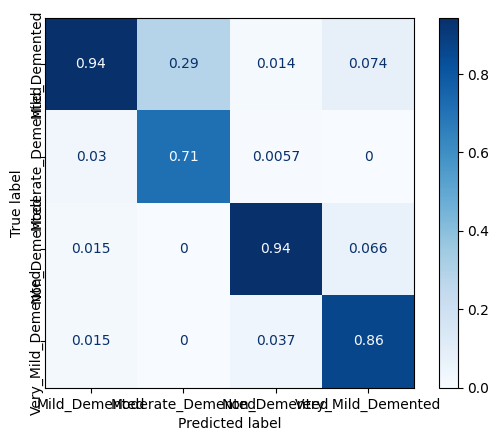

<Figure size 500x500 with 0 Axes>

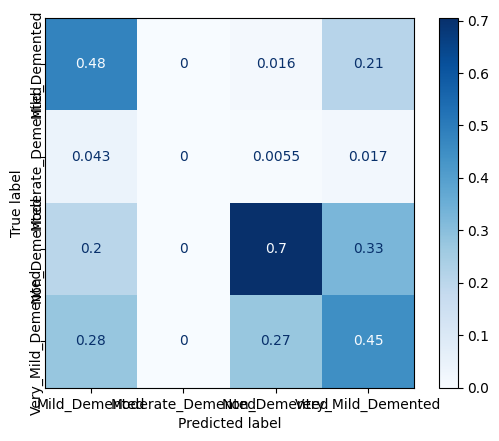

<Figure size 500x500 with 0 Axes>

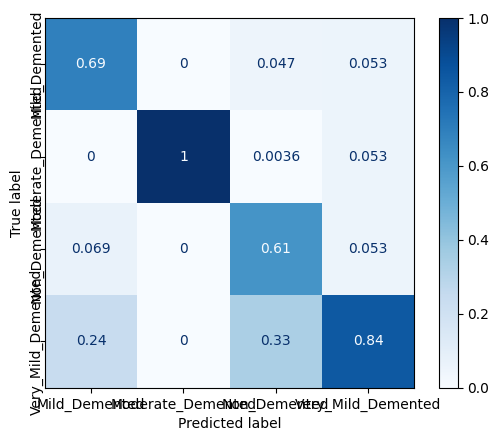

<Figure size 500x500 with 0 Axes>

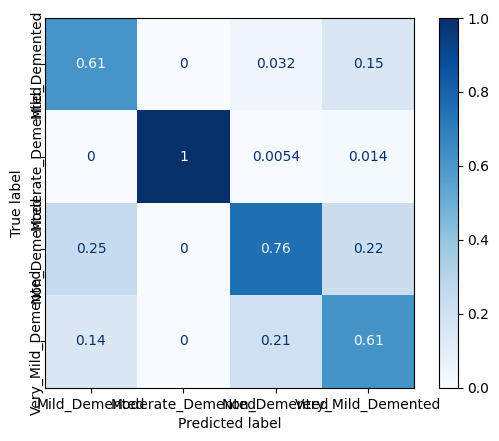

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ALL.zip ./*